## Load Libraries

In [1]:
#!pip install -q ktext
#!pip install -q annoy

In [2]:
import json
from urllib.request import urlopen

%matplotlib inline
from matplotlib import pyplot as plt

#from annoy import AnnoyIndex
from keras import optimizers
from keras.layers import Input, Dense, LSTM, GRU, Embedding, Lambda, BatchNormalization, Bidirectional
from keras.models import load_model, Model
from keras import optimizers
from keras.preprocessing.sequence import pad_sequences
from keras.utils import get_file, to_categorical
from keras.callbacks import TensorBoard, ModelCheckpoint, CSVLogger
from ktext.preprocess import processor
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load Data

In [ ]:
# News Dataset
news = pd.read_csv("C:/Users/wb539334/Desktop/HW/590/Project/Data_All/articles20k_input.csv", encoding='latin-1')
news.columns = ['title', 'body']

In [4]:
traindf, testdf = train_test_split(news, test_size=.10)
print(traindf.shape)
print(testdf.shape)

(18000, 2)
(2000, 2)


In [5]:
source_docs = list(traindf.body)
target_docs = list(traindf.title)

In [6]:
test_source_docs = list(testdf.body)
test_target_docs = list(testdf.title)

## Sequence to Sequence Model

In [7]:
print('source: ', source_docs[2])
print('target: ', target_docs[2])

source:  On Tuesday    Hunter Jackson was suspended for seven days after bringing an empty . 22 shell casing to school to show his friends. [HunterÃ¢ÂÂs school Ã¢ÂÂ  A Place to Grow Ã¢ÂÂ  is located in Troy, Illinois.  According to Fox 2 Now, HunterÃ¢ÂÂs mother, Kristy Jackson, said her son was excited because he had just spent time with his grandpa Ã¢ÂÂ  a Caseyville, Illinois, police officer Ã¢ÂÂ  who was teaching him about hunting and gun safety. Jackson said: [Hunter] just was wandering around in a field and picked up and put it in his pocket and didnÃ¢ÂÂt tell his parents  Ã¢ÂÂ¦    itÃ¢ÂÂs paranoia.  ItÃ¢ÂÂs something thatÃ¢ÂÂs become quite an epidemic where guns are automatically assumed that theyÃ¢ÂÂre bad  Ã¢ÂÂ¦    and IÃ¢ÂÂm not sure how a   suspension teaches my son anything about tolerance or anything about why he was wrong.  It just means his school doesnÃ¢ÂÂt want him there because of things he enjoys. In a Facebook post, Jackson she went to the

### Pre-Processing

In [8]:
source_proc = processor(hueristic_pct_padding=.7, keep_n=8000)
source_vecs = source_proc.fit_transform(source_docs)

 See full histogram by insepecting the `document_length_stats` attribute.


In [9]:
print('\noriginal string:\n', source_docs[0], '\n')
print('after pre-processing:\n', source_vecs[0], '\n')


original string:
 BERLIN  Ã¢ÂÂ   Germany and Turkey have been locked in an intensifying war of words over the past week, as campaigning heats up before an April referendum in Turkey on a new Constitution that would expand the powers of President Recep Tayyip Erdogan. Mr. Erdogan, whose critics cast him as ever more authoritarian, badly wants a victory in the vote. With the referendum on a   he and members of his Justice and Development Party, known as A. K. P. are desperate to campaign in Germany among the 1. 5 million Turks who are eligible to vote. Ã¢ÂÂThere is a need for the A. K. P. to secure as many votes as possible from the Turks living in Germany  Ã¢ÂÂ   thatÃ¢ÂÂs the basic ingredient,Ã¢ÂÂ said Marc Pierini, a former European Union ambassador to Turkey and a scholar at Carnegie Europe, a   think tank. Ã¢ÂÂThe yes vote is now in jeopardy, therefore votes in Germany are of course very important,Ã¢ÂÂ he added. But the campaign has put Chancellor Angela MerkelÃ¢ÂÂs

 3789    8 1297    2  107   10 1024  609 6511   40] 



In [10]:
%reload_ext autoreload
%autoreload 2
from ktext.preprocess import processor

In [11]:
target_proc = processor(append_indicators=True, hueristic_pct_padding=.7, keep_n=4500, padding ='post')
target_vecs = target_proc.fit_transform(target_docs)

 See full histogram by insepecting the `document_length_stats` attribute.


In [12]:
encoder_input_data = source_vecs
encoder_seq_len = encoder_input_data.shape[1]

decoder_input_data = target_vecs[:, :-1]
decoder_target_data = target_vecs[:, 1:]

num_encoder_tokens = max(source_proc.id2token.keys()) + 1
num_decoder_tokens = max(target_proc.id2token.keys()) + 1

### Encoder Model

In [13]:
word_emb_dim=512
hidden_state_dim=1024
encoder_seq_len=encoder_seq_len
num_encoder_tokens=num_encoder_tokens
num_decoder_tokens=num_decoder_tokens

#arbitrarly set latent dimension for embedding and hidden units
latent_dim = 300

In [14]:
encoder_inputs = Input(shape=(encoder_seq_len,), name='Encoder-Input')

# Word embeding for encoder (ex: Issue Body)
x = Embedding(num_encoder_tokens, latent_dim, name='Body-Word-Embedding', mask_zero=False)(encoder_inputs)
x = BatchNormalization(name='Encoder-Batchnorm-1')(x)

# Intermediate GRU layer (optional)
#x = GRU(latent_dim, name='Encoder-Intermediate-GRU', return_sequences=True)(x)
#x = BatchNormalization(name='Encoder-Batchnorm-2')(x)

# We do not need the `encoder_output` just the hidden state.
_, state_h = GRU(latent_dim, return_state=True, name='Encoder-Last-GRU', return_sequences=True)(x)

# Encapsulate the encoder as a separate entity so we can just 
#  encode without decoding if we want to.
encoder_model = Model(inputs=encoder_inputs, outputs=state_h, name='Encoder-Model')

seq2seq_encoder_out = encoder_model(encoder_inputs)

In [15]:
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder-Input (InputLayer)   (None, 920)               0         
_________________________________________________________________
Body-Word-Embedding (Embeddi (None, 920, 300)          2400600   
_________________________________________________________________
Encoder-Batchnorm-1 (BatchNo (None, 920, 300)          1200      
_________________________________________________________________
Encoder-Last-GRU (GRU)       [(None, 920, 300), (None, 540900    
Total params: 2,942,700
Trainable params: 2,942,100
Non-trainable params: 600
_________________________________________________________________


### Decoder Model

In [16]:
decoder_inputs = Input(shape=(None,), name='Decoder-Input')  # for teacher forcing

# Word Embedding For Decoder (ex: Issue Titles)
dec_emb = Embedding(num_decoder_tokens, latent_dim, name='Decoder-Word-Embedding', mask_zero=False)(decoder_inputs)
dec_bn = BatchNormalization(name='Decoder-Batchnorm-1')(dec_emb)

# Set up the decoder, using `decoder_state_input` as initial state.
decoder_gru = GRU(latent_dim, return_state=True, return_sequences=True, name='Decoder-GRU')
decoder_gru_output, _ = decoder_gru(dec_bn, initial_state=seq2seq_encoder_out)
x = BatchNormalization(name='Decoder-Batchnorm-2')(decoder_gru_output)

# Dense layer for prediction
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='Final-Output-Dense')
decoder_outputs = decoder_dense(x)

### Seq2Seq Model

In [17]:
seq2seq_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
seq2seq_model.compile(optimizer=optimizers.Nadam(lr=0.001), loss='sparse_categorical_crossentropy')

In [18]:
seq2seq_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder-Input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Decoder-Word-Embedding (Embeddi (None, None, 300)    1350600     Decoder-Input[0][0]              
__________________________________________________________________________________________________
Encoder-Input (InputLayer)      (None, 920)          0                                            
__________________________________________________________________________________________________
Decoder-Batchnorm-1 (BatchNorma (None, None, 300)    1200        Decoder-Word-Embedding[0][0]     
__________________________________________________________________________________________________
Encoder-Mo

### Training

In [19]:
script_name_base = 'seq2seq_v2'
csv_logger = CSVLogger('{:}.log'.format(script_name_base))
model_checkpoint = ModelCheckpoint('{:}.epoch{{epoch:02d}}-val{{val_loss:.5f}}.hdf5'.format(script_name_base),
                                   save_best_only=True)

batch_size = 1200
epochs = 5
history = seq2seq_model.fit([encoder_input_data, decoder_input_data], np.expand_dims(decoder_target_data, -1),
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.12, callbacks=[csv_logger, model_checkpoint])

Train on 15840 samples, validate on 2160 samples
Epoch 1/5
15840/15840 [==============================] - ETA: 22:52 - loss: 8.46 - ETA: 21:31 - loss: 8.28 - ETA: 19:05 - loss: 8.13 - ETA: 17:09 - loss: 7.99 - ETA: 15:14 - loss: 7.86 - ETA: 13:12 - loss: 7.75 - ETA: 11:21 - loss: 7.64 - ETA: 9:27 - loss: 7.5462 - ETA: 7:36 - loss: 7.450 - ETA: 5:47 - loss: 7.368 - ETA: 3:59 - loss: 7.292 - ETA: 2:10 - loss: 7.211 - ETA: 21s - loss: 7.139 - 1474s 93ms/step - loss: 7.1260 - val_loss: 5.6266


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer Decoder-GRU was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'Encoder-Model/Encoder-Last-GRU/while/Exit_3:0' shape=(?, 300) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/5
15840/15840 [==============================] - ETA: 19:28 - loss: 6.03 - ETA: 18:21 - loss: 6.06 - ETA: 16:25 - loss: 6.02 - ETA: 14:41 - loss: 5.98 - ETA: 13:05 - loss: 5.95 - ETA: 11:36 - loss: 5.91 - ETA: 10:05 - loss: 5.88 - ETA: 8:37 - loss: 5.8371 - ETA: 7:01 - loss: 5.797 - ETA: 5:23 - loss: 5.764 - ETA: 3:44 - loss: 5.742 - ETA: 2:03 - loss: 5.707 - ETA: 20s - loss: 5.678 - 1385s 87ms/step - loss: 5.6719 - val_loss: 5.1776
Epoch 3/5
15840/15840 [==============================] - ETA: 22:11 - loss: 5.12 - ETA: 19:57 - loss: 5.06 - ETA: 18:07 - loss: 5.03 - ETA: 16:24 - loss: 5.00 - ETA: 14:35 - loss: 4.98 - ETA: 12:38 - loss: 4.96 - ETA: 10:45 - loss: 4.95 - ETA: 8:57 - loss: 4.9386 - ETA: 7:12 - loss: 4.927 - ETA: 5:30 - loss: 4.919 - ETA: 3:49 - loss: 4.901 - ETA: 2:06 - loss: 4.887 - ETA: 20s - loss: 4.874 - 1415s 89ms/step - loss: 4.8730 - val_loss: 4.9196
Epoch 4/5
15840/15840 [==============================] - ETA: 21:15 - loss: 4.54 - ETA: 19:57 - loss: 4.50 - E

In [20]:
#save model
seq2seq_model.save('seq2seq_model.h5')

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer Decoder-GRU was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'Encoder-Model/Encoder-Last-GRU/while/Exit_3:0' shape=(?, 300) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


### Extract Encoder and Decoder Models

In [21]:
def extract_decoder_model(model):
    latent_dim = model.get_layer('Encoder-Model').output_shape[-1]
    decoder_inputs = model.get_layer('Decoder-Input').input
    dec_emb = model.get_layer('Decoder-Word-Embedding')(decoder_inputs)
    dec_bn = model.get_layer('Decoder-Batchnorm-1')(dec_emb)
    gru_inference_state_input = Input(shape=(latent_dim,), name='hidden_state_input')
    gru_out, gru_state_out = model.get_layer('Decoder-GRU')([dec_bn, gru_inference_state_input])
    dec_bn2 = model.get_layer('Decoder-Batchnorm-2')(gru_out)
    dense_out = model.get_layer('Final-Output-Dense')(dec_bn2)
    decoder_model = Model([decoder_inputs, gru_inference_state_input], [dense_out, gru_state_out])
    return decoder_model

In [22]:
encoder_model = seq2seq_model.get_layer('Encoder-Model')
for layer in encoder_model.layers:
    layer.trainable = False

decoder_model = extract_decoder_model(seq2seq_model)
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder-Input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Decoder-Word-Embedding (Embeddi (None, None, 300)    1350600     Decoder-Input[0][0]              
__________________________________________________________________________________________________
Decoder-Batchnorm-1 (BatchNorma (None, None, 300)    1200        Decoder-Word-Embedding[1][0]     
__________________________________________________________________________________________________
hidden_state_input (InputLayer) (None, 300)          0                                            
__________________________________________________________________________________________________
Decoder-GR

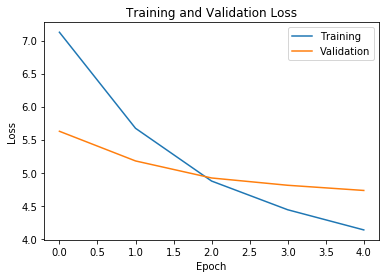

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

### Predict code descriptions using the trained sequence-to-sequence model

In [ ]:
col_names =  ['body', 'actual_title', 'generated_title']
resultDF  = pd.DataFrame(columns = col_names)
test_idx = list(range(1, len(test_source_docs)))
max_len = target_proc.padding_maxlen

for i in test_idx:
  
  raw_input_text = test_source_docs[i]
  raw_tokenized = source_proc.transform([raw_input_text])
  encoding = encoder_model.predict(raw_tokenized)
  original_encoding = encoding
  state_value = np.array(target_proc.token2id['_start_']).reshape(1, 1)
  
  decoded_sentence = []
  stop_condition = False
  while not stop_condition:
    preds, st = decoder_model.predict([state_value, encoding])
    pred_idx = np.argmax(preds[:, :, 2:]) + 2
    pred_word_str = target_proc.id2token[pred_idx]

    if pred_word_str == '_end_' or len(decoded_sentence) >= max_len:
        stop_condition = True
        break
    decoded_sentence.append(pred_word_str)
    
    # update the decoder for the next word
    encoding = st
    state_value = np.array(pred_idx).reshape(1, 1)
    
  pred_sent = ' '.join(decoded_sentence)
    
  
  # print
  print('\n\n==============================================')
  print(f'============== News # {i} =================\n')
  print('News Body:\n------------------------\n', raw_input_text)
  print('\nNews Headline:\n------------------------\n', test_target_docs[i])
  print('\nMachine-generated Headline:\n------------------------\n', pred_sent)
    
    
  # append to dataframe
  tmpDF = pd.DataFrame({"body": [raw_input_text], 
                        "actual_title": [test_target_docs[i]], 
                        "generated_title": [pred_sent]})
  resultDF = pd.concat([resultDF, tmpDF], ignore_index=True)

  
resultDF.to_csv('News.csv', encoding='latin-1')



============== News # 1 =================

News Body:
------------------------
 On the Monday edition of Breitbart News Daily, broadcast live on SiriusXM Patriot Channel 125 from 6AM to 9AM Eastern, Breitbart    Alex Marlow will continue our analysis of the election of   Donald Trump, the progress of his transition team, and TrumpÃ¢ÂÂs policy vision. [Breitbart LondonÃ¢ÂÂs Oliver Lane and Donna Rachel Edmunds will discuss the latest news from the EU on next yearÃ¢ÂÂs elections in France and Germany. The populist movement that swept America with the Trump victory and the UK with the Brexit vote could now potentially see big wins elsewhere in Europe and beyond.  WeÃ¢ÂÂll also hear from Anthony Sadler and Alek Skarlatos about their new book, The 15:17 to Paris: The True Story of a Terrorist, a Train, and Three American Heroes. Sadler and Skarlatos, along with Spencer Stone, thwarted an ISIS terrorist plot to blow up a train bound for Paris last year. BreitbartÃ¢ÂÂs Joel Pollak

   celebrities ripped President Donald Trump Thursday after he officially announced that the United States will withdraw from the Paris Climate Agreement. [Filmmaker Michael Moore took to Twitter and said Ã¢ÂÂTrump just committed a crime against humanity. Ã¢ÂÂ  Trump just committed a crime against humanity. This admitted predator has now expanded his predatory acts to the entire planet. #ParisAccord,  Ã¢ÂÂ   Michael Moore (@MMFlint) June 1, 2017,  USA to Earth: FUCK YOU,  Ã¢ÂÂ   Michael Moore (@MMFlint) June 1, 2017,  Actor Alec Baldwin said Trump is a Ã¢ÂÂderanged, infantile maniacÃ¢ÂÂ getting in the way of the country from addressing climate change. All the world wants 2 address climate chg. Except the US. This country is being piloted in2 an iceberg by this deranged, infantile maniac,  Ã¢ÂÂ   ABFoundation (@ABFalecbaldwin) June 1, 2017,  Ã¢ÂÂThe United States will withdraw from the Paris Climate Accord,Ã¢ÂÂ President Trump said Thursday in a speech delivered in the

 GULFThe Making of an American SeaBy Jack E. DavisIllustrated. 592 pages. Liveright. $29. 95. SUNSHINE STATEEssaysBy Sarah Gerard359 pages. Harper Perennial. $15. 99. Florida is a place and a state of mind. As the former, itÃ¢ÂÂs lovely but afflicted, like Fay Wray in the hands of King Kong (developers). As the latter, it leaves much to be desired. I went to high school in southwest Florida. The malcontents pronounced it  . Florida is a supposedly fun place that has a lot of sadness clinging to it, like barnacles to a boatÃ¢ÂÂs hull. The novelist Cynthia Ozick is not someone I can imagine enjoying blender margaritas down at the beach bar, with sand in her toes. Yet Ozick was not far off, in her short story Ã¢ÂÂRosa,Ã¢ÂÂ when she wrote: Ã¢ÂÂThe whole peninsula of Florida was weighted down with regret. Everyone had left behind a real life. Ã¢ÂÂ One of the themes of Ã¢ÂÂSunshine State,Ã¢ÂÂ Sarah GerardÃ¢ÂÂs striking book of essays, is how Florida can unmoor you and make 

 This article was last updated at 1:30 p. m. Thursday. Visit this page for full coverage of the attack. In a deadly attack on Wednesday in London, a man driving a sport utility vehicle crushed pedestrians on Westminster Bridge, then stabbed and killed a police officer outside Parliament.  Ã¢ÂÂ¢ The police on Thursday revised the death toll to four from five. The victims were Kurt W. Cochran, an American tourist in his 50s Aysha Frade, 43, a British teacher and Police Constable Keith Palmer. . About 40 others were wounded. Ã¢ÂÂ¢ The London police identified the assailant, who died in the attack, as Khalid Masood, 52, who had an extensive criminal history but no terrorism convictions. Mr. Masood was born in Kent, in southeastern England, and recently lived around Birmingham, the city where the car used in the attack had been rented. Ã¢ÂÂ¢ Eight people were arrested in London and Birmingham after searches at six properties around Britain. The police said that Ã¢ÂÂa full counterterror

 It took just a few hours, after Donald J. Trump announced a major staff   last week, for Hillary ClintonÃ¢ÂÂs campaign team to settle on a new buzzword. Ã¢ÂÂHe peddles conspiracy theories,Ã¢ÂÂ her campaign manager, Robby Mook, said of Mr. Trump on MSNBC. Ã¢ÂÂWe hear rehashed conspiracy theories,Ã¢ÂÂ he added moments later. Ã¢ÂÂHe doubled down on this today,Ã¢ÂÂ Mr. Mook said, wrapping up, Ã¢ÂÂby appointing someone to lead his campaign who makes these conspiracy theories basically his professional mission. Ã¢ÂÂ For the better part of two decades, the invocation of a Ã¢ÂÂvast   conspiracyÃ¢ÂÂ against the Clintons, as Mrs. Clinton famously called it when allegations of sexual misconduct engulfed her husbandÃ¢ÂÂs administration, has elicited eye rolls even among some of the coupleÃ¢ÂÂs allies. It was not worth amplifying such attacks by responding to them, advisers often reasoned. And any discussion of a secret plot to undercut the Clintons risked sounding like p

 QUITO, Ecuador  Ã¢ÂÂ   The strongest earthquake to strike Ecuador in decades left the Andean nation traumatized on Sunday, with collapsed buildings in a swath of destruction stretching hundreds of miles. At least 272 people were killed and 2, 527 injured, mostly in the northwestern coastal area of ManabÃÂ­, the government said. President Rafael Correa cut short a visit to Europe and declared a national emergency after the 7.  earthquake struck on Saturday night, shaking the central coast. The effects could be felt in the capital, Quito, and into parts of Peru and Colombia. Portoviejo, the provincial capital of ManabÃÂ­, and Pedernales, a resort town, appeared to have sustained the most damage, with about 370 buildings destroyed. Viviana Baquezea, 34, a florist, was driving back to her home in Portoviejo, accompanied by her parents and an employee, when the earthquake struck. They were met by a scene of destruction. Ã¢ÂÂIt looks like a war zone,Ã¢ÂÂ Ms. Baquezea said by telepho

 GYEONGJU, South Korea  Ã¢ÂÂ   She spends hours a day watching the Japanese broadcaster NHK. Her bedside table is stacked with Japanese magazines and figurines in kimonos. The walls bear pictures of Mount Fuji. Shizue Katsura, 96, is among 19 Japanese women who are spending their final days in an unlikely place: a nursing home in South Korea, where lingering   sentiment has helped keep the women in obscurity. Ã¢ÂÂThere is no use looking back on my life,Ã¢ÂÂ Ms. Katsura said. Ã¢ÂÂHome is where you are living. Japan is a foreign country to me. Ã¢ÂÂ Thousands of Japanese women like Ms. Katsura married Korean men during JapanÃ¢ÂÂs colonial rule, which lasted from 1910 to 1945. When World War II ended and Korea was liberated, many stayed with their husbands in Korea, while others fled back to Japan, fearing violence from those looking to avenge the brutal colonial rule. Or, as in Ms. KatsuraÃ¢ÂÂs case, they followed their husbands from Japan to Korea. Once in Korea, these wome

 The   Senate has approved a waiver to allow retired U. S. Marine Corps Gen. James Ã¢ÂÂMad DogÃ¢ÂÂ Mattis to serve as incoming President Donald TrumpÃ¢ÂÂs secretary of defense. [Although he only retired in 2013, Gen. Mattis easily cleared an early procedural hurdle after his confirmation hearing, during which he described Russia as a Ã¢ÂÂprincipalÃ¢ÂÂ threat against the United States.  Following the Senate Armed Services CommitteeÃ¢ÂÂs bipartisan   vote, the   voted   vote to in favor of the waiver. The only committee members who voted against his waiver are Democratic Sens. Kirsten Gillibrand (NY) Richard Blumenthal (CT) and Elizabeth Warren (MA). Current law dictates that an individual must be out of military uniform for at least seven years before taking the civilian position of Pentagon chief. The measure has only been waived for George Marshall in 1950. Ã¢ÂÂHaving demonstrated 40 years of loyalty to the principle of civilian control and to the U. S. Constitution, I k

 1. It is common for the bodies of dead migrants to be found after starvation and exposure to heat on U. S. soil.  After illegal immigrants get past the river or fence, they still have to clear a secondary checkpoint by U. S. Border Patrol. Those checkpoints are routinely set up between 60 and 80 miles north of the border. In places like Falfurrias, Texas, human smugglers force illegal immigrants to walk dozens of miles through harsh   terrain in order to get around the checkpoints. That harsh trek in addition to the extreme weather in Texas and Arizona often leads to fatal consequences where human smugglers often leave behind those who are not able to keep up with the pace. Unfortunately, the remoteness of those areas often leaves families searching for answers since many of the heavily decomposed bodies found in those areas remain unidentified. 2. The entire border is broken down into regions or Ã¢ÂÂturfÃ¢ÂÂ controlled by Mexican  . Mexican cartels fight for the lucrative corrido

 Tonight in New York City, MILO along with Gavin McInnes, Martin Shkreli and more will present a piece of performance art at Ã¢ÂÂDaddy Will Save Us,Ã¢ÂÂ the first   art show.[  The event is hosted by Lucian Wintrich, already known for his last art show Ã¢ÂÂTwinks For Trump,Ã¢ÂÂ which also featured MILO as guest speaker. The event begins at 7:00pm (EST) at 132 West 18th Street, Chelsea, New York City. Tickets are still available, and can be purchased via IndieGoGo. MILO will deliver a speech alongside Wintrich at 8:30pm (EST). You can watch MILOÃ¢ÂÂs appearance, and his performance piece, at the livestream above. MILOÃ¢ÂÂs piece will feature himself in a clawfoot bath filled with Ã¢ÂÂthe blood of innocents,Ã¢ÂÂ a tribute to those who have lost loved ones at the hands of illegal aliens and terrorists. MILOÃ¢ÂÂs piece will be a challenge to globalist,   immigration policies and lax policing. The piece is titled Ã¢ÂÂANGEL MOM. Ã¢ÂÂ The Gallery Notes for YiannopoulosÃ¢

 Scientists digging in the Liang Bua cave on the Indonesian island of Flores years ago found a tiny humanlike skull, then a pelvis, jaw and other bones, all between 60, 000 and 100, 000  years old. The fossils, the scientists concluded, belonged to individuals who stood just three feet tall  Ã¢ÂÂ   an unknown species, related to modern humans, that they called Homo floresiensis or, more casually, the hobbits. On Wednesday, researchers reported that they had discovered still older remains on the island, including teeth, a piece of a jaw and 149 stone tools dating back 700, 000 years. The finding suggests that the ancestors of the hobbits arrived on Flores about a million years ago, the scientists said, and evolved into their own distinct branch of the hominin tree. But without other parts of a skeleton, such as the skull, hands or feet, they canÃ¢ÂÂt be sure whether the newly discovered fossils also belong to Homo floresiensis or instead to some other ancient relative of humans (kno

============== News # 17 =================

News Body:
------------------------
 Sunday at the annual LA Pride parade and resist march, Rep. Maxine Waters ( ) led the crowd in a chant to Ã¢ÂÂimpeach 45. Ã¢ÂÂ  Waters said, Ã¢ÂÂHe is not my president. He is not your president. He lies. He cheats. HeÃ¢ÂÂs a bully. He disrespects us all. If he thinks he can mess with the LGBT community, he better look at what happened right here in West Hollywood. You deny, you disrespect, and you will find that there are people who have the courage to organize and to take back whatever needs to be taken back. We resist this president because he stands for the worst of everything. And guess what, I know that people may not quite be ready. I know some are a little hesitant. I know some are saying IÃ¢ÂÂm not so sure, Maxine, that what you are saying is the right thing, but IÃ¢ÂÂm saying, impeach 45. Impeach 45. Ã¢ÂÂ After the chant, she added, Ã¢ÂÂI love you all. And I know that we are going 

 Army Captain Roger Hill joined SiriusXM host Alex Marlow on WednesdayÃ¢ÂÂs Breitbart News Daily to talk about his new book, Dog Company: A True Story of American Soldiers Abandoned by Their High Command. [Ã¢ÂÂThe bottom line here is that weÃ¢ÂÂve got a set of politically driven rules of engagement that are getting our guys and girls overseas killed and hurt unnecessarily,Ã¢ÂÂ Hill said of his bookÃ¢ÂÂs urgent message.  LISTEN: Ã¢ÂÂThis book Dog Company highlights a number of examples of that, in a real setting, during a real deployment to a province in eastern AfghanistanÃ¢ÂÂ in 2008 and 2009, according to Hill.  Ã¢ÂÂMy First Sergeant, Tommy Scott, and myself, we led a heavy weapons company in a violent province in eastern Afghanistan,Ã¢ÂÂ he recalled. Ã¢ÂÂIt seemed like the enemy was always one step ahead of us, and we discovered why. Through the aid of a   team, we uncovered twelve spies operating on our base. These were Afghan laborers that were hired by the U. 


News Headline:
------------------------
 Ã¢ÂÂDog CompanyÃ¢ÂÂ: Bronze Star Decorated Army Captain Explains How Politically Correct Lawyers Are Betraying Our Troops

Machine-generated Headline:
------------------------
 the new york times


============== News # 19 =================

News Body:
------------------------
 CLEVELAND, Ohio  Ã¢ÂÂ   Ivanka Trump introduced her father 2016 Republican nominee Donald Trump Thursday night at the Republican National Convention and revealed his record of employing women in business. [Ã¢ÂÂHe is colorblind and gender neutral. He hires the best person for the job, period,Ã¢ÂÂ Ivanka declared to the thousands of supporters packed into Quicken Loans Arena.  Ivanka said her father employs more women executives and also pays them equally to men. Ã¢ÂÂWomen represent 46 percent of the total U. S. labor force,Ã¢ÂÂ Ivanka told the audience, as she referenced the gender pay gap, as women arenÃ¢ÂÂt always paid as much as men. Ã¢ÂÂAs a mother m

============== News # 22 =================

News Body:
------------------------
 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. Hurricane Matthew is barreling toward the U. S. after killing nearly 300 people on its rampage through Haiti, above. The storm is expected to make landfall in Florida early Friday. (Follow our live coverage.) Ã¢ÂÂYou need to leave. Evacuate, evacuate, evacuate,Ã¢ÂÂ Gov. Rick Scott told the 1. 5 million residents in evacuation zones. Ã¢ÂÂThis storm will kill you. Time is running out. Ã¢ÂÂ ____ 2. The N. S. A. contractor arrested on suspicion of stealing highly classified information, Harold Martin III, doesnÃ¢ÂÂt fit any of the usual profiles of an Ã¢ÂÂinsider threat,Ã¢ÂÂ officials say. One of the officials described Mr. Martin, a Navy veteran, as a hoarder. He worked at the same consulting firm as Edward Snowden, but investigators suspect that he began taking material  Ã¢ÂÂ   some of it was cod

 Actress Lena Dunham says itÃ¢ÂÂs Ã¢ÂÂpainfulÃ¢ÂÂ when people read stories Ã¢ÂÂpublished on BreitbartÃ¢ÂÂ and pin the blame for Hillary ClintonÃ¢ÂÂs election loss on her. [Ã¢ÂÂItÃ¢ÂÂs amazing. IÃ¢ÂÂm like, Ã¢ÂÂWhy donÃ¢ÂÂt we check in with Russia, you guys?Ã¢ÂÂ I think it tends to come more from the right wing, although IÃ¢ÂÂm not sure,Ã¢ÂÂ Dunham told Rolling Stone in an interview to promote HBOÃ¢ÂÂs Girls, which began its final season Sunday. Ã¢ÂÂNow itÃ¢ÂÂs so hard to know whatÃ¢ÂÂs coming from where, because stories get published on Breitbart and two days later theyÃ¢ÂÂre in Newsweek and youÃ¢ÂÂre like, Ã¢ÂÂWhat the fuck is happening right now?Ã¢ÂÂ  Dunham was a spokeswoman for the Clinton campaign and hit the stump for the Democratic candidate on multiple occasions, including in both Iowa and New Hampshire. The Girls star spoke in primetime at the Democratic National Committee and headlined rallies for Clinton in the final weeks of the e

 Sen. Marco Rubio ( ) said Sunday on NBCÃ¢ÂÂs Ã¢ÂÂMeet the PressÃ¢ÂÂ that he has Ã¢ÂÂno insightÃ¢ÂÂ on President Donald TrumpÃ¢ÂÂs accusations that former President Barack Obama wiretapped Trump Tower prior to the election.  Ã¢ÂÂAgain, I think the term wiretap is thrown around very loosely and by a lot of people,Ã¢ÂÂ Rubio told host Chuck Todd. Ã¢ÂÂSo we have to understand exactly what theyÃ¢ÂÂre talking about. Suffice it to say I donÃ¢ÂÂt have any basis  Ã¢ÂÂ   IÃ¢ÂÂve never heard that allegation made before by anybody. IÃ¢ÂÂve never seen anything about that anywhere before. But again, may  Ã¢ÂÂ   the president put that out there and now the White House will have to answer to exactly what [Trump] was referring to. Ã¢ÂÂ Follow Trent Baker on Twitter @MagnifiTrent

News Headline:
------------------------
 Rubio: Ã¢ÂÂWhite House Will Have to AnswerÃ¢ÂÂ to TrumpÃ¢ÂÂs Wiretapping Allegations - Breitbart

Machine-generated Headline:
--------------------

 Missing from much of the news media coverage of comedian Kathy GriffinÃ¢ÂÂs shock   photoshoot is that the same photographer behind the image was previously accused of depicting the decapitation of Donald Trump. [Photographer and producer Tyler Shields took the now infamous picture of Griffin holding a mock head of Trump meant to appear severed and bloody.  Shields also directed and conceptualized a violent video for rocker Marilyn Manson that involved, as the Daily Beast described it, Ã¢ÂÂbeheading a blond man in a dark suit and red power tie who resembles Donald Trump. Ã¢ÂÂ The one minute fifteen second video, titled, Ã¢ÂÂSAY10,Ã¢ÂÂ was released on the eve of the 2016 presidential election. Manson himself stated that the video  Ã¢ÂÂ   which did not explicitly depict TrumpÃ¢ÂÂs head  Ã¢ÂÂ   was open to interpretation. Ã¢ÂÂItÃ¢ÂÂs about the desperate acts of people who believe something that is preached by an unbeliever,Ã¢ÂÂ he said. However, the   video was wide

 WASHINGTON  Ã¢ÂÂ   A    Army officer on Wednesday sued President Obama over the legality of the war against the Islamic State, setting up a test of Mr. ObamaÃ¢ÂÂs disputed claim that he needs no new legal authority from Congress to order the military to wage that deepening mission. The plaintiff, Capt. Nathan Michael Smith, an intelligence officer stationed in Kuwait, voiced strong support for fighting the Islamic State but, citing his Ã¢ÂÂconscienceÃ¢ÂÂ and his vow to uphold the Constitution, he said he believed that the mission lacked proper authorization from Congress. Ã¢ÂÂTo honor my oath, I am asking the court to tell the president that he must get proper authority from Congress, under the War Powers Resolution, to wage the war against ISIS in Iraq and Syria,Ã¢ÂÂ he wrote. The legal challenge comes after the death of the third American service member fighting the Islamic State and as Mr. Obama has decided to significantly expand the number of Special Operations ground

 WASHINGTON  Ã¢ÂÂ   Congressional leaders confirmed this week what seemed inevitable with the triumph of Donald J. Trump: The   trade agreement with 11 other Pacific Rim nations that President Obama hoped to leave as a major legacy, but which Mr. Trump called Ã¢ÂÂa terrible deal,Ã¢ÂÂ is dead. Senator Chuck Schumer of New York, the incoming Democratic leader, told labor leaders on Thursday that the pending   Partnership, the largest regional trade agreement in history, would not be approved by Congress. Senator Mitch McConnell, Republican of Kentucky and the majority leader, said   Ã¢ÂÂnoÃ¢ÂÂ when reporters on Wednesday asked whether the agreement would be considered in the   Congress that convenes next week  Ã¢ÂÂ   its last legislative chance, given the opposition from the  . Mr. Trump, whose invectives against trade agreements were central to his appeal to disaffected   voters, will have the authority as president Ã¢ÂÂto negotiate better deals, as I think he would put it


News Headline:
------------------------
 What Is Lost by Burying the Trans-Pacific Partnership? - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 32 =================

News Body:
------------------------
 Curt Schilling, a former   pitcher and one of the   baseball analysts on ESPN, was fired from the network Wednesday, a day after he drew intense criticism for promoting offensive commentary on social media. Schilling, who had worked for the network since 2010 and most recently offered analysis on Ã¢ÂÂMonday Night Baseball,Ã¢ÂÂ was dismissed after sharing a Facebook post this week that appeared to respond to the North Carolina law that bars transgender people from using bathrooms and locker rooms that do not correspond with their birth genders. The post showed an overweight man wearing a wig and womenÃ¢ÂÂs clothing with parts of the   cut out to expose his breasts. It says: Ã¢ÂÂLET HIM IN! to the restroom wit

 exclusive rep jim jordan your wednesday evening briefing the new york times


============== News # 34 =================

News Body:
------------------------
 ANKARA, Turkey (AP)  Ã¢ÂÂ   Turkish President Recep Tayyip Erdogan threatened on Thursday to scrap a deal with the European Union to readmit migrants who have crossed illegally into Europe, amid a standoff with European nations over their reluctance to allow Turkish ministers to hold campaign rallies in their countries. [In a feisty campaign speech in northwest Turkey, Erdogan said the EU could Ã¢ÂÂforget aboutÃ¢ÂÂ the deal, in which Ankara agreed to readmit migrants that had reached Greece illegally via Turkey  Ã¢ÂÂ   a key transit country for tens of thousands trying to flee fighting and poverty and enter Europe. In return, the EU was to grant Turkish citizens the right to travel to many European countries  .  The comments were the latest in TurkeyÃ¢ÂÂs bitter diplomatic spat with Germany and the Netherlands, which l

 A spokesman for the Taliban terrorist group in Afghanistan told President Donald Trump in a recent letter it is time for the United States to withdraw its troops and leave the   country, noting that peace will be elusive. [Under former    Barack Obama, a top spokesman for the U. S.  mission in Afghanistan suggested to Pentagon reporters in October 2016 that the American military and their Afghan counterparts may never defeat the Taliban, adding that the ultimate goal is a Ã¢ÂÂnegotiated solutionÃ¢ÂÂ and reconciliation between the terrorist group and the Afghan government.  The Taliban has repeatedly claimed victory over the U. S.  foreign troops and their Afghan allies. In the letter to journalists, Taliban spokesman Zabihullah Mujahid warned President Trump that, as long as the U. S.  coalition remains on Afghan soil, peace will be difficult to attain, reports the Associated Press (AP). Ã¢ÂÂIndependence from foreign dominance is Ã¢ÂÂthe only assetÃ¢ÂÂ an impoverished nation

 Hurricane Matthew was downgraded to a   cyclone early Sunday morning as it hit North Carolina and Virginia with a weakened but still powerful punch. Dispatches from our reporters on the ground a live storm tracker map and answers to reader questions will be updated below. Ã¢ÂÂ  The stormÃ¢ÂÂs death toll in the United States has climbed to at least 17. Gov. Pat McCrory of North Carolina said on Sunday morning that his stateÃ¢ÂÂs toll had risen to eight. Officials in Georgia confirmed three deaths on Saturday. At least six fatalities in Florida have been attributed to the storm. Nearly 900 people have died in Haiti, according to a Reuters report based on information from civil protection and local officials. Ã¢ÂÂ  Bands of heavy rain are leading to   flooding in parts of eastern North Carolina, according to the National Hurricane Center, which may result in   flooding and flash flooding elsewhere in the region. Forecasters warned that areas along the Neuse River in Goldsboro, N. C

 The Louvre museum in Paris has been evacuated after what the French Ministry of the Interior has called a Ã¢ÂÂserious public security eventÃ¢ÂÂ in which a number of soldier opened fire on a man with a machete who cried Ã¢ÂÂAllahu AkbarÃ¢ÂÂ. [Update 1900 CET  Ã¢ÂÂ   Attacker was Egyptian national Sources close to the investigation have revealed the Ã¢ÂÂAllahu akbarÃ¢ÂÂ shouting attacker who was shot five times Friday morning after he launched an attack on soldiers protecting the Louvre palace museum is an Engyptian national who only arrived in France days before, reports Le Figaro.  Having come by way of Dubai, the    unnamed    applied for a Schengen tourist visa. French President FranÃÂ§ois Hollande, whose soon to end term has been characterised by Islamist terror attacks said Friday evening that the attack was Ã¢ÂÂa terrorist act with little doubtÃ¢ÂÂ. French   police have searched the Louvre museum and the bags carried by the Egyptian national for weapons and exp

 RIO DE JANEIRO  Ã¢ÂÂ   Simone Manuel won the   freestyle on Thursday night, becoming the first   woman to win gold in an individual swimming event. Here is a poolside view of her reaction, from the moment she realized she won until she received the gold medal on the podium, and her reflections on the race. Ã¢ÂÂI was super surprised. . .. I donÃ¢ÂÂt think there was a definitive point where I thought I had the race. I donÃ¢ÂÂt remember much of it except the last 15 meters. I think I put my head down earlier than normal and just told myself to get my hand on the wall as fast as I possibly could. Ã¢ÂÂ Ã¢ÂÂThe whole time I was trying not to cry. . .. But I think just hearing the national anthem and knowing you put your heart into that race and you represented your country in the best way you know how, I think that meant a lot because that was my first individual win at an international meet and it just felt great. Ã¢ÂÂ Ã¢ÂÂThis medal is not just for me, itÃ¢ÂÂs for some o

 WASHINGTON  Ã¢ÂÂ   The Trump administration is exploring how to dismantle or bypass   constraints intended to prevent civilian deaths from drone attacks, commando raids and other counterterrorism missions outside conventional war zones like Afghanistan and Iraq, according to officials familiar with internal deliberations. Already, President Trump has granted a Pentagon request to declare parts of three provinces of Yemen to be an Ã¢ÂÂarea of active hostilitiesÃ¢ÂÂ where looser battlefield rules apply. That opened the door to a Special Operations raid in late January in which several civilians were killed, as well as to the   series of American airstrikes targeting   Qaeda militants, starting nearly two weeks ago, the officials said. Mr. Trump is also expected to sign off soon on a similar Pentagon proposal to designate parts of Somalia to be another such   zone for 180 days, removing constraints on airstrikes and raids targeting people suspected of being militants with the   gro

 Trump Administration Is Said to Be Working to Loosen Counterterrorism Rules - The New York Times

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 41 =================

News Body:
------------------------
 Senator Marco Rubio of Florida said Wednesday that he would run for   abandoning plans to pursue a more lucrative career in the private sector and jolting a competitive race that is crucial to DemocratsÃ¢ÂÂ plans to retake control of the Senate. Mr. Rubio, 45, who had told associates of his reluctance to give up the high profile and political power that a Senate seat offers, will enter the race with the formidable advantages of incumbency, national name recognition and strong ties to the Republican PartyÃ¢ÂÂs donor base. But he faces numerous hurdles, the most difficult of which may be his history of talking down the Senate as unfulfilling and frustrating at times. He is also coming off a bruising 

 TEL AVIV  Ã¢ÂÂ   U. S. Jewish groups hailed President Donald TrumpÃ¢ÂÂs opening remarks in his address to Congress slamming the recent spate of   acts of Ã¢ÂÂhate and evil. Ã¢ÂÂ[Ã¢ÂÂRecent threats targeting Jewish community centers and vandalism of Jewish cemeteries, as well as last weekÃ¢ÂÂs shooting in Kansas City, remind us that while we may be a nation divided on policies, we are a country that stands united in condemning hate and evil in all of its very ugly forms,Ã¢ÂÂ the president said at the joint session to wide applause.  The Simon Wiesenthal Center, a Jewish human rights group, called the speech Ã¢ÂÂpivotalÃ¢ÂÂ in its condemnation of  . Ã¢ÂÂWe are grateful that the president condemned antisemitism during this pivotal speech to the American people before both houses of Congress. American Jewry now looks forward to robust action to combat historyÃ¢ÂÂs oldest scourge at home and abroad,Ã¢ÂÂ Rabbis Marvin Hier and Abraham Cooper, the dean and associate d

 Actor Bryan Cranston has said heÃ¢ÂÂll Ã¢ÂÂabsolutelyÃ¢ÂÂ support Hillary Clinton in the 2016 presidential race  Ã¢ÂÂ   but in an interview Monday morning on NBC, the     said if he could play any   historical figure, heÃ¢ÂÂd pick presumptive GOP nominee Donald Trump. [Ã¢ÂÂIÃ¢ÂÂd like to play Donald Trump at some point,Ã¢ÂÂ Cranston said on Today. Ã¢ÂÂHeÃ¢ÂÂs huge. HeÃ¢ÂÂs this Shakespearean character, this    character. Who wouldnÃ¢ÂÂt want to take a bite out of that?Ã¢ÂÂ  Cranston, who snagged multiple Emmys for his iconic role as   chemistry    kingpin Walter White on Breaking Bad, said his impersonation of the GOPÃ¢ÂÂs presumptive presidential nominee is Ã¢ÂÂhuge. Ã¢ÂÂ Ã¢ÂÂHuge, itÃ¢ÂÂs huge,Ã¢ÂÂ Cranston said, before launching into his best Trump impression: Ã¢ÂÂLet me tell you something, and this I can tell you, it is huge. Ã¢ÂÂ (Impression starts at around the 4:00 mark.) Playing a president on film wouldnÃ¢ÂÂt be anything new for the

 The pathway forward for ATTÃ¢ÂÂs pending $85 billion merger with Time Warner goes through President Donald TrumpÃ¢ÂÂs apprehensions about the deal, concerns that donÃ¢ÂÂt appear to be going away any time soon. [The real estate magnate chided the deal on the campaign trail, saying, Ã¢ÂÂItÃ¢ÂÂs too much concentration of power in the hands of too few. Ã¢ÂÂ  Critics argue that the increased concentration of media and telecom companies hurts competition and consumers. Stephen K. Bannon, TrumpÃ¢ÂÂs chief strategist, also opposes the deal. TrumpÃ¢ÂÂs apprehensions with the merger stem partly from CNN, a subsidiary of Time Warner, which he argues covers him unfairly. Trump has called the network a Ã¢ÂÂfake newsÃ¢ÂÂ network as the outletÃ¢ÂÂs personalities have repeatedly criticized him as heÃ¢ÂÂs taken the highest office in the land. Fox BusinessÃ¢ÂÂ Charlie Gasparino claims that Time Warner might need to spin off CNN as a separate entity to make the deal work. But i

 The Federal Aviation Administration, citing fire hazards, has warned against using Samsung Galaxy Note 7 smartphones on aircraft. Three Australian airlines and the German carrier Lufthansa have outright banned their use onboard. But the threat of airliner fires is not limited to Samsung devices, which the company has offered to replace. And the hazard is far more than theoretical. Qantas, one of the Australian carriers, had an onboard fire during a   flight this year when a passengerÃ¢ÂÂs cellphone was crushed in the mechanism of a   seat and the phoneÃ¢ÂÂs   battery ignited. In January as a Delta Air Lines flight from Minneapolis to Atlanta arrived at the gate, crew members discovered that a   bag containing two laptop computers had burst into flames, according to the F. A. A. The smoke prompted some passengers to use the emergency exits and wait on the wings until help arrived. The problem is   batteries, which have become the standard for portable consumer electronics, includin

 MANAUS, Brazil  Ã¢ÂÂ   Our tale takes metaphorical root in the early 1880s and the fevered imaginings of rubber barons. Sitting by the vast Amazon River, bewitched by pink river dolphins and torrential downpours, surrounded by rain forest, these men hungered for a legacy worthy of kings. So they imported an Italian architect, the mellifluously named Celestial Sacardim, to build an opera house. He conceived a heaven: columns of Carrara marble chandeliers of Murano glass 36, 000   roof tiles from Alsace parquet floors of walnut, oak and Norwegian maple tapestries from the looms of Flanders. Liverpool foundries provided the steel. The Teatro Amazonas was beautiful and insanely expensive and as ephemeral as everything else in this sweltering land. The rubber barons, legend has it, persuaded Enrico Caruso to journey here and sing Verdi. Then the rubber economy collapsed, and the opera house, which still stands in the colonial quarter, fell into decade upon decade of damp disuse. All of w

 Paul Sperry writes that the Ã¢ÂÂhighest levelsÃ¢ÂÂ of the U. S. government are implicated in a   of Saudi ArabiaÃ¢ÂÂs role in the   attacks, all to preserve diplomatic relations with the   Islamist nation. [From the New York Post:  In its report on the   Ã¢ÂÂ28 pagesÃ¢ÂÂ implicating the Saudi government in   Ã¢ÂÂ60 MinutesÃ¢ÂÂ last weekend said the Saudi role in the attacks has been Ã¢ÂÂ Ã¢ÂÂ to protect AmericaÃ¢ÂÂs delicate alliance with the   kingdom. ThatÃ¢ÂÂs quite an understatement. Actually, the kingdomÃ¢ÂÂs involvement was deliberately covered up at the highest levels of our government. And the coverup goes beyond locking up 28 pages of the Saudi report in a vault in the US Capitol basement. Investigations were throttled.   were let off the hook. Case agents IÃ¢ÂÂve interviewed at the Joint Terrorism Task Forces in Washington and San Diego, the forward operating base for some of the Saudi hijackers, as well as detectives at the Fairfax County (Va.) Pol

 Sen. Rand Paul ( ) told Breitbart News exclusively on Tuesday that most American companies would not take the risk of hiring former President Bill Clinton in the wake of sexual assault and rape allegations from a litany of women including Paula Jones, Juanita Broaddrick, Gennifer Flowers, Kathleen Willey, and more. [Ã¢ÂÂI think most company policies in most American corporations wouldnÃ¢ÂÂt even hire someone like Bill Clinton because of his threat to the young people in the workplace,Ã¢ÂÂ Paul told Breitbart News in the exclusive phone interview. Ã¢ÂÂAs CEO in any company in America, his behavior with an intern would be so unacceptable that heÃ¢ÂÂs really not someone that any company in America would hire. Ã¢ÂÂ  Paul also said that the Clintons Ã¢ÂÂ  as former Secretary of State Hillary Clinton, BillÃ¢ÂÂs husband, seeks to ascend to the presidency Ã¢ÂÂ  must answer these questions and must answer them in a straightforward manner. Paul argued that the woman should be 

============== News # 54 =================

News Body:
------------------------
 Thursday on WABCÃ¢ÂÂs Ã¢ÂÂThe Rita Cosby Show,Ã¢ÂÂ conservative commentator Pat Buchanan said todayÃ¢ÂÂs Ã¢ÂÂmother of all bombsÃ¢ÂÂ (MOAB)  attack on an ISIS tunnel complex in Afghanistan was also meant to send a Ã¢ÂÂmessageÃ¢ÂÂ to North Korea.  Buchanan said, Ã¢ÂÂFirst, I think it is obviously a sign that Donald Trump is listening to his generals and is getting much tougher and is accepting their advice. This is meant to go into these tunnels and kill   or ISIS right where they live. But let me say, Rita, this is a second message thatÃ¢ÂÂs being sent  Ã¢ÂÂ   and itÃ¢ÂÂs to the North Koreans. The North Koreans, they have their tests, their atom bombs deep in tunnels, and I think what it is, is a message to them that we can get down in there and kill your people underground as well as    Ã¢ÂÂ   and so I would think thatÃ¢ÂÂs a message to North Korea as well. Ã¢ÂÂ (  Newsmax) F

 The campaign of GOP frontrunner Donald Trump is speaking out to defend American war veteran and Immigration and Customs Enforcement (ICE) Council President Chris Crane. Over the weekend, Sen. Marco Rubio demeaned Crane, whoÃ¢ÂÂs critical of Sen. RubioÃ¢ÂÂs involvement in the Gang of Eight bill. [Ã¢ÂÂThis courageous ICE officer Ã¢ÂÂ  a man that Sen. Jeff Sessions has called Ã¢ÂÂan American heroÃ¢ÂÂ  Ã¢ÂÂ¦     has served his country in so many different capacities: in the MarineÃ¢ÂÂs uniform, as an ICE officer, [and] as a representative for all of AmericaÃ¢ÂÂs ICE officers,Ã¢ÂÂ said Donald TrumpÃ¢ÂÂs Senior Policy Adviser Stephen Miller on Breitbart News Sunday.  Rubio has repeatedly made clear Ã¢ÂÂwhere his priorities areÃ¢ÂÂ on immigration, Miller said Ã¢ÂÂ   explaining that there are now three lanes dividing the GOP Presidential field: the GovernorÃ¢ÂÂs lane, occupied by John Kasich the frontrunnerÃ¢ÂÂs lane, occupied by Donald Trump and the Ã¢ÂÂamnes


News Headline:
------------------------
 Trump Campaign Defends Ã¢ÂÂAmerican HeroÃ¢ÂÂ Chris Crane from Marco RubioÃ¢ÂÂs Screed - Breitbart

Machine-generated Headline:
------------------------
 exclusive rep jim jordan your morning briefing the new york times


============== News # 56 =================

News Body:
------------------------


 WASHINGTON  Ã¢ÂÂ   The DemocratsÃ¢ÂÂ stunning defeat in the presidential race and continued struggles in   contests have jolted party leaders into concluding that their emphasis on cultural issues has all but crippled them by diverting votersÃ¢ÂÂ attention from the core Democratic message of economic fairness. But even as Democrats agree about the need to promote their agenda more aggressively for the middle class and voters of modest means, especially in parts of the country where the party has suffered grievous losses, they are divided over how aggressively to position themselves on the economic left, with battle lines already forming over the   issue of foreign trade. While the country has moved steadily to the left on such social issues as   marriage and gender equity, it is increasingly apparent that Democrats cannot win in much of the country without a more coherent and overriding economic message. The debate over what that message should be comes not only against the back


News Headline:
------------------------
 Pulling Democrats Back to Ã¢ÂÂItÃ¢ÂÂs the Economy, StupidÃ¢ÂÂ - The New York Times

Machine-generated Headline:
------------------------
 donald trump s first time to be a lot of the new york times


============== News # 57 =================

News Body:
------------------------
 EditorÃ¢ÂÂs Note:  Ã¢ÂÂItÃ¢ÂÂs obviously unacceptable that someone crossed a line and made physical contact with our reporter. What Michelle has told us directly is that someone Ã¢ÂÂgrabbed her armÃ¢ÂÂ and while she did not see who it was, Ben Terris of the Washington Post told her that it was Corey Lewandowski. If thatÃ¢ÂÂs the case, Corey owes Michelle an immediate apology. Ã¢ÂÂ  Ã¢ÂÂ   Larry Solov, Breitbart News CEO and President, Hadas Gold writes at Politico: Donald Trump campaign manager Corey Lewandowski forcibly yanked Breitbart reporter Michelle Fields out of the way after his press conference in Florida on Tuesday night. Fields was atte

 Kentucky Senator Rand Paul delivered his first gift of the holiday season with a Twitter storm of Festivus Tweets, including the Ã¢ÂÂairing of grievances,Ã¢ÂÂ and itÃ¢ÂÂs the best thing youÃ¢ÂÂll see from Washington all day. [The Kentucky Republican and   GOP candidate for president started out wishing fans a happy Fetivus.  Good morning Seinfeld fans and Happy Festivus everywhere! Today IÃ¢ÂÂll have my annual #AiringofGrievances. Join me here throughout the day  Ã¢ÂÂ¦      Ã¢ÂÂ   Senator Rand Paul (@RandPaul) December 23, 2016,  Stay tuned to celebrate #festivus with me.  I got a lot of problems with you and now youÃ¢ÂÂre gonna hear about them #HappyFestivus,  Ã¢ÂÂ   Senator Rand Paul (@RandPaul) December 23, 2016,  Hello again, I hope everyone is having a Happy Festivus! ItÃ¢ÂÂs once again time for my annual #AiringofGrievances  Ã¢ÂÂ¦     pic. twitter.   Ã¢ÂÂ   Senator Rand Paul (@RandPaul) December 23, 2016,  Then came some jabs, jokes, and ribbing for Washing

============== News # 60 =================

News Body:
------------------------
 Sunday on New York AM 970 radioÃ¢ÂÂs Ã¢ÂÂThe Cats Roundtable,Ã¢ÂÂ Gov. Scott Walker ( ) laid out the plan for Republican   nominee Mike Pence for the upcoming   debate.  According to Walker, PenceÃ¢ÂÂs Ã¢ÂÂjobÃ¢ÂÂ will be to Ã¢ÂÂquickly dismissÃ¢ÂÂ attacks on Republican presidential nominee Donald Trump, and then pivot to Democratic presidential nominee Hillary ClintonÃ¢ÂÂs problems. Ã¢ÂÂAll the research I did to help Mike Pence out with Tim Kaine suggests to me that Sen. Kaine will be very decent. HeÃ¢ÂÂll come across as a   nice guy. But in the end heÃ¢ÂÂll take shot after shot after shot at Donald Trump. Mike PenceÃ¢ÂÂs job is to come in and quickly dismiss these attacks and quickly pivot to the problems of Hillary Clinton,Ã¢ÂÂ Walker told host John Catsimatidis. Follow Trent Baker on Twitter @MagnifiTrent 

News Headline:
------------------------
 Scott Walker: PenceÃ¢ÂÂs 

 LONDON  Ã¢ÂÂ   On a day that blended dull ritual with undeniable historical import, Britain formally began its departure from the European Union with the delivery of a letter to Brussels, followed by lofty words from Prime Minister Theresa May in Parliament. Two years of grinding divorce negotiations now begin, with the outcome unclear, except that the talks are certain to be contentious and spiteful  Ã¢ÂÂ   and that the only sure winners will be lawyers and trade negotiators. For the first time, the European bloc is losing a member, not to mention its   economy. The multilateral architecture that has shaped the Western world since the aftermath of World War II has taken a severe blow, and as the letter was delivered on Wednesday, questions abounded about whether this pivot toward nationalism and   represented the beginning of a more volatile global era. When Britons voted last June to leave the European Union, the champions of Ã¢ÂÂBrexitÃ¢ÂÂ argued that the country, with its 

 exclusive rep jim jordan on trump s first time to be a lot of the


============== News # 64 =================

News Body:
------------------------
 ONLY two of the   reporters who covered the presidential campaign for The New York Times were black. None were Latino or Asian. ThatÃ¢ÂÂs less diversity than youÃ¢ÂÂll find in Donald TrumpÃ¢ÂÂs cabinet thus far. Of The TimesÃ¢ÂÂs newly named White House team, all six are white, as is most everyone in the Washington bureau. Traveling to other departments, Metro has only three Latinos among its 42 reporters, in a city with the second largest Hispanic population in the country. Sports has one Asian man, two Hispanics and no   among its 21 reporters, yet blacks are plentiful among the teams they cover and the audience they serve. In the Styles section, every writer is white, while American culture is anything but. The executive editor, Dean Baquet, is  . The other editors on his masthead are white. The staff with the most diversity? T

 Pop superstar Rihanna is hitting back against snowflake Ã¢ÂÂhatersÃ¢ÂÂ who criticized her for daring to Photoshop images of Queen Elizabeth II on to photos of herself in    . [Rihanna first posted the doctored images of the Queen over the weekend, with captions like Ã¢ÂÂbe humble,Ã¢ÂÂ Ã¢ÂÂyaÃ¢ÂÂll chickens is ash and IÃ¢ÂÂm lotionÃ¢ÂÂ and Ã¢ÂÂitÃ¢ÂÂs not that deepÃ¢ÂÂ as Queen ElizabethÃ¢ÂÂs head was put onto the pop singerÃ¢ÂÂs body.   be humble. A post shared by badgalriri (@badgalriri) on Apr 22, 2017 at 9:24am PDT,   yÃ¢ÂÂall chickens is ash and IÃ¢ÂÂm lotion. Ã°ÂÂÂ A post shared by badgalriri (@badgalriri) on Apr 22, 2017 at 9:26am PDT,   #gucci UPDATE: Mumz said she wonÃ¢ÂÂt too happy bout this post so I had to edit *insert appropriate Gucci Mane lyrics here* A post shared by badgalriri (@badgalriri) on Apr 22, 2017 at 9:37am PDT,   itÃ¢ÂÂs not that deep. A post shared by badgalriri (@badgalriri) on Apr 22, 2017 at 12:44pm PDT,  Soon after, p

 RIO DE JANEIRO  Ã¢ÂÂ   Early in 1987, Kerry Lynch, a bright hope of the American ski team for an Olympic medal, boarded a plane for Germany. There, he met an American doctor who performed a transfusion that packed his blood with red blood cells, an elixir for endurance athletes. A few days later, at the 1987 world championships, he finished second in the Nordic combined, a grueling   event that featured   ski jumping and     skiing. It was the best performance ever by an American in that event. The plot came undone, Lynch confessed, and it turned out that Jim Page, director of the United States Nordic program, had given his blessing to the doping. The International Ski Federation booted Page for life. The United States Olympic Committee was far gentler. Page remained and became its managing director of sports performance. For much of the 1980s and 1990s, the United States had a pervasive doping problem in Olympic sports that was enabled by the U. S. O. C. Test results disappeared,  

 FoxÃ¢ÂÂs Charlie Gasparino writes that Marco RubioÃ¢ÂÂs presidential campaign has turned into Ã¢ÂÂ  civil warÃ¢ÂÂ between donors urging him to drop out now and campaign staff telling him to fight through the Florida primary. [From Fox Business:  Rubio campaign officials deny that the Florida senator is contemplating an early exit from the campaign and say he will continue on through the GOP convention in July. But major donors who have advised Rubio say based on their conversations, RubioÃ¢ÂÂs ultimate intentions are less certain, and while he may not drop out before Florida, they believe based on these conversations, he will drop out of the race if he loses there. They say the candidate has listened to their logic that by remaining in the campaign and losing in his home state to Trump, Rubio would go a long way to handing the nomination to Trump, the volatile Manhattan real estate mogul and reality TV star. With that, they are urging him to drop out as soon as possible and 

 Berkeley Mayor Jesse Arreguin is a member of the   Facebook group, By Any Means Necessary, which orchestrated the riots that occurred ahead of a scheduled lecture by Milo Yiannopoulos. [Berkley Mayor Jesse Arreguin was revealed to be a member of the   group, By Any Means Necessary (BAMN) on Facebook. BAMN orchestrated the violence that shut down a scheduled lecture at UC Berkeley featuring Milo Yiannopoulos in early 2017. Arreguin is allegedly also friends with BAMN leader, Yvette Felarca, on Facebook.  They were also involved in the violent clashes earlier this month. @CassandraRules #Berkeley Mayor Jesse Arreguin not only member of #BAMN but also friends of #RadicalLiberalTerrorist Yvette Falarco #AntiFA #DefundBerkeley pic. twitter.   Ã¢ÂÂ   TX Intense TV (@TxIntenseRadio) April 21, 2017,  Felarca defended the violence that occurred ahead of YiannopoulosÃ¢ÂÂ scheduled event in a local television interview following the riots.  BAMN was investigated for engaging in terrorist act

 Tuesday on CNNÃ¢ÂÂs Ã¢ÂÂAnderson Cooper 360,Ã¢ÂÂ House Minority Leader Nancy Pelosi ( ) said in the 2018 midterm elections, Republican House members will be held accountable for their Ã¢ÂÂterribleÃ¢ÂÂ vote on the proposed House Republican health care legislation to repeal and replace Obamacare.  Partial transcript as follows: COOPER: When you think about 2020, when you think about the next presidential race, how do you think Donald Trump is going to make it four years? PELOSI: I donÃ¢ÂÂt know. itÃ¢ÂÂs up to him. ItÃ¢ÂÂs up to him if he obeys the law. IÃ¢ÂÂm not thinking of 2020. IÃ¢ÂÂm thinking of 2018. A matter of a year and a half from now. A little more than a year and a half from now, the referendum, the first referendum on Donald Trump will come forward. this vote they are asking their members to take is a terrible terrible vote for them. Even if the bill is changed in the Senate which the president is saying Ã¢ÂÂOh it will be changed, it will be changed.Ã¢Â

 Comedian Jordan Peele debuted his new horror film, Get Out, this week at the Sundance Film Festival, and the most shocking thing about the film is its bad guy: white liberal racism. [Ã¢ÂÂIt was very important to me for this not to be about a black guy going to the South and going to this red state where the presumption for a lot of people is everybodyÃ¢ÂÂs racist there,Ã¢ÂÂ Peele told the audience after the filmÃ¢ÂÂs midnight screening. Ã¢ÂÂThis was meant to take a stab at the liberal elite that tends to believe that Ã¢ÂÂWeÃ¢ÂÂre above these things. Ã¢ÂÂÃ¢ÂÂ  Get Out follows the events that unfold when a young black man Chris (Daniel Kaluuya) meets the wealthy liberal parents of his white girlfriend Rose (Allison Williams) who are carrying out an evil plan to imprison their   suburbÃ¢ÂÂs few black residents.  The idea for Get Out  Ã¢ÂÂ   a film which Peele thought Ã¢ÂÂwas never going to get madeÃ¢ÂÂ  Ã¢ÂÂ   came during the 2008 presidential primary battle b

 Amnesty advocates say federal agencies have begun to enforce the nationÃ¢ÂÂs   immigration laws, prompting defiance among activists and alarm among some of the estimated 11 million illegal immigrants in the United States. [Immigration agency officials say their actions are routine, but any return to normal enforcement actions by the agencies is a huge change from the lax enforcement policies established by President George W. Bush and President Barack Obama.  On Jan. 25, President Donald Trump signed an Executive Order allowing immigration officers to take action against illegals who Ã¢ÂÂcommitted acts that constitute a chargeable criminal offense. Ã¢ÂÂ That is a very broad delegation of authority that could approve action against illegals who have committed the initial criminal offense of illegally entering the United States. During ObamaÃ¢ÂÂs tenure, officers were told they could not repatriate illegals unless the migrants had committed major crimes or were a terror threat. 

 WASHINGTON  Ã¢ÂÂ   Pressure mounted on Sunday for a broader congressional investigation of Russian cyberattacks aimed at influencing the American election, even as a top aide to   Donald J. Trump said there was no conclusive evidence of foreign interference. The effort was being led by a bipartisan group of senators, including John McCain, Republican of Arizona, and Chuck Schumer of New York, the Senate Democratic leader, who called on Sunday for the creation of a Senate select committee on cyberactivity to take the investigative lead on Capitol Hill. Ã¢ÂÂRecent reports of Russian interference in our election should alarm every American,Ã¢ÂÂ the senators wrote on Sunday in a letter to Senator Mitch McConnell, Republican of Kentucky and the majority leader, who has said a select committee is not necessary. Ã¢ÂÂCybersecurity is the ultimate   challenge, and we must take a comprehensive approach to meet this challenge effectively. Ã¢ÂÂ The developments served to deepen the fiss

 The NBA threatened to move the 2017   Game from the home of the Charlotte Hornets to a different venue because North Carolina passed a   law requiring people to use public bathrooms that correspond to their biological sex. [Wednesday the North Carolina general assembly passed the new legislation, which was later signed into law by Republican Governor Pat McCrory. According to Yahoo Sports and others, the law discriminates against transgendered people.  The NBAÃ¢ÂÂs statement reads: NBA Statement Regarding Legislation Recently Signed Into Law In North Carolina pic. twitter.   Ã¢ÂÂ   NBA (@NBA) March 24, 2016,  The league marches lockstep with other major entities, including American Airlines and IBM, in their denunciation of the law. Since 2013, when former NBA center Jason Collins became the first active professional athlete in AmericaÃ¢ÂÂs four major sports to out himself as a gay person, the league has spearheaded the promotion of LGBT acceptance in sports. The potential loss 

 Sunday on ABCÃ¢ÂÂs Ã¢ÂÂThis Week,Ã¢ÂÂ Sen. Al Franken ( ) said Attorney General Jeff Sessions should return and tell the Senate Judiciary Committee why he said something Ã¢ÂÂthat just wasnÃ¢ÂÂt true,Ã¢ÂÂ regarding his meeting with the Russian ambassador.  Franken said, Ã¢ÂÂI called for him to recuse himself before this incident. I hadnÃ¢ÂÂt called for him to resign. But, he needs to answer some questions. For example, he said at his press conference, that if he had just thought about it for a moment, had taken his time, he would have said that he had met twice with the Russian ambassador. He had seven weeks to say that. He was testifying under oath to the American people. and, he said something that just wasnÃ¢ÂÂt true. Ã¢ÂÂ He added, Ã¢ÂÂI would like to give him some benefit of the doubt. He needs to come back before the committee and explain this. It doesnÃ¢ÂÂt make any sense. Ã¢ÂÂ Follow Pam Key on Twitter @pamkeyNEN

News Headline:
-----------------------

 WASHINGTON  Ã¢ÂÂ   Since the emergence of an unverified dossier with salacious claims about   Donald J. Trump, Americans have debated the ramifications of the arrival of Ã¢ÂÂkompromatÃ¢ÂÂ as a feature of American politics. But those debates  Ã¢ÂÂ   for example, over the ethics of publishing the dossier  Ã¢ÂÂ   have often framed this practice as little more than a political form of blackmail, and one particular to Russia. In fact, kompromat is more than an individual piece of damaging information: It is a broader attempt to manufacture public cynicism and confusion in ways that target not just one individual but an entire society. And although this practice tends to be associated with Russia  Ã¢ÂÂ   the word kompromat is a portmanteau of the Russian words for Ã¢ÂÂcompromisingÃ¢ÂÂ and Ã¢ÂÂinformationÃ¢ÂÂ  Ã¢ÂÂ   it is a common feature of authoritarian and semiauthoritarian nations around the world. Specific leaks may take aim at powerful individuals, but in the lon


News Headline:
------------------------
 Ã¢ÂÂKompromatÃ¢ÂÂ and the Danger of Doubt and Confusion in a Democracy - The New York Times

Machine-generated Headline:
------------------------
 why trump s first time to be a lot of the new york times


============== News # 89 =================

News Body:
------------------------


 Twenty million dollars. ThatÃ¢ÂÂs how much Julien Mellon needs to live the life he wants. With that kind of cash, Mr. Mellon, a    tour guide, could buy a Ã¢ÂÂbeautifulÃ¢ÂÂ home with enough left over to spend $100, 000 a year (Ã¢ÂÂin 2017 dollarsÃ¢ÂÂ) until the day he dies. That same number would also work for Celeste Hilling, the founder, chief and product formulator at Skin Authority. Twenty million would allow her to put her    daughter through college, Ã¢ÂÂgive to philanthropy  Ã¢ÂÂ   especially womenÃ¢ÂÂs and childrenÃ¢ÂÂs causes  Ã¢ÂÂ   start another company, and travel as part of work combined with personal pursuits,Ã¢ÂÂ said Ms. Hilling, 58. And then there is Susan Sosnow, a real estate investor and landlord. All Ms. Sosnow, 49, needs to feel secure is $36, 000 a year. Really. She nets a fraction of that as a landlord. Explaining the relatively low figure, she said: Ã¢ÂÂIÃ¢ÂÂm not interested in traveling IÃ¢ÂÂm interested in creating paradise at hom


News Headline:
------------------------
 How Big Do You Want Your Nest Egg to Be? - The New York Times

Machine-generated Headline:
------------------------
 a lot of a lot of the new york times


============== News # 90 =================

News Body:
------------------------

News Headline:
------------------------
 Maher: When GOP Goes Low, Democrats Should Ã¢ÂÂKick Them in the NutsÃ¢ÂÂ - Breitbart

Machine-generated Headline:
------------------------
 pelosi i m not going to be a lot of the new york times


============== News # 91 =================

News Body:
------------------------


 DALLAS  Ã¢ÂÂ   Picture the next major American city to go bankrupt. What springs to mind? Probably not the swagger and sprawl of Dallas. But there was DallasÃ¢ÂÂs mayor, Michael S. Rawlings, testifying this month to a state oversight board that his city appeared to be Ã¢ÂÂwalking into the fan bladesÃ¢ÂÂ of municipal bankruptcy. Ã¢ÂÂIt is horribly ironic,Ã¢ÂÂ he said. Indeed. Dallas has the fastest economic growth of the nationÃ¢ÂÂs 13 largest cities. Its streets hum with supersize cars and its skyline bristles with cranes. Its mayor is a former chief executive of Pizza Hut. Hundreds of multinational corporations have chosen Dallas for their headquarters, most recently Jacobs Engineering, which is moving to   Texas from pricey Pasadena, Calif. But under its glittering surface, Dallas has a problem that could bring it to its knees, and that could be an early test of AmericaÃ¢ÂÂs postelection commitment to safe streets and tax relief: The cityÃ¢ÂÂs pension fund for its 


News Headline:
------------------------
 Dallas Stares Down a Texas-Size Threat of Bankruptcy - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 92 =================

News Body:
------------------------
 WASHINGTON  Ã¢ÂÂ   The Obama administration is weighing a military plan to directly arm Syrian Kurdish fighters combating the Islamic State, a major policy shift that could speed up the offensive against the terrorist group but also sharply escalate tensions between Turkey and the United States. The plan has been under discussion by the National Security Council staff at a moment when President Obama has directed aides to examine all proposals that could accelerate the fight against the Islamic State, also known as ISIS or ISIL. Mr. Obama has told aides that he wants an offensive well underway before he leaves office that is aimed at routing the Islamic State from Raqqa, the groupÃ¢ÂÂs de facto capital in northern

 For Muhammad Hannan and other Muslim high school students in New York City, this has been a Ramadan of contrasts and conflicting emotions. The joy of breaking a   fast with the first bite of a sweet date. The horror of hearing about the attack on a gay nightclub in Florida that left 49 dead. The drudgery of reviewing a yearÃ¢ÂÂs worth of earth sciences and trigonometry notes. The frustration of defending Islam  Ã¢ÂÂ   and the right to be in this country  Ã¢ÂÂ   after another terrorist attack carried out in the name of the Islamic State. Ã¢ÂÂI just donÃ¢ÂÂt get it,Ã¢ÂÂ said Muhammad, a    junior at Abraham Lincoln High School in Coney Island, Brooklyn, who immigrated from Pakistan with his family in 2014. Ã¢ÂÂIslam is all about peace. In Ramadan, we donÃ¢ÂÂt even curse. YouÃ¢ÂÂre not supposed to do anything bad. Ã¢ÂÂ Ramadan is usually MuhammadÃ¢ÂÂs favorite time. This year, though, the holiday, which encompasses a month of fasting from dawn to dusk, has not offer

 watch live updates in number year old girl in number years of the new york


============== News # 94 =================

News Body:
------------------------
 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. _____ 1. Attorney General Loretta E. Lynch said she would accept the recommendations of prosecutors and the F. B. I. about whether to bring charges against Hillary Clinton over her private email server. Ms. LynchÃ¢ÂÂs statement came after she was criticized for meeting with Bill Clinton at an airport this week. She said the encounter was unplanned and they did not talk about the case. But Republicans and some Democrats said it raised questions about the integrity of the email investigation, which hangs over the presidential election. _____ 2. What should we expect from the Republican convention, just two weeks away? It wonÃ¢ÂÂt be Ã¢ÂÂboringÃ¢ÂÂ like previous ones, pledged Donald J. Trump, who also said he wonÃ¢ÂÂt speak every

 John Stossel writes at Reason that the documentary film Ã¢ÂÂClinton Cash,Ã¢ÂÂ based on Peter SchweizerÃ¢ÂÂs bestselling book and new graphic novel of the same name, shows how Bill and Hillary Clinton Ã¢ÂÂcontinue to thrive despite their remarkable record of sleazy dealings. Ã¢ÂÂ[This week, as Democrats fawn over Hillary Clinton, IÃ¢ÂÂm struck by how both Clintons continue to thrive despite their remarkable record of sleazy dealings.  The just released documentary Clinton Cash, based on a book by Peter Schweizer, explains how they make big money by selling access to themselves. On my TV show, Schweizer said the Clintons use Ã¢ÂÂspeaking feesÃ¢ÂÂ to get around bribery laws. Ã¢ÂÂIf somebody gave a politician or family member money for a favor, thatÃ¢ÂÂs breaking the law. But if you say itÃ¢ÂÂs a speaking fee, and you pay double or triple the normal rate, that seems to be legal. Ã¢ÂÂSince Bill Clinton left office, heÃ¢ÂÂs earned more than $126 million giving spee

 The father of the man accused of carrying out bombings last weekend in New York and New Jersey said that, two years ago, he warned federal agents explicitly about his sonÃ¢ÂÂs interest in terrorist organizations like Al Qaeda and his fascination with jihadist music, poetry and videos. In a series of interviews with The New York Times on Wednesday and Thursday, Mohammad Rahami, whose son Ahmad Khan Rahami has been charged with using weapons of mass destruction and bombing a place of public use, recounted his interactions with the Federal Bureau of Investigation after he raised his concerns about his son. While Mr. Rahami has spoken briefly about his contact with the F. B. I. the interviews this week provided his most detailed public account so far. His description of that contact differs starkly from the one given by law enforcement officials, who on Thursday challenged the fatherÃ¢ÂÂs account, saying he did not provide the F. B. I. with many of the details about his son that he no


News Headline:
------------------------
 Ã¢ÂÂKeep an Eye on Him,Ã¢ÂÂ Ahmad Khan RahamiÃ¢ÂÂs Father Says He Told F.B.I. - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 98 =================

News Body:
------------------------
 While speaking to reporters on Capitol Hill about the American Health Care Act after the GOPÃ¢ÂÂs meeting on the bill on Thursday, Speaker of the House Representative Paul Ryan ( ) stated, Ã¢ÂÂtomorrow, weÃ¢ÂÂre proceeding. Ã¢ÂÂ  Ryan said, Ã¢ÂÂWe have been promising the American people that we will repeal and replace this broken law [the Affordable Care Act] because itÃ¢ÂÂs collapsing, and itÃ¢ÂÂs failing families, and tomorrow, weÃ¢ÂÂre proceeding. Ã¢ÂÂ After he concluded with his statement, Ryan left, and did not answer a shouted question on whether the bill has enough members who are willing to vote for it to pass. Follow Ian Hanchett on Twitter @IanHanchett

News H

 President Donald TrumpÃ¢ÂÂs 2018 budget plan asks Congress for enough money to build just 60 miles of border wall. [The request for just $1. 6 billion in wall funding is found in the budget document released by the Department of Homeland Security, which describes the agencyÃ¢ÂÂs   plan for spending its overall 2018 budget of $70. 7 billion. According to the document:  A critical element of border security involves building the infrastructure necessary to halt the flow of illegal crossings. The FY 2018 PresidentÃ¢ÂÂs Budget proposes an investment of $2. 7 billion for high priority tactical infrastructure and border security technology, including funding to support planning, design, and construction of the border wall. This funding would allow CBP to construct:  In April, 100 days after his inauguration, Trump again promised he would build a wall, despite opposition from Congress, saying: WeÃ¢ÂÂll build the wall. DonÃ¢ÂÂt even think about it. DonÃ¢ÂÂt even think about it. Th

 The rift in the Republican Party grew deeper on Sunday and threatened to upset the July convention as Donald J. Trump refused to rule out blocking Paul D. Ryan, the speaker of the House, from serving as the conventionÃ¢ÂÂs chairman. Mr. TrumpÃ¢ÂÂs warning was his latest affront to Republicans who have urged him to adopt a more cooperative and unifying tone. And it amounted to an extraordinary escalation in tensions between the partyÃ¢ÂÂs presumptive nominee and its   officeholder. In a series of television interviews that aired Sunday, Mr. Trump demonstrated little interest in making peace with party leaders like Mr. Ryan who have called on him to more convincingly lay out his commitment to the issues and ideas that have animated the conservative movement for the last generation. Ã¢ÂÂIÃ¢ÂÂm going to do what I have to do  Ã¢ÂÂ   I have millions of people that voted for me,Ã¢ÂÂ Mr. Trump said on ABCÃ¢ÂÂs Ã¢ÂÂThis Week. Ã¢ÂÂ Ã¢ÂÂSo I have to stay true to my principl

 Donald TrumpÃ¢ÂÂs Warning to Paul Ryan Signals Further G.O.P. Discord - The New York Times

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 103 =================

News Body:
------------------------
 The winner of the feature race on Monday at Aqueduct, it was noted, ran    starting in front and ending that way as the raceÃ¢ÂÂs second wagering choice. And yet, despite the bettorsÃ¢ÂÂ confidence, the outcome was extraordinarily unusual, and all but unnoticed. The winning owners are brothers who were born in Jamaica: Gaston and Anthony Grant. Gaston Grant served as the horseÃ¢ÂÂs trainer  Ã¢ÂÂ   a labor of love that he juggles with his   job as a driver for UPS. The rider, Kendrick Carmouche, was a jockey from Louisiana. All are black. On a rare Monday of live horse racing at Aqueduct, in South Ozone Park, Queens, the sight in the winnerÃ¢ÂÂs circle was rarer still, in a sport with few black p

 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. A decision made by General Motors years ago to save a few dollars per airbag may have led to the widespread use of the faulty Takata technology that has been blamed in the deaths of 14 people and become the subject of the auto industryÃ¢ÂÂs largest recall. A Times investigation revealed that the automaker switched its supplier to Takata despite signs that ammonium nitrate, a compound used in its devices, was unsafe. Takata continues to manufacture airbags with the compound  Ã¢ÂÂ   and automakers continue to buy them. ______ 2. Hillary ClintonÃ¢ÂÂs speech on Thursday found an unusual audience cheering it on: the Ã¢ÂÂ Ã¢ÂÂ crowd that she denounced in her remarks. Though Donald J. Trump has publicly kept his distance from the   her attack on him for fanning the flames of racism embraced by the community was celebrated by its leaders, who did their best to capitalize on the moment. 

 It was Donald J. TrumpÃ¢ÂÂs chance to sound contrite and mature, to explain away the sexually predatory boasts he was caught making on tape and to persuade Americans that  Ã¢ÂÂ   for all his   braggadocio  Ã¢ÂÂ   he was, in fact, capable of feeling shame. Maura Cotter, 22, a senior at the University of Notre Dame, was shocked at what Mr. Trump did instead in SundayÃ¢ÂÂs debate: repeat, over and over, that what he had said on the 2005 recording, about forcing himself on women and grabbing their genitals, was simply Ã¢ÂÂ  banter. Ã¢ÂÂ It was, Ms. Cotter said, Ã¢ÂÂnot an apology  Ã¢ÂÂ   no reason to believe heÃ¢ÂÂs changed at all. Ã¢ÂÂ A classmate, Abigail Wilson, who is a registered Republican, listened closely to Mr. Trump and was reminded, she said, of the time she was groped by a stranger. The Republican nominee, she said soberly, Ã¢ÂÂmay not have physically harmed anyone with his words, but he has the power to do so by example. Ã¢ÂÂ Whether they love Mr. Trum

 On the City College of New YorkÃ¢ÂÂs handsome Gothic campus, leaking ceilings have turned hallways into obstacle courses of buckets. The bathrooms sometimes run out of toilet paper. The lectures are becoming uncomfortably overcrowded, and course selections are dwindling, because of steep budget cuts. The faculty of the collegeÃ¢ÂÂs   engineering school is so Ã¢ÂÂdisengaged and beaten,Ã¢ÂÂ an assessment last year warned, that if Ã¢ÂÂserious shortcomingsÃ¢ÂÂ were not rectified, the school could fail to earn reaccreditation. On Friday, Michelle Obama will deliver a commencement address at the college, the flagship school of the City University of New York system, which is the largest urban public university in the country. She is likely to celebrate its proud legacy of creating opportunity for New YorkÃ¢ÂÂs striving class. Established in 1847 as the Free Academy of New York to educate Ã¢ÂÂthe children of the whole people,Ã¢ÂÂ as its founder Townsend Harris said, City Co


News Headline:
------------------------
 Dreams Stall as CUNY, New York CityÃ¢ÂÂs Engine of Mobility, Sputters - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 107 =================

News Body:
------------------------
 A black, female Bowling Green State University student allegedly fabricated a hate crime story about white, male   Donald Trump supporters attacking her on campus and is now being charged for faking a police report. [The day after TrumpÃ¢ÂÂs presidential victory, Eleesha Long told Bowling Green police that she had been attacked by three men wearing Trump gear who Ã¢ÂÂbegan to throw rocksÃ¢ÂÂ at her, according to ABC13.  Long took to her Facebook page to share the story, describing in detail what each Trump supporter was wearing and giving a description of as to where the alleged hate crime had occurred, but never actually called the police. LongÃ¢ÂÂs Facebook post went viral and her father 

 In a new book, Ã¢ÂÂIrresistible: The Rise of Addictive Technology and the Business of Keeping Us Hooked,Ã¢ÂÂ the social psychologist Adam Alter warns that many of us  Ã¢ÂÂ   youngsters, teenagers, adults  Ã¢ÂÂ   are addicted to modern digital products. Not figuratively, but literally addicted. Dr. Alter, 36, is an associate professor at the Stern School of Business at New York University who researches psychology and marketing. We spoke for two hours last week at the offices of The New York Times. Our conversation has been edited and condensed for clarity and brevity. Q. What makes you think that people have become addicted to digital devices and social media? A. In the past, we thought of addiction as mostly related to chemical substances: heroin, cocaine, nicotine. Today, we have this phenomenon of behavioral addictions where, one tech industry leader told me, people are spending nearly three hours a day tethered to their cellphones. Where teenage boys sometimes spend weeks 

 Geraldo Rivera says President Donald Trump is Ã¢ÂÂsurrounded by rats. Ã¢ÂÂ[The Fox News correspondent unloaded on anyone accusing Trump of obstructing justice amid reports that the president asked former FBI Director James Comey to drop his investigation into former National Security adviser Mike Flynn.  In a series of Twitter messages sent Wednesday morning, Rivera said Trump did not come Ã¢ÂÂclose to obstruction. Ã¢ÂÂ Ã¢ÂÂNews Flash, @realDonaldTrump hoping @JamesComeyFBI cuts @MikeFlynn some slack because he is a Ã¢ÂÂgood manÃ¢ÂÂ is not close to #Obstruction,Ã¢ÂÂ Rivera tweeted: News Flash, @realDonaldTrump hoping @JamesComeyFBI cuts @MikeFlynn some slack because he is a Ã¢ÂÂgood manÃ¢ÂÂ is not close to #Obstruction,  Ã¢ÂÂ   Geraldo Rivera (@GeraldoRivera) May 17, 2017,  Ã¢ÂÂAttack @POTUS with reckless abandon  it tanks #stocks, spreads uncertainty among our allies  joy among our enemies. Empanel Select Cmte,Ã¢ÂÂ Rivera added: Attack @POTUS with reckless a

 The chant erupts in a college auditorium in Washington, as admirers of a conservative internet personality shout down a black protester. It echoes around the gym of a central Iowa high school, as white students taunt the Hispanic fans and players of a rival team. It is hollered by a lone motorcyclist, as he tears out of a Kansas gas station after an argument with a Hispanic man and his Muslim friend. Trump Trump Trump  In countless collisions of color and creed, Donald J. TrumpÃ¢ÂÂs name evokes an easily understood message of racial hostility. Defying modern conventions of political civility and language, Mr. Trump has breached the boundaries that have long constrained AmericansÃ¢ÂÂ public discussion of race. Mr. Trump has attacked Mexicans as criminals. He has called for a ban on Muslim immigrants. He has wondered aloud why the United States is not Ã¢ÂÂletting people in from Europe. Ã¢ÂÂ His rallies vibrate with grievances that might otherwise be expressed in private: about Ã


News Headline:
------------------------
 For Whites Sensing Decline, Donald Trump Unleashes Words of Resistance - The New York Times

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 111 =================

News Body:
------------------------
 Campus carry for colleges and universities in Tennessee cleared another hurdle Tuesday and now heads to the Senate for a vote next week. [The legislation, Senate Bill 2376, passed the House Civil Justice Committee by a vote of  . It gives faculty and other school employees with concealed carry permits permision to carry guns for defense of themselves and students.  The Campaign to Keep Guns Off Campus (CKGOC) offers ongoing opposition to allowing concealed carry permit holders to have guns on campus for   and they are actively opposing SB 2376. CKGOC has rallied against SB 2376 at every turn in the road by making the same arguments that were unsuccessfully made agai

 The heavily   Swedish city of MalmÃÂ¶ has grown by almost 6, 000 people in the last year and authorities say the main reason for the growth is mass migration. [Five years ago the population of MalmÃÂ¶ in southern Sweden passed the 300, 000 mark and today hovers around 320, 000. In the last year, the number increased by 6, 000 and authorities say the driving force behind the increase is mass migration, predominantly from Middle Eastern nations, Sydsvenskan reports.  5, 920 individuals settled in MalmÃÂ¶ last year and according to the statistics around 3, 892 of these people were immigrants from either Iraq or Syria. In addition to the new arrivals, the city also experienced significant emigration. Around 1, 510 Danes moved away from MalmÃÂ¶ in 2016 while only 1, 040 arrived in the city, shrinking the total number of Danes living in the city which is just across the border from Denmark. Besides immigration, the rest of the population increase was made up by a   baby boom in the city

 John Cena popped the question to Nikki Bella on one knee. The Undertaker put one foot in the grave. And if you donÃ¢ÂÂt know the significance of these two events, you are not one of the millions of fans who watched Sunday night as the 33rd annual WrestleMania event unfolded. About 75, 000 attended the live show in OrlandoÃ¢ÂÂs Camping World Stadium. The Ã¢ÂÂShowcase of the ImmortalsÃ¢ÂÂ  Ã¢ÂÂ   as World Wrestling Entertainment Inc. likes to market the card  Ã¢ÂÂ   fulfilled its usual role of celebrating and capstoning a year of storytelling for the insular and bombastic world of wrestling entertainment. And make no mistake, that world is a big one: The WWE is a $1. 65 billion dollar company that has 750 million social media followers across multiple platforms and reports at least 3 million weekly television viewers. The major news of the evening for those who keep track of wrestling story lines had little to do with the main events in the ring. All five championship belts 

 The stench of decaying algae began rising from coastal waterways in southeastern Florida early this month, shutting down businesses and beaches during a critical tourism season. Officials arrived, surveyed the toxic muck and declared states of emergency in four counties. Residents shook their heads, then their fists, organizing rallies and haranguing local officials. In truth, there was little they could do: The disaster that engulfed the St. Lucie River and its estuary had been building for weeks. In May, a    algal bloom crept over Lake Okeechobee, the vast headwaters of the Everglades. After an unseasonably wet winter, the Army Corps of Engineers was forced to discharge water from the lake to lower water levels, flushing the ooze along channels to the east and west until it coagulated along the shores of the famed Treasure Coast. The mess in Florida is only the latest in a string of algal blooms that some experts believe are increasing in frequency and in severity. An immense plume

 As experts and politicians debate the merits of President Donald TrumpÃ¢ÂÂs executive order limiting refugee flows from   nations, few have addressed the many warnings prior to TrumpÃ¢ÂÂs assumption of the presidency that Islamic State terrorist have long planned to infiltrate Western nations disguised as refugees. [TrumpÃ¢ÂÂs executive order, which many in the left have falsely described as a Ã¢ÂÂMuslim ban,Ã¢ÂÂ temporarily halts the entry of individuals from seven nations listed in the   Terrorist Prevention Act of 2015: Syria, Sudan, Somalia, Libya, Iran, Iraq, and Yemen. The government is set to restore entry of refugees from these nations contingent upon establishing an orderly and competent screening process to prevent terrorists from posing as refugees and entering the United States.  In this sense, the executive order addresses a concern former CIA director John Brennan presented before the Senate Select Committee on Intelligence in June 2016, shortly after the massa

 The first job that Sherry Johnson, 56, lost to automation was at the local newspaper in Marietta, Ga. where she fed paper into the printing machines and laid out pages. Later, she watched machines learn to do her jobs on a factory floor making breathing machines, and in inventory and filing. Ã¢ÂÂIt actually kind of ticked me off because itÃ¢ÂÂs like, How are we supposed to make a living?Ã¢ÂÂ she said. She took a computer class at Goodwill, but it was too little too late. Ã¢ÂÂThe   and    are more up to date on that stuff than we are because we didnÃ¢ÂÂt have that when we were growing up,Ã¢ÂÂ said Ms. Johnson, who is now on disability and lives in a housing project in Jefferson City, Tenn. Donald J. Trump told workers like Ms. Johnson that he would bring back their jobs by clamping down on trade, offshoring and immigration. But economists say the bigger threat to their jobs has been something else: automation. Ã¢ÂÂOver the long haul, clearly automationÃ¢ÂÂs been much mo

 Donald J. Trump has reversed course and agreed on Friday to pay $25 million to settle a series of lawsuits stemming from his defunct   education venture, Trump University, finally putting to rest fraud allegations by former students, which have dogged him for years and hampered his presidential campaign. The settlement was announced by the New York attorney general just 10 days before one of the cases, a federal   lawsuit in San Diego, was set to be heard by a jury. The deal averts a potentially embarrassing and highly unusual predicament: a   on trial, and possibly even taking the stand in his own defense, while scrambling to build his incoming administration. It was a remarkable concession from a real estate mogul who derides legal settlements and has mocked fellow businessmen who agree to them. But the allegations in the case were highly unpleasant for Mr. Trump: Students paid up to $35, 000 in tuition for a programs that, according to the testimony of former Trump University emplo

 Columnist Charles Krauthammer stated that the CNN Republican debate in Miami Ã¢ÂÂ[T]he kind of thing that would have been needed, to slow down the Trump train, simply didnÃ¢ÂÂt happenÃ¢ÂÂ and was one where he got the impression that Ã¢ÂÂ the Trump opponents, had run out of bulletsÃ¢ÂÂ on ThursdayÃ¢ÂÂs Ã¢ÂÂKelly FileÃ¢ÂÂ on the Fox News Channel after the debate.  Krauthammer said, Ã¢ÂÂ[T]he kind of thing that would have been needed, to slow down the Trump train, simply didnÃ¢ÂÂt happen tonight. It looked as if they took the same advice, perhaps the pressure of the media, perhaps when Marco Rubio spoke with you, Megyn, when yesterday, when he said he regretted having taking his attacks a little bit too far. They thought it was hurting them. It wasnÃ¢ÂÂt necessarily hurting Trump. I think the only hope for these candidates, starting from about a couple weeks ago was to go after Trump himself, to go after the weak elements in his past, they tried that in the last two

 WASHINGTON  Ã¢ÂÂ   His unrelenting stream of incendiary remarks have left horrified congressional Republicans divided into five loose categories about the problem that is Donald J. Trump. There are the fast walkers  Ã¢ÂÂ   like Senator Patrick J. Toomey, the endangered Republican from Pennsylvania  Ã¢ÂÂ   who try to run briskly away from questions about the partyÃ¢ÂÂs presumed nominee for president. Mr. Toomey  Ã¢ÂÂ   never the most loquacious lawmaker  Ã¢ÂÂ   has mastered the art of twisting his face into a grimace and racing away from reporters before they can ask him about Mr. TrumpÃ¢ÂÂs latest statements about instituting a ban on Muslim immigration. Another senator in a tight   bid, Kelly Ayotte of New Hampshire, also tries to avoid talking about Mr. Trump, whom she supports, as she makes her way through the halls of Congress. (To be in this category, it is very useful to have Ms. AyotteÃ¢ÂÂs long legs.) Then there are lawmakers best described as grumps, like Sena

 Rep. Roger Williams ( ) has become the ninth   of a bill that would terminate the U. S. Department of Education. [Ã¢ÂÂI have said from day one that the federal government should focus on three things: defend our borders, maintain our infrastructure, collect our taxes  Ã¢ÂÂ   and then get out of the way,Ã¢ÂÂ Williams tells Breitbart News. Ã¢ÂÂA long history of Washington bureaucrats inserting their failed policies into our childrenÃ¢ÂÂs classrooms has resulted in a   and often failing educational system. Ã¢ÂÂ  Kentucky Rep. Thomas Massie (R) introduced the bill, H. R. 899, in February. The measure consists of only one sentence: Ã¢ÂÂThe Department of Education Shall Terminate on December 31, 2018. Ã¢ÂÂ LetÃ¢ÂÂs return control of education and educational spending to parents, teachers,  school boards, where it belongs: https:  .   Ã¢ÂÂ   Thomas Massie (@RepThomasMassie) February 21, 2017,  In an exclusive interview with Breitbart News, Massie said his bill is getting 

 Players that protest together stick together. [Current Denver Bronco and former college teammate of Colin Kaepernick, Brandon Marshall, made a show of Twitter support for Kaepernick on Thursday, saying itÃ¢ÂÂs time for a team to sign his college buddy. Why? Because heÃ¢ÂÂs better than everyone else who has already signed:  ItÃ¢ÂÂs time my Brother @Kaepernick7 gets signed. HeÃ¢ÂÂs better than every QB that got signed in Free agency,  Ã¢ÂÂ   Brandon Marshall (@BMarshh54) April 14, 2017,  To recap, Marshall played with Kaepernick at the University of Nevada, and took a knee in solidarity with the former 49er QB for the first three months of the 2016 season. Marshall then began losing endorsements, and soon after, ended his protest. Now, he joins several other NFL players in either questioning why Kaepernick doesnÃ¢ÂÂt have a job, or calling for NFL teams to step up and sign him. To date, hereÃ¢ÂÂs the list of QBs who have signed deals with new teams this offseason: Mike Gle

 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. A fuller picture of the Orlando attack emerged. The cityÃ¢ÂÂs mayor explained the decision to send a S. W. A. T. team into the gay club under siege early Sunday, saying that the gunman, Omar Mateen, was threatening to strap bombs to hostages. It was not clear whether he had explosives. The F. B. I. asked the public to help in tracing his history and movements. _____ 2. More Republican politicians were under scrutiny over their attitudes toward gays. On Tuesday, Anderson Cooper, the CNN anchor who has made a point of representing the gay perspective in coverage of the attack, grilled the FloridaÃ¢ÂÂs attorney general, above, over her fight against   marriage. Democrats took over the U. S. Senate floor on Wednesday shortly after 11 a. m. and held it into the early hours of Thursday morning, arguing for stricter   measures. Donald Trump set up a meeting with the N. R. A. to discuss an in

 BEIT HANOUN, Gaza Strip  Ã¢ÂÂ   In her new home, finally finished after she lived two years in a trailer across a dirt road, Samaher   40, showed a video on her cellphone of a cute preschooler: her son Majdi. He was singing: Ã¢ÂÂI am a son of Palestine, I have a right and a cause   Ã¢ÂÂ¦     Even if they shoot me and I die as a martyr, I will not forget the cause. Ã¢ÂÂ Majdi, who was 6, lived through two Gazan wars, though his old family house was toppled by bulldozers in the 2014 fighting with Israel. But the day after he ended kindergarten last year, he caught his hula hoop in a metal door in the trailer. The door was heavy, the frame shoddy. It fell on him and crushed his skull, killing him. Ã¢ÂÂSomething is missing,Ã¢ÂÂ his mother said eight months later, in the living room of her house, built on the   plot of the old one. Ã¢ÂÂYou asked me if this is better. Yes, itÃ¢ÂÂs better. But IÃ¢ÂÂm missing him. His bedroom was waiting for him. Ã¢ÂÂ So it is in Gaza, outw

 donald trump s first time to be a lot of the new york times


============== News # 128 =================

News Body:
------------------------
 In a telegram to Egyptian President Abdel Fattah   Pope Francis denounced FridayÃ¢ÂÂs Ramadan massacre of Egyptian Christians while promising continued prayers for the victims, their families, and the entire nation. [The strongly worded message, signed by the VaticanÃ¢ÂÂs secretary of state on behalf of the Pope, called the slaughter a Ã¢ÂÂsenseless act of hatredÃ¢ÂÂ and a Ã¢ÂÂviolent outrage,Ã¢ÂÂ resulting in Ã¢ÂÂtragic loss of life and injury. Ã¢ÂÂ  While expressing his Ã¢ÂÂheartfelt solidarityÃ¢ÂÂ with all those affected by the attack, Francis said he was particularly mindful of the children who lost their lives when masked gunmen opened fire on a busload of Christian pilgrims on their way to the Monastery of St. Stephen in the Minya province south of Cairo on Friday morning. Commending Ã¢ÂÂthe souls of the deceased to

 In preparation for the scheduled 2018 launch of their Starliner spacecraft, Boeing has unveiled an innovative redesign of the traditional astronautÃ¢ÂÂs space suit.[  In the service of crawling out from beneath RussiaÃ¢ÂÂs current monopoly on spaceflight, NASA contractors Boeing and SpaceX continue to push toward the completion of   American craft. And while both are working hard on their respective rocket designs, Boeing was eager to demonstrate another vital element of the mission: The next generation of space suit. The Ã¢ÂÂBoeing BlueÃ¢ÂÂ suit is leaner, lighter, more mobile, and sports quality of life improvements across the board. Crew and Mission Systems Director Chris Ferguson explained, Ã¢ÂÂAstronauts had formerly had these relatively bulky, heavy suits with thick neck rings. And we learned throughout the years that maybe we didnÃ¢ÂÂt need that. Ã¢ÂÂ The new suit has been Ã¢ÂÂsimplified,Ã¢ÂÂ replacing the sealed   with a heavy   zipper, and adding breathable 

 Within hours of confirming plans to appear at the inauguration of Donald J. Trump, the Radio City Rockettes were plunged into a maelstrom of social media outrage on Friday amid reports that the performers were contractually obligated to dance at the ceremony or lose their jobs. But as the day wore on, both the Madison Square Garden Company, which manages the Rockettes, and the dancersÃ¢ÂÂ union, the American Guild of Variety Artists, said that any of the dancers could opt out of the Jan. 20 performance in Washington. The day of statements followed reports that a Rockette was Ã¢ÂÂembarrassed and disappointedÃ¢ÂÂ that the decision to perform had been made for her. The dancerÃ¢ÂÂs private Instagram post was published by the gossip website Perez Hilton and quoted widely by news outlets. That dancer, Phoebe Pearl, did not respond to multiple requests for comment on Friday, nor did several of her fellow performers. Not long after those reports, a statement relayed through Mikyl Cord

 National Review columnist, Opportunity Lives panelist, and Steamboat Institute Senior Fellow Tom Rogan argued Ã¢ÂÂas conservatives, we do have to have that debate about things like sugar taxesÃ¢ÂÂ and said that heÃ¢ÂÂs Ã¢ÂÂvery sympathetic to Michelle ObamaÃ¢ÂÂ on FridayÃ¢ÂÂs Ã¢ÂÂMcLaughlin Group. Ã¢ÂÂ  Rogan stated, Ã¢ÂÂI have no problem with someone eating like a pig and having poor choices. You should be able to do that.   Ã¢ÂÂ¦     But I donÃ¢ÂÂt want to have to subsidize their medical costs. And thatÃ¢ÂÂs why I think, as conservatives, we do have to have that debate about things like sugar taxes, because the people who are putting themselves more predisposed to having obesity, and also why I think IÃ¢ÂÂm one of the few conservatives who  Ã¢ÂÂ   IÃ¢ÂÂm very sympathetic to Michelle Obama, because IÃ¢ÂÂll tell you what  Ã¢ÂÂ   that healthcare costs, we will have to subsidize that. Ã¢ÂÂ Fellow panelist Pat Buchanan added, Ã¢ÂÂYou got taxes on ciga

 Sheldon Silver, who rose from the Lower East Side of Manhattan to become one of the stateÃ¢ÂÂs most powerful and feared politicians as speaker of the New York Assembly, was sentenced on Tuesday to 12 years in prison in a case that came to symbolize AlbanyÃ¢ÂÂs culture of graft. The conviction of Mr. Silver, 72, served as a capstone to a campaign against public corruption by Preet Bharara, the United States attorney for the Southern District of New York, which has led to more than a dozen state lawmakersÃ¢ÂÂ being convicted or pleading guilty. But none had the power, cachet or longevity that Mr. Silver, a Democrat, had enjoyed, and prosecutors sought to make an example of him. They asked that he receive a sentence greater than the terms that had been Ã¢ÂÂimposed on other New York State legislators convicted of public corruption offenses. Ã¢ÂÂ The longest such sentence cited by the government was 14 years, the term imposed last year in the case of another former Democratic ass

 WASHINGTON  Ã¢ÂÂ   For years, they have lurked in the webÃ¢ÂÂs dark corners, masking themselves with cartoon images and writing screeds about the demise of white culture under ominous pseudonyms. But on Saturday, in the wake of Donald J. TrumpÃ¢ÂÂs surprising election victory, hundreds of his extremist supporters converged on the capital to herald a moment of political ascendance that many had thought to be far away. In the bowels of the Ronald Reagan Building and International Trade Center, three blocks from the White House, members of the     movement gathered for what they had supposed would be an autopsy to plot their grim future under a Clinton administration. Instead, they celebrated the unexpected march of their white nationalist ideas toward the mainstream, portraying Mr. TrumpÃ¢ÂÂs win as validation that the tide had turned in their fight to preserve white culture. Ã¢ÂÂItÃ¢ÂÂs been an awakening,Ã¢ÂÂ Richard B. Spencer, who is credited with coining the term   sai

 President Vladimir V. Putin laid the groundwork this week for a possible   of Russian sports leadership in the wake of a doping controversy that has implicated government officials. At a state sports meeting in Kovrov, Russia, Mr. Putin outlined a broad strategy to redeem the country with global Olympic officials five months after a former director of RussiaÃ¢ÂÂs antidoping laboratory detailed a cheating scheme executed by the Russian state. Mr. Putin said that Alexander Zhukov, head of the Russian Olympic Committee since 2010, would step down two years before his term was set to expire, to focus on a new role in the Russian parliament. Before naming his successor, Mr. Putin said, the government would consult with the International Olympic Committee, which has established a disciplinary commission that is set to consider penalties for Russia ahead of the next Winter Games, in 2018. Pointing to RussiaÃ¢ÂÂs   finish in the medal standings at this yearÃ¢ÂÂs Rio Games  Ã¢ÂÂ   behi

 Ten days into his tenure as United States attorney in Manhattan, Preet Bharara saw his political and prosecutorial worlds collide. He convened a meeting to discuss a sensitive investigation of a  Democratic donor with ties to Senator Chuck Schumer of New York. Mr. Bharara had been Mr. SchumerÃ¢ÂÂs chief counsel, and Mr. Schumer had recommended Mr. Bharara for the prosecutorial post. At the meeting, Mr. Bharara asked his prosecutors if there was enough evidence to make a case against the donor, Hassan Nemazee. One of the prosecutors, Daniel W. Levy, who is now in private practice, would recall years later that he had told Mr. Bharara that there had been a   bank fraud. Ã¢ÂÂThen take him,Ã¢ÂÂ Mr. Bharara said. That case  Ã¢ÂÂ   one of his very first as the top federal prosecutor in Manhattan  Ã¢ÂÂ   foreshadowed a theme that Mr. Bharara harped on throughout his tenure pursuing a host of public corruption, terrorism, civil rights and Wall Street cases: Politics and prosecution 


News Headline:
------------------------
 Preet Bharara Shunned Politics. His End Was Tinged by Them. - The New York Times

Machine-generated Headline:
------------------------
 how to be a lot of the new york times


============== News # 140 =================

News Body:
------------------------
 Thursday on Fox News ChannelÃ¢ÂÂs Ã¢ÂÂFox  Friends,Ã¢ÂÂ conservative commentator Mark Steyn offered his views on how President Donald Trump should proceed with the Paris Accord on   climate change.    Brian Kilmeade asked why the issue of climate change had become a Ã¢ÂÂreligionÃ¢ÂÂ for the left, to which Steyn noted those on the left argue border enforcement is an impossibility, yet they believe they can control the heavens. Ã¢ÂÂI think precisely because it is so meaningless,Ã¢ÂÂ Steyn replied as to why the left is so invested in the issue. Ã¢ÂÂBecause if you say to them, Ã¢ÂÂLetÃ¢ÂÂs enforce the borderÃ¢ÂÂ  Ã¢ÂÂ   Ã¢ÂÂWhat? Are you out of your mind? ThatÃ¢ÂÂs ju

 CALABAZO, Colombia  Ã¢ÂÂ   Skinny but imposing with aviator glasses, a bushy mustache and a toothy smile, Julio HenrÃÂ­quez SantamarÃÂ­a was leading a community meeting in this sylvan hamlet when he was abducted by paramilitary thugs, thrown into the back of a Toyota pickup and disappeared forever on Feb. 4, 2001. Ahead of his time, Mr. HenrÃÂ­quez had been organizing farmers to substitute legal crops like cacao for coca, which the current Colombian government, on the verge of ending a civil war fueled by the narcotics trade, is promoting as an antidrug strategy. But HernÃÂ¡n Giraldo Serna, or his men, didnÃ¢ÂÂt like it, or him. From his early days as a   marijuana farmer, Mr. Giraldo had grown into El PatrÃÂ³n, a narcotics kingpin and paramilitary commander whose   mission had devolved into a murderous criminal enterprise controlling much of ColombiaÃ¢ÂÂs   northern coast. Mr. HenrÃÂ­quez was hardly his only victim Mr. Giraldo, whose secondary alias was the Drill because 


News Headline:
------------------------
 The Secret History of ColombiaÃ¢ÂÂs Paramilitaries and the U.S. War on Drugs - The New York Times

Machine-generated Headline:
------------------------
 a long a lot of the new york times


============== News # 142 =================

News Body:
------------------------
 WASHINGTON  Ã¢ÂÂ     Donald J. Trump said on Sunday that he had fallen short in the popular vote in the general election only because millions of people had voted illegally, leveling the baseless claim as part of a daylong storm of Twitter posts voicing anger about a   recount push. Ã¢ÂÂIn addition to winning the Electoral College in a landslide, I won the popular vote if you deduct the millions of people who voted illegally,Ã¢ÂÂ Mr. Trump wrote Sunday afternoon. The series of posts came one day after Hillary ClintonÃ¢ÂÂs campaign said it would participate in a recount effort being undertaken in Wisconsin, and potentially in similar pushes in Michigan and Pennsylvania

 trump s first time to be a lot of the new york times


============== News # 143 =================

News Body:
------------------------
 A bill that would regulate the traditional use of loudspeakers for the Muslim call to prayer passed its first legislative hurdle in IsraelÃ¢ÂÂs Parliament on Wednesday, provoking frustration and anger among some Arab lawmakers. One version of the bill would prohibit places of worship from using loudspeakers between 11 p. m. and 7 a. m. while another would ban any broadcast over such speakers regardless of the time of day if it is deemed Ã¢ÂÂunreasonably loud,Ã¢ÂÂ the BBC reported. The first daily prayer is traditionally performed before sunrise. Both versions passed with slim majorities, but a final draft requires further approval from Parliament before becoming law. Opponents describe the legislation as an attack on religious freedom that targets the five daily calls to prayer. Supporters describe it as something closer to a noise ordinance. Ã

 BALTIMORE  Ã¢ÂÂ   Under a gloomy sky, a crowd of a few dozen people assembled in the yard outside a stone church, a mostly white group who carried posters and wore   with messages like Ã¢ÂÂBlack Lives Matter,Ã¢ÂÂ Ã¢ÂÂStay WokeÃ¢ÂÂ and, simply, Ã¢ÂÂBMORE Kind. Ã¢ÂÂ They had come on a Saturday evening to mourn a man they did not know, killed some 200 miles from here. Ã¢ÂÂOver the past few days, I learned he was the kind of man I would like to have as a neighbor,Ã¢ÂÂ Sarah Rice, the organizer of the vigil, said of Timothy Caughman, a    man who, days earlier, stumbled into a New York City police station with stab wounds to his chest and back before he died. Ms. Rice repeated facts about Mr. Caughman she had gleaned from news coverage  Ã¢ÂÂ   his passion for meeting celebrities, his skill as a boxer. Ã¢ÂÂHe had a charm,Ã¢ÂÂ she added, Ã¢ÂÂthat would fit right in with our neighborhood. Ã¢ÂÂ The authorities in New York said that James Harris Jackson, a    white A

 Sunday on CNNÃ¢ÂÂs Ã¢ÂÂState of the Union,Ã¢ÂÂ Senate Minority Leader Chuck Schumer ( ) said Senate Democrats will block President Donald TrumpÃ¢ÂÂs Supreme Court pick Ã¢ÂÂif the nominee is out of the mainstream. Ã¢ÂÂ  Schumer said, Ã¢ÂÂIf the nominee is not bipartisan and mainstream, we absolutely will keep the seat open. Ã¢ÂÂ Follow Pam Key on Twitter @pamkeyNEN

News Headline:
------------------------
 Schumer Threatens to Block Ã¢ÂÂOut of MainstreamÃ¢ÂÂ SCOTUS Nominee - Breitbart

Machine-generated Headline:
------------------------
 pelosi i m not going to be a lot of the new york times


============== News # 146 =================

News Body:
------------------------


 LONDON  Ã¢ÂÂ   Ã¢ÂÂGet on with it. Ã¢ÂÂ With those words late in a major speech on Tuesday, Prime Minister Theresa May charted BritainÃ¢ÂÂs course toward a clean break with the European Union and expressed her fondest hope: that the time for Ã¢ÂÂdivision and discordÃ¢ÂÂ is over. Her   speech outlined what promised to be a hugely complex,   negotiation, and it defined the broad objectives, but not the details, of British withdrawal. Ã¢ÂÂThe United Kingdom is leaving the European Union, and my job is to get the right deal for Britain as we do,Ã¢ÂÂ she said. With the address, Mrs. May began the jockeying that will lead to a break after more than four decades of tight integration, and define BritainÃ¢ÂÂs relations with its neighbors for decades to come. She confirmed that Britain is determined to regain control of migration from the European Union and rejected the supremacy of the European Court of Justice. That stance is anathema to the European Union, which has made th

 The Times of Israel reports:  IsraelÃ¢ÂÂs famously partisan papers have finally found something to agree on: They all love Gal Gadot. Israel Hayom, the Sheldon     daily, called her a Ã¢ÂÂwoman of valor. Ã¢ÂÂ Walla, a popular news website, suggestedthat if Israelis were tired of her, they might as well Ã¢ÂÂmove to another news item, site or planet. Ã¢ÂÂ The City Mouse, an events website owned by the   newspaper Haaretz, celebrated Ã¢ÂÂ Ã¢ÂÂ and proclaimed the actress to be Ã¢ÂÂplowing through America. Ã¢ÂÂ The Israeli press was this month celebrating GadotÃ¢ÂÂs star turn as Wonder Woman in the blockbuster Ã¢ÂÂBatman v Superman,Ã¢ÂÂ which opened Friday across the US. But sheÃ¢ÂÂs been an Israeli hero for much longer. Read the full story.

News Headline:
------------------------
 Gal Gadot: IsraelÃ¢ÂÂs Real-Life Wonder Woman - Breitbart

Machine-generated Headline:
------------------------
 report number year old girl in number years of number years


=======

 Russia was probably responsible for the deadly bombing of a United Nations humanitarian aid convoy in Syria, American officials said Tuesday, further shredding what remained of a severely weakened agreement between the United States and Russia aimed at halting the war. Aghast at the attack on Monday night, United Nations officials on Tuesday suspended all aid convoys in Syria, describing the bombing as a possible war crime and a cowardly act. The suspension was announced as the United Nations was convening its annual General Assembly meetings in New York, where the    Syria war has become the organizationÃ¢ÂÂs most anguishing challenge. Ã¢ÂÂJust when we think it cannot get any worse, the bar of depravity sinks lower,Ã¢ÂÂ Secretary General Ban   said in his opening remarks to the gathering, his last as leader of the United Nations after 10 years. Mr. Ban called the attack on the convoy Ã¢ÂÂsickening, savage and apparently deliberate. Ã¢ÂÂ Publicly, the Obama administration sa

 Breitbart    Alex Marlow tells Los Angeles TimesÃ¢ÂÂ David Ng that Bill OÃ¢ÂÂReillyÃ¢ÂÂs ouster from Fox News was a Ã¢ÂÂPyrrhic victoryÃ¢ÂÂ for the partisan activists who organized the advertiser boycott against him. [From the Los Angeles Times:  Some see the OÃ¢ÂÂReilly drama as a partisan attack from activists who care little about the victims of sexual harassment. Ã¢ÂÂThe motives are deeply political,Ã¢ÂÂ said Alex Marlow,    at Breitbart News, the conservative,   website. He said the advertiser boycott of Ã¢ÂÂThe OÃ¢ÂÂReilly FactorÃ¢ÂÂ  Ã¢ÂÂ   which saw numerous advertisers jump ship after the sexual allegations were made public  Ã¢ÂÂ   represents the creeping influence of corporate executives over what goes on in newsrooms around the country. Ã¢ÂÂItÃ¢ÂÂs creating an America where corporations decide what can and canÃ¢ÂÂt be said, and I donÃ¢ÂÂt like the idea where the corporations have so much control,Ã¢ÂÂ Marlow said. Ã¢ÂÂCorporations are un

 A new report says FBI Director James Comey misspoke last week when he said Hillary Clinton adviser Huma Abedin forwarded Ã¢ÂÂhundreds and thousandsÃ¢ÂÂ of ClintonÃ¢ÂÂs emails to her husband Anthony Weiner  Ã¢ÂÂ   likely for him to print out for her. [Instead, the report by ProPublica said she forwarded Ã¢ÂÂonly a handfulÃ¢ÂÂ of those emails to Weiner, and that the thousands of emails found on his laptop were Ã¢ÂÂlikelyÃ¢ÂÂ as a Ã¢ÂÂresult of backups of her Blackberry. Ã¢ÂÂ  ProPublica cited Ã¢ÂÂtwo sources familiar with the matter,Ã¢ÂÂ including one in Ã¢ÂÂlaw enforcement. Ã¢ÂÂ It also said Ã¢ÂÂother officialsÃ¢ÂÂ speculated the reason was due to backing up her Blackberry to WeinerÃ¢ÂÂs laptop. According to the report, the FBI is now trying to figure out how to correct ComeyÃ¢ÂÂs statement that Abedin had forwarded that many emails to Weiner, and as a Ã¢ÂÂregular practice. Ã¢ÂÂ The FBI has not confirmed the reports. The report stated that it was

 Tom Cotton: Ã¢ÂÂSusan Rice Is the Typhoid Mary of the Obama AdministrationÃ¢ÂÂ - Breitbart

Machine-generated Headline:
------------------------
 cnn s tapper trump s first time to be a lot of the new york


============== News # 155 =================

News Body:
------------------------
 Marching around without any clear direction, mission or destination  Ã¢ÂÂ   and without any clearly stated goal  Ã¢ÂÂ   the   women marchers in downtown Washington, DC, threatened to never leave the nationÃ¢ÂÂs capital as they protest newly inaugurated President Donald Trump. [Ã¢ÂÂWe wonÃ¢ÂÂt go away, welcome to your first day,Ã¢ÂÂ women marchers chanted near the White House.  ItÃ¢ÂÂs ironic that theyÃ¢ÂÂre threatening to never leave, since many of the protesters are actually leaving tomorrow or the next day after having been bussed in from around the country and even from Canada.  For them to actually stay and occupy Washington, D. C. would cost millions per day Ã¢ÂÂ  an unreal

 Geneticists tell us that somewhere between 1 and 5 percent of the genome of modern Europeans and Asians consists of DNA inherited from Neanderthals, our prehistoric cousins. At Vanderbilt University, John Anthony Capra, an evolutionary genomics professor, has been combining   computation and a medical records databank to learn what a Neanderthal heritage  Ã¢ÂÂ   even a fractional one  Ã¢ÂÂ   might mean for people today. We spoke for two hours when Dr. Capra, 35, recently passed through New York City. An edited and condensed version of the conversation follows. Q. LetÃ¢ÂÂs begin with an indiscreet question. How did contemporary people come to have Neanderthal DNA on their genomes? A. We hypothesize that roughly 50, 000 years ago, when the ancestors of modern humans migrated out of Africa and into Eurasia, they encountered Neanderthals. Matings must have occurred then. And later. One reason we deduce this is because the descendants of those who remained in Africa  Ã¢ÂÂ   present

 Donald J. Trump will visit Mexico on Wednesday for a private meeting with President Enrique PeÃÂ±a Nieto  Ã¢ÂÂ   a trip that will take him to a nation he has repeatedly scorned  Ã¢ÂÂ   before quickly flying back for what is billed as a major immigration speech in Arizona. Mr. PeÃÂ±a NietoÃ¢ÂÂs office said Tuesday night that the meeting would take place at the presidential palace in Mexico City, and Mr. Trump, on Twitter, said he looked Ã¢ÂÂvery much forwardÃ¢ÂÂ to the visit. The Mexican presidentÃ¢ÂÂs office said Mr. PeÃÂ±a Nieto had sent invitations last week to both Mr. Trump and Hillary Clinton. The negotiations for both trips were first reported by The Washington Post. The Clinton campaign said Mrs. Clinton last met with the Mexican president in 2014 and would talk again with him Ã¢ÂÂat the appropriate time,Ã¢ÂÂ without elaborating. Mr. PeÃÂ±a Nieto is reaching out to Mr. Trump in the face of the Republican candidateÃ¢ÂÂs antagonistic attitude toward Mexico i

 Impeached President Dilma Rousseff has been convicted on a   vote by the Brazilian Senate, removing her from power in a move she denounced as a coup. [The Wall Street Journal describes Rousseff as Ã¢ÂÂa former leftist guerrilla who defied a dictatorship, but struggled as BrazilÃ¢ÂÂs president amid a troubled economy and a fractious political climate. Ã¢ÂÂ She was the first female president of Brazil.  She was impeached because she Ã¢ÂÂused illegal bookkeeping maneuvers to hide a growing budget deficit, deemed an impeachable crime in a nation with a history of hyperinflation and fiscal mismanagement,Ã¢ÂÂ as the WSJ puts it. (The mind reels at what would happen if that was an impeachable crime in the United States.) More specifically, the BBC says Rousseff was accused of illegally Ã¢ÂÂmoving funds between government budgets,Ã¢ÂÂ to Ã¢ÂÂplug deficit holes in popular social programmes to boost her chances of being   for a second term in October 2014. Ã¢ÂÂ Ã¢ÂÂThe outco

 HONG KONG  Ã¢ÂÂ   The United States said on Tuesday that it had begun deploying an advanced and contentious missile defense system in South Korea, prompting China to warn of a new atomic arms race in a region increasingly on edge over North KoreaÃ¢ÂÂs drive to build a nuclear arsenal. The American announcement came a day after the simultaneous launch of four missiles by North Korea into waters off the Japanese coast, which Pyongyang said was a drill for striking American bases in Japan. The feat, footage of which was broadcast on state television, raised concern about the NorthÃ¢ÂÂs ability to overwhelm the new defense system being deployed. Hours later, North Korea further unnerved the region by declaring it was blocking all Malaysians from leaving its soil, sharply escalating a dispute over last monthÃ¢ÂÂs assassination of Kim   the half brother of North KoreaÃ¢ÂÂs dictator, Kim  . Malaysia has accused several North Korean citizens of using VX nerve agent to kill Mr. Kim i

 review in a little of a little of the new york times


============== News # 161 =================

News Body:
------------------------
 Nikki Haley, U. S. ambassador to the United Nations, has penned a blistering   targeting the controversial U. N. Human Rights Council. She uses her toughest language yet and slams the body as a Ã¢ÂÂhaven for dictatorsÃ¢ÂÂ ahead of a visit to its headquarters in Switzerland next week. [Ã¢ÂÂWhen the worldÃ¢ÂÂs preeminent human rights body is turned into a haven for dictators, the idea of international cooperation in support of human dignity is discredited,Ã¢ÂÂ she says in an   for the Washington Post, published Friday.  Haley is due to address the Council in Geneva on June 6 Ã¢ÂÂ  the   address to the Council by a U. S. Permanent Representative Ã¢ÂÂ  before she then travels to Israel, where she will meet with Prime Minister Benjamin Netanyahu and visit a number of Israeli historical sites. The visit to Switzerland is likely to be a tense 

 TULSA, Okla.  Ã¢ÂÂ   Terence T. Crutcher was new to the Dream Team. The members were a group of older students at Tulsa Community College who served as mentors to younger black men with troubled pasts. Delores Taylor told Mr. Crutcher he was the perfect candidate: He had turned 40 in August, and he was turning his life around after struggling with drugs by taking classes at the community college and pursuing a music career. He was nearly six feet tall and weighed 244 pounds  Ã¢ÂÂ   some called him Ã¢ÂÂBig CrutchÃ¢ÂÂ  Ã¢ÂÂ   but often carried his size to quiet comedic effect. Ã¢ÂÂYou looked at his size, and I just said, Ã¢ÂÂWhoo! Ã¢ÂÂÃ¢ÂÂ said Ms. Taylor, a former president of the collegeÃ¢ÂÂs black student association. Ã¢ÂÂBut he was just a big teddy bear. Terence knew where he wanted to go. He knew his goals, and I wanted to use him as an example. Ã¢ÂÂ Ms. Taylor asked Mr. Crutcher to join the student associationÃ¢ÂÂs Dream Team, and on Sept. 12, he agreed. 

 Jared Kushner, a senior advisor to President Donald Trump and the PresidentÃ¢ÂÂs    boasts a thin resume in diplomacy. [The businessman and former New York Observer publisher has emerged as one of the most quietly recognizable figures in the PresidentÃ¢ÂÂs major foreign policy plays  Ã¢ÂÂ   and as a guiding force behind major domestic initiatives as head of the new Office of American Innovation. The President has made big promises betting on KushnerÃ¢ÂÂs ability to deliver, among them the resolution of these five surprisingly delicate problems for a    real estate mogul:  Resolve the   Dispute, Shortly before his inauguration, President Trump told The Times of London that he planned to give Ã¢ÂÂgood ladÃ¢ÂÂ Jared Kushner expansive powers for helping resolve critical international disputes, particularly brokering peace between Israel and the Palestinians. Touting KushnerÃ¢ÂÂs Ã¢ÂÂinnate ability to make dealsÃ¢ÂÂ in a separate interview, Trump guaranteed that Kushner w

 A suspect has been arrested in the shooting death of Eastman Police patrolman Tim Smith on Saturday night. [The suspect,    Royheem Delshawn Deeds, was arrested in Nassau County, Florida.  According to USA Today, Ã¢ÂÂThe Georgia Bureau of Investigation [GBI] said Smith, 31, was killed when he got out of his patrol car and confronted the suspect while responding to a 911 call about 9:30 p. m. Saturday. Ã¢ÂÂ A statement from GBI makes clear that Smith was responding to a Ã¢ÂÂsuspicious personsÃ¢ÂÂ call and was shot as he Ã¢ÂÂexited his patrol car to investigate. Ã¢ÂÂ Although the wound proved fatal, Smith was able to return fire as the suspect fled. The Atlanta   reports that officer Smith Ã¢ÂÂwas not wearing a protective vest. Ã¢ÂÂ Smith was a father of three and Ã¢ÂÂhad been with the Eastman Police Department since February 2011. Ã¢ÂÂ Also, a Marietta, Georgia, officer was reportedly Ã¢ÂÂshot in the legÃ¢ÂÂ a few hours later by a    with a stolen gun, but his i

 Breitbart is a Ã¢ÂÂvery extreme rightÃ¢ÂÂ organization that pumps out Ã¢ÂÂfake newsÃ¢ÂÂ but has no impact in the real world because it is ignored by the mainstream media. [I learned this from a Berkeley professor of linguistics called George Lakoff who was given space by the BBC to spout his views, virtually unchallenged, for half an hour this week on a Radio 4 programme called Word of Mouth.  Lakoff was introduced as an Ã¢ÂÂeminent linguistÃ¢ÂÂ at the Ã¢ÂÂforefront of the debate. Ã¢ÂÂ But no indication was given by the presenter Michael Rosen that he is, in fact, a   professor from a   university best known for writing   books about how awful conservatives are and, most recently, for his vocal opposition to Donald Trump. Perhaps this is because Rosen is   himself. As IÃ¢ÂÂve argued over similar issues before, none of this would matter a damn if Radio 4 were a commercial channel paid for by advertising or a subscription channel for smug liberals who wanted none of th

 A poll released Wednesday by the Public Policy Institute of California (PPIC) finds a solid majority of Californians support   vouchers for private and religious schools. [According to the poll, 60 percent of adults favor Ã¢ÂÂproviding parents with   vouchers to send their children to any public, private, or parochial school they choose. Ã¢ÂÂ Among registered voters, 55 percent favor vouchers, and, among likely voters, 50 percent favor vouchers.  Among adults, the survey finds 73 percent of African Americans, 69 percent of Latinos, 56 percent of Asian Americans, and 51 percent of White Americans favor school vouchers. Republicans are more likely to favor school vouchers than Democrats, 67 percent to 46 percent. At the same time, results of the poll show that most Californians give passing grades to their local public schools. Among adults, 54 percent give their public schools an A (22 percent) or a B (32 percent) with only 7 percent giving a grade of F. Most adults (64 percent) an

 Soul legend Aretha Franklin donned a Lions beanie and belted out the National Anthem ahead of DetroitÃ¢ÂÂs home game against the Minnesota Vikings on Thanksgiving, delivering one of the longest renditions of Ã¢ÂÂThe   BannerÃ¢ÂÂ in recent memory. [FranklinÃ¢ÂÂs version, in which she accompanied herself on piano, clocked in at 4 minutes and 35 seconds, as CBS helpfully noted for its viewers.   Delay of game Ã°ÂÂÂ Legendary singer Aretha FranklinÃ¢ÂÂs national anthem could have used some better clock management https:  .  pic. twitter.   Ã¢ÂÂ   Bleacher Report (@BleacherReport) November 24, 2016,  FranklinÃ¢ÂÂs anthem drew a wide range of responses on Twitter, with most praising the Queen of Soul for the performance. Some criticized the singer for taking too long, with one user calling the performance Ã¢ÂÂ . Ã¢ÂÂ Some Twitter users reminded other artists that Franklin is the only singer who could get away with a nearly    anthem, while others went for the obvious Co

 The full details of the Ã¢ÂÂdomestic incidentÃ¢ÂÂ that led the father of Ahmed Khan Rahami to report him to the FBI as a potential terrorist have now been revealed after multiple information demands from local and national media. [Rahami spent three months in jail after attacking his    sister Ã¢ÂÂfor no apparent reasonÃ¢ÂÂ and stabbing his brother in the thigh.  Police have released the details of the report following requests from New Jersey 101. 5 and the Associated Press after the dispute in question became an essential part of the understanding of law enforcementÃ¢ÂÂs treatment of the case. The FBI and local police have asserted that they did everything they could to monitor the suspect and that preventing him from going on a bombing spree was impossible. Ã¢ÂÂItÃ¢ÂÂs not realistic to say every time somebody comes on the radar, weÃ¢ÂÂre going to be able to follow them or their friends and associates for an extended period of time,Ã¢ÂÂ NYPD Deputy Commissioner for

============== News # 180 =================

News Body:
------------------------
 GOP presidential candidate Sen. Rand Paul ( ) is tweaking fellow candidate Sen. Ted Cruz over whether the Texan is eligible to be President of the United States. Cruz was born in Canada. [Ã¢ÂÂYou know, I think without question he is qualified and would make the cut to be prime minister of Canada, absolutely without question, he is qualified and he meets the qualifications,Ã¢ÂÂ Paul said about Cruz during a radio interview on Kilmeade and Friends.  Cruz was born in Canada, but his mother was a U. S. citizen. GOP frontrunner Donald Trump was asked about whether or not CruzÃ¢ÂÂs birthplace would become an issue if Cruz was the Republican nominee in a recent interview with the Washington Post, sparking the speculation. Paul stressed that he wasnÃ¢ÂÂt Ã¢ÂÂan expertÃ¢ÂÂ on the definition of Ã¢ÂÂnatural born citizenÃ¢ÂÂ according to the Constitution. Ã¢ÂÂYou know, IÃ¢ÂÂm not an expert on the 

 Imagine if the former Mafia boss John Gotti, who went to prison for murder and cultivated the publicÃ¢ÂÂs fascination with his flamboyant New York lifestyle and menacing charm, had a YouTube channel. Imagine if he used that channel to become a video star by portraying himself as a penitent hit man and regaling viewers with tales of violence while seeking forgiveness for homicides past. For Colombians, the   equivalent of such an unlikely YouTube sensation can be found in John Jairo VelÃÂ¡squez. He is a former enforcer for the MedellÃÂ­n drug cartel who has boasted of committing hundreds of murders on behalf of his boss, Pablo Escobar. Mr. VelÃÂ¡squez spent more than 20 years in prison for plotting the killing of a Colombian presidential candidate in 1989 and goes by the nickname Popeye. Now, Mr. VelÃÂ¡squez, 54, is trying to rebrand himself as a sort of   evangelist in a series of   videos he began posting on YouTube last year.  The underlying message (there were 81 videos as of

 Several Breitbart News Daily SiriusXM listeners from Pennsylvania called in to host Joel Pollak on Friday to express their support for President TrumpÃ¢ÂÂs decision to withdraw from the Paris climate accords. [Caller Ken said, Ã¢ÂÂI used to work in a coal mine. Coal operators, their biggest fear and why theyÃ¢ÂÂre afraid to make major investments, is because theyÃ¢ÂÂre afraid the Democrats will get back in office and all their investments will be wasted. And thatÃ¢ÂÂs the biggest inhibitor to growth right now. Ã¢ÂÂ  Caller Westin said of the climate accord, Ã¢ÂÂThe one thing weÃ¢ÂÂre missing, itÃ¢ÂÂs done with malice. This isnÃ¢ÂÂt bad policy by making a mistake. ItÃ¢ÂÂs bad policy by choice and purpose. We have to look at what is their objective. Their objective is to pass money around, redistribute wealth, of course. But the real diabolical purpose is to crush the middle class in this country. Ã¢ÂÂ Westin also pointed to the   backlash against the middle clas

 BRUSSELS  Ã¢ÂÂ   With BritainÃ¢ÂÂs prime minister omitted for the first time, European Union leaders at a summit meeting wrestled on Wednesday with an existential question: how to salvage a venture that has provided peace and relative prosperity to 500 million people but has lost public support. Ã¢ÂÂWe all need to wake up and smell the coffee,Ã¢ÂÂ President Dalia Grybauskaite of Lithuania said at the start of private talks in Brussels on how to relaunch the European Union after the shock of BritainÃ¢ÂÂs vote last week to leave. In the absence of Prime Minister David Cameron of Britain, who was already back in London after attending an initial day of talks, the groupÃ¢ÂÂs remaining 27 leaders all agreed that the European Union needs to change the way it works if it is to curb a rising tide of populism driven in large part by hostility toward Brussels. Presenting the leaders with his own analysis of why 52 percent of Britons had voted to withdraw from the European Union, Mr.

 Migrants rejected for asylum by Germany are flooding into the French capital Paris, leaving some migrant centres almost completely full. [Between 50 and 100 rejected asylum seekers are entering France per day, according to figures from Europe 1 Le JDD, causing a new headache for the countryÃ¢ÂÂs authorities and creating a defining issue for the forthcoming presidential election.  Berlin registered some 280, 000 asylum claims in 2016, although over 700, 000 are still being processed. Of these, 162, 510 were filed by Syrians and 127, 892 by Afghans. The vast majority of Syrians receive asylum status if they can prove their identity. However, one out of every two asylum applications from Afghans get rejected. Those rejected migrants, instead of waiting to be deported, then try their luck in a different country. A   asylum centre opened by Paris mayor Anne Hidalgo in November is already    and the city has announced the creation of another 200 places to cope with demand. Authorities hav

 Just before a Sunday morning service in the early 1990s, two women walked into one of ManhattanÃ¢ÂÂs most venerable sanctuaries, Marble Collegiate Church, on Fifth Avenue. The usher who seated them, sizing them up as   worshipers, asked what had brought them to Marble, as the church is known. Ã¢ÂÂThey said, Ã¢ÂÂWe understand this is where Marla Maples met Donald Trump,Ã¢ÂÂÃ¢ÂÂ recalled the choir director and organist at the time, Kevin Walters, Ã¢ÂÂÃ¢ÂÂso we thought weÃ¢ÂÂd come and see if we could hook up with a billionaire, too. Ã¢ÂÂÃ¢ÂÂ For all that has been written about Mr. TrumpÃ¢ÂÂs   careers  Ã¢ÂÂ   as a real estate developer, a casino owner and a   personality  Ã¢ÂÂ   relatively little attention has been focused on the role religion played in shaping his personality. Overlooked amid tabloid accounts of his romances or   articles about his ups and downs are the periods in his life when he was going to church, first as a regular at a Presbyterian churc


News Headline:
------------------------
 Overlooked Influences on Donald Trump: A Famous Minister and His Church - The New York Times

Machine-generated Headline:
------------------------
 exclusive rep jim jordan your tuesday evening briefing the new york times


============== News # 189 =================

News Body:
------------------------
 Adam Johnson, the Bullseye Brief author and former Bloomberg Television anchor, says that KelloggÃ¢ÂÂs is making a grave mistake by Ã¢ÂÂtaking their eye off the ballÃ¢ÂÂ and picking a political fight with Breitbart News at the behest of   groups. [Ã¢ÂÂGreat American brands distinguish themselves by creating exceptional products and putting customers first. Everything else is a distraction,Ã¢ÂÂ he told Breitbart News earlier this week.   KelloggÃ¢ÂÂs has asked   advertisers not to allow its ads to run at Breitbart. com. Breitbart News has pushed back vigorously with the #DumpKelloggs campaign, creating a public relations challenge fo

 The capstone to Naughty DogÃ¢ÂÂs Uncharted series is a master class in game development on every conceivable level. [Few games in the modern day have the sort of magic that immortalizes them in the way that classics like Super Mario Bros. or Final Fantasy have. These days, games try to check so many boxes of features that they begin to blend together, and it becomes difficult to pick out a memorable experience from even a couple of years past.  Uncharted 4 bucks that trend toward a bland pastiche of   features, and in doing so not only creates a heroic final act for one of gamingÃ¢ÂÂs most beloved characters, but establishes itself as the sort of game that people will fondly remember for years to come. Uncharted 4 doesnÃ¢ÂÂt redefine the   platformer in any real way. It doesnÃ¢ÂÂt achieve its greatness by being utterly different than what has come before. Rather, the spectacle of Nathan DrakeÃ¢ÂÂs ride into the sunset is couched in gameplay mechanics that have been honed as 

 Otto Warmbier, an American student detained in North Korea for committing Ã¢ÂÂhostile actsÃ¢ÂÂ has died, his parents confirmed Tuesday in a statement. He was 22. [Warmbier, who returned to America last Tuesday, having previously been sentenced to 15 years hard labor after stealing   paraphernalia from his hotel, had lapsed into a coma before his return. The North Korean government claimed Warmbier had contracted botulism shortly after his conviction of crimes against the communist state in March 2016.  Doctors treating Warmbier upon his return to Ohio stated, however, that they found no evidence of botulism, instead finding Ã¢ÂÂextensive brain damage. Ã¢ÂÂ The North Korean government has not remarked on the discrepancy or provided any explanation for what could have caused Warmbier such brain damage in prison. Ã¢ÂÂIt is our sad duty to report that our son, Otto Warmbier, has completed his journey home,Ã¢ÂÂ his family wrote in a statement. Ã¢ÂÂWe would like to thank the w

 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1.   Donald J. Trump continues his victory tour with a rally in Fayetteville, N. C. (7 p. m. Eastern). Earlier in the day, he fired the son of his designated national security adviser for sharing a fake news story about Hillary Clinton that led to an armed confrontation in a pizza restaurant. And Mr. Trump, who has for years flown in a jet bearing his name, proposed canceling a pending order for a new Air Force One, criticizing Boeing in a tweet that said Ã¢ÂÂcosts are out of control. Ã¢ÂÂ _____ 2. President Obama took Air Force One to Tampa, Fla. where he delivered his final planned address on national security. The venue, MacDill Air Force Base, is home to units crucial to Mr. ObamaÃ¢ÂÂs fight against terrorism as well as efforts to wind down the wars in Iraq and Afghanistan. The diminishing United States presence in Afghanistan offers yet more room for Saudi Arabia, which has suppor

 A week before Michael T. Flynn resigned as national security adviser, a sealed proposal was   to his office, outlining a way for President Trump to lift sanctions against Russia. Mr. Flynn is gone, having been caught lying about his own discussion of sanctions with the Russian ambassador. But the proposal, a peace plan for Ukraine and Russia, remains, along with those pushing it: Michael D. Cohen, the presidentÃ¢ÂÂs personal lawyer, who delivered the document Felix H. Sater, a business associate who helped Mr. Trump scout deals in Russia and a Ukrainian lawmaker trying to rise in a political opposition movement shaped in part by Mr. TrumpÃ¢ÂÂs former campaign manager Paul Manafort. At a time when Mr. TrumpÃ¢ÂÂs ties to Russia, and the people connected to him, are under heightened scrutiny  Ã¢ÂÂ   with investigations by American intelligence agencies, the F. B. I. and Congress  Ã¢ÂÂ   some of his associates remain willing and eager to wade into   efforts behind the scenes. Mr


News Headline:
------------------------
 A Back-Channel Plan for Ukraine and Russia, Courtesy of Trump Associates - The New York Times

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 195 =================

News Body:
------------------------
 .@ColinCowherd responds to Dabo Swinney calling him a Ã¢ÂÂfraudÃ¢ÂÂ after the #NationalChampionship pic. twitter.  After MondayÃ¢ÂÂs National Championship victory over Alabama, Clemson coach Dabo Swinney took aim at Fox Sports 1Ã¢ÂÂs Colin Cowherd for calling his Tigers a Ã¢ÂÂfraudÃ¢ÂÂ in November calling the radio host a Ã¢ÂÂfraudÃ¢ÂÂ himself for saying the Tigers did not belong.  Tuesday on Ã¢ÂÂThe Herd,Ã¢ÂÂ Cowherd tipped his cap to Swinney and said he will continue to have strong sports takes at the risk of being wrong. Partial transcript as follows: Tip of the cap to Dabo and his staff. They played their best two games late. People this mo

 Cities across the country are lining up for a standoff with President Donald Trump over the issue of sanctuary city policies. Republican representatives in Congress are also lining up to put more teeth in existing law that already requires 100 percent cooperation with immigration authorities by local and state law enforcement agencies. [Border Patrol agents are reported to be on pace to apprehend nearly 600, 000 migrants crossing our border illegally. A recent report released this week by U. S. Customs and Border Protection revealed the number of apprehensions of what the Border Patrol calls Family Unit Aliens (FMUA) during the month of December rose for the sixth month in a row  Ã¢ÂÂ   up 109 percent in the first three months of this year compared to last.  Ã¢ÂÂTheyÃ¢ÂÂre mobilizing because they donÃ¢ÂÂt know what tomorrow will bring, but know today they can cross,Ã¢ÂÂ Border Patrol Agent Chris Cabrera told Fox News while acting in his capacity in the National Border Patrol

 Does anyone think it an accident that President Obama chose Memorial Day weekend to give his   moral equivalence speech in Hiroshima calling for a Ã¢ÂÂmoral revolutionÃ¢ÂÂ? [What Obama proposed in his speech in Japan is moral disarmament, and the consequences of that moral capitulation will be horrific if the world follows his advice.  At Hiroshima, Obama was silent on the question of American sacrifice, American valor, and American virtue, but eloquent on the issue of American guilt. What Obama did NOT do in his speech in Japan was to praise AmericaÃ¢ÂÂs fallen warriors, the men and women whose bravery and sacrifice saved the world from nuclear war over the 71 years since that first atomic bomb was dropped on Hiroshima in 1945. Obama is wrong, but if even half of Americans agree with the president, then we have abandoned the meaning of Memorial Day and substituted Atonement Day in its place. And if AmericaÃ¢ÂÂs future leaders think our nation has no further need to honor our 

 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. The focus in Orlando was on comforting the bereaved. President Obama met with families of the scores of people killed and injured in the attack on a gay club early Sunday. Ã¢ÂÂTheir grief is beyond description,Ã¢ÂÂ Mr. Obama said after he and Vice President Joe Biden met privately with mourners for two hours. _____ 2. A new analysis of federal data shows that gay, lesbian, bisexual and transgender people are the most frequent targets of hate crimes in the U. S. That was true even before the attack in Orlando. One analyst suggested that, as society becomes more tolerant of L. G. B. T. people, some opponents become more radical. _____ 3. A   Democratic filibuster led by Senator Christopher Murphy of Connecticut, above, forced the Senate majority leader, Mitch McConnell, to allow a vote on two   amendments in coming days. But our congressional correspondent writes that, given   politics,

 When Julia Jones arrived at her office in Santa Monica at 8 a. m.  Ã¢ÂÂ   by Hollywood screenwriter standards, the crack of dawn  Ã¢ÂÂ   she found Stephen K. Bannon already at his desk, which was cluttered with takeout coffees. They were   on a Ronald Reagan documentary, but Mr. Bannon had pretty much taken it over. He had been at work for hours, he told her, writing feverishly about his political hero. Today, with Donald J. Trump, whose election Mr. Bannon helped engineer, on the threshold of power, the 2004 film Ã¢ÂÂIn the Face of EvilÃ¢ÂÂ has a prophetic ring. Its trailer has an    apocalyptic feel: lurid footage of bombs dropping on cities alternating with grainy clips of Reagan speeches, as a choir provides a soaring soundtrack. The message: Only one man was up to the challenge posed by looming domestic and global threats. Ã¢ÂÂA man with a vision,Ã¢ÂÂ the trailer says. Ã¢ÂÂAn outsider, a radical with extreme views. Ã¢ÂÂ The Reagan presidency has been a recurring t


News Headline:
------------------------
 Combative, Populist Steve Bannon Found His Man in Donald Trump - The New York Times

Machine-generated Headline:
------------------------
 why s a lot of the new york times


============== News # 202 =================

News Body:
------------------------
   Donald Trump says construction of the U. S.  border wall will begin immediately after he takes office Jan. 20. [Ã¢ÂÂOn the Ã¢ÂÂfenceÃ¢ÂÂ Ã¢ÂÂ  itÃ¢ÂÂs not a fence. ItÃ¢ÂÂs a wall. You just misreported it. WeÃ¢ÂÂre going to build a wall,Ã¢ÂÂ Trump said during a Wednesday press conference at Trump Tower in New York City.  Ã¢ÂÂI could wait about a year and a half until we finish our negotiations with Mexico, which will start immediately after we get into office. But I donÃ¢ÂÂt want to wait. Mike Pence is leading an effort to get final approvals through various agencies and through Congress for the wall to begin. Ã¢ÂÂ Ã¢ÂÂI donÃ¢ÂÂt feel like waiting a year or year and

============== News # 204 =================

News Body:
------------------------
   defendants associated with a Russian Ã¢ÂÂ  Ã¢ÂÂ syndicate were arrested for a host of crimes. The arrests for alleged racketeering, extortion,    robbery, fraud, conspiracy, narcotics, and firearms spanned from Brighton Beach to Las Vegas, NYPD Commissioner James P. OÃ¢ÂÂNeill said. [The acting U. S. Attorney for the Southern District of New York, Joon H. Kim, and officials with the New York Field Office of the Federal Bureau of Investigation (FBI) U. S. Customs and Border Protection (CBP) and the New York City Police Department (NYPD) announced three indictments and one complaint charging the 33 defendants.  Acting Manhattan U. S. Attorney Joon Kim said in a statement: [W]e have charged 33 members and associates of a Russian organized crime syndicate allegedly engaging a panoply of crimes around the country. The indictments include charges against the alleged head of this national criminal enterp

 WASHINGTON DC  Ã¢ÂÂ   Republican National Committee chairman Reince Priebus slammed Hillary Clinton on her deletion of private emails. [Clinton sent a mocking Ã¢ÂÂDelete your accountÃ¢ÂÂ tweet at Trump, evidently written by a staffer because the tweet did not have ClintonÃ¢ÂÂs initials on it. Then the RNC chairman Priebus  Ã¢ÂÂ   the man filling the office once held by Lee Atwater and Bob Dole  Ã¢ÂÂ   stepped in to focus attention on ClintonÃ¢ÂÂs email scandal.  . @HillaryClinton  If anyone knows how to use a delete key, itÃ¢ÂÂs you.  Ã¢ÂÂ   Reince Priebus (@Reince) June 9, 2016,  The Clinton email scandal has dominated the news cycle following an inspector general report that found Clinton in violation of government rules, and a Breitbart News report on ClintonÃ¢ÂÂs disclosure of the names of   intelligence sources on her   private email server. Clinton was forced to answer to the scandal in her interview with Fox News host Bret Baier. Clinton said: I have said it

============== News # 208 =================

News Body:
------------------------
 Despite President Donald TrumpÃ¢ÂÂs promise to stop companies from outsourcing production to Mexico by imposing a significant border tax on goods sold in America, some businesses ignore this threat. [Following his election in November, the Trump administration assembled a group of 28 business and labor leaders to advise on Ã¢ÂÂon how best to promote job growth and get Americans back to work again,Ã¢ÂÂ as well as launching a Manufacturing Jobs Initiative.   The Wall Street Journal published a report on Wednesday on some of the companies planning to outsource production. Here is what they found: Rexnord of Indiana is moving to Mexico and rather viciously firing all of its 300 workers. This is happening all over our country. No more!  Ã¢ÂÂ   Donald J. Trump (@realDonaldTrump) December 3, 2016,  Despite these apparent failures to persuade companies to remain in America, Trump has had some significant 

 President Obama inherited two wars from his predecessor, George W. Bush, and has struggled to wind them down. American troops are still in both Iraq and Afghanistan, but their missions have changed and there are far fewer troops in combat than at the heights of those wars a decade ago. DidnÃ¢ÂÂt Mr. Obama declare an end to the wars in Iraq and Afghanistan? Yes. Mr. Obama declared an end to the combat mission in Iraq in 2010, and the one in Afghanistan in 2014. But we still have thousands of troops in both countries. Why are the troops still there? Mr. Obama sent American forces back to Iraq in 2014 after the Islamic State seized wide stretches of territory there and was threatening to take Baghdad. In 2015, Mr. Obama, saying he continued to oppose the idea of an Ã¢ÂÂendless war,Ã¢ÂÂ said he would keep thousands of troops in Afghanistan to continue to target remnants of Al Qaeda and to help Afghan forces defeat the Taliban. How many troops do we have in each country? The Pentagon

 BATON ROUGE, Louisiana  Ã¢ÂÂ   Following unprecedented flooding that took the lives of 13 people and displaced more than 100, 000 residents, the mainstream media were late to the scene for all the wrong reasons. [Weeks after the storms, even The New York Times editors admitted they had failed to cover the natural disaster, saying it took them two days before a story was ever posted on their website.  The Obama AdministrationÃ¢ÂÂs recent labeling of the event as proof of Ã¢ÂÂclimate changeÃ¢ÂÂ has piqued the mainstream mediaÃ¢ÂÂs attention, however. In a new report by the National Oceanic and Atmospheric Administration (NOAA) scientist Karin van der Wiel claims that climate change was the cause of much of the flooding that swept southeast Louisiana. Ã¢ÂÂ    greenhouses played a Ã¢ÂÂmeasurableÃ¢ÂÂ role in the colossal rainfall totals, which were fueled by high humidity and a stalled storm system above the Gulf Coast,Ã¢ÂÂ van der Wiel said in the report, according to US

 BIRMINGHAM, England  Ã¢ÂÂ   On Saturday night at the Genting Arena here, a billowing white curtain whipped up and into the ceiling to reveal the singer Ozzy Osbourne, who, for perhaps the last time ever as the frontman of Black Sabbath, plunged into the 1970 song that gave the band its name. The track kicked off the final concert on a tour called Ã¢ÂÂThe End,Ã¢ÂÂ which the   band has billed as its last performances. After 49 years, the group  Ã¢ÂÂ   which formed here in 1968 and has had dramatic ups and downs and a rotating roster of members  Ã¢ÂÂ   finally threw in the towel with a hometown concert. Ã¢ÂÂLetÃ¢ÂÂs go crazy,Ã¢ÂÂ Mr. Osbourne yelled to the crowd, adding an expletive early in the concert, before turning in thrashing renditions of the bandÃ¢ÂÂs   songs, including Ã¢ÂÂWar Pigs,Ã¢ÂÂ Ã¢ÂÂInto the VoidÃ¢ÂÂ and Ã¢ÂÂIron Man,Ã¢ÂÂ and deeper cuts like the instrumental Ã¢ÂÂRat Salad. Ã¢ÂÂ Fans and members of the news media were buzzing before the 

 The Hill remarks on the high volume of leaks from the Trump White House, to the dismay of President TrumpÃ¢ÂÂs allies and the delight of adversarial journalists:[Barely a day goes by without some unusual tale emerging from 1600 Pennsylvania Ave. Recent examples in a single New York Times story included the assertion that White House aides have held meetings in the dark because they canÃ¢ÂÂt figure out how the lights work and that the president is fond of watching television alone in his bathrobe. Trump took to Twitter to assert that the Times Ã¢ÂÂwrites total fictionÃ¢ÂÂ about him, while White House press secretary Sean Spicer insisted that the president does not even own a bathrobe. More serious matters have been leaked as well, such as descriptions of TrumpÃ¢ÂÂs call with Australian Prime Minister Malcolm Turnbull. Trump apparently said a U. S.  deal on refugees, agreed to by President Obama, was Ã¢ÂÂthe worst deal ever,Ã¢ÂÂ and told Turnbull their conversation was Ã¢Â

 British Airways said its flights were gradually returning to normal on Tuesday after a   computer problem disabled the airlineÃ¢ÂÂs     kiosks for several hours at a number of international airports, causing significant delays. The extent of the computer problem, which first emerged late Monday in North America, was not immediately clear. The airline said the issue had been resolved by technicians early Tuesday morning in London. It advised passengers booked on Tuesday flights to check in online or via the airlineÃ¢ÂÂs mobile applications before reaching the airport, to minimize further delays. Ã¢ÂÂThe   system is now working and customers are being checked in as normal in London and overseas, although it may take longer than usual,Ã¢ÂÂ the airline said in a statement. Ã¢ÂÂWe apologize to our customers for the delay and we appreciate their patience,Ã¢ÂÂ it added. Ã¢ÂÂOur colleagues are doing everything possible to check in customers for their journeys. Ã¢ÂÂ Chicago OÃ¢

 Despite being present in the country long before its independence, the Christians in Pakistan are among the nationÃ¢ÂÂs most persecuted victims of social discrimination, mob violence, and the   threat of terrorist attacks. [In Lahore, the Christian community recently celebrated its first Easter without an attack on its churches since 2014. The Pakistani army announced that they had foiled this yearÃ¢ÂÂs plot to attack the community, finding suicide vests and other weapons in the home of a suspected jihadist.  On Easter 2015, suicide bombers targeted two churches in Lahore on Easter, killing fourteen. The next year, a bomb claimed by the Pakistani Taliban targeted a Lahore park, killing 72 and injuring hundreds, mostly women and children. As the leader of the Catholic community there, Archbishop Sebastian Shaw OFM of Lahore faces the formidable task of keeping his communityÃ¢ÂÂs spirits high while engaging the majority Muslim community in order to turn the tides of suspicion agai

 A key point to remember about American Greatness is that you can see it: ItÃ¢ÂÂs tangible. [If America is rich, if its middle class is prosperous, you can tell. If our military is strong, you can see that, too. If weÃ¢ÂÂre winning our wars and destroying our enemies, we know it Ã¢ÂÂ  and so does the foe. If we are doing cool things, thatÃ¢ÂÂs visible, too: ItÃ¢ÂÂs our test pilots breaking the   itÃ¢ÂÂs our scientists developing the polio vaccine, itÃ¢ÂÂs our astronauts walking on the moon, itÃ¢ÂÂs our entrepreneurs debuting the next     or launching the next reusable rocket. Again, the common thread in American Greatness is reality, technology Ã¢ÂÂ  that is, tangibility.  As a   developer, Donald Trump has been building tangibles all his career. The building, and all its parts, either stands tall and looks good, or it doesnÃ¢ÂÂt. The same holds true for a golf course, or a resort Ã¢ÂÂ  or even a beauty pageant. And now, in politics, Trump brings his emphasis on t

============== News # 218 =================

News Body:
------------------------
 WASHINGTON  Ã¢ÂÂ   Times Insider delivers    insights into how news, features and opinion come together at The New York Times. WASHINGTON  Ã¢ÂÂ   The launches were failing too often. That was the topic of the conversation I was having one day late last spring with Bill Broad, one of The TimesÃ¢ÂÂs premier science writers. Just about every time the North Koreans tried to launch an advanced missile, it seemed to end up in the ocean seconds later. Maybe it was bad luck, we said to each other, or bad parts, or bad welding. After all, the North Koreans are not known for quality control. Or maybe something else was going on. That was the beginning of an    investigation into public and not so public evidence that the United States was experimenting with a new form of missile defense, one that didnÃ¢ÂÂt rely exclusively on trying to hit a warhead in midflight with another warhead. It was a fascinating jo

 exclusive rep jim jordan on trump s first time to be a lot of the


============== News # 219 =================

News Body:
------------------------


 Evangelical Bishop Aubrey Shines, an outspoken supporter of Donald Trump, says the Republican presidential nominee is ready to lead black and Latino voters away from the Democratic party of slavery, welfare, and abortion. [Ã¢ÂÂDonÃ¢ÂÂt just look for 10 percent of black Americans to vote for Donald Trump,Ã¢ÂÂ Shines told Breitbart News in a recent interview. Ã¢ÂÂAs long as Trump can bring his message of change straight to the people, I think youÃ¢ÂÂre going to see more black people voting for Trump than have voted for a Republican presidential nominee in decades. Ã¢ÂÂ  For years, at TampaÃ¢ÂÂs Glory to Glory Church, Bishop Shines has brought his brand of GodÃ¢ÂÂs gospel to millions of people. His strident political advocacy for Trump, he says, is rooted in the proud history of the Republican party and starts with educating voters on the hidden history of the Democratic party. Ã¢ÂÂI ask people to ask themselves a question: are you better off after having supported the 


News Headline:
------------------------
 EXCLUSIVE - Bishop Aubrey Shines: On Immigration, Jobs, School Choice, Donald Trump Is the Candidate Black Voters Have Been Waiting For - Breitbart

Machine-generated Headline:
------------------------
 donald trump s first time to be a lot of the new york times


============== News # 220 =================

News Body:
------------------------
 Friday in a portion of an interview that aired ABC, Chelsea Manning, a transgender former U. S. Army soldier that served seven years at the U. S. Disciplinary Barracks at Ft. Leavenworth after being convicted by a military tribunal for violating the Espionage Act, thanked former President Barack Obama.  Obama, shortly before leaving office, commuted ManningÃ¢ÂÂs sentence   sentence to seven years. Ã¢ÂÂThank you,Ã¢ÂÂ Manning said to Obama in the interview ABCÃ¢ÂÂs Juju Chang. Ã¢ÂÂIÃ¢ÂÂve been given a chance,Ã¢ÂÂ Manning added. Ã¢ÂÂThatÃ¢ÂÂs all I asked for was a chance. ThatÃ¢ÂÂs it, a

 NEW DELHI  Ã¢ÂÂ   First, Yashpal Singh RathoreÃ¢ÂÂs marriage was delayed by his future   who, like most Indians, ran short of cash after Prime Minister Narendra Modi banned the countryÃ¢ÂÂs largest currency notes in November. Then the    lost his job when the ensuing cash crunch hit demand for motorcycles and scooters sold by the company where he worked, Hero MotoCorp Ltd. After that, the prospective   refused to let the wedding go forward until he found another job. Ã¢ÂÂSo I lost my job and I lost my marriage,Ã¢ÂÂ he said in an interview at a protest, where he shouted slogans with more than 100    workers let go by Hero. Mr. Rathore is one among a large number of Indians  Ã¢ÂÂ   the precise number is not known  Ã¢ÂÂ   who have lost their jobs since Nov. 8, when Mr. Modi abruptly banned 86 percent of the countryÃ¢ÂÂs currency in a bid to eliminate Ã¢ÂÂblack money,Ã¢ÂÂ currency on which taxes had not been paid. For the sake of secrecy, the government largely avoided

 UNITED NATIONS  Ã¢ÂÂ   In my nearly three years covering the United Nations Security Council, I have seen the Russians and Americans brawling rhetorically many times. Russia has regularly blasted American efforts at Ã¢ÂÂregime changeÃ¢ÂÂ in Libya and derided the West for backing what it called Ã¢ÂÂfascistsÃ¢ÂÂ in Ukraine. The United States Mission to the United Nations has hosted some of the KremlinÃ¢ÂÂs   critics, like the punk band Pussy Riot. And American diplomats proposed a resolution that would have declared the Russian annexation of Crimea illegal  Ã¢ÂÂ   knowing Russia would veto it. But rarely have I been so taken aback as I was the other day, when RussiaÃ¢ÂÂs longtime ambassador to the United Nations said that the last time relations between Russia and the United States were this strained was more than four decades ago, when the   conflict nearly brought the two Cold War powers to military confrontation. Ã¢ÂÂThe general situation is pretty bad: I think the 

 MANAMA, Bahrain  Ã¢ÂÂ   The United States is sending 200 additional troops to Syria, nearly doubling the PentagonÃ¢ÂÂs presence there, to help thousands of Kurdish and Arab fighters massing for an assault on the Islamic StateÃ¢ÂÂs stronghold of Raqqa, Defense Secretary Ashton B. Carter said here on Saturday. Mr. Carter said the reinforcements would include American commandos and   specialists. They will join the 300 Special Operations forces already working in eastern Syria to recruit, train and advise local Syrian militias to combat the Islamic State, also known as ISIL or ISIS. Ã¢ÂÂThis latest commitment of additional forces within Syria is another important step in enabling our partners to deal ISIL a lasting defeat,Ã¢ÂÂ Mr. Carter told a security conference here. The deployment of more American troops to Syria, which Mr. Carter said President Obama had approved in recent days, comes as questions are arising in the Middle East and in Washington about the level of support 

 A controversial visa program, known as the   which allows wealthy foreign nationals to promise significant domestic investments in trade for Green Cards has been extended in the latest spending bill. [Under the   visa, foreign nationals can claim that they will invest $500, 000 and thus receive Green Cards for their entire family for at least two years, with pathways to citizenship available as well. The only requirement is that the   holder create 10 U. S. jobs.  Center for Immigration StudiesÃ¢ÂÂ (CIS) Fellow David North has argues the   visa program is riddled with fraud and abuse, often leading to lawsuits and convictions. The 2017 budget, which will continue funding the U. S. government until October, includes the extension of the   visa program, as lawmakers slipped the extension of the program into the spending bill.   immigrant   primarily come to the U. S. from China. The program has endured public embarrassment for years, as more fraud cases involving the program come to l

 SEOUL, South Korea  Ã¢ÂÂ   Officials from North KoreaÃ¢ÂÂs secret police and Foreign Ministry were involved in the killing of the estranged half brother of the countryÃ¢ÂÂs leader, South Korean intelligence officials told lawmakers on Monday. Ever since Kim   the eldest brother of the North Korean leader, Kim   was first reported assassinated, the South Korean government has held the North responsible. On Monday, the National Intelligence Service in Seoul provided more details of what it described as   terrorism, saying that four of the eight North Koreans identified as suspects by the Malaysian authorities were agents from North KoreaÃ¢ÂÂs Ministry of State Security, the countryÃ¢ÂÂs secret police. Speaking on Monday in a   parliamentary hearing, Lee   the director of the National Intelligence Service, said that two other suspects worked for the North Korean Ministry of Foreign Affairs. The remaining two were affiliated with Air Koryo, the NorthÃ¢ÂÂs   airline company, an

 U. S. Secretary of State Rex Tillerson met Russian President Vladimir Putin in Moscow Wednesday, despite reports that the Kremlin leader had refused a    meeting with the top American diplomat, reveal various Russian state media outlets. [Ã¢ÂÂRussian President Vladimir Putin is meeting US Secretary of State Tillerson and Russian Foreign Minister [Sergey] Lavrov at the Kremlin,Ã¢ÂÂ said Dmitry Peskov, a spokesman for the Russian president, on Wednesday, without elaborating on what they would discuss.  Ã¢ÂÂWe have not announced any such meetings and right now there is no meeting with Tillerson in the presidentÃ¢ÂÂs diary,Ã¢ÂÂ Peskov told reporters on Monday, dismissing the potential for such a meeting. He added that Ã¢ÂÂreturning to   to resolve the crisis by repeating mantras that Assad must step down cannot help sort things out,Ã¢ÂÂ suggesting a meeting between Tillerson and Putin would be unproductive given the current political climate. The revelation comes on the heel

   Donald Trump has delivered his first Thanksgiving message, in which he urged the nation to work together after a bruising election campaign.[    We are very blessed to call this nation our home and thatÃ¢ÂÂs what America is it is our home. ItÃ¢ÂÂs where we raise our families, care for a loved ones, look out for our neighbors and live out our dreams. ItÃ¢ÂÂs my prayer that on this Thanksgiving we begin to heal our divisions and move forward as one country, strengthened by shared purpose and very very common resolve. In declaring this national holiday, President Lincoln called upon Americans to speak with one voice and one heart. ThatÃ¢ÂÂs just what we have to do. WeÃ¢ÂÂve just finished a long and bruising political campaign. Emotions are raw and tensions just donÃ¢ÂÂt heal overnight it doesnÃ¢ÂÂt go quickly, unfortunately. But we have before us the chance now to make history together. To bring real change to Washington, real safety to our cities and real prosperity to o

 U. S. Immigration and Customs Enforcement (ICE) launched a new website  Ã¢ÂÂ   Ã¢ÂÂIce En EspaÃÂ±ol. Ã¢ÂÂ @ICEEspaÃÂ±ol is also now on Twitter. The new media campaign allows officials to distribute information currently being distorted or misreported by some media. [Officials said the Ã¢ÂÂexpanded Spanish language presence   Ã¢ÂÂ¦     is our most recent step in increasing access to important and accurate information about ICE. Ã¢ÂÂ The translated website provides press releases, information about ICE and the agencyÃ¢ÂÂs mission, and a Ã¢ÂÂDetainee LocatorÃ¢ÂÂ tab.  ICE released a statement touting Ã¢ÂÂOne of the highlightsÃ¢ÂÂ of the new forum Ã¢ÂÂis informing   audiences about the important work ICE does, such as combating child exploitation, human trafficking, and fighting transnational gangs. Ã¢ÂÂ Moreover, Ã¢ÂÂOffering information in other languages helps ICE communicate across cultures and reach a broader audience, while also ensuring that the public 

 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. Disturbing footage emerged of the fatal encounter between a black man and police officers in Charlotte, N. C. Recorded on a cellphone by the wife of the man, Keith Scott, the video shows the officers ignoring her as she tells them from a distance that her husband is unarmed, has a traumatic brain injury and just took his medicine. As she pleads with the officers not to shoot, the sound of gunfire can be heard. Ã¢ÂÂHe better live,Ã¢ÂÂ she says repeatedly, turning the camera to his body on the ground. Then: Ã¢ÂÂDid you all call the police? I mean, did you all call an ambulance?Ã¢ÂÂ _____ 2. Stock prices dipped on Wall Street. Some investors dropped Yahoo, driving down its share price a day after the company revealed the 2014 breach of a staggering 500 million user accounts, an episode that may affect VerizonÃ¢ÂÂs deal to acquire the company. FacebookÃ¢ÂÂs stock was down, too, af

 Donald J. Trump may rail against Wall Street and business elites at his campaign rallies, but that has not stopped him from turning to many of them for economic advice. On Friday, Mr. Trump announced his economic team, just days before he is expected to give a speech in Detroit on Monday about what he would do to improve American growth. The   team  Ã¢ÂÂ   all men  Ã¢ÂÂ   includes several billionaire bankers and investment managers, and even a   professional poker player. Many have been in business with Mr. Trump before. Having such moguls on the team not only expands Mr. TrumpÃ¢ÂÂs network of Wall Street donors and contacts, but may also reassure the financial community that it need not be too alarmed by some of the candidateÃ¢ÂÂs populist oratory. Even so, several of those named often have expressed views against the economic mainstream, voicing suspicions about the Federal Reserve and global trade deals. Ã¢ÂÂThey certainly can provide many useful insights, assuming Trump 

 RIGA, Latvia  Ã¢ÂÂ   In the Baltics, there may be no war on Christmas but thereÃ¢ÂÂs a pretty prickly one over the tree. For six successive seasons, Riga and Tallinn  Ã¢ÂÂ   the capitals of Latvia and Estonia  Ã¢ÂÂ   have waged a feud over which was the site of the worldÃ¢ÂÂs first decorated Christmas tree. Riga says it was first, in 1510. Tallinn claims a much earlier event, in 1441. More than civic pride is at stake.   travel has become extremely lucrative, especially in the   north, where there are no swaying palms to lure the  . And this year, the rivalry has taken on both an added urgency and a darker tinge. Simmering tensions between Russia and NATO and the faltering Russian economy have squeezed tourist traffic from what had been a prime source of vacationers. And the deadly attack on BerlinÃ¢ÂÂs Christmas market this week has raised fears that holiday markets, in general, may see fewer customers for their hot spiced wine and sugary treats. The Christmas tree spat b

 TEL AVIV  Ã¢ÂÂ   On the eve of IsraelÃ¢ÂÂs Holocaust Remembrance Day, a U. S. Jewish human rights NGO has praised the Trump administration for taking the Iranian threat against the Jews and the Jewish state seriously as opposed to the Obama administration, which based its policy on Ã¢ÂÂwishful thinking. Ã¢ÂÂ[Ã¢ÂÂThe Jewish people have learned the brutal lesson from the Nazi Holocaust, that when a leader threatens you with genocide you take such threats seriously,Ã¢ÂÂ Rabbis Marvin Hier and Abraham Cooper  Ã¢ÂÂ   the dean and associate dean of the Simon Wiesenthal Center  Ã¢ÂÂ   said in a statement. Ã¢ÂÂThe world, including many Jewish leaders, dismissed HitlerÃ¢ÂÂs early threats against the Jewish people as bombast. The scope of death and destruction of WWII and the unspeakable horrors of the Shoah have taught us to never again dismiss such threats as empty rhetoric. Ã¢ÂÂ  Ã¢ÂÂUnfortunately, the previous administration believed that it could moderate the mullah

 WASHINGTON  Ã¢ÂÂ   Three agents knocked on the door of a modest duplex in a Wisconsin town just after dawn. The Mexican immigrant living on the ground floor stuck his head out They asked his name and he gave it. Within minutes JosÃÂ© Cervantes Amaral was in handcuffs as his wife, also from Mexico, silently watched. After 18 years working and living quietly in the United States, Mr. Cervantes, who did not have legal papers, rode away in the back seat, heading for deportation. It is a routine that continues daily. The Supreme Court on Thursday effectively ended initiatives by President Obama that would have given protection from deportation to more than four million immigrants in the country illegally, most of them parents of American citizens. Mr. Obama showed his frustration with the decision, saying his goal was to help immigrants who had raised families here and helped the country with their work. The president said immigrants who might have qualified for the programs would still

 PHILADELPHIA  Ã¢ÂÂ   Amid confusion over whether he would speak at a black church this weekend, Donald J. TrumpÃ¢ÂÂs halting attempts to win over   voters took him to Philadelphia on Friday, where he spoke with a small group of business owners and community leaders and had an emotional meeting with the mother of a young woman who was killed by undocumented immigrants. After largely avoiding black audiences during his campaign, Mr. Trump had arranged to appear at a prominent black church, Great Faith Ministries, in Detroit on Saturday. After a New York Times report that he would not address the congregation and would give only scripted answers to questions   by the pastor, his campaign said Thursday that Mr. Trump would speak to the crowd for five to 10 minutes. But on Friday afternoon, the pastor, Bishop Wayne T. Jackson, insisted that talk of Mr. Trump speaking was only Ã¢ÂÂrumorsÃ¢ÂÂ and that he would be allowed to offer only a short greeting to the congregation, not a pitch

 Six U. S. airlines will soon be offering   flights to Cuba from cities across the country. [The Department of Transportation has approved American Airlines, Frontier Airlines, JetBlue Airways, Silver Airways, Southwest Airlines, and Sun Country Airlines to begin scheduled flights between the U. S. and Cuba starting as early as this fall.  Transportation Secretary Anthony Foxx announced the commencement of airline services Friday. The move is part of the Obama administrationÃ¢ÂÂs effort to normalize relations with the island nation. Ã¢ÂÂLast year, President Obama announced that it was time to Ã¢ÂÂbegin a new journeyÃ¢ÂÂ with the Cuban people,Ã¢ÂÂ said Foxx in a statement. Ã¢ÂÂToday, we are delivering on his promise by   scheduled air service to Cuba after more than half a century. Ã¢ÂÂ Miami, Fort Lauderdale, Chicago, Philadelphia, and  . Paul will all be receiving the new scheduled service to Cuba, as will nine Cuban cities to the U. S. including CamagÃÂ¼ey, Cayo Coco, 

 WASHINGTON  Ã¢ÂÂ   The House bill to repeal the Affordable Care Act faced an uncertain fate on Wednesday as conservative Republicans pushed to eliminate federal requirements that health insurance plans provide certain benefits to consumers. House Republican leaders met with members of their party late into the night on Wednesday as they struggled to muster support for the bill, scheduled for a vote on the House floor on Thursday. President Trump, Vice President Mike Pence and the House speaker, Paul D. Ryan of Wisconsin, worked through the day to placate conservative House Republicans who said that the bill did not do enough to lower health insurance costs by reducing federal regulations. The legislation would roll back major provisions of the Affordable Care Act, a significantpillar of President Barack ObamaÃ¢ÂÂs legacy. But in trying to satisfy conservatives, the Trump administration and House Republican leaders risked jeopardizing support for the bill among more moderate Republ

 Three priests with the Catholic Church have been kidnapped and murdered in Mexico in less than a week. The high profile murders mark the latest chapter in MexicoÃ¢ÂÂs ongoing crime wave that continues to spread. [The most recent murder took place the week of September 19 in the Mexican state of MichoacÃÂ¡n when authorities confirmed the kidnapping and murder of Rev. Jose Alfredo Lopez Guillen. Over the weekend, the MichoacÃÂ¡n Attorney GeneralÃ¢ÂÂs Office confirmed the discovery of LopezÃ¢ÂÂ body in a rural area called las Guayabas.   Days before the kidnapping of Lopez, in the Mexican state of Veracruz, a group of gunmen kidnapped and murdered two other priests. The gunmen stormed a parish in the city of Poza Rica where they kidnapped    Alejo Nabor Jimenez Juarez and    Jose Alfredo Juarez de la Cruz.  In that case, a third man who was identified as an assistant to the priest  was also kidnapped but managed to escape. The employee alerted authorities and gave a general locat

 Sunday on NBCÃ¢ÂÂs Ã¢ÂÂMeet The Press,Ã¢ÂÂ host Chuck Todd asked Homeland Security Secretary John Kelly if deporting people who are in the United States illegally was Ã¢ÂÂthe best use of money. Ã¢ÂÂ  Partial transcript as follows: TODD: I began by asking him if the administration is creating in effect a new large deportation force. KELLY: There are a huge number  Ã¢ÂÂ   as you know, of illegal aliens or undocumented individuals that have to be dealt with in one way or another. I would argue, Chuck, that we have to straighten this out. And I think  Ã¢ÂÂ   I place that squarely on the United States congress. ItÃ¢ÂÂs a hugely complex series of laws and I get an awful  Ã¢ÂÂ   I engage the hill quite a bit. And I get a lot of  Ã¢ÂÂ   I get an earful about what I should do and what I shouldnÃ¢ÂÂt do. But it all comes down to the law, doesnÃ¢ÂÂt it? We are a nation of laws. I would hope that the congress fixes a lot of these problems. TODD: You say itÃ¢ÂÂs on Congre

 Senior figures across the Democratic Party would like Media Matters for America founder David Brock to step back from politics as he hurts the partyÃ¢ÂÂs cause, according to a report from The Daily Beast. [Brock, who founded the   watchdog Media Matters for America as well as Super PACs such as Correct the Record and American Bridge sees himself as a key figure in rebuilding the Democratic Party following Donald TrumpÃ¢ÂÂs ascent to the presidency.  Recently, Brock has pleaded for funding to help him build an   war room, which seeks to hold the the current administration accountable on a daily basis and, in his own words, Ã¢ÂÂkick TrumpÃ¢ÂÂs ass. Ã¢ÂÂ He aspires to make his Shareblue website Ã¢ÂÂthe Breitbart of the Left. Ã¢ÂÂ However, according to multiple sources at The Daily Beast, many Democrats believe he damages the party and just wish he would go away. Talking to The Daily Beast, Bernie SandersÃ¢ÂÂs 2016 presidential campaign manager, Jeff Weaver, described Broc

 As Tatyana McFadden churned the hand rings of her racing chair, she climbed the slope of the Queensboro Bridge. Head down, legs tucked underneath, her bent elbows jutted into the air like the hind legs of a grasshopper. It was Mile 16, one of the toughest climbs of the New York City Marathon, the critical spot where triceps scream and biceps throb. Ã¢ÂÂThat was my golden ticket right there, Mile 16,Ã¢ÂÂ McFadden said after winning the womenÃ¢ÂÂs wheelchair race for the fifth time. Ã¢ÂÂI climbed it hard and lost everyone there. Ã¢ÂÂ The race was expected to be one of SundayÃ¢ÂÂs most thrilling competitions, with a field that included the top three finishers from the Rio Paralympics. There the gold medalist Zou Lihong defeated McFadden in a photo finish. But on Sunday not even a zoom lens could find Zou, who suffered a flat tire near Mile 13 and never made it to Manhattan. McFadden won in 1 hour 47 minutes 43 seconds, almost two minutes ahead of Manuela SchÃÂ¤r, to sweep th

 Donald J. Trump hurled himself into a new effort to reshape the presidential race on Monday, scrambling to allay votersÃ¢ÂÂ concerns about his temperament and put Hillary Clinton on the defensive over her critical comments about many of Mr. TrumpÃ¢ÂÂs supporters. Though Mr. Trump, the Republican nominee, has largely withheld comment about Mrs. ClintonÃ¢ÂÂs health, showing uncharacteristic restraint after her campaign announced she had pneumonia, he took Mrs. ClintonÃ¢ÂÂs unexpected absence from public view as an opportunity to press his case with ferocity. Among Mr. TrumpÃ¢ÂÂs advisers, there is a sense of urgency. With eight weeks left in the race  Ã¢ÂÂ   and just two before his first debate with Mrs. Clinton, the Democratic nominee  Ã¢ÂÂ   Mr. Trump may never again have such a window to make his argument to voters more or less uninterrupted. Without a forceful message and iron discipline heading into the debates, Mr. Trump could struggle mightily to overcome the deeply

 donald trump s first time to be a lot of the new york times


============== News # 252 =================

News Body:
------------------------
 Austrian Interior Minister Wolfgang Sobotka has said some 90 per cent of asylum seekers are without work as the general unemployment rate in Austria rises. [The Interior Minister made the comments Wednesday noting that some 500, 000 plus Austrians were on the hunt for a job in the month of January. Citing the high figures for asylum seeker unemployment, he argued the case for an increase in border security and for a reduction in overall migration, Kronen Zeitung reports.  Even the ten per cent of asylum seekers who actually manage to find work may not find either meaningful employment or permanent jobs as many are part time or apprenticeships. Figures from 2015 kept by the Ministry of Social Affairs state a mere 20 per cent of asylum seeker jobs lasted more than three months. The current migrant limit in Austria stands at around 37, 500 per ye

 WASHINGTON  Ã¢ÂÂ   There is a basic fact about SyriaÃ¢ÂÂs civil war that never seems to change: It frustrates any attempt at resolution. Despite many offensives, peace conferences and foreign interventions, including this weekÃ¢ÂÂs Turkish incursion into a border town, the only needle that ever seems to move is the one measuring the suffering of Syrians  Ã¢ÂÂ   which only worsens. Academic research on civil wars, taken together, reveals why. The average such conflict now lasts about a decade, twice as long as SyriaÃ¢ÂÂs so far. But there are a handful of factors that can make them longer, more violent and harder to stop. Virtually all are present in Syria. Many stem from foreign interventions that were intended to end the war but have instead entrenched it in a stalemate in which violence is   and the normal avenues for peace are all closed. The fact that the underlying battle is multiparty rather than   also works against resolution. When asked what other conflicts through 


News Headline:
------------------------
 SyriaÃ¢ÂÂs Paradox: Why the War Only Ever Seems to Get Worse - The New York Times

Machine-generated Headline:
------------------------
 how to be a lot of the new york times


============== News # 256 =================

News Body:
------------------------
 The main reason for the gender gaps at work  Ã¢ÂÂ   why women are paid less, why theyÃ¢ÂÂre less likely to reach the top levels of companies, and why theyÃ¢ÂÂre more likely to stop working after having children  Ã¢ÂÂ   is employersÃ¢ÂÂ expectation that people spend long hours at their desks, research has shown. ItÃ¢ÂÂs especially difficult for women because they have disproportionate responsibility for caregiving. Flexibility regarding the time and place that work gets done would go a long way toward closing the gaps, economists say. Yet when people ask for it, especially parents, they can be penalized in pay and promotions. Social scientists call it the flexibility stigma, an

 ATLANTA  Ã¢ÂÂ   At least 18 people were killed and 43 more injured in Georgia and Mississippi after thunderstorms and tornadoes roared through the South this weekend, leaving some things standing and some things fallen, some lives whole and others blown to bits. Charles McDowell, pastor of Barney United Methodist Church in Barney, Ga. was safe at home in nearby Valdosta on Sunday. So was the modest church where he preaches to his flock of a few dozen. But many of his members were suffering  Ã¢ÂÂ   their homes damaged, including roofs torn away, and their electricity off. There was little for him to do but try to reach out to them on their cellphones. Ã¢ÂÂAs a church,Ã¢ÂÂ Mr. McDowell said, Ã¢ÂÂweÃ¢ÂÂre praying for each other. Ã¢ÂÂ Catherine Howden, a spokeswoman for GeorgiaÃ¢ÂÂs emergency management agency, said 14 people had died and 23 had been injured in central and southern parts of the state. She said there had been up to 20 reports of tornadoes. Gov. Nathan Deal 

 TEL AVIV  Ã¢ÂÂ   The timing of todayÃ¢ÂÂs deadly   terrorist attack in Jerusalem may be instructive. [The attack, carried out in the eastern Jerusalem neighborhood of Armon Hanatziv, also known as Eastern Talpiot, comes less than three weeks after the United Nations Security Council declared eastern Jerusalem to be Ã¢ÂÂoccupied Palestinian territory. Ã¢ÂÂ  It follows   Secretary of State John KerryÃ¢ÂÂs Mideast policy speech in which he largely blamed Israel for the absence of negotiations (while the Palestinians have refused multiple statehood offers as well as attempts by Prime Minister Benjamin Netanyahu to jumpstart talks) and he repeatedly slammed Israeli settlement construction, including in eastern Jerusalem.  Notably, the State DepartmentÃ¢ÂÂs condemnation of todayÃ¢ÂÂs attack referred to the location of the terrorist onslaught as Ã¢ÂÂJerusalemÃ¢ÂÂ instead of Ã¢ÂÂEast Jerusalem. Ã¢ÂÂ TodayÃ¢ÂÂs eastern Jerusalem truck terror comes one week before the Pa

 FULING, China  Ã¢ÂÂ     mountains rise high in this sleepy Yangtze River district, best known for its crunchy pickled mustard tubers. But one of these mountains is not like the others. On the peak of Jinzi Mountain in Fuling, a single chimney stands sentinel over the adjacent Wu River. The chimney has been idle since it was built decades ago. Only in recent years has the public learned why. Fifteen years ago, the local government announced that inside the   mountain lay the remnants of what was once one of ChinaÃ¢ÂÂs most ambitious military infrastructure projects: the   816 nuclear plant. Initiated in the 1960s during the height of tensions between China and the Soviet Union, the 816 project was ChinaÃ¢ÂÂs first attempt to build a nuclear reactor that could produce   plutonium without Soviet involvement. But there was one catch. To reduce the possibility of an attack, Chinese officials and engineers made the unusual decision to place the reactor underground, complicating an alr


News Body:
------------------------


 Behind much of the Middle EastÃ¢ÂÂs chaos  Ã¢ÂÂ   the wars in Syria and Yemen, the political upheaval in Iraq and Lebanon and Bahrain  Ã¢ÂÂ   there is another conflict. Saudi Arabia and Iran are waging a struggle for dominance that has turned much of the Middle East into their battlefield. Rather than fighting directly, they wield and in that way worsen the regionÃ¢ÂÂs direst problems: dictatorship, militia violence and religious extremism. The history of their rivalry tracks  Ã¢ÂÂ   and helps to explain  Ã¢ÂÂ   the Middle EastÃ¢ÂÂs disintegration, particularly the   sectarianism both powers have found useful to cultivate. It is a story in which the United States has been a supporting but constant player, most recently by backing the Saudi war in Yemen, which kills hundreds of civilians. These dynamics, scholars warn, point toward a future of civil wars, divided societies and unstable governments. F. Gregory Gause III, an international relations scholar at Texas A  M Uni


News Headline:
------------------------
 How the Iranian-Saudi Proxy Struggle Tore Apart the Middle East - The New York Times

Machine-generated Headline:
------------------------
 how to be a lot of the new york times


============== News # 263 =================

News Body:
------------------------
 HONG KONG  Ã¢ÂÂ   Taiwan scrambled   fighter jets and dispatched a frigate to the Taiwan Strait on Wednesday after China sent its sole aircraft carrier into the waterway, TaiwanÃ¢ÂÂs official Central News Agency reported. The transit of the aircraft carrier, the Liaoning, came amid rising tensions between Taiwan and China after   Donald J. Trump broke decades of protocol by speaking on the phone with TaiwanÃ¢ÂÂs president, Tsai   after his election victory. Ms. Tsai leads a political party that has traditionally supported TaiwanÃ¢ÂÂs formal independence from China. Ms. Tsai, who is visiting Central America this week, made two calls to officials in Taiwan seeking updates on the Li

 Charter school advocates in the Los Angeles Unified School District (LAUSD) won a major victory Tuesday as two of their candidates won seats on the school board, giving them the majority. [Steve Zimmer, president of the LAUSD  Ã¢ÂÂ   the nationÃ¢ÂÂs   school district  Ã¢ÂÂ   lost in District 4 to teacher and attorney Nick Melvoin. Kelly Gonez also won a tight race in District 6 over Imelda Padilla, who was backed by the teachersÃ¢ÂÂ unions.  Gonez and Melvoin will join incumbents Monica Garcia and Ref Rodriguez, creating the     majority of   supporters on the board, reports the CBS local affiliate. The school board races involved millions of dollars in campaign spending, the Los Angeles Times reports, with the candidates expressing frustration at times over the amount of outside spending from charter school advocate groups and unions making an impact on the campaigns. According to the Times report: Outside groups funded by charter advocates painted Zimmer as a charter school 

 The small city of Cuenca, Ecuador is struggling to address a growing wave of American Ã¢ÂÂBaby BoomersÃ¢ÂÂ who have decided to retire there to take advantage of a socialist welfare state designed for its locals. [U. S. retirees, a recent city study revealed, are also causing conflict in the city, raising real estate prices, demanding   service, and threatening to sue locals accustomed to more Ã¢ÂÂcasualÃ¢ÂÂ business contracts.  In a report this week, the Miami Herald highlights the blissful existence of   white American migrants who have flocked to Cuenca, attracted by retiree blogs and news sites that emphasize the appeal of its temperate weather and inexpensive healthcare and real estate. Ã¢ÂÂIn Cuenca, a city of about 350, 000 people, theyÃ¢ÂÂve found robust public transportation, an extensive museum network, solid healthcare and markets bursting with fresh fruits and produce,Ã¢ÂÂ the Herald notes. Ã¢ÂÂItÃ¢ÂÂs a place where their       bath apartment costs less th

 The media, and the left in general, are taking pride in sales of OrwellÃ¢ÂÂs Nineteen   as if these confirm their fantasies about Donald Trump as a totalitarian leader. One wonders if they have read the book. [The regime in George OrwellÃ¢ÂÂs Ã¢ÂÂ1984Ã¢ÂÂ declared Ã¢ÂÂWar is Peace  Ã¢ÂÂ   Freedom is Slavery  Ã¢ÂÂ   Ignorance is Strength. Ã¢ÂÂ The dystopian fiction drew flocks of book buyers after Trump advisor Kellyanne ConwayÃ¢ÂÂs comment about Ã¢ÂÂalternative facts. Ã¢ÂÂ  Ã¢ÂÂ   Los Angeles Times, Jan. 25, 2017, OrwellÃ¢ÂÂs novel is an attack on socialism, and particularly on the mediaÃ¢ÂÂs role in an imagined socialist state.  The lead character, Winston Smith, is a bureaucrat in the Ministry of Truth whose role it is to rewrite history to suit the political preferences of the Party, and to destroy historical evidence that contradicts the official narrative. (It is a state, interestingly, that suppresses gender roles to control sex. Only in a forbidden, 

 A panel of three federal judges said on Monday that the Wisconsin LegislatureÃ¢ÂÂs 2011 redrawing of State Assembly districts to favor Republicans was an unconstitutional partisan gerrymander, the first such ruling in three decades of pitched legal battles over the issue. Federal courts have struck down gerrymanders on racial grounds, but not on grounds that they unfairly give advantage to a political party  Ã¢ÂÂ   the more common form of gerrymandering. The case could now go directly to the Supreme Court, where its fate may rest with a single justice, Anthony M. Kennedy, who has expressed a willingness to strike down partisan gerrymanders but has yet to accept a rationale for it. Should the court affirm the ruling, it could upend the next round of state redistricting, in 2021, for congressional and state elections nationwide, most of which is likely to be conducted by   legislatures that have swept into power in recent years. Ã¢ÂÂIt is a huge deal,Ã¢ÂÂ said Heather Gerken, a 

 The Illinois Board of Elections has nixed an attempt to get Texas Senator Ted Cruz thrown off the ballot over questions about his status as a natural born citizen. [Illinois lawyer Lawrence Joyce brought a challenge to the election board to get Cruz thrown off the ballot claiming he doesnÃ¢ÂÂt qualify to run under the U. S. ConstitutionÃ¢ÂÂs Ã¢ÂÂnatural born citizenÃ¢ÂÂ requirement to run for president. But according to its determination the Board rejected the claim.  Illinois election law requires candidates to file a Ã¢ÂÂstatement of candidacyÃ¢ÂÂ in order to make the ballot. The statement includes a section assuring the election board that the candidate is Ã¢ÂÂqualifiedÃ¢ÂÂ for office. In the case of Cruz, that Ã¢ÂÂqualificationÃ¢ÂÂ would be that he is a natural born citizen. The Electoral Board is tasked with assuring filings are Ã¢ÂÂvalid. Ã¢ÂÂ The Cruz campaign argued that the board really didnÃ¢ÂÂt have the power to determine whether he is a citizen or

 LONDON, June 27 (Thomson Reuters Foundation)  Ã¢ÂÂ   British teachers should be vigilant ahead of the long summer holidays for warning signs that parents might take their children abroad to marry them off or undergo female genital mutilation (FGM) experts warned on Monday. [The end of the school term Ã¢ÂÂmarks the start of the cutting season where young girls are taken abroad and brutally mutilated by their families,Ã¢ÂÂ said Aneeta Prem, founder of Freedom Charity, which campaigns on forced marriage and FGM.  Girls and boys are at risk of being taken abroad for forced marriage, she told a conference for police, teachers and health and social workers in Stevenage, north of London. There are an estimated 8, 000 to 10, 000 forced marriages or threats of forced marriage in Britain every year, experts at the conference said. Girls threatened with forced marriage might appear anxious, depressed or withdrawn, lose interest in schoolwork or disappear from social networks such as Facebo

 Donald J. Trump sought on Monday to move beyond a week of turmoil, using a major policy address to cast himself as a president who could bring new jobs and prosperity and warning that his rival, Hillary Clinton, would be a steward of stagnation. Saying he wanted Ã¢ÂÂa conversation about how to make America great again for everyone, and especially those who have the very least,Ã¢ÂÂ Mr. Trump unveiled plans to simplify the tax system, rethink AmericaÃ¢ÂÂs energy policy and tear up trade agreements. Mr. Trump chose Detroit as his backdrop, and his speech  Ã¢ÂÂ   though interrupted frequently by protesters  Ã¢ÂÂ   was clearly chosen to appeal to the   Americans who are at the center of his political strategy. It offered a broad view of what the economic agenda of a President Trump would look like: Tax policies that track closely with what Republicans in Congress have long advocated, including deep tax cuts for the wealthy and a light touch in regulation, but much more willingnes

 trump s first time to be a lot of the new york times


============== News # 272 =================

News Body:
------------------------
 A freelancer for the Associated Press has drawn the ire of the GOP in New Hampshire after working her way into a Ã¢ÂÂclosed pressÃ¢ÂÂ fundraiser last week and then falsely reporting on the event Ã¢ÂÂ  all after it turns out that the   Ã¢ÂÂreporterÃ¢ÂÂ is actually a hardcore leftwing activist. [Following the fundraiser, the Associated Press published a short story without a byline that was Ã¢ÂÂgrossly inaccurate,Ã¢ÂÂ NHGOP adviser Patrick Hynes told local television outlet  .  Ã¢ÂÂPresident Donald TrumpÃ¢ÂÂs counselor Kellyanne Conway has told supporters in New Hampshire they should Ã¢ÂÂjust ignoreÃ¢ÂÂ his critics and the incessant chatter about the scandals dogging him,Ã¢ÂÂ the Ã¢ÂÂreporter,Ã¢ÂÂ later learned to be Melanie Plenda, wrote for the AP. The report also said about 150 attended, and attendees were Ã¢ÂÂlargely f

 Recently appointed Special Counsel on the Russia investigation Robert Mueller has begun the process of interviewing senior intelligence officials as part of an investigation into President Donald TrumpÃ¢ÂÂs conduct according to a Washington Post report that cites anonymous officials. [The Post reported that according to five officials briefed on requests, those to be interviewed include: Director of National Intelligence Daniel Coats, National Security Agency head Mike Rogers and RogersÃ¢ÂÂ now former deputy Richard Ledgett. They said that these three have agreed to interviews with MuellerÃ¢ÂÂs team. Those interviews could happen within days.  The Post also reported that according to Ã¢ÂÂpeople familiar with the matterÃ¢ÂÂ the investigation into Trump began shortly after the President fired   Director James Comey. Those Ã¢ÂÂpeopleÃ¢ÂÂ also told the outlet that investigators are looking for people both inside and outside of government that can attest to the PresidentÃ¢ÂÂ

 It hasnÃ¢ÂÂt been a great time to be a man without a job. The jobs that have been disappearing, like machine operator, are predominantly those that men do. The occupations that are growing, like health aide, employ mostly women. One solution is for the men who have lost jobs in factories to become health aides. But while more than a fifth of American men arenÃ¢ÂÂt working, they arenÃ¢ÂÂt running to these new   jobs. Why? They require very different skills, and pay a lot less. TheyÃ¢ÂÂre also seen as womenÃ¢ÂÂs work, which has always been devalued in the American labor market. The two occupations predicted by the Bureau of Labor Statistics to decline most quickly from 2014 to 2024 are locomotive firers, shrinking 70 percent, and vehicle electronics installers and repairers, down 50 percent. They are 96 percent and 98 percent male. Of the   jobs, many are various types of health aides, which are about 90 percent female. When men take these     jobs, they have more job security

 A West Texas sheriffÃ¢ÂÂs department has been compelled to remove cross decals from patrol cars after an activist atheist organization filed a federal lawsuit. Under the terms of the settlement, Brewster County will be required to pay all partiesÃ¢ÂÂ legal fees as well. [According to court documents obtained by Breitbart Texas, the lawsuit, filed by the Freedom from Religion Foundation, notes that Brewster County Sheriff Ronny Dodson placed rear window decals on all patrol cars. The decal is a black cross that displays a thin blue line on the horizontal beam of the cross. It is outlined in white. An additional decal honoring the national motto, In God We Trust, was also visible on some cars. The complaint states that Sheriff Dodson justified his decision because he Ã¢ÂÂwanted GodÃ¢ÂÂs protection over his deputies. Ã¢ÂÂ The Associated Press reports that he did not place a specific religious preference for employees, only that they Ã¢ÂÂask for all the helpÃ¢ÂÂ they could g

 Charles Ortel, a successful investor and independent journalist, spoke with Breitbart News Daily SiriusXM host Stephen K. Bannon on Wednesday about the state and foreign governments investigating charity fraud at the Clinton Foundation, despite FBI Director James ComeyÃ¢ÂÂs decision not to charge Hillary Clinton for her handling of top secret emails while she was Secretary of State. [Ã¢ÂÂMany month ago, I thought to myself charity fraud is a state matter. And because this is an international global charity, itÃ¢ÂÂs a foreign matter,Ã¢ÂÂ said Ortel, whoÃ¢ÂÂs spent more than 15 months researching the Clinton FoundationÃ¢ÂÂs public records, donor disclosure data, federal, and   tax filings.  Ã¢ÂÂLetÃ¢ÂÂs go after potential infractions. LetÃ¢ÂÂs see if thereÃ¢ÂÂs potential illegal acts at the state level and at the foreign level,Ã¢ÂÂ he continued. Because if we go down those avenues, the President [Obama] cannot pardon those crimes. ThereÃ¢ÂÂs no way that he can do

 On a wintry morning last month, Julie Andrews and her daughter Emma Walton Hamilton breezed into the Jim Henson CompanyÃ¢ÂÂs Creature Shop in Queens, where they warmly greeted puppets hanging limply from a stand. Ã¢ÂÂWhy, hello there!Ã¢ÂÂ said Ms. Andrews, 81, hailing the foam and fabric creations as if they were close friends. They sort of are. The puppets  Ã¢ÂÂ   animated and voiced by skilled puppeteers  Ã¢ÂÂ   star alongside Ms. Andrews in Ã¢ÂÂJulieÃ¢ÂÂs Greenroom,Ã¢ÂÂ a new childrenÃ¢ÂÂs show produced by the Henson Company and available on Netflix beginning March 17. She was particularly partial to Hugo the Duck, a character she created, stroking his feather head until her daughter gently chided her. Ã¢ÂÂMom, you shouldnÃ¢ÂÂt keep touching him,Ã¢ÂÂ Ms. Hamilton said. Ã¢ÂÂWeÃ¢ÂÂre not supposed to get oil on them. Ã¢ÂÂ Ms. Andrews quickly apologized. Ã¢ÂÂI just wanted to lift his feathers up a bit,Ã¢ÂÂ she said. Ms. Andrews, an     and   actress wh


News Headline:
------------------------
 The Hills Are Alive With the Sound of Julie Andrews and Henson Puppets - The New York Times

Machine-generated Headline:
------------------------
 a man who s a little of a little of the new york times


============== News # 282 =================

News Body:
------------------------
 (AFP)  Ã¢ÂÂ   The Islamic State group claimed responsibility Sunday for an attack that wounded two policewomen in the Belgian city of Charleroi, saying the   assailant was a Ã¢ÂÂsoldierÃ¢ÂÂ of the group. [Quoting an unidentified source, the   Amaq Agency said SaturdayÃ¢ÂÂs attack came Ã¢ÂÂin response to calls to target citizensÃ¢ÂÂ belonging to countries in a   coalition bombing IS in Syria and Iraq.  The assailant died on Saturday after being shot by officers. Police said on Sunday he was a    Algerian with the initials K. B. Belgium on Sunday opened a terrorism probe into the attack, the latest in a string of jihadist assaults in Europe. Ã¢ÂÂWe hav

 DHAKA, Bangladesh  Ã¢ÂÂ   Bangladeshi Army troops moved in on Saturday to end an   standoff at a restaurant in Dhaka, the capital, after gunmen stormed into the building, detonated explosives and took at least 20 people hostage on Friday night. Gunfire and explosions could be heard as the soldiers, backed by armored vehicles, swept in to the restaurant in the cityÃ¢ÂÂs diplomatic district at 7:40 a. m. on Saturday. At least a dozen people were rescued, including several foreigners, the police said. Two police officers were killed in the initial standoff with the attackers, and 30 people were wounded, mostly from shrapnel, officials said. A police inspector said that at least five militants had been killed in the rescue operation. Details about other fatalities or injuries from the attack or the rescue operation were not immediately available. The Islamic State claimed responsibility for the attack on Friday. Ã¢ÂÂIslamic State commandos attack a restaurant frequented by foreigner

 Police: Woman Paid Teen $300 Each Time They Had Sex - Breitbart

Machine-generated Headline:
------------------------
 number year old girl in number years of number years


============== News # 285 =================

News Body:
------------------------
 NEW YORK (AP)  Ã¢ÂÂ   Stephen Colbert, whose crude reference to Donald Trump angered some of the presidentÃ¢ÂÂs supporters this week, has lobbed zingers at him at the blistering pace of 3. 37 a day during the chief executiveÃ¢ÂÂs first 100 days in office. [Trump is on pace to be the most   president in   television in at least 25 years, the Center for Media and Public Affairs at George Mason University said Thursday.  Colbert, on his show Wednesday, discussed the fallout from a Trump joke two days earlier that prompted calls to fire him and boycott the CBS Ã¢ÂÂLate ShowÃ¢ÂÂ advertisers. He said he didnÃ¢ÂÂt regret insulting the president, but that Ã¢ÂÂI would change a few words that were cruder than they needed to be. Ã

 They are supposed to be memorable and a chance to reconnect with your loved ones, but family reunions need careful planning to pull off successfully, according to Jeanne Pena, the family reunions manager at Mohonk Mountain House, a resort in New Paltz, N. Y. that hosts more than 150 family reunions a year. Ã¢ÂÂThere are a lot of little pieces involved in making sure that this important occasion goes smoothly,Ã¢ÂÂ she said. Here, Ms. PenaÃ¢ÂÂs advice for having a family reunion youÃ¢ÂÂll remember for all the right reasons. Set the Date Far in Advance Getting a large group of family together takes a lot of coordination, and it is best to start planning the trip at least a year in advance so everyone can save the dates and book flights and accommodations. As you get closer to the date, availability will become slim, and prices will go up. Ms. Pena said to be firm about sticking to a date once it has been chosen. Ã¢ÂÂYou want to accommodate as many people as possible, but youÃ¢Â

 COLUMBUS, Ohio  Ã¢ÂÂ   Linda Mulligan set off from her home around lunchtime, pushing a grocery cart, with her grandson Marcine at her side. It was a quiet day, the Sunday after Thanksgiving, 2014. The end of a holiday weekend, it was a fruitful day to scrap for cans. They came upon an alley lined with trash receptacles stuffed full. Mulligan had mapped out a specific route that would take her past about 20 Dumpsters and 45 smaller bins. A few blocks away was the drag of shops and bars that represented the eastern edge of the Ohio State campus, on North High Street. For the last few days, a search team had been combing the area, knocking on doors and handing out fliers. Kosta Karageorge, an Ohio State wrestler and football player, had gone missing. Mulligan stopped at each of the Dumpsters, kicking them to make sure no animals were inside, before she got her footing, climbed in and sifted through the mess. Marcine, 8, mostly watched. They looped around to another alley and then a th


News Headline:
------------------------
 A Young AthleteÃ¢ÂÂs World of Pain, and Where It Led - The New York Times

Machine-generated Headline:
------------------------
 a lot of a lot of the new york times


============== News # 289 =================

News Body:
------------------------
 In a guest column for the Washington Post, actor Robert Redford describes the difficulty he had in getting Hollywood producers interested in his 1976 film All the PresidentÃ¢ÂÂs Men, which revolves around the investigation into former President Richard NixonÃ¢ÂÂs Watergate scandal, and warns that 45 years after that politically momentous event, Ã¢ÂÂthe truth is again in danger. Ã¢ÂÂ[Redford writes at the Washington Post:    Ã¢ÂÂ¦     This year marks the 45th anniversary of the Watergate scandal. Because of my role in the film, some have asked me about the similarities between our situations in 1972 and 2017. There are many. The biggest one is the importance of a free and independent media

 A New York Democrat in Congress has filed a bill that would forbid immigration officers from wearing clothing that says Ã¢ÂÂPOLICE. Ã¢ÂÂ Officials with U. S. Immigration and Customs Enforcement (ICE) urge that it Ã¢ÂÂmay be a matter of   Ã¢ÂÂ for them to do so. [In law enforcement, often a risky occupation, being able to immediately ID yourself as law enforcement may be a matter of    pic. twitter.   Ã¢ÂÂ   ICE (@ICEgov) April 7, 2017, 2,  ICE agents and officers may initially identify themselves as Ã¢ÂÂpoliceÃ¢ÂÂ in an encounter because it is the universally known term for law enforcement, they say. ICE agents  officers may initially ID themselves as Ã¢ÂÂpoliceÃ¢ÂÂ in an encounter because it is the universally known term for law enforcement pic. twitter.   Ã¢ÂÂ   ICE (@ICEgov) April 7, 2017,  Moreover, these agents and officers are sworn law enforcement personnel who enforce the laws in our country. ICE agents and officers are sworn law enforcement personnel who e

 The White House declined to comment on new details on the death of DNC staffer Seth Rich after reports said he was communicating with Wikileaks before his unsolved murder in Washington D. C. last summer. [Ã¢ÂÂIÃ¢ÂÂm not aware of that,Ã¢ÂÂ White House Press Secretary Sean Spicer replied during a press gaggle with reporters at the White House, when asked by a reporter about the news.  Spicer added that it would be Ã¢ÂÂhighly inappropriateÃ¢ÂÂ to comment on the ongoing investigation into RichÃ¢ÂÂs death, despite the possibility of leaked emails to Wikileaks. The Democratic National Committee also declined to comment on the investigation. Ã¢ÂÂWe know of no evidence that supports these allegations. We are continuing to cooperate with investigators and have no further comment,Ã¢ÂÂ DNC spokesperson Xochitl Hinojosa said in a statement. NBC News reported that Ed Butowsky, a conservative financial advisor in Dallas, helped pay for the investigation. Butowsky denied details in t

 Talk show hosts talk. After a mass murder, the pattern goes, they take a moment to talk more seriously. They talk about grief, love and hope. And then  Ã¢ÂÂ   this being their job  Ã¢ÂÂ   they move on to talk about something else. Monday night, as   shows aired their first episodes after the mass shooting at a gay nightclub in Orlando, Fla. there was a recurring theme: Talk is not enough anymore. From more freewheeling cable shows to the mainstream broadcasters, the prevailing message was that   hosts had been here so many times, after so many mass murders, the sad comicÃ¢ÂÂs display of apolitical grief response had become shtick. Ã¢ÂÂYou realize that you know what to say,Ã¢ÂÂ Stephen Colbert said on CBS, Ã¢ÂÂbecause itÃ¢ÂÂs been said too many times before. Ã¢ÂÂ Samantha Bee, the host of Ã¢ÂÂFull FrontalÃ¢ÂÂ on TBS, said that she was too angry to deliver some Ã¢ÂÂ  words about how we will get through this together, how love wins, how love conquers hate. Ã¢ÂÂ Sh

 Jimmy Kimmel returned to his   show after a   absence Monday, where he used his monologue to update his audience on the health of his newborn son and confront those who criticized his   monologue on the subject during a broadcast last week. [The Jimmy Kimmel Live! host unloaded on Republican lawmakers in his first monologue back Monday, and called on Sen. Bill Cassidy ( ) to explain why Ã¢ÂÂthe vast majority of Republican politiciansÃ¢ÂÂ are against Americans having health care coverage.  But before that, Kimmel addressed the reaction he received after he made an emotional plea last week for health care coverage for   conditions, and revealed his newborn son was born with a congenital heart defect and needed   surgery. The   host acknowledged one Washington Times headline that read: Ã¢ÂÂShut up, Jimmy Kimmel, you elitist creep. Ã¢ÂÂ Ã¢ÂÂI cannot count the number of times IÃ¢ÂÂve been called an Ã¢ÂÂout of touch Hollywood elitist creepÃ¢ÂÂ this week,Ã¢ÂÂ Kimmel said. Ã


News Body:
------------------------
 The University of Minnesota football team on Saturday rescinded its threatened boycott of a bowl game, a protest that had been intended to persuade the administration to lift the suspensions of 10 players entangled in a sexual assault inquiry. Team leaders continued to say that the 10 players, whose suspensions remain in effect, were being punished without the benefit of due process. Minnesota will meet Washington State in the Holiday Bowl on Dec. 27 in San Diego, avoiding what would have been the first time a   college football team had missed a game because of a player protest in at least decades. Team leaders gathered Saturday morning at a hastily arranged news conference in a team meeting room in the Bierman Field Athletic Building on campus to announce the decision, which came after a lengthy meeting on Friday night of team leaders with the universityÃ¢ÂÂs president, Eric W. Kaler, and Athletic Director Mark Coyle. Wide receiver Drew Wolitar

 Many have called school choice  Ã¢ÂÂ   the movement to liberate African American youngsters from the failed schools that donÃ¢ÂÂt teach them  Ã¢ÂÂ   the Ã¢ÂÂcivil rights movement of the 21st Century. Donald Trump is one of those who do, but it was Steve Bannon, the CEO of TrumpÃ¢ÂÂs presidential campaign, who put it on TrumpÃ¢ÂÂs radar and made it a centerpiece of Trumps Ã¢ÂÂNew Deal for Black America. Ã¢ÂÂ[I happen to know this because I was responsible for drawing BannonÃ¢ÂÂs attention to it in the first place. I bring this up now, not to draw attention to anything I have done, but to defend a man who has been viciously and baselessly portrayed as a Ã¢ÂÂwhite nationalistÃ¢ÂÂ and Ã¢ÂÂracist,Ã¢ÂÂ who has put himself on the line for black America in a way that few others have.  The attempt by desperate, hysterical and malicious voices on the left to isolate, stigmatize and silence Steve Bannon as a Ã¢ÂÂwhite nationalist,Ã¢ÂÂ is despicable, not least becaus

 Two million Americans withdrew from Obamacare insurance plans since signing up on a federal exchange in January. [On Monday, the Centers for Medicare and Medicaid Services (CMS) published two reports detailing that nearly two million Americans had not paid their insurance premiums to maintain health insurance coverage.  The Effectuated Enrollment Report explains that 12. 2 million Americans selected an Obamacare plan at the end of the open enrollment period. However, only 10. 3 million decided to pay the required premiums to maintain health insurance coverage as of March 15th. CMS Administrator Seema Verma explained, Ã¢ÂÂConsumers are sending a clear message that cost and affordability are major factors in their decision to cancel or terminate coverage. Ã¢ÂÂ Health and Human Services Secretary Tom Price explained that Americans face less affordable health insurance options under the Affordable Care Act. Price said: Not surprisingly, as costs continue to go up, fewer Americans can 

 Philippines President Rodrigo Duterte, notorious for using profanity liberally towards others in politics, told an audience of soldiers Friday that his recent meeting with U. S. Secretary of State John Kerry went well but that U. S. Ambassador Philip Goldberg was a Ã¢ÂÂhomosexualÃ¢ÂÂ Ã¢ÂÂson of a bitchÃ¢ÂÂ who Ã¢ÂÂreally annoys me. Ã¢ÂÂ[Duterte met with Kerry and Goldberg in late July to discuss the response to Manila winning an international court case against China at the Permanent Court of Arbitration at the Hague. Kerry, he told the audience Friday, is Ã¢ÂÂokay, but I had an argument with their ambassador, that bakla [homosexual]. Son of a bitch, he really annoys me. Ã¢ÂÂ There is no record of Goldberg publicly identifying as gay, indicating Duterte meant to use the word purely derisively.  DuterteÃ¢ÂÂs feud with Goldberg began while the former was still a presidential candidate. Goldberg issued a condemnation of a joke Duterte made on the campaign trail, suggest

 A study published in the Journal of the American Medical Association (JAMA) finds that the pill and other forms of hormonal contraception are linked to depression, especially in adolescents. [In introducing the correlational study, the authors especially note that insufficient research has been done to assess the relationship between hormonal contraception and depression:  Ã¢ÂÂMillions of women worldwide use hormonal contraception,Ã¢ÂÂ the researchers say. Ã¢ÂÂDespite the clinical evidence of an influence of hormonal contraception on some womenÃ¢ÂÂs mood, associations between the use of hormonal contraception and mood disturbances remain inadequately addressed. Ã¢ÂÂ The authors conducted a nationwide cohort study of data for 1, 061, 997 Danish women and adolescents, aged 15 to 34 years, to determine if the use of hormonal contraception is linked to subsequent use of antidepressants or depression diagnosis. The women were assigned to two different groups: users and nonusers o

 A junior politician in the Left party who claimed to have been the victim of a homophobic,   knife attack faces up to three years in jail for lying.[   Julian Kinzel alleged in January that right wing extremists slashed him 17 times with a knife while calling him a Ã¢ÂÂgay communistÃ¢ÂÂ. In the aftermath of the attack Mr Kinzel, who is heterosexual, posted a message on Facebook declaring that he would not be intimidated.  On the social media website he urged other left wingers to stand against Ã¢ÂÂinhuman and violent ideologiesÃ¢ÂÂ. On Thursday, however, the prosecutor in the city of Schwerin accused Mr Kinzel of faking a crime. According to the Left the    who, at the time of his allegations, represented them as a local politician, is no longer a member of the party. He is now facing either three years in prison or a fine. Doubts about the the politicianÃ¢ÂÂs story surfaced not long after it became public. A number of inconsistencies in his story, not least inexplicable inj

 WASHINGTON  Ã¢ÂÂ   Was the impeachment of Dilma Rousseff as the president of Brazil on Wednesday a coup? Technically, the answer is no. Although there is no single definition of what constitutes a coup, it is at its core an illegal seizure of power. The Brazilian SenateÃ¢ÂÂs    vote to remove Ms. Rousseff was the culmination of a legal process set forth in the Brazilian Constitution, and it simply does not meet that standard. But Ms. Rousseff and her supporters have argued for months that the effort to oust her was in fact a coup engineered by a small group of elites. They are not bothered by strict legal definitions. Rather, Ã¢ÂÂcoupÃ¢ÂÂ has become shorthand for accusing Ms. RousseffÃ¢ÂÂs political opponents of exploiting the law to subvert democracy. There is truth to that. But it is rooted in problems that afflict BrazilÃ¢ÂÂs entire political system, not just its right or its left. Any opposition party anywhere stands to gain from the downfall of the governing partyÃ¢Â

 Democratic National Committee (DNC) Chairman Tom PerezÃ¢ÂÂs announcement that   are not welcome in his party has planted the seeds of rebellion among some Democrats and sharpened the view that the party is now primarily defined by its embrace of abortion on demand. [Ã¢ÂÂEvery Democrat, like every American, should support a womanÃ¢ÂÂs right to make her own choices about her body and her health,Ã¢ÂÂ Perez said, as the HuffPost reported. Ã¢ÂÂThat is not negotiable and should not change city by city or state by state. Ã¢ÂÂ  PerezÃ¢ÂÂs comments came after the DNC decided to support Heath Mello in the Omaha, Nebraska, mayoral race. Mello, it was discovered, had previously voted in the state legislature consistent with his personal   views: The @DNC decision to embrace a candidate who wld strip us of our basic rights isnÃ¢ÂÂt just disappointing, itÃ¢ÂÂs politically stupid. @ilyseh: pic. twitter.   Ã¢ÂÂ   NARAL (@NARAL) April 20, 2017,  Abortion lobbying group NARAL   Amer

 Tuesday on Fox News ChannelÃ¢ÂÂs Ã¢ÂÂTucker Carlson Tonight,Ã¢ÂÂ host Tucker Carlson used his opening monologue to weigh in on President Donald TrumpÃ¢ÂÂs decision to fire FBI Director James Comey.  Carlson called the move by Trump Ã¢ÂÂoverdueÃ¢ÂÂ and pointed to criticisms from both Republicans and Democrat that the agency had become too involved in politics. Transcript as follows: It came unexpectedly and for a moment you could almost hear official Washington pause, wondering which talking points to use. And then the barking began. Several Democratic senators have already and productively called the firing Nixonian as if youÃ¢ÂÂre watching something from during Watergate but you are not. This firing was overdue and everyone in Washington knows it. Comey recently went to Boston College and said this about his plans to run the FBI. Watch. (BEGIN VIDEO CLIP) JAMES COMEY, FBI DIRECTOR: Boston College is a leader in thinking and educating on these incredibly important issues

 Several years ago, I took a journey with my wife and baby daughter to my   Ã¢ÂÂs childhood home, a forest village in the southwestern Indian state of Kerala. As any Keralite will tell you, Kerala is the lushest, most watery corner of India, a skinny coastal strip where hundreds of tributaries merge into broad, winding rivers before finally flowing into the Arabian Sea. My   Ã¢ÂÂs village is named Manimala, for the river that provides its reason for being. My wife spent her childhood summers in Manimala, and all her stories seemed to center on the river: the old stone steps that villagers descended to board a ferry or take a bath the neighbors fishing or washing elephants the flotillas of flowers that drifted downstream after monsoon gales. IÃ¢ÂÂd been cultivating a fantasy that our own daughter would spend her summers on these banks. But when we arrived in Manimala, I was shocked: The great river had become a trickle. In a few places it had pooled into puddles big enough for peo


News Headline:
------------------------
 How to Steal a River - The New York Times

Machine-generated Headline:
------------------------
 u s presidential race your wednesday evening briefing the new york times


============== News # 314 =================

News Body:
------------------------
 Ankara (AFP)  Ã¢ÂÂ   Police in Turkey have warned of possible Islamic State attacks against Christians and Jews over the Easter weekend, the   Anatolia news agency reported on Saturday. [The police issued a nationwide alert warning of possible attacks targeting churches during Easter on Sunday, as well as synagogues, according to the news agency.  The security alert came after the latest attack last Saturday that killed three Israelis and an Iranian in a busy Istanbul shopping hub, blamed by the Turkish authorities on a jihadist with links to the IS group. IS has been blamed for four of the six bombings that have rocked Turkey in the past eight months, including a double suicide attack at a pe

 WASHINGTON  Ã¢ÂÂ   President Trump has directed his administration to enforce the nationÃ¢ÂÂs immigration laws more aggressively, unleashing the full force of the federal government to find, arrest and deport those in the country illegally, regardless of whether they have committed serious crimes. Documents released on Tuesday by the Department of Homeland Security revealed the broad scope of the presidentÃ¢ÂÂs ambitions: to publicize crimes by undocumented immigrants strip such immigrants of privacy protections enlist local police officers as enforcers erect new detention facilities discourage asylum seekers and, ultimately, speed up deportations. The new enforcement policies put into practice language that Mr. Trump used on the campaign trail, vastly expanding the definition of Ã¢ÂÂcriminal aliensÃ¢ÂÂ and warning that such unauthorized immigrants Ã¢ÂÂroutinely victimize Americans,Ã¢ÂÂ disregard the Ã¢ÂÂrule of law and pose a threatÃ¢ÂÂ to people in communities acro


News Headline:
------------------------
 New Trump Deportation Rules Allow Far More Expulsions - The New York Times

Machine-generated Headline:
------------------------
 exclusive rep jim jordan on trump s first time to be a lot of the


============== News # 318 =================

News Body:
------------------------


 Lee WinfieldÃ¢ÂÂs teammates can still remember him coming to their homes in his Volkswagen van. It was the signal of the start of another trip for the Buffalo Braves in the early 1970s, back when N. B. A. players flew with the general public, washed their own uniforms and endured   schedules. Before the Braves hit the road, Winfield, a point guard, would traverse the city to collect teammates as he drove to the airport. The Braves often flew Allegheny Airlines, a regional carrier that the players referred to as Ã¢ÂÂAgony Airlines. Ã¢ÂÂ They folded their large frames into coach seats, which was the only option since there was no first class. And getting out of Buffalo was the easy part of a road trip. Ã¢ÂÂBy the third game in the third night in the third city, you wouldnÃ¢ÂÂt even know what the score was,Ã¢ÂÂ Kenny Charles, a shooting guard, said in a telephone interview. The league has evolved, of course. The new collective bargaining agreement that was tentatively reached


News Headline:
------------------------
 The N.B.A.Ã¢ÂÂs Back-to-Back Problem: Ã¢ÂÂRest? ItÃ¢ÂÂs Your Job, Man!Ã¢ÂÂ - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 319 =================

News Body:
------------------------
 GENEVA  Ã¢ÂÂ   The United Nations secretary general, Ban   on Monday condemned a weekend airstrike on a funeral ceremony in the Yemeni capital, Sana, as well as the   bombing campaign believed to be responsible for it. Mr. Ban said he supported demands for an international inquiry into whether the attack, which killed at least 140 people, was a war crime. Ã¢ÂÂDespite mounting crimes by all parties to the conflict, we have yet to see the results of any credible investigations,Ã¢ÂÂ he said. Ã¢ÂÂThis latest horrific incident demands a full inquiry. Ã¢ÂÂ Brushing aside Saudi ArabiaÃ¢ÂÂs initial denials of responsibility, he said reports from the site of the attack indicated that 

 Sex doll manufacturer RealDoll is creating an AI system which will allow users to customize their sex dollÃ¢ÂÂs personality and create a relationship with it over time. [Harmony AI, which is set to be released on April 15, will be a smartphone app and is reported to feature a range of traits for customers to choose for their sex dolls, while the dolls will also be able to learn about their owners and respond in different ways accordingly.  Ã¢ÂÂWe are developing the Harmony AI system to add a new layer to the relationships people can have with a RealDoll,Ã¢ÂÂ said CEO Matt McMullen to Digital Trends. Ã¢ÂÂMany of our clients rely on their imaginations to a great degree to impose imagined personalities on their dolls. With the Harmony AI, they will be able to actually create these personalities instead of having to imagine them. Ã¢ÂÂ Ã¢ÂÂThey will be able to talk to their dolls, and the AI will learn about them over time through these interactions, thus creating an alternativ

   Donald J. Trump kicked around ideas for his inauguration in his office at Trump Tower on Tuesday with two of his oldest friends, Mark Burnett and Thomas Barrack Jr. The ideas spilled out from Mr. Burnett, a   showman best known for producing Ã¢ÂÂThe ApprenticeÃ¢ÂÂ: a parade up Fifth Avenue, a helicopter ride to Washington from New York that could hold the attention of millions of people expected to watch from around the world. Mr. Trump recalled the conversation Wednesday morning to an audience of donors, lobbyists and supporters at Cipriani 42nd Street during a   to help support his transition operation. The details offered a brief glimmer of a sprawling inauguration, full of the kind of showmanship for which Mr. Trump is famous, that could shake up what has become a relatively predictable affair for recent presidents. According to some of the people overseeing the events surrounding Mr. TrumpÃ¢ÂÂs   as the 45th president, they also bore little resemblance to reality. In fact

 Al Jarreau, a versatile vocalist who sold millions of records and won a string of Grammys for his work in pop and RB as well as his first love, jazz, died on Sunday in Los Angeles. He was 76. His death was announced by his manager, Joe Gordon, who said that Mr. Jarreau had been hospitalized for exhaustion two weeks ago. On the advice of his doctors, he had canceled his tour dates and retired from touring. Mr. Jarreau did not begin a   musical career until he was nearly 30, but within a few years he had begun attracting notice for a vocal style that was both instantly appealing and highly unusual. Critics were particularly taken by his improvisational dexterity, in particular his virtuosic ability to produce an array of vocalizations ranging from delicious nonsense to clicks and growls to   sounds. Although he made his initial mark in the jazz world, Mr. JarreauÃ¢ÂÂs style, and his audience, crossed stylistic barriers. His music incorporated elements of pop, soul, gospel, Latin and o

 DALORI, Nigeria  Ã¢ÂÂ   Zara and her little brother thought they were finally safe. After being held captive by Boko Haram for months, they made it to this government camp for thousands of civilians who have fled the militantsÃ¢ÂÂ cruelty. But instead of a welcome, residents gathered around, badgering them with questions and glares. They beat her    brother, convinced that anyone who has spent time among the militants, even a young kidnapping victim, could have become a sympathizer, possibly even a suicide bomber. Zara, in fact, was hiding a dangerous secret strapped to her back: her baby. The childÃ¢ÂÂs father was a Boko Haram fighter who had raped her, but Zara knew the crowd would still doubt her loyalties. So she quickly spun a tale that the militants had killed her husband, leaving her a young, widowed mother. Ã¢ÂÂIf they knew my baby was from an insurgent, they wouldnÃ¢ÂÂt allow us to stay,Ã¢ÂÂ said Zara, whose full name was not used, to protect her safety. Ã¢ÂÂThe



News Headline:
------------------------
 Victims of Boko Haram, and Now Shunned by Their Communities - The New York Times

Machine-generated Headline:
------------------------
 the new york times news daily trump s first time to be a lot of


============== News # 326 =================

News Body:
------------------------
 Mike Dunleavy, a former N. B. A. coach, was looking to get back into coaching in March 2015 when he heard that St. JohnÃ¢ÂÂs had parted ways with Steve Lavin. Five years removed from his last job on a bench, he reached out to an old friend, Chris Mullin, about the opening, to see if Mullin would vouch for him as a reference. Ã¢ÂÂWhen the St. JohnÃ¢ÂÂs job came open, I had some other people come approach me,Ã¢ÂÂ Dunleavy said Thursday. Ã¢ÂÂA bunch of Wall Street guys that I knew said: Ã¢ÂÂHey, look, the St. JohnÃ¢ÂÂs job is open. Would you have an interest?Ã¢ÂÂ Ã¢ÂÂI said, Ã¢ÂÂYeah, IÃ¢ÂÂd love the St. JohnÃ¢ÂÂs job.Ã¢ÂÂ So I called Chris a

 SHANGHAI  Ã¢ÂÂ   Wang Bin looked down. A man wearing a blue skintight unitard writhed at his feet. Mr. Wang grinned. This was the moment he had been waiting for. So, too, had Cheng Shi. When Mr. Wang lifted the writhing man and slammed him to the floor for a   it completed Mr. ChengÃ¢ÂÂs dream of watching a professional wrestler  Ã¢ÂÂ   battling in that most American of fake spectacles  Ã¢ÂÂ   who hailed from China. Ã¢ÂÂI feel very proud and excited to see him onstage tonight, and so do all the fans,Ã¢ÂÂ Mr. Cheng, a    student who makes fan videos for a Chinese audience, said before the match. He pointed at the screen of his smartphone to indicate the thousands of people watching him on his live broadcast. Ã¢ÂÂWe are very, very excited. Ã¢ÂÂ Looking for eyeballs and new money sources, World Wrestling Entertainment  Ã¢ÂÂ   the company that brought Hulk Hogan and Dwayne (The Rock) Johnson into American living rooms  Ã¢ÂÂ   has grand ambitions for a bigger but much m

 An airport hangar outside Paris shook with cheers, toasts and   in December as diplomats ushered a landmark climate agreement into existence. On Friday morning, world leaders will gather again at the United Nations for a grand ceremony to sign the document. But can they deliver on their promises to fight global warming? After a   of failed diplomatic efforts, signs are growing that nations have turned a corner in their political willingness to tackle climate change. Many leaders are pushing to make the Paris agreement legally binding years earlier than originally expected. The falling cost of clean energy is providing a powerful tailwind for their efforts. For all the signs of progress and political will, however, new challenges to implementing the accord have arisen just since December. Outside experts also say the countriesÃ¢ÂÂ   plans are still far from enough to keep global warming to tolerable levels. No country has shared a detailed, credible strategy to achieve what scientist


News Headline:
------------------------
 Leaders Roll Up Sleeves on Climate, but Experts Say Plans DonÃ¢ÂÂt Pack a Wallop - The New York Times

Machine-generated Headline:
------------------------
 exclusive rep jim jordan your tuesday evening briefing the new york times


============== News # 329 =================

News Body:
------------------------
 How do New York Times journalists use technology in their jobs and in their personal lives? Michael D. Shear, a White House correspondent for The Times, discussed the tech heÃ¢ÂÂs using. As a White House reporter, you must be bombarded with news about the Trump administration. WhatÃ¢ÂÂs your favorite tech tool for staying on top of your beat? When a president routinely makes policy pronouncements in 140 characters, thereÃ¢ÂÂs no more important tool than Twitter for a White House reporter. But President Trump and his aides also appear on television throughout the day, often with little notice and without being streamed on whiteh

 Yesterday I asked of lying liar climate Ã¢ÂÂscientistÃ¢ÂÂ Michael Mann: Ã¢ÂÂDoes anyone take this guy seriously any more? Ã¢ÂÂ[But the question was a purely rhetorical one. I already knew the depressing true answer having just sat, fuming, in my car listening to Mann being given the red carpet treatment on a BBC Radio 4 science programme.  Ã¢ÂÂOh Professor Doctor Mann, Sir, may it please your eminence to descend from your radiant cloud for a few precious moments and explain to us mere mortals why your amazing and unquestionably brilliant new paper on global warming demonstrates you to be even more right about climate change than you were even in the days when you won your Nobel prize?Ã¢ÂÂ fawned and grovelled the BBCÃ¢ÂÂs interviewer from his prostrate position on the studio floor. Perhaps I exaggerate slightly. But it would be fair to say that the BBCÃ¢ÂÂs interviewer, Adam Rutherford, sought to leave the listener in no doubt that when it came to climate science the Ã

 WASHINGTON  Ã¢ÂÂ   Speaking at the Center for the Study of Islam and DemocracyÃ¢ÂÂs conference on Thursday, Sen. Chris Murphy ( ) said he has Ã¢ÂÂlow expectationsÃ¢ÂÂ for President Donald TrumpÃ¢ÂÂs first trip abroad, hoping he does not create an international crisis or start a war. [Ã¢ÂÂQuite frankly, my expectations for this trip are very low,Ã¢ÂÂ Murphy said. Ã¢ÂÂI do not want an international crisis. Ã¢ÂÂ  Ã¢ÂÂI do not want a war to start,Ã¢ÂÂ Murphy said. Ã¢ÂÂAnd so my hope is that he fulfills those low expectations. Ã¢ÂÂ Murphy made the remarks in response to a question from a participant at the conference about what he would like Trump to say on his first official trip to the Middle East as president. Ã¢ÂÂI donÃ¢ÂÂt know that itÃ¢ÂÂs relevant,Ã¢ÂÂ Murphy said. Ã¢ÂÂI can tell you what I would like him to say, but thatÃ¢ÂÂs not what heÃ¢ÂÂs going to say. Ã¢ÂÂ Ã¢ÂÂI would like him to rescind his support for a ban on Muslims entering the 

 Family members say that Esteban Santiago, the suspect in the Fort Lauderdale airport shooting in which five people were killed, seemed troubled when he came back from military service in Iraq. His brother described him as Ã¢ÂÂmore furiousÃ¢ÂÂ after his deployment in 2010 with a Puerto Rico National Guard unit. His aunt said that after coming home, Mr. Santiago Ã¢ÂÂlost his mind. Ã¢ÂÂ After Mr. SantiagoÃ¢ÂÂs arrest in the shooting, emerging details of his military service led some to blame the rampage on the   mind of a veteran haunted by   stress disorder, a common pattern when veterans are arrested in violent crimes. But experts not connected to Mr. SantiagoÃ¢ÂÂs mental health treatment say it may be a mistake to blame PTSD. Mr. Santiago, who served for eight years in the National Guard and Army Reserve and saw combat in Iraq in 2010, exhibited symptoms that do not appear to fit the disorder, they say, and more closely resemble schizophrenia, a condition unrelated to mili

 The deputy editor of the Chicago Tribune has accused Facebook of causing a decline in their web traffic, blaming the social networkÃ¢ÂÂs new algorithm, which is designed to surface Ã¢ÂÂaccurateÃ¢ÂÂ and Ã¢ÂÂrelevantÃ¢ÂÂ stories. [In a post on Medium, Tribune deputy editor Kurt Gessler revealed that the paper had seen a rapid decline in its median Facebook organic post reach after November, with the number of articles being read by fewer than 10, 000 readers Ã¢ÂÂskyrocketing,Ã¢ÂÂ according to GesslerÃ¢ÂÂs analysis of the data.   (Via Kurt  . com) Facebook did change its algorithms around the same time the TribuneÃ¢ÂÂs median traffic began to drop. In January, FacebookÃ¢ÂÂs Ã¢ÂÂtrending newsÃ¢ÂÂ feature was changed from its previous model, which tailored results to the personal preferences and interests of users, to one which surfaced news based on geographical region. According to reports, the change was introduced to favor   Ã¢ÂÂreal newsÃ¢ÂÂ over Ã¢ÂÂfake

 President Donald Trump met with airline executives on Thursday, providing them with an update on his overall tax reform plan. [Ã¢ÂÂLowering the overall tax burden on American business is big league,Ã¢ÂÂ he said. Ã¢ÂÂThatÃ¢ÂÂs coming along very well. WeÃ¢ÂÂre way ahead of schedule, I believe, and weÃ¢ÂÂre going to be announcing something I would say over the next two or three weeks that will be phenomenal in terms of tax and developing our aviation infrastructure. Ã¢ÂÂ  Trump praised the airline industry for supporting 10 million jobs in the United States, promising to help them modernize the FAA. Ã¢ÂÂWe want the traveling public to have the greatest customer service with an absolute minimum of delays and with the greatest convenience, all at the lowest possible cost,Ã¢ÂÂ he said. Ã¢ÂÂWe want to help you realize these goals and we will, indeed, help you realize these goals. Ã¢ÂÂ Trump pointed out that the United States had spent $6 trillion in the Middle East, but

 Working out only on the weekends or otherwise compressing your total physical activity into one or two prolonged runs or a single vigorous basketball or soccer game each week could lessen your risks of dying prematurely almost as effectively as more frequent, shorter workouts spread throughout the week, according to an interesting new study of the   weekend warrior phenomenon. As most of us have heard by now, the standard recommendation about how much exercise we should complete each week for health purposes is 150 minutes of moderate or 75 minutes of vigorous physical activity. Moderate exercise consists of activities like brisk walking or easy cycling that raise heart rates while still allowing us to talk to training partners, and vigorous activities are those like running,   cycling, and many team sports, including basketball and soccer, that raise heart rates into a zone where speaking is difficult. Meeting these guidelines is associated with a substantially reduced risk of develo

 In an   in the New York Times, actress Lena Dunham says President Donald TrumpÃ¢ÂÂs draft of a plan to roll back ObamacareÃ¢ÂÂs contraception mandate will be Ã¢ÂÂdisastrousÃ¢ÂÂ for some women, Ã¢ÂÂjeopardizing their ability to work and provide for their families. Ã¢ÂÂ[ My @nytimes   on the proposed birth control coverage rollbacks is in print and online now. Women should have access to any kind of contraception they want, any time they want, without pushback from their employers or insurers. But what about the fact that hormonal BC keeps many of us healthy, in the work force and out of this position? We have the power to let our representatives know that enough is enough. We are the NO LONGER SILENT majority. Link in bio, take action. And yeah, I am this extra hot every time IÃ¢ÂÂm in an ER with pelvic pain Ã°ÂÂÂ¥ A post shared by Lena Dunham (@lenadunham) on Jun 10, 2017 at 5:37am PDT,   Amid a detailed description of her own gynecological problems  Ã¢ÂÂ   i. e. Ã¢Â

 SEOUL, South Korea  Ã¢ÂÂ   The head of Samsung, one of the worldÃ¢ÂÂs largest conglomerates, was indicted on bribery and embezzlement charges on Tuesday, becoming one of the most prominent business tycoons ever to face trial in South Korea. The indictment of Lee   the companyÃ¢ÂÂs de facto leader, came at the end of a special prosecutorÃ¢ÂÂs   investigation of a corruption scandal that has already led to the impeachment of President Park  . When huge crowds took to the streets in recent months to demand that she leave office, they also called for the toppling of Mr. Lee and other corporate titans. Mr. Lee was arrested on Feb. 17, a dramatic development in South KoreaÃ¢ÂÂs struggle to end collusive ties between the government and the   conglomerates, or chaebol, that dominate the economy. Four other senior executives of Samsung were also indicted Tuesday, but not arrested, on the same corruption charges as Mr. Lee, and three of the four resigned. Those indictments had been ex

 WASHINGTON  Ã¢ÂÂ   On Monday, a constellation of lobbyists for Saudi Arabia, which has spent more than $5 million this past year to buy influence in Washington, called a crisis meeting to try to stop legislation allowing the families of victims of the Sept. 11 attacks to sue the Saudi government for any role in the plot. On Tuesday, the   families, represented in their   lawsuits by lawyers including Jack Quinn, a former White House counsel with deep relationships in Washington, demonstrated outside the White House to pressure President Obama not to veto the legislation, as he has vowed to do. On Wednesday, these two powerful forces, one operating in the shadows and the other more in the open, converged on Capitol Hill in the culmination of one of the biggest and most emotional lobbying fights of the year. The battle is a reflection of the enduring dominance in Washington of the   families and the diminishing clout here of Saudi Arabia, which once advanced its agenda unencumbered in


News Headline:
------------------------
 Fight Between Saudis and 9/11 Families Escalates in Washington - The New York Times

Machine-generated Headline:
------------------------
 report number percent of trump s first time to be a lot of the new


============== News # 345 =================

News Body:
------------------------
 MANILA  Ã¢ÂÂ   Philippine soldiers clashed Tuesday with members of a militant group known for beheading foreign hostages, leaving five rebels and four members of the security forces dead at a popular tourist destination in the central Philippines, the police and military said. Soldiers and the provincial police clashed with rebels on the island of Bohol, about 400 miles south of Manila, after spotting 10 armed members of Abu Sayyaf on three boats, the military said in a statement. The firefight came a day after the American and Australian Embassies warned their citizens against traveling to areas in the central Philippine region of Visayas, particularly the 

 Resident Evil 7 is a triumphant return for a troubled franchise, with only a few nagging missteps keeping it from greatness.[  The quietly bland protagonist of Resident Evil VII fades from existence within the first minutes of the game due to the franchise adopting a   perspective. The moment you step up to the gates of the Dulvey estate, youÃ¢ÂÂre the one watching for predators. There is an unnerving rattle of the chain locking you out itÃ¢ÂÂs a hollow sound, too loud for the   silence that permeates your heavily wooded surroundings. The house stares down at you with quiet malice. From that moment, itÃ¢ÂÂs clear that Resident Evil 7 is going to be different. This isnÃ¢ÂÂt the high concept horror of an action hero braving hordes of shambling corpses, but the seedy dread of hidden atrocities. Every step of your exploration will be laced with that same feeling of constant wrongness, of mortal danger from which you are never more than temporarily hidden. Resident Evil 7 stalks yo

 There are a lot of unpleasant numbers for Republicans in the Congressional Budget OfficeÃ¢ÂÂs assessment of their health care bill. But congressional leadership found one to cheer: The report says that the bill will eventually cut the average insurance premiums for people who buy their own insurance by 10 percent. House Speaker Paul Ryan pressed that point in a series of appearances Monday night, suggesting that the budget office had found that the House bill would increase choice and competition and lead to lower prices. The Senate majority leader, Mitch McConnell, issued a statement saying, Ã¢ÂÂThe Congressional Budget Office agrees that the American Health Care Act will ultimately lower premiums and increase access to care. Ã¢ÂÂ But the way the bill achieves those lower average premiums has little to do with increased choice and competition. It depends, rather, on penalizing older patients and rewarding younger ones. According to the C. B. O. report, the bill would make healt

 WASHINGTON  Ã¢ÂÂ   President Obama had Ã¢ÂÂan intense conversationÃ¢ÂÂ with President Vladimir V. Putin of Russia on Monday in which he expressed concern on the eve of his visit to the Middle East and Europe about the fragile Syrian peace talks and increased violence in Ukraine, White House officials said. In a strongly worded statement, the White House said that Mr. Obama had urged Mr. Putin to use his influence with President Bashar   of Syria to press him to stop attacks against opposition forces and abide by his commitment to a partial  . The   cessation of hostilities, brokered by Russia and the United States in February, has shown signs of crumbling in recent days, with increasing ground clashes and airstrikes. Syrian government forces have been mounting an offensive near the northern city of Aleppo, while rebel groups have reportedly made advances against government positions in the areas of Latakia in the north and Hama in the center of the country. A statement released 

 BLANCHESTER, Ohio  Ã¢ÂÂ   A life of farming taught Roger Winemiller plenty about harsh twists of fate: hailstorms and drought, ragweed infestations and jittery crop prices. He hadnÃ¢ÂÂt bargained on heroin. Then, in March 2016, Mr. WinemillerÃ¢ÂÂs daughter, Heather Himes, 31, died of an opioid overdose at the family farmhouse, inside a   bathroom overlooking fields of corn and soybeans. Mr. Winemiller was the one who unlocked the bathroom door and found her slumped over, a syringe by her side. Nine months later, Mr. WinemillerÃ¢ÂÂs older son, Eugene, 37, who once drove trucks and tractors on the familyÃ¢ÂÂs   farm, overdosed at his motherÃ¢ÂÂs home. Family members and medics had been able to revive him after earlier overdoses. Not this one. Overdoses are churning through agricultural pockets of America like a plow through soil, tearing at rural communities and posing a new threat to the generational ties of families like the Winemillers. Farm bureausÃ¢ÂÂ attention to see


News Headline:
------------------------
 2 of a FarmerÃ¢ÂÂs 3 Children Overdosed. What of the Third Ã¢ÂÂ and the Land? - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 352 =================

News Body:
------------------------
 On the first day of confirmation hearings for Federal Appeals Court Judge Neil Gorsuch to be named as a Supreme Court Justice, Sen. Ted Cruz ( ) reminded the Democrats, who one after another criticized the nominee, that during his confirmation hearing a decade ago for the federal seat he holds now, not one Democrat  Ã¢ÂÂ   including Sens. Hillary Clinton and Barack Obama  Ã¢ÂÂ   voted against Gorsuch. [Ã¢ÂÂA decade ago, Judge Gorsuch was confirmed by this committee for the Federal Court of Appeals by a voice vote,Ã¢ÂÂ Cruz said. Ã¢ÂÂHe was likewise confirmed by the entire United States Senate by a voice vote without a single Democrat speaking a word of opposition.  Ã¢ÂÂNot a w

 With private cybersecurity firms linking North Korea to recent computer attacks that absconded with at least $81 million, the Treasury Department moved on Wednesday to choke off PyongyangÃ¢ÂÂs remaining access to the global financial system, designating the country a Ã¢ÂÂprimaryÃ¢ÂÂ money launderer. The Treasury, employing sanctions techniques that helped pressure Iran to give up much of its nuclear program, said it would seek to impose what are known as secondary sanctions against the reclusive communist country. That means that it could cut off from the American financial system any bank or company that conducts banking transactions with Pyongyang. As a practical matter, that would largely affect Chinese banks, which facilitate North KoreaÃ¢ÂÂs financial transactions with Beijing, its largest trading partner. It could also affect some institutions in the nominally autonomous Chinese regions of Macau and Hong Kong, as well as in Singapore, where Pyongyang has often gone to hi

 Update: Madonna told Us Weekly in a statement that she is not planning to adopt two more children. [Ã¢ÂÂI am in Malawi to check on the childrenÃ¢ÂÂs hospital in Blantyre and my other work with Raising Malawi, and then heading home,Ã¢ÂÂ she said. Ã¢ÂÂThe rumors of an adoption process are untrue. Ã¢ÂÂ  Original story below: Blantyre (Malawi) (AFP)  Ã¢ÂÂ   US pop superstar Madonna appeared in person at a court in the Malawian capital Lilongwe on Wednesday to apply to adopt two more local children, a court spokesman told AFP. Madonna, who runs a charity called Raising Malawi in the southern African nation, adopted Malawian children David Banda in 2006 and Mercy James in 2009. Local media reports said the singer appeared before Justice Fiona Mwale amid tight security, accompanied by two unidentified children and several other people, before being driven away in an SUV vehicle. Ã¢ÂÂThe court is looking at the application now to determine whether Madonna can adopt these two chi

   of the electoral college votes   Donald Trump won on his way to a resounding 306 to 232 electoral college victory over Democrat nominee Hillary Clinton came from three states where his combined margin of victory was only 108, 600 votes. [No major media outlet has yet called Michigan for Trump, but a spokesperson for the Michigan Secretary of StateÃ¢ÂÂs office told Breitbart News on Thursday Ã¢ÂÂthereÃ¢ÂÂs no reason to believe there will be large numbers of votes that will be found subsequent to the current reporting. Ã¢ÂÂ  Trump won Pennsylvania, with its 20 electoral college votes, by 68, 236 votes, Wisconsin, with its 10 electoral college votes, by 27, 257 votes, and Michigan, with its 16 electoral college votes, by 13, 107 votes. Had those 108, 600 votes gone to Hillary Clinton, she would have won the presidency with a a 278 to 260 electoral college victory over Trump. (Though New Hampshire, with its 4 electoral college votes has not yet been called, Clinton holds a 1, 61

 Officials at a prestigious private D. C.    are trying to hide their data showing how immigration is imposing massive costs on   and on taxpayers. [The   titled The National Academies of Sciences, Engineering, and Medicine, is not a   agency. It is a privately run   which writes politically influential reports for government and   funders. For example, the groupÃ¢ÂÂs new Sept. 22 immigration study was funded by the   John D. and Catherine T. MacArthur Foundation.  The       report does show the information needed to measure how legal and illegal immigration transfers $500 billion a year from the wages paid to   towards companies, Wall Street investors and to new immigrants. But the report does not provide a dollar figure for the Ã¢ÂÂimmigration tax.Ã¢ÂÂ Deep in the report, but not in the press release, it shows how each new unskilled immigrant costs state and local taxpayers $1, 600 per year. It shows how the annual cost of legal and illegal immigration to state and local taxpay


News Headline:
------------------------
 National Academies Hides $500 Billion Ã¢ÂÂImmigration TaxÃ¢ÂÂ In 495-Page Report - Breitbart

Machine-generated Headline:
------------------------
 the new york times


============== News # 358 =================

News Body:
------------------------
 LIMA, Peru  Ã¢ÂÂ   A former Peruvian president is a fugitive, charged with taking bribes. In Colombia, prosecutors say its presidentÃ¢ÂÂs   campaign accepted dirty money. And intelligence agents in Venezuela arrested journalists and researchers looking into scandals there. Latin AmericaÃ¢ÂÂs biggest corruption scandal is shaking the continentÃ¢ÂÂs political establishment. It can all be traced back to Odebrecht, the Brazilian construction company, which has built major projects throughout the region and late last year settled with the United States, Brazil and Switzerland for up to $4. 5 billion under the Foreign Corrupt Practices Act for an elaborate bribe scheme involving $800 million 

 An immigration activist the Obama White House once honored as a Ã¢ÂÂChampion of ChangeÃ¢ÂÂ embodying Ã¢ÂÂthe spirit of Cesar ChavezÃ¢ÂÂs legacyÃ¢ÂÂ has been sentenced to probation for her role in deceiving immigration authorities on behalf of a foreign national. [Bonnie Monique Youn, an immigration lawyer, was sentenced last week to two years probation, ordered to pay a $5, 245 fine and to close her law office after pleading guilty to charges stemming from her efforts to submit a false adjustment of status application to U. S. Citizenship and Immigration Services for a Korean national. Youn is also precluded from practicing law for two years.  Ã¢ÂÂYoun is an immigration attorney and has a thorough familiarity with immigration rules yet she advised an alien to fraudulently file an application with immigration services claiming to be employed by an entity she controlled,Ã¢ÂÂ U. S. Attorney John Horn said in a statement. Ã¢ÂÂHer sentence and prohibition to practice law fo

 SummerÃ¢ÂÂs almost over. HereÃ¢ÂÂs a cultural diet for the last lazy hours. Ask a comedian: Happiness isnÃ¢ÂÂt funny, romantic happiness least of all. Ã¢ÂÂTake My Wife,Ã¢ÂÂ which debuted in August on the relatively new Seeso comedy streaming service, breaks that rule delightfully. Rhea Butcher and Cameron Esposito, comedians and   spouses, play versions of themselves at an early stage in their careers. Ms. Esposito is the established comic, building her profile one podcast and hosting gig at a time. Ms. Butcher is the neophyte, telecommuting as a graphic designer by day, working on her act by night. ItÃ¢ÂÂs not supposed to work  Ã¢ÂÂ   two ambitious women sharing a life while trying to get ahead in a competitive field (one thatÃ¢ÂÂs even tougher for lesbians). And the series is sharp, without preachiness, on the casual sexism of the comedy business. But mainly, Ã¢ÂÂTake My WifeÃ¢ÂÂ is in the mold of recent comedies  Ã¢ÂÂ   like Ã¢ÂÂDifficult People,Ã¢ÂÂ Ã¢ÂÂ


News Headline:
------------------------
 2 TV Shows, 4 Books and 7 Viral Videos for Your Long Weekend - The New York Times

Machine-generated Headline:
------------------------
 why s a lot of a lot of the new york times


============== News # 361 =================

News Body:
------------------------


 HereÃ¢ÂÂs a look at the most memorable moments from the 2017 Golden Globes, including Meryl StreepÃ¢ÂÂs acceptance speech, Jimmy FallonÃ¢ÂÂs lackluster hosting, funny presenters and awkward flubs. Meryl Streep campaigned on behalf of Hillary Clinton, so expectations were high that when she took the Golden Globes stage to accept the Cecil B. DeMille lifetime achievement award, she would comment on the recent election. But how political would she be? Pretty political, as it turned out. She used her speech to call out   Donald J. Trump for seeming to mock a disabled New York Times reporter, and to warn that a free press would need to be defended. Ã¢ÂÂThis instinct to humiliate, when itÃ¢ÂÂs modeled by someone in the public platform, by someone powerful, it filters down into everybodyÃ¢ÂÂs life, because it kinda gives permission for other people to do the same thing,Ã¢ÂÂ she said. Ã¢ÂÂDisrespect invites disrespect, violence incites violence. And when the powerful use their


News Headline:
------------------------
 The Best and Worst of the Golden Globes - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 362 =================

News Body:
------------------------
 Wealth and influence in the technology business have always been about gaining the upper hand in software or the machines that software ran on. Now data  Ã¢ÂÂ   gathered in those immense pools of information that are at the heart of everything from artificial intelligence to online shopping recommendations  Ã¢ÂÂ   is increasingly a focus of technology competition. And academics and some policy makers, especially in Europe, are considering whether big internet companies like Google and Facebook might use their data resources as a barrier to new entrants and innovation. In recent years, Google, Facebook, Apple, Amazon and Microsoft have all been targets of tax evasion, privacy or antitrust investigations. But in the coming year

 WASHINGTON  Ã¢ÂÂ   A   Supreme Court on Monday turned down a request from the Obama administration to reconsider a major immigration decision, dooming for now President ObamaÃ¢ÂÂs plan to spare millions of undocumented immigrants from deportation. The court also declined to hear more than 1, 000 petitions seeking reviews in cases that had piled up during the justicesÃ¢ÂÂ summer break. Among them were ones concerning what college athletes may earn, the Washington RedskinsÃ¢ÂÂ trademarks and a campaign finance investigation in Wisconsin. Adhering to its custom, the court did not give reasons for turning down the cases. The request that the justices rehear the immigration case came after a deadlock in the case in June. The    tie left in place an appeals court ruling that had blocked Mr. ObamaÃ¢ÂÂs plan, which also would have allowed the undocumented immigrants to work legally in the United States. The Supreme Court has been one justice short of its standard nine members since 

 Opponents of French presidential candidate Marine Le Pen have launched an Ã¢ÂÂObama17Ã¢ÂÂ campaign to draft the former U. S. President to run against her. [Frustrated with the choice of candidates running against the Eurosceptic,   candidate, organisers are hoping to draft President Obama as a last resort.  One campaign organiser, who chose only to give the name Ã¢ÂÂAntoineÃ¢ÂÂ told CNN: Ã¢ÂÂItÃ¢ÂÂs totally crazy, but the cool thing is that once you get past that, you start thinking that maybe itÃ¢ÂÂs possible. Who cares that heÃ¢ÂÂs not French? HeÃ¢ÂÂs Barack Obama. Ã¢ÂÂ The campaign has so far put up 500 posters around Paris and has launched a website with the slogan Ã¢ÂÂOui on peut!Ã¢ÂÂ [Yes we can]. They are aiming to get one million people to sign a petition urging the former U. S. President to run, although the organisers admit the prospects are low. Ã¢ÂÂWe want to show that people are fed up with the politicians here. People are tired about it and they

 The National Association of Black Journalists (NABJ) AmericaÃ¢ÂÂs largest advocacy organization for journalists of color, is demanding a meeting with NBC executives following what the group calls the Ã¢ÂÂwhitewashingÃ¢ÂÂ of Tamron Hall after she left the network earlier this week. [Ã¢ÂÂThe National Association of Black Journalists (NABJ) is saddened by Tamron HallÃ¢ÂÂs departure from NBC. She broke ground as the first black female Today Show cohost and was enjoying ratings success alongside Al Roker during the showÃ¢ÂÂs third hour of programming,Ã¢ÂÂ the group wrote in a statement. Ã¢ÂÂNBC has been a leader for diversity in broadcasting, but recent reports that Hall and Roker will be replaced by former Fox News anchor Megyn Kelly are being seen by industry professionals as whitewashing. Ã¢ÂÂ  Hall reportedly rejected a   NBC contract worth Ã¢ÂÂmultiple millionsÃ¢ÂÂ after her   hosting spot on the networkÃ¢ÂÂs   TodayÃ¢ÂÂs Take morning show was cut to accommod

 In a major move on the GOP effort to repeal and replace Obamacare, the conservative Freedom Caucus of the House of Representatives has announced its endorsement of the latest bill after New Jersey Republican Tom MacArthur introduced substantive changes. [The Freedom Caucus was a key voice against the bill introduced by the Republican leadership last month, causing House Speaker Paul Ryan to pull the bill from consideration. But since RyanÃ¢ÂÂs failure to pass the bill, Republicans have been negotiating amendments to make it more attractive to conservatives.  Days ago House Freedom Caucus Chairman Mark Meadows ( ) told Breitbart News that he expected an Obamacare repeal bill to pass by the end of May, and now the group has announced its support of the newest measure. NEWS: Freedom Caucus announces support for AHCA with Rep. MacArthurÃ¢ÂÂs amendment included. Statement: https:  .   Ã¢ÂÂ   House Freedom Caucus (@freedomcaucus) April 26, 2017,  The group said in a Wednesday press re

 A single concussion experienced by a child or teenager may have lasting repercussions on mental health and intellectual and physical functioning throughout adulthood, and multiple head injuries increase the risks of later problems, according to one of the largest, most elaborate studies to date of the impacts of head trauma on the young. You cannot be an athlete, parent of an athlete, sports fan or reader of this newspaper and not be aware that concussions appear to be both more common  Ã¢ÂÂ   and more dangerous  Ã¢ÂÂ   than most of us once thought. According to a report released last week by the health insurer Blue Cross Blue Shield, based on data from medical claims nationwide, the incidence of diagnosed concussions among people under the age of 20 climbed 71 percent between 2010 and 2015. The rates rose most steeply among girls, with the incidence soaring by 119 percent during that time, although almost twice as many concussions over all were diagnosed in boys. The report ackno

 When it came to naming their third son a few weeks ago, Megan Fox and Brian Austin Green sidestepped traditional boys names like Ethan and Jacob for the   name Journey, which may have been a subtle nod to the coupleÃ¢ÂÂs   attempts to work their way back from the brink of divorce. Dax Shepard and Kristen Bell also opted for an   name (Delta) for their second daughter, born last year. Ã¢ÂÂIt was a joke, because our first daughterÃ¢ÂÂs name is Lincoln, which is very masculine,Ã¢ÂÂ Mr. Shepard said on Ã¢ÂÂThe Ellen DeGeneres Show. Ã¢ÂÂ Ã¢ÂÂSo a friend of mine teasingly texted me: Ã¢ÂÂOh, great! WhatÃ¢ÂÂs this one going to be? Navy Seal? Delta Force? Ã¢ÂÂÃ¢ÂÂ Their choice hardly seems unusual in a culture where Heidi Klum, Jessica Simpson and Drew Barrymore have all chosen names for their daughters that could go either way and collectively sound like a frontcourt for the 1962 Detroit Pistons (Lou, for Ms. KlumÃ¢ÂÂs daughter Maxwell, for Ms. SimpsonÃ¢ÂÂs and Frank

 Ã¢ÂÂIn 80 days, [President Trump] has done more to correct the world than President Obama did in 8 years.Ã¢ÂÂ  @LindseyGrahamSC pic. twitter.  . @LindseyGrahamSC says heÃ¢ÂÂs now Ã¢ÂÂall inÃ¢ÂÂ with President Trump pic. twitter.  On WednesdayÃ¢ÂÂs broadcast of the Fox News ChannelÃ¢ÂÂs Ã¢ÂÂFox  Friends,Ã¢ÂÂ Senator Lindsey Graham ( ) said that on foreign policy Ã¢ÂÂI am like the happiest dude in America right now. WeÃ¢ÂÂve got a president and a national security team that I have been dreaming of  Ã¢ÂÂ¦    heÃ¢ÂÂs done more to correct the world  Ã¢ÂÂ   President Trump  Ã¢ÂÂ   than Obama did in 8 years.   Ã¢ÂÂ¦     I am all in. Keep it up, Donald. Ã¢ÂÂ  Graham began by saying, Ã¢ÂÂI think we dodged a bullet with healthcare. IÃ¢ÂÂm not so sure the House bill would have done much better fixing Obamacare. It was probably   some people say. I would let it collapse because it will. ItÃ¢ÂÂs so poorly designed. I would tell the Democrats, you created this 

 ItÃ¢ÂÂs the season of the long hike, the slow beach stroll, the idle time when you can finally just talk and think for at least a little while. Even if you donÃ¢ÂÂt get to go on vacation over these next two weeks, many workplaces will be quieter than usual, allowing, perhaps, for an early escape and a longer evening meal. No time like the present, then, to put a few big, searching money questions on the table. What follows are the seven best queries that I could find that tend to stop people cold and get them to open up about whatever money they have and the emotions that wrap themselves around their personal finances. You wonÃ¢ÂÂt find much about investments below, as itÃ¢ÂÂs easy enough nowadays to put your retirement money in a   fund that automates everything or sign up for a cheap bit of software to spread your savings over a collection of index funds. Instead, the focus here is on family, feelings and the often unknowable future that we have to plan for nevertheless. Sco

 Thursday on Fox News ChannelÃ¢ÂÂs Ã¢ÂÂTucker Carlson Tonight,Ã¢ÂÂ Fox Sports 1Ã¢ÂÂs Jason Whitlock weighed in on his former employer ESPNÃ¢ÂÂs declining viewership over recent years.  Whitlock acknowledged that many people have been cord cutting over the years, but said some of the Ã¢ÂÂanimosityÃ¢ÂÂ towards ESPN is Ã¢ÂÂtheir lurch to the left and injecting progressive victimology into the sports conversation,Ã¢ÂÂ which he noted is not a mentality taught in sports. Carlson then asked how the companyÃ¢ÂÂs employees feel about ESPNÃ¢ÂÂs move to the left. According to Whitlock, conservative and moderate employees are Ã¢ÂÂafraidÃ¢ÂÂ to express their traditional values. Ã¢ÂÂI think a lot of them are just now starting to figure out the ramifications of this, and I think thereÃ¢ÂÂs been some complaints from some of their employees like, Ã¢ÂÂHey, look, weÃ¢ÂÂre afraid to express that we have traditional sports culture, traditional values,Ã¢ÂÂ Whitlock respon


News Body:
------------------------
 On Tuesday, China slammed the United StatesÃ¢ÂÂ deployment of an aircraft carrier to conduct Ã¢ÂÂroutine operationsÃ¢ÂÂ in the South China Sea, calling it a pretense to undermine its sovereignty. [Ã¢ÂÂChina always respects the freedom of navigation and overflight all littoral countries enjoy under international law,Ã¢ÂÂ Chinese Foreign Ministry spokesman Geng Shuang said at a daily news briefing, according to Reuters.  Ã¢ÂÂBut we are consistently opposed to relevant countries threatening and damaging the sovereignty and security of littoral countries under the flag of freedom of navigation and overflight,Ã¢ÂÂ Geng said. Ã¢ÂÂWe hope relevant countries can do more to safeguard regional peace and stability. Ã¢ÂÂ China has built multiple islands in the sea and claims almost all its   waters  Ã¢ÂÂ   although Brunei, Malaysia, the Philippines, Taiwan, and Vietnam all claim parts of it  Ã¢ÂÂ   and about $5 trillion worth of trade pas

 LOS ANGELES  Ã¢ÂÂ   Any lingering hope that Ã¢ÂÂThe Birth of a NationÃ¢ÂÂ could push past a controversy surrounding its star, Nate Parker, to become a financial success and an awards contender appeared to end over the weekend, when it arrived to an estimated $7. 1 million in ticket sales  Ã¢ÂÂ   flop territory, especially since the film was backed by an aggressive marketing campaign. Ã¢ÂÂThe Birth of a Nation,Ã¢ÂÂ which Mr. Parker also directed, wrote and produced, received some stellar reviews but lost momentum as Mr. ParkerÃ¢ÂÂs handling of questions on the publicity circuit about his past behavior  Ã¢ÂÂ   he was accused and acquitted of rape in 1999  Ã¢ÂÂ   triggered a negative reaction toward him and his movie. Over the past week, Mr. Parker generated one damaging headline after another as he appeared on Ã¢ÂÂ60 Minutes,Ã¢ÂÂ Ã¢ÂÂGood Morning AmericaÃ¢ÂÂ and Ã¢ÂÂThe Steve Harvey ShowÃ¢ÂÂ to promote Ã¢ÂÂThe Birth of a Nation. Ã¢ÂÂ On Friday, The Holl

 With 100 percent of the vote reporting on Tuesday, Republican presidential   Donald Trump sailed to a resounding victory in the state of Alabama, defeating both his chief rivals, Sens. Ted Cruz ( ) and Marco Rubio ( ) by earning 43 percent of the 857, 945 ballots cast, with Cruz and Rubio earning 21 percent and 19 percent respectively.  In the Ã¢ÂÂ  Ã¢ÂÂ state of Alabama, Trump earned 20 of the 29   delegates determined by the statewide tally and 16 of the delegates that were awarded on the basis of the candidateÃ¢ÂÂs performance in each of the stateÃ¢ÂÂs seven individual congressional districts based on math done by thegreenpapers. com. By virtue of exceeding 20 percent statewide and in four of AlabamaÃ¢ÂÂs seven congressional districts, Cruz will add 13 delegates from Alabama to his overall tally. However, despite having an operation in place in Alabama, Rubio failed to hit the 20 percent mark statewide and in all but one of the stateÃ¢ÂÂs congressional districts, Alabam

 Fans Blast FergieÃ¢ÂÂs Ã¢ÂÂMILF MoneyÃ¢ÂÂ Music Video as Ã¢ÂÂTrashÃ¢ÂÂ

Machine-generated Headline:
------------------------
 watch rapper star trek actor in number years


============== News # 381 =================

News Body:
------------------------
 Libyan authorities have warned Italy of the presence of a   Islamic State cell, after recovering internal documents from an ISIS headquarters in the Libyan city of Sirte last week. [The militants of the Italian terror cell are reportedly associated with Abu Nassim, a    Tunisian man who lived in Italy for years before becoming an ISIS commander in Libya.  Born Moez Ben Abdelkader Fezzani, Abu Nassim first arrived in Italy in 1989 to work on construction sites, but later was arrested by US forces in Pakistan in 2001 and eventually deported to Tunisia. Since 2014, he reportedly commands Islamic State forces around the Libyan port of Sabratha. The latest reports came amidst growing concerns that Islamic State jihadists could in

 The night President and Mrs. Trump had dinner at    with Prime Minister Shinzo Abe of Japan and his wife, Akie Abe  Ã¢ÂÂ   after a nice round of golf and a garden tour, before North Korea necessitated an impromptu news conference  Ã¢ÂÂ   Alexander Wang dragged his audience up to the crumbling abandoned RKO Hamilton Theater on 146th Street in Harlem and jammed everyone into a    area that once housed orchestra seats and now framed a raised runway. Ansel Elgort craned his neck over Luka SabbatÃ¢ÂÂs head. ZoÃÂ« Kravitz was smooshed against the barrier. Lights flashed red the air smelled like beer and the models came stomping out as if they were ready to rumble. In tight black leather pants and silver studs,     tank tops and strapless cat suits in Prince of Wales check, they were dressed for it, anyway. Some chopped off their hair specially for the night. They looked mad. I mention the simultaneous events not because they have any direct relationship, but because it is increasingl

 WASHINGTON, D. C.  Ã¢ÂÂ   Vice President Mike Pence took to Capitol Hill to meet with lawmakers on the heels of the release of Republican House LeadersÃ¢ÂÂ plan to replace Obamacare. [Pence was scheduled for a Senate Republican Policy lunch, after which he was to hold Ã¢ÂÂa series of meetings with lawmakers.    the White House released a readout of the Vice PresidentÃ¢ÂÂs meeting with U. S. House Representatives Marks Meadows ( ) and Jim Jordan ( ): The Vice President today met with conservative leaders in the House to discuss the failures of Obamacare and the need to repeal and replace that disastrous law. Participants discussed their shared desire for fiscally responsible,   reforms that encourage competition and provide individuals and families with the ability to choose the health insurance option that is best for them. The Vice President stressed this is the first step in the process to deliver on the PresidentÃ¢ÂÂs promise to the American people and looks forward to Ho

 White House Deputy Assistant Dr. Sebastian Gorka, author of Defeating Jihad: The Winnable War and former national security editor for Breitbart News, defended President TrumpÃ¢ÂÂs criticism that the media do not cover terrorism adequately. [On Breitbart News Daily, Gorka said the issue is not Ã¢ÂÂhow much coverageÃ¢ÂÂ terrorism gets, but rather, Ã¢ÂÂthe nature of the coverage and how much of it is spin. Ã¢ÂÂ  LISTEN: Ã¢ÂÂDo you recall, after the Orlando attack  Ã¢ÂÂ   49 Americans massacred in the Pulse nightclub  Ã¢ÂÂ   the mainstream media, for almost two weeks, what was their spin on that attack? Not terrorism. Omar Mateen was clearly a repressed homosexual who was involved in some kind of act of revenge against his Latin lover,Ã¢ÂÂ he recalled. Ã¢ÂÂFor almost two weeks, that was the message, until the FBI said this is utterly fallacious, not true. But it got to a point where even the transcripts of his calls to the 911 dispatcher were doctored by the administra


News Headline:
------------------------
 Gorka: Trump Ã¢ÂÂIncredibly PragmaticÃ¢ÂÂ About Relations with Russia, Iran

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 385 =================

News Body:
------------------------
 BERLIN  Ã¢ÂÂ   VolkswagenÃ¢ÂÂs former chief executive, Martin Winterkorn, yielded no ground on Thursday during a polite grilling by German lawmakers over the carmakerÃ¢ÂÂs   deception, but he astonished them by insisting that he had not heard the term Ã¢ÂÂdefeat deviceÃ¢ÂÂ before September 2015, when the scandal broke. Appearing in public for the first time since he resigned over the case, Mr. Winterkorn, who worked at the company for more than 35 years, contended, as he has all along, that he had not been aware of any wrongdoing. But his assertions are increasingly difficult to defend after Volkswagen pleaded guilty in the United States last week to criminal charges 

 Long after government regulators had confirmed the lethal consequences of cigarette smoking, Mike Pence mocked their warnings as Ã¢ÂÂhysteriaÃ¢ÂÂ in 1998. Ã¢ÂÂTime for a quick reality check,Ã¢ÂÂ he wrote. Ã¢ÂÂSmoking doesnÃ¢ÂÂt kill. Ã¢ÂÂ Long after most members of Congress had abandoned the quaint practice of delivering   morning speeches, Mr. Pence eagerly held court in an empty chamber, musing about sports and Scripture. And long after RepublicansÃ¢ÂÂ war on big government was fading, Mr. Pence defiantly opposed his own party over the creation of signature programs like No Child Left Behind and a Medicare prescription drug benefit. Throughout his career as a congressman, radio host and governor, Gov. Michael Richard Pence of Indiana, Donald J. TrumpÃ¢ÂÂs running mate, has been deeply and proudly out of sync with his times. With his formal bearing, shiny helmet of white hair and carefully chosen, slowly delivered words, he is a throwback in his demeanor. With his d


News Headline:
------------------------
 Mike Pence: A Conservative Proudly Out of Sync With His Times - The New York Times

Machine-generated Headline:
------------------------
 exclusive rep jim jordan on trump s first time to be a lot of the


============== News # 387 =================

News Body:
------------------------


 JERUSALEM  Ã¢ÂÂ   Even before Secretary of State John Kerry issued his scathing critique of Israeli policies on Wednesday,   Donald J. Trump essentially told Prime Minister Benjamin Netanyahu to ignore it. Ã¢ÂÂStay strong Israel,Ã¢ÂÂ Mr. Trump wrote on Twitter. Ã¢ÂÂJanuary 20th is fast approaching!Ã¢ÂÂ Mr. Netanyahu responded warmly. Ã¢ÂÂ  Trump, thank you for your warm friendship and your   support for Israel!Ã¢ÂÂ he wrote, adding Israeli and American flag emojis. Mr. KerryÃ¢ÂÂs   Middle East speech brought together four giant personalities representing two radically divergent worldviews in one momentous clash. On one side was Mr. Kerry, venting years of frustration on behalf of President Obama and himself at what they consider Israeli intransigence. On the other were Mr. Netanyahu and Mr. Trump, firing back at what they deemed a hypocritical betrayal of AmericaÃ¢ÂÂs closest friend in the Middle East. If Mr. Obama and Mr. Kerry were playing for history, Mr. Netanyah

 In John KerryÃ¢ÂÂs Mideast Speech, a Clash of Policies and Personalities - The New York Times

Machine-generated Headline:
------------------------
 donald trump s first time to be a lot of the new york times


============== News # 388 =================

News Body:
------------------------


 Liberal Democrats and progressive activists have grown wary of the state of the 2016 presidential race, chafing at Hillary ClintonÃ¢ÂÂs   courtship of Republican leaders they have long opposed and fearing the consequences of shaping the contest as a referendum on Donald J. Trump. While few have questioned the electoral strategy of bringing Republicans into the fold by casting Mr. Trump as a singular threat to democracy, both skeptics and some admirers of Mrs. Clinton have come to view her decisive advantage in the polls with mixed emotions. She may win by a   margin, they say. But what, exactly, would the mandate be for? In a matter of weeks, beginning with the party conventions, the   debates that animated the Democratic primary race have largely disappeared from the political foreground, giving way to discussions of Mr. TrumpÃ¢ÂÂs temperament, his inflammatory remarks and even his sanity. Ã¢ÂÂIf sheÃ¢ÂÂs going to get anything done as president, she is going to have to have a


News Headline:
------------------------
 Hillary ClintonÃ¢ÂÂs Edge in a Donald Trump-Centric Race Has Liberals Wary - The New York Times

Machine-generated Headline:
------------------------
 hillary clinton s campaign manager to be a lot of the new york times


============== News # 389 =================

News Body:
------------------------
 Sunday on CNNÃ¢ÂÂs Ã¢ÂÂState of the Union,Ã¢ÂÂ while discussing reports that President Donald TrumpÃ¢ÂÂs    White House senior advisor Jared Kushner attempted to set up a back channel with Russia, former Democrat state senator from Ohio Nina Turner said, Ã¢ÂÂNo one in Ohio is asking about Russia. Ã¢ÂÂ  Turner said, Ã¢ÂÂNo one in Ohio is asking about Russia. I mean, we have to deal with to deal with this. ItÃ¢ÂÂs all on the minds of the American people. But people in Ohio. they want to know about jobs, their children. I was just in California where California folks, especially the national nurses, pushing for healthy California, 

 RALEIGH, N. C.  Ã¢ÂÂ   In the feverishly manicured spectacle that is electoral politics, there are few distractions quite as imposing to candidates as a small child. Just this week, Donald J. Trump earned a wave of negative headlines after he confronted a crying baby at a rally in Virginia. Mike Pence learned that lesson the hard  Ã¢ÂÂ   and perhaps revealing  Ã¢ÂÂ   way at a rally here on Thursday morning when he solicited a question from an    boy, Matthew Schricker. Ã¢ÂÂIÃ¢ÂÂve been watching the news lately, and IÃ¢ÂÂve been noticing that youÃ¢ÂÂve been kind of softening up on Mr. TrumpÃ¢ÂÂs policies and words,Ã¢ÂÂ Matthew said skeptically. Ã¢ÂÂIs this going to be your role in the administration?Ã¢ÂÂ Mr. Pence stood   for a moment before offering an uneasy chuckle. Ã¢ÂÂWhat did you say IÃ¢ÂÂve been doing?Ã¢ÂÂ Mr. Pence asked over laughter from the crowd. Ã¢ÂÂYouÃ¢ÂÂve been kind of softening up on his words,Ã¢ÂÂ Matthew steadfastly replied. Many pol

 While the battle rages on in the Senate over the nomination of Betsy DeVos for Education Secretary, there is opposition from two Republican senators, Susan Collins ( ) and Lisa Murkowski ( ). Collins has a 100 percent rating and Murkowski an 89 percent rating from the National Education Association. There is also opposition by another billionaire in the school choice movement, Eli Broad, who has given money to both Democrats and Republicans. [Education historically works best when it is localized based on the challenges, needs and the possibilities for success. In short, it belongs at the state and local level. The battle in Washington, D. C. is new but the ongoing battle at the state level in Ohio is not. The teacherÃ¢ÂÂs union, supported by powerful players within the Ohio Department of Education (ODE) including some Republicans, mirrors the very public federal level battle under way at this moment.  ItÃ¢ÂÂs common thought that the Republicans are on the side of school choice, b

 WASHINGTON  Ã¢ÂÂ    A ruling issued on Monday by a federal judge in Manhattan, in a case brought by a freelance journalist without a lawyer, may interest the White House. The judge said that the New York Police Department may have violated the First Amendment by revoking the press credentials of the journalist, Jason B. Nicholas. The ruling was preliminary, and the Police Department said it had legitimate reasons for its actions. But Judge J. Paul OetkenÃ¢ÂÂs decision was timely, following as it did the exclusion of several news organizations from a Friday briefing at the White House. Ã¢ÂÂIt has been held impermissible,Ã¢ÂÂ Judge Oetken wrote, Ã¢ÂÂto exclude a single television news network from live coverage of mayoral candidatesÃ¢ÂÂ headquarters and to withhold White House press passes in a   or arbitrary fashion. Ã¢ÂÂ Last FridayÃ¢ÂÂs developments at the White House crossed that legal line, said Jameel Jaffer, the director of the Knight First Amendment Institute at 

 trump s first time to be a lot of the new york times


============== News # 395 =================

News Body:
------------------------
 Police are investigating Ã¢ÂÂwritten death threatsÃ¢ÂÂ made against staff at the satirical French magazine Charlie Hebdo, after their latest edition mocked the Burkini ban on French Rivera beaches. [The intimidation, which includes a bomb threat, comes less than two years after Islamist terrorist gunned down 12 staff because they had published cartoons of Islamic prophet Muhammad.  The magazine has refused to back down, publishing more images of Muhammed and their most recent front page which features a naked Muslim man and women running across a French beach. The imaged is captioned, Ã¢ÂÂThe reform of Islam: Muslims, loosen upÃ¢ÂÂ or Ã¢ÂÂMusulmans decoincez vousÃ¢ÂÂ The issue was released on Wednesday, and quickly drew threats on the Facebook page of the publication with staff reported the matter to the police, Le Parisien reports. Ã¢ÂÂ

 pelosi i m not going to be a lot of the new york times


============== News # 398 =================

News Body:
------------------------
 In a shock verdict, a Boston jury has cleared former New England Patriots player Aaron Hernandez of committing a double murder in 2012. [BostonÃ¢ÂÂs Suffolk Superior Court acquitted Hernandez on charges of murdering Daniel de Abreu and Safiro Furtado in a shooting on July 16, 2012, the Boston Globe reports.  The court also acquitted the    former NFL player of witness intimidation for the 2013 shooting of prosecution witness Alexander Bradley. Hernandez was convicted on a single charge of illegal possession of a firearm. After the verdict was announced, the former player reportedly turned toward Shayanna Jenkins, his fiancÃÂ© at the time of the shooting, and mouthed the words, Ã¢ÂÂI love you. Ã¢ÂÂ For her part, Jenkins told the media she was Ã¢ÂÂvery happyÃ¢ÂÂ after the proceedings. Hernandez is already serving a life sentence due to his

 WASHINGTON  Ã¢ÂÂ   Long security lines have at times prompted hours of delays at the nationÃ¢ÂÂs airports, generated heated responses from frustrated travelers and led to calls for Congress and the Obama administration to fix the problem. Here are the answers to five questions to help passengers understand why waits are longer at airport security checkpoints. The Transportation Security Administration says the number of passengers has increased nearly 12 percent since 2011, while the number of screeners has declined by 12 percent, to 41, 928 this year from 47, 630 in 2011. The agency attributes the decline to budget cuts, though some Republicans in Congress blame the T. S. A. for cutting the number of screeners in recent years. The T. S. A. tightened security procedures after federal auditors managed to get fake bombs and weapons past screeners, which has also contributed to the long lines. The agency also stopped a program that allowed people who have not signed up for background

 A federal judge has blocked the Obama administration from enforcing new guidelines that were intended to expand restroom access for transgender students across the country. Judge Reed OÃ¢ÂÂConnor of the Federal District Court for the Northern District of Texas said in a   ruling, which he said should apply nationwide, that the government had not complied with federal law when it issued Ã¢ÂÂdirectives which contradict the existing legislative and regulatory text. Ã¢ÂÂ Judge OÃ¢ÂÂConnor, whom President George W. Bush nominated to the federal bench, said that not granting an injunction would put states Ã¢ÂÂin the position of either maintaining their current policies in the face of the federal governmentÃ¢ÂÂs view that they are violating the law, or changing them to comply with the guidelines and cede their authority over this issue. Ã¢ÂÂ The judgeÃ¢ÂÂs order on Sunday, in a case brought by officials from more than a dozen states, was a victory for social conservatives in 

 The new regent at the University of Colorado, Heidi Ganahl, has made a strong push for more intellectual diversity on college campuses, claiming that the lack of conservatives is a national problem. [Ganahl claims that she wants to address the lack of conservatives on the faculty at the University of Colorado in her new role as the universityÃ¢ÂÂs regent.  Ã¢ÂÂWell, I think thatÃ¢ÂÂs a national problem,Ã¢ÂÂ Ganahl said. Ã¢ÂÂSo itÃ¢ÂÂs something that I certainly want to dig into a bit and address and make sure that students are hearing both sides of the story. ItÃ¢ÂÂs very important to me. Ã¢ÂÂ Ganahl suggested creating classroom environments in which a conservative and a liberal teach together. She claims that setup has already been widely popular with students. Ã¢ÂÂAnd the kids love it. ItÃ¢ÂÂs always full, thereÃ¢ÂÂs always a waiting list to get a class, and thatÃ¢ÂÂs just an example of how students really do want to hear both sides of the story and have feis

 Some details of the Orlando nightclub massacre are known to the minute: The first reports of gunfire came at 2:02 a. m. The gunman made a 911 call at 2:35 a. m. in which he pledged allegiance to the Islamic State. By 5:15 a. m. as hostages fled to safety, he lay dead or mortally wounded in a scene of unimaginable carnage. Many questions persist about those three hours at the   Pulse nightclub, and about how law enforcement handled the crisis on June 12. Orlando police officials have been peppered with queries from the public, survivors and the news media about whether they should have confronted the gunman sooner and whether any of the victims were shot by the police. The cityÃ¢ÂÂs police chief, John Mina, and other officials have repeatedly defended the delay in storming a bathroom where the gunman had taken hostages, and have deflected questions about whose bullets did what damage. On Monday, Chief Mina answered in a way that left open the possibility that some of the 49 people ki


News Headline:
------------------------
 Orlando Police Defend Actions as Clock Ticked in Massacre - The New York Times

Machine-generated Headline:
------------------------
 review in syria s first time to be a lot of the new york times


============== News # 404 =================

News Body:
------------------------
 ASSOCIATED PRESS  Ã¢ÂÂ   Donald Trump has hired Breitbart NewsÃ¢ÂÂs Stephen Bannon as campaign CEO and promoted pollster Kellyanne Conway to campaign manager. [The Republican nomineeÃ¢ÂÂs move comes just 82 days before the election and represents yet another shakeup to his tumultuous campaign.  Bannon is a former investment banker and the executive chairman of Breitbart News, a conservative news and opinion website that has a largely positiveperspective on Trump. Conway has acted as a senior adviser and pollster to TrumpÃ¢ÂÂs campaign. Trump said he had known both people for a long time, saying: Ã¢ÂÂTheyÃ¢ÂÂre terrific people, theyÃ¢ÂÂre winners, theyÃ¢Â

 Newt Gingrich is relieved that funnyman Will Ferrell has decided to pull out of an upcoming comedy film satirizing the late President Ronald ReaganÃ¢ÂÂs battle with AlzheimerÃ¢ÂÂs disease  Ã¢ÂÂ   but said a film about Nancy ReaganÃ¢ÂÂs care for her husband in the later years of his life could be a great movie, if it were done in the vein of the 2004 romantic drama The Notebook. [In an interview with Variety Saturday night ahead of the White House CorrespondentsÃ¢ÂÂ Dinner, the former Speaker of the House called the premise of the satirical film Reagan Ã¢ÂÂidiotic and despicable. Ã¢ÂÂ  The screenplay for Reagan  Ã¢ÂÂ   which made the 2015 Black List of the best unproduced scripts in the industry and was performed in a live reading by Lena Dunham, James Brolin, and John Cho  Ã¢ÂÂ   centers on a fictional story in which President Reagan must battle dementia in his second term in office. Will Ferrell was attached to star in and produce the film before public backlash for

 The latest entry in the booming genre of   TV is Ã¢ÂÂThe Son,Ã¢ÂÂ an AMC drama based on the captivating historical novel of the same title, which sounds promising. It stars as its Texan patriarch the very Irish Pierce Brosnan, which does not. Maybe Mr. Brosnan will pull it off. As an actual Texan (now living in New York) IÃ¢ÂÂm rooting for him. But I know that Lone Star TV has a   track record. For every Ã¢ÂÂFriday Night LightsÃ¢ÂÂ there is a Ã¢ÂÂWalker, Texas RangerÃ¢ÂÂ and several   reality shows. As a result, Texans have learned to approach shows set in our state with clear eyes and managed expectations. Here is a survey of Texas TV, arranged in order from the realistic to the ridiculous. [ Related: In Ã¢ÂÂThe Son,Ã¢ÂÂ the Novelist Philipp Meyer Lassoes TV ] ItÃ¢ÂÂs hard to describe the weird buzz of football Fridays in Texas towns, as anticipation builds throughout the day to explode that night in garish light, color and sound. Luckily I donÃ¢ÂÂt have to: Ã¢Â

 A new Mexican beer has a label depicting a   gloomy, mariachi President Donald Trump with a swastika belt buckle. [The Ã¢ÂÂAmigous CervezaÃ¢ÂÂ beer  has the word Ã¢ÂÂamigoÃ¢ÂÂ misspelled to allegedly make fun of a mispronunciation of the word by Americans, reported Reuters.  The back label of the brew says the Republican president should be Ã¢ÂÂin a mad house, not the White House. Ã¢ÂÂ The chief executive of brewery, Casa Cervecera Cru Cru, Luis Enrique de la Reguera, was reported to be surprised with the success of the product. The original production was gone within a week. Ã¢ÂÂWe knew that a Trump label was going to be controversial, but itÃ¢ÂÂs been selling extremely fast,Ã¢ÂÂ he said. Cru Cru designed the beer: similar to a New England pale ale with a hint of mango. The idea came to Cru Cru and his partner in Mexico, Error de Diciembre and Epic Brewing, before the presidential election. The Cru Cru team took to Instagram to wish President Trump a happy birthday.

 WASHINGTON  Ã¢ÂÂ   Emboldened by weeks of protests across the country, congressional Democrats are digging in as Republicans try to swiftly remake a government shaped by the Obama administration. Tensions over President TrumpÃ¢ÂÂs early efforts to deliver on a long menu of campaign promises have spilled into the halls of Congress, turning   debates into a proxy battle over a combative president. With the Senate already hinting it could work through the weekend, expect another busy week at the Capitol. Let us get you up to speed. Ã¢ÂÂ  Vice President Mike Pence could well be needed to break a   tie in the Senate over the nomination of Betsy DeVos as education secretary. Ã¢ÂÂ  Mr. TrumpÃ¢ÂÂs nominee for attorney general, Senator Jeff Sessions of Alabama, could be confirmed by the end of the week. Ã¢ÂÂ  Republicans in Congress will also vote to roll back   regulations. Mr. Pence may be summoned to the Capitol early this week to cast the 51st vote to confirm Ms. DeVos as educatio

 Yesterday, as she attempted to give her very first speech as Prime Minister, Theresa May was forced to battle against the message, blaring over a loudspeaker in the background, which will define her premiership. [Ã¢ÂÂTheresa May, DonÃ¢ÂÂt delay, Article 50 today!Ã¢ÂÂ we chanted outside the gates of Downing Street.  The protest was organised by a new campaign  Ã¢ÂÂ   Invoke Article 50 NOW!  Ã¢ÂÂ   which I will be helping to lead this summer. We will be holding Mrs. MayÃ¢ÂÂs government to account, and reminding them that they are our servants who must implement our democratic will. Ã¢ÂÂWeÃ¢ÂÂre standing here today, defending democracy.Ã¢ÂÂ Watch our video of last nightÃ¢ÂÂs protest outside Downing Street. Posted by Invoke Article 50 now  Ã¢ÂÂ   a spiked campaign on Thursday, 14 July 2016,     We have already demonstrated outside the offices of Mishcon de Reya, the law firm plotting to block Article 50. And, in surely one of the most English political showdowns ever

 By the time David Sweat spoke to investigators from the office of New York StateÃ¢ÂÂs inspector general last year, he had spent three weeks on the run, been shot by a state trooper, and was facing the prospect of spending the rest of his life in solitary confinement for pulling off a   prison break that riveted the country. But Mr. Sweat, a convicted murderer, was apparently eager to talk. And talk he did. In the   report on the escape by the inspector generalÃ¢ÂÂs office released on Monday, Mr. Sweat comes off as unrepentant and smug, describing prison guards as lazy and incompetent and his sidekick, Richard W. Matt, as a bumbling, overweight  . Mr. Matt was shot and killed by law enforcement authorities during the manhunt. Here, in Mr. SweatÃ¢ÂÂs own words quoted in the report, are five key factors that were crucial to the success of his plot to break out of the Clinton Correctional Facility, a   prison in the far northern part of the state. Mr. Sweat needed tools, and to get 

 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. North Korea conducted its fifth and most powerful underground nuclear test, demonstrating that the U. S. policy of Ã¢ÂÂstrategic patienceÃ¢ÂÂ had failed to deter the North Korean leader, Kim  . President Obama said, Ã¢ÂÂThe United States does not, and never will, accept North Korea as a nuclear state. Ã¢ÂÂ But some experts say the U. S. has little choice. _____ 2. Hillary Clinton and Donald Trump both responded to the nuclear test. Mrs. Clinton, who met with national security advisers, said it was time to expand sanctions and broaden a   program in neighboring countries. Mr. Trump sought to connect the test to Mrs. Clinton, saying: Ã¢ÂÂItÃ¢ÂÂs just one more massive failure from a failed secretary of state. Failed at everything. Ã¢ÂÂ Mr. Trump also spoke to the Values Voters Summit in Washington, one of the largest audiences of social conservatives heÃ¢ÂÂs addressed. He ste

 The economic recovery may be durable, but it is anything but dynamic. Weighed down by anemic business spending, overstocked factories and warehouses, and a surprisingly weak housing sector, the American economy barely improved this spring after its usual winter doldrums. Consumer spending advanced at a robust pace, helping to sustain a modest growth rate of 1. 2 percent, but the gain was overshadowed by the poor showing in other sectors of the economy. The   quarter was the third consecutive period in which the economy advanced at less than a 2 percent annual rate, the weakest stretch in four years. The new economic data underscores the continuing frustration about the current growth cycle, which has now gone on for seven years  Ã¢ÂÂ   longer than most economic upswings  Ã¢ÂÂ   but which has repeatedly failed to break out into a higher orbit. And with the political conventions now over, and the brawl between Hillary Clinton and Donald J. Trump for the White House in full swing, Fr

 Former President George W. BushÃ¢ÂÂs daughter, Barbara Pierce Bush, will deliver the keynote address at a Planned Parenthood fundraiser in North Texas. [Bush, the CEO and   of Global Health Corps (GHC) is headlining Planned Parenthood of Greater TexasÃ¢ÂÂs 2017 Fort Worth luncheon, reports the Texas Tribune:  High schoolers! Earn community service hours, learn about sexual health, and inspire change Register now: https:  . ! pic. twitter.   Ã¢ÂÂ   Planned Parenthood (@PPGreaterTX) February 4, 2017,  Ã¢ÂÂWe believe that every person has the right to live a healthy, dignified life,Ã¢ÂÂ GHC says in its mission statement. Ã¢ÂÂWe also believe that everyone has a role to play in advancing social justice through the health equity movement. Ã¢ÂÂ Bush, 34, joined with her twin sister, Jenna Bush Hager, and others to found GHC in 2009. The organization says its main concern is that Ã¢ÂÂaccess to healthcare that exists today between the worldÃ¢ÂÂs rich and the worldÃ¢ÂÂs poor

 IcelandÃ¢ÂÂs government announced plans to eradicate gender pay disparities by 2022. Four Russian feminist activists unfurled a giant poster outside the Kremlin in Moscow, denouncing the patriarchy (they were arrested). IndiaÃ¢ÂÂs prime minister honored a symbol of rural womenÃ¢ÂÂs aspirations for dignity and    Ã¢ÂÂ   the toilet. The Egyptian authorities said they would allow female prisoners an extra family visit this month. The events were all centered on International WomenÃ¢ÂÂs Day on Wednesday, and people and governments across the globe observed it in an outpouring of support for womenÃ¢ÂÂs equality and empowerment. But amid the celebrations, protests were brewing. Demonstrations were scheduled for Wednesday afternoon in dozens of cities across France. In Paris, protesters planned to march from the Place de la RÃÂ©publique to the OpÃÂ©ra Garnier. Unions, student organizations and feminist associations were calling for women to start striking at 3:40 p. m.  Ã¢ÂÂ 


News Headline:
------------------------
 International WomenÃ¢ÂÂs Day: Calls to Action, Protests and Words of Praise - The New York Times

Machine-generated Headline:
------------------------
 review in a long a lot of a lot of the new york times


============== News # 421 =================

News Body:
------------------------


 Ã¢ÂÂ  President Trump would not say whether he favors lifting sanctions imposed on Russia for its invasion of Ukraine and meddling in the election, as his British counterpart rejected such a move. Ã¢ÂÂ  Battle lines are forming within the Republican Party ahead of Mr. TrumpÃ¢ÂÂs phone call Saturday with RussiaÃ¢ÂÂs president, Vladimir V. Putin. Ã¢ÂÂ  The commander in chief said his defense secretary will Ã¢ÂÂoverrideÃ¢ÂÂ his views in favor of torture. President Trump said on Friday that it was Ã¢ÂÂvery earlyÃ¢ÂÂ to be talking about lifting sanctions on Russia, deflecting a question about whether he would raise the issue with Russian President Vladimir V. Putin on Saturday morning even as his British counterpart flatly rejected such a move. Speaking to reporters after a meeting with Theresa May, the British prime minister, Mr. Trump did not say whether he supports keeping sanctions that were put in place following RussiaÃ¢ÂÂs military involvement in Ukraine and its int


News Headline:
------------------------
 Trump Avoids Answering Whether He Will Lift Sanctions on Russia - The New York Times

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 422 =================

News Body:
------------------------
 The nationÃ¢ÂÂs overall progress reversed and then slid backwards during the eight years President Barack Obama has been in the White House, according to GallupÃ¢ÂÂs new survey of American adults. [Ã¢ÂÂAsked about the state of the nation over the past eight years, Americans say the U. S. gained ground in four of 19 policy domains, and they say it lost ground on 14 and held steady on one,Ã¢ÂÂ said the Gallup press statement, which highlighted factors deemed favorable to Obama.   The public sees Ã¢ÂÂthe biggest setbacks on the federal debt, crime, the gap between the rich and the poor, and race relations,Ã¢ÂÂ Gallup admitted.  Those grades were, respectively,  mi

 HAMAM   Iraq  Ã¢ÂÂ   The battle was over in Hamam   Iraq, an old spa resort town that the countryÃ¢ÂÂs security forces had wrested from the Islamic State a few days ago, but one Iraqi soldier was still on a very personal mission. The soldier, Zaman Mijwal, was looking for his older brother, Munther, a former policeman he described as Ã¢ÂÂa quiet man, a poor man,Ã¢ÂÂ who lived in a nearby village but hadnÃ¢ÂÂt been heard from in weeks. Mr. MijwalÃ¢ÂÂs circuit had taken him to a stretch of road flanked by two dirt fields. He pointed to one side, where decaying, headless corpses were lying in heaps of trash on a barren plot of land that had once been a shooting range for the Iraqi Army. Ã¢ÂÂHe may be there,Ã¢ÂÂ he said. He pointed to the other side of the road, just an expanse of earth that looked freshly moved. Ã¢ÂÂOr he may be there. Ã¢ÂÂ With every mile of territory the Iraqi security forces retake from the Islamic State, it seems another mass grave is uncovered. I

 It took nearly three weeks, 12 closely fought games and a day of   tiebreakers to decide the World Chess Championship, but at the end of play on Wednesday, victory went to Magnus Carlsen, the Norwegian grandmaster, leaving Sergey Karjakin to return home to Russia in noble defeat. Ã¢ÂÂKarjakin only wanted to prove he was CarlsenÃ¢ÂÂs equal,Ã¢ÂÂ said Denes Boros, a Hungarian grandmaster and chess commentator who was at the event. Ã¢ÂÂCarlsen came to prove he was greater. Ã¢ÂÂ In the end, he was. Wednesday was Mr. CarlsenÃ¢ÂÂs 26th birthday, which he said earlier in the week had been good luck in the past. Mr. Karjakin is also 26, making them the youngest pair ever to face off in the world championship. Spectators at the Fulton Market Building in Lower Manhattan, many of them students of past championships, declared the match outstanding, with each player pressing minute advantages or finding inventive defenses against whatever attack the other threw at him. Ã¢ÂÂItÃ¢ÂÂs o

 Donald J. Trump regularly boasts that he is   his presidential bid, but new campaign finance filings show that he is also shifting plenty of money back to himself in the process. According to documents submitted to the Federal Election Commission, Mr. Trump, whose campaign has just $1. 3 million cash on hand, paid at least $1. 1 million to his businesses and family members in May for expenses associated with events and travel costs. The total represents nearly a fifth of the $6 million that his campaign spent in the month. The spending raised eyebrows among campaign finance experts and some of Mr. TrumpÃ¢ÂÂs critics who have questioned whether the presumptive Republican nominee, who points to his business acumen as a case for his candidacy, is trying to do what he has suggested he would in 2000 when he mulled making an independent run: Ã¢ÂÂItÃ¢ÂÂs very possible that I could be the first presidential candidate to run and make money on it. Ã¢ÂÂ Ã¢ÂÂHe could end up turning a pr

 Here are the top 10 comments of the week on our digital platforms, as selected by our readers and the journalists who moderate nearly every comment. To see how our readers reacted to Donald TrumpÃ¢ÂÂs request that Russian intelligence hack Hillary ClintonÃ¢ÂÂs email, our   on story ever, go here. 1. I am thinking about my mother tonight, the child of immigrants, born in 1919 just when women were given the right to vote. I am remembering all the times she dragged me into the voting booth to show me what a privilege it was to be an American and to live in this country. I canÃ¢ÂÂt talk to her about this historic night, but I can talk to my daughter who can see that her future is limitless. Almost 100 years in the making. ItÃ¢ÂÂs been a long time coming.  Ã¢ÂÂ   Ann in Connecticut, reacting to an article about Hillary Clinton accepting her partyÃ¢ÂÂs presidential nomination, the first woman from a major party to do so. This comment received more than 900 reader recommendations


News Headline:
------------------------
 Ã¢ÂÂIÃ¢ÂÂm Resigned to Having a Terrible PresidentÃ¢ÂÂ - The New York Times

Machine-generated Headline:
------------------------
 how to be a lot of the new york times


============== News # 429 =================

News Body:
------------------------
 On Tuesday, President Trump told a group of senators gathered for a White House reception that Ã¢ÂÂweÃ¢ÂÂre doing very well in IraqÃ¢ÂÂ where Ã¢ÂÂour soldiers are fighting like never before. Ã¢ÂÂ He said this assessment was based on a long telephone call with Secretary of Defense James Mattis. [TrumpÃ¢ÂÂs comments were interpreted by some critics as a slam against the American troops who fought in the Iraq War  Ã¢ÂÂ   if they are Ã¢ÂÂfighting like never beforeÃ¢ÂÂ now, the argument goes, Trump must think the soldiers deployed to Iraq in the Bush administration were not fighting so hard.  White House Press Secretary Sean Spicer addressed this criticism on Wednesday, saying 

 That Multicultural policies and a lack of integration may have directly fuelled violent extremism, is Ã¢ÂÂone of the most significant findingsÃ¢ÂÂ of the What British Muslims Really Think survey and documentary, presenter and former Labour politician Trevor Philips said.  In order to promote national security he suggested ending the Ã¢ÂÂlive and let liveÃ¢ÂÂ approach to Muslims, and instead suggested forcefully assert British values. What is the most extensive survey of opinions and attitudes among British Muslims ever conducted, commissioned by Channel 4, found that Muslims who sympathies with violent jihad are around twice as likely to prefer to live a more separate,   life in Britain than those who donÃ¢ÂÂt. The survey found that more than 100, 000 Muslim living in the UK harbour some degree of support for jihadist mass murder in the name of Islam. It found that 4 per cent of Muslim sympathise with people who take part in suicide bombings, and a further 4 per cent sympath

 CANNON BALL, N. D.  Ã¢ÂÂ   Lee Plenty Wolf knows the government wants him to clear out of the snowbound tepee where he stokes the fire, sings traditional Oglala songs and sleeps alongside a pair of women from France and California who came to protest an oil pipeline in the stinging cold. But he and thousands of other protesters are vowing to make what may be their last stand at Standing Rock. The orders to evacuate the sprawling protest camp on this frozen prairie just north of the Standing Rock Sioux Reservation came down last week from the U. S. Army Corps of Engineers and the North Dakota governorÃ¢ÂÂs office. After four months of prayer marches and clashes with law enforcement officials who responded with tear gas and water cannons, the protesters now have until Monday to leave. The government said it would not forcibly remove anyone, but could cite people for trespassing or other offenses. At the camp, defiance is rising like smoke from the stovepipe of Mr. Plenty WolfÃ¢ÂÂs

 Philippines President Rodrigo Duterte joked in an address to soldiers this weekend that he would protect them if they raped up to three women Ã¢ÂÂ  but not four Ã¢ÂÂ  a remark that has aroused the ire of feminist groups and recalled a major controversy during his presidential campaign. [The Philippine Star reports that Duterte made the joke while addressing the 2nd Mechanized Infantry Brigade on Friday, who would soon deploy into the increasingly deadly war zone in Marawi, Mindanao, where Duterte has imposed martial law. The jihadist Maute group invaded the city last week in response to a police raid on the hideout of Isnilon Hapilon, the head of Islamic State affiliate Abu Sayyaf. The Maute group has also pledged allegiance to the Islamic State, and its members appear to be cooperating with Abu Sayyaf.  Ã¢ÂÂFor this martial law, and the consequences of martial law, and the ramifications of martial law, I and I alone would be responsible,Ã¢ÂÂ Duterte told the soldiers, adding 

 There is something decidedly odd about the California State LegislatureÃ¢ÂÂs decision to hire former Attorney General Eric Holder, now back at the prestigious Covington  Burling law firm, to fight the incoming administration of   Donald Trump. [The weirdness goes beyond the fact that it may be unconstitutional for the legislature to have hired Holder, given that the state already has its own attorneys who are certainly capable of doing what the state government requires.  One of those attorneys is none other than Gov. Jerry BrownÃ¢ÂÂs nominee for Attorney General, Rep. Xavier Becerra ( ). He has a long track record of fighting Republicans on issues like immigration and entitlement reform, and has has made clear he intends to fight the Trump administration every step of the way to protect CaliforniaÃ¢ÂÂs   state and its Ã¢ÂÂprogressiveÃ¢ÂÂ policies. He is also, as the local media noted appropriately at his nomination, CaliforniaÃ¢ÂÂs first Latino Attorney General. So why do

 Representative Sheila Jackson Lee ( ) argued that President ObamaÃ¢ÂÂs administration was Ã¢ÂÂ   Ã¢ÂÂ¦    in terms of the president,Ã¢ÂÂ on FridayÃ¢ÂÂs Ã¢ÂÂMSNBC Live. Ã¢ÂÂ  Ã¢ÂÂRemember eight years under President Obama? What a vigorous, investigatory spirit the Republicans had. There wasnÃ¢ÂÂt one iota of the presidentÃ¢ÂÂs administration  Ã¢ÂÂ     by the way, in terms of the president, that they did not investigate. Ã¢ÂÂ (  Grabien) Follow Ian Hanchett on Twitter @IanHanchett

News Headline:
------------------------
 Jackson Lee: Obama Admin Was Ã¢ÂÂScandal-FreeÃ¢ÂÂ - Breitbart

Machine-generated Headline:
------------------------
 krauthammer trump s first time to be a lot of the new york times


============== News # 439 =================

News Body:
------------------------
 Actor and performance artist Shia LaBeouf has taken down his   Trump Ã¢ÂÂHe Will Not Divide UsÃ¢ÂÂ live stream project after gunshots were reported in the area near the exhibit

 CHARLESTON, S. C.  Ã¢ÂÂ   She recalled watching the young white man stroll into Bible study, thinking he just wanted to seek the word of God. He was handed a Bible and a worksheet about that Wednesday nightÃ¢ÂÂs lesson, the parable of the sower, and took a seat next to the pastor. He said nothing for nearly 45 minutes, hanging his head and waiting for the 12 parishioners to stand and close their eyes in benediction. Then Felicia Sanders heard the first startling boom, she said, as Dylann S. Roof removed a Glock .  handgun from his fanny pack and methodically shot one   worshiper after the next, nine in all, starting with the pastor of Emanuel African Methodist Episcopal Church, the Rev. Clementa C. Pinckney. Before it ended, 77   rounds later, Ms. Sanders, the first witness to testify in Mr. RoofÃ¢ÂÂs federal death penalty trial on Wednesday, found herself underneath a table muzzling her    granddaughter so hard she feared she would suffocate her. Her wounded son, Tywanza Sander

 The swirl of revelations and allegations about Russian involvement in the American presidential election, which has been building since the summer, can be difficult to keep straight. For example, though analysts often say that Russia Ã¢ÂÂhacked the election,Ã¢ÂÂ this shorthand refers to something much subtler than altering the vote itself  Ã¢ÂÂ   just one of many points of growing confusion. What follows is a guide to what is known and is not, and to separating fact from misconception. Ã¢ÂÂ¢ Russian security agencies infiltrated Democratic National Committee email servers last year and again this spring, according to American intelligence assessments and several independent security firms. The Russians also hacked a private email account belonging to John D. Podesta, the chairman of Hillary ClintonÃ¢ÂÂs presidential campaign. Ã¢ÂÂ¢ This summer, intermediaries linked to the Russian government passed the emails to WikiLeaks and to an anonymous WordPress blog called Guccifer 2.

 Two weeks ago, I spoke at California State University at Los Angeles. The president of the university, William Covino, had attempted to cancel the lecture just three days in advance, after weeks of planning and activism by students. [I refused to be cancelled, and informed him I would show up anyway. At the last minute he caved, and the event went forward. On campus, I was met with a   from students and professors who blockaded entrances and exits and threatened those who wanted to hear me speak with physical violence  Ã¢ÂÂ   you can read my full account here.  During the QA portion of my speech, I was asked when the left would be satisfied. My answer: never. Ã¢ÂÂThe revolution eats its own,Ã¢ÂÂ I said. Ã¢ÂÂYou watch. After all this goes down, President Covino, IÃ¢ÂÂm sure, is gonna get flack from the people standing outside for being too weak in suppressing free speech. Ã¢ÂÂ Being right all the time is somewhat tiring. Yesterday, the CSULA University Times reported: After

 Tuesday at the Senate Intelligence Committee hearing featuring testimony from Attorney General Jeff Sessions, Sen. Kamala Harris ( ) peppered Sessions with questions repeatedly cutting him off before he could answer.  Partial transcript as follows: HARRIS: To your knowledge, did you have any communication with any Russian businessmen or any Russian nationals? SESSIONS: I donÃ¢ÂÂt believe I had any conversation with  Ã¢ÂÂ   HARRIS: Are you aware of  Ã¢ÂÂ   SESSIONS: I donÃ¢ÂÂt believe I had any conversation with Russian businessmen or Russian nationals, although a lot of people were at the convention. ItÃ¢ÂÂs conceivable that  Ã¢ÂÂ   HARRIS: Sir, I have just a few  Ã¢ÂÂ   SESSIONS: Let me qualify. If I donÃ¢ÂÂt qualify, youÃ¢ÂÂll accuse me of lying. I need to be correct as best I can. HARRIS: I do want you to be honest. SESSIONS: IÃ¢ÂÂm not able to be rushed this fast. It makes me nervous. Follow Pam Key on Twitter @pamkeyNEN

News Headline:
------------------------

 SAN JOSE, Calif.  Ã¢ÂÂ   Mark FewÃ¢ÂÂs father, Norm, was a Presbyterian minister for more than 50 years. He entered hundreds of couples into the bonds of matrimony and comforted the bereaved at more than a thousand funerals. When Few is asked about his legacy at Gonzaga, where he has coached the past 28 seasons, he thinks about his fatherÃ¢ÂÂs accomplishments, and not how he has won far more basketball games than he has lost. But results do matter to Few. His charge is to win, and in his 18 years at the helm, he has presided over GonzagaÃ¢ÂÂs ascension from spunky upstart to midmajor darling to certifiable contender. He does not need validation or vindication, but now that the Bulldogs have advanced to the first Final Four in their history, he has it. Until Saturday, when   Gonzaga clobbered Xavier,   in the West Regional final, Few had won the most N. C. A. A. tournament games (24) among coaches who had never reached the national semifinals. This best version of FewÃ¢ÂÂs be

 Trump: NATO Ã¢ÂÂNo Longer ObsoleteÃ¢ÂÂ - Breitbart

Machine-generated Headline:
------------------------
 pelosi i m not going to be a lot of the new york times


============== News # 450 =================

News Body:
------------------------
 Election Day is upon us, and that means (among other things) that the American voter is entitled to a bunch of free stuff: doughnuts, pizza, cheese dip, you name it. It is all provided by businesses looking to get a bit of publicity by encouraging everyone to fulfill their civic duty. The only problem? All those giveaways are technically against the law. Ã¢ÂÂThe basic line on this is in an election where a federal candidate is on the ballot, you cannot give anyone any reward  Ã¢ÂÂ   anything of any value  Ã¢ÂÂ   for turning out to vote,Ã¢ÂÂ said Rick Hasen, a professor of law and political science at the University of California, Irvine. Ã¢ÂÂIt doesnÃ¢ÂÂt matter if itÃ¢ÂÂs a civic pride thing or if itÃ¢ÂÂs not about any one 

 GUADALAJARA, Jalisco  Ã¢ÂÂ   A U. S. diplomat was shot in this city when he was leaving a shopping center in a failed murder attempt. The suspected gunman was able to ran away after the attack. Police later apprehended the shooter. [UPDATE, Jan. 8, 12:00 CST: Mexican Investigators with JaliscoÃ¢ÂÂs Attorney GeneralÃ¢ÂÂs Office, have confirmed to Breitbart Texas that the suspected shooter has been identified as a    man from India who then became a naturalized U. S. citizen.   The suspected shooter, Zafar Zia, was arrested by Mexican authorities as part of the investigation into the attack. At the time of the arrest, authorities seized a . 38 caliber handgun, an automobile with California license plates and a wig that is believed to have been used at the time of the attempted murder. According to authorities, Zia had moved to Guadalajara in November 2016 from Phoenix and had been residing in the city since. The apparent motive for the attempted murder appears to have been a disag

 BATON ROUGE, La.  Ã¢ÂÂ   The protest of the fatal police shooting of a CD vendor here in LouisianaÃ¢ÂÂs capital had many of the trappings of similar   around the country: blaring music, young men with faces obscured by bandannas, and obscene and brutal sentiments directed toward the local police department, on angry tongues and homemade placards. But as Wednesday nightÃ¢ÂÂs street rally flowed into Thursday morning, it had managed to be as peaceful as it was passionate. Cars and trucks honked, stopped and skidded as they made their way up and down a few blocks of North Foster Drive, past cheering and dancing crowds in front of the Triple S Food Mart where Alton Sterling, 37, was fatally shot early Tuesday by officers responding to a call about an armed man. The Justice Department opened a civil rights investigation into Mr. SterlingÃ¢ÂÂs death after a searing video of the encounter, shown repeatedly on television and social media, reignited contentious issues surrounding polic

 On WednesdayÃ¢ÂÂs Breitbart News Daily, Center for Security Policy president Frank Gaffney told SiriusXM host Alex Marlow he was deeply concerned about the Ã¢ÂÂObama holdoversÃ¢ÂÂ that are Ã¢ÂÂalmost entirely populatingÃ¢ÂÂ the Trump administration at senior levels. [Gaffney expressed dismay at the combination of these holdovers, globalists President Trump has brought into the White House, plus Ã¢ÂÂa group of establishment Republicans in leadership positions, particularly on the Hill, who align pretty much with those liberal Democrats. Ã¢ÂÂ  Ã¢ÂÂItÃ¢ÂÂs a formula for this president to be foiled at every turn, even if heÃ¢ÂÂs still committed to and pursuing assiduously his agenda,Ã¢ÂÂ Gaffney warned. Ã¢ÂÂIf he starts trimming sails, or worse yet throwing ballast out of the balloon all of the things that brought him into office, it will never appease this assorted group of adversaries. I think it will simply reinforce their conviction that if they hang tough, and


News Headline:
------------------------
 Frank Gaffney on TillersonÃ¢ÂÂs Ã¢ÂÂIncoherentÃ¢ÂÂ Stance on Iran Nuclear Deal: Ã¢ÂÂThis Is No Way to Run a GovernmentÃ¢ÂÂ

Machine-generated Headline:
------------------------
 how to be a lot of the new york times


============== News # 455 =================

News Body:
------------------------
 Did Hillary Clinton, or somebody very much like her, have to be the first woman to get this close to winning the presidency? We explore that question in the latest episode of The   with Claire McCaskill, the senior United States Senator from Missouri, and Gail Collins, a New York Times columnist who has written several books on womenÃ¢ÂÂs history. What   combination of factors is required for a country to embrace a woman as its leader for the first time? Longtime public exposure? Proximity to power? Moderate politics? And how powerful, perhaps even necessary, is it that this first woman be the spouse of a former president? History offers 

 As President Donald TrumpÃ¢ÂÂs first 100 days draw to a close, Americans are deeply divided about his job performance, though a slim majority agree that he is keeping his promises (even if they do not like those promises). [By historical standards, Trump has led a very active presidency thus far, stunning his opponents with a battery of executive actions, but facing stiff Ã¢ÂÂresistanceÃ¢ÂÂ from the opposition and the courts.  Here are the five best moments  Ã¢ÂÂ   and the five worst. Best: 1. Speech to Congress. Trump shocked his critics with a stirring address to a special joint session of Congress on Feb. 28 that was optimistic, inclusive, and precise, yet emotional. A CNN poll suggested that four out of five Americans viewed the speech positively. Key quote: Ã¢ÂÂI am asking all citizens to embrace this Renewal of the American Spirit. I am asking all members of Congress to join me in dreaming big, and bold and daring things for our country. Ã¢ÂÂ 2. Syrian air strike. Tr

 Breitbart News shattered company traffic records in October, generating over 240 million pageviews and 37 million unique visitors. [Ã¢ÂÂWhile several publishers have enjoyed an uptick in traffic due to election coverage, we are proud to have built a massive and   community that will remain long after the election cycle fades,Ã¢ÂÂ said Breitbart News CEO and President Larry Solov.  The conservative news giantÃ¢ÂÂs explosive October growth was powered by a host of newly launched initiatives, as well as its #1 in the world political Twitter and Facebook page that generated a monthly Facebook reach of over 287 million. In the first half of the month, Breitbart launched its official Breitbart store featuring 31 original products. Two weeks after the storeÃ¢ÂÂs launch, the news company debuted the launch of Breitbart Deals by offering complimentary Clinton Cash DVDs for the price of shipping and handling. Ã¢ÂÂWe spent over a year developing the Breitbart store,Ã¢ÂÂ said Breitbar

 RED EARTH CREEK, Alberta  Ã¢ÂÂ   Kristyn Housman grabbed the end of a sampling auger, a steel tube that two colleagues had just drilled into a   hummock in a peat bog, and poked through a damp, fibrous plug of partly decomposed peat. Peat has been building up for centuries in this bog, where the spongy moss is interspersed with black spruces and, on a late spring morning, the air is teeming with mosquitoes. The sample, taken from three feet down, is at least several hundred years old, said Ms. Housman, a graduate researcher at McMaster University in Hamilton, Ontario. Ã¢ÂÂThereÃ¢ÂÂs literally tons of carbon here,Ã¢ÂÂ she said, looking around the bog, which covers several acres off a muddy   road amid the vast flatness of northern Alberta. In discussions of how nature regulates carbon dioxide in the atmosphere, forests receive most of the attention for their ability to absorb and store carbon. But peatlands play an important role, too. There are an estimated 1. 6 million square

 Earlier this month, a couple of inventive young   at BuzzFeed tied enough rubber bands around the center of a watermelon to make it explode. Nearly a million people watched the giant berry burst on Facebook Live. It racked up more than 10 million views in the days that followed. Traditional journalists everywhere saw themselves as the seeds, flying out of the frame. How do we compete with that? And if thatÃ¢ÂÂs the future of news and information, whatÃ¢ÂÂs next for our democracy? President Kardashian? Grandkids: It was not so long ago  Ã¢ÂÂ   oh, say, five, maybe six years  Ã¢ÂÂ   that traditional news organizations like this one could laugh at BuzzFeedÃ¢ÂÂs gag along with everyone else, smugly secure. An exploding watermelon was just an exploding watermelon. These days, however, news articles  Ã¢ÂÂ   be they about war, voting rights, the arts or immigration policy  Ã¢ÂÂ   increasingly inhabit social media feeds like the frighteningly dominant one that Facebook runs. The


News Headline:
------------------------
 For News Outlets Squeezed From the Middle, ItÃ¢ÂÂs Bend or Bust - The New York Times

Machine-generated Headline:
------------------------
 review in syria s first time to be a lot of the new york times


============== News # 461 =================

News Body:
------------------------
 A man was fatally shot by the police at a public housing complex in Brooklyn on Saturday after he hit two officers with a police baton he had grabbed from one of them, the police said. The officers, who were in uniform, went to a building in the Van Dyke I Houses in the Brownsville neighborhood around 1:30 p. m. in response to a 911 call about a suspicious man, the police said. The officers approached a man on the buildingÃ¢ÂÂs ninth floor and asked for his identification and a Ã¢ÂÂscuffleÃ¢ÂÂ ensued, according to James Secreto, chief of the Police DepartmentÃ¢ÂÂs Housing Bureau. The man grabbed a baton from one of the officers and began hitting them bo

 CHICAGO  Ã¢ÂÂ   The first truly great American sports documentary, itÃ¢ÂÂs universally agreed, was Ã¢ÂÂHoop Dreams. Ã¢ÂÂ Released in 1994, it garnered immediate critical acclaim Roger Ebert later called it the best film of the decade and Ã¢ÂÂone of the great moviegoing experiences of my lifetime. Ã¢ÂÂ Its failure to be nominated for an Academy Award caused such an outcry that the process for nominating   documentaries was eventually revamped. Ã¢ÂÂHoop Dreams,Ã¢ÂÂ youÃ¢ÂÂll perhaps recall, followed two promising basketball players from ChicagoÃ¢ÂÂs West Side from the eighth grade through high school. One of them, William Gates, became a star guard for suburban St. Joseph, where Isiah Thomas went to high school the other, Arthur Agee, began at St. Joseph but ultimately wound up at his local public school, Marshall High, where in 1991 he led the team to a surprise   finish in the Illinois state championships. Like thousands of poor families in disadvantaged neighborho


News Headline:
------------------------
 A Ã¢ÂÂHoop DreamsÃ¢ÂÂ Sequel, Written by Gun Violence - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 463 =================

News Body:
------------------------
 It remains uncertain where the 10 unidentified prisoners, who have been allegedly pardoned and Ã¢ÂÂtemporarilyÃ¢ÂÂ transferred to Oman from the U. S. military prison in GuantÃÂ¡namo Bay, Cuba, will go afterwards. [According to the Times of Oman, a statement carried by the   Oman News Agency (ONA) on Monday, notes:  An official source at the Ministry of Foreign Affairs said by following Royal Directive issued by His Majesty the Sultan to meet the American GovernmentÃ¢ÂÂs request to settle the cases of prisoners in Guantanamo Bay, considering their humanitarian conditions, 10 people who have been pardoned arrived to the Sultanate for a temporary stay. The statement emphasized that the 10 captives liberated 

 ST.  France  Ã¢ÂÂ   Cristiano Ronaldo was crying, his chest heaving, his knee throbbing, his heart aching like never before. Ronaldo, prone on the turf, sat up slowly and did what he surely never imagined having to do in a game like this: He wrapped his captainÃ¢ÂÂs armband around a teammate as his eyes clouded over. Then he lay back, shimmied onto a stretcher and was carried to the locker room. That moment, just 24 minutes into the final of the European Championships at the Stade de France, felt critical. One of the biggest stars in the sport going off after less than half an hour? It was the sort of twist that can  Ã¢ÂÂ   that should  Ã¢ÂÂ   define an entire match. And it did. Portugal, faced with the loss of its leader and its motor and its man who is always in lights, did not wither or wilt or wobble. Instead, the Portuguese dug in, carried the match into extra time and  Ã¢ÂÂ   with Ronaldo hobbling up and down the sideline  Ã¢ÂÂ   stunned France with a goal in the 109

 In the 1960s and Ã¢ÂÂ70s in Moscow, Nina Brodskaya was a singing star. Ã¢ÂÂI used to sing for the biggest band in Moscow,Ã¢ÂÂ said Ms. Brodskaya, who performed with the illustrious Eddie Rosner Jazz Orchestra in the Soviet Union before she moved to the United States in 1980. She made records here with names like Ã¢ÂÂ  Ã¢ÂÂ and Ã¢ÂÂCome to USAÃ¢ÂÂ but never equaled the renown she had in the Soviet Union. But she still appears regularly in a cramped basement alongside a longstanding group of fellow musicians from Russia and other former   countries who have settled in and around Brighton Beach, the heavily Russian neighborhood in Brooklyn. There is no audience, but Ms. Brodskaya has the joy of jamming with her fellow immigrants as they gather on Tuesday nights below a dentistÃ¢ÂÂs office in Sheepshead Bay, Brooklyn, in a modest room adorned with posters of American and Russian jazz luminaries. The musicians are mostly over 60 and often learned jazz clandestinely and reso

 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1.   Donald  TrumpÃ¢ÂÂs latest stop on his victory tour was a rally in Des Moines. The event came a day after tapping IowaÃ¢ÂÂs governor, Terry Branstad, to be ambassador to China. Mr. Trump is facing criticism for lashing out at an Indiana union local president who accused Mr. Trump of lying about saving jobs at the Carrier plant in Indianapolis. _____ 2. Mr. Trump  named Andrew Puzder, above, a   executive and critic of the minimum wage, as his choice for labor secretary. Democrats are promising a thorough vetting process of the candidates Mr. Trump has nominated for cabinet positions  Ã¢ÂÂ   like that of Scott Pruitt, an ally of the fossil fuel industry, to run the Environmental Protection Agency. HereÃ¢ÂÂs a look at what a Trump administration could do to influence climate change. _____ 3. Ã¢ÂÂThis is all uncharted territory. Ã¢ÂÂ ThatÃ¢ÂÂs the feeling in AmericaÃ¢ÂÂs aut

 Some foreign leaders settle for stealing billions of dollars. RussiaÃ¢ÂÂs president, Vladimir Putin, may have wanted to steal something even more valuable: an American presidential election. As our election takes a turn that could be drawn from a Cold War spy novel (except it would be too implausible) Putin has an obvious favorite in the race: Donald Trump. Ã¢ÂÂItÃ¢ÂÂs crystal clear to meÃ¢ÂÂ that Putin favors Trump, says Michael McFaul, a Stanford professor who was ambassador to Russia until 2014. Ã¢ÂÂIf I were Putin, I would rather deal with Trump, too, given the things he has said about foreign policy. Ã¢ÂÂ Look, Democratic Party leaders exchanged inappropriate emails showing bias for Hillary Clinton over Bernie Sanders, and a hackerÃ¢ÂÂs disclosure has properly triggered a ruckus. But that scandal pales beside an effort apparently by a foreign dictatorship to disrupt an American presidential election. It also seems scandalous to me that Trump on Wednesday effectively

 Of course, reality intruded. Fabulousness is no barricade against politics. Reacting to President TrumpÃ¢ÂÂs executive order banning the entry of citizens from seven   nations and refugees from any country, designers who are showing their work during the four days of menÃ¢ÂÂs fashion in New York expressed dissent in gestures that, while mainly small and symbolic, added gravitas to the usual   antics and overall frivolity.   models in Robert JamesÃ¢ÂÂs show at the New York MenÃ¢ÂÂs Day event on Monday carried placards   with pointed messages: Ã¢ÂÂMade in a Sanctuary CityÃ¢ÂÂ and Ã¢ÂÂBridges Not Walls. Ã¢ÂÂ At a Private Policy presentation that afternoon, members of a multiracial cast clad in quilted bomber jackets and hot pants had words like Ã¢ÂÂterroristÃ¢ÂÂ stenciled on foreheads or cheeks. Taking a bow at the end of a show on Tuesday, in which modelsÃ¢ÂÂ faces were obscured behind neoprene ski masks, the   designer Robert Geller wore a sweatshirt that read: Ã¢


News Headline:
------------------------
 Political Fashion Statements at the MenÃ¢ÂÂs Wear Shows - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 469 =================

News Body:
------------------------
 ItÃ¢ÂÂs back to Square 1 for the oil markets. The failure of major producers to agree on an output freeze at a highly anticipated meeting in Doha, Qatar, this weekend underscored the still long and painful road to stabilize energy markets. The news pushed down oil prices as traders were caught   by the lack of agreement. The markets had assumed that a deal was close when energy ministers from members of the Organization of the Petroleum Exporting Countries as well as Russia met on Sunday. But the   absence of Iran, one of OPECÃ¢ÂÂs biggest producers, helped scuttle any deal after Saudi Arabia insisted that the entire group participate in an agreement. Eager to increase oil output to its   levels, Iran had ru

 The Afghan migrant who brutally murdered a teacher in Germany explains to police the motive behind the crime. [A    migrant from Afghanistan killed    teacher Medhi H. in cold blood after what was assumed to be a heated argument back in February. The case left investigators puzzled and it took over a month to make an arrest in the case.  Now the reason for the argument, and the motive for murder, has apparently been revealed. The migrant told police that the      teacher had fallen in love with his    daughter and that he had intentions to marry her. Lars Janssen, spokesman for the prosecution in Celle told Die Welt Thursday, Ã¢ÂÂthe accused stated that the victim had wanted to take his eldest daughter as his wife. Ã¢ÂÂ According to the prosecution, the teacher was well known to the perpetratorÃ¢ÂÂs family and he had a close relationship with them. German media had speculated on the motive for the crime with at least one publication saying that the teacher had feelings for the m

 They came of age in the 1960s and Ã¢ÂÂ70s, in the traumatic aftermath of the assassinations of John F. Kennedy and the Rev. Dr. Martin Luther King Jr. They fought and protested a war together, argued over Nixon and Kissinger together, laughed at Archie Bunker together. As children, they practiced   drills as adults, they cheered the fall of the Berlin Wall. In the 1990s, they saw one of their own become president, watching him gain glory as one of the most gifted politicians of his time, but also infamy as one of its most    Ã¢ÂÂ   a poster child for the Me Generation. They are of course the baby boomers, the collective offspring of the most fertile period in American history. At 75 million strong, they have been the most dominant force in American life for three decades, and one of its most maligned. Enlightened but   introspective but reckless, they are known among the cohorts that followed them  Ã¢ÂÂ   and even to some boomers themselves  Ã¢ÂÂ   as the generation that faile


News Headline:
------------------------
 In BoomersÃ¢ÂÂ Sunset, Election Reawakens an Old Divide - The New York Times

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 472 =================

News Body:
------------------------
 MichiganÃ¢ÂÂs capital city rescinded its decision to declare itself a Ã¢ÂÂsanctuary cityÃ¢ÂÂ after the city council held a vote Wednesday evening regarding LansingÃ¢ÂÂs sanctuary status. [Lansing City Council voted   to reverse a decision made April 3 in a   vote that deemed the city a Ã¢ÂÂsanctuary cityÃ¢ÂÂ in writing, the Detroit Free Press reported.  A letter the city council received from the Lansing Regional Chamber and Michigan Chamber of Commerce urging the council to remove all references to Ã¢ÂÂsanctuary cityÃ¢ÂÂ from its resolution is behind the change in course, the Associated Press reported. The term Ã¢ÂÂsanctuary cityÃ¢ÂÂ has sparked much debate 

 ITÃ¢ÂÂS one of the things we are most afraid might happen to us. We go to great lengths to avoid it. And yet we do it all the same: We marry the wrong person. Partly, itÃ¢ÂÂs because we have a bewildering array of problems that emerge when we try to get close to others. We seem normal only to those who donÃ¢ÂÂt know us very well. In a wiser, more   society than our own, a standard question on any early dinner date would be: Ã¢ÂÂAnd how are you crazy?Ã¢ÂÂ Perhaps we have a latent tendency to get furious when someone disagrees with us or can relax only when we are working perhaps weÃ¢ÂÂre tricky about intimacy after sex or clam up in response to humiliation. NobodyÃ¢ÂÂs perfect. The problem is that before marriage, we rarely delve into our complexities. Whenever casual relationships threaten to reveal our flaws, we blame our partners and call it a day. As for our friends, they donÃ¢ÂÂt care enough to do the hard work of enlightening us. One of the privileges of being on 

 On Thursday, Secretary of State Rex Tillerson said Ã¢ÂÂsteps are under wayÃ¢ÂÂ to form an international coalition to remove the president of Syria Bashar   after TuesdayÃ¢ÂÂs chemical bombings in Syria.  Partial transcript as follows: TILLERSON: Well obviously, the events that have occurred in Syria with the chemical weapons attack here in the past day I think have just horrified all of us and brought to the front pages and to our television screens as well the tragedy that is part of the Syrian conflict. There is no doubt in our mind and the information we have supports that Syria, the Syrian regime under the leadership of Bashar   are responsible for this attack and I think further itÃ¢ÂÂs very important that the Russian government consider carefully their continued support for the Assad regime. REPORTER: Does Assad have to go? TILLERSON: AssadÃ¢ÂÂs role in the future is uncertain and with the acts that he has taken, it would seem that there would be no role for him to gov

 The Competitive Enterprise Institute has released a video urging President Trump to keep his campaign promise and withdraw the U. S. from the Paris climate agreement. [It features a speech President Trump gave in May 2016 explaining exactly why he wanted to pull out:  Ã¢ÂÂThis agreement gives foreign bureaucrats control over our energy and how much we use right here in America. No way!Ã¢ÂÂ He adds: Ã¢ÂÂWeÃ¢ÂÂre going to cancel the Paris Climate Agreement and stop all payments of the United StatesÃ¢ÂÂ tax dollars to UN global warming programsÃ¢ÂÂ. The video concludes: Mr President. DonÃ¢ÂÂt listen to the Swamp. Keep your promise. Withdraw from the Paris climate treaty. Send it to the Senate. Now, however, he appears to be having second thoughts. His administration is reportedly divided on the issue, with White House insiders including Jared Kushner and Secretary of State Rex Tillerson arguing for the U. S. to remain inside the UN Paris agreement, supposedly in order to ke

 JERUSALEM  Ã¢ÂÂ   For years, Prime Minister Benjamin Netanyahu of Israel, a conservative, has played a double act, competing domestically with his   rivals in backing the settlement project all over the occupied West Bank while professing support for a   solution with the Palestinians. Now, with the stinging United Nations Security Council resolution on Friday condemning Israeli settlement construction as lacking any legal validity, Israeli politicians and analysts on the right, on the left and in the political center say Mr. NetanyahuÃ¢ÂÂs game may soon be up. The Israeli right, feeling empowered by the advent of the Trump administration, which is expected to be more sympathetic to IsraelÃ¢ÂÂs current policies, is pushing Mr. Netanyahu to abandon the idea of a Palestinian state alongside Israel, long considered the only viable solution to the conflict. Naftali Bennett, the leader of the   Jewish Home party in Mr. NetanyahuÃ¢ÂÂs governing coalition, with whom Mr. Netanyahu and

 ROME  Ã¢ÂÂ   With their   white saris, the sisters are a discreet but distinctive presence on the streets at night, offering solace to the destitute and, when possible, a place to stay. But these sisters with the Missionaries of Charity, the religious congregation founded by Mother Teresa, who is to be declared a saint by Pope Francis on Sunday, are not assisting the poor of Kolkata, India, where the order began in 1950. They are tending to the indigent and abandoned in Rome. Ã¢ÂÂMother used to call it a drop in the ocean, but without that drop, it would not be the same,Ã¢ÂÂ Sister Mary Prema Pierick, the superior general of the congregation, said in an interview in a former chicken coop turned into spare living quarters for some of the sisters in Rome. Active in 139 countries, the sisters and the affiliated brothers and fathers that form what is known as the Missionaries of Charity family are continuing the work begun by Mother Teresa nearly 70 years ago, caring for those she c

 LETTERMAN The Last Giant of Late Night By Jason Zinoman Illustrated. 345 pp.   HarperCollins Publishers. $28. 99 David Letterman spent 33 years hosting innovative   TV for AmericaÃ¢ÂÂs delectation before turning over Ã¢ÂÂLate ShowÃ¢ÂÂ to Stephen Colbert in 2015. We may never know for sure whether he took an ounce of unmitigated pleasure in any of it. Notoriously   compulsively   Ã¢ÂÂhe was never truly comfortable unless he was seething with unhappiness at something. Ã¢ÂÂ ThatÃ¢ÂÂs how one of his veteran jokesmiths describes him in Jason ZinomanÃ¢ÂÂs Ã¢ÂÂLetterman: The Last Giant of Late Night,Ã¢ÂÂ a book that does impressive triple duty as an acute portrait of stardom, an insightful chronicle of three rambunctious decades of   evolution, and a very brainy fanÃ¢ÂÂs notes. Suggestive as it is of rage, not just a chronic case of the Eeyore blues, the striking word Ã¢ÂÂseethingÃ¢ÂÂ is a useful window into LettermanÃ¢ÂÂs uniqueness. Has Ã¢ÂÂThe Tonight ShowÃ¢ÂÂ

 the new york times


============== News # 482 =================

News Body:
------------------------
 Users have accused Twitter of censoring WikiLeaksÃ¢ÂÂ DNC email release after the related trending hashtag was suddenly pulled before returning to the trending list in a modified form. [Ã¢ÂÂ#DNCLeaksÃ¢ÂÂ was one of the top trending topics on Twitter this Friday with over 250, 000 tweets reported to have been made under the hashtag since WikiLeaks released over 19, 000 leaked emails from the Democratic National Committee.  Later on in the day, the hashtag was reported to have gone missing from the trending bar completely for around 20 minutes, before returning under the less popular hashtag Ã¢ÂÂ#DNCleakÃ¢ÂÂ. The change meant that those investigating the new trending hashtag would not see all of the other posts tagged under the previous version, effectively hiding over 250, 000 tweets from the public. Ã¢ÂÂTwitter is still trying to censor this trend! Now #DNCleak is trendin

 A senior staffer at the Republican National Committee (RNC) told Breitbart News Saturday GOP presidential candidate Donald J. Trump did not say or suggest that he was open to granting any legal status Ã¢ÂÂ  amnesty Ã¢ÂÂ  to any illegal aliens in the United States at his campaignÃ¢ÂÂs National Hispanic Advisory Council meeting as reported in BuzzFeed and Univision. [Ã¢ÂÂMr. Trump did not say he was in favor of legalization,Ã¢ÂÂ said Helen   who joined the RNC staff to help coordinate outreach to the Hispanic community and act as the GOP Hispanic communications director.   told Breitbart News that she is Hispanic, but not a member of the advisory council. Her role was to help arrange the meeting and attend on behalf of the RNC.  Anyone at the meeting, held at Trump Tower, who got the impression that Trump had changed his position on foreigners in the United States illegally misinterpreted his remarks, she said. Ã¢ÂÂWhat Mr. Trump said was very clear,Ã¢ÂÂ she said. Ã¢ÂÂSo


News Headline:
------------------------
 Exclusive Ã¢ÂÂ RNC Official at TrumpÃ¢ÂÂs Hispanic Meeting Debunks False BuzzFeed, Univision Reports that Donald Succumbed to Amnesty Activists - Breitbart

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 484 =================

News Body:
------------------------


 To be a Jew in Germany in the 1930s was not comfortable. Edgar Feuchtwanger, a schoolboy in Munich at the time, knew the fear and the dread shared by all German Jews witnessing the unstoppable ascent of a madman. Yet his situation was different. Very different. In 1929, Adolf Hitler moved into Mr. FeuchtwangerÃ¢ÂÂs neighborhood. With money from his publisher, Hitler took a   apartment on the third floor of No. 16 Prinzregentenplatz (Prince Regent Square). It was luxurious, with two bathrooms and two kitchens. Edgar, 5 years old, could see it from his window, a building not 100 yards away on Grillparzerstrasse. And for the next nine years, until the Feuchtwangers fled Germany in 1938, Edgar lived virtually side by side with a man bent on exterminating him, his family and every family like his, not only in Germany, but as far as the Reich could extend its dominion. Mr. Feuchtwanger ( ) whose memoir, Ã¢ÂÂI Was HitlerÃ¢ÂÂs Neighbor,Ã¢ÂÂ was published last year in translation in Br


News Headline:
------------------------
 Edgar Feuchtwanger Bore Witness, Horribly Close to Hitler - The New York Times

Machine-generated Headline:
------------------------
 watch live updates in number year old girl in number years of the new york


============== News # 485 =================

News Body:
------------------------
 NILES, Mich.  Ã¢ÂÂ   When Jennifer Purucker, 31, was asked on Saturday morning what she thought of the WomenÃ¢ÂÂs March on Washington, she took a sip of coffee and shook her head. Ã¢ÂÂNever heard of it,Ã¢ÂÂ she said. Crystal Mangold, 38, paused as she carried her young daughter down Main Street. Ã¢ÂÂNo idea what it is,Ã¢ÂÂ she said. Angie Searles, 45, perked up at the mention. Ã¢ÂÂOh, I just saw that on the news,Ã¢ÂÂ she said. Ã¢ÂÂI donÃ¢ÂÂt know anyone whoÃ¢ÂÂs going. Ã¢ÂÂ The march galvanized hundreds of thousands of women across the country who packed buses and airplanes to flock to the nationÃ¢ÂÂs capital to fight for reproduct

 SAN FRANCISCO  Ã¢ÂÂ   After a string of scandals this year, Uber has rushed to repair its corporate culture. The   company has started an internal investigation into workplace practices, issued apologies for some of its behavior, and has had several female executives and a board member speak up on its behalf. On Tuesday, Uber continued its mea culpa tour by releasing its first report detailing the composition of its work force, which depicted an overwhelmingly male employee base and showed that the largest ethnic group is white. In addition, the company forcefully repudiated its past, saying that its intense, masculine culture went too far. Ã¢ÂÂEvery strength, in excess, is a weakness,Ã¢ÂÂ Liane Hornsey, the recently appointed chief human resources officer, said in an interview at the companyÃ¢ÂÂs headquarters in San Francisco. Ã¢ÂÂWhat has driven Uber to immense success  Ã¢ÂÂ   its aggression, the   attitude  Ã¢ÂÂ   has toppled over. And it needs to be shaved back. Ã¢Â

 WASHINGTON D. C.  Ã¢ÂÂ   The socialist government of Venezuela has been allowing drug traffickers, including the notorious Mexican Sinaloa and Zeta cartels, as well as potential terrorists and other unsavory individuals, to freely operate inside the South American country unabated, without fear of reprisal, according to the Council on Foreign Relations (CFR). [In written testimony on Venezuelan drug connections prepared for a Senate Foreign Relations Committee hearing Thursday, Dr. Shannon OÃ¢ÂÂNeil Nelson from CFR noted:  In terms of security, VenezuelaÃ¢ÂÂs willingness to permit drug traffickers, organized crime networks, potential terrorists, and other nefarious actors within its borders affects U. S. national security as well. Reports show that ColombiaÃ¢ÂÂs Bandas Criminales (BACRIM) Revolutionary Armed Forces of Colombia (FARC) and National Liberation Army (ELN) all operate in the country, as do MexicoÃ¢ÂÂs Sinaloa and Zeta cartels. The nation has become a preferred dr

 With Justice Neil Gorsuch now seated on the Supreme Court of the United States (SCOTUS) the NRA is launching a Ã¢ÂÂseriesÃ¢ÂÂ of lawsuits aimed at rolling back gun controls in California. [The NRAÃ¢ÂÂs first move is a suit filed with the California Rifle and Pistol Association  Ã¢ÂÂ   a suit which seeks to have CaliforniaÃ¢ÂÂs Ã¢ÂÂassault weaponsÃ¢ÂÂ ban declared unconstitutional.  The suit was filed April 24, and the   announced: The National Rifle Association Institute for Legislative Action ( ) today announced it is supporting, along with the California Rifle and Pistol Association (CRPA) an important Second Amendment lawsuit challenging CaliforniaÃ¢ÂÂs newly expanded Assault Weapons Control Act (AWCA). The suit, Rupp v. Becerra, seeks to have the courts declare the AWCA unconstitutional because the   law will do nothing to stop terrorists or violent criminals, and infringes on the right to keep and bear arms under the Second Amendment. The Los Angeles Times reports

 For the last 10 years, life in the northern Bronx has largely been defined by wanton violence perpetuated by the growing reach and competing interests of rival street gangs. Drugs were openly sold near elementary schools. Playgrounds were used as hiding places for weapons. Disputes were settled with knives or guns, and the casualties, often teenagers, were left to die in the streets. In one case, a bystander, a    woman, was killed in her home by a stray bullet in 2009. On Wednesday, in what the authorities said they believed was the Ã¢ÂÂlargest gang takedownÃ¢ÂÂ ever in New York, prosecutors announced charges against 120 people accused of being members of two gangs in the borough. By the afternoon, prosecutors said, close to 90 of the defendants had been taken into federal custody 30 others were still being sought. Court papers say the gangs were responsible for at least eight murders. Defendants were arrested and arraigned in Federal District Court in Manhattan on counts includi

 MONTICELLO, Iowa  Ã¢ÂÂ   The Table of Knowledge was delving into   Donald J. TrumpÃ¢ÂÂs plans to upend government, and marveling at how he had forced his fellow Republicans in the House to reverse themselves on gutting the Office of Congressional Ethics. Ã¢ÂÂHeÃ¢ÂÂs getting responses things are happening,Ã¢ÂÂ Jerry Retzlaff, a retiree, said. Ã¢ÂÂHe got Congress to turn themselves around with one tweet. Ã¢ÂÂ Ã¢ÂÂThereÃ¢ÂÂs no secret the press doesnÃ¢ÂÂt like him, and neither does a lot of the leadership,Ã¢ÂÂ he added. Ã¢ÂÂAnd thatÃ¢ÂÂs because heÃ¢ÂÂs planning on making a lot of changes. Ã¢ÂÂ The eight men around a rectangular table, sipping coffee from a hodgepodge of mugs donated by customers, meet daily for breakfasts of French toast, eggs and bacon at DarrellÃ¢ÂÂs diner, all while solving the worldÃ¢ÂÂs problems, hence their gatheringÃ¢ÂÂs nickname. Washington may be veering from one Trump   controversy to another: unproved reports of RussiaÃ¢ÂÂ


News Headline:
------------------------
 In Iowa, Trump Voters Are Unfazed by Controversies - The New York Times

Machine-generated Headline:
------------------------
 donald trump s first time to be a lot of the new york times


============== News # 493 =================

News Body:
------------------------
 President Donald TrumpÃ¢ÂÂs    and senior adviser, Jared Kushner, played a key role in the Trump administrationÃ¢ÂÂs decision to back down from its threat to withdraw from the North American Free Trade Agreement (NAFTA). [Exactly what that role involved, however, is a matter of dispute. Kushner was a conduit between Canadian officials and the Trump administration but accounts differ about the details.  Last month, various news reports said that Trump was preparing to invoke Article 2205 of NAFTA, the first step in withdrawing from the trade agreement that the U. S. president had attacked so fiercely on the campaign trail. Several hours later, however, the administration appe

 With spring in the Texas air, some Baylor University students were navigating the social challenges of another   party, chatting and dancing while trying not to spill their drinks. Amid the swirl, a petite freshman named Jasmin Hernandez lost sight of her friends. Then Tevin Elliott, a    Baylor football player dating someone she knew, appeared. Earlier he had been pouring hard liquor for Ms. Hernandez and other underage students now he was insisting that her friends had gone outside. When Ms. Hernandez expressed doubts, she said, he began pulling her by the wrist toward the door, telling her they had gone outside. But the farther they strayed into the darkness, the more she argued that her friends were back at the party, and that they should return. Without a word, she later said in a lawsuit, the      linebacker picked up the   freshman and made his violent intentions clear. Panicking, Ms. Hernandez told him that she was sorry if she gave him the wrong impression that they should ju


News Headline:
------------------------
 The Rise, Then Shame, of Baylor Nation - The New York Times

Machine-generated Headline:
------------------------
 number year old girl in number years of the new york times


============== News # 495 =================

News Body:
------------------------


 CORK, Ireland  Ã¢ÂÂ   When European officials ordered Ireland to collect a record $14. 5 billion in back taxes from Apple, Kieran OÃ¢ÂÂConnell drew up a wish list for spending the money. A public social worker who deals with   youth, Mr. OÃ¢ÂÂConnell has faced drastic cuts since the Irish government imposed austerity measures six years ago during a financial crisis. His salary was frozen and his pension taxed. With his agencyÃ¢ÂÂs budget shrunk 30 percent, he hasnÃ¢ÂÂt been able to replace staff, keep up with the demand for addiction and retraining programs or accommodate all the homeless teenagers looking for shelter. Ã¢ÂÂYou could invest it in treatment centers, detox beds and community care,Ã¢ÂÂ said Mr. OÃ¢ÂÂConnell, 50, who works in this southern Irish city, where Apple has had its European headquarters for more than 35 years. But Ireland doesnÃ¢ÂÂt want AppleÃ¢ÂÂs billions. Instead, the Irish government is appealing EuropeÃ¢ÂÂs tax ruling, a move that is ex

 Ireland DoesnÃ¢ÂÂt Want AppleÃ¢ÂÂs Back Taxes, but the Irish ArenÃ¢ÂÂt So Sure - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 496 =================

News Body:
------------------------
 Lt. Gen. Harold G. Moore, whose fortitude saved most of his outnumbered battalion in 1965 in the first major battle between American and North Vietnamese troops  Ã¢ÂÂ   exploits immortalized in a book and a movie starring Mel Gibson  Ã¢ÂÂ   died on Friday at his home in Auburn, Ala. He was 94. His death was confirmed by his son Col. David Moore who, like his brother Lt. Col. Stephen Moore and their father, was a West Point graduate. General Moore recounted his battlefield heroics in 1992 in a   book, Ã¢ÂÂWe Were Soldiers Once   Ã¢ÂÂ¦     and Young,Ã¢ÂÂ written with Joseph L. Galloway. Mr. Galloway, as a    war correspondent for United Press International, had witnessed the battle, one of the warÃ¢ÂÂs bloodiest, in 

 The assassin who gunned down a prominent Russian opposition figure on a sidewalk in the Ukrainian capital of Kiev was identified by Ukrainian officials on Friday as a    Russian agent. Anton Gerashchenko, an adviser to the countryÃ¢ÂÂs interior minister, identified the agent as Pavel Parshov, who had undergone Ã¢ÂÂa special course at a school for saboteurs,Ã¢ÂÂ he said in a Facebook post. The gunman was himself grievously wounded by a bodyguard for the target, Denis N. Voronenkov, and subsequently died in the hospital. The allegation was immediately dismissed by Dmitri S. Peskov, the spokesman for the Russian president, Vladimir V. Putin, as Ã¢ÂÂabsurd. Ã¢ÂÂ Mr. Voronenkov was a member of the Russian Parliament before defecting to Ukraine last year with his wife, Maria Maksakova, also a politician. He had offered to testify for the prosecution in a criminal case against Viktor F. Yanukovych, the former   president of Ukraine who was driven from office by street demonstrators

 As a ferocious,   blizzard pummeled our windows, ushering in yet another month of MoscowÃ¢ÂÂs winter, we began a sudden, frantic search for a sunny refuge, someplace to both defrost on the beach and absorb a little culture over the course of four days. It had to be within a few hoursÃ¢ÂÂ flying time and free of the Islamic State or Al Qaeda. That is getting harder for Russian and European travelers. Places that used to provide short getaways  Ã¢ÂÂ   Egypt, Tunisia, Libya and Kenya  Ã¢ÂÂ   are plagued by either war or random extremist violence. And going to a relatively stable region like the Caribbean involves too much flying time for a quick trip. Ultimately we settled on a    choice: the slightly     Musandam Peninsula in the Sultanate of Oman. There has been a surge in tourism in recent years, in part because of its attractive, quiet shores and warm,   seas. Our springboard into the region would not be the beach, exactly: Our first stop after flying into the United Arab Emi


News Headline:
------------------------
 A Carefree Getaway Just Off the Persian Gulf - The New York Times

Machine-generated Headline:
------------------------
 the new york times news daily trump s first time to be a lot of


============== News # 500 =================

News Body:
------------------------
 Days after the government of Venezuela published a bizarre Ã¢ÂÂproof of lifeÃ¢ÂÂ video of a man claiming to be opposition leader Leopoldo LÃÂ³pez, his wife and attorneys say they have yet to be allowed to see him in person. [The Organization of American States (OAS) has stepped in, demanding that its head, Luis Almagro, be allowed to meet with LÃÂ³pez in person.  LÃÂ³pez has been in solitary confinement for over a month and his health status remains a mystery. On Wednesday evening, Senator Marco Rubio ( ) confirmed on Twitter that he had information that LÃÂ³pezÃ¢ÂÂs health was in Ã¢ÂÂvery seriousÃ¢ÂÂ condition and had been transferred to a military hospital. The gov

 Number of Swedish Children Wanting to Change Gender Doubling Each Year - Breitbart

Machine-generated Headline:
------------------------
 exclusive rep jim jordan on trump s first time to be a lot of the


============== News # 502 =================

News Body:
------------------------
 NEW YORK CITY  Ã¢ÂÂ   Convicted terrorist Oscar LÃÂ³pez Rivera made his controversial appearance at the annual National Puerto Rican Day Parade Sunday  Ã¢ÂÂ   and was met by a mix of cheers and boos from the polarized crowd. [The parade had been overshadowed for months by the parade committeeÃ¢ÂÂs decision to honor LÃÂ³pez Rivera, a key member of the radical Marxist Armed Forces of National Liberation (FALN) in the seventies and eighties, who fought for Puerto Rican independence. The group conducted more than 100 bombings in the United States, killing five people, injuring dozens, and causing millions of dollarsÃ¢ÂÂ worth of damage. LÃÂ³pez Rivera was convicted.  President Obama commuted LÃ

 President Donald Trump and his administration moved rapidly Tuesday to settle on a replacement for ousted FBI Director James Comey. [Trump has reportedly interviewed several candidates from a wide gamut of backgrounds and judicial philosophies for the job, as he and his top Justice Department officials, Attorney General Jeff Sessions and Deputy Attorney General Rod Rosenstein, reach their decision.  One reputed top candidate, Benghazi Committee Chairman Rep. Trey Gowdy ( ) pulled out of consideration Monday afternoon. The other early   Senate Majority Whip and Judiciary Committee member Sen. John Cornyn ( ) withdrew his own name Tuesday. Cornyn had a long career in the law, having served as both a judge, including on the Texas Supreme Court, and as Attorney General of Texas before becoming a Senator. Cornyn has made support of law enforcement a hallmark of his tenure in the Senate, introducing the American Law Enforcement Heroes Act this term. Cornyn has been a steadfast supporter of 

 Welcome to Breitbart NewsÃ¢ÂÂs live updates of the 2016 horse race.   Ã¢ÂÂ   All times eastern. 10:39: Rubio asks CA Sec. of State to take his name off of CA GOP primary ballot. 10:30: Interesting admission from   New York Times columnist Frank Rich on CNN. He says he now fears that Trump could actually win the nomination. 10:20: Cruz on Hannity: . @tedcruz: Ã¢ÂÂ@realDonaldTrump responded by directly going after my wife, Heidi. By threatening my wife, by attacking her  Ã¢ÂÂ¦    Ã¢ÂÂ #Hannity,  Ã¢ÂÂ   Fox News (@FoxNews) March 29, 2016,  . @tedcruz: Ã¢ÂÂI have never said a negative word about @realDonaldTrumpÃ¢ÂÂs wife or anyone in his family  nor would I. Ã¢ÂÂ pic. twitter.   Ã¢ÂÂ   Fox News (@FoxNews) March 29, 2016,  10:05: Report: Romney tried to broker meeting between   camps to deny Trump the delegates he needs to win GOP nomination: Just in  Ã¢ÂÂ   Top Kasich aide: Romney tried to help broker backchannel   Cruz https:  .  via @DanaBashCNN and @ACrutchfield14


News Headline:
------------------------
 ***Horse Race LiveWire*** Cruz to Address CO GOP Convention Trump Clashes with Anti-Trump WI Radio Host - Breitbart

Machine-generated Headline:
------------------------
 donald trump s first time to be a lot of the new york times


============== News # 509 =================

News Body:
------------------------
 WASHINGTON  Ã¢ÂÂ   The Supreme Court is trying hard to reach common ground in the wake of the vacancy created by the death of Justice Antonin Scalia in February. But some justices are trying harder than others. A burst of 11 decisions issued in just over a week in late May provided one telling snapshot of a court divided over the value of consensus. A series of public remarks last week from three justices delivered another. The court seems to have split into two camps, with the four justices at its ideological center working diligently to deliver unified opinions. The remaining members of the court seem less committed to that project

 SOUTH AND WEST: FROM A NOTEBOOKBy Joan DidionForeword by Nathaniel Rich126 pages. Alfred A. Knopf. $21. In two dazzling collections of essays, Ã¢ÂÂSlouching Towards BethlehemÃ¢ÂÂ and Ã¢ÂÂThe White Album,Ã¢ÂÂ Joan Didion used her own experiences  Ã¢ÂÂ   and observations and anxieties  Ã¢ÂÂ   as a kind of index to the times, as America lurched through the convulsions of the 1960s and Ã¢ÂÂ70s. The political pieces she later wrote for The New York Review of Books  Ã¢ÂÂ   beginning with the 1988 presidential campaign, on through the impeachment of Bill Clinton and the high drama of the 2000   in Florida  Ã¢ÂÂ   were less original, less idiosyncratic, but reading them in retrospect, they are oddly prophetic about the growing gap between the electorate and the political elites, and the growing dysfunction of the entire system. Her slender 2003 book, Ã¢ÂÂFixed Ideas: America Since 9. 11,Ã¢ÂÂ would be even more explicit about a Ã¢ÂÂdisconnect between the government and 

 RENO, Nev.  Ã¢ÂÂ   Hillary Clinton delivered a blistering denunciation Thursday of Donald J. TrumpÃ¢ÂÂs personal and political history with race, arguing in her most forceful terms yet that a nationalist conservative fringe had engulfed the Republican Party. In a   address, building to a controlled simmer, Mrs. Clinton did everything but call Mr. Trump a racist outright  Ã¢ÂÂ   saying he had promoted Ã¢ÂÂracist lieÃ¢ÂÂ after Ã¢ÂÂracist lie,Ã¢ÂÂ pushed conspiracy theories with Ã¢ÂÂracist undertonesÃ¢ÂÂ and heartened racists across the country by submitting to an Ã¢ÂÂemerging racist ideology known as the  . Ã¢ÂÂ Ã¢ÂÂHe is taking hate groups mainstream,Ã¢ÂÂ Mrs. Clinton told supporters at a community college here, Ã¢ÂÂand helping a radical fringe take over the Republican Party. Ã¢ÂÂ Mrs. Clinton said that while a racially charged and Ã¢ÂÂparanoid fringeÃ¢ÂÂ had always existed in politics, Ã¢ÂÂitÃ¢ÂÂs never had the nominee of a major party stoking it,

 WASHINGTON  Ã¢ÂÂ   In the Obama administrationÃ¢ÂÂs last days, some White House officials scrambled to spread information about Russian efforts to undermine the presidential election  Ã¢ÂÂ   and about possible contacts between associates of   Donald J. Trump and Russians  Ã¢ÂÂ   across the government. Former American officials say they had two aims: to ensure that such meddling isnÃ¢ÂÂt duplicated in future American or European elections, and to leave a clear trail of intelligence for government investigators. American allies, including the British and the Dutch, had provided information describing meetings in European cities between Russian officials  Ã¢ÂÂ   and others close to RussiaÃ¢ÂÂs president, Vladimir V. Putin  Ã¢ÂÂ   and associates of   Trump, according to three former American officials who requested anonymity in discussing classified intelligence. Separately, American intelligence agencies had intercepted communications of Russian officials, some of them wi


News Headline:
------------------------
 Obama Administration Rushed to Preserve Intelligence of Russian Election Hacking - The New York Times

Machine-generated Headline:
------------------------
 donald trump s first time to be a lot of the new york times


============== News # 513 =================

News Body:
------------------------
 Sunday on CNNÃ¢ÂÂs Ã¢ÂÂState of the Union,Ã¢ÂÂ Sen. John McCain ( ) said President Donald Trump has to provide evidence or retract his tweet last week claiming that former President Barack Obama wiretapped Trump Tower,  McCain said, Ã¢ÂÂPresident Trump has to provide the American people, not just the intelligence community, but the American people, with evidence that his predecessor, former president of the Unites States was guilty of breaking the law. Ã¢ÂÂ He added, Ã¢ÂÂI have no reason to believe that the charge is true, but I also believe that the president of the Unites States could clear this up in a minute. Ã¢ÂÂ (  The Hill) Foll

 An Austrian swimming bath that banned Ã¢ÂÂrefugeesÃ¢ÂÂ from bathing without being accompanied by their social workers last week have caved into leftist demands after just three days of criticism. [The new rules of admission at the city baths in MÃÂ¶dling, Austria were reported on by the local Lower Austria news service of the state broadcaster ORF on Friday, with a copy of the notice posted to the front of the swimming pool. The bath announced Ã¢ÂÂdue to repeated complaints both by bathers and our own staffÃ¢ÂÂ individuals of Ã¢ÂÂimmigration backgroundÃ¢ÂÂ were only to be admitted if they were accompanied by appropriate escorts and with their identification paperwork.  Prompting the ban was bad behaviour at the pool including invasions of the womenÃ¢ÂÂs changing rooms, abusing staff, swimming in the baths while wearing outdoor clothes, and attempting to steal money from voluntary boxes. The troublemakers are reported to be part of a 180 strong migrant housing project ne

 Students at Jackson   High School in Tennessee are learning more than they probably bargained for. They watched the torture porn film The Human Centipede II (Full Sequence) (THC2) in class. [The film  Ã¢ÂÂ   about a man who sews his victims anus to mouth to create a Ã¢ÂÂhuman centipedeÃ¢ÂÂ  Ã¢ÂÂ   is considered Ã¢ÂÂtorture pornÃ¢ÂÂ and was initially banned in the United Kingdom, Australia and New Zealand.  According to the New York Daily News, the Centipede trilogy, Ã¢ÂÂfrom Dutch director Tom Six, earned overwhelmingly negative reviews. Ã¢ÂÂ The film reportedly avoided the ban in the United Kingdom only after Six made more than 30 edits. THC2 is unrated in the United States. Superintendent Verna Ruffin confirmed to The Jackson Sun that high school students had viewed part of the film after a parent of a student reported the incident to the newspaper, reports WTSP. Ruffin decline to comment about why the film was shown to students or whether the classÃ¢ÂÂs teacher ha

 Yesterday, Twitter permanently suspended Breitbart senior editor Milo Yiannopoulos, one of the social networkÃ¢ÂÂs most popular conservatives, generating a massive backlash on the platform that is still ongoing. Today, one question is still on everyoneÃ¢ÂÂs mind: did Milo actually do anything wrong? [In their email to Yiannopoulos, Twitter said he had been banned for Ã¢ÂÂparticipating in or inciting targeted abuse of individuals. Ã¢ÂÂ And itÃ¢ÂÂs true that TwitterÃ¢ÂÂs terms of service do include a specific ban on abuse and targeted harassment. The question is  Ã¢ÂÂ   did Milo really break the rule?  Keep in mind that Twitter did nothing when Jerome Hudson, a black reporter for Breitbart News, was repeatedly called Ã¢ÂÂcoonÃ¢ÂÂ by a prominent rapper on the platform. It has also let abusive and racist tweets from Leslie Jones, the Ghostbusters actress who reported Milo to Twitter, stand. So, either Twitter has a very high bar for what constitutes Ã¢ÂÂabuse and haras

 Israeli Prime Minister Benjamin Netanyahu signaled his support for President Donald TrumpÃ¢ÂÂs wall on the Southern border of the United States.  Ã¢ÂÂPresident Trump is right. I built a wall along IsraelÃ¢ÂÂs southern border. It stopped all illegal immigration,Ã¢ÂÂ Netanyahu wrote on Twitter. Ã¢ÂÂGreat success. Great idea. Ã¢ÂÂ Earlier this week, Trump used the Israeli wall as an example of why he wanted to build a similar wall for the US. Ã¢ÂÂA wall protects. All you have to do is ask Israel,Ã¢ÂÂ Trump said during an interview with Sean Hannity this week. Ã¢ÂÂThey were having a total disaster coming across, and they had a wall. ItÃ¢ÂÂs 99. 9 percent stoppage. Ã¢ÂÂ Trump signed an executive order on Wednesday, ordering the construction of the wall that he vowed to build during his presidential campaign.

News Headline:
------------------------
 Netanyahu Backs TrumpÃ¢ÂÂs Wall as A Ã¢ÂÂGreat IdeaÃ¢ÂÂ - Breitbart

Machine-generated Headline:
-----------------

 WASHINGTON  Ã¢ÂÂ   This was not supposed to be difficult. With the election a little more than a month away and few major issues on the table, the House and Senate were going to pass a straightforward stopgap bill to fund the government through early December and then skedaddle. So much for that. A combination of Senate Democrats and Republicans on Tuesday soundly rejected a first effort by Senator Mitch McConnell, the Kentucky Republican and majority leader, to advance a temporary spending bill, leaving Congress again close to a government shutdown in the latest illustration of how nothing is ever simple on Capitol Hill these days. Ã¢ÂÂItÃ¢ÂÂs just a   funding bill,Ã¢ÂÂ Mr. McConnell said in exasperation on Tuesday as his proposal to head off a government shutdown after midnight Friday headed for defeat. The vote fell 15 votes short of the 60 needed for passage. Unlike past showdowns over national issues like the new health care law or immigration policy, this shutdown confli

 BEIJING  Ã¢ÂÂ   The Chinese president, Xi Jinping, appears prepared to defy the Communist PartyÃ¢ÂÂs established script for transferring power and delay the designation of his successor until after a party congress next year, unsettling the party elite and stirring speculation that he wants to prolong his tenure. The delay would buy Mr. Xi more time to promote and test favored candidates and prevent his influence from ebbing away to a    experts and political insiders said. But the price could be years of friction while a pack of aspiring cadres vie for the top job, as well as unnerving uncertainty over whether Mr. Xi wants to stay in power beyond the usual two terms as party leader. Although Mr. XiÃ¢ÂÂs decision will not be known until late 2017, the suggestion that he intends to break with precedent and begin his second term without a probable successor is magnifying uncertainties about who will rise and who will fall in the expected   including questions about the fate of the


News Headline:
------------------------
 Xi Jinping May Delay Picking ChinaÃ¢ÂÂs Next Leader, Stoking Speculation - The New York Times

Machine-generated Headline:
------------------------
 california today s first time to be a lot of the new york times


============== News # 525 =================

News Body:
------------------------
 Saturday Night Live featured a skit with actress Melissa McCarthy playing Sean Spicer, the press secretary for Donald Trump, who spends his press briefing threatening and bullying reporters for asking him questions about the administration. [At one point, McCarthyÃ¢ÂÂs Spicer yells at a Wall Street Journal reporter, threatening to put them in the corner like CNN.  The camera turns to a   reporter in a cage protesting that, Ã¢ÂÂWeÃ¢ÂÂre not fake news!Ã¢ÂÂ SNLÃ¢ÂÂs Sean Spicer puts @CNN in the corner pic. twitter.   Ã¢ÂÂ   Charlie Spiering (@charliespiering) February 5, 2017, 

News Headline:
------------------------
 SNLÃ¢ÂÂs Sean Spicer 

 This article is part of a series aimed at helping you navigate lifeÃ¢ÂÂs opportunities and challenges. What else should we write about? Contact us: smarterliving@nytimes. com. Let go of that   youÃ¢ÂÂve had since middle school, the cracked mirror that you havenÃ¢ÂÂt had time to replace and the lamp that works only when you kick it on the third try. When youÃ¢ÂÂre trying to maximize a small space, every inch counts, from under the bed to unclaimed wall space over your head. While moving is considered one of lifeÃ¢ÂÂs great stressors, living in a small space doesnÃ¢ÂÂt have to be. All it takes is some thoughtful planning and smart storage options. For Julia Haney Montanez, an interior designer living alone for the first time in ManhattanÃ¢ÂÂs Chelsea neighborhood, purging is the first step to making the most of what you have. Ã¢ÂÂYou have to stop being a hoarder,Ã¢ÂÂ Ms. Montanez, 30, said this week in her studio apartment. Ã¢ÂÂThe secret to   living is trying to avo

 WASHINGTON  Ã¢ÂÂ   President Trump said Thursday night that the United States had carried out a missile strike in Syria in response to the Syrian governmentÃ¢ÂÂs chemical weapons attack this week, which killed more than 80 civilians. Ã¢ÂÂTonight, I ordered a targeted military strike on the air base in Syria from where the chemical attack was launched,Ã¢ÂÂ Mr. Trump said in remarks at his    estate in Florida. Ã¢ÂÂIt is in this vital national security interest of the United States to prevent and deter the spread and use of deadly chemical weapons. Ã¢ÂÂ Mr. Trump  Ã¢ÂÂ   who was accompanied by senior advisers, including Stephen K. Bannon, his chief strategist Reince Priebus, his chief of staff his daughter Ivanka Trump and others  Ã¢ÂÂ   said his decision had been prompted in part by what he called the failures by the world community to respond effectively to the Syrian civil war. Ã¢ÂÂYears of previous attempts at changing AssadÃ¢ÂÂs behavior have all failed, and fai


News Headline:
------------------------
 Dozens of U.S. Missiles Hit Air Base in Syria - The New York Times

Machine-generated Headline:
------------------------
 donald trump s first time to be a lot of the new york times


============== News # 529 =================

News Body:
------------------------
 The left has come up with a takeaway from fired FBI Director James ComeyÃ¢ÂÂs testimony before the Senate Intelligence Committee last week: The man who was in charge of the Ã¢ÂÂworldÃ¢ÂÂs premier security and   forcesÃ¢ÂÂ is a victim of sexual harassment. [Elle compared ComeyÃ¢ÂÂs    meeting with President Donald Trump to a terrible date:  It goes like this: ComeyÃ¢ÂÂs new boss invites him out to a work dinner when he arrives, he finds that what he assumed would be a group event has somehow turned into a    meeting. Comey is disturbed that his new boss calls him so often whereas his previous supervisor had initiated just two   conversations with him in two years, the new 

 The USC   Angles Times Daybreak presidential poll, which was widely criticized by the mainstream media for showing Republican Donald Trump consistently ahead of Democrat Hillary Clinton, is taking a victory lap on Wednesday morning, after TrumpÃ¢ÂÂs upset win. [The poll claimed all along that it did a better job than other polls of capturing the Ã¢ÂÂshy TrumpÃ¢ÂÂ electorate  Ã¢ÂÂ   those voters who were going to vote for Trump but were embarrassed to tell pollsters they intended to do so, thanks to media pressure.  David Lauter of the L. A. Times writes: For most of the last four months, the  . A. Times Daybreak tracking poll has been the great outlier of the 2016 campaign  Ã¢ÂÂ   consistently showing a better result for Donald Trump than other surveys did. In light of TuesdayÃ¢ÂÂs election returns, the poll now looks like the only major survey to see the wave coming. Most of the summer and fall, the pollÃ¢ÂÂs results have been about 6 percentage points more favorable to

 The   discovery to uncover details about former Secretary of State Hillary ClintonÃ¢ÂÂs email system has produced the first testimony from her top aides. [Last week, we released the deposition transcript of Ambassador Lewis Lukens, former deputy assistant secretary of state and executive director of the State DepartmentÃ¢ÂÂs executive secretariat.  The transcript is available here.  We deposed Amb. Lukens as part of the discovery granted to Judicial Watch by U. S. District Court Judge Emmet G. Sullivan in response to our Freedom of Information Act (FOIA) lawsuit involving ClintonÃ¢ÂÂs unsecured,   email system (Judicial Watch v. U. S. Department of State (No. 1:  )).  Lukens testified that he thought it was not unusual that Mrs. Clinton did not ask him to create a State Department email account for her.  He testified that he understood that her BlackBerry use was only to Ã¢ÂÂstay in touch with friends and family. Ã¢ÂÂ Lukens, according to his testimony, saw Clinton Ã¢ÂÂmay

 Nationally syndicated radio and HLN television host Dr. Drew Pinsky said heÃ¢ÂÂs concerned about the Ã¢ÂÂsophisticationÃ¢ÂÂ of the healthcare that Democrat frontrunner Hillary Clinton is receiving. [Ã¢ÂÂWhy is somebody whoÃ¢ÂÂs running for the President of the United States getting such shoddy care?Ã¢ÂÂ Drew stressed on KABCÃ¢ÂÂs Midday Live. Ã¢ÂÂMy problem is the quality of the overall care she is getting,Ã¢ÂÂ he added.  Dr. Drew was reacting to a recent report by Breitbart News that revealed security officials and medical professionals speculate Clinton could be suffering from   health issues stemming from a concussion and blood clot, a claim that the Clinton campaign denied  Ã¢ÂÂ   referencing ClintonÃ¢ÂÂs health statement produced by her physician and published on her campaign website. ClintonÃ¢ÂÂs doctor, Dr. Lisa Bardack Ã¢ÂÂ  the chair of internal medicine at the Mount Kisco Medical Group in New York Ã¢ÂÂ   says Clinton is Ã¢ÂÂhealthyÃ¢ÂÂ and abl

 After Samsung Electronics halted production of its   smartphone, the Galaxy Note 7, it posted a statement on its website telling owners of the phone to power it down immediately and contact the outlet they bought it from to obtain a refund or an exchange. But for people to see those words, they had to click a link at the top of SamsungÃ¢ÂÂs home page with the    label Ã¢ÂÂUpdated Consumer Guidance for the Galaxy Note 7. Ã¢ÂÂ As of Tuesday afternoon, the instructions had not been posted to SamsungÃ¢ÂÂs Facebook page or the companyÃ¢ÂÂs Twitter account. For some who work in crisis management, it was a baffling and overly passive way for the South Korean electronics giant to deal with a prominent problem that has worsened in the last month. Ã¢ÂÂThat ought to be more visible  Ã¢ÂÂ   this is pretty serious,Ã¢ÂÂ Andrew Gilman, the chief executive of the crisis communications firm CommCore Consulting Group, said of the warning on SamsungÃ¢ÂÂs home page. The brand has Ã¢ÂÂ

 OÃ¢ÂÂFALLON, Mo.  Ã¢ÂÂ   For much of the year, Democrats viewed Jason Kander as a perfect Senate candidate running in the wrong state. A charismatic former military intelligence officer and MissouriÃ¢ÂÂs current secretary of state, Mr. Kander, 35, faced an entrenched Republican incumbent in a place where Donald J. Trump seemed destined to win. Then Mr. Kander released a television ad last month in which he put an   assault rifle together blindfolded while reciting a script about gun rights, and started assailing his rival, Senator Roy D. Blunt, on his lobbyist ties. Suddenly, it was game on. Mr. KanderÃ¢ÂÂs poll numbers soared. So did the panic among Republicans trying to save Mr. Blunt, and possibly their Senate majority. Mr. KanderÃ¢ÂÂs ascent is the starkest demonstration of the volatile and at times confounding dynamics of the battle for control of the Senate, with at least six races in a statistical dead heat just over two weeks before Election Day. Surprisingly, Democr

 Ann Coulter sat down with Breitbart Tech editor Milo Yiannopoulos for an episode of The Milo Yiannopoulos Show to discuss Donald Trump, the size of the Republican candidateÃ¢ÂÂs genitalia, and why the Republican establishment is full of Ã¢ÂÂpussies. Ã¢ÂÂ[  Speaking about Donald Trump, Coulter was critical of the GOP frontrunnerÃ¢ÂÂs recent social media behavior, specifically his recent retweet of a    comparison of his wife and Sen. Ted CruzÃ¢ÂÂs wife, Heidi. Ã¢ÂÂItÃ¢ÂÂs like constantly having to bailout your    son from prison,Ã¢ÂÂ Coulter said. Ã¢ÂÂIÃ¢ÂÂm a little testy with our man right now,Ã¢ÂÂ Coulter continued. Ã¢ÂÂOur candidate is mental, do you realize our candidate is mental?Ã¢ÂÂ  Ã¢ÂÂA presidential candidate, and not just a presidential candidate but someone whoÃ¢ÂÂs probably going to get the nomination is saying Ã¢ÂÂyour wifeÃ¢ÂÂs ugly and my wifeÃ¢ÂÂs hot,Ã¢ÂÂÃ¢ÂÂ Yiannopoulos responded. Ã¢ÂÂI think thatÃ¢ÂÂs amazing. Ã¢ÂÂ Cou

 Jim Mellon, the investor who correctly forecast the last economic recession, now predicts Ã¢ÂÂyears of turbulenceÃ¢ÂÂ for the European Union (EU) and the Ã¢ÂÂbreakupÃ¢ÂÂ of the euro currency. [Mr. Mellon  Ã¢ÂÂ   referred to be some as Ã¢ÂÂBritainÃ¢ÂÂs answer to Warren BuffettÃ¢ÂÂ  Ã¢ÂÂ   has concluded from his assessment of the current economic climate that Britain is Ã¢ÂÂbetter off outside the European Union in a comfortably appointed lifeboat in the English Channel, as the Euro Titanic sinks to the bottom of the ocean. Ã¢ÂÂ  The reason Mr. MellonÃ¢ÂÂs assessment is worth listening to is because he was one of the few economists to forecast the most recent economic recession, correctly predicting that the U. S. housing crisis would be the Ã¢ÂÂtriggerÃ¢ÂÂ for that in his book Ã¢ÂÂWake Up!: Survive and Prosper in the Coming Economic TurmoilÃ¢ÂÂ. Mr. Mellon sets out what he says are the clear reasons for the impending collapse. France and Italy are in Ã¢Â

 From the roof of a building near the Atlantic Terminal transit hub in Brooklyn, the formerly expansive views of Manhattan are now blocked by a rising forest of towers, radiating off Flatbush Avenue. The sign for JuniorÃ¢ÂÂs restaurant, once impossible to miss, can be glimpsed only between the new construction. There are 19 residential towers either under construction or recently completed along the   section of Flatbush stretching from Barclays Center north to Myrtle Avenue. When all of them are finished, they will have added more than 6, 500 apartments  Ã¢ÂÂ   overwhelmingly rentals  Ã¢ÂÂ   to New York CityÃ¢ÂÂs housing stock. Another four buildings on Myrtle Avenue will add almost 1, 000 more units. There are so many new apartments in the neighborhood  Ã¢ÂÂ   roughly   of all rental units expected to become available in the city in 2016 and 2017, according to Nancy Packes Data Services, a research firm  Ã¢ÂÂ   that the Brooklyn rental market seems poised to zoom right pa

 VIENNA (AFP)  Ã¢ÂÂ   New Austrian legislation came into force Friday that will ban the   Islamic veil in public places from October 1. [The outlawing of the burqa or other clothing concealing the face follows similar moves in other countries in the European Union, starting with France in 2011.  In Austria, people who break the new law could be fined up to 150 euros ($168) according to the legislation approved by parliament in May and signed into law by the president this week. Other measures include a clampdown on distributing extremist material, and immigrants being obliged to sign an Ã¢ÂÂintegration contractÃ¢ÂÂ. A   Ã¢ÂÂintegration programmeÃ¢ÂÂ will include courses in Ã¢ÂÂvaluesÃ¢ÂÂ and the German language. Failure to attend can result in cuts to social security payments. The legislation was hammered out by the centrist government amid strong support for the   and the arrival of 90, 000   since 2015. The Ã¢ÂÂgrand coalitionÃ¢ÂÂ under Chancellor Christian Kern col

 BERLIN  Ã¢ÂÂ   The Berlin police said early Tuesday that the killing of at least 12 people and the wounding of dozens more when a truck plowed through a Christmas market on Monday night was Ã¢ÂÂa suspected terrorist attack. Ã¢ÂÂ In a statement, the police added that they were working swiftly and with Ã¢ÂÂnecessary careÃ¢ÂÂ in the investigation. The truck jumped the sidewalk about 8 p. m. near the Kaiser Wilhelm Memorial Church, whose jagged spire, a reminder of the bombings during World War II, is one of the most symbolic sites in Berlin. The police said they later arrested a man near the scene who was suspected of driving the truck, which had been stolen from a worksite in Poland about a   drive from Berlin. A passenger, identified by the authorities as a Polish national, was found dead in the cab. There was no claim of responsibility, but the episode immediately evoked the attack in July in Nice, France, when a truck driver ran over and killed more than 80 people during Ba

 The parents of a    child are battling the state of Georgia over their daughterÃ¢ÂÂs last name. [Elizabeth Handy and Bilal Walk say that the Georgia Department of Health refused to give a birth certificate to their infant daughter with the last name Ã¢ÂÂAllah,Ã¢ÂÂ the Atlanta   reported.  The state of Georgia, on the other hand, says that their daughterÃ¢ÂÂs name, ZalyKha Graceful Lorraina Allah, does not follow state law that requires the childÃ¢ÂÂs last name to be Handy, Walk, or a combination of the two. The American Civil Liberties Union of Georgia has stepped in to represent the couple, who say they cannot get a Social Security number for their daughter because she has no birth certificate and could potentially face issues with traveling, health care access, and enrolling in schools. Ã¢ÂÂWe have to make sure that the state isnÃ¢ÂÂt overstepping their boundaries,Ã¢ÂÂ Walk said. Ã¢ÂÂIt is just plainly unfair and a violation of our rights. Ã¢ÂÂ Lawyers representi

 ATLANTA  Ã¢ÂÂ   It is 3 in the afternoon, and Anthony Palmer, 62, is behind the wheel of the   retrofitted and rebranded bread truck that is AnthonyÃ¢ÂÂs Rolling Store. Today his wares include vegetable oil, cornstarch,   oatmeal pies, ramen noodles, ice cream, Slim Jims, doughnuts, ChapStick, Dial soap, little cigars, chips, fruit punch and Saltine crackers. He has a sign declaring that he accepts food stamps. He has the program from his wifeÃ¢ÂÂs funeral in 2015 taped above his seat. The photograph on the cover shows Elizabeth Palmer on the edge of a   smile, as though acknowledging that life is not all drudgery and pain. Mr. Palmer pulls up in front of a Boys  Girls Club, close to where Techwood Homes, the nationÃ¢ÂÂs first housing project, stood before it was demolished ahead of the 1996 Olympic Games. Ã¢ÂÂKids,Ã¢ÂÂ a woman cries, Ã¢ÂÂthe rolling storeÃ¢ÂÂs here!Ã¢ÂÂ The little ones come out in their school uniforms, twirling braids, choosing carefully from the b


News Body:
------------------------
 California Gov. Jerry Brown asked President Donald Trump on Sunday for federal emergency assistance for the fourth time in just two months since the new administration took office, putting the nascent Ã¢ÂÂCalExitÃ¢ÂÂ movement in a difficult position. [While advocates of California secession  Ã¢ÂÂ   both on the left and operating from abroad  Ã¢ÂÂ   have hoped to make the case that the Golden State can stand on its own, BrownÃ¢ÂÂs repeated requests for help underline the fact that the worldÃ¢ÂÂs   economy is still dependent on the rest of the country.  The latest request, according to the San Francisco Chronicle, asks for money for flood relief, including for repairing the damaged spillways of the Oroville Dam, which nearly failed last month, resulting in the temporary evacuation of 200, 000 residents downstream of the dam. Desperate   engineering maneuvers  Ã¢ÂÂ   including a massive release of water from the dam down an   main spillw

 (Reuters)  Ã¢ÂÂ   LondonÃ¢ÂÂs first Muslim mayor, Sadiq Khan, voiced support for Democratic presidential nominee Hillary Clinton on Thursday, warning that   views like those espoused by Republican Donald Trump Ã¢ÂÂplays into the handsÃ¢ÂÂ of Islamic State. [During a stop in Chicago on his first visit to the United States, Khan said he was Ã¢ÂÂa big fanÃ¢ÂÂ of Clinton and hoped she would win the presidential election in November.  Ã¢ÂÂSheÃ¢ÂÂs arguably the most experienced candidate to run to be the president,Ã¢ÂÂ Khan told reporters following a speech to more than 250 academics, diplomats and business people. Ã¢ÂÂAs the father of two daughters, I think the message it sends when the most powerful politician in the world is a woman is phenomenal, and hope she wins,Ã¢ÂÂ said Khan, who as mayor of London is arguably one the most influential member of his faith in western Europe. Immediately after taking office in May, Khan tangled with Trump over his proposed ban on 

 A Florida man has been charged with murder after strangling his wife during an argument and then posting messages on her Facebook page under her name to try to fool her friends and family about her absence, the police said. The man, George J. McShane Jr. was trying to Ã¢ÂÂconvince her friends and family she was still alive,Ã¢ÂÂ according to the Orlando Police Department. Mr. McShane, 42, who a police report said worked at a resort, was arrested on Jan. 11 and charged with   murder and battery by strangulation in the death of Kristen McShane, 30, the police said. For several days this month, Ms. McShaneÃ¢ÂÂs Facebook page was updated with cheerful photographs documenting her life in Florida: a portrait of her smiling in front of an easel, paint brush in hand and another of her enjoying an outing with friends. On Jan. 7, a Facebook message informed friends and relatives why she had not been in touch: Ã¢ÂÂI canÃ¢ÂÂt believe I dropped my phone in the toilet. I am such an idiot. 

 SHERMAN, Conn.  Ã¢ÂÂ   Bob Stackowitz escaped from a Georgia prison so long ago that he eventually stopped acting like he was on the run. He bought a house in this rural town in western Connecticut, fixed boat engines for a living and, on occasion, forgot to use his alias, Bob Gordon. But when the    fugitive filed for Social Security benefits under his real name, the Georgia Corrections Department ultimately found out. The agency had long since stopped actively looking for Mr. Stackowitz, who escaped from prison in that state 48 years ago after serving about two years of a   sentence for robbery. Last month, federal marshals, accompanied by a Connecticut state trooper, knocked on the door at Mr. StackowitzÃ¢ÂÂs simple cedar contemporary home. Inmate No. 0000364334, whose hair had gone from dark walnut to wispy white in the intervening   had been caught. Ã¢ÂÂI knew this day would come,Ã¢ÂÂ he calmly told the trooper, Mike Saraceno, before gathering his medications and surrende

 This morningÃ¢ÂÂs key headlines from GenerationalDynamics. com,  EU and Turkish officials at Gaziantep, Turkey, refugee camp on Saturday, The   migrant deal is receiving a lot of criticism from human rights groups, who claim that it violates international law to send migrants back to Turkey after they risked their lives traveling to Greece. However, TurkeyÃ¢ÂÂs prime minister Ahmet Davutoglu bragged on Saturday that the   deal had been extremely successful, since it had drastically cut the number of migrants traveling from Turkey to Greece. Donald Tusk, the president of the European Commission, agreed, and praised Turkey further: Today Turkey is the best example for the whole world for how we should treat refugees. Ã¢ÂÂNo one has a right to lecture Turkey on what it should do, I am really proud that you are my partner and I am absolutely sure that we will succeed  Ã¢ÂÂ¦     We have no other way!   Ã¢ÂÂ¦     The way I see it, Turkey has made good progress ahead of decisions to 

 The tale of the lynching of a black man in Pittsburgh back in 1899 has been used for decades to illustrate how bad the area was for minorities. But new research into the incident found that the story is a    example of Ã¢ÂÂfake news,Ã¢ÂÂ as it appears this famous Ã¢ÂÂlynchingÃ¢ÂÂ never actually occurred. [With the whole of the media wringing its hands over Ã¢ÂÂfake news,Ã¢ÂÂ it is instructive to remember that the Ã¢ÂÂnewsÃ¢ÂÂ media has for decades been less than serious in its search for the truth, often placing sensationalism above facts and indulging in lazy reporting.  Activists in the Pittsburgh, Pennsylvania area have used the Ã¢ÂÂlynchingÃ¢ÂÂ of African American fuel plant worker David Pierce as an example of the inequities heaped on minorities in the region for well over 100 years  Ã¢ÂÂ   a stain on the regionÃ¢ÂÂs history. But as The Philadelphia Inquirer recently reported, when researchers at the Pittsburgh   began looking into the history of the lynch

 JERUSALEM  Ã¢ÂÂ   How short is a short skirt and who gets to decide? These were the questions vexing members of the Israeli Knesset, or Parliament, on Wednesday as dozens of female employees arrived in    attire to protest what they said was the Knesset guardsÃ¢ÂÂ sudden eagerness to enforce a longstanding dress code. Many aides also wore thick tights or black leggings, though it was unclear if that was a nod to modesty or the bad weather. The   code, which a Knesset spokesman said was recently Ã¢ÂÂrefreshed,Ã¢ÂÂ calls for dignified dress that becomes the place and bans items like shorts, ripped trousers, skimpy tops,   with political slogans, short skirts and dresses, and  . While many Knesset members and their aides said they supported the need for a dress code, they questioned the guardsÃ¢ÂÂ role as the arbiters of appropriate skirt length, comparing them to the modesty police in conservative religious societies. One employee cheekily said in a radio interview that she wa

 Doctors supporting a return to   medicine say CNNÃ¢ÂÂs Obamacare debate this week between Sens. Ted Cruz ( ) and Bernie Sanders ( ) shows the claims by proponents of a   health care system need to be challenged. [Claim #1: 20 million people will lose health care if ACA is repealed.  Sanders said repeal of Obamacare Ã¢ÂÂmeans that if you are one of 20 million Americans who finally has received health insurance, forget about it, youÃ¢ÂÂre gone. YouÃ¢ÂÂre off health insurance. Ã¢ÂÂ Ã¢ÂÂFirst off, among the purported 20 million who obtained health insurance through the ACA, 16 million are on Medicaid, and if ACA were repealed today, theyÃ¢ÂÂd still be on Medicaid,Ã¢ÂÂ Dr. Gerard Gianoli, the   Ear and Balance Institute, reacts to Breitbart News. He continues: Also, of those 16 million, approximately 75% qualified for Medicaid before the ACA. The only reason they didnÃ¢ÂÂt have Medicaid before the ACA was because they hadnÃ¢ÂÂt applied for it. They had no healthcare nee


News Headline:
------------------------
 Doctors Challenge Five Claims of Government-Run Healthcare Proponents - Breitbart

Machine-generated Headline:
------------------------
 obama s first time to be a lot of the new york times


============== News # 561 =================

News Body:
------------------------
 Gun sales to gays and lesbians are skyrocketing in the wake of the Orlando terror attack. [Alleged Islamist Orlando attacker Omar Mateen was Ã¢ÂÂangeredÃ¢ÂÂ by watching two men kiss, according to The Daily Beast. His alleged attack on a gay nightclub Ã¢ÂÂ  Pulse Orlando Ã¢ÂÂ  killed approximately 50 and wounded 53.  Fox 31 Denver reports that gun sales to gays and lesbians are now through the roof. George Horne owns DenverÃ¢ÂÂs The Gun Room and he says business Ã¢ÂÂfor this time of year  Ã¢ÂÂ¦    [is] three to four times what [they] normally have. Ã¢ÂÂ He and other gun store owners and instructors say the surge isnÃ¢ÂÂt unprecedented Ã¢ÂÂ  there is usually 

 Last summer, former President Bill Clinton pledged that if Hillary Clinton won the presidential election, he would avoid conflicts by stepping aside from many of his duties at the Clinton Foundation, restricting foreign donations to the charity and spinning off certain programs. Now, nearly three months after Mrs. ClintonÃ¢ÂÂs defeat, the foundation is still grappling with its place in the era of President Trump. It faces some daunting challenges: a drop in   during the campaign uncertainty about the scale of the former presidentÃ¢ÂÂs ambitions and questions about leadership, including how long its president, Donna E. Shalala, will stay, and whether Mrs. Clinton might rejoin the charity. Mr. Clinton, in a letter to be released with the foundationÃ¢ÂÂs annual report this week, went so far as to ask supporters for advice on its future. Ã¢ÂÂWe seek both your input and your ideas,Ã¢ÂÂ he wrote, noting that the organization would work to expand its impact. Ms. Shalala, in an inte


News Headline:
------------------------
 Soul-Searching at Clinton Foundation in Trump Era - The New York Times

Machine-generated Headline:
------------------------
 exclusive rep jim jordan on trump s first time to be a lot of the


============== News # 563 =================

News Body:
------------------------
   Donald TrumpÃ¢ÂÂs avid use of the social networking service Twitter has not improved the siteÃ¢ÂÂs falling userbase, according to a report from The Wall Street Journal. [TrumpÃ¢ÂÂs use of the service has undoubtedly raised its profile, with TrumpÃ¢ÂÂs tweets being reported and analysed around the world on almost a daily basis.  Trump has used Twitter to lay out a range of policy positions as well as personal opinions, including AmericaÃ¢ÂÂs future trading relationship with China, refuting allegations of RussiaÃ¢ÂÂs involvement in the election, and thoughts on Barack ObamaÃ¢ÂÂs behavior during the transition period. However, all the furore over TrumpÃ¢ÂÂs t

   Russia  Ã¢ÂÂ   Standing ankle deep in mud in a swampy grassland more than 4, 000 miles from his home, Yuri A. Bugaev surveyed a   wasteland that the Russian government is offering to   pioneers under its own   version of the 1862 Homestead Act in the United States. Ã¢ÂÂThis is not really what I had in mind,Ã¢ÂÂ said Mr. Bugaev, who had traveled across seven time zones from St. Petersburg, Russia, to scout the possibilities for settlers in the countryÃ¢ÂÂs sparsely populated Far East, a territory roughly   the size of the United States. The nine Far Eastern regions targeted for settlement in the governmentÃ¢ÂÂs land giveaway, which began on June 1, encompass more than a third of Russia but are home to only 6. 1 million people. This is just 4 percent of the countryÃ¢ÂÂs population and compares with the 110 million Chinese living across the border in the three provinces that make up Manchuria. Mr. Bugaev is a dedicated, if largely sedentary, Cossack, a   fraternity of Slavi


News Headline:
------------------------
 Russia Looks to Populate Its Far East. Wimps Need Not Apply. - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 566 =================

News Body:
------------------------
 The remnants of what had been Hurricane Hermine swept up and along the Eastern Seaboard on Saturday, disrupting the holiday weekend in much of the coastal South while preparing to bedevil the Northeast well into the week. The storm, which made its landfall early Friday near St. Marks, Fla. as a Category 1 hurricane, led to hundreds of thousands of power failures and flooded roadways. In Florida, dealt its first direct strike by a hurricane in nearly 11 years, the Tallahassee area was particularly hard hit, and officials said it could be almost a week before electricity was fully restored. Ã¢ÂÂWe still have a lot of work to do following the storm,Ã¢ÂÂ Gov. Rick Scott of Florida said at a news conference on

 JERUSALEM  Ã¢ÂÂ   While Israelis here are celebrating the countryÃ¢ÂÂs Independence Day today, the United Nations Educational, Scientific and Cultural Organization (UNESCO) passed a resolution disavowing Israeli sovereignty over Jerusalem and ignoring Jewish ties to the religionÃ¢ÂÂs holiest sites. [In no particular order, here are five outrages within the text of the nonbinding UNESCO resolution, which was submitted by Algeria, Egypt, Lebanon, Morocco, Oman, Qatar, and Sudan and passed in a   UNESCO vote:  1  Ã¢ÂÂ   The resolution designates JudaismÃ¢ÂÂs second holiest site, the Tomb of the Patriarchs and Matriarchs, and JudaismÃ¢ÂÂs third holiest site, RachelÃ¢ÂÂs Tomb, as Ã¢ÂÂan integral part of the Occupied Palestinian Territory. Ã¢ÂÂ 2  Ã¢ÂÂ   The resolution claims it is Ã¢ÂÂsafeguardingÃ¢ÂÂ the Ã¢ÂÂcultural heritage of Palestine,Ã¢ÂÂ despite the fact that no such country exists. Palestine previously referred to territories that encompass present day I

 In the waning days of his presidency, Barack Obama is waging a final battle  Ã¢ÂÂ   not over legislation or a Supreme Court seat, but over how he will be remembered. In the latest episode of The   we explore what, exactly, the Obama legacy will be. The president is aggressively telling his version, through a major speech broadcast on   TV, interviews and a forthcoming book. But   Donald J. Trump is telling a very different version, through tweets, speeches and news conferences. WhoÃ¢ÂÂs will win out? I speak with David Leonhardt, an   columnist at The New York Times who chronicled the Obama administration from the start, and Jodi Kantor, a reporter whose book, Ã¢ÂÂThe Obamas,Ã¢ÂÂ was just reissued with a new preface. Our   conversation explores Mr. ObamaÃ¢ÂÂs impact on race, health care, economic inequality and AmericaÃ¢ÂÂs place in the world. And we seek to answer a question historians may puzzle over for decades: Just how consequential was this presidency compared with p

 After the Chinese authorities blocked the Canadian beauty queen Anastasia Lin from attending the 65th annual Miss World pageant in China last year, the eventÃ¢ÂÂs British organizers offered her a consolation prize, of sorts: They promised to allow her a chance to compete in the 2016 finals, which are currently underway in suburban Washington. What they did not tell her was that she could smile but not speak out publicly during the event, which is largely sponsored by Chinese companies. Over the past three weeks, as she and her fellow contestants have rehearsed for TuesdayÃ¢ÂÂs finale, Ms. Lin, 26  Ã¢ÂÂ   an actress, classically trained pianist and outspoken critic of Chinese human rights abuses  Ã¢ÂÂ   has been barred from speaking to the news media, friends and relatives said. They said that officials with the   pageant have also refused to allow Ms. Lin to attend the American premiere of a movie in which she appears. The film, Ã¢ÂÂThe Bleeding Edge,Ã¢ÂÂ has angered Beiji

 ASHBURN, Va.  Ã¢ÂÂ   Silent protesters. A group in AARP shirts. A crying baby. They all ended up having to leave Donald J. TrumpÃ¢ÂÂs rally in Virginia on Tuesday, for various reasons. The silent protesters were escorted out by staff members midway through his speech, and they went silently, with peace signs over their heads. The   group left in a similar fashion. But the crying baby was initially welcome in the event, or so the crowd was led to believe. Ã¢ÂÂDonÃ¢ÂÂt worry about that baby. I love babies,Ã¢ÂÂ Mr. Trump said. Ã¢ÂÂI hear that baby crying, I like it. What a baby, what a beautiful baby. DonÃ¢ÂÂt worry, donÃ¢ÂÂt worry. Ã¢ÂÂ But the platitudes did nothing to comfort the infant, whose persistent wails seemed to be getting on the candidateÃ¢ÂÂs nerves. Ã¢ÂÂActually, I was only kidding. You can get that baby out of here,Ã¢ÂÂ Mr. Trump said a few beats later with a slight smirk as laughs and a few gasps escaped from the crowd. Ã¢ÂÂDonÃ¢ÂÂt worry, I th

 Three Mexican nationals have been charged with transporting and harboring five illegal aliens across the U. S.  Border. [Luis Cesar   32 Alvaro   27 and Giovanni   21, all of whom are illegal immigrants, are accused of holding others at their   residence, according to an Immigration and Customs Enforcement (ICE) news release.  After ICE agents responded to a complaint, they found the trio at a house which they claimed was their residence. In a back room, ICE agents found five illegal immigrants who had their shoes taken from them. Two of the five illegal immigrants found told ICE they were walking through Texas near the southern border for multiple days when   and   picked them up in a white truck. The charges also claim that the three illegal immigrant Mexican nationals Ã¢ÂÂguardedÃ¢ÂÂ the other five, taking their shoes and a phone. Further, the charges accuse   of threatening at least one with a rifle. ICE agents also discovered three firearms, a stolen rifle, and documents fill

 Verdant oases have been squeezed into every corner of New York City, tucked between towering skyscrapers, carved from former military posts and abandoned railroad tracks, and even laid on top of landfills. But it is still not enough. So now the latest frontier in the quest to carve out more parkland is the cityÃ¢ÂÂs subterranean level  Ã¢ÂÂ   home to subways, sewage lines and rats. Plans are underway to build what its supporters say would be the worldÃ¢ÂÂs first underground park. An abandoned trolley terminal near the Williamsburg Bridge on the Lower East Side of Manhattan would be transformed into a green space built by a nonprofit group that has spent years experimenting with solar technology. The group proposes to illuminate the underground space with sunlight collected by   panels above ground and reflected down through a series of pipes. Called the Lowline, the   park below Delancey Street would feature a   garden with herbs and vegetables. In a nod to the past, the group b

 Perennial   Jaden Smith has found an outlet for his unusual fashion choices  Ã¢ÂÂ   the    son of Will and Jada Pinkett Smith has been announced as the new face of fashion house Louis VuittonÃ¢ÂÂs   2016 womenÃ¢ÂÂs collection. [Louis Vuitton Creative Director Nicolas Ghesquiere broke the news Sunday by posting two photos to his Instagram account of Smith wearing a skirt from the new collection.  Happy to introduce Jaden Smith @christiaingrey in the new SS16 @louisvuitton ad Campaign photographed by Bruce Weber, A photo posted by (@nicolasghesquiere) on Jan 2, 2016 at 3:33pm PST,  @sarahdonnealia @riannevanrompaey @jean_campbell #jadensmith @christiaingrey in the new @louisvuitton SS16 ad Campaign photographed by Bruce Weber A photo posted by (@nicolasghesquiere) on Jan 3, 2016 at 6:37am PST,  Of course, this is hardly the first time Smith has been photographed in a dress. The famously   young actor donned a dress to attend a high school prom in May, but was spotted experimenting

 WASHINGTON  Ã¢ÂÂ   The new bill to repeal the Affordable Care Act is dead, killed off by House Republicans who never actually read the legislation  Ã¢ÂÂ   because in fact, it never actually existed. Conservative groups moved quickly on Wednesday to shift the blame for the failure of a   promise to repeal the law onto some    Republicans, after a small but powerful group of   House conservatives failed again to come to a meeting of the minds with the Trump administration over how best to repeal and replace President Barack ObamaÃ¢ÂÂs signature achievement. Ã¢ÂÂThe left wing among House Republicans doesnÃ¢ÂÂt want to compromise or keep their pledge to voters to repeal Obamacare,Ã¢ÂÂ David McIntosh, the president of the Club for Growth, a conservative   advocacy group, said in a statement. Ã¢ÂÂTheyÃ¢ÂÂve rejected deals that would give Americans more choices for cheaper health insurance, and now they wonÃ¢ÂÂt even allow states the chance to scale back ObamacareÃ¢ÂÂs co

 Capitol Hill conservatives took satisfaction in Speaker Paul RyanÃ¢ÂÂs ( ) decision to withdraw the American Health Care Act from the House floor Friday afternoon Ã¢ÂÂ  minutes before congressmen were to vote on the bill crafted to rescue the 2010 Patient Protection and Affordable Care Act, Obamacare. [Ã¢ÂÂI applaud House conservatives for keeping their word to the American people and standing up against Obamacare Lite,Ã¢ÂÂ said Sen. Rand Paul ( ) Ã¢ÂÂ  the sponsor of his own bill, the Obamacare Repeal Act, S. 554, which is the same legislation, with an updated timeline, to repeal major components of Obamacare that every Republican in the House and Senate voted to pass in 2015.  That bill was written and sponsored by Rep. Tom Price ( ) then the chairman of the House Budget Committee, now the secretary of Health and Human Services. Ã¢ÂÂI look forward to passing full repeal of Obamacare in the very near future,Ã¢ÂÂ the senator said. Paul authored the    Obamacare Replaceme

 By her own admission, Geena Davis is not the norm when it comes to gender disparity onscreen. Ã¢ÂÂIÃ¢ÂÂve been really lucky to play a lot of important roles in movies, and I got to be really cool things,Ã¢ÂÂ she said, ticking off a list that includes a baseball phenomenon (Ã¢ÂÂA League of Their OwnÃ¢ÂÂ) a pirate captain (Ã¢ÂÂCutthroat IslandÃ¢ÂÂ) and, perhaps the coolest of them all, a housewife on the lam in Ã¢ÂÂThelma and Louise. Ã¢ÂÂ Now sheÃ¢ÂÂs Angela Rance, a Chicago hotel manager, wife and mother of two daughters, in FoxÃ¢ÂÂs Ã¢ÂÂThe Exorcist,Ã¢ÂÂ a retooling of the 1973 horror classic with a debut on Friday. She turns to her priest (Alfonso Herrera) when something in her home seems amiss. By the time Ã¢ÂÂTubular BellsÃ¢ÂÂ plays, you can be sure some heads are going to spin. ItÃ¢ÂÂs the kind of tantalizing role that Ms. Davis, now 60, had spent the last decade searching for since Ã¢ÂÂCommander in Chief,Ã¢ÂÂ in which she played the first femal

 The New York Times has deftly adapted to the demands of digital journalism, but it needs to change even more quickly, according to an internal report that recommends the company expand training for reporters and editors, hire journalists with more varied skills and deepen engagement with readers as a way to build loyalty and attract the subscriptions necessary to survive. The report, released to The Times newsroom on Tuesday, culminates a year of work by a group of seven journalists who were asked by Dean Baquet, the executive editor, to conduct a review of the newsroom and determine a blueprint for its path forward. Titled Ã¢ÂÂJournalism That Stands Apart,Ã¢ÂÂ and known internally as the 2020 report, the document provides a set of broad principles to accelerate the transformation while maintaining a commitment to   journalism. The report comes at a particularly sobering time for the legacy media industry. The steep and continuous decline of   print advertising has led to signific

============== News # 584 =================

News Body:
------------------------
 Thursday on CNNÃ¢ÂÂs Ã¢ÂÂThe Lead,Ã¢ÂÂ while discussing the increasing costs of the Affordable Care Act referred to as Obamacare, Sen. Al Franken ( ) said voters should be mad at Ã¢ÂÂRepublican officeholdersÃ¢ÂÂ who refused to do anything other than vote to repeal Obamacare.  Partial transcript as follows: JAKE TAPPER: Let me ask you on the subject of Obamacare, one of my relatives in Minnesota, a constituent of yours, voted for Obama four years ago, saw her health premiums sky rocket. I know itÃ¢ÂÂs a problem in Minnesota. As a result, she voted for Trump. How much do you think Obamacare might have ultimately hurt Hillary Clinton? SEN. AL FRANKEN: I think that hurt. I think a number of things hurt. Look, that is about the exchanges, so your relative is probably getting her health care through the exchanges, and this is something that people have a right to be mad about, but the people they sh

 Kathleen Willey, one of the women who famously accused Bill Clinton of sexual assault, and has said she suffered acts of intimidation to silence her, used a radio interview on Sunday to broadcast a message to other possible female victims of Bill Clinton. [Stated Willey:  I would just like to encourage any woman who has suffered at the hands of Bill Clinton to please try to find the courage and bravery to come forth. Because itÃ¢ÂÂs okay now. Nobody can hurt you now. ItÃ¢ÂÂs as simple as that. Nobody can touch you now. The word is out. You will be okay but you will be doing the right thing for all the right reasons and you will be helping your fellow sisters. Speaking on Ã¢ÂÂAaron Klein Investigative Radio,Ã¢ÂÂ the popular Sunday talk radio program, Willey demanded that Hillary Clinton submit to a lie detector test to answer questions about whether she engaged in campaigns to silence or intimidate her husbandÃ¢ÂÂs female accusers. Klein doubles as BreitbartÃ¢ÂÂs Jerusalem 


News Headline:
------------------------
 Kathleen Willey Thanks Donald Trump for Exposing Clintons

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 587 =================

News Body:
------------------------
 Muslim chaplains working within BritainÃ¢ÂÂs prison system have been routinely distributing Islamist hate literature, leaving extremist pamphlets preaching death to   and hatred of the West within easy reach of inmates, a leaked review has revealed. [The Ministry of Justice, who has oversight for chaplaincy appointments within prisons, is understood to have issued an urgent internal alert warning of Ã¢ÂÂsevere reputation damageÃ¢ÂÂ thanks to the extremist nature of the material.  The compact discs (CDs) and leaflets, some of which were imported from Saudi Arabia, contain homophobic and misogynistic messages, as well as inciting hatred against   and Western culture. Yet it was left by the Musli

 WASHINGTON  Ã¢ÂÂ   President Obama is on pace to be the first president in decades to leave office with a federal prison population that is smaller than when he was sworn in, a reflection of eight years of liberal criminal justice policies, historically low crime rates and an aggressive use of presidential commutations. Mr. Obama granted clemency to 79 federal prisoners on Tuesday, bringing his total to more than 1, 000 inmates, most of whom were serving lengthy prison terms under strict sentences imposed at the height of the war on drugs. An additional 13, 000 people have been released early by the courts, the Justice Department said. But looming over the announcement was the fact that   Donald J. TrumpÃ¢ÂÂs nominee for attorney general, Senator Jeff Sessions of Alabama, strongly opposed Mr. ObamaÃ¢ÂÂs liberal approach to criminal justice. Mr. Sessions favors vigorous enforcement of drug laws and the use of mandatory minimum sentences. Some of Mr. ObamaÃ¢ÂÂs criminal justice 

 WASHINGTON  Ã¢ÂÂ   As the Republican strategist Brian Walsh watched the nonstop cable news coverage Tuesday from his K Street office, he thought he was seeing the stuff of his partyÃ¢ÂÂs dreams. A week after former President Bill Clinton lit a political firestorm by strolling onto Attorney General Loretta E. LynchÃ¢ÂÂs plane for a private conversation, the director of the F. B. I. announced that the bureau would not recommend criminal charges over Hillary ClintonÃ¢ÂÂs handling of classified information. And then, just three hours later, President Obama and Mrs. Clinton emerged arm in arm from Air Force One in North Carolina for their first joint campaign rally. But this politically pregnant convergence of events was not met with a battalion of   Republican law enforcement and national security officials flooding the television airwaves to raise questions about the inquiry and hammer Mrs. Clinton. Nor was there any     video contrasting what the F. B. I. director, James B. Come

 Florida Senator Marco Rubio praised Donald Trump for empowering the Cuban people by reversing some of former President Barack ObamaÃ¢ÂÂs diplomatic concessions with the Castro brothers. [Ã¢ÂÂMore than anything else this change empowers the people of Cuba   Ã¢ÂÂ¦     America is prepared to outstretch its hand and work with the people of Cuba, but we will not empower their oppressors,Ã¢ÂÂ Rubio said during an event in Florida to highlight TrumpÃ¢ÂÂs policy changes with Cuba.  Rubio joined Trump for an event in Florida to highlight TrumpÃ¢ÂÂs policy changes with Cuba, at a packed room at the Manuel Artime Theater in Miami. Ã¢ÂÂLess than a year and half ago, an American president landed in Havana, to outstretch his hand to a regime,Ã¢ÂÂ he said. Ã¢ÂÂToday, a new president lands in Miami to reach out his hand to the people of Cuba. Ã¢ÂÂ Rubio told the people gathered for the event that since Trump was elected, he repeatedly asked him how he could help the people of Cuba.

 Everything said about President TrumpÃ¢ÂÂs Ã¢ÂÂMuslim banÃ¢ÂÂ is a lie  Ã¢ÂÂ   including that itÃ¢ÂÂs a Muslim ban. [The New York Times wore out its thesaurus denouncing the order: Ã¢ÂÂcruelty   Ã¢ÂÂ¦     injury   Ã¢ÂÂ¦     suffering   Ã¢ÂÂ¦     bigoted, cowardly,     Ã¢ÂÂ¦     breathtaking   Ã¢ÂÂ¦     inflammatory   Ã¢ÂÂ¦     callousness and indifferenceÃ¢ÂÂ  Ã¢ÂÂ   and thatÃ¢ÂÂs from a single editorial!  Amid the hysteria over this prudent pause in refugee admissions from seven countries whose principal export is dynamite vests, it has been indignantly claimed that itÃ¢ÂÂs illegal for our immigration policies to discriminate on the basis of religion. This is often said by journalists who are only in America because of immigration policies that discriminated on the basis of religion. For much of the last   Soviet Jews were given nearly automatic entry to the U. S. as Ã¢ÂÂrefugees. Ã¢ÂÂ Entering as a refugee confers all sorts of benefits unavailable to ot

 This recap discusses events in detail from the first two episodes of NetflixÃ¢ÂÂs Ã¢ÂÂThe Crown. Ã¢ÂÂ  As we saw from the success of Ã¢ÂÂDownton Abbey,Ã¢ÂÂ the reassuring rigidities of the British class system can do wonders for angsty Americans. If youÃ¢ÂÂre grossed out by the utter charmlessness and moral squalor of a yearÃ¢ÂÂs worth of debased political   a perfect antidote is Ã¢ÂÂThe Crown,Ã¢ÂÂ NetflixÃ¢ÂÂs compulsively watchable dramatization of the life of Queen Elizabeth II, served up on a silver platter by dramatist Peter Morgan (Ã¢ÂÂThe QueenÃ¢ÂÂ) and the director and producer Stephen Daldry (Ã¢ÂÂThe AudienceÃ¢ÂÂ). Instead of sitting with an ice pack on your head and listening to John King yakking on CNN about red and blue paths to victory, revel in John LithgowÃ¢ÂÂs droll old war horse, Winston Churchill, as he makes his imperial progress up the aisle at Westminster Abbey. Notice how augustly the patriotic hero takes his seat in a pew next to hi

 the new york times editor of trump s first time to be a lot of


============== News # 596 =================

News Body:
------------------------
 The American University of Afghanistan in Kabul is under attack, a testament to the Ã¢ÂÂgrowing insecurityÃ¢ÂÂ in the Afghan capital recently highlighted by a watchdog agency appointed by Congress and the Pentagon. [In similar statements, spokesmen from the Pentagon and the U. S.  mission in Afghanistan told Breitbart News that a Ã¢ÂÂsmall numberÃ¢ÂÂ of U. S.  coalition advisors Ã¢ÂÂare assisting their Afghan counterparts as Afghan forces are responding to develop the situation further. These advisors are not taking a combat role, but advising their Afghan counterparts. Ã¢ÂÂ  The advisers are American, the Pentagon has confirmed. TOLO News reports: Dozens of students and staff are believed to be trapped inside the university building  Ã¢ÂÂ¦     Reports also indicate that there are casualties but no official confirmation has as 

 After Lisa S. Coico took the helm in 2010 as the president of the City College of New York, the flagship of the City University of New York system, she proved to be a divisive figure on the schoolÃ¢ÂÂs Harlem campus. But when Ms. Coico resigned abruptly on Friday, it was not the deep budget cuts, or her contentious relationship with much of the faculty, or the high administrative turnover, including five provosts in the last six years, that apparently forced her out. It was her own expenses  Ã¢ÂÂ   and it was not a new problem. Since at least June, federal prosecutors have been investigating Ms. CoicoÃ¢ÂÂs use of college funds to pay personal expenses, and other matters, an inquiry that has been gaining momentum. Then, on Thursday, The New York Times presented evidence to the college suggesting that a memo from 2011 concerning reimbursements had been fabricated, possibly to mislead prosecutors. The Times also questioned whether Ms. Coico had repaid a $20, 000 security deposit fo


News Headline:
------------------------
 A Divisive President at City College, and a Long List of Personal Expenses - The New York Times

Machine-generated Headline:
------------------------
 how to be a lot of the new york times


============== News # 598 =================

News Body:
------------------------
 RIO DE JANEIRO  Ã¢ÂÂ   Argentine fans were irrepressible, bouncing up and down and back and forth across the stands, waving flags, imploring their compatriots to jump along, and singing that anyone who did not join the fun was Brazilian. The Brazilians yelled right back, heralding the career goal tally of PelÃÂ©, their soccer hero, and crowing about their five World Cup trophies. They made sure, of course, to insult Diego Maradona, ArgentinaÃ¢ÂÂs own World Cup legend. It was, in many ways, a typical sardonic showdown between fans of the two   South American rivals  Ã¢ÂÂ   except it was happening on Wednesday night at a basketball game between Argentina and the United St

 Where did all the rocker guys go? In recent years, women have almost completely taken over the most highly visible gig in American pop: the Super Bowl halftime show, 12 minutes of music beamed worldwide. It is a ratings magnet, a marketing tool, a sponsorÃ¢ÂÂs flagship, a cultural event and, of course, a live performance with no second chances, to be applauded or ruthlessly dissected, virtually in real time, via every internet resource. This Sunday, the halftime for the 51st Super Bowl belongs to Lady Gaga, along with, if preview video clips can be trusted, dozens of   dancers for a set that will include Ã¢ÂÂBad Romance. Ã¢ÂÂ Lady Gaga has neither revealed any guests nor ruled out the possibility. Nor has she telegraphed whether her set will have any direct political messages. Lady Gaga has plenty to prove. Her 2016 album, Ã¢ÂÂJoanne,Ã¢ÂÂ made a show of being more vulnerable and less glossy than her previous pop albums, bringing back the rock guitars she had welcomed on Ã¢Â

 Border Patrol agents in southern Arizona arrested three armed human smugglers in three separate incidents. [Tucson Sector Border Patrol agents received a report of suspicious activity from a citizen on Sunday afternoon after he witnessed someone picking up a person walking out of the desert. The pickup occurred on a remote farm road near Bisbee, Arizona. The agents who are assigned to the Brian Terry Border Patrol Station located the vehicle and initiated a roadside stop to conduct an immigration investigation, according to information obtained by Breitbart Texas from U. S. Customs and Border Protection officials.  After questioning the U. S. citizen driver and the passenger, agents determined the passenger to be illegally present in the country. Agents reported the driver of the vehicle was carrying a 9 mm pistol. Agents arrested the driver on suspicion of human smuggling charges and confiscated the handgun and the car. The passenger, a Mexican national, will be processed for an immi

 MILWAUKEE  Ã¢ÂÂ   Four barbers and a firefighter were pondering their future under a Trump presidency at the Upper Cutz barbershop last week. Ã¢ÂÂWe got to figure this out,Ã¢ÂÂ said Cedric Fleming, one of the barbers. Ã¢ÂÂWe got a gangster in the chair now,Ã¢ÂÂ he said, referring to   Donald J. Trump. They admitted that they could not complain too much: Only two of them had voted. But there were no regrets. Ã¢ÂÂI donÃ¢ÂÂt feel bad,Ã¢ÂÂ Mr. Fleming said, trimming a mustache. Ã¢ÂÂMilwaukee is tired. Both of them were terrible. They never do anything for us anyway. Ã¢ÂÂ As Democrats pick through the wreckage of the campaign, one lesson is clear: The election was notable as much for the people who did not show up, as for those who did. Nationally, about half of eligible voters did not cast ballots. Wisconsin, a state that Hillary Clinton had assumed she would win, historically boasts one of the nationÃ¢ÂÂs highest rates of voter participation this yearÃ¢ÂÂs 68. 3 p


News Headline:
------------------------
 Many in Milwaukee Neighborhood DidnÃ¢ÂÂt Vote Ã¢ÂÂ and DonÃ¢ÂÂt Regret It - The New York Times

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 602 =================

News Body:
------------------------
 Last week, the Texas House approved a bill that would require public school students to pass a U. S. citizenship test as a high school graduation requirement. It would also eliminate the stateÃ¢ÂÂs current U. S. history   exam. [Not everyone agrees this is such a great idea.  The patriotic sounding House Bill 1776 proposes administering the U. S. Citizenship and Immigration Services test to Texas high schoolers even though the tool is designed for prospective U. S. citizens as part of the naturalization process. While the bill does not address how, if any, material would be covered, it requires all test questions be given in a multiple choice format. Stud

 KANSAS CITY, Mo.  Ã¢ÂÂ   For all of the storied history they can boast, the Kansas Jayhawks were not in the very first Final Four. The Oregon Ducks were. As their drought approaches eight decades, the Ducks will make their triumphant return. Ã¢ÂÂSince 1939,Ã¢ÂÂ Ducks Coach Dana Altman said. Ã¢ÂÂWe waited a long time. Ã¢ÂÂ In what was for all practical purposes a home game for   Kansas, Oregon delivered a   stunner on Saturday night, putting down speed bumps in front of the JayhawksÃ¢ÂÂ ordinarily turbocharged offense and displaying remarkable marksmanship to pull off an upset that has brought them closer to their second national championship than they have ever been. The   Ducks enter their second Final Four assured that they will face another   opponent. Next Saturday, in the national semifinals in Glendale, Ariz. they will play the winner of SundayÃ¢ÂÂs game between North Carolina and Kentucky. Had Oregon ( ) written a checklist for everything that needed to happen for

 Senate Judiciary Committee Democrats forced debate on the confirmation of Jeff Sessions for the position of Attorney General into Wednesday with belabored speeches over SessionsÃ¢ÂÂ qualifications and President Donald TrumpÃ¢ÂÂs firing of Obama Administration holdover, acting Attorney General Sally Yates, the night before. [As Judiciary Committee Chairman Sen. Chuck Grassley ( ) opened the hearing, he stated that there would be a vote on confirmation of Sessions for the position of Attorney General, but as the lengthy meeting progressed, Democrats forced the meeting on that vote into Wednesday on a technicality.  Grassley noted in his opening comments that proceedings would commence as did those in the confirmation of former Obama Administration Attorney General Loretta Lynch, adding that it was his understanding that each Democrat on the committee, except two, intended to oppose SessionsÃ¢ÂÂ nomination. Grassley referred to the more than 10 hours of questioning that Sessions en

 Outgoing Vice President Joe Biden said on Thursday that he thinks the 2016 presidential campaign in which Republican Donald J. Trump defeated Democrat Hillary Rodham Clinton in a landslide was more a battle of Ã¢ÂÂpersonalitiesÃ¢ÂÂ than it was a battle of Ã¢ÂÂideas. Ã¢ÂÂ[Ã¢ÂÂThis has been a very tough election. ItÃ¢ÂÂs been ugly, itÃ¢ÂÂs been divisive, itÃ¢ÂÂs been coarse, itÃ¢ÂÂs been dispiriting. And it was more a battle of personalities than it was a battle of ideas in my view,Ã¢ÂÂ Biden said at a New York University forum in Washington, D. C. according to CNN.  Ã¢ÂÂI find myself embarrassed by the nature of the way in which this campaign was conducted,Ã¢ÂÂ Biden added Ã¢ÂÂSo much for the shining city on the hill. Ã¢ÂÂ ItÃ¢ÂÂs interesting that Biden would claim the race was about personalities when it was Hillary ClintonÃ¢ÂÂs campaign that repeatedly and consistently attempted to force the conversation away from policy matters to questions about Trum

 AMSTERDAM  Ã¢ÂÂ   When he read the   sample of Astrid HolleederÃ¢ÂÂs memoir, Ã¢ÂÂJudas,Ã¢ÂÂ in the spring, the Dutch publisher Oscar van Gelderen said he knew he had sensational material in his hands. A gangster boss who has become a celebrity criminal. A sister who knows his secrets, and fears for her life. A criminal justice system unable to keep him behind bars without her help. And the back story of a childhood that was Ã¢ÂÂdysfunctional to the max,Ã¢ÂÂ Mr. van Gelderen said. Ms. Holleeder is the sister of Willem Holleeder, convicted of the 1983 kidnapping of the Dutch beer millionaire Freddy Heineken. He has been in and out of prison for years, but never for murder, though Ms. Holleeder calls him a Ã¢ÂÂserial killerÃ¢ÂÂ in her book. Because she got close enough to tape him and agreed to testify against him, he is on trial again, this time facing six counts of murder and two counts of attempted murder. Mr. van GelderenÃ¢ÂÂs instincts were right. The book, release

 Asra Nomani,   of the Muslim Reform Movement and author of Standing Alone: An American WomanÃ¢ÂÂs Struggle for the Soul of Islam, joined SiriusXM host Alex Marlow on Tuesday morning. Her original goal was to discuss President TrumpÃ¢ÂÂs address to Muslim leaders in Riyadh, but she began by talking about the previous nightÃ¢ÂÂs horrific terrorist attack at the Ariana Grande concert in Manchester, England. [Ã¢ÂÂItÃ¢ÂÂs a grim morning,Ã¢ÂÂ said Nomani. Ã¢ÂÂI know so many young folks who love Ariana Grande. It could be any concert, anywhere. ItÃ¢ÂÂs just another tragedy. Ã¢ÂÂ  LISTEN: Ã¢ÂÂI also feel the connection to the reality of the patterns of Islamic extremism and terrorism,Ã¢ÂÂ she continued. Ã¢ÂÂWe know that the U. K. has a history of radicalization. Ã¢ÂÂ Referring to a news clip in which Prime Minister Theresa May said it was not known if the Manchester attacker acted alone or was part of a network, Nomani said, Ã¢ÂÂAt the end of the day, if it is Isla

 Muslim Reform Leader Asra Nomani: Donald TrumpÃ¢ÂÂs Overseas Trip Has Been Ã¢ÂÂGeniusÃ¢ÂÂ So Far

Machine-generated Headline:
------------------------
 exclusive rep jim jordan your tuesday evening briefing the new york times


============== News # 612 =================

News Body:
------------------------


 On Thursdays, the nonprofit organization Footsteps hosts a   group for its membership of formerly   Jews, who mostly refer to themselves as Ã¢ÂÂoff the derech. Ã¢ÂÂ Ã¢ÂÂDerechÃ¢ÂÂ means Ã¢ÂÂpathÃ¢ÂÂ in Hebrew, and Ã¢ÂÂoff the derech,Ã¢ÂÂ or O. T. D. for short, is how their   families and friends refer to them when they break away from these   impermeable communities, as in: Ã¢ÂÂDid you hear that ShaindelÃ¢ÂÂs daughter Rivkie is off the derech? I heard she has a smartphone and has been going to museums. Ã¢ÂÂ So even though the term is burdened with the yoke of the very thing they are trying to flee, members remain huddled together under Ã¢ÂÂO. T. D. Ã¢ÂÂ on their blogs and in their Facebook groups, where their favored hashtag is #itgetsbesser  Ã¢ÂÂ   besser meaning Ã¢ÂÂbetterÃ¢ÂÂ in Yiddish. Sometimes someone will pop up on a message board or in an email group and say, Ã¢ÂÂShouldnÃ¢ÂÂt we decide to call ourselves something else?Ã¢ÂÂ But it never ta


News Headline:
------------------------
 The High Price of Leaving Ultra-Orthodox Life - The New York Times

Machine-generated Headline:
------------------------
 review in number year old girl in number years of the new york times


============== News # 613 =================

News Body:
------------------------
 Foreign Secretary Boris Johnson has said the UK will be Ã¢ÂÂperfectly OKÃ¢ÂÂ even if the European Union (EU) refuses to conclude a bilateral agreement with it after Brexit  Ã¢ÂÂ   although he added he is sure an agreement will be made. [Ã¢ÂÂWe would be perfectly OK if we werenÃ¢ÂÂt able to get an agreement, but IÃ¢ÂÂm sure that we will,Ã¢ÂÂ he told ITVÃ¢ÂÂs Peston On Sunday. Ã¢ÂÂOur partners and friends around the EU desperately want this thing to work. They donÃ¢ÂÂt want more misery they donÃ¢ÂÂt want to fall out with the UKÃ¢ÂÂ he said.  ICYMI those @BorisJohnson comments claiming the UK would be Ã¢ÂÂperfectly okayÃ¢ÂÂ   without a trade deal wit

 The next season of Ã¢ÂÂGame of ThronesÃ¢ÂÂ will debut a little later than normal and, as expected, it will be a little shorter. HBO announced on Monday that the seventh season of the series will be seven episodes long  Ã¢ÂÂ   a departure from the   schedule of each of the previous six seasons. Additionally, Ã¢ÂÂGame of ThronesÃ¢ÂÂ will debut in the summer of 2017, as opposed to its traditional start time in the spring. (Previous seasons had started in March or April.) The network explained a later shooting schedule would help the seasonÃ¢ÂÂs plot.Ã¢ÂÂ Ã¢ÂÂÃ¢ÂÂNow that winter has arrived on Ã¢ÂÂGame of Thrones,Ã¢ÂÂ executive producers David Benioff and D. B. Weiss felt that the story lines of the next season would be better served by starting production a little later than usual, when the weather is changing,Ã¢ÂÂ HBOÃ¢ÂÂs president of programming, Casey Bloys, said in a statement.Ã¢ÂÂ Ã¢ÂÂThe new schedule could present a significant opportunity for HBOÃ¢Â

 LOS ANGELES  Ã¢ÂÂ   Foreign governments concerned about climate change may soon be spending more time dealing with Sacramento than Washington.   Donald J. Trump has packed his cabinet with nominees who dispute the science of global warming. He has signaled he will withdraw the United States from the Paris climate agreement. He has belittled the notion of global warming and attacked policies intended to combat it. But California  Ã¢ÂÂ   a state that has for 50 years been a leader in environmental advocacy  Ã¢ÂÂ   is about to step unto the breach. In a show of defiance, Gov. Jerry Brown, a Democrat, and legislative leaders said they would work directly with other nations and states to defend and strengthen what were already far and away the most aggressive policies to fight climate change in the nation. That includes a legislatively mandated target of reducing carbon emissions in California to 40 percent below 1990 levels by 2030. Ã¢ÂÂCalifornia can make a significant contributi


News Headline:
------------------------
 California, at Forefront of Climate Fight, WonÃ¢ÂÂt Back Down to Trump - The New York Times

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 617 =================

News Body:
------------------------


 They met at 18, the worst dancers in a college ballet class, and sought refuge in a basement practice room, taking a first stab at songwriting with a tune about adolescents playing hooky and footsie at a suburban diner. They went viral before going viral was a thing  Ã¢ÂÂ   their undergraduate years coincided with the birth of Facebook, and the first song cycle Benj Pasek and Justin Paul wrote, called Ã¢ÂÂEdges,Ã¢ÂÂ was discovered, shared and performed by musical theater majors around the country. Now, at the age of 31, after a decade of being touted as promising,    and    Pasek and Paul have arrived. Their first original musical, Ã¢ÂÂDear Evan Hansen,Ã¢ÂÂ a daringly   show that explores the charged interplay between collective grief and social media after a misconstrued high school suicide, begins previews Monday, Nov. 14 and is generating prize chatter even before it opens on Broadway Dec. 4. Five days later, their first   Hollywood movie, Ã¢ÂÂLa La Land,Ã¢ÂÂ a romant


News Headline:
------------------------
 What ItÃ¢ÂÂs Like to Make It in Showbiz With Your Best Friend - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 618 =================

News Body:
------------------------
 Roman Polanski will not be extradited to the United States after PolandÃ¢ÂÂs Supreme Court rejected an appeal by the country to have the director returned to U. S. custody, where he is still wanted for a   rape conviction. [In May, Polish justice minister Zbigniew Ziobro sought to appeal a lower Polish courtÃ¢ÂÂs ruling that had tossed a U. S. extradition request for Polanski, who was convicted of raping a    girl after a photo shoot in Los Angeles in 1977.  TuesdayÃ¢ÂÂs ruling by the countryÃ¢ÂÂs highest court effectively ends the   legal battle to have the director extradited, and means Polanski can live and work in Poland, where he reportedly keeps an apartment, according to the Wall Street Jour

   Donald J. Trump said on Tuesday that he had no intention of pressing for an investigation into Hillary ClintonÃ¢ÂÂs use of a private email server or the financial operations of her familyÃ¢ÂÂs foundation, dropping the Ã¢ÂÂlock her upÃ¢ÂÂ pledge that became a rallying cry for his campaign for the White House. Mr. Trump, who branded his rival Ã¢ÂÂCrooked HillaryÃ¢ÂÂ and said she would go to jail if he were president, said in an interview with reporters and editors at The New York Times that he was no longer interested in pursuing Mrs. Clinton, in part because he wanted to heal the wounds of a divisive campaign. Ã¢ÂÂI donÃ¢ÂÂt want to hurt the Clintons, I really donÃ¢ÂÂt,Ã¢ÂÂ Mr. Trump said during the interview. Ã¢ÂÂShe went through a lot and suffered greatly in many different ways, and I am not looking to hurt them at all. The campaign was vicious. Ã¢ÂÂ His reversal on prosecuting Mrs. Clinton was particularly striking given the outsize role the issue played du

 The biggest prize payday in science came around again Sunday evening when the Breakthrough Foundation  handed out more than $25 million in its annual prizes to more than a thousand physicists, life scientists and mathematicians. This yearÃ¢ÂÂs winners include five molecular biologists who won $3 million each for work in genetics and cell biology, one mathematician, a trio of string theorists who split one $3 million physics prize, and another 1, 015 physicists working on the LIGO gravitational wave detector split a special $3 million physics prize. In addition, there were six smaller Ã¢ÂÂNew HorizonsÃ¢ÂÂ prizes totaling $600, 000 for 10 Ã¢ÂÂearly careerÃ¢ÂÂ researchers, and a pair of high school students won $400, 000 apiece for making science videos. The Breakthrough Foundation was founded by Sergey Brin of Google Anne Wojcicki of 23andMe Jack Ma of Alibaba and his wife, Cathy Zhang Yuri Milner, an internet entrepreneur, and his wife, Julia Milner and Mark Zuckerberg of Fac


News Headline:
------------------------
 $25 Million in Breakthrough Prizes Given in Science and Math - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 622 =================

News Body:
------------------------
 In a move that could have   implications on U. K. campuses, British universities will be instructed to uphold freedom of speech as a Ã¢ÂÂlegal duty. Ã¢ÂÂ[Jo Johnson, British Minister of State for Universities and Science has written to universities informing them that they will be expected to uphold free speech for their students, faculty, and visiting guests. The move is being described as a response to the rise of Ã¢ÂÂsafe spacesÃ¢ÂÂ and other forms of censorship in higher education.  According to Johnson, this means that the use of universities facilities cannot be Ã¢ÂÂdenied to any individual or body on any grounds connected with their beliefs or views, policy or objective. Ã¢ÂÂ Ã¢ÂÂAs part 

 President TrumpÃ¢ÂÂs Ã¢ÂÂAmerica FirstÃ¢ÂÂ budget targets a number of controversial California programs and notorious agencies for heavy cuts or outright elimination Ã¢ÂÂ  while increasing funding for border security and detention of criminal aliens. [The   spending plan released Thursday outlines the presidentÃ¢ÂÂs priorities to Congress. The plan is likely to give Trump supporters plenty to cheer Ã¢ÂÂ  while making Democrats and political insiders groan.  Border security is one area that President Trump has put his money where his mouth is. Almost $4. 8 billion in increased border infrastructure (i. e. Ã¢ÂÂthe wallÃ¢ÂÂ) and enforcement of immigration laws represent a dramatic increase in funding, which will benefit California more than any other state. The proposed funding includes: One idea in TrumpÃ¢ÂÂs budget that has been less than popular with law enforcement is the proposed elimination of the State Criminal Alien Assistance Program (SCAAP) which reimburses lo

 The   tax plan being developed by establishment Republicans, including House Speaker Paul Ryan, is now being opposed by the Koch brothersÃ¢ÂÂ advocacy group, Americans For Prosperity. [The opposition of the   group shows a widening clash between the GOPÃ¢ÂÂs donors and Donald TrumpÃ¢ÂÂs expanding populist Ã¢ÂÂBuy American, Hire AmericanÃ¢ÂÂ coalition.  So far, the two groups have clashed over   immigration and TrumpÃ¢ÂÂs successful candidacy. That clash was garishly demonstrated late December, when Trump publicly booted a friend of David Koch off one of his golf courses, prompting Koch to also leave.  Brothers Charles and David Koch opposed Trump during the Republican primary season and refused to help him against Hillary Clinton, partly because Trump and many of his voters oppose unrestricted trade and mass immigration. Koch Industries is the   private company in the United States: Forbes placed its 2015 revenue at $115 billion, and the brothers spend much money to fund t

 President Obama is making his final foreign trips as   . HeÃ¢ÂÂs recently back from an   economic summit in Peru, for example. [While talking with various global leaders, the president fielded a number of questions regarding   Donald TrumpÃ¢ÂÂs trade agenda. President Obama took time to assuage the concerns of AmericaÃ¢ÂÂs trading partners, telling them not to Ã¢ÂÂassume the worstÃ¢ÂÂ regarding the next administration.  Notably, the president said it was important for other countries to Ã¢ÂÂnot make immediate judgments. Ã¢ÂÂ Instead, he advised them that, Ã¢ÂÂHow you campaign is not always how you govern. Ã¢ÂÂ The various   nations in attendance, including China and Mexico, have been understandably preoccupied with Donald TrumpÃ¢ÂÂs frequently stated concerns regarding both ChinaÃ¢ÂÂs currency manipulation and the shortcomings of NAFTA. ItÃ¢ÂÂs interesting, though, that President Obama would suggest to them that presidential campaign rhetoric might be exaggerat

 Former U. N. Ambassador John Bolton joined SiriusXM host Raheem Kassam on FridayÃ¢ÂÂs Breitbart News Daily, where the conversation began with President TrumpÃ¢ÂÂs revised executive order on immigration and covered the Iran nuclear deal. [Ã¢ÂÂI think the process it went through this time was obviously more careful, less hasty,Ã¢ÂÂ Bolton said of the order. Ã¢ÂÂBut honestly, I felt the first order, for all its flaws, was well within the presidentÃ¢ÂÂs constitutional and statutory authority. I thought the Ninth Circuit decision that enjoined it on a nationwide basis was way, way out of line. It represented the court   what the president thought was a national security threat. Ã¢ÂÂ  Ã¢ÂÂThroughout our history, courts have recognized they lack judicial competence in that area  Ã¢ÂÂ   unless youÃ¢ÂÂre on the Ninth Circuit, in which case youÃ¢ÂÂre fit to rule almost anything,Ã¢ÂÂ he said sarcastically. Bolton thought President Trump Ã¢ÂÂmade adjustments to suit the 

 On Wednesday, a public hearing in the State Senate considered a proposal for free education for all community college students Ã¢ÂÂ  a main component of Ã¢ÂÂDemocratic SocialistÃ¢ÂÂ presidential candidate Sen. Bernie Sanders ( )Ã¢ÂÂs campaign. [According to local NBC affiliate KCRA, CaliforniaÃ¢ÂÂs community colleges currently have more than a million students enrolled. Approximately 65 percent of community college students currently pay no tuition at all, thanks to Cal grants and other stipends, KCRA notes.  However, extending free tuition to all would reportedly cost California taxpayers an additional $420 million to cover the more than 400, 000 students who are currently paying for community college. After ending in a virtual tie with Hillary Clinton at the Iowa caucus on Monday, Sanders gave a victory speech and touted his plan for free education. I believe that in the year 2016, public colleges and universities should be tuition free. My critics say, Ã¢ÂÂWell Bernie, 

 LOS ANGELES  Ã¢ÂÂ   ItÃ¢ÂÂs long, itÃ¢ÂÂs classic and, a jury decided on Thursday, itÃ¢ÂÂs an original. Led Zeppelin did not steal the opening riff of its rock anthem Ã¢ÂÂStairway to Heaven,Ã¢ÂÂ a federal jury ruled here, giving the band a victory in a copyright case in which millions of dollars were at stake. The case pitted an obscure song from the margins of rock history against one of the canonical hits of the genre. The suit was filed two years ago by Michael Skidmore, a trustee for the songs of Randy Wolfe, a member of the band Spirit. It contends that the Led Zeppelin members Jimmy Page and Robert Plant had lifted substantial portions of the Spirit song Ã¢ÂÂTaurus,Ã¢ÂÂ from 1968, for the beginning of Ã¢ÂÂStairway to Heaven,Ã¢ÂÂ which was released in 1971 and, by some estimates, has earned more than $500 million. Mr. Wolfe died in 1997 and complained of the similarity in interviews but never brought a suit. The case was filed shortly after a Supreme Court rul

 TORONTO  Ã¢ÂÂ   One year after Canada embraced Syrian refugees like no other country, a reckoning was underway. Ordinary Canadians had essentially adopted thousands of Syrian families, donating a year of their time and money to guide them into new lives just as many other countries shunned them. Some citizens already considered the project a humanitarian triumph others believed the Syrians would end up isolated and adrift, stuck on welfare or worse. As 2016 turned to 2017 and the yearlong commitments began to expire, the question of how the newcomers would fare acquired a national nickname: Month 13, when the Syrians would try to stand on their own. On a frozen January afternoon, Liz Stark, a   retired teacher, bustled into a modest apartment on the east side of this city, unusually anxious. She and her friends had poured themselves into resettling Mouhamad and Wissam   a former farmer and his wife, and their four children, becoming so close that they referred to one another as subs


News Headline:
------------------------
 Canadians Adopted Refugee Families for a Year. Then Came Ã¢ÂÂMonth 13.Ã¢ÂÂ - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 634 =================

News Body:
------------------------
 The Kardashian sisters visited Planned ParenthoodÃ¢ÂÂs headquarters in West Los Angeles Thursday to meet with officials of the abortion vendor about its services and its difficulties with the Trump administration, reports TMZ. [So great to meet the amazing doctors and nurses @PPFA in Los Angeles.  Proud to #StandWithPP #PlannedParenthood,  Ã¢ÂÂ   KhloÃÂ© (@khloekardashian) May 12, 2017,   Kim, Kourtney, and Khloe arrived at Planned Parenthood  Ã¢ÂÂ   arm in arm  Ã¢ÂÂ   reportedly to raise awareness about the services offered by the chain and to offer their assistance. The sistersÃ¢ÂÂ visit was taped for an as yet unscheduled episode of their show, Keeping Up with the Kardashians. 

 House Intelligence Committee Chairman Devin Nunes ( ) announced Thursday morning that he is temporarily stepping aside from leading a committee probe into RussiaÃ¢ÂÂs influence on the 2016 presidential elections. [He said he was doing so after several Ã¢ÂÂleftwing activist groupsÃ¢ÂÂ filed false accusations against him with the Office of Congressional Ethics, but that he would stand aside from the Russia investigation until it is resolved.  He said in a statement he was temporarily handing over the investigation to committee members Rep. Mike Conaway ( ) Trey Gowdy ( ) and Tom Rooney ( ). Gowdy led a congressional investigation into the September 2012 terrorist attack on the U. S. consulate in Benghazi. House Speaker Paul Ryan ( ) said he continued to have trust in Nunes. Ã¢ÂÂDevin Nunes has earned my trust over many years for his integrity and dedication to the critical work that the intelligence community does to keep America safe. He continues to have that trust, and I know

 The sexual harassment scandal that engulfed Fox News last year and led to the ouster of its chairman, Roger Ailes, continued to batter the network on Monday, as a new lawsuit described unwanted sexual advances by Mr. Ailes and two major advertisers pulled their spots from the show of its   host, Bill OÃ¢ÂÂReilly.   and Hyundai said they were withdrawing their ads from Mr. OÃ¢ÂÂReillyÃ¢ÂÂs   show, Ã¢ÂÂThe OÃ¢ÂÂReilly Factor,Ã¢ÂÂ after The New York Times published an investigation this weekend that found five women who made allegations of sexual harassment or inappropriate behavior against him. Those five women received settlements totaling about $13 million, The Times reported. Together, the developments portray a network buffeted by allegations on multiple fronts, even as it draws record ratings with programming supportive of President Trump. Staff members remain anxious, some said on Monday, over questions about its workplace culture and its priorities. If more advertiser


News Headline:
------------------------
 More Trouble at Fox News: Ailes Faces New Sexual Claims and OÃ¢ÂÂReilly Loses Two Advertisers - The New York Times

Machine-generated Headline:
------------------------
 california today the new york times


============== News # 638 =================

News Body:
------------------------
 Celebrated evangelical Rev. Franklin Graham says that it was the Ã¢ÂÂhand of God,Ã¢ÂÂ rather than Russian hackers, that determined the outcome of NovemberÃ¢ÂÂs presidential election. [Ã¢ÂÂI think maybe God has allowed Donald Trump to win this election to protect this nation for the next few years by giving maybe an opportunity to have some good judges,Ã¢ÂÂ he said.  The son of renowned Baptist minister Billy Graham, the Rev. Franklin Graham has been invited by   Trump to be one of six clergy to offer the invocation, benediction, and several readings at his   ceremony on January 20. In an interview with Religion News Service Thursday, Graham said th

 On February 5th, Breitbart News exclusively reported that Sen. Jeff Sessions issued a list of five questions that all candidates must answer if they wish to seek the Republican nomination. In recent years, Sessions has emerged as the intellectual thought leader of the   conservative movement. Sessions has articulated how mass immigration combined with reckless trade deals is compressing wages and decimating AmericaÃ¢ÂÂs middle class. [SessionsÃ¢ÂÂ questionnaire consisted of five straightforward questions addressing immigration, trade, and crime in the United States.  The first candidate to reply to SessionsÃ¢ÂÂ questionnaire was GOP frontrunner Donald J. Trump. In his response, Trump declares, Ã¢ÂÂAfter my inauguration, for the first time in decades, Americans will wake up in a country where their immigration laws are enforced. Ã¢ÂÂ TrumpÃ¢ÂÂs full, unedited answers to the SessionsÃ¢ÂÂ test are below: Question 1: How would you vote (or how did you vote) on   and would yo

 RICHLAND, Wash.  Ã¢ÂÂ   When Tim Snider arrived on Enewetak Atoll in the middle of the Pacific Ocean to clean up the fallout from dozens of nuclear tests on the ring of coral islands, Army officers immediately ordered him to put on a respirator and a bright yellow suit designed to guard against plutonium poisoning. A military film crew snapped photos and shot movies of Mr. Snider, a    Air Force radiation technician, in the crisp new safety gear. Then he was ordered to give all the gear back. He spent the rest of his   stint on the islands wearing only cutoff shorts and a floppy sun hat. Ã¢ÂÂI never saw one of those suits again,Ã¢ÂÂ Mr. Snider, now 58, said in an interview in his kitchen here as he thumbed a yellowing photo he still has from the 1979 shoot. Ã¢ÂÂIt was just propaganda. Ã¢ÂÂ Today Mr. Snider has tumors on his ribs, spine and skull  Ã¢ÂÂ   which he thinks resulted from his work on the crew, in the largest nuclear cleanup ever undertaken by the United States m


News Headline:
------------------------
 Troops Who Cleaned Up Radioactive Islands CanÃ¢ÂÂt Get Medical Care - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 642 =================

News Body:
------------------------
 UPPER DARBY, Pa.  Ã¢ÂÂ   Last Thursday afternoon, at the Tower Theater outside Philadelphia, the five members of Temple of the Dog were onstage grappling with a common problem faced by men in their early 50s: trying to remember just how they did things in their 20s. The next night, the roughly   hall would be packed, the rock bandÃ¢ÂÂs first headlining concert appearance since, well, pretty much ever, but in rehearsal the bandÃ¢ÂÂs only audience was stagehands and lighting techs. After plowing through the crunching riffs of Ã¢ÂÂPushin Forward Back,Ã¢ÂÂ however, something didnÃ¢ÂÂt sound quite right. Ã¢ÂÂI donÃ¢ÂÂt think we go into that long of a breakdown on the record,Ã¢ÂÂ said the

 The   Senate has joined the House of Representatives in averting a government shutdown by funding most of the federal government for one week. The Senate approved the HouseÃ¢ÂÂs Joint Resolution (HR Res 99) on a voice vote shortly after the House passed the Continuing Resolution on a 382 to 30 voice vote. [The CR, introduced in the House on Thursday, amends the Continuing Appropriations Act of 2017.  The current CR was set to expire on Friday. Ã¢ÂÂThereÃ¢ÂÂs no Democratic objection,Ã¢ÂÂ Senate Minority Leader Chuck Schumer ( ) told NBC News. Ã¢ÂÂThereÃ¢ÂÂs still some to be negotiatedÃ¢ÂÂ on a   deal, Ã¢ÂÂbut the negotiators were up Ã¢ÂÂtil 1:30 last night   Ã¢ÂÂ¦     so certainly weÃ¢ÂÂre willing to give it a few more days. Ã¢ÂÂ Ã¢ÂÂThe   measure was needed after negotiations between the two parties in Congress and the administration on a   bill fell short of FridayÃ¢ÂÂs deadline,Ã¢ÂÂ NBC reported on Friday. Ã¢ÂÂThe CR also amends the Surface Mining Cont

 An adult film company is suing the Miami HeatÃ¢ÂÂs Chris Bosh after having rented the playerÃ¢ÂÂs mansion, and claiming to find mold and unsafe conditions that they say led to sickness among the crew, reports say. [A company named   rented BoshÃ¢ÂÂs Pacific Palisades home in December 2016 to be used as a backdrop for some of its upscale porn films. The film company paid $46, 000 for a monthÃ¢ÂÂs rent, and set down a $92, 000 security deposit. But, the rental didnÃ¢ÂÂt go as smoothly as the company had hoped, gossip site TMZ reported.  In the lawsuit, Colette and Brigham Field, owners of   charge that the mansion was unsafe and filled with toxic mold, roof leaks, rat droppings, plumbing problems, and slow internet connections. The couple is suing to get their $92, 000 security deposit back. They are also demanding unspecified damages. The Fields say in their lawsuit that they Ã¢ÂÂhad to seek medical assistance for sickness and rashes that they suffered from the time when th

 The Senate Committee on Banking, Housing, and Urban Affairs will meet in executive session Tuesday morning Ã¢ÂÂto vote on the nomination of Dr. Benjamin Carson,   U. S. Department of Housing and Urban Development. Ã¢ÂÂ[It has been eleven days since Carson sailed through his confirmation hearings before the committee on January 12.  Republicans outnumber Democrats on the committee twelve to eleven. Several of the Democrats on the committee are likely to vote to confirm Carson, while others, most notably Sen. Elizabeth Warren ( ) used CarsonÃ¢ÂÂs confirmation hearings as an opportunity to grandstand against President Trump. Both Sen. Jon Tester ( ) and Sen. Heidi Heitkamp ( ) questioned Carson in a friendly manner at the hearing. Tester and Heitkamp are among a number of Democrat senators up for   in 2018 in states won by President Trump in the 2016 general election. Ã¢ÂÂThereÃ¢ÂÂs a lot of people who scratch their head when you were nominated. What does he know about housing?


News Headline:
------------------------
 Senate Committee to Vote on Confirmation of Dr. Ben Carson to Lead HUD - Breitbart

Machine-generated Headline:
------------------------
 a big of a lot of the new york times


============== News # 648 =================

News Body:
------------------------
 WHEN Allie Mangel learned that she was losing some of her vision because of a rare condition called SusacÃ¢ÂÂs Syndrome, the last thing on her mind was figuring out how to make her car lease payments. After her doctor notified the California Department of Motor Vehicles last November that she should not be allowed to drive, and her license was subsequently suspended, leasing a Ford Edge at $347 a month became an unnecessary expense. Or so she thought. Ms. Mangel, 24, a youth programming coordinator in San Diego, discovered that even though she was not legally allowed to drive, she was still legally obligated to make her lease payments. Ã¢ÂÂFord Credit and the dealer told me that the onl


News Body:
------------------------


 Former Breitbart senior editor Milo Yiannopoulos and Pamela Geller held a protest against   Linda SarsourÃ¢ÂÂs speaking engagement at The City University of New York (CUNY) on Thursday.[  Calling out CUNY chancellor James Milliken for making Sarsour the keynote speaker at the commencement address, Geller started by claiming, Ã¢ÂÂFirst of all, this is not about free speech. Ã¢ÂÂ Ã¢ÂÂIÃ¢ÂÂm a free speech activist. Linda Sarsour is free to speak on college campuses and does frequently,Ã¢ÂÂ she continued. Ã¢ÂÂThe idea of inviting her to keynote the commencement address, those invitations are bestowed upon people to enhance a collegeÃ¢ÂÂs reputation. Why would you hold her up as a role model? As Representative Carolyn Maloney said, Ã¢ÂÂsurely CUNY can do better?Ã¢ÂÂ The norming of evil and terror and Jew hatred, surely CUNY can do better?Ã¢ÂÂ Ã¢ÂÂSheÃ¢ÂÂs earned a reputation as one of this countryÃ¢ÂÂs most vicious   activists, she has called Netanyahu a Ã¢ÂÂw


News Headline:
------------------------
 MILO and Pamela Geller Protest Sharia-Advocate Linda Sarsour in NYC - Breitbart

Machine-generated Headline:
------------------------
 the new york times


============== News # 650 =================

News Body:
------------------------
 FranceÃ¢ÂÂs future in the European Union was the main talking point for the countryÃ¢ÂÂs presidential candidates Tuesday night, in a   debate described as a Ã¢ÂÂcacophonyÃ¢ÂÂ. [All 11 people standing for the French presidency took part in the epic debate, including less well known candidates polling barely above one per cent.  Front National leader Marine Le Pen was able to paint herself as a moderate against the words of her smaller rivals, telling FranÃÂ§ois Asselineau, president of the obscure Popular Republican Union, her position was Ã¢ÂÂless brutalÃ¢ÂÂ than his policy of unilaterally withdrawing from the EU. Mr. Asselineau responded by accusing Ms. Le Pen of not really wanting Ã¢ÂÂFrexitÃ¢Â

 As northern Florida confronts the heavy winds and rains of Hurricane Hermine, biology experts warn that the storm may aid the spread of the Zika virus, now confirmed to be present in mosquitos in the state. [Ã¢ÂÂYouÃ¢ÂÂve heard the message with Zika  Ã¢ÂÂ   We want no standing water. Well, weÃ¢ÂÂre going to have standing water when this happens,Ã¢ÂÂ Governor Rick Scott said in a press conference Thursday before the hurricane, now tropical storm, made landfall. Standing water allows mosquitos to lay eggs, and the more mosquitos breed, the more likely Zika is to spread in any given area.  Ã¢ÂÂWe have to get rid of standing water. ThatÃ¢ÂÂs the most important thing we can do now and after the this [sic] storm hits,Ã¢ÂÂ he concluded. Experts note that an increase in the mosquito population is a certainty, but whether they are the species that carries Zika depends on where these pockets form. Ã¢ÂÂWeÃ¢ÂÂre going to have mosquitoes out the yin yang,Ã¢ÂÂ Joe Conlon, tech

 In 2014, the Northeast Utilities Company in Connecticut  Ã¢ÂÂ   now known as Eversource Energy  Ã¢ÂÂ   allegedly laid off around 200 of its American tech workers and replaced them with   foreigners admitted on   guest worker visas. [Now a photo has emerged depicted the workersÃ¢ÂÂ final, silent patriotic protest  Ã¢ÂÂ   silent because the workers reportedly were forced to sign   agreements to shield their employer.  The image depicts the display of American flags around cubicles of the companyÃ¢ÂÂs IT department  Ã¢ÂÂ   circulated by trade magazine ComputerWorld  Ã¢ÂÂ   before the Americans were replaced with foreign labor. The powerful image seems to have taken on fresh significance in light of the news that American tech workers have launched their discrimination lawsuit against Florida Disney. Like Northeast Utilities, Disney similarly laid off scores of American workers  Ã¢ÂÂ   Marco RubioÃ¢ÂÂs constituents  Ã¢ÂÂ   and replaced them with   foreign laborers. Int

 ABOARD A JOINT STARS SURVEILLANCE PLANE, Over Northern Iraq  Ã¢ÂÂ   Flying at 30, 000 feet, the powerful radar aboard this Air Force jet peered deep into Syrian territory, hunting for targets on the ground to strike in the looming offensive to seize Raqqa, the Islamic StateÃ¢ÂÂs capital. It was on a mission like this several weeks ago that analysts discovered a hiding place in the central Syrian desert where the Islamic State was stashing scores of oil tanker trucks that provide the terrorist group with a crucial financial lifeline. Acting on that tip and other intelligence, two dozen American warplanes destroyed 188 of the trucks in the biggest airstrike of the year, eliminating an estimated $2 million in oil revenue for the Islamic State, also known as ISIS or ISIL. Even as the   air campaign conducts bombing missions to support Iraqi troops fighting the Islamic State in Mosul, American commanders said the air war would probably play an even greater role in Syria over the coming


News Headline:
------------------------
 Aboard a U.S. Eye in the Sky, Staring Down ISIS in Iraq and Syria - The New York Times

Machine-generated Headline:
------------------------
 exclusive rep jim jordan on trump s first time to be a lot of the


============== News # 656 =================

News Body:
------------------------
 My    lives far away. She calls to check in every week or so and runs through a laundry list of topics: her husband, their kids, their dog. She has a million stories. Trouble is, by the time sheÃ¢ÂÂs finished, her time is up: Ã¢ÂÂGotta go!Ã¢ÂÂ This leaves no room for me to share my news. So while I know her sonÃ¢ÂÂs ACT scores, she wouldnÃ¢ÂÂt be able to tell you the first thing about my family. This has been going on for over a year. Is there a way to point out the imbalance that wonÃ¢ÂÂt make me sound needy or her  ? VALERIE, CONN. I have a newish therapist, and IÃ¢ÂÂm going away for a spell this summer. So I asked if he would consider phone 

 Islamic State chief Abu Bakr   in a recent Ã¢ÂÂfarewell speech,Ã¢ÂÂ admits defeat and tells his Iraqi fighters in the battlefield to Ã¢ÂÂflee and hideÃ¢ÂÂ or Ã¢ÂÂ blow themselves up when surrounded by Iraqi forces,Ã¢ÂÂ reports a local Iraqi news outlet. [The speech comes as the commander of IraqÃ¢ÂÂs Federal Police revealed that leaders from the Islamic State, also known as ISIS and ISIL, are in fact Ã¢ÂÂrunning awayÃ¢ÂÂ from Mosul, which is expected to fall into the hands of U. S.  Iraqi troops and their allies.  Citing an anonymous source, the     News, notes that Baghdadi specifically directed the terrorists to flee besieged Mosul, ISISÃ¢ÂÂs last major stronghold in Iraq. According to the Iraqi news outlet, the text of the speech was disseminated among other ISIS speakers to deliver to fighters at different locations in Mosul. Furthermore, the speech Ã¢ÂÂincluded a recognition of the groupÃ¢ÂÂs defeat in recent fighting and directed its combatants to Ã¢ÂÂd

 MONTROSE, Colo.  Ã¢ÂÂ   There is a new menace on AmericaÃ¢ÂÂs roads: diesel truck drivers who soup up their engines and remove their emissions controls to Ã¢ÂÂroll coal,Ã¢ÂÂ or belch black smoke, at pedestrians, cyclists and unsuspecting Prius drivers. Sgt. Chris Worthington of the Montrose Police Department here is out to stop them. Ã¢ÂÂYou can hear those trucks across town, driving like idiots,Ã¢ÂÂ he said on a recent Friday evening patrol. He is among the first law enforcement officers in the country to be trained at Ã¢ÂÂsmoke schoolÃ¢ÂÂ to pick up the skills to police the coal rollers. He lost sight of one truck cruising in the opposite direction, trailing plumes of smoke. But another, a Ram 3500 fitted with two steel smokestacks, was parked in a Walmart parking lot. The owner, Pryce Hoey, insisted his truck was emissions compliant, but nevertheless agreed to demonstrate its   prowess. Ã¢ÂÂI just wanted something different,Ã¢ÂÂ Mr. Hoey said, revving the engine


News Headline:
------------------------
 Ã¢ÂÂRolling CoalÃ¢ÂÂ in Diesel Trucks, to Rebel and Provoke - The New York Times

Machine-generated Headline:
------------------------
 the new york times editor of trump s first time to be a lot of


============== News # 659 =================

News Body:
------------------------
 Luis Severino sat in the YankeesÃ¢ÂÂ clubhouse Sunday morning, inquisitively viewing several televisions that were broadcasting speculation about Alex RodriguezÃ¢ÂÂs future. Late Saturday night, the Yankees had announced a news conference with Rodriguez to be held before SundayÃ¢ÂÂs game against the Cleveland Indians. Severino, his teammates and Manager Joe Girardi had been given little indication of the purpose of the news conference before Rodriguez announced his plans to end his playing days after FridayÃ¢ÂÂs game against the Tampa Bay Rays at Yankee Stadium. Severino, 22, is one of several players from the YankeesÃ¢ÂÂ farm system who will be expecte

 LOS ANGELES  Ã¢ÂÂ   ItÃ¢ÂÂs got to be one of the best jobs in Hollywood: Sit around all day dreaming up fantasy political scenarios that are either so    crazy or wishfully idealistic  Ã¢ÂÂ   plotlines that could never play out in real life  Ã¢ÂÂ   that they provide the sort of escapist television viewers crave. Then came Campaign 2016, the Nov. 8 results and, finally, President Donald J. Trump. Suddenly, the writers who work on political television shows were competing less with one another and more with real life, because of a president who transformed their seemingly escapist scripts into something resembling nonfiction  Ã¢ÂÂ   and scrambled the traditional notions of political cause and effect that they tended to base their drama upon. (A leaked tape with lewd comments from a male candidate about grabbing a womanÃ¢ÂÂs genitals? No problem!) The New York Times gathered some of the nationÃ¢ÂÂs leading political dramatists for a cathartic group therapy session on the CB


News Headline:
------------------------
 How to Write TV in the Age of Trump: Showrunners Reveal All - The New York Times

Machine-generated Headline:
------------------------
 exclusive rep jim jordan your wednesday evening briefing the new york times


============== News # 661 =================

News Body:
------------------------
 PHILADELPHIA  Ã¢ÂÂ   The Federal Reserve, mindful of unexpectedly weak job growth last month, has abandoned hope of raising interest rates at its next meeting in June, but Fed officials say they are still thinking seriously about raising rates in July or September. Janet L. Yellen, the FedÃ¢ÂÂs chairwoman, said a few weeks ago that she expected the Fed to raise its benchmark interest rate Ã¢ÂÂin the coming months,Ã¢ÂÂ but she omitted those words from a Monday speech, indicating the reported weakness of job creation in May has caused the Fed to rethink its plans. Still, Ms. Yellen delivered a generally upbeat assessment of economic conditions. Whi

 While Hollywood actor Danny Trejo blamed racial tensions for a massive brawl at Sylmar High School earlier this week, hundreds of students feel differently. [The students walked out of class Thursday morning to hold a Ã¢ÂÂpeace rallyÃ¢ÂÂ after video of the fight, involving dozens of students at the school, went viral online earlier this week.  Students locked arms, held placards and chanted, Ã¢ÂÂItÃ¢ÂÂs not about raceÃ¢ÂÂ in the impromptu rally at the predominantly Latino San Fernando Valley high school, according to the Los Angeles Times. Ã¢ÂÂWeÃ¢ÂÂre not doing this out of defiance,Ã¢ÂÂ senior Luis Abundez told the paper. Ã¢ÂÂWeÃ¢ÂÂre doing this out of unity. We want everybody to know that this little incident that happened at our school doesnÃ¢ÂÂt define Sylmar High School. Ã¢ÂÂ Almost all of Sylmar High School just walked out to show thereÃ¢ÂÂs not a race problem on campus. @KFIAM640 pic. twitter.   Ã¢ÂÂ   mollenbeck (@amollenbeckKFI) May 12, 2016,  Stud

 Two of the most persuasive saleswomen New York has ever seen are peddling their wares with high style and equal determination at the Nederlander Theater, where Ã¢ÂÂWar PaintÃ¢ÂÂ opened on Thursday night. And no, I donÃ¢ÂÂt mean the subjects of this   musical, the   magnates Elizabeth Arden and Helena Rubinstein, though they were certainly no slouches in the art of the deal. IÃ¢ÂÂm talking about the resourceful and resolute women portraying those resourceful and resolute women, Christine Ebersole and Patti LuPone. These are actresses whose performing signatures are as well known to Broadway audiences as the stylized brand names of Arden and Rubinstein were to buyers of cosmetics. Ms. LuPone and Ms. Ebersole (notice how tactfully IÃ¢ÂÂm shifting the order in which theyÃ¢ÂÂre mentioned) are not coasting on the market value of their star appeal. TheyÃ¢ÂÂre strategically deploying the knowledge and craft of a combined eight decades in musicals to make us believe that the show

 A particularly squeamish battle in the ongoing struggle between privacy and security comes from Washington State, where U. S. District Judge Robert J. Bryan has thrown out evidence in a child pornography case because the FBI will not divulge the hacking techniques it employed to obtain the evidence. [The defendant, Jay Michaud, visited a   site on the Ã¢ÂÂDark Web,Ã¢ÂÂ the shadowy wasteland of unregistered websites that can only be visited if precise Internet address information is known. The FBI had effectively taken control of this website  Ã¢ÂÂ   known as Ã¢ÂÂPlaypenÃ¢ÂÂ  Ã¢ÂÂ   and kept it running for two weeks as a trap, infecting computers that visited the site with malware so their users could be identified.  If the name of the website didnÃ¢ÂÂt already make you queasy, the FBI sting was reportedly   Ã¢ÂÂOperation Pacifier. Ã¢ÂÂ We know this because someone at the Bureau evidently screwed up and left operational material online, where it could be discovered by

 Good morning.  WeÃ¢ÂÂre trying something new for our readers in Asia and the Pacific region: a morning briefing to   your day.  What do you like? What do you want to see here? Email us with your feedback at asiabriefing@nytimes. com. HereÃ¢ÂÂs what you need to know: Ã¢ÂÂ¢   Donald J. TrumpÃ¢ÂÂs first appointment put a Washington insider  Ã¢ÂÂ   Reince Priebus, the chairman of the Republican National Committee  Ã¢ÂÂ   in the crucial gatekeeping role of chief of staff. He also named Stephen K. Bannon, the   media mogul, chief strategist. As Mr. Trump fills out his administration, the appointees will lend shape to a   chaotic agenda, offering the strongest signals yet on whether and how he will carry out campaign promises like deporting millions of illegal immigrants, scrapping trade pacts and   traditional alliances. An immediate question is how Mr. Trump will handle potential overlaps between his vast business dealings and his political role, given that his adult children ar

 President Donald Trump praised AmericaÃ¢ÂÂs   values, vowing to defend them from an increasingly dangerous world, in a speech at the National Prayer Breakfast Thursday. [Ã¢ÂÂAmerica will thrive as long as we continue to have faith in each other and faith in God,Ã¢ÂÂ Trump said. Ã¢ÂÂThat faith in God has inspired men and women to sacrifice for the needy, to deploy to wars overseas, and lock arms at home to ensure equal rights for every man, woman, and child in our land. Ã¢ÂÂ  He vowed to protect religious liberty in America, specifically promising to get rid of the Johnson Amendment, which prevents churches and   organizations from endorsing and opposing political candidates. Ã¢ÂÂOur republic was formed on the basis that freedom is not a gift from government, but that freedom is a gift from God,Ã¢ÂÂ Trump said. But Trump warned that Islamic State terrorists were specifically targeting Christians and Ã¢ÂÂpeaceful Muslims. Ã¢ÂÂ He also mentioned that the Jewish people w

 Conway: The Left Is Trying to Ã¢ÂÂDiscredit, DelegitimizeÃ¢ÂÂ Trump - Breitbart

Machine-generated Headline:
------------------------
 pelosi i m not going to be a lot of the new york times


============== News # 670 =================

News Body:
------------------------
 Twitter announced on Tuesday the yearÃ¢ÂÂs biggest trending topics and most widely shared tweets in news and politics, and while the election loomed large, several of the most popular discussions were focused on matters of identity and safety. Race relations were at the top of peopleÃ¢ÂÂs minds, with #BlackLivesMatter the   popular subject. Alton Sterling, a black man fatally shot by the police in Baton Rouge, La. was also in the top 10. #InternationalWomensDay gathered discussion about gender in March, while #LoveIsLove  Ã¢ÂÂ   a declaration associated with equal rights for gay people that Barack Obama used as Americans held pride parades  Ã¢ÂÂ   was popular in June. Twitter users publicly mourned   att

 LondonÃ¢ÂÂs Cockney culture is being driven out of one of its last remaining bastions, Newham in East London, which has seen its white population halved in the last 15 years. The area now has the lowest white population in London leading to pubs and working menÃ¢ÂÂs clubs are closing down and a loss of Christian traditions. [The borough of Newham lies just five miles east of the City of London, banking capital of the world, but locals say it now looks less like a British city, more like Baghdad.  The area was once characterised by its white working class population, mostly cockneys who moved in during the 1800s as dockworkers during an era of unprecedented global trade. But now ethnic minorities make up 76 percent of the boroughÃ¢ÂÂs population, making it the most multicultural place in Britain. Ã¢ÂÂPeople who havenÃ¢ÂÂt been for many years come out of Upton Park Station and say: Ã¢ÂÂI canÃ¢ÂÂt believe whatÃ¢ÂÂs happened here, it could be Baghdad,Ã¢ÂÂÃ¢ÂÂ says Pete

 Friday on ABCÃ¢ÂÂs Ã¢ÂÂThe View,Ã¢ÂÂ   Joy Behar said President Donald Trump wanted budget cuts to the Department of Education because he seeks to make us Ã¢ÂÂas dumb as he is. Ã¢ÂÂ  Behar said, Ã¢ÂÂHello, and welcome to Ã¢ÂÂThe View.Ã¢ÂÂ IÃ¢ÂÂd like to wish a happy St. PatrickÃ¢ÂÂs Day today to all of our Irish friends out there. And it is an honor of some of the first immigrants to come to this country, the Irish. They often on this day celebrate what they say the luck of the Irish. Of course, if youÃ¢ÂÂre elderly, sick or poor, your luck as just run out. Ã¢ÂÂ She continued,  Ã¢ÂÂI canÃ¢ÂÂt help it. ItÃ¢ÂÂs so horrific and so horrendous. Just when you thought it was safe to stop talking about Trump, he unleashes his budget on us. He wants to cut clean water. He wants to stop helping old people and public education so we can all be as dumb as he is!Ã¢ÂÂ (  Daily Caller) Follow Pam Key on Twitter @pamkeyNEN

News Headline:
------------------------
 Joy 

 CORK DORKA   Adventure Among the Obsessive Sommeliers, Big Bottle Hunters, and Rogue Scientists Who Taught Me to Live for TasteBy Bianca Bosker329 pages. Penguin Books. $17. Some people shuffle paper for their jobs. Sommeliers lick rocks. Well, not all sommeliers. But a number of them do, if theyÃ¢ÂÂre desperate enough to want to know the difference between the taste of blue slate and that of red. Some forgo brushing their teeth in the morning, or drinking hot beverages, or using perfume, scented laundry detergent, extra salt. Their palates  Ã¢ÂÂ   and their noses  Ã¢ÂÂ   are their instruments. Who would risk blistering or blunting them? Would a violinist leave her Stradivarius in a locked trunk on a sweltering day? She would not. Bianca BoskerÃ¢ÂÂs Ã¢ÂÂCork Dork: A   Adventure Among the Obsessive Sommeliers, Big Bottle Hunters, and Rogue Scientists Who Taught Me to Live for TasteÃ¢ÂÂ is a compendium of bewitching and sometimes disgusting facts. (ThereÃ¢ÂÂs an art to spi

 The Jerusalem Post reports: With surveys showing Ã¢ÂÂlots of Swedish Jews are afraid of showing their Jewishness,Ã¢ÂÂ Stockholm has stepped up efforts to teach about the Holocaust as a means of fighting against antisemitism, the director of a   program targeting the issue said. [Ã¢ÂÂThe Swedish government is investing a lot of money to combat the phenomenon of antisemitism and Islamophobia,Ã¢ÂÂ Ingrid Lomfors, director of the Living History Forum in Sweden added, in an interview with The Jerusalem Post this past week. The Forum is a public authority established by Sweden some 15 years ago with the aim of Ã¢ÂÂpromoting democracy, tolerance and human rights using the Holocaust as a starting point. Ã¢ÂÂ  In November the government announced an additional 156 million Krona (NIS 65 million) stipend to develop a new national program for Holocaust remembrance, with the aim of combating antisemitism and racism. Read more here.

News Headline:
------------------------
 Sweden Launc

 Suspects in the kidnapping and attack of a U. S. Border Patrol agent have been captured and an official statement from authorities reveals that the agent was hacked with a machete. Breitbart Texas first reported on the issue and first reported the identity of one of the suspects. In this case, Customs and Border Protection (CBP) first tried to keep the matter from the public and then downplayed aspects of the attack. [The first report on the June 9, 2017, kidnapping and attack, Ã¢ÂÂBorder Patrol Agent Found injured on Side of Roadway after Attack,Ã¢ÂÂ revealed that the issue had occurred and that CBP had not prioritized alerting the public or other Border Patrol agents.  The second report, Ã¢ÂÂBorder Patrol Agent was Kidnapped, FBI Leads Investigation,Ã¢ÂÂ relied on Breitbart Texas sources who had provided the actual BOLO (Be On Lookout) that was sent to law enforcement officers and agents on the matter. The third report, Ã¢ÂÂFBIÃ¢ÂÂs Suspect in Kidnapping of Border Agent 

 Breitbart Texas traveled to the Mexican States of Tamaulipas and Coahuila to recruit citizen journalists willing to risk their lives and expose the cartels silencing their communities.  The writers would face certain death at the hands of the various cartels that operate in those areas including the Gulf Cartel and Los Zetas if a pseudonym were not used. Breitbart TexasÃ¢ÂÂ Cartel Chronicles are published in both English and in their original Spanish. This article was written by CoahuilaÃ¢ÂÂs Ã¢ÂÂJM MartinezÃ¢ÂÂ.  PIEDRAS NEGRAS, Coahuila  Ã¢ÂÂ   The murder of a local politicianÃ¢ÂÂs son in this border state has brought up new questions since the case has striking similarities to the recent murder of two members of an elite police unit.  Last week, authorities in Monterey Nuevo Leon recovered the bodies of Edgar Moreno Linan, a    woman and MorenoÃ¢ÂÂs bodyguard at a local hotel. Moreno Lopez is the son of Amador Moreno Lopez, the mayor of Ciudad Frontera, a small munici

 Donald J. Trump redrew the electoral map with his rousing economic nationalism and evocation of a lost industrial age. It was a message that drew many union members to his cause. And now it is upending the alliances and tactics of the labor movement itself. In early November, workers at the Momentive chemical plant in upstate New York went on strike to beat back pension and health care concessions. By January, the workers were invoking some of Mr. TrumpÃ¢ÂÂs populist campaign themes  Ã¢ÂÂ   but with a twist. They planned to picket outside the Manhattan home of the billionaire Stephen A. Schwarzman, whose private equity firm until recently owned a share of the company, and whom Mr. Trump has appointed as an outside adviser on jobs. Ã¢ÂÂWe used that angle  Ã¢ÂÂ   heÃ¢ÂÂs one of the richest men in the country, has been appointed by Mr. Trump as the   jobs czar,Ã¢ÂÂ said Darryl Houshower, vice president of the local. Ã¢ÂÂWe were pressuring him, hoping he would put some press


News Headline:
------------------------
 TrumpÃ¢ÂÂs Inroads in Union Ranks Have Labor Leaders Scrambling - The New York Times

Machine-generated Headline:
------------------------
 donald trump s first time to be a lot of the new york times


============== News # 680 =================

News Body:
------------------------
 During SaturdayÃ¢ÂÂs Ã¢ÂÂAM JoyÃ¢ÂÂ on MSNBC, House Minority Leader Rep. Nancy Pelosi ( ) argued that the GOP has an Ã¢ÂÂ Ã¢ÂÂ and   agenda.  Ã¢ÂÂ[The Republican] agenda is very similar to [President Donald TrumpÃ¢ÂÂs]. If you look at their budget over the last few years, if you look at their opposition to anything to do with the environment, to climate change, and the rest, if you look at their   agenda, LGBT agenda, you name it, theyÃ¢ÂÂve been there sooner, longer and in some cases, worse,Ã¢ÂÂ Pelosi said to Joy Reid. Follow Trent Baker on Twitter @MagnifiTrent

News Headline:
------------------------
 Pelosi: GOP Has Ã¢ÂÂAnti-Woman Agenda, 

 QUEBEC  Ã¢ÂÂ   In a world often hostile to migration, Canada has stood out, welcoming thousands of refugees fleeing war and seeking a haven. It has been a   time for Canada, proud of its national tolerance. On Sunday, that was upended when a man walked into a mosque and started shooting, killing six people and wounding eight. The man accused of being the gunman, Alexandre Bissonnette, was charged with six counts of murder on Monday. The nation quickly rallied after the attack. Prime Minister Justin Trudeau called it an act of terrorism, and there was a collective outpouring of remorse and empathy. But the attack also forced Canadians to confront a growing intolerance and extremism that has taken root particularly among some people in this   corner of the country. It was also a wrenching event for a country not accustomed to mass killings and even less used to the acrimonious immigration debate that has echoed from across the United States. Before Sunday, many Canadians were watching

 Campaigning in Texas, Democratic Vice Presidential nominee Tim Kaine broke into some Spanish to urge Hispanics to vote for Hillary Clinton. [Ã¢ÂÂA La Victoria! A La Victoria! A La Victoria!Ã¢ÂÂ he shouted after finishing a speech, speaking in Spanish to urge supporters to the polls.   Kaine campaigned Friday afternoon in Houston, Texas, ahead of the first national presidential debate. As supporters in the crowd shouted Ã¢ÂÂSi Se Puede!Ã¢ÂÂ he addressed them in Spanish and echoed their cries. Kaine said the campaign would continue to take the state of Texas seriously, pointing out that he was a Democrat that also won close races in a red state. He reminded the voters that even though both he and Clinton were running ahead of Trump he considered them to be the Ã¢ÂÂunderdog. Ã¢ÂÂ Ã¢ÂÂIÃ¢ÂÂm the underdog until they call me the winner,Ã¢ÂÂ he said. Ã¢ÂÂYou Texas Democrats are underdogs   Ã¢ÂÂ¦     if you have that in your head that will be the discipline that you need 

============== News # 685 =================

News Body:
------------------------
 Report claims that NBC anchor Tamron Hall turned down generous offers to stay on the networkÃ¢ÂÂs morning show Ã¢ÂÂTodayÃ¢ÂÂ because incoming star Megyn Kelly bumped her current show off the air. [From Page Six:  Ã¢ÂÂTamron was offered a multiyear,   deal to stay at the Ã¢ÂÂTodayÃ¢ÂÂ show and she turned it down,Ã¢ÂÂ the insider said. Ã¢ÂÂPeople inside NBC were shocked. They expected her to stay,Ã¢ÂÂ a source said. HallÃ¢ÂÂs relationship with NBC soured when the network canceled her   morning show Ã¢ÂÂTodayÃ¢ÂÂs Take,Ã¢ÂÂ which she   with Al Roker, to create a slot for Kelly. Hall found out she was being ousted minutes before she went on air last Friday. Ã¢ÂÂShe was devastated to get the news. It was almost an Ann Curry moment live again on TV. It was surreal,Ã¢ÂÂ another insider told us. Staffers have been buzzing about Andy LackÃ¢ÂÂs decision to replace Ã¢ÂÂTodayÃ¢ÂÂsÃ

 Content Warning: Adult language]  This week on his Ã¢ÂÂSavage LoveÃ¢ÂÂ podcast, gay rights activist Dan Savage went after first lady Melania Trump, saying she was Ã¢ÂÂas ugly on the inside as she is pretty on the outside. Ã¢ÂÂ Ã¢ÂÂI want to open todayÃ¢ÂÂs show talking about someone I hate,Ã¢ÂÂ Savage, who is a     activist, said. Ã¢ÂÂBut God knows thereÃ¢ÂÂs enough hate in the world, and I donÃ¢ÂÂt want to add to the sum total but forgive me, I have got to get this off my chest: I f***ing hate Melania Trump. Ã¢ÂÂ He continued, Ã¢ÂÂIÃ¢ÂÂm not alone in loathing Donald TrumpÃ¢ÂÂs third wife  Ã¢ÂÂ   sheÃ¢ÂÂs married to a misogynist after all. Odds are good her husband hates her, too. But there are some folks on the left who not only donÃ¢ÂÂt hate her. They view her as some sort of sympathetic figure. The pretty princess in the tower locked up by the orange ogre with the bad combover, a princess desperately blinking out distress signals during   ceremonie

 Good morning. HereÃ¢ÂÂs what you need to know: Ã¢ÂÂ¢ The C. I. A. is scrambling to contain the damage from WikiLeaksÃ¢ÂÂ release of documents on its hacking programs, temporarily halting work on some projects. The F. B. I. which suspects a disaffected insider was behind the leak, is preparing to interview hundreds of people. Want to shield your tech products  Ã¢ÂÂ   such as iPhones, Android devices,   routers and Samsung televisions  Ã¢ÂÂ   from the C. I. A. Ã¢ÂÂs newly revealed hacking tools? Here are some tips. _____ Ã¢ÂÂ¢ E. U. leaders are gathering in Brussels today and tomorrow for a summit meeting of the European Council. On the agenda: the future of Donald Tusk, the former prime minister of Poland, whose reappointment as president of the Council is opposed by his own country in an unprecedented situation. The Polish prime minister, Beata Szydlo, is expected to propose that Mr. Tusk be replaced by Jacek   a Polish member of the European Parliament since 2004. _____ Ã

 Rodrigo Duterte, the president of the Philippines, told reporters Monday that he could not yet accept an invitation from his American counterpart Donald Trump to the White House because he is unsure of whether he has the time to make it. [While he did not reject the invitation, either, he said he was Ã¢ÂÂtied upÃ¢ÂÂ and could not Ã¢ÂÂmake any definite promise. Ã¢ÂÂ  Ã¢ÂÂIÃ¢ÂÂm supposed to go to Russia, IÃ¢ÂÂm also supposed to go to Israel,Ã¢ÂÂ Duterte noted. If Duterte accepts the invitation, it is unclear whether the State Department would grant him a visa to enter the United States. He has joked in the past that he refuses to even try to enter the country because Ã¢ÂÂI will just be insulted thereÃ¢ÂÂ and Ã¢ÂÂthey wonÃ¢ÂÂt give me a visa. Ã¢ÂÂ In October, he claimed to have once attempted to enter the United States when he was in college and was denied a visa, threatening to impose visa restrictions on U. S. citizens in revenge. Duterte is facing a case befo

 A fake news article led to gunfire at a Washington pizzeria three weeks ago. Now it seems that another fake news story has prompted the defense minister of Pakistan to threaten to go nuclear. The defense minister, Khawaja Muhammad Asif, wrote a   Twitter post directed at Israel on Friday after a false report  Ã¢ÂÂ   which the minister apparently believed  Ã¢ÂÂ   that Israel had threatened Pakistan with nuclear weapons. Both countries have nuclear arsenals. Ã¢ÂÂIsraeli def min threatens nuclear retaliation presuming pak role in Syria against Daesh,Ã¢ÂÂ the minister wrote on his official Twitter account, using an Arabic acronym for the Islamic State. Ã¢ÂÂIsrael forgets Pakistan is a Nuclear state too. Ã¢ÂÂ Mr. Asif appeared to be reacting to a fake news article published on awdnews. com. That story, with the   headline Ã¢ÂÂIsraeli Defense Minister: If Pakistan send ground troops to Syria on any pretext, we will destroy this country with a nuclear attack,Ã¢ÂÂ appeared on 

 After a Muslim woman faked a hate crime where she alleged   Donald Trump supporters attacked her on a subway as New Yorkers looked on, Newsweek is now saying the hoax Ã¢ÂÂhighlights pressuresÃ¢ÂÂ on Muslim teen girls. [Yasmin Seweid, 18, has been charged by the New York City Police Department (NYPD) for filing a fraudulent police report after she claimed Trump supporters called her a terrorist and attempted to pull her hijab off her head, as Breitbart Texas reported.  A source with the New York Daily News said Seweid stood by her story until NYPD continued to press her on the matter after finding no evidence that the attack occurred. Seweid admitted that she had fabricated the story, claiming she had family problems. Despite imagined Trump supporters and innocent New Yorkers being blamed for a hate crime that never occurred, Newsweek says Muslim teenage girls like Seweid are the real victims of instances where Muslims hoax hate crimes: According to reports by multiple media outlet

 TEHRAN  Ã¢ÂÂ   Iranians bade farewell to Ayatollah Akbar Hashemi Rafsanjani on Tuesday, with the sprawling state funeral veering slightly off script when groups of mourners started shouting opposition slogans. The authorities were forced to raise the volume on the loudspeakers playing lamentation songs after some in the crowds took up cries of Ã¢ÂÂOh, Hussein, Mir Hussein,Ã¢ÂÂ a reference to a former presidential candidate, Mir Hussein Moussavi, who has been under house arrest since 2011. Some of the chants were aimed at Russia, IranÃ¢ÂÂs ally in the Syrian conflict. Video clips on social media showed mourners shouting Ã¢ÂÂDeath to RussiaÃ¢ÂÂ and Ã¢ÂÂthe Russian Embassy is the den of espionage,Ã¢ÂÂ as they passed the embassyÃ¢ÂÂs complex in the heart of Tehran. People also called for the release of hunger strikers in Iranian prisons. State television, broadcasting the funeral live, airbrushed the protests, which were nevertheless allowed to proceed without police int

 Students at an Iowa high school have been criticized for wearing red, white, and blue clothing to a recent basketball game with some calling the patriotic colors Ã¢ÂÂracist. Ã¢ÂÂ[As they have done several times in the past, students at Valley High from Des Moines, Iowa, organized a U. S. A. colors day and wore red, white, and blue and U. S.   clothing to last weekÃ¢ÂÂs game against North High School.  But the effort was deemed Ã¢ÂÂcontroversialÃ¢ÂÂ by members of North High because their school has a Ã¢ÂÂdiverseÃ¢ÂÂ student body. Ã¢ÂÂA lot of people were very upset about it,Ã¢ÂÂ North sophomore DeNasja Spencer told CBS affiliate KCCI TV. Ã¢ÂÂEven if that was their theme for the game, I feel like they should have switched that because everyone knows North is a more diverse school,Ã¢ÂÂ she added. On Facebook, a Valley High alum named Ty Leggett slammed the students. Ã¢ÂÂThis is an example of BLATANT racism,Ã¢ÂÂ he wrote. Ã¢ÂÂALL participating should have been 

 The first reports to arrive were of vast flooding and destruction, rivers of brown water pulsing through streets and homes shorn of tin roofs. Eventually, the talk turned to livestock lost, a veritable fortune for those living in the poorest country in the Western Hemisphere. But three days after the worst storm to strike Haiti in more than 50 years, the death toll is rising, and fast. From initial estimates of five dead, the government is now saying more than 280 people have been killed in Hurricane Matthew and its aftermath, the worst natural disaster to strike the nation since the earthquake of 2010. Others are reporting even more deaths. Reuters said that its own compilation, based on information from civil protection and local officials, showed at least 842 had been confirmed dead on Friday. The storm left a broad tableau of devastation: houses pummeled into timber, crops destroyed and stretches of towns and villages under several feet of water. In the southern city of JÃÂ©rÃÂ©

 On ThursdayÃ¢ÂÂs Breitbart News Daily, SiriusXM host Alex Marlow asked Breitbart News Senior Editor at Large Peter Schweizer about allegations that Hillary ClintonÃ¢ÂÂs 2016 campaign chairman, John Podesta, may have violated federal law through his dealings with the Russians. [Schweizer said Podesta has Ã¢ÂÂa very interesting relationship with Russia, going back to when Hillary Clinton was secretary of state. Ã¢ÂÂ  Ã¢ÂÂWhen she was secretary of state, he was an adviser. He sat on her foreign policy advisory board. We know from the Podesta emails that he was talking to her all the time on everything from speeches to personnel decisions to policy positions,Ã¢ÂÂ Schweizer elaborated. Ã¢ÂÂIn 2011, he joins the executive board of this small energy company in Massachusetts called Joule Energy,Ã¢ÂÂ Schweizer recalled. Ã¢ÂÂAnd Joule Energy, about two months after he joins the executive board, gets a large infusion of cash. They get one billion rubles, which is about $35 to $

 The New York Times is warning its staff that budget cuts and staff reductions loom as the paper looks ahead to the future, according to a study by the outlet about how the newsroom will operate in the future. [Dean Baquet, New York TimesÃ¢ÂÂ executive editor, and Joe Kahn, managing editor, said that the outletÃ¢ÂÂs transformation would require budget cuts and lead to a Ã¢ÂÂsmaller and more focused newsroom,Ã¢ÂÂ a move that will prompt buyouts and layoffs, which are expected this year.  Ã¢ÂÂWe view this moment as a necessary   of The Times newsroom, not as a diminishment,Ã¢ÂÂ they said. The move comes after the paper ended its regional coverage of art galleries, restaurants, and theaters in the   area, causing dozens of job cuts. It was a sign of things to come when the newsroom slashed more jobs in November, the Wrap reported. The internal study, called Ã¢ÂÂJournalism That Stands Apart,Ã¢ÂÂ known internally as Ã¢ÂÂThe 2020 Report,Ã¢ÂÂ calls for less emphasis on   r

 While we have long known about the existence of microbes  Ã¢ÂÂ   the tiny bacteria, fungi and archaea that live all around, on and in us  Ã¢ÂÂ   our full relationship has become one of the hottest topics for research only in recent years. Scientists believe that every person contains as many independent microbial cells as human cells. This collection of life, known as the microbiome, provides useful functions for us. Indeed, some of the things we think our bodies do are actually the abilities and enzymes of   living within us. They can help with digestion, vitamin synthesis and even immunological responses. But, as with many new breakthroughs and advances, the hype of the microbiome often outweighs the reality. This seems especially likely in the field of nutrition. Doing research on the microbiome is not easy, and there are many opportunities to foul things up. To accomplish human studies, large samples of people and microbiomes are needed to account for potential confounding var

 VIENTIANE, Laos  Ã¢ÂÂ   The Obama administrationÃ¢ÂÂs latest effort to broker a   in SyriaÃ¢ÂÂs civil war fell short on Monday, after a   meeting between President Obama and President Vladimir V. Putin of Russia failed to resolve problems between them. Ã¢ÂÂGiven the gaps of trust that exist, thatÃ¢ÂÂs a tough negotiation, and we havenÃ¢ÂÂt yet closed the gaps in a way where we think it would actually work,Ã¢ÂÂ Mr. Obama declared at a news conference at the end of a Group of 20 summit meeting in Hangzhou, China. He did not describe the points of contention. Other officials have said they involve technical issues like how to staff checkpoints in combat areas. But the checkered history of Syrian    Ã¢ÂÂ   the United States agreed to one with Russia in February, only to watch it unravel weeks later  Ã¢ÂÂ   has left the president deeply leery. On a day of diplomacy and history, Mr. Obama later flew to Laos, becoming the first sitting American president to visit this count

 Chancellor Angela Merkel is setting aside Ã¢ÂÂ¬90m (ÃÂ£76m) in taxpayersÃ¢ÂÂ money to create a fund which will pay migrants to withdraw their asylum applications and leave Germany voluntarily. [The handouts will form part of a   plan to speed up the removal of rejected asylum seekers, after Tunisian migrant Anis Amri murdered a Polish lorry driver, hijacked his vehicle and drove it into a Christmas market in Berlin while awaiting deportation.  U. S. president Donald Trump told The Times that Merkel made a Ã¢ÂÂcatastrophic mistakeÃ¢ÂÂ when she opened the doors to an unlimited number of migrants in 2015. Her   Sigmar Gabriel, later admitted that his superior had underestimated how difficult it would be to integrate migrants on such a grand scale, and that Germany had been plunged into a kulturkampf, or Ã¢ÂÂcultural warÃ¢ÂÂ as a result. Germany rejected 170, 000 asylum claims in 2016 but, according to the Mail, just 26, 000 were repatriated. 55, 000 more decided to leave volu

 RIO DE JANEIRO  Ã¢ÂÂ   Behind the scenes of the Olympic matchups and rivalries that draw large crowds here, there is stealth competition taking place in the hallways and hotels of this beach town worth tens of billions of dollars. It is a bidding war that could rival the most ferocious auction on Wall Street. Armies of delegates from four cities  Ã¢ÂÂ   led by a series of moguls, bankers, businessmen and government officials  Ã¢ÂÂ   have been quietly battling one another here to court the leadership of the International Olympic Committee in hopes of being awarded the 2024 Summer Games. The delegates, representing Los Angeles, Paris, Rome and Budapest, have been scoping out the venues, receiving briefings on the massive security operation and taking meetings with just about anyone who can conceivably influence the outcome. But these cities are all seeking to win a contest that for nearly the last three decades has been seemingly cursed. With few exceptions, the Games have cost th

 Tim Graham, executive editor of NewsBusters, spoke with Breitbart News Daily SiriusXM host Raheem Kassam on Thursday regarding the mediaÃ¢ÂÂs reaction to the shooting at a Republican baseball practice that critically injured Rep. Steve Scalise. He also talked about the backlash of Megyn KellyÃ¢ÂÂs interview with Alex Jones. [Graham commented on MSNBC anchor Andrea MitchellÃ¢ÂÂs reporting on the shooting by saying, Ã¢ÂÂIn 2011, when Congresswoman Gabriel Giffords was shot, they jumped on the idea that this was the Tea Party. In Denver, they jumped on the notion that the shooter was the Tea Party. In both cases, they didnÃ¢ÂÂt have anything. Here, in this case, itÃ¢ÂÂs quite clear. Ã¢ÂÂ  Graham continued, Ã¢ÂÂThatÃ¢ÂÂs not to say Bernie Sanders is in any way responsible for this. It just means they have liked to, in the past, associate conservative politics with violence or a climate of hate. Ã¢ÂÂ Breitbart News Daily airs on SiriusXM Patriot 125 weekdays from 6:00 a

 BEIJING  Ã¢ÂÂ   It seemed that ChinaÃ¢ÂÂs censors had finally muzzled Yang Jisheng, the famed chronicler of the Mao era. Last year, he had finished writing a widely anticipated history of the Cultural Revolution. But officials warned him against publishing it and barred him from traveling to the United States, he has said, and he stayed muted through the 50th anniversary of the start of that bloody upheaval. Now Mr. Yang has broken that silence with the publication of his history of the Cultural Revolution, Ã¢ÂÂThe World Turned Upside Down,Ã¢ÂÂ a sequel to Ã¢ÂÂTombstone,Ã¢ÂÂ his landmark study of the famine spawned by MaoÃ¢ÂÂs policies in the late 1950s. The   book is the latest shot fired in ChinaÃ¢ÂÂs war over remembering, or forgetting, the dark side of its Communist past, a struggle that has widened under the   president, Xi Jinping. Ã¢ÂÂI wrote this book to expose lies and restore the truth,Ã¢ÂÂ Mr. Yang writes in the book, which has been quietly published in 

 HistorianÃ¢ÂÂs Latest Book on Mao Turns Acclaim in China to Censure - The New York Times

Machine-generated Headline:
------------------------
 how the new york times


============== News # 709 =================

News Body:
------------------------
 A prominent Sheriff from Massachusetts on Tuesday called for leaders of sanctuary cities to be arrested for failing to uphold federal law and endangering American citizens. [Testifying before Congress, Bristol County Sheriff Tom Hodgson said that if Ã¢ÂÂsanctuary cities are going to harbor and conceal criminal illegal aliens from ICE, which is in direct violation of Title 8 of the U. S. Code, federal arrest warrants should be issued for their elected officials. Ã¢ÂÂ  Ã¢ÂÂOur citizens would be safer if we never stopped enforcing immigration law and if we never formed or turned a blind eye toward sanctuary cities,Ã¢ÂÂ he continued. Some legal experts disagree, with one telling Breitbart News that it is not a crime for local leader

 Turkish President Recep Tayyip Erdogan will visit China, Russia, India, and the United States, as well as make stops in Europe during a world tour next month intended to rehabilitate his public image after a controversial referendum vote greatly expanded his executive power. [TurkeyÃ¢ÂÂs election oversight board announced that ErdoganÃ¢ÂÂs attempt to convert the Turkish government from a parliamentary to a presidential system, granting him expanded powers and eliminating the office of the prime minister, was successful this week. An estimated 51 percent of Turks voted Ã¢ÂÂyesÃ¢ÂÂ to the presidential system, while 49 percent voted Ã¢ÂÂno. Ã¢ÂÂ Various opposition parties have asserted they have reason to believe the vote was fraudulent, a claim Erdogan denies and the Turkish election board rejected.  Following a controversial week in Ankara, the president announced he would be traveling around the world within the next month, landing in India on April 30 to talk trade with s

 AUGUSTA, Ga.  Ã¢ÂÂ   Fred Couples, playing in his 32nd Masters this year, said he had never seen wind so fierce at Augusta National Golf Club. Ã¢ÂÂBrutal,Ã¢ÂÂ Couples said of the conditions during ThursdayÃ¢ÂÂs first round. Ã¢ÂÂSo difficult, so hard. Ã¢ÂÂ Gusts up to 40 miles per hour blew waves of sand from the greenside bunkers, forming little twisters of grit that forced fans sitting nearby to protect their faces with scarves and jackets. Approach shots landed on greens only to be blown backward into ponds and creeks. Trees not normally in play became new hazards because wind bent branches just enough to put them in play and make them threats to   shots. Ã¢ÂÂA day to fight,Ã¢ÂÂ Phil Mickelson said. Ã¢ÂÂGuessing what the wind would do to your ball was the game within the game all day. Ã¢ÂÂ It was also a day that started with the worldÃ¢ÂÂs hottest golfer, Dustin Johnson, withdrawing from the tournament just minutes before he was to step onto the first tee becau

 Actor Richard Gere weighed in on President Donald TrumpÃ¢ÂÂs recent executive action on immigration Friday at the Berlin International Film Festival, where he blasted the presidentÃ¢ÂÂs decision to temporarily prohibit immigration from some countries and accused him of being a leader who Ã¢ÂÂstimulates fear. Ã¢ÂÂ[The    actor  Ã¢ÂÂ   in town for the premiere of his latest film, The Dinner  Ã¢ÂÂ   called for unity, even as he reportedly said he wouldnÃ¢ÂÂt attend a hypothetical dinner with President Trump.  Ã¢ÂÂThe number of hate crimes went up enormously as soon as Donald Trump started running for president, in the United States and in Europe,Ã¢ÂÂ Gere told an audience at the festival, according to Deadline. He continued: Ã¢ÂÂUnfortunately, we have leaders that stimulate fear, and that fear causes us to do really terrible things. I think thatÃ¢ÂÂs part of what weÃ¢ÂÂre talking about in the film. We have to be really careful how we talk to each other and charact

 Over 10 weeks in the sixth season of Ã¢ÂÂGame of Thrones,Ã¢ÂÂ it has become a clichÃÂ© to note that the powerful women have come to the fore. But there was one character whose trajectory seemed to be the exception to the feminist revolution remaking this story. That would be Cersei, who since the Season 4 assassination of her son King Joffrey has been on a long slide marked by loss (her father and daughter) humiliation (her walk of shame) and most crucially, an apparent dulling of her once formidable sense of how to work the angles of power. Outflanked by first Margaery and then the High Sparrow, two master manipulators with crocodile smiles, Cersei, with her forthright, shameless spite, seemed antiquated by comparison. All that remained, it seemed, was for one last miscalculation to undo her at her trial, perhaps fatally  Ã¢ÂÂ   for the wildfire explosion to claim its architect as a victim, or at least provoke a hubbub that allowed someone like her former fiancÃÂ© Loras, at s


News Headline:
------------------------
 Ã¢ÂÂGame of ThronesÃ¢ÂÂ Season 6 Finale: Setting Up the Endgame - The New York Times

Machine-generated Headline:
------------------------
 the world s a lot of a lot of the new york times


============== News # 717 =================

News Body:
------------------------
 IranÃ¢ÂÂs Revolutionary Guard Corps arrested a Christian mother and her son on February 20, seizing their Bibles and other religious literature, as part of what Fox News calls Ã¢ÂÂa brutal crackdown on Catholicism. Ã¢ÂÂ[Ã¢ÂÂThe arrest of two newly Christian converts  Ã¢ÂÂ   Anousheh Rezabakhsh and Soheil Zargarzadeh (mother and son, respectively)  Ã¢ÂÂ   in Urmia, a northern city in Iran, is very sad and concerning, especially as they both are dealing with health issues. ItÃ¢ÂÂs been more than two weeks that Iranian authorities have not provided any news on them,Ã¢ÂÂ said Eliot Assoudeh of the University of Nevada.  Assoudeh said Christianity is the   relig

 ERBIL, Iraq  Ã¢ÂÂ   At least 80 people, many of them Shiite pilgrims on their way home to Iran, were killed on Thursday when an Islamic State suicide bomber detonated a truck filled with explosives at a roadside service station in southern Iraq, local officials said. The devastating attack came two days after Prime Minister Haider   applauded the security forces for protecting the millions of Shiites who have flowed through southern Iraq in recent days for what many consider the worldÃ¢ÂÂs largest religious pilgrimage, larger even than the hajj in Saudi Arabia. In years past, the annual rite known as Arbaeen, a commemoration of the martyrdom of Imam Hussein, a revered   Shiite figure, was a frequent target of Sunni extremist groups like the Islamic State and its predecessor, Al Qaeda in Iraq. Until the bombing on Thursday, for which the Islamic State claimed responsibility in a statement, the event had been carried out safely. That was seen as a success for Mr. Abadi and the milit

 The Obama administrationÃ¢ÂÂs decision to bar ITT Educational Services, one of the nationÃ¢ÂÂs largest operators of   colleges, from using federal financial aid to enroll new students shuts off the cash spigot to the troubled company. But it also creates a new set of problems. The decision last week was the latest step in the federal governmentÃ¢ÂÂs crackdown on   schools that have vacuumed up billions of dollars in government grants and loans but failed to deliver on promised training and jobs. Still, the goal of relieving current and former students saddled with onerous debt and a subpar education can be at odds with reducing the cost to taxpayers, who are likely to be stuck with the bill for loan defaults and discharges. Ã¢ÂÂThere is a   conflict of interest when the gatekeeper and the financier are the same entity,Ã¢ÂÂ Barmak Nassirian, director of federal relations and policy analysis at the American Association of State Colleges and Universities, said of the Department

 A Muslim student on an interfaith panel at Portland State University claimed that apostates will be killed or banished in Islamic countries. [At @Portland_State interfaith panel today, the Muslim student speaker said that apostates will be killed or banished in an Islamic state. pic. twitter.   Ã¢ÂÂ   Andy C. Ngo (@MrAndyNgo) April 27, 2017,   Although unclear if the student was advocating for the killing of apostates or merely expressing the realities of countries run under Koranic law, a student on an interfaith panel event at Portland State University argued that   would be either banished or killed in countries led under Koranic law. Ã¢ÂÂThat is only considered a crime when the country is based on Koranic law,Ã¢ÂÂ the student said, speaking about the legality of being a   in an Islamic country. Ã¢ÂÂThat means is there is no other law than the Koran. So in that case, you are given the liberty to leave the country. I am not going to sugarcoat it. So if you go to a different 

 WEST PALM BEACH, Fla.  Ã¢ÂÂ   A federal appeals court early Sunday rejected a request by the Justice Department to immediately restore President TrumpÃ¢ÂÂs targeted travel ban, deepening a legal showdown over his authority to tighten the nationÃ¢ÂÂs borders in the name of protecting Americans from terrorism. In the legal back and forth over the travel ban, the United States Court of Appeals for the Ninth Circuit in San Francisco said a reply from the Trump administration was now due on Monday. The ruling meant that travelers from seven predominantly Muslim nations  Ã¢ÂÂ   Iran, Iraq, Libya, Somalia, Sudan, Syria and Yemen  Ã¢ÂÂ   as well as vetted refugees from all nations could, for now, continue to enter the country. Those foreigners had been barred by an executive order signed by the president on Jan. 27. After a Federal District Court in Seattle blocked Mr. TrumpÃ¢ÂÂs order nationwide on Friday, the Justice Department appealed the ruling late Saturday, saying that  the


News Headline:
------------------------
 Appeals Court Rejects Request to Immediately Restore Travel Ban - The New York Times

Machine-generated Headline:
------------------------
 report trump s first time to be a lot of the new york times


============== News # 724 =================

News Body:
------------------------
 In remarks from Ankara on Thursday, Turkish President Recep Tayyip Erdogan was harshly critical of the U. S. arrest warrants for twelve of his bodyguards. [Ã¢ÂÂWhat kind of law is this? If my bodyguards cannot protect me then why am I bringing them to America with me?Ã¢ÂÂ Erdogan exclaimed, as reported by Hurriyet Daily News.  Washington, DC, police issued warrants for the bodyguards on Thursday, at a press conference decorated with photos of the men stamped Ã¢ÂÂWANTEDÃ¢ÂÂ in red. The charges involve assault against protesters outside the Turkish ambassadorÃ¢ÂÂs residence in D. C. on May 16, during ErdoganÃ¢ÂÂs visit to the United States.  Ã¢ÂÂWe all s

 The financial media tend to report breathlessly about what the stock market did yesterday. But savvy economic analysts have always known the bond market is the place to look for a real sense of where the economy is going, or at least where the smart money thinks it is going. And right now, if the bond market is correctly predicting the economic path ahead, we should all be terrified. But, please, read on before panicking. ThereÃ¢ÂÂs a lot more to the story. The stock market can rise and fall for all sorts of reasons, and sometimes for no apparent reason at all. But the bond market, where trillions of dollars change hands and   interest rates are determined, is steadier (normally). Its prices are generally tied closely to the outlook for growth and inflation over the years ahead. The   interest rates that currently prevail across all the major advanced economies are consistent with a disastrous economic future. Taken at face value, they imply that the smart money expects inflation wi

 Hundreds of people gathered Friday night in a town in Oklahoma to remember the life of a newborn baby boy who was found dead in a dumpster. [VIDEO: Ã¢ÂÂThat little boy was innocent,Ã¢ÂÂ Community gathers to remember baby found in dumpster,  More than 400 people gathered on the lawn of the Garfield County Courthouse in Enid for a candlelight vigil to mourn the baby boyÃ¢ÂÂs death and celebrate his life, KOTV reported. The sound of motorcycles filled the air as the crowd gathered in the square. Ã¢ÂÂNo baby deserves that. They donÃ¢ÂÂt. That little boy was innocent. Never done anything to anybody in his life. It just didnÃ¢ÂÂt deserve it,Ã¢ÂÂ Mike Jarvis of the Chisholm Trail Motorcycle Group told KFOR. Police found the decomposing infant in a dumpster April 9 inside a trash bag placed in a box. Ã¢ÂÂItÃ¢ÂÂs a baby. Like why would you do that to a baby? ItÃ¢ÂÂs EnidÃ¢ÂÂs baby and you just donÃ¢ÂÂt do that to a kid,Ã¢ÂÂ said Kassydi Reisner, who performed at the m

 Bryan Nishimura must have been shocked to learn about Hillary ClintonÃ¢ÂÂs Ã¢ÂÂgreat escapeÃ¢ÂÂ from an indictment for her Ã¢ÂÂextremely carelessÃ¢ÂÂ handling of classified material on her private email servers. [A year ago, the FBI helped convict Nishimura  Ã¢ÂÂ   a U. S. Navy reservist and Afghan war veteran  Ã¢ÂÂ   of committing the same crime for which Hillary will not be indicted. The FBI criminally prosecuted Nishmura for having classified material on at least one personal electronic device  Ã¢ÂÂ   its use unauthorized by the U. S. government.  Specifically, NishmuraÃ¢ÂÂs charge was having Ã¢ÂÂhandled classified materials inappropriatelyÃ¢ÂÂ  Ã¢ÂÂ   to which he pled guilty. The FBI recommended prosecution without any evidence he intended to distribute the information. NishmuraÃ¢ÂÂs crime, just like that of Clinton and her aides, was extreme carelessness in using an unauthorized electronic device for transmitting classified material. Comey made a patentl

 Stanley Black  Decker, one of the U. S. A. Ã¢ÂÂs most well known hand and power tool manufacturers, has unveiled plans to move some manufacturing back to the U. S. after the election of Donald J. Trump to the White House. [In remarks to investors during a Thursday conference call, Stanley Black  Decker CEO James Loree said it just makes Ã¢ÂÂbusiness senseÃ¢ÂÂ to move manufacturing back to the U. S. especially given the uncertainty of trade relations with China and Mexico, USA Today reported.  Ã¢ÂÂItÃ¢ÂÂs going to be advisable to have more manufacturing in the U. S.,Ã¢ÂÂ Loree added. Ã¢ÂÂWe believe this is an excellent opportunity to   and revitalize this legendary brand,Ã¢ÂÂ he concluded. Stanley Black  Decker has been slowly increasing jobs in the U. S. for the past several years. Its current level of some 3, 000 workers is already up 800 from 2013. It is not yet known how many more jobs the company will be bringing to the U. S. as a result of its latest announcement.

 WEED, Calif.  Ã¢ÂÂ   The water that gurgles from a spring on the edge of this Northern California logging town is so pristine that for more than a century it has been piped directly to the wooden homes spread across hills and gullies. To the residents of Weed, which sits in the foothills of Mount Shasta, a   dormant volcano, the spring water is a blessing during a time of severe and prolonged drought. To the lumber company that owns the land where the spring is, the water is a business opportunity. Roseburg Forest Products, an   company that owns the pine forest where the spring surfaces, is demanding that the city of Weed get its water elsewhere. Ã¢ÂÂThe city needs to actively look for another source of water,Ã¢ÂÂ said Ellen Porter, the director of environmental affairs for Roseburg who led the companyÃ¢ÂÂs negotiations with the city. Ã¢ÂÂRoseburg is not in a position to guarantee the availability of that water for a long period of time. Ã¢ÂÂ For the past 50 years, the co

 The only gap in Katinka HosszuÃ¢ÂÂs swimming rÃÂ©sumÃÂ© was an Olympic medal, but she rectified that in resplendent fashion on Saturday night, winning the   individual medley in 4 minutes 26. 36 seconds at the Olympic Aquatics Stadium. The time broke the world record of 4:28. 43 set at the London Games by ChinaÃ¢ÂÂs Ye Shiwen. HereÃ¢ÂÂs what to look forward to on Sunday. HosszuÃ¢ÂÂs best finish in six individual events contested over three previous Olympics was a fourth in the 400 I. M. in 2012. Ye finished 27th in the heats in defense of her title in 4:45. 86. Hosszu of Hungary is known for having a contentious and intense relationship with her coach and husband, Shane Tusup. First Relay to Australia: Australia won the womenÃ¢ÂÂs   relay in a world record time of 3:30. 65. The American team had the lead after two legs, but swimming third, Bronte Campbell cruised past Dana Vollmer to give her sister, Cate, the lead. The American team had Katie Ledecky on anchor, but she is

   columnists from a variety of media outlets have thrown their toys out of the pram in response to MILOÃ¢ÂÂs appearance on Ã¢ÂÂReal Time With Bill MaherÃ¢ÂÂ yesterday evening. [Daniel Holloway of The Chicago Tribune, attacked Maher for giving MILO the opportunity to Ã¢ÂÂrenew attacks on familiar targets,Ã¢ÂÂ despite the fact that Maher repeatedly challenged MILO on the show.  Yiannopoulos continued by repeating his assertion that Jones, who has been a writer and cast member on Ã¢ÂÂSaturday Night LiveÃ¢ÂÂ for four seasons, is Ã¢ÂÂbarely literate. Ã¢ÂÂ His claim went unchallenged by Maher. Neal Broverman of The Advocate argued that Maher Ã¢ÂÂcrossed the lineÃ¢ÂÂ by having MILO on the show, before criticizing the liberal commentators use of the word Ã¢ÂÂfag. Ã¢ÂÂ If it wasnÃ¢ÂÂt bad enough that Bill Maher gave gay troll Milo Yiannopoulos a huge forum by featuring him on his HBO show, the straight TV host thought it appropriate to call him a Ã¢ÂÂfagÃ¢ÂÂ dur

 SEOUL, South Korea  Ã¢ÂÂ   The shadowy woman at the center of President Park  Ã¢ÂÂs worst political scandal apologized on Sunday for her Ã¢ÂÂwrongdoings. Ã¢ÂÂ Hours later, Ms. Park fired her chief of staff and seven other presidential aides in an effort to regain public trust, a day after thousands of South Koreans took to the streets to call for her removal from office. Choi   a longtime associate widely seen here as a shamanlike adviser to Ms. Park, returned to South Korea on Sunday from Europe, where she had been in hiding since the scandal erupted weeks ago. Ms. ChoiÃ¢ÂÂs lawyer, Lee   said she would present herself to prosecutors for questioning on her murky ties with Ms. Park, which are at the heart of the presidentÃ¢ÂÂs troubles. Ã¢ÂÂShe apologizes deeply for causing the people humiliation and despair,Ã¢ÂÂ Mr. Lee said of Ms. Choi at a news conference. Mr. Lee said Ms. Choi also apologized for Ã¢ÂÂher wrongdoings,Ã¢ÂÂ but he did not elaborate. Ms. Park has b

 Just past 2 a. m. Monday, Kanye West poked his head through the roof of a car heading north on Third Avenue in the East Village and surveyed what he had wrought. On East 11th Street, outside Webster Hall, maybe a couple of thousand young people were clustered  Ã¢ÂÂ   in the street, on the sidewalks, on stoops, on balconies, sitting atop Postal Service trucks  Ã¢ÂÂ   waiting for a   concert that was beginning to seem as if it might not happen. When Mr. West rode by, a few hundred of them spied him and peeled off, surrounding his car, taking pictures, reaching for handshakes. After a minute or so, he drove off  Ã¢ÂÂ   the Kanye West concert was not to be, an anticlimactic end to a roller coaster day. The city gives, and the city takes away. One of the truest and most persistent charms of New York night life is its unpredictability. Certainly, as severe thunderstorms were bearing down on the New York area Sunday evening, the idea that the night might end with throngs of young peopl

 BEIRUT, Lebanon  Ã¢ÂÂ   Bombings rocked three cities across Saudi Arabia on Monday, including near the ProphetÃ¢ÂÂs Mosque in the holy city of Medina, raising the specter of increasingly coordinated attacks by militants seeking to destabilize the monarchy. A suicide bomber struck near the United States Consulate in the coastal city of Jidda in the morning, wounding two security officers. Then, near dusk, when Muslims were ending their daily Ramadan fasts, other blasts struck near a Shiite mosque in the countryÃ¢ÂÂs east and at a security post in Medina, killing four guards, according to the   Al Arabiya television network. The blasts in Saudi Arabia followed a bloody week in which terrorist attacks caused mass casualties in the largest cities of three predominantly Muslim countries: Turkey, Bangladesh and Iraq. The Islamic State, also known as ISIS or ISIL, has claimed responsibility for the attacks in Dhaka, Bangladesh, and in Baghdad, and it is suspected of carrying out the on

 Islamic State militants have destroyed the facade of a   Roman theater and another ancient monument in the historic city of Palmyra, Syria, the Syrian   news agency reported  on Friday. The news agency, SANA, said the Islamic State, also known as ISIS or ISIL, had destroyed part of the theater and severely damaged a tetrapylon, a square structure of four plinths, each with four columns. The agency said the tetrapylon had two columns still standing and appeared to have been Ã¢ÂÂintentionally destroyed using explosives. Ã¢ÂÂ The smashing of the ancient structures was a further attempt by the group to impose its will by destroying monuments or artifacts that it says do not conform to its strict interpretation of Islam. The groupÃ¢ÂÂs demolition of historic sites in Iraq, Libya, Syria and elsewhere has drawn international opprobrium Unesco has branded the actions Ã¢ÂÂcultural cleansing. Ã¢ÂÂ The Syrian Observatory for Human Rights, a monitoring group based in Britain, said the d

 TUCSON, Ariz.  Ã¢ÂÂ   Senator John McCain does not say much these days about Donald J. TrumpÃ¢ÂÂs attack on his   years as a prisoner of war. Instead, he clenches his teeth and says he will support the Republican PartyÃ¢ÂÂs presumptive nominee, who once said derisively about the senatorÃ¢ÂÂs time in captivity, Ã¢ÂÂI like people that werenÃ¢ÂÂt captured. Ã¢ÂÂ In the   swelter here in Arizona, his home state, Mr. McCain, who was the RepublicansÃ¢ÂÂ presidential nominee and   in 2008, did not openly bemoan this moment from his long political life. He is focusing on what he considers his toughest   fight yet, and is betting that the only way to keep his seat is to support Mr. Trump. Ã¢ÂÂIÃ¢ÂÂm fair game. IÃ¢ÂÂm in the arena,Ã¢ÂÂ said Mr. McCain, 79, whose thinning face reflects the decades he has spent traveling around his massive and increasingly diverse state. Still, the episode sits with traces of bitterness, like old coffee grounds at the bottom of his cup, eve

 RIO DE JANEIRO  Ã¢ÂÂ   The   who could pass as Barbara BushÃ¢ÂÂs kid sister waded through the stands at Olympic Stadium on Sunday night, trying to get close enough to congratulate the South African runner Wayde van Niekerk, who had just captured the gold medal in the 400 meters and broken one of the oldest world records in menÃ¢ÂÂs track and field. The woman, Anna Sofia Botha, 74, said she kept getting turned away, even though her credentials were impeccable. With her white helmet hair and kindly air, event officials apparently did not believe that she was a coach of a   holder in one of trackÃ¢ÂÂs glamour events. Ã¢ÂÂWe really tried really hard to get on the track,Ã¢ÂÂ she said. By Monday afternoon, Botha had the keys to the city  Ã¢ÂÂ   or at least to the Olympic Village  Ã¢ÂÂ   once word had spread that a most unlikely coach had helped propel van Niekerk to gold. Standing in the plaza, surrounded by reporters while van Niekerk conducted interviews a few yards away, 

 Yisrael Kristal, like many a bar mitzvah boy before him, celebrated the event last weekend, reading the Torah and enjoying the company of his family, who danced, sang and threw candies. But Mr. Kristal was surrounded at the ceremony in southern Israel by his two surviving children, nine grandchildren and 30  . He is 113, and he had to wait a century to mark the occasion. Ã¢ÂÂMy father is a religious man, and it was his dream his whole life to have a bar mitzvah,Ã¢ÂÂ his daughter Shulamith Kristal Kuperstoch said by telephone from her home in Haifa, Israel. Ã¢ÂÂIt was a miracle after everything that he has been through in his life. What else can you call it?Ã¢ÂÂ When Allied troops liberated Auschwitz in 1945, she said, Mr. Kristal weighed 82 pounds. He was the only member of his family to survive the Holocaust. She said her father had smiled widely after the bar mitzvah, which celebrates the moment when a boy can participate fully in Jewish life and traditions, including being 

 It was supposed to be a quiet,   weekend on the exclusive shores of the Hamptons. But on Sunday, Huma Abedin, the closest aide to Hillary Clinton, received devastating news. After accompanying Mrs. Clinton to   Ms. Abedin learned from her husband, Anthony D. Weiner, that The New York Post was about to report that he had again exchanged lewd messages with a woman on social media: the sort of behavior that destroyed his congressional career and 2013 mayoral campaign. Only this time, the online indiscretions included an image of Mr. WeinerÃ¢ÂÂs crotch as he lay next to the coupleÃ¢ÂÂs    son. Now, Mr. WeinerÃ¢ÂÂs tawdry activities may have claimed his marriage  Ã¢ÂÂ   Ms. Abedin told him that she wanted to separate  Ã¢ÂÂ   and have cast another shadow on the adviser and confidante who has been by Mrs. ClintonÃ¢ÂÂs side for the past two decades. Ms. Abedin was already a major figure this summer in controversies over Mrs. ClintonÃ¢ÂÂs handling of classified information as sec


News Headline:
------------------------
 Anthony Weiner and Huma Abedin to Separate After His Latest Sexting Scandal - The New York Times

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 746 =================

News Body:
------------------------


 NEWARK  Ã¢ÂÂ   Gov. Chris Christie of New Jersey knew that three of his top officials were involved in a plan to shut down lanes leading to the George Washington Bridge as it was happening and that the closings were intended to punish a local mayor for declining to support him, federal prosecutors said on Monday. The assertion was an unexpected and startling beginning to the trial of two former Christie administration officials charged with closing the lanes in 2013 and then covering it up. And it was a surprising claim because of the side of the courtroom it came from, as lawyers made opening statements. Defense lawyers have long argued that Mr. Christie, a Republican, and his top advisers were well aware of the lane closings and that they directed the   as they tried to protect the governorÃ¢ÂÂs political aspirations  Ã¢ÂÂ   saying their clients were Ã¢ÂÂthrown under the presidential bus,Ã¢ÂÂ as one lawyer argued on Monday. But this was the first time a prosecutor had poin


News Headline:
------------------------
 Chris Christie Knew About Bridge Lane Closings as They Happened, Prosecutors Say - The New York Times

Machine-generated Headline:
------------------------
 exclusive rep jim jordan your tuesday evening briefing the new york times


============== News # 747 =================

News Body:
------------------------
 At least 27 people were shot, seven fatally, in a   period in Chicago over Christmas weekend, according to the Chicago Police Department. It was the latest bloody chapter in a city besieged by gun violence. Homicides and shootings, already an    hazard in the city, have skyrocketed since last year, when the numbers were already high. The rise in violence is fueled in part by gangs, whose disagreements range from neighborhood turf wars to disputes over girlfriends. The conflicts often escalate quickly to gunfire. This weekend, one of the victims was an    man who was shot multiple times in the neck and back while he was driving at 1:30 

 Here are the top 10 comments of the week on our digital platforms, as selected by our readers and the journalists who moderate nearly every comment. Some comments were edited for length and clarity. 1. My mom likes to tell a story of taking me to work with her when I was little. I couldnÃ¢ÂÂt go to school, but she had a deadline that couldnÃ¢ÂÂt wait. She set me up in a conference room and told me to read and color quietly until she was done. Angry at being shut up all by myself, I made a sign saying Ã¢ÂÂI HAVE LICEÃ¢ÂÂ and taped it to the window of the conference room for all her   to see. Kids are unpredictable.  Ã¢ÂÂ   Emily in Minneapolis, reacting to an article about a viral video of a BBC commentatorÃ¢ÂÂs two children interrupting his   work. This comment received more than 350 reader recommendations. 2. When it was crack with black people, the answer was prison. Now that itÃ¢ÂÂs heroin with white people, the answer is knowledge and help. I wish we could have got t

 The chairman of the House Permanent Committee on Intelligence told reporters at the Capitol Monday he has yet to see evidence of contacts between President Donald TrumpÃ¢ÂÂs campaign and individuals in the Russian government or part of its extensive network of affiliated persons. [Ã¢ÂÂAs of right now, we have no evidence, but we will continue to ask for evidence and look for evidence,Ã¢ÂÂ said Rep. Devin Nunes (R. .) who called the press conference to deal with a number of issues, including a New York Times report that the members of the Trump campaign were in contact with Russian intelligence and that he was pressured by the White House to call reporters to knock down the Times story. Ã¢ÂÂ  Nunes said his committee had not concluded its probe into contact between Russian operatives and any of the presidential campaigns. Ã¢ÂÂNot only the three Americans named in that story but also any Americans with the Russians. Ã¢ÂÂ TrumpÃ¢ÂÂs national campaign chairman Paul Manafort 

 Leon Russell, the longhaired,   pianist, guitarist, songwriter and bandleader who moved from playing countless recording sessions to making hits on his own, died on Sunday in Nashville. He was 74. His website said he had died in his sleep but gave no specific cause. Mr. RussellÃ¢ÂÂs health had incurred significant setbacks in recent years. In 2010, he underwent surgery for a brain fluid leak and was treated for heart failure. In July he had a heart attack and was scheduled for further surgery, according to a news release from the historical society of Oklahoma, his home state. With his trademark top hat, hair well past his shoulders, a long, lush beard, an Oklahoma drawl and his fingers splashing   barrelhouse piano chords, Mr. Russell cut a flamboyant figure in the early 1970s. He led Joe CockerÃ¢ÂÂs band Mad Dogs  Englishmen, appeared at George HarrisonÃ¢ÂÂs 1971 Concert for Bangladesh in New York City and had numerous hits of his own, including Ã¢ÂÂTight Rope. Ã¢ÂÂ Many o

 They called him the Beast. David Fajgenbaum was the fittest of his friends at the University of PennsylvaniaÃ¢ÂÂs medical school, a    gym addict and former quarterback at Georgetown. His mammoth hands seemed more suited to spiraling footballs than the fine fingerwork a    might need. He had endurance to match, taking multiple hits and returning to the field to play on. Ã¢ÂÂThis guy was a physical specimen,Ã¢ÂÂ said his former roommate, Grant Mitchell, who used to walk to work with him. When they would arrive at the hospital for his obstetrics rotation, his friend recalled, Ã¢ÂÂhe would basically coerce me into doing   on the tree outside. Ã¢ÂÂ In July 2010, that all changed. The    woke up at night drenched in sweat. His lymph nodes were swollen. He felt stabs of abdominal pain, and odd red bumps began sprouting across his chest. Most bizarre of all, he felt very tired  Ã¢ÂÂ   so tired that he began slipping into empty exam rooms between patients, stealing   naps to get t


News Headline:
------------------------
 His Doctors Were Stumped. Then He Took Over. - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 752 =================

News Body:
------------------------
 The hackers behind the recent leak of the popular Netflix series Orange Is The New Black have warned that ABC may be their next target. [Deadline Hollywood reports that the hacker known as Ã¢ÂÂDark OverlordÃ¢ÂÂ tweeted today that the network could be Ã¢ÂÂnext. Ã¢ÂÂ  American Broadcasting Company may be up next, ladies and gentlemen.  Ã¢ÂÂ   thedarkoverlord (@tdohack3r) June 2, 2017,  In April, Dark Overlord claimed to have episodes of shows from ABC, CBS, IFC and other networks. The hacker demanded a ransom from Netflix in April and promptly published the leaked episodes of NetflixÃ¢ÂÂs original series when the payment was not made. It is believed that the likely source of the leaked episodes is a Hollywood   fac

 Stanford University, one of AmericaÃ¢ÂÂs most prestigious institutions of higher learning, has reportedly accepted the application of a Muslim teenager whose application included the repition of the slogan Ã¢ÂÂblacklivesmatterÃ¢ÂÂ exactly 100 times. [According to The Independent, Muslim senior high school student Ziad Ahmed repeated the slogan in response to the following question in StanfordÃ¢ÂÂs application process: Ã¢ÂÂWhat matters to you, and why?Ã¢ÂÂ  Ahmed posted a picture of his acceptance letter from Stanford on Twitter. In the letter, a Stanford representative said everyone who reviewed his application was Ã¢ÂÂinspiredÃ¢ÂÂ by AhmedÃ¢ÂÂs Ã¢ÂÂpassion, determination, accomplishments, and heart. Ã¢ÂÂ The letter goes on to invite Ahmed to join a Ã¢ÂÂdiverse, joyful, and welcoming campus community. Ã¢ÂÂ I submitted this answer in my @Stanford application,  yesterday, I was admitted  Ã¢ÂÂ¦    #BlackLivesMatter pic. twitter.   Ã¢ÂÂ   Ziad Ahmed (@ziadthea

 MOGADISHU, Somalia  Ã¢ÂÂ   When the first explosion rang out, the men on the hotel patio looked up for a moment, then at one another  Ã¢ÂÂ   and kept on eating breakfast. Mogadishu, the capital of Somalia, long ago grew accustomed to such jarring sounds, and nobody seemed surprised by a loud bang somewhere not too far away. It took another, even louder explosion a few minutes later to get everyoneÃ¢ÂÂs attention. Something fatal was going on. A   of the militiamen who guard the hotel piled into a pickup with their Kalashnikovs and ammunition vests while the photographer Tyler Hicks and I grabbed our gear  Ã¢ÂÂ   cameras, notebooks, bulletproof vests, press credentials, bottles of water  Ã¢ÂÂ   and climbed into an armored truck, slamming the door tight behind us. We headed for the hospital. I have been to Mogadishu many times, but this was my first visit in several years, and when I got to town, I was struck by how much progress the capital seemed to be making. There was stil

 WASHINGTON  Ã¢ÂÂ   Now that the White House has formally accused Russia of meddling in the presidential election with   cyberattacks and   information warfare, devising a response might seem fairly easy: unleash the governmentÃ¢ÂÂs cyberwarriors to give the Kremlin a dose of its own malware. Technologically, that would not be too difficult, American officials say. But as a matter of strategy and politics, formulating the right kind of counterstrike is not that straightforward. President ObamaÃ¢ÂÂs options range from the mild  Ã¢ÂÂ   naming and shaming the Russians, as he did on Friday  Ã¢ÂÂ   to the more severe, like invoking for the first time a series of economic sanctions that he created by executive order after North KoreaÃ¢ÂÂs attack on Sony Pictures Entertainment. The Justice Department could indict the Russians behind the attacks on the Democratic National Committee and the email accounts of prominent individuals, as it did with members of ChinaÃ¢ÂÂs PeopleÃ¢ÂÂs


News Headline:
------------------------
 What Options Does the U.S. Have After Accusing Russia of Hacks? - The New York Times

Machine-generated Headline:
------------------------
 a lot of a lot of the new york times


============== News # 759 =================

News Body:
------------------------
 Just a few days after being sworn in as president, Donald J. Trump convened a meeting at the White House of some of the nationÃ¢ÂÂs most prominent chief executives to discuss how to improve manufacturing. Mr. Trump was joined by Elon Musk of Tesla, Mark Fields of Ford, Andrew Liveris of Dow Chemical, Marillyn A. Hewson of Lockheed Martin and Michael Dell of Dell, among others. Before the meeting formally began, with cameras rolling, Mr. Trump wanted to talk about corporate tax rates  Ã¢ÂÂ   specifically lowering them. During one debate with Hillary Clinton, he had told voters: Ã¢ÂÂUnder my plan, IÃ¢ÂÂll be reducing taxes tremendously, from 35 percent to 15 percent for companies, s

 Teenage opera singer Jackie Evancho is reportedly fielding multiple record deal offers after being announced as a performer at Donald TrumpÃ¢ÂÂs inauguration. [Ã¢ÂÂThree record labels were suddenly courting her,Ã¢ÂÂ the    singerÃ¢ÂÂs publicist, Kim Jakwerth, told the New York PostÃ¢ÂÂs Page Six of the industryÃ¢ÂÂs interest in Evancho after it was announced she would perform the National Anthem at TrumpÃ¢ÂÂs inauguration on January 20. Ã¢ÂÂThe contract could be announced next week. Ã¢ÂÂ  Evancho  Ã¢ÂÂ   who rose to fame after a stint on AmericaÃ¢ÂÂs Got Talent in 2010  Ã¢ÂÂ   has seen sales of her previous albums shoot up over the past few weeks as she has faced withering criticism on social media. Other performers scheduled for the inauguration  Ã¢ÂÂ   including the Mormon Tabernacle Choir and the iconic New York dance company The Rockettes  Ã¢ÂÂ   have been the subject of petitions and online pressure to cancel their performances. Evancho apparently wonÃ

 In the world of baking cookbooks, the ones written by pastry chefs are glamorous things, filled with the   drama you would expect to see at the end of a   tasting menu. But however ambitious they are on the page, the recipes often fall short in the kitchen, leaving a frustrated cook amid a trail of fallen soufflÃÂ©s. Baking books by professional food writers tend to be more modest endeavors. Most donÃ¢ÂÂt attempt to get you to the top of a croquembouche, but appeal to you with simpler techniques, practical advice and interesting flavors  Ã¢ÂÂ   a flaky scone here, a splash of pomegranate molasses there. They are more reliable, if less exciting. This yearÃ¢ÂÂs roster of baking books, however, turns these truths upside down. Two of the best by restaurant pastry chefs are chatty, informative and easy to navigate, and they yield terrific baked goods with nary a tear. Three more by professional food writers eschew the standard formula of Ã¢ÂÂtried and true with a twistÃ¢ÂÂ in fa

 HAMAM   Iraq  Ã¢ÂÂ   One week after Iraqi forces began their push into western Mosul, American firepower is playing an essential role in softening the opposition from the Islamic State. The thunderous booms from howitzers near Hamam   a town along the Tigris River, are just part of the American militaryÃ¢ÂÂs contribution to keeping the Iraqi offensive moving forward. Capt. Geoffrey Ross, who commands the unit of   artillery here, said his soldiers had been a lot busier than he had anticipated. Ã¢ÂÂItÃ¢ÂÂs considerably more than we thought we were going to shoot when we left Fort Hood,Ã¢ÂÂ he said on Saturday, as one of his howitzers hurled another round toward Mosul, 15 miles to the northwest. At Qayyarah Airfield West, a sprawling Iraq base 40 miles south of Mosul, a United States Army task force fires Himars   rockets at targets. Apache attack helicopters, equipped with Hellfire missiles, stand ready to carry out their missions from the baseÃ¢ÂÂs airfield. Not to mention

 In his influential memoir, Ã¢ÂÂHillbilly ElegyÃ¢ÂÂ (2016) J. D. Vance explains why some   Americans turned against Michelle Obama. The first lady, he writes, Ã¢ÂÂtells us that we shouldnÃ¢ÂÂt be feeding our children certain foods, and we hate her for it  Ã¢ÂÂ   not because we think sheÃ¢ÂÂs wrong, but because we know sheÃ¢ÂÂs right. Ã¢ÂÂ It is possible to dislike the philosopher Peter Singer  Ã¢ÂÂ   born in Australia, he teaches at Princeton University  Ã¢ÂÂ   along similar lines. He is right about so many things, and appears to live so much more virtuously than most of us do, that listening him can make you want to tip a turtle on its back or consume all the endangered seafood thatÃ¢ÂÂs left because, as a blowhard I know put it, Ã¢ÂÂIf we donÃ¢ÂÂt eat it now, there are a billion people right behind us who will. Ã¢ÂÂ Mr. Singer is best known for his book Ã¢ÂÂAnimal LiberationÃ¢ÂÂ (1975) a founding text of the contemporary   movement. More recently he ha

 mexican cartel boss allegedly allegedly allegedly assaulted number percent of fame star


============== News # 765 =================

News Body:
------------------------
 Taliban jihadists generated $15 million for terrorist activities in 2016 from harvesting AfghanistanÃ¢ÂÂs Ã¢ÂÂgreen gold,Ã¢ÂÂ pistachios, over 32, 000 hectares in the Kushki Kuhna district of the countryÃ¢ÂÂs western Herat province. [Ã¢ÂÂThey are being collected by the Taliban and armed locals,Ã¢ÂÂ lamented the head of the Badghis governorÃ¢ÂÂs office, Sharafuddin Madjeedi, referring to the pistachios, reported Agence   (AFP) last year.  Syed Mohammad Chishti Modudi, the Kushki Kuhna districtÃ¢ÂÂs administrative chief, told Pajhwok Afghan News that Ã¢ÂÂan investigation by agriculture experts showed $15 million in annual income from [the] pistachio crop in the district lined [the] TalibanÃ¢ÂÂs pockets. Ã¢ÂÂ Ã¢ÂÂHe said two pistachio forests spread over 32, 000 hectares of land existed in the d

 exclusive rep jim jordan on trump s first time to be a lot of the


============== News # 767 =================

News Body:
------------------------


 BAYONNE, N. J.  Ã¢ÂÂ   Nicole AdamczykÃ¢ÂÂs drinking water used to slosh through a snarl of pipes dating from the Coolidge administration  Ã¢ÂÂ   a rusty, rickety symbol of the nationÃ¢ÂÂs failing infrastructure. So, in 2012, this   port city cut a deal with a Wall Street investment firm to manage its municipal waterworks. Four years later, many of those crusty brown pipes have been replaced by shiny   ones, reflecting a broader infrastructure overhaul in Bayonne. But Ms. AdamczykÃ¢ÂÂs water and sewer bill has jumped so much that she is thinking about moving out of town. Ã¢ÂÂMy reaction was, Ã¢ÂÂOh, so I guess IÃ¢ÂÂm screwed now? Ã¢ÂÂÃ¢ÂÂ said Ms. Adamczyk, an accountant and mother of two who received a quarterly bill for almost $500 this year. SheÃ¢ÂÂs not alone: Another residentÃ¢ÂÂs bill jumped 5 percent, despite the householdÃ¢ÂÂs having used 11 percent less water. Even as Wall Street deals like the one with Bayonne help financially desperate municipaliti


News Headline:
------------------------
 In American Towns, Private Profits From Public Works - The New York Times

Machine-generated Headline:
------------------------
 how to be a lot of the new york times


============== News # 768 =================

News Body:
------------------------
 A Tennessee man has been sentenced to life in prison for selling his three young daughters to a child pornographer and for years of sexual abuse in what the judge in the case said was one of the most horrific crimes he had ever seen. [Ronnie Lee McCall, a resident of Johnson City, Tennessee, was indicted in 2013 after authorities were alerted that his three girls were not going to school and seemed to have medical issues that were not being taken care of.  Court records show both parents were arrested and charged with the abuse of the girls, aged 12, 14, and 16 at the time of their parentsÃ¢ÂÂ arrest. Police charged that the children had been raped repeatedly by the    father and were sexually ex

 WASHINGTON  Ã¢ÂÂ   The Supreme Court ruled on Monday that evidence found by police officers after illegal stops may be used in court if the officers conducted their searches after learning that the defendants had outstanding arrest warrants. Justice Clarence Thomas, writing for the majority in the    decision, said such searches do not violate the Fourth Amendment when the warrant is valid and unconnected to the conduct that prompted the stop. Justice ThomasÃ¢ÂÂs opinion drew a fiery dissent from Justice Sonia Sotomayor, who said that Ã¢ÂÂit is no secret that people of color are disproportionate victims of this type of scrutiny. Ã¢ÂÂ Ã¢ÂÂThis case tells everyone, white and black, guilty and innocent, that an officer can verify your legal status at any time,Ã¢ÂÂ she wrote. Ã¢ÂÂIt says that your body is subject to invasion while courts excuse the violation of your rights. It implies that you are not a citizen of a democracy but the subject of a carceral state, just waiting

 LOS ANGELES  Ã¢ÂÂ   The investigation into the San Bernardino massacre produced criminal charges on Thursday against the brother of one of the attackers and two other people  Ã¢ÂÂ   not for contributing to the mass shooting, but for their roles in a sham marriage designed to skirt immigration laws. On Dec. 2, Syed Rizwan Farook, and his wife, Tashfeen Malik, who had pledged allegiance to the Islamic State, armed themselves with assault rifles and pipe bombs, and carried out one of the worst terror attacks on American soil, killing 14 people and wounding more than 20 others at a social services center in San Bernardino, Calif. The couple then died in a shootout with the police. The only person arrested in connection with the massacre has been Enrique Marquez Jr. a longtime friend of Mr. FarookÃ¢ÂÂs, charged with providing material support to terrorists, making a Ã¢ÂÂstraw purchaseÃ¢ÂÂ of a gun for Mr. Farook, and other crimes. Federal officials have said that Mr. Marquez also

 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. President Trump issued new guidelines to rescind   protections for transgender students, overruling his education secretary, who had pushed to keep them in place. The issue caused a cabinet rift between Betsy DeVos, the education secretary, and Jeff Sessions, the attorney general. Mr. Sessions was adamant that the administration move quickly to reverse an order from the Obama administration that allowed transgender students to use the restroom of their gender identity. Ms. DeVos, faced with the choice of resigning or defying the president, dropped her objections, according to insiders. _____ 2. Secretary of State Rex Tillerson is en route to Mexico, accompanied by John Kelly, the secretary of Homeland Security, for talks with Mexican officials on trade, security, aid and migration. The meetings are not expected to be pleasant, as Mexico reels from the announcement, a day earlier, of Mr. T

 DETROIT  Ã¢ÂÂ   President TrumpÃ¢ÂÂs goal of stimulating growth in the American auto industry is getting a big push from the seemingly insatiable appetite of consumers for more trucks and sport utility vehicles. On Tuesday, Ford Motor became the latest car company to announce major investments in its facilities in the United States, prompting Mr. Trump to hail the move as another milestone in his efforts to support domestic auto manufacturing. But the decision by Ford to invest $1. 2 billion in three Michigan locations is more about AmericaÃ¢ÂÂs love affair with pickups and S. U. V.s than about economic policies put forth by the Trump administration. Like similar announcements made this year by General Motors and Fiat Chrysler, FordÃ¢ÂÂs move is primarily driven by competitive pressures to keep pace with the surging market for new truck and S. U. V. models. The centerpiece of FordÃ¢ÂÂs investment package involves spending $850 million to upgrade its assembly plant in Wayne, 

 A study conducted at the University of Toronto concluded that extreme protest tactics such as blocking traffic, damaging property, and rioting actually reduce popular support for the political movements that employ them. [The study, which was conducted by Professor Matthew Feinberg of the University of Toronto, is entitled Ã¢ÂÂExtreme Protest Tactics Reduce Popular Support For Social Movements,Ã¢ÂÂ and suggests that unusual protest tactics such as rioting reduce support for the movements that choose to employ them.  Feinberg claims that he was inspired to study the effects of such forms of protests during his time as a graduate student at UC Berkeley, a time in which he claims he attended many protests himself. Feinberg and his graduate advisor at UCB began to wonder Ã¢ÂÂwhich tactics would be more successful than others and which tactics couldÃ¢ÂÂ backfire. Feinberg set up experiments in which research participants were exposed to videos of the protest tactics of members of a

 SHANGHAI  Ã¢ÂÂ   As a top stock market regulator, Guo Shuqing cemented a reputation as an economic reformer who tried to bring   changes to ChinaÃ¢ÂÂs   and heavily politicized financial system. During just 17 months in the role, he issued 80 major directives, moving to stop chronic insider trading, curb market manipulation and remove barriers for foreign investors. It earned him the occasional nickname Whirlwind Guo. Now Mr. Guo has returned to Beijing to tackle an even bigger problem: the murky,   Chinese banking system. On Friday the state news media said that he was named chairman of the China Banking Regulatory Commission, succeeding Shang Fulin, who had reached the mandatory retirement age of 65. The Chinese commercial news media widely reported and filmed Mr. GuoÃ¢ÂÂs arrival at that agency on Friday morning, where he was greeted by Mr. Shang. Mr. GuoÃ¢ÂÂs appointment offers a sign that China is taking a financial overhaul seriously, though it was made among other moves

 Armchair venture capitalists will soon have a new place to hunt for intriguing  : Indiegogo, the popular crowdfunding site for developers of creative ventures like movies, games and gadgets. Starting on Tuesday, the site will give entrepreneurs the option of offering backers an equity stake in their projects and creations. Indiegogo is the first major crowdfunding site to use a new securities rule that took effect six months ago, allowing ordinary investors to risk up to a few thousands dollars a year backing private companies. Previously, only accredited investors  Ã¢ÂÂ   wealthy people with an annual income of more than $200, 000 or a net worth of at least $1 million  Ã¢ÂÂ   were allowed to put money into such risky ventures. That created a schism: Companies like Pebble, a smartwatch maker, and Oculus, a virtual reality headset developer, raised millions on crowdfunding sites from eager early customers and used that surge to prove that buyers wanted their fledgling products. But

 On Saturday, as the USS Eisenhower Carrier Strike Group passed through the Strait of Hormuz, an Iranian patrol boat trained a   weapon on a U. S. Navy helicopter. [The Iranians did not open fire, but the Pentagon described it as the latest of over two dozen Ã¢ÂÂunsafe and unprofessionalÃ¢ÂÂ encounters with the Iranian Revolutionary Guard Corps in the past year.  Ã¢ÂÂDuring a routine daylight transit of the Eisenhower Carrier Strike Group through the strait linking the Persian Gulf to the Gulf of Oman and the Arabian Sea, two Iranian Revolutionary Guard Corps Navy fast patrol boats tailed the CSG,Ã¢ÂÂ two defense officials told USNI News. Ã¢ÂÂThe CSG launched an   Seahawk to investigate the vicinity and monitor the boats during the transit of the carrier and its escorts,Ã¢ÂÂ the report continues. Ã¢ÂÂAt about a half mile from the helicopter, the crew of one of the two boats trained their weapon on the helicopter twice before the helicopter returned to USS Eisenhower ( ). 

 Tilikum, the captive orca who killed a trainer at SeaWorld in Orlando, Fla. in 2010 and later became the subject of the documentary Ã¢ÂÂBlackfish,Ã¢ÂÂ  died on Friday. The whale had been suffering from a persistent infection from a bacteria found in wild habitats and natural settings, but the exact cause of death will be determined by a necropsy, SeaWorld Parks  Entertainment said in a statement. The orca, a male estimated to be about 36 years old, had been kept by the organization for 25 years. Ã¢ÂÂWhile today is a difficult day for the SeaWorld family, itÃ¢ÂÂs important to remember that Tilikum lived a long and enriching life while at SeaWorld and inspired millions of people to care about this amazing species,Ã¢ÂÂ the statement said. Ã¢ÂÂTilikum had, and will continue to have, a special place in the hearts of the SeaWorld family, as well as the millions of people all over the world that he inspired,Ã¢ÂÂ said the president of SeaWorld, Joel Manby. TilikumÃ¢ÂÂs caretak

 BURNASTON, England  Ã¢ÂÂ   On ToyotaÃ¢ÂÂs brightly lit assembly line here, workers guide wheel and engine assemblies into unfinished sedans. Driverless carts carry parts through narrow aisles to work stations. The assembly line moves with clockwork precision, able to pop out a vehicle every 72 seconds. BritainÃ¢ÂÂs automotive industry, once ailing and plagued by strikes, now hums with the vibrancy of a global manufacturing hub. Most of the cars made in Burnaston, models like Auris and Avensis, will make their way beyond the British borders. Toyota buys parts and hires workers from across the European Union. But the level of integration, previously lauded, has made the carmakers especially vulnerable after BritainÃ¢ÂÂs vote to leave the bloc. If a messy divorce follows, Toyota and others face the prospect of higher tariffs, a smaller labor pool and less access to the 500 million potential customers in Europe  Ã¢ÂÂ   all of which will be negotiated in the coming months and yea

 report number percent of trump s first time to be a lot of the new


============== News # 785 =================

News Body:
------------------------
 Here are the weekÃ¢ÂÂs top stories, and a look ahead. 1. The whiplash legal drama over President TrumpÃ¢ÂÂs immigration actions highlighted swirling confusion as his White House team tried to find its footing in a chaotic first few weeks on the job. Mr. Trump said that he might sign Ã¢ÂÂa   orderÃ¢ÂÂ as soon as Monday to replace the travel ban a   appeals panel unanimously refused to reinstate. For now, refugees and travelers from seven predominantly Muslim countries can continue to enter the U. S. _____ 2. Undocumented immigrants are bracing for a surge in deportations as the federal government prepares to follow through on Mr. TrumpÃ¢ÂÂs campaign pledge to crack down on illegal immigration. A case in Phoenix illustrated their fears: Guadalupe GarcÃÂ­a de Rayos, 35, a married mother of two who sneaked across the border 21 ye

 A Somali asylum seeker has been charged with raping two disabled men and murdering the wife of one of the victims in Germany last year. [The unnamed    is accused of breaking into a care home in the town of Neuenhaus in October and raping a paralysed    man.  He is then alleged to have entered an adjoining room and raped a second man before killing his    wife when she confronted him. Police say the migrant, who is currently being held in a psychiatric unit, killed the woman with Ã¢ÂÂgreat forceÃ¢ÂÂ to avoid being caught. He was then confronted by a janitor at around 3. 30am but forced his way past him before jumping out a window and fleeing the home. The janitor told the court he was Ã¢ÂÂpuzzled and thought it might be a residentÃ¢ÂÂ but upon asking the asylum seeker who he was he ran towards the main entrance before changing direction and using a chair to leap from a window. Police arrived at the care home soon after and went    before finding the victims lying in a pool of 

 The New York Police Department on Wednesday announced plans to send 75 new investigators to the Bronx to address a steep and longstanding shortage of detectives in the departmentÃ¢ÂÂs most violent and underserved borough. The chief of detectives, Robert K. Boyce, told city lawmakers at a hearing that the influx was aimed at easing enormous caseloads, which retired police leaders say have hindered investigative work in the Bronx for decades. Homicides in New York City have been falling, but the departmentÃ¢ÂÂs plans for the Bronx reflect a growing recognition by police chiefs in cities experiencing upticks in murder that heavy caseloads let crimes go unsolved and feed a cycle of street violence. The plan for the infusion of resources comes five weeks after The New York Times published an analysis of confidential deployment data showing that precinct detectives in the Bronx last year carried more than twice as many violent felony cases on average as detectives in Manhattan or on Sta

 An Alabama teen was brutally beaten after he posted   comments on Facebook in the aftermath of recent police shootings. [Brian Ogle, 17, is in critical condition with a fractured skull and trauma to his brain, WBMA reported.  His mother, Brandi Allen, says her son was targeted for his views, and she is calling the beating a Ã¢ÂÂhate crime. Ã¢ÂÂ Ã¢ÂÂNot knowing if my son is going to make it to his 18th birthday this month, I donÃ¢ÂÂt know if anybody can understand what that feels like,Ã¢ÂÂ Allen said to WBMA. Allen said he was targeted because of his   comments on Facebook after students wore Black Lives Matter shirts to Sylacauga High School last week. Police say he was beaten up by multiple people in an abandoned parking lot Friday. Police attribute the beating to possible racial tensions that are growing at the school, but did not find any evidence that Black Lives Matter contributed to this shooting. Ã¢ÂÂI want to see them in jail, this most certainly is a race issue, i

 House Speaker Paul Ryan apparently wants the GOP to keep importing foreign workers  Ã¢ÂÂ   even though the partyÃ¢ÂÂs actual voters are instead backing Donald Trump and his promise of immigration restrictions. [The   reveal came in a Thursday interview on CNN, when Ryan declared that Ã¢ÂÂthis is the party of [President Abraham] Lincoln and [President Ronald] Reagan and Jack Kemp. Ã¢ÂÂ  O. K. everyone knows Lincoln and Reagan  Ã¢ÂÂ   but who is Kemp? HeÃ¢ÂÂs a former football star, House Representative, cabinet secretary, and failed   candidate in 1996. The key point is that Ryan worked for Kemp in the 1990s. Kemp was a very forceful personality, with a   1960s    personal story. He seems to have persuaded Ryan that the U. S. economy could provide   jobs to endless waves of striving unskilled immigrants, who would then back GOP candidates as they campaigned for smaller government, spending cuts and capital gains rollbacks. RyanÃ¢ÂÂs invocation of Kemp alongside wartime Li

 The supermodel and TV personality Tyra Banks has decided to sell her Battery Park City home, a   duplex facing the Hudson River, complete with dressing room and hair salon, a personal gym and separate staff and guest quarters. Ms. Banks bought her Riverhouse apartment, at 2 River Terrace, in 2009 and used it as a primary residence for about four years. But she has been spending most of her time lately on the West Coast, where she has homes in Los Angeles and Northern California, and so she has been renting out the unit since May 2015, for $50, 000 a month furnished. Tyra Beauty, her new cosmetics company, is also based in Los Angeles, as are various entertainment projects. (Ms. Banks is the new   of Ã¢ÂÂAmericaÃ¢ÂÂs Got TalentÃ¢ÂÂ and will be returning to the show she helped create, Ã¢ÂÂAmericaÃ¢ÂÂs Next Top Model. Ã¢ÂÂ) The Lower Manhattan apartment, which overlooks Rockefeller Park, is being offered for both rent (at $50, 000 a month) and for sale, with an asking price o

 Pamela Geller, president of the American Freedom Defense Initiative, joined SiriusXM host Raheem Kassam on FridayÃ¢ÂÂs Breitbart News Daily. The conversation began with her thoughts on the previous nightÃ¢ÂÂs airstrike against Syria. [Ã¢ÂÂIÃ¢ÂÂm deeply concerned. I donÃ¢ÂÂt understand it,Ã¢ÂÂ Geller said. Ã¢ÂÂIt seems like a   reaction. It doesnÃ¢ÂÂt speak to a coherent policy. It seems to me that Trump has switched sides. Ã¢ÂÂ  LISTEN: Ã¢ÂÂIt does seem that way,Ã¢ÂÂ Kassam agreed. Ã¢ÂÂThis is what IÃ¢ÂÂve been saying for now the last 48 hours: there seems to be a malign influence on him. HeÃ¢ÂÂs saying things like, hey, we can get you really good coverage. CNN will stop writing Ã¢ÂÂTrumpÃ¢ÂÂ on its chyron, theyÃ¢ÂÂll start writing Ã¢ÂÂPresident TrumpÃ¢ÂÂ on its chyron. Time magazine will put you on the front, and this time it wonÃ¢ÂÂt be scary or a joke. WeÃ¢ÂÂll make you look like a leading statesman around the world. All you have to do is c

 WASHINGTON  Ã¢ÂÂ   The book jacket for J. Dennis HastertÃ¢ÂÂs 2004 memoir, Ã¢ÂÂSpeaker,Ã¢ÂÂ proudly notes how little known he was by the public despite being one of the most powerful people in America. Ã¢ÂÂNot because he has anything to hide,Ã¢ÂÂ it says, Ã¢ÂÂbut because he doesnÃ¢ÂÂt care who gets the credit. Ã¢ÂÂ It turns out that John Dennis Hastert did have something to hide, something quite reprehensible. Now his admission in federal court that he sexually molested wrestlers on the Illinois high school team he coached years before setting foot on Capitol Hill is provoking a   of his tenure as the   Republican speaker. And Mr. Hastert fares poorly in this new light. The bill of particulars is lengthy. Consider the Mark Foley page scandal. An explosion in questionable Ã¢ÂÂearmarkingÃ¢ÂÂ for pet legislative projects. The neutering of an already weak ethics process. Hardball tactics on the House floor. A weakening of committee chairmen accompanied by heightened 

 Ã¢ÂÂTerrorists do not worship God, they worship death,Ã¢ÂÂ says Trump in address to Muslim world https:  .  https:  .  Sunday in Riyadh at the    Summit, President Donald Trump said spoke out against terrorism, saying those that commit such acts Ã¢ÂÂdo not worship God, they worship death. Ã¢ÂÂ  Trump said, Ã¢ÂÂEvery time that a terrorist murders an innocent person and falsely invokes the name of God, it should be an insult to every person of faith. Terrorists do not worship God, they worship death. If we do not act against this organized terror, then we know what will happen and what will be the end result. TerrorismÃ¢ÂÂs devastation of life will continue to spread, peaceful societies will become engulfed by violence, and the futures of many generations will be, sadly, squandered. If we do not stand in uniform condemnation of this killing, then not only will we be judged by our people, not only will we be judged by history, but we will be judged by God. This is not a battl

 PARIS  Ã¢ÂÂ   A man armed with two large knives and shouting Ã¢ÂÂGod is greatÃ¢ÂÂ in Arabic lunged at a military patrol near an entrance to the Louvre on Friday, causing little harm, but rattling a city already on edge over terrorist attacks and casting another shadow over its international image. A soldier opened fire, hitting the attacker several times, but not before he slashed at one of the other soldiers, causing minor injuries. The Paris prosecutor, FranÃÂ§ois Molins, said the attacker, who was 29 years old, was believed to be an Egyptian who arrived in France on Jan. 26 from Dubai, in the United Arab Emirates, on a visa he obtained last November. The intervention by soldiers from the 1er RÃÂ©giment de Chasseurs Parachutistes, an airborne unit based in Pamiers, in southwestern France, Ã¢ÂÂended a terrorist attack and enabled the arrest of its perpetrator, who by all indications was very determined,Ã¢ÂÂ Mr. Molins said. The assault took place on a stairway leading dow

 Republicans going home to talk to their constituents are facing violence and death threats, with some lawmakers upping security at town hall events  Ã¢ÂÂ   a consequence of a culture of violence being fostered by   activists and their allies in the liberal media. [In the lead up to the passage of ObamaCare in 2010, conservatives were vocal at town halls and other forums in their opposition to the law. Yet, despite a great deal of speculation and fearmongering by the media, town hall events were almost entirely free of violence or threats of harm.  As the Democrats seek to mirror that opposition against President Trump and the Republican health care bill, the same commitment to   is not there. Using similar tactics to Ã¢ÂÂAntifaÃ¢ÂÂ activists opposing conservative speakers on college campuses, some   activists are disrupting events and even resorting to threats and acts of violence.  A man was arrested last week for threatening Rep. Martha McSally ( ) in voicemail messages, telli

 EARNING THE ROCKIES How Geography Shapes AmericaÃ¢ÂÂs Role in the World By Robert D. Kaplan 201 pp. Random House. $27. Well over half of American voters, having cast ballots for Hillary Clinton or   candidates, awoke the next morning to a country that seems not only unfamiliar but  . Populists embrace a celebrity billionaire, evangelicals welcome a   Lothario, conservatives accept an opportunist whose only ideological commitment is to himself. The Republican establishment proves helpless against the hijacking of the party, the mainstream media prove ineffectual against the tide of fake news and the political system proves vulnerable to the machinations of a sinister foreign government. Longstanding global alliances are questioned, longstanding political norms are trashed  Ã¢ÂÂ   and then the candidate with the    plurality loses. In what alternative universe does this make any sense? As Karl Marx said, in a very different context: All that is solid melts into air. Or maybe not. Ma

 Geography Made America Great. Has Globalization Undone Its Influence? - The New York Times

Machine-generated Headline:
------------------------
 number year old girl in number years of the new york times


============== News # 800 =================

News Body:
------------------------
   sex attacks by migrant gangs occurred in 12 of GermanyÃ¢ÂÂs 16 states, or 75 per cent, on New YearÃ¢ÂÂs Eve, as revealed by German police. Although localised reports of attacks emerged almost immediately via social media, the full scale of the phenomenon is only now becoming clear  Ã¢ÂÂ   and itÃ¢ÂÂs having a devastating effect on German society. [Some 1, 049 men and women were victimised in Cologne on New YearÃ¢ÂÂs Eve, subject to a litany of crimes ranging from pickpocketing to gang rape at the hands of migrants and asylum seekers.  It was by far the most widespread example of migrant crime on New Years Eve, but a report by the German Judicial Police (BKA) obtained by news daily Sueddeut

 LONDON  Ã¢ÂÂ   In a day of intrigue and betrayal, predictions about the next prime minister of Britain were overturned on Thursday as the presumed favorite, Boris Johnson, said he would not run after his ally in the Brexit campaign, Michael Gove, suddenly announced his candidacy. Mr. Gove had once ruled himself out for the job. His   Thursday wrecked Mr. JohnsonÃ¢ÂÂs prospects and enhanced those of Theresa May, the home secretary, who had backed the Remain campaign but with little enthusiasm. With Mr. Johnson out, the prospect of a race between Ms. May, 59, and Mr. Gove, 48, the justice secretary, also indicated that the next prime minister would not seek to keep Britain in the   single market of the European Union if the price was no restriction on immigration from the bloc. The sense that Mr. Johnson, the former London mayor, might try to reach a softer deal with Brussels, and his unwillingness to promise key jobs to Mr. Gove and other leaders of the campaign to exit the Europea

 PHILADELPHIA  Ã¢ÂÂ   Mary Ann Meloy, one of the 54 Republican delegates elected in Pennsylvania on Tuesday as free agents to the Republican National Convention, said she would find it very hard to vote for Donald J. Trump. Ms. Meloy had a sister with cerebral palsy. And Mr. TrumpÃ¢ÂÂs disparaging treatment of people with disabilities, she said, Ã¢ÂÂmade me want to jump through the television screen. Ã¢ÂÂ Because of the unusual latitude the Pennsylvania Republican Party gives to the delegates like Ms. Meloy who are not required to support any candidate, Mr. TrumpÃ¢ÂÂs crushing victory in the state on Tuesday is more complicated than it may appear. Ã¢ÂÂThe bottom line is that being an uncommitted delegate gives you the ability to take all the facts into consideration,Ã¢ÂÂ said Ms. Meloy, who lives in Harmar Township outside Pittsburgh and got her start in politics volunteering for Richard M. Nixon in 1968. Ã¢ÂÂCertainly the will of the people in your district  Ã¢ÂÂ   t


News Headline:
------------------------
 In Pennsylvania, Unbound Delegates Remain Wary of Donald Trump - The New York Times

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 803 =================

News Body:
------------------------
 ATLANTA  Ã¢ÂÂ   The most arresting vista in town comes into view around a curve on westbound Freedom Parkway, on the periphery of downtown. The road crests just before it intersects Boulevard, at a traffic light that always seems to glow red, as if to allow motorists a minute to savor the panorama before them. The striking thing is not the majesty of the skyline but its accessibility  Ã¢ÂÂ   here I am, the city beckons, come and gawk. For from that vantage point, Atlanta just is: a   mecca, the cradle of the civil rights movement, a magnet for transplants, a college football locus, the shimmering capital of the South, and more. All of which are accurate but still do not

 An Evolving Sports City, Atlanta Chases a Championship - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 804 =================

News Body:
------------------------
 Based on his experiences living in Europe and the Ã¢ÂÂ  Ã¢ÂÂ problems now being committed in the name of liberalism in California, model and actor Fabio warns Americans, Ã¢ÂÂDonÃ¢ÂÂt ever give up your guns. Ã¢ÂÂ[He suggests liberals have divided people and are using the split to push their   agenda. He said, Ã¢ÂÂThe current division in the country only makes politicians stronger. When people are divided, the politicians can do whatever. When people are united, thatÃ¢ÂÂs a dangerous thing. Ã¢ÂÂ  According to LifeZette, Fabio recalled arriving in America for the first time, saying, Ã¢ÂÂIt was like a beautiful dream. It was like paradise. I fell in love with this country. Ã¢ÂÂ But he has watched sweeping change occur under Democrats like 

   Stadium plans to offer Volkswagen prices when it opens in 2017. [The home of the Atlanta Falcons, Atlanta United, and the Peach Bowl seeks to sell $5 beers, $3 waffle fries, and $2 hot dogs Ã¢ÂÂ  the same price that major venues charged for frankfurters nearly a   ago.  Compare this to the $6. 25 hot dogs and $10. 25 Ã¢ÂÂcheapÃ¢ÂÂ beers at LeviÃ¢ÂÂs Stadium when it opened two years ago in Santa Clara. And if fans get fat eating all that cheap food, donÃ¢ÂÂt fret: the venue offers   seats (the Georgia Dome it replaces features   seats). Blank: Our pricing is significantly less than the Georgia Dome, which is run by the state. Not a criticism, just the reality. #RiseUp,  Ã¢ÂÂ   Atlanta Falcons (@AtlantaFalcons) May 16, 2016,  Ã¢ÂÂThe menu and pricing model  Ã¢ÂÂ   which will allow a family of four to consume the typical   purchases for $28 or less  Ã¢ÂÂ   will be in effect for Atlanta Falcons and Atlanta United games, as well as major events at   Stadium including th

 Another Earth could be circling the star right next door to us. Astronomers announced on Wednesday that they had detected a planet orbiting Proxima Centauri, the closest neighbor to our solar system. Intriguingly, the planet is in the starÃ¢ÂÂs Ã¢ÂÂGoldilocks zone,Ã¢ÂÂ where it may be neither too hot nor too cold. That means liquid water could exist at the surface, raising the possibility for life. Although observations in recent years, particularly by NASAÃ¢ÂÂs Kepler   mission, have uncovered a bounty of   worlds throughout the galaxy, this one holds particular promise because it might someday, decades from now, be possible to reach. ItÃ¢ÂÂs 4. 2   or 25 trillion miles, away from Earth, which is extremely close in cosmic terms. One astronomer likened it to a flashing neon sign. Ã¢ÂÂIÃ¢ÂÂm the nearest star, and I have a potentially habitable planet!Ã¢ÂÂ said R. Paul Butler, an astronomer at the Carnegie Institution for Science and a member of the team that made the di

 NBC News launched the latest in a series of failed attempts to link Dr. Sebastian Gorka  Ã¢ÂÂ   the philosemitic,   deputy foreign policy adviser to President Donald Trump  Ã¢ÂÂ   to the     on Saturday. [As with all such previous attempts, NBC found nothing to prove any extremist ideas or views on the part of Dr. Gorka. And as with all such previous slanders, NBC relied on fraud  Ã¢ÂÂ   this time, in the form of the phony Ã¢ÂÂAnne Frank Center. Ã¢ÂÂ  The full name of the bogus front organization is the Ã¢ÂÂAnne Frank Center for Mutual RespectÃ¢ÂÂ  Ã¢ÂÂ   an ironic title, given that it is a   Democratic Party attack machine that shows no respect for anyone else whatsover. The   Ã¢ÂÂcivil rights activistÃ¢ÂÂ who leads it, Steven Goldstein, is an LGBT activist who has beclowned himself on cable news over the past few months in his efforts to tarnish President Trump as the second coming of Adolf Hitler. Breitbart Jerusalem editor Aaron Klein exposed Goldstein and his 

 Sunday on CNNÃ¢ÂÂs Ã¢ÂÂState of the Union,Ã¢ÂÂ while discussing the U. S. missile strike on a Syrian air base in response to a deadly chemical attack, U. S. Ambassador to the United Nations Nikki Haley called President Donald TrumpÃ¢ÂÂs decision one of his Ã¢ÂÂfinest hours. Ã¢ÂÂ  Haley said, Ã¢ÂÂWhat happened this week was really one of the presidentÃ¢ÂÂs finest hours. Ã¢ÂÂ She continued, Ã¢ÂÂHe wanted to know exactly what the facts and evidence was. He wanted to know what the options were, what the risks were, and the political strategy and solution side of it. After all of that, he made a very, you know, strong decision and I think it was one that was very good for the world. Ã¢ÂÂ She added, Ã¢ÂÂHe wonÃ¢ÂÂt stop here Ã¢ÂÂIf he needs to do more, heÃ¢ÂÂll do more. Really, now what happens depends on how everyone responds to what happened in Syria and make sure that we start moving toward a political solution and we start finding peace in that area. Ã¢ÂÂ

 Ã¢ÂÂMoonlight,Ã¢ÂÂ Barry JenkinsÃ¢ÂÂs celebrated, intimate portrait of a gay youngster growing up in a   Miami neighborhood, rode into the awards season on a wave of momentum Monday night, scooping up four Gotham Awards, including best feature. Ã¢ÂÂItÃ¢ÂÂs a tough film, with a bit of hope in it,Ã¢ÂÂ Mr. Jenkins told the Bagger as celebrators and journalists swirled around him, offering hugs and congratulations after the show. Ã¢ÂÂI love that people come out of it with a sense of hope. Whatever we did, itÃ¢ÂÂs getting into people, and they see themselves in it. Ã¢ÂÂ Held at Cipriani Wall Street in Lower Manhattan, the   Gothams  Ã¢ÂÂ   attendees included Amy Adams, Cate Blanchett, Natalie Portman, Janelle MonÃÂ¡e and a delightfully   Danny DeVito  Ã¢ÂÂ   signal the beginning of the movie awards season. The prizes for Ã¢ÂÂMoonlightÃ¢ÂÂ  Ã¢ÂÂ   it also won best screenplay, best ensemble and the audience award  Ã¢ÂÂ   firm up early forecasts that it would be

 WASHINGTON  Ã¢ÂÂ   Donald J. Trump on Sunday sought to capitalize on the mass shooting at a gay club in Orlando, reiterating his controversial call for a temporary ban on Muslim migration to the United States and criticizing Hillary Clinton for what he claimed was her desire to Ã¢ÂÂdramatically increase admissions from the Middle East. Ã¢ÂÂ In a demonstration of his willingness to flout convention and engage in a style of demagogic politics rarely displayed by a presidential nominee, Mr. Trump claimed he had warned of the sort of terrorism that marked the shooting, which killed 50 and was the worst in the countryÃ¢ÂÂs history. Ã¢ÂÂI said this was going to happen  Ã¢ÂÂ   and it is only going to get worse,Ã¢ÂÂ Mr. Trump said in a statement, arguing that Mrs. ClintonÃ¢ÂÂs presidency would mean Ã¢ÂÂhundreds of thousandsÃ¢ÂÂ more Middle East migrants. Ã¢ÂÂAnd we will have no way to screen them, pay for them, or prevent the second generation from radicalizing,Ã¢ÂÂ sa

 Recalling that moment four years ago, when Gertrudis Torres learned she had Stage 3 breast cancer, still causes her breathing to become heavy and tears to well up. The unthinkable diagnosis was another blow to Ms. TorresÃ¢ÂÂs family. Two years before, in 2010, her husband, Pedro Ayala, was told that he had throat cancer. Her first thoughts after receiving the news were about her son and daughter. How could they be left alone if their parents died? Who would care for them? Ã¢ÂÂItÃ¢ÂÂs like when youÃ¢ÂÂre playing and somebody grabs ahold of you and you try to move but you canÃ¢ÂÂt,Ã¢ÂÂ Ms. Torres, 45, said. Ã¢ÂÂItÃ¢ÂÂs not that you donÃ¢ÂÂt want to. ItÃ¢ÂÂs like somebodyÃ¢ÂÂs holding you. Ã¢ÂÂ In March 2013, she began chemotherapy at Lincoln Medical and Mental Health Center in the Bronx. In May, after years of treatment, her husband died, leaving Ms. Torres to look after their son, Divian, 16, and their daughter, Yeslly, 11. Ms. Torres said she had even more moti

 Judge Theodore Chuang of the U. S. District Court in Maryland, who issued a temporary restraining order on March 15 halting part of President TrumpÃ¢ÂÂs Executive Order 13780, has scheduled a hearing on March 28  to consider the merits of a request made by the plaintiffs in their complaint to revoke the section of that exec order that limited the maximum number of refugees authorized to enter the United States in FY 2017 to 50, 000. [Several legal scholars and political commentators have questioned ChuangÃ¢ÂÂs impartiality, in part because he served as deputy general counsel of the Department of Homeland Security in the Obama administration, as Breitbart reported.  In the very first sentence of his March 15 decision, Chuang makes an error of fact which may indicate how he will rule on March 28. Ã¢ÂÂOn March 6, 2017, President Donald J. Trump issued an Executive Order which bars, with certain exceptions, the entry to the United States of nationals of six predominantly Muslim coun


News Headline:
------------------------
 Federal Judge Who Blocked Trump Travel Ban Will Rule on Plaintiffs Request to Double Number of Refugees in FY 2017

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 818 =================

News Body:
------------------------
 Philip Rucker and Robert Costa write in the Washington Post:  As the presidential primary moves into a more urgent and combative phase, there is growing acceptance among Republicans, including the Washington and financial elite, that Donald Trump and Ted Cruz are the two candidates most likely to become the partyÃ¢ÂÂs nominee. Their commanding performances at the sixth debate  Ã¢ÂÂ   along with their continued dominance in national and early state polls  Ã¢ÂÂ   has solidified the conclusion of many Republicans that the campaign is becoming a   contest. Long expected to become a race between an outsider and an establishment candidate, it 

  One of the most important initiatives of our organization, the American Freedom Defense Initiative (AFDI) and its Stop Islamization of America (SIOA) program  Ã¢ÂÂ   apart from the ad campaigns, First Amendment lawsuits, activism, etc.  Ã¢ÂÂ   is our work helping to safety those who are under the boot of the sharia. [I have forged an alliance with Aynaz Anni Cyrus, a brave human rights activist and former Muslim from the Islamic Republic of Iran, whose mission it is to bring hope and healing to those forced to live under Islamic rule. Anni is a rational voice in a world of madness.  In the wake of Barack Hussein ObamaÃ¢ÂÂs evil transfer of billions of dollars to the worldÃ¢ÂÂs leading state sponsor of terror, Iran has escalated its human rights abuses and unimaginable torture and oppression of those whom they consider to be enemies of Allah. Obama has emboldened, enriched and legitimized the worldÃ¢ÂÂs most aggressive criminal rogue state. He has unleashed a terrible evil o

 In a January 4 Ã¢ÂÂexit letterÃ¢ÂÂ to the American people, President Obama again listed what he regrets most about the last eight years. Number one on the list was his failure to secure gun control. [Obama shared this same regret with CNN in early December 2016, and the BBC quoted him in July 2015 speaking about the Ã¢ÂÂdistressingÃ¢ÂÂ failure to secure gun control.  On Wednesday, he used the letter to highlight his regrets once more. After listing numerous things he views as achievements Ã¢ÂÂ  such as shifting from coal to solar power, pulling out of Iraq, pulling out of Afghanistan, and securing Obamacare Ã¢ÂÂ  Obama wrote: Still, through every victory and every setback, IÃ¢ÂÂve insisted that change is never easy, and never quick that we wouldnÃ¢ÂÂt meet all of our challenges in one term, or one presidency, or even in one lifetime. And for all that weÃ¢ÂÂve achieved, thereÃ¢ÂÂs still so much I wish weÃ¢ÂÂd been able to do, from enacting gun safety measures to p

 ANNAPOLIS, Md.  Ã¢ÂÂ   It was early fall, and Donald J. Trump, behind in the polls, seemed to be preparing a rationale in case a winner like him somehow managed to lose. Ã¢ÂÂIÃ¢ÂÂm afraid the election is going to be rigged, I have to be honest,Ã¢ÂÂ the Republican nominee told a   crowd in Columbus, Ohio. He was hearing Ã¢ÂÂmore and moreÃ¢ÂÂ about evidence of rigging, he added, leaving the details to his supportersÃ¢ÂÂ imagination. A few weeks later, Cameron Harris, a new college graduate with a fervent interest in Maryland Republican politics and a need for cash, sat down at the kitchen table in his apartment to fill in the details Mr. Trump had left out. In a dubious art just coming into its prime, this bogus story would be his masterpiece. Mr. Harris started by crafting the headline: Ã¢ÂÂBREAKING: Ã¢ÂÂTens of thousandsÃ¢ÂÂ of fraudulent Clinton votes found in Ohio warehouse. Ã¢ÂÂ It made sense, he figured, to locate this shocking discovery in the very city and 


News Headline:
------------------------
 From Headline to Photograph, a Fake News Masterpiece - The New York Times

Machine-generated Headline:
------------------------
 donald trump s first time to be a lot of the new york times


============== News # 826 =================

News Body:
------------------------


 As a Customs agent in Florida in the   Robert Mazur spearheaded an undercover money laundering operation that penetrated the closest circles of drug kingpin Pablo Escobar, led to more than 80 arrests and brought down the Bank of Credit and Commerce International (BCCI) then the   bank in the world. [In The Infiltrator, Bryan Cranston is Mazur, a family man who often struggled to balance his home life with his role in one of the most successful undercover operations in United States history. The Brad   film  Ã¢ÂÂ   which also stars John Leguizamo, Diane Kruger, Benjamin Bratt and Amy Ryan  Ã¢ÂÂ   is out this month, thirty years after the conclusion of the operation in 1986.  Ã¢ÂÂ[MazurÃ¢ÂÂs] job was very similar to my job you slip into the shoes of someone else,Ã¢ÂÂ Cranston said at a recent press junket for the film in Beverly Hills. Ã¢ÂÂThe difference is, if I mess up, I get to do it again. If he messes up, he might never live to do it over again,Ã¢ÂÂ he added. Breitbar

============== News # 827 =================

News Body:
------------------------
 An internal police report reveals the level of chaos that existed in Cologne on New YearÃ¢ÂÂs Eve as hundreds of intoxicated men robbed people and groped dozens of women while police struggled to respond. [The report, written by a senior police official and obtained by Der Spiegel, states, Ã¢ÂÂWomen, accompanied or not, literally ran a Ã¢ÂÂgauntletÃ¢ÂÂ through masses of heavily intoxicated men that words cannot describe. Ã¢ÂÂ  Officers were overtaxed and struggled to respond to what the report calls Ã¢ÂÂchaos. Ã¢ÂÂ Ã¢ÂÂSecurity forces were unable to get all of the incidents, assaults, crimes, etc. under control. There were simply too many happening at the same time,Ã¢ÂÂ the report states. When people in the crowd called for help, officers found they could not work their way through to reach them because of groups of men blocking their way. When officers ordered members of the mob to disp

 Thursday on MSNBCÃ¢ÂÂs Ã¢ÂÂMorning Joe,Ã¢ÂÂ Rep. Mark Sanford ( ) weighed in on WednesdayÃ¢ÂÂs shooting at a congressional baseball practice in Alexandria, VA that resulted in Rep. Steve Scalise ( ) in critical condition at a hospital in Washington, DC.  Sanford said we were Ã¢ÂÂat an inflection pointÃ¢ÂÂ and we needed to return to civility, or wind up in a Ã¢ÂÂvery, very bad spot. Ã¢ÂÂ Ã¢ÂÂIndeed, weÃ¢ÂÂre at an inflection point,Ã¢ÂÂ Sanford said. Ã¢ÂÂThere are forces at play IÃ¢ÂÂve never seen before in roughly the 20 years IÃ¢ÂÂve been involved in politics. Joe and I came in together way back when. And it is indeed different. I think we have to watch out as a society because if we donÃ¢ÂÂt watch out, civility is indeed a part of civilized government and an open political system. And if you let these forces play out, I think we end up at a very, very bad spot. I think what happened yesterday was symptomatic of it. Ã¢ÂÂ He went on to blame President Do

 poll number percent of trump s first time to be a lot of the new


============== News # 833 =================

News Body:
------------------------
 PALM BEACH, Fla.  Ã¢ÂÂ   The Trump administration is planning to roll out its first concrete measures against China on trade, administration officials said on Thursday, hardening its position toward AmericaÃ¢ÂÂs largest trading partner just as President Trump welcomed President Xi Jinping of China to his seaside club here for their first    meeting. Sometime after Mr. Xi leaves the United States, these officials said, Mr. Trump plans to sign an executive order targeting countries that dump steel into the American market, an aggressive measure aimed mainly at China. It is unclear exactly what the order would do or how harsh it would be, but it would be designed to begin to make good on Mr. TrumpÃ¢ÂÂs promise during the campaign to redress ChinaÃ¢ÂÂs huge trade surplus with the United States. In addition, an official said, the White

 A number of KelloggÃ¢ÂÂs Facebook pages have erupted with complaints about the company withdrawing  from Breitbart News, with many users tagging their complaints with the #DumpKelloggs boycott slogan which Breitbart debuted on Wednesday.[  Ã¢ÂÂI for one, am sick and tired of businesses trying to get political, if you want us to buy your products, stay out of politics!Ã¢ÂÂ commented one user in a visitor post to KelloggÃ¢ÂÂs Rice Krispies page.  Ã¢ÂÂInteresting that Kellogs never perceived hate speech until they were told to perceive hate speech. Now that you have bowed to the Michelle Obama campaign to make everything tasteless and colorless no big loss for most to stop buying,Ã¢ÂÂ posted another. KelloggÃ¢ÂÂs Frosted Flakes page was also bombarded with complaints, with some users simply posting the #DumpKelloggs hashtag. Ã¢ÂÂKellogÃ¢ÂÂs comments concerning BreitbartÃ¢ÂÂs readers and their decision to stop advertising on the their website just earned a walk over to

 Claiming optimism will be hard to come by for African Americans, former Los Angeles Lakers legend Kareem   asserts America canÃ¢ÂÂt unify under Donald Trump as president because the Ã¢ÂÂhome of the freeÃ¢ÂÂ will now embrace Ã¢ÂÂthe leadership of a racist. Ã¢ÂÂ[Moreover, Jabbar worries not just for blacks but for Ã¢ÂÂwomen, immigrants, Muslims, Jews, the LGBT community and others who now must walk through the streets of their country for the next four years in shame and fear. Ã¢ÂÂ  Jabbar writes in the Washington Post, Ã¢ÂÂTrump represents the last wisp of the rich white plantation owner holding on to the glories of the past. His history of racism, from Justice Department lawsuits for housing discrimination to claim that Mexican heritage disqualified a federal judge, has already been  . Ã¢ÂÂ The NBAÃ¢ÂÂs   leading scorer ignores the facts that blackÃ¢ÂÂs and minority groups have suffered during the present administration and that Mr. TrumpÃ¢ÂÂs economic agenda m


News Body:
------------------------
 Thursday in an interview with POLITICO Playbook, Senate Majority Leader Mitch McConnell ( ) signaled Mexico would not pay for the border wall as President Donald Trump has proposed.  When asked, Ã¢ÂÂDo you believe Mexico will pay for it,Ã¢ÂÂ McConnell said, Ã¢ÂÂUh, no,Ã¢ÂÂ (  Politico) Follow Pam Key on Twitter @pamkeyNEN

News Headline:
------------------------
 McConnell on if Mexico Will Pay for the Border Wall: Ã¢ÂÂUh, NoÃ¢ÂÂ - Breitbart

Machine-generated Headline:
------------------------
 pelosi i m not going to be a lot of the new york times


============== News # 839 =================

News Body:
------------------------
 Good morning. HereÃ¢ÂÂs what you need to know: Ã¢ÂÂ¢ The stage is set for fierce battles starting tomorrow as the U. S. Senate begins confirmation hearings on   Donald J. TrumpÃ¢ÂÂs cabinet picks, even though many have not completed customary background checks or ethics reviews. The first focus will be S

 Bill Maher has defended his decision to invite MILO onto his show, adding that the journalists who boycott the show, such as Jeremy Scahill, are the reason Ã¢ÂÂliberals will continue to lose elections. Ã¢ÂÂ[In a statement, Maher said that Ã¢ÂÂliberals will continue to lose elections as long as they follow the example of people like Mr. Scahill whose views veer into fantasy and away from bedrock liberal principles like equality of women, respect for minorities, separation of religion and state, and free speech. Ã¢ÂÂ  Ã¢ÂÂIf Mr. Yiannopoulos is indeed the monster Scahill claims  Ã¢ÂÂ   and he might be  Ã¢ÂÂ   nothing could serve the liberal cause better than having him exposed on Friday night,Ã¢ÂÂ he continued. Scahill, who is an investigative journalist and founder of The Intercept, pulled out the show Wednesday night, saying that MILO is Ã¢ÂÂmany bridges too far,Ã¢ÂÂ and there is Ã¢ÂÂno value in debating him. Ã¢ÂÂ He also accused MILO of Ã¢ÂÂinciting violence

 DANVILLE, Pa.  Ã¢ÂÂ   The Geisinger Health Plan, run by one of the nationÃ¢ÂÂs   health care organizations, foresees medical costs increasing next year by 7. 5 percent for people buying insurance under the Affordable Care Act. So when Geisinger requested a rate increase of 40 percent for 2017, consumer advocates were amazed. And Kurt J. Wrobel, GeisingerÃ¢ÂÂs chief actuary, found himself, along with other members of his profession, in the middle of the health care wars still raging in this political year. Actuaries normally toil far from the limelight, anonymous technicians stereotyped as dull and boring. But as they crunch the numbers for their Affordable Care Act business, their calculations are feeding a roaring national debate over insurance premiums, widely used to gauge the success of President ObamaÃ¢ÂÂs health care law. Health plans around the country have just filed proposed rates for 2017. State insurance commissioners are still reviewing them. But questions about th


News Headline:
------------------------
 Why Do Health Costs Keep Rising? These People Know - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 844 =================

News Body:
------------------------
 March 24 (UPI)  Ã¢ÂÂ   Emma Thompson says Donald Trump once asked her out on a date. [The    British actress said on the Swedish show Skavlan that the    businessman asked her to have dinner years before he married Melania Trump and became president.  Ã¢ÂÂHe asked me out once,Ã¢ÂÂ Thompson shared. Ã¢ÂÂItÃ¢ÂÂs very funny. I was doing a film called Primary Colors with John Travolta in Hollywood. I was in my trailer on the Universal lot, and IÃ¢ÂÂd just been divorced. My decree nisi  Ã¢ÂÂ   decree absolute  Ã¢ÂÂ   had just come through the day before. Ã¢ÂÂ Ã¢ÂÂThe phone rings in my trailer, which itÃ¢ÂÂs never done before,Ã¢ÂÂ she recalled. Ã¢ÂÂI lift up the phone  Ã¢ÂÂ   Ã¢ÂÂHi, itÃ¢ÂÂs Do

 The head of the NCAAP has come out in stark opposition to President Donald J. TrumpÃ¢ÂÂs coming investigation into voter fraud, claiming it is Ã¢ÂÂracist. Ã¢ÂÂ[In an interview on CNN, Cornell William Brooks, president and CEO of the NAACP, insisted that his organization would Ã¢ÂÂresistÃ¢ÂÂ the presidentÃ¢ÂÂs investigation into fraud during the 2016 election.  Ã¢ÂÂThe President has claimed millions of fraudulent ballots were cast. The only place you will find millions of fraudulent ballots are right beside that fake birth certificate for Barack Obama, inside the imagination of President Trump. They donÃ¢ÂÂt exist,Ã¢ÂÂ Brooks said on Thursday. Instead of vote fraud, Brooks insisted that there was Ã¢ÂÂunrelenting voter suppressionÃ¢ÂÂ of the minority vote in 2016. Ã¢ÂÂWe have seen our rights denied as Americans. Particularly seniors,   Latinos and younger people,Ã¢ÂÂ Brooks exclaimed. Ã¢ÂÂSo, if the President insists upon conducting an investigation into vote

 On the first anniversary of her husbandÃ¢ÂÂs death, Esaw Garner lit a candle and said a silent prayer. She assumed that closure would be coming  Ã¢ÂÂ   one way or another. After all, federal officials had personally assured her that they would reinvestigate the New York City police officer who had put her spouse, Eric Garner, in a chokehold in the moments before he died. But now, the second anniversary is approaching, and although Ms. Garner will light another candle and say another prayer when she observes it on July 17, the inquiry that buoyed her hopes has continued unresolved. She is sick of the waiting and tired of the worrying. What she wants most is simply to move on. Ã¢ÂÂI miss my husband dearly, but IÃ¢ÂÂve basically stopped asking them whatÃ¢ÂÂs going on,Ã¢ÂÂ Ms. Garner said in an interview last week. Ã¢ÂÂIf theyÃ¢ÂÂre going to do something, then theyÃ¢ÂÂll do it. But itÃ¢ÂÂs in GodÃ¢ÂÂs hands now. IÃ¢ÂÂm done. Ã¢ÂÂ Killings involving police officer

 Duffel Blog, a satire blog run by military veterans, published a devastating critique of National Security Adviser Army Lt. Gen. H. R. McMasterÃ¢ÂÂs reported support for putting more troops in Afghanistan, amid an intense White House debate over future U. S. involvement there. [The post, while serious in tone, was dripping with irony. It contrasted McMasterÃ¢ÂÂs current support for escalating the war in Afghanistan with his famous study of the Vietnam War, Ã¢ÂÂDereliction of Duty,Ã¢ÂÂ in which he criticized policymakers for escalating an Ã¢ÂÂunwinnable war. Ã¢ÂÂ  The post is even more notable since the blogÃ¢ÂÂs contributors consist of veterans and active military members who write under pseudonyms. In a post titled, Ã¢ÂÂÃ¢ÂÂDereliction of DutyÃ¢ÂÂ author urges escalation of unwinnable,   war,Ã¢ÂÂ the author Ã¢ÂÂDirk DigglerÃ¢ÂÂ writes: THE WHITE HOUSE  Ã¢ÂÂ   The man who once wrote a book highly critical of policymakers who escalated an unwinnable war in V

 WASHINGTON  Ã¢ÂÂ   The Supreme Court ruled on Monday that courts must make an exception to the usual rule that jury deliberations are secret when evidence emerges that those discussions were marred by racial or ethnic bias. Ã¢ÂÂRacial bias implicates unique historical, constitutional and institutional concerns,Ã¢ÂÂ Justice Anthony M. Kennedy wrote for the majority in the    decision. The case arose from statements made during jury deliberations in a 2010 sexual assault trial. Ã¢ÂÂI think he did it because heÃ¢ÂÂs Mexican, and Mexican men take whatever they want,Ã¢ÂÂ a juror said of the defendant, according to sworn statements from other jurors submitted by defense lawyers after the trial was over. The juror, identified in court papers as H. C. was a former law enforcement officer. After the trial was over, two other jurors submitted sworn statements describing what he had said during deliberations. Ã¢ÂÂHe said that where he used to patrol, nine times out of 10 Mexican me

 On Friday, Breitbart News    and DailyWire. com    Ben Shapiro unleashed a video broadside against 2016 Republican presidential frontrunner Donald Trump. [In less than 24 hours, the video was viewed more than 850, 000 times on Facebook and YouTube it has over 1. 4 million views at the time of publication of this article. In the video, Shapiro addresses three groups directly: Evangelical Christians, conservatives, and what he terms the Ã¢ÂÂwe want a winner crowd. Ã¢ÂÂ  Speaking to Evangelicals, Shapiro details TrumpÃ¢ÂÂs personal history with regard to treatment of women particularly. Ã¢ÂÂHave evangelicals ever supported an unrepentant,   Parenthood, adulterous strip club owner before?Ã¢ÂÂ he asks. Shapiro then traces TrumpÃ¢ÂÂs political positions, which have vacillated wildly over time. Ã¢ÂÂJust two weeks ago, Trump said, Ã¢ÂÂIÃ¢ÂÂm very capable of changing to anything I want to change to,Ã¢ÂÂÃ¢ÂÂ Shapiro muses. Ã¢ÂÂIs this someone conservatives should trust?Ã

 TEHRAN  Ã¢ÂÂ   The first news report, to a nation usually kept in the dark about military matters, was shocking: 13 Iranian soldiers, all with links to the Islamic Revolutionary Guards Corps, had been killed in an ambush near the Syrian city of Aleppo. What followed this spring may have been even more surprising. Details about the soldiers appeared extensively in the Iranian news media, which not only gave the names of the dead but lionized them with sweeping life stories.   portraits were plastered all over their hometowns. For years, Iran covered up its military activities in Syria and Iraq, so the government could deny any official involvement on the ground. Coffins arrived with the bodies of soldiers who went unidentified, referred to only as Ã¢ÂÂdefenders of the shrinesÃ¢ÂÂ of the Shiite saints. When the bodies began to come home in larger numbers, the state news media began calling them Ã¢ÂÂvolunteers. Ã¢ÂÂ No longer. Now every Iranian killed in action is named, his pi

 A Canadian man who was found not guilty for the beheading and cannibalizing of a Greyhound bus passenger due to mental illness has been set free. [ManitobaÃ¢ÂÂs Criminal Code Review Board announced that it gave Will Baker, formerly known as Vince Li, an absolute discharge Friday, meaning he is no longer subject to any conditions or monitoring, the Associated Press reported.  The board Ã¢ÂÂis of the opinion that the weight of evidence does not substantiate that Mr. Baker poses a significant threat to the safety of the public,Ã¢ÂÂ according to the decision. BakerÃ¢ÂÂs doctor, Jeffrey Waldman, told the board he was confident Baker would continue to take his medication and work with the treatment team. Baker, a diagnosed schizophrenic, killed a young carnival worker named Tim McLean in 2008. In 2009, he was found not guilty due to mental illness. Baker said he heard the voice of God telling him to kill the man or Ã¢ÂÂdie immediately. Ã¢ÂÂ Baker repeatedly stabbed and mutilated

 Facebook has criticized new German hate speech law that would see social media companies pay up to Ã¢ÂÂ¬50 million in fines if they fail to remove Ã¢ÂÂhate speechÃ¢ÂÂ on their platform. [Business Insider reports that Facebook is unhappy with GermanyÃ¢ÂÂs new hate speech law that would force social media companies to face heavy fines for failure to remove hate speech and fake news from their platforms. Facebook has argued that these strict new measures will result in legal and legitimate content being deleted from their platform in order to avoid the fines.  The German government proposed legislation in March that would have social media companies fined if they didnÃ¢ÂÂt quickly remove posts regarded as slanderous or threatening. GermanyÃ¢ÂÂs cabinet approved these plans in April, but they have yet to be implemented. The new law has now been challenged by Facebook. Facebook published a statement over the weekend which outlined why the new law Ã¢ÂÂis not suitable to combat 

 Death stalks Don DeLilloÃ¢ÂÂs characters  Ã¢ÂÂ   be it in the form of terrorism, the atomic bomb, assassination, suicide, war, earthquakes, murderous cults or Ã¢ÂÂan airborne toxic eventÃ¢ÂÂ passing over the landscape Ã¢ÂÂlike some death ship in a Norse legend. Ã¢ÂÂ To try to stave off their fear of death, his people compulsively reach for belief systems, drugs, hobbies, organizing principles (from football to mathematical equations to stories) housekeeping rituals  Ã¢ÂÂ   anything that might hold the inevitable fact of mortality at bay. Ã¢ÂÂAll plots tend to move deathward,Ã¢ÂÂ the narrator of Ã¢ÂÂWhite NoiseÃ¢ÂÂ says. Ã¢ÂÂThis is the nature of plots. Political plots, terrorist plots, loversÃ¢ÂÂ plots, narrative plots, plots that are part of childrenÃ¢ÂÂs games. We edge nearer death every time we plot. It is like a contract that all must sign, the plotters as well as those who are the targets of the plot. Ã¢ÂÂ Mr. DeLilloÃ¢ÂÂs haunting new novel, Ã¢ÂÂ

 This week, we roam France, sampling three regional cuisines: the richness of Gascony, the earthy pleasures of MÃÂ©doc, and the new vibrancy of Bordeaux (below). Also check out the Food sectionÃ¢ÂÂs guide to French cooking and our survey of five classic specialties, from bouillabaisse to galettes.  On a Sunday afternoon, people streamed across the Place de la ComÃÂ©die, a grand Haussmannian square in central Bordeaux. The crowd was diverse in age, social class and ethnicity, but, this being France, the majority wore artfully draped scarves. They rode by on public share bikes and sipped espresso at the terrace cafes on the squareÃ¢ÂÂs southern edge, in the shadow of an elongated sculpture of a head by the contemporary Catalan artist Jaume Plensa. They clustered in pools of sunlight on the limestone steps of the Grand ThÃÂ©ÃÂ¢tre and trickled contentedly out of Gordon RamsayÃ¢ÂÂs Le Pressoir dÃ¢ÂÂArgent and Philippe EtchebestÃ¢ÂÂs Le QuatriÃÂ¨me Mur, part of a recent wave 


News Headline:
------------------------
 Celebrating Food and Wine in Bordeaux - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 859 =================

News Body:
------------------------
 WASHINGTON  Ã¢ÂÂ   Defying pleas by many of its students and faculty to reconsider, George Mason University moved on Tuesday to finalize the renaming of its law school in honor of Antonin Scalia, the Supreme Court justice who died recently. It did so after the State Council of Higher Education for Virginia declined to block the name change, ending for now a  debate that has divided George MasonÃ¢ÂÂs suburban Washington campus since the university announced in March the decision to rename the school and the large gift from conservative donors prompting it. Though it was expected, the decision came as a disappointment to the students and faculty, as well as a dozen or so Democrats in the Virginia legislature, who opposed the name

 Actress Meryl Streep became the toast of the Golden Globes Sunday night after using her Cecil B. DeMille Lifetime Achievement Award acceptance speech to bash   Donald Trump and defend Hollywood, which she said has become one of the most Ã¢ÂÂvilifiedÃ¢ÂÂ segments of American society. [Ã¢ÂÂHollywood is crawling with outsiders and foreigners,Ã¢ÂÂ Streep said, listing several actors who were born in Canada and other places outside the United States. Ã¢ÂÂAnd if we kick them all out, youÃ¢ÂÂll have nothing to watch but football and Mixed Martial Arts, which are not the arts. Ã¢ÂÂ  At tonightÃ¢ÂÂs #GoldenGlobes we honor Hollywood legend Meryl Streep with the prestigious Cecil B. Demille Award. pic. twitter.   Ã¢ÂÂ   Golden Globe Awards (@goldenglobes) January 9, 2017,  The    actress  Ã¢ÂÂ   who did not mention Trump by name during her speech  Ã¢ÂÂ   also criticized the   for what she called his Ã¢ÂÂinstinct to humiliate. Ã¢ÂÂ Ã¢ÂÂDisrespect invites disrespect. Vi


News Body:
------------------------
 As a child, you played Laura Ingalls Wilder in the TV adaptation of Ã¢ÂÂLittle House on the Prairie. Ã¢ÂÂ Now youÃ¢ÂÂre running to represent the Eighth District of Michigan in Congress. If you win, will this be your first   job? IÃ¢ÂÂve done volunteer work, but IÃ¢ÂÂve never been paid for it. So, yes, it will be my first. There was no salary for the presidency of the Screen Actors Guild. Famously, the SAG presidency was the thing on Ronald ReaganÃ¢ÂÂs rÃÂ©sumÃÂ© that supporters pointed to when he first got into politics. Does it actually prepare you for political office? Like Washington, SAG is a   system thereÃ¢ÂÂs a liberal and a conservative party. The names change, but when I was there, my party was called the Restore Respect Party, and my opposition was the Membership First Party. I reached across the aisle to a few people from my opponentsÃ¢ÂÂ party who I thought had really terrific ideas. Are there any other    that you loo

 WASHINGTON  Ã¢ÂÂ   It is an iconic photograph of American patriotism, depicting the heroism of service members raising the flag over Iwo Jima during World War II, which inspired the book and movie Ã¢ÂÂFlags of Our Fathers. Ã¢ÂÂ But while the image has become a symbol of the sacrifices of American troops, the Marine Corps has also had to defend it for 70 years against accusations that it was staged and that some of the men were misidentified. Now, the man who wrote the   book, which chronicled how his father and five Marines came together to lift the flag in the famous photograph, has raised new doubts about the image, saying that he now believes his father is not actually in it. The author, James Bradley, revealed his conclusion in an interview on Tuesday, just days after the Marine Corps said that it had opened an inquiry into whether the identifications in the photograph were correct. He said that his father, John, a Navy corpsman, had participated in raising a flag on Iwo Jim

 The ambush that left five police officers dead at a protest in Dallas on Thursday has altered the contours of the presidential campaign, with Hillary Clinton and Donald J. Trump canceling political events on Friday and striking different tones about the killings. Mr. Trump called the episode Ã¢ÂÂan attack on our country,Ã¢ÂÂ and Mrs. Clinton used it as evidence of the need for Ã¢ÂÂmore love and kindness. Ã¢ÂÂ Ã¢ÂÂWe must stand in solidarity with law enforcement, which we must remember is the force between civilization and total chaos,Ã¢ÂÂ Mr. Trump said in a video statement that his campaign released to TV networks on Friday evening. He also alluded to the two black men, Alton B. Sterling in Baton Rouge, La. and Philando Castile in Falcon Heights, Minn. who were killed by white police officers this week. Ã¢ÂÂEvery American has the right to live in safety and peace,Ã¢ÂÂ Mr. Trump said. Ã¢ÂÂWe will make America safe again. Ã¢ÂÂ In an interview with CNN, Mrs. Clinton 

 HOUSTON, Texas  Ã¢ÂÂ   A Texas Department of Public Safety (DPS) Trooper who was nearly killed after being struck by an alleged drunk driver over Labor Day weekend is going home Ã¢ÂÂ  just in time for Thanksgiving. [Trooper Chad Blackburn has been recovering, first in a hospital and later in an extended care facility, since being critically injured in the early morning hours of September 5. As he prepared to go home for the first time, he was greeted by a line of DPS troopers who stood and clapped as he was wheeled out of the facility with his wife and children, KHOU CBS11 reported Wednesday evening. He was escorted home by his fellow troopers.  Blackburn was sitting in his DPS patrol vehicle alongside   in southeast Houston on September 5 while conducting a Labor Day speeding and drunk driving enforcement program, KTRK reported at the time. His vehicle was struck from behind by a red Mercedes driven by Tuwanna Moore, 31. The crash was so violent, her Mercedes flipped over and lan

 London police are investigating a suspected terror attack and have arrested a 48 year old on suspicion of attempted murder after a van was driven into a crowd of people on a London street near a mosque in Finsbury Park. Eyewitnesses have said the man got out of the vehicle and shouted Ã¢ÂÂI want to kill all MuslimsÃ¢ÂÂ. [One died during the attack and 10 were injured, but it is unclear whether the death was caused directly by the van ploughing into the crowd. Police said in a statement overnight that all the victims of the attack were from the Muslim faith.  Commissioner of the Metropolitan Police Cressida Dick said in a statement Monday morning: London has woken up to the news of another appalling attack on our city. My thoughts are with the family of the man who has died and with all those who were injured. My officers were on the scene almost immediately, and other uniformed and specialist officers quickly arrived to support them. They worked quickly with colleagues from the ot

 Michael   Moms Demand Action for Gun Sense in America is constantly campaigning against select retailers in hopes of securing bans that prevent   citizens carrying guns on store premises. [Breitbart News previously reported that Moms Demand Action failed to secure such bans at five businesses Ã¢ÂÂ  Starbucks, Staples, Kroger, Fred Meyer, and Target Ã¢ÂÂ  but there are five businesses that caved to the   and asked   citizens to leave their guns at home.  Here is a list of the five businesses that ask   citizens not to carry guns for   in their stores: The Fresh Market Ã¢ÂÂ  On April 1 Breitbart News reported that Greensboro,   The Fresh Market changed their gun policy so as to disarm   patrons. And   reported The Fresh Market not only banned guns but actually had their former CEO work with Moms Demand to formulate a new gun policy. Panera Bread Ã¢ÂÂ  On September 8, 2014, Panera Bread asked   customers not to carry guns when they entered the business to eat. And USA Today repor

 espn s father s march for trump s march for gun control


============== News # 870 =================

News Body:
------------------------
 Jared Kushner, President TrumpÃ¢ÂÂs    landed in Iraq on Monday, military officials said, visiting the country as the American military is aiding Iraqi forces in their brutal fight to retake Mosul from the Islamic State. It was unclear what Mr. Kushner, who has been expanding his reach in his   Ã¢ÂÂs administration, planned to gain from the trip. Mr. Kushner, 36, who serves as a senior adviser to Mr. Trump, was invited by Gen. Joseph F. Dunford Jr. the chairman of the Joint Chiefs of Staff. Navy Capt. Greg Hicks, a spokesman for the chairman, said early Monday that the general had arrived in Iraq for meetings, including with coalition officials, accompanied by Mr. Kushner and Thomas P. Bossert, the presidentÃ¢ÂÂs homeland security adviser. The general invited Mr. Kushner and Mr. Bossert to accompany him Ã¢ÂÂto receive an update on the stat


News Body:
------------------------
 A lawyer in Ted CruzÃ¢ÂÂs home state of Texas has filed a lawsuit to challenge the SenatorÃ¢ÂÂs status as a Ã¢ÂÂ  citizenÃ¢ÂÂ and thus his eligibility to run for President. [From Bloomberg Politics:  Republican presidential contender Ted Cruz should be disqualified from the race because he isnÃ¢ÂÂt a Ã¢ÂÂ  citizen,Ã¢ÂÂ a fellow Texan claims in a Ã¢ÂÂbirtherÃ¢ÂÂ challenge filed against the senator in a U. S. court. The suit seeks a court definition of the term to clarify whether Cruz  Ã¢ÂÂ   who was born in Canada to an American mother  Ã¢ÂÂ   can or canÃ¢ÂÂt serve if elected. Ã¢ÂÂThis   question has never been pled, presented to or finally decided by or resolved by the U. S. Supreme Court,Ã¢ÂÂ Houston attorney Newton B. Schwartz Sr. said in his   complaint. Ã¢ÂÂOnly the U. S. Supreme Court can finally decide, determine judicially and settle this issue now. Ã¢ÂÂ Read the rest of the story here.

News Headline:
-------

 Tuesday on ABCÃ¢ÂÂs Ã¢ÂÂThe View,Ã¢ÂÂ while discussing FBI Director James Comey saying Monday he Ã¢ÂÂhas no information that supportsÃ¢ÂÂ President Donald TrumpÃ¢ÂÂs tweets accusing former President Barack ObamaÃ¢ÂÂs administration of wiretapping Trump Tower prior to the election,   Whoopi Goldberg tipped into Trump and said he should apologize to former President Obama because she said, Ã¢ÂÂNobody wiretapped your ass!Ã¢ÂÂ  Goldberg said, Ã¢ÂÂSo, yesterday, FBI director James Comey told the House Intelligence Committee there is no information about President Obama wiretapping Trump Tower, wiretapping TrumpÃ¢ÂÂs car, wiretapping TrumpÃ¢ÂÂs wife. Ã¢ÂÂ She added, Ã¢ÂÂThe bottom line is nobody wiretapped your ass! So maybe Sean Spicer, I know you donÃ¢ÂÂt get this, but perhaps an apology to the former    for accusing him of a federal crime, of a felony. The problem for me is when you know youÃ¢ÂÂre wrong when the FBI, CIA, KFC, LMNOP said this didnÃ¢ÂÂt h

 BRIARCLIFF MANOR, N. Y.  Ã¢ÂÂ   Donald J. Trump, aided by two teleprompters, presented the version of himself on Tuesday evening that Republican Party officials had desperately craved  Ã¢ÂÂ   softer, serious and sophisticated. Ã¢ÂÂI understand the responsibility of carrying the mantle and I will never ever let you down,Ã¢ÂÂ Mr. Trump said in a speech at his golf club here. Ã¢ÂÂI will make you proud of your party and our movement. Ã¢ÂÂ Mr. TrumpÃ¢ÂÂs disciplined performance was geared at soothing nervous voters and at stopping the flight of   Republicans. And it came just hours after Mr. Trump reminded them why they had been concerned in the first place. A series of missteps and vicious attacks  Ã¢ÂÂ   with targets that included former rivals, entire nationalities and religious groups  Ã¢ÂÂ   has led to fears that Mr. Trump has doomed Republican chances of taking back the White House and keeping the partyÃ¢ÂÂs hold on the Senate. It was the type of calm performance 

 The State Department conceded for the first time on Thursday that it delayed making a $400 million payment to Iran for several hours in January Ã¢ÂÂto retain maximum leverageÃ¢ÂÂ and ensure that three American prisoners were released the same day. For months the Obama administration had maintained that the payment was part of a settlement over an old dispute and did not amount to a Ã¢ÂÂransomÃ¢ÂÂ for the release of the Americans. Instead, administration officials said, it was the first installment of the $1. 7 billion that the United States intends to pay Iran to reimburse it for military equipment it bought before the Iranian revolution that the United States never delivered. But at a briefing on Thursday, John Kirby, the State Department spokesman, said the United States Ã¢ÂÂtook advantage of the leverageÃ¢ÂÂ it felt it had that weekend in   to obtain the release of the hostages and Ã¢ÂÂto make sure they got out safely and efficiently. Ã¢ÂÂ Republicans opposed to the

  Good morning. (Want to get California Today by email? HereÃ¢ÂÂs the  .) LetÃ¢ÂÂs turn it over to Jennifer Medina, a correspondent based in Los Angeles, for todayÃ¢ÂÂs introduction. Often referred to as the Ellis Island of Los Angeles, the neighborhood east of downtown known as Boyle Heights has been the first stop for several waves of immigration. Since the 1940s, it has transformed into a largely   enclave and the center of Chicano culture and activism in the city. As other parts of Los Angeles have seen real estate prices climb steadily, many in Boyle Heights have expressed concern about gentrification, particularly after several art galleries moved into an industrial stretch. The battle between the galleries and activists reached a peak last fall when someone   a vulgar statement condemning Ã¢ÂÂwhite artÃ¢ÂÂ on the door of one gallery and a   investigation was opened. Almost from the moment it opened its doors last year Pssst, a nonprofit gallery, and its creators, have 

 Nov. 13 is the   anniversary of the death of Nohemi Gonzalez, the only American among 130 killed in the terrorist attacks in Paris. Nohemi was on a semester abroad, trading in 15 weeks at California State University, Long Beach, for an experience at Strate School of Design in SÃÂ¨vres, outside of Paris. She was the first in her family to attend college  Ã¢ÂÂ   a   industrial design student on her way to becoming one of just over 15 percent of young Hispanics who hold a bachelorÃ¢ÂÂs degree. On the night she was killed, she was enjoying the City of Light like a Parisienne, in a lively bistro on Rue de Charonne, perhaps toasting her Cal State design team, which, she had just learned, placed second in a competition for efficient packaging of snack food. The packaging would decompose, leaving no trace behind. It is hard to truly know this student from public comments. The language of grief exalts and reduces the dead with    words. She is described by friends as Ã¢ÂÂalways happy,Ã¢

 The History Channel announced Wednesday that it will air President ObamaÃ¢ÂÂs final interview in office on January 15. [The special, titled The 44th President: In His Own Words will feature an   discussion with Obama and interviews with some of the presidentÃ¢ÂÂs closest advisors.  The   special will include Ã¢ÂÂPresident Barack ObamaÃ¢ÂÂs   account on his time in office  Ã¢ÂÂ   his successes, his failures, difficulties with Congress, race relations during his tenure and what a Trump Presidency ultimately means to his legacy,Ã¢ÂÂ AE Networks, HistoryÃ¢ÂÂs parent company, said in a statement. Interviews with the president were conducted both before and after the 2016 presidential election, the network said. Members of Congress, the White House press corps, and other staff, including Vice President Joe Biden Secretary of State John Kerry Secretary of Treasury Tim Geithner Attorney General Eric Holder National Security Advisor Amb. Susan Rice Chief of Staff Denis McDonough 

 Ã¢ÂÂIÃ¢ÂÂm in the lionÃ¢ÂÂs den, Trevor. Ã¢ÂÂ Tomi Lahren, a    conservative commentator, had left her bubble of more than 4. 3 million followers on social media last week to appear in front of the progressive, diverse audience that attends the weeknight tapings of Ã¢ÂÂThe Daily Show With Trevor NoahÃ¢ÂÂ in Manhattan. Before the interview began, Mr. Noah requested that the studio audience be polite to Ms. Lahren. Ã¢ÂÂImagine youÃ¢ÂÂre at Thanksgiving again, and your racist uncle walked in,Ã¢ÂÂ he joked. Ms. Lahren hosts a nightly show, Ã¢ÂÂTomi,Ã¢ÂÂ for The Blaze, a website, TV station and subscription service created by the conservative media personality Glenn Beck. And her reputation  Ã¢ÂÂ   among supporters, detractors and her prodigious online following  Ã¢ÂÂ   has been built on the commentaries with which she closes each show. A segment from August featuring an incendiary address to the San Francisco 49ers quarterback Colin Kaepernick has been watched on

 Tomi Lahren: Young, Vocal and the RightÃ¢ÂÂs Rising Media Star - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 883 =================

News Body:
------------------------
 Singer Barbra Streisand has suggested that AmericaÃ¢ÂÂs misogynistic tendencies are to blame for former Democratic presidential nominee Hillary ClintonÃ¢ÂÂs loss in the 2016 campaign. [Ã¢ÂÂWomen are still so underestimated itÃ¢ÂÂs incredible to watch even this last election with Hillary, the kind of strong woman, the powerful woman, the educated woman, the experienced woman, being thought of as the other, or too elite, or too educated,Ã¢ÂÂ the    icon told WNYCÃ¢ÂÂs Leonard Lopate on Wednesday.  Ã¢ÂÂItÃ¢ÂÂs very, very odd to me, and it was heartbreaking for her to lose, you know?Ã¢ÂÂ Streisand said, adding that Ã¢ÂÂpower and woman has always been suspect. Strong women have always been suspect in this country. Ã¢ÂÂ Streisand

 Last month, about 50 new movies opened in New York and Los Angeles. Some, like a Robert De Niro vehicle called Ã¢ÂÂThe Comedian,Ã¢ÂÂ showed up in one or a handful of theaters to qualify for Oscar consideration. Some showed up everywhere. (Hi, Ã¢ÂÂAssassinÃ¢ÂÂs Creed. Ã¢ÂÂ Hello, Ã¢ÂÂRogue One. Ã¢ÂÂ) WhoÃ¢ÂÂs got time to see them all? But just in time for SundayÃ¢ÂÂs Golden Globes broadcast, we plucked four movies from the glut to discuss on Ã¢ÂÂStill ProcessingÃ¢ÂÂ: Ã¢ÂÂFences,Ã¢ÂÂ directed by and starring Denzel Washington the    romance Ã¢ÂÂPassengers,Ã¢ÂÂ with Jennifer Lawrence and Chris Pratt the Los Angeles romantic musical Ã¢ÂÂLa La Land,Ã¢ÂÂ starring Emma Stone and Ryan Gosling and Ã¢ÂÂPatriots Day,Ã¢ÂÂ about the 2013 Boston Marathon bombing, starring a bunch of people but especially Mark Wahlberg. Jenna calls that one Ã¢ÂÂthe perfect movie for our time. Ã¢ÂÂ We like a couple. WeÃ¢ÂÂre mixed on another. And one we   hate. ThatÃ¢ÂÂs 

 BEDMINSTER, N. J.  Ã¢ÂÂ     Donald J. Trump on Saturday moved to mend fences with political rivals after a divisive campaign, meeting with Mitt Romney, who had scathingly criticized him during the race as Ã¢ÂÂa phonyÃ¢ÂÂ and Ã¢ÂÂa fraud,Ã¢ÂÂ to discuss naming him as secretary of state. The outreach signaled a change in tone one day after Mr. Trump moved to elevate   to pivotal national security positions. It was not clear whether Mr. Trump had offered the State Department post to Mr. Romney, or whether Mr. Romney, who has broken sharply with him on Russia, free trade and other issues, would accept if he did. But some strategists argued that merely by reaching out to Mr. Romney, Mr. Trump was demonstrating an openness to new people and ideas, even from the unlikeliest of sources. It may also have been intended to inject the sort of unpredictability and spectacle into the transition process that the   thrives on. During a weekend of transition talks at Trump National Golf Club

 KABUL, Afghanistan  Ã¢ÂÂ   A double bombing by the Taliban near the Afghan Parliament office compound in Kabul on Tuesday killed dozens of people during the   rush hour, officials said. The assault in the Afghan capital was the deadliest of several   attacks on Tuesday, including an explosion at a government guesthouse in the southern province of Kandahar that wounded the provincial governor and the visiting ambassador of the United Arab Emirates. Wahidullah Majrooh, a spokesman for the Afghan Health Ministry, said 80 injured people and 30 bodies were taken to Kabul hospitals. Many officials feared that the number of casualties would rise. The Taliban issued a statement claiming responsibility for the Parliament bombings. One witness who was inside the compound said the attack started when a suicide bomber detonated explosives nearby. Then, as security forces gathered in the area a few minutes later, a car bomb detonated on the busy road that passes in front of the compound, the wit

 TurkeyÃ¢ÂÂs Islamist president, Recep Tayyip ErdoÃÂan, has stepped up his war of words against Europe, accusing Germany of Ã¢ÂÂemploying Nazi measuresÃ¢ÂÂ against Turks in Germany. [The Justice and Development Party (AKP) leader levelled the accusation at Chancellor Angela Merkel personally, according to EU Observer, while addressing a rally in Istanbul.  Ã¢ÂÂYou are right now employing Nazi measures,Ã¢ÂÂ he declared. Ã¢ÂÂAgainst who? My Turkish brother citizens in Germany and brother ministers. Ã¢ÂÂ The   Ã¢ÂÂModerate IslamistÃ¢ÂÂ was referring to the Merkel administration refusing to allow the AKP to organise political rallies in Germany ahead of a Turkish referendum on 16 April. Germany is home to around three million Turks, and ErdoÃÂan has been keen to court them, as well as other European diaspora communities, in support of his bid to increase executive powers. Chancellor Merkel said the slurs broke Ã¢ÂÂevery tabooÃ¢ÂÂ and disrespected genuine victims o

 Matt Drudge of The Drudge Report teased the political and media establishment with a graphic seemingly vindicating his online polls after Donald TrumpÃ¢ÂÂs strong victory in the South Carolina presidential primary. [Ã¢ÂÂOMG!Ã¢ÂÂ Drudge wrote on Twitter, captioning a graphic of the current delegate tally in the Republican presidential primary. Ã¢ÂÂLooks like the latest DRUDGE REPORT poll results! How can that be?Ã¢ÂÂ He punctuated the message with a winking kiss emoji.  OMG! Looks like the latest DRUDGE REPORT poll results! How can that be? Ã°ÂÂÂ pic. twitter.   Ã¢ÂÂ   MATT DRUDGE (@DRUDGE) February 21, 2016,  The graphic shows Donald Trump leading with 61 delegates, then Ted Cruz with eleven, Marco Rubio with ten, John Kasich with five, and Ben Carson with three. For comparison, the latest Drudge poll after a debate in South Carolina showed these results: And DrudgeÃ¢ÂÂs monster poll at the end of January, not linked to any debate Ã¢ÂÂ  which gained nearly 1. 5 mill

 Martin McGuinness, a former Irish Republican Army commander and Sinn Fein political leader who helped negotiate peace in Northern Ireland after decades of sectarian violence, and became a senior official in its   government, died on Tuesday in Derry. He was 66. Sinn Fein said  Mr. McGuinness had died after a short illness. When he resigned from the Belfast government in January, The Irish Times reported that he had amyloidosis, a rare condition caused by the abnormal buildup of protein deposits in tissues and organs. In bombings and killings that raged from the 1960s to the Ã¢ÂÂ90s between Protestant and Roman Catholic forces  Ã¢ÂÂ   the Troubles that left 3, 700 dead  Ã¢ÂÂ   Mr. McGuinness was widely believed to have joined, and later directed, terrorist activities. He denied the allegations. His only convictions, in the early Ã¢ÂÂ70s, were for possessing explosives and ammunition and for belonging to the outlawed I. R. A. But in his 40s he evolved into a peacemaker and polit

 The Obama administration has unveiled a new rule that will allow foreign graduates of American universities to work in   jobs for an extended number of years. [The new rule would lengthen the Optional Practical Training (OPT) program for international students in a broad variety of careers in the science, technology, engineering, and mathematics (STEM) fields. The rule will have the effect of allowing foreign graduates of American universities to work for U. S.  companies, initially for up to three years.  The new rule also allows OPT graduates to get a second   extension on their OPT work allowance if get another degree from a U. S. university, for a total of five years. Additionally, the rule requires employers to offer a Ã¢ÂÂtraining programÃ¢ÂÂ to the foreign graduates. According to the White House, the Department of Homeland Security estimates that 34, 000 foreigners are currently working via the OPT program, and that the numbers will grow in the ensuing years. While the admi

 As North Korea threatens the United States with nuclear annihilation, itÃ¢ÂÂs worth remembering that the Black Panther Party was an active ally of North Korea nearly 50 years ago. [This is important to note because in the age of Obama, the Black Panther Party suddenly has more cultural resonance then it has at any time since its heyday in the 1960s and 1970s.  Just in 2016 alone, weÃ¢ÂÂve seen BeyoncÃÂ© Knowles perform a Super Bowl halftime show that paid homage to the Panthers, PBS aired and funded a feature length piece of   Panther propaganda and, last weekend, armed gunmen from a group calling itself the Huey P. Newton Gun Club defended the Nation of Islam from   protesters in Dallas. However, despite this   and political resurgence the   media has whitewashed the Black Panthers, hiding the true history of its violence as well as its own, stated, political motivations. Looking at the current deluge of writing and analysis about the Black Panther Party, you would never know, f

 During RussiaÃ¢ÂÂs surreptitious invasion of Crimea, much was made of the Ã¢ÂÂlittle green men,Ã¢ÂÂ soldiers without insignia who turned out to be Russian regulars. On Monday there was a new green man  Ã¢ÂÂ   albeit one of a decidedly different political hue  Ã¢ÂÂ   the opposition leader Alexei Navalny, who was doused with a bright green liquid in the Siberian city of Barnaul by an unknown assailant who had pretended to shake his hand. Mr. Navalny wrote on his Facebook page that he initially feared an acid attack after feeling a burning sensation. But relief appears to have given way to exaltation after he realized that the bright green liquid not only would not harm him, but even made him look like a superhero  Ã¢ÂÂ   in his eyes, anyway. He can be seen mugging for the camera in a selfie taken after the fact. Referring to masked heroes in Hollywood films in a post on Twitter, he wrote: Ã¢ÂÂI will be opening a headquarters in Barnaul as if I am from the film The Mask! Co

 Pop singer Joy Villa arrived Sunday at the 2017 Grammy Awards wearing a simple white outfit Ã¢ÂÂ   until she removed it on the red carpet, revealing a dress in the style of Donald TrumpÃ¢ÂÂs Ã¢ÂÂMake America Great AgainÃ¢ÂÂ presidential campaign posters. [Before she arrived at the Grammys, Villa shared a Ã¢ÂÂsneak peekÃ¢ÂÂ of the decoy outfit, as well as a message that her Ã¢ÂÂwhole artistic platform is about LOVE!Ã¢ÂÂ   Sneak Peek  Ã¢ÂÂ¦    Ã°ÂÂÂ±Ã°ÂÂÂÃ°ÂÂÂÃ°ÂÂÂ#grammys2017 #grammys #joyvillagrammys #joyvilla #singerlife #singersongwriter #singer #style #grammysfashion #blessings #beautiful, A photo posted by Joy Villa (@joyvilla) on Feb 12, 2017 at 12:30pm PST,   Ã°ÂÂÂ¥My whole artistic platform is about LOVE! Ã°ÂÂÂ¶Ã°ÂÂÂÃ°ÂÂÂ I couldnÃ¢ÂÂt be where I am today without the love and tenderness of those beautiful supporters and friends around me. Thank you Ã¢ÂÂ¤Ã¯Â¸Â I hope you enjoy tonightÃ¢ÂÂs @grammysawards2017 and remember to forget your

     months after Comedy Central canceled his   TV show, Larry Wilmore has a gig with ABC Studios. Mr. Wilmore will develop scripted material for that   studio, and will work with network executives in helping to recruit talent, ABC said. Exact terms of the multiyear deal were not disclosed. Mr. Wilmore, who was the Ã¢ÂÂsenior black correspondentÃ¢ÂÂ on Ã¢ÂÂThe Daily ShowÃ¢ÂÂ during Jon StewartÃ¢ÂÂs tenure, is certainly familiar with ABC. He helped develop the networkÃ¢ÂÂs hit comedy Ã¢ÂÂÃ¢ÂÂ and was expected to be one of the showÃ¢ÂÂs top producers before being tapped by Comedy Central to host a show in Stephen ColbertÃ¢ÂÂs old time slot. That did not work out. Ã¢ÂÂThe Nightly Show With Larry WilmoreÃ¢ÂÂ made its debut in January 2015, but Comedy Central canceled it in August because of falling ratings. Ã¢ÂÂDisney took a chance on me as a young writer years ago and so IÃ¢ÂÂm thrilled to return to the Mouse House,Ã¢ÂÂ Mr. Wilmore said in a statement. Ã¢ÂÂ

 ATHENS, Ohio  Ã¢ÂÂ   After decades as one of AmericaÃ¢ÂÂs most reliable political bellwethers, an inevitable presidential battleground that closely mirrored the mood and makeup of the country, Ohio is suddenly fading in importance this year. Hillary Clinton has not been to the state since Labor Day, and her aides said Thursday that she would not be back until next week, after a monthlong absence, effectively acknowledging how difficult they think it will be to defeat Donald J. Trump here. Ohio has not fallen into step with the demographic changes transforming the United States, growing older, whiter and less educated than the nation at large. And the two parties have made strikingly different wagers about how to win the White House in this election: Mr. Trump, the Republican nominee, is relying on a demographic coalition that, while well tailored for Ohio even in the stateÃ¢ÂÂs Democratic strongholds, leaves him vulnerable in the more diverse parts of the country where Mrs. Clin


News Headline:
------------------------
 Ohio, Long a Bellwether, Is Fading on the Electoral Map - The New York Times

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 899 =================

News Body:
------------------------
 Twitter has revealed a series of new features that aim to combat Ã¢ÂÂhate speechÃ¢ÂÂ on the platform, including the ability to block entire conversations and a muted words tool, similar to free   competitor Gab. [By blocking conversations, Twitter users will be able to ignore everyone who replies to a certain series of tweets, while the muted words tool was briefly shown off earlier this month.  Following in the footsteps of Gab, TwitterÃ¢ÂÂs muted words feature allows users to selectively block out and filter certain terms, putting an emphasis on   that is tailored to the individual. Ã¢ÂÂToday at Gab AI Inc, a people first   speech social network, we were particularly amu

 Among choreographers, Tricia Miranda was one of pop musicÃ¢ÂÂs top movers and shakers. She had a hand in choreographing Missy ElliottÃ¢ÂÂs surprise appearance at the 2015 Super Bowl halftime show. She created several of BeyoncÃÂ©Ã¢ÂÂs    dance moves from her Ã¢ÂÂDivaÃ¢ÂÂ video from 2008. She even appeared in front of the camera, in a promotional dance video for Iggy AzaleaÃ¢ÂÂs single Ã¢ÂÂTeam. Ã¢ÂÂ But that wasnÃ¢ÂÂt enough. In an era when dance has exploded thanks to social media, Ms. Miranda wanted to share her dance moves, unfiltered, with the rest of the world. So in 2014, she hired a videographer to tape her dance studio in the North Hollywood neighborhood of Los Angeles, with students performing her signature moves, blending   swagger with a gymnastic breakneck pace. The first video, with a series of   dancers strutting their stuff to Nicki MinajÃ¢ÂÂs Ã¢ÂÂAnaconda,Ã¢ÂÂ was uploaded to YouTube and has gotten more than 27 million views. Another video, set

 WASHINGTON  Ã¢ÂÂ   Hackers on Thursday posted hundreds of emails from a young Democratic operative that contained documents detailing the    schedules and precise movements of the vice president, the first lady and Hillary Clinton during recent campaign   and official political events. The emails included names and cellphone numbers of numerous Secret Service agents, spreadsheets with the names and Social Security numbers of campaign donors, and PowerPoint presentations showing    directions for where officials like Vice President Joseph R. Biden Jr. should walk when they arrived at events. The hackers who posted the emails also distributed what they claimed was a scanned image of the information page from Michelle ObamaÃ¢ÂÂs passport, though the authenticity of the image could not be verified. The emails were stolen from the personal Gmail account of the Democratic operative, Ian Mellul. They reveal how widely White House officials, Clinton campaign operatives and Secret Service 

 A teenage boy and his parents have filed a lawsuit against a Pennsylvania high school saying that administrators tried to shame the boy for being Ã¢ÂÂintolerantÃ¢ÂÂ and demanded that he undress with girls in the school locker room to Ã¢ÂÂmake it seem natural. Ã¢ÂÂ[The lawsuit, filed by  Alliance Defending Freedom and Independence Law Center (ILC) is alleging that the Boyertown Area School District in Boyertown, Pennsylvania, sexually harassed the plaintiff, CBS News reported.  Ã¢ÂÂNo school should rob any student of this legally protected personal privacy,Ã¢ÂÂ said ILC attorney Randall Wenger. Ã¢ÂÂWe trust that our children wonÃ¢ÂÂt be forced into emotionally vulnerable situations like this when they are in the care of our schools because itÃ¢ÂÂs a schoolÃ¢ÂÂs duty to protect and respect the bodily privacy and dignity of all students. Ã¢ÂÂ Ã¢ÂÂMy client is standing up not only for himself but for others who feel bullied,Ã¢ÂÂ Wenger added. The student alleges 

 DUNDALK, Md.  Ã¢ÂÂ   RaÃ¢ÂÂad and Hutham Lalqaraghuli are no longer sure which America theyÃ¢ÂÂre a part of. Is it the hateful country they confronted a few weeks before the presidential election, when someone left a note at their door that said, Ã¢ÂÂTerrorist Leave no one wants you hereÃ¢ÂÂ? Or is it the generous country of welcoming strangers who heard about their ordeal and showered them with gifts and cards with positive messages? The victory of   Donald J. Trump has intensified their whiplash. After a year in the Maryland suburbs, having arrived with their four children as refugees from Iraq, they find themselves comparing the threats they fled with those that might still emerge. They did not sleep on election night after watching television coverage of the results. They are Ã¢ÂÂvery afraid and worried,Ã¢ÂÂ Mr. Lalqaraghuli said on Wednesday. Ã¢ÂÂWe donÃ¢ÂÂt know what this will mean. Ã¢ÂÂ Their confusion, and the divided response to the familyÃ¢ÂÂs presence 

 Ã¢ÂÂOne of the great weapons of a democracy. Ã¢ÂÂ This was how Harry Belafonte, the performer and civil rights activist, referred to the street march in a recent interview. Mr. Belafonte played a critical role in organizing the 1963 March on Washington, which helped spur the passage of two major civil rights bills. He is also a   of the womenÃ¢ÂÂs march set for Saturday. When thousands of women converge on Washington this weekend, they will join a long tradition of rallies in the capital. From the suffrage processions of the early 20th century to the Tea Party rallies of 2009, marches have drawn attention to crucial issues, occasionally resulted in violence and often prompted opposing gatherings. Marian B. Mollin, an associate professor at Virginia Tech who studies the history of social movements, said successful marches had capitalized on symbolism and street theater, attracted a broad coalition and pushed clear policy goals. But the test of a marchÃ¢ÂÂs   efficacy, she said,


News Headline:
------------------------
 How Marches in Washington Have Shaped America - The New York Times

Machine-generated Headline:
------------------------
 why s a lot of a lot of the new york times


============== News # 906 =================

News Body:
------------------------
 BALTIMORE  Ã¢ÂÂ   As a black man and a lifelong resident of this city, Ray Kelly has been stopped by the police more times than he can count. And as a community organizer who tried to document police bias after the death of Freddie Gray, Mr. Kelly, 45, had always expected that a federal investigation would uncover a pattern of racial discrimination. Even so, the scathing report that the Justice Department unveiled here on Wednesday  Ã¢ÂÂ   a   indictment of how Baltimore police officers have for years violated the Constitution and federal law by systematically stopping, searching (in some cases  ) and harassing black residents  Ã¢ÂÂ   gave him a jolt. Ã¢ÂÂHearing the actual numbers, like on t


News Body:
------------------------


 A new report from U. S. Immigration and Customs EnforcementÃ¢ÂÂs (ICE) Office of Inspector General (OIG) reveals startling failures during the Obama Administration that allowed 2. 2 million deportable aliens to remain on the streets in a Ã¢ÂÂsupervisedÃ¢ÂÂ status. Aliens with criminal convictions accounted for nearly 400, 000 of that total. [The report (attached below) issued by ICE Inspector General (IG) John Roth last week details several failures under the previous administration that built a tremendous backlog for deportation officers (DO). Those failures include imbalanced workloads for DOs, unachievable goals, a lack of clear policies and procedures, and insufficient training.  ICE deportation officers work on deporting aliens who are in a detained or   status. This report focuses on the efforts by ICE DOs working with the immigration courtÃ¢ÂÂs   docket. The   aliens are considered to be under Ã¢ÂÂsupervision,Ã¢ÂÂ Roth states in his memorandum dated April 13. His re


News Headline:
------------------------
 REPORT: ICE Failures Under Obama Leave 2.2 Million Ã¢ÂÂSupervisedÃ¢ÂÂ Aliens on Streets

Machine-generated Headline:
------------------------
 report number percent of number year old girl


============== News # 908 =================

News Body:
------------------------
 An Iraqi man travelling from Stockholm to Hallsberg by train launched a brutal attack on passengers after a Muslim woman was asked to show her ticket, accusing them all of racism. [Karim Alaa Hussain, 25, became infuriated when the unnamed woman, who was wearing a veil, was asked to show her rail ticket by a female conductor.  The Muslim woman complained she had already been asked to show her ticket once before, although eyewitnesses say the conductor was Ã¢ÂÂpolite and correctÃ¢ÂÂ. Hussain took a different view, according to a report by Fria Tider, corroborated by court documents seen by Breitbart London. Hussain sprang to his feet and demanded to know why the conduct

 At work, propped against a wall, near piles of stuff, stands an Elvis Presley cutout. ItÃ¢ÂÂs made of cardboard, pretty beat up, taller than I am and not the greatest photo. (He looks drunk. So does his lamÃÂ© suit.) But I pass that cutout almost every day, and every day I have the same thought. Elvis was hot. He was a musician, but he didnÃ¢ÂÂt have to be playing music for you to feel this way. Cardboard would do. ThatÃ¢ÂÂs charisma. And the only star who had more than Elvis was Prince. His hotness differed, of course it came from somewhere else. Cardboard wonÃ¢ÂÂt cut it for him. If Elvis was sex, Prince was a sexual orientation. His own. And it was oriented toward you. And you. And you. Name a pop act from the 1980s, and, amazingly, androgyny was somewhere in the mix: Thompson Twins, the Human League, pick a   act. For Boy George and Jermaine Stewart, it was the whole mix. Most of these guys were vague on gender and passive on desire: Ã¢ÂÂHold Me NowÃ¢ÂÂ Ã¢ÂÂDonÃ¢ÂÂ


News Headline:
------------------------
 Prince Knew What He Wanted: Sex, Soul and You - The New York Times

Machine-generated Headline:
------------------------
 the world s a big of a lot of the new york times


============== News # 910 =================

News Body:
------------------------
 On Friday, Kraft Heinz seemed determined to press ahead with a $143 billion takeover bid for Unilever, an ambitious campaign that would have put dozens of the   names in consumer households around the world under one roof. But less than 48 hours later, Kraft HeinzÃ¢ÂÂs board  Ã¢ÂÂ   including Warren E. Buffett and the   billionaire Jorge Paulo Lemann  Ã¢ÂÂ   decided to walk away. The alternative would have been to pursue a public and possibly costly fight against Unilever, a bulwark of British and Dutch business. Instead, the two consumer goods giants said on Sunday that Kraft Heinz had withdrawn its takeover bid after an agreement on friendly terms. As a joint statement from the companie

 Hillary Clinton is exploiting a giant loophole in federal data classification laws, according to lawyers who defend Americans in   hearings. [Ã¢ÂÂIf she was a normal everyday person, a   so to speak, and the FBI has made a finding of reckless irresponsibility, and she came to me to represent her   Ã¢ÂÂ¦     I would have probably assessed the chance of [success] between zero and 5 percent,Ã¢ÂÂ said one lawyer who helps government employees keep the data security clearances that are vital to their careers. Ã¢ÂÂI have represented numerous individuals who   Ã¢ÂÂ¦     emailed things to themselves at home [for evening work] who have lost jobs and careers over things half as egregiousÃ¢ÂÂ as Clinton did, he added.  Government employees lose their security clearance, jobs and careers for apparently minor violations of security procedures, even when they donÃ¢ÂÂt intend to release information to foreign countries, said Bill Cowden, a lawyer at the D. C. office of the Federal Practi

 Fox2Detroit reported Thursday that Ã¢ÂÂa Muslim woman said her boss fired her because she refused to remove her hijab at work. Najaf Khan said the highly controversial comments recently in the political arena are making it harder for people of the Islamic faith and she sees her story as an example of that. Ã¢ÂÂ[That is utterly false. What is becoming increasingly difficult in this country is refusing to submit to the blasphemy laws under the sharia. KhanÃ¢ÂÂs case is a pattern, a very deliberate pattern to impose Islam on the secular marketplace.  One detail of KhanÃ¢ÂÂs case reveals the whole strategy. According to Fox2Detroit, Ã¢ÂÂKhan was entering her third day on the job this past Monday as she walked in wearing her hijab at the Fair Oaks Dental Care in Fairfax, Va. She said her boss immediately took her into his office and told her she couldnÃ¢ÂÂt wear it. Ã¢ÂÂ Why did she only go to work wearing the hijab on her third day there? From the perspective of an outside o

 The Islamic State ( )  Abu Sayyaf group, based in the southern Philippines, is threatening to behead the two remaining hostages from a group of four it kidnapped last year if a ransom of nearly $13 million is not paid. [Abu SayyafÃ¢ÂÂs threat follows the savage decapitation of the two other hostages  Ã¢ÂÂ   Canadians John Ridsdel (April 25) and Robert Hall (June 13)  Ã¢ÂÂ   after their government refused to meet ransom demands, reports the Philippine Daily Inquirer.  On Sept. 21, 2015, the jihadist group kidnapped the two brutally murdered Canadians, alongside Norwegian Kjartan Sekkingstad and Filipina Marites Flor, from a marina and resort on Samal Island in the Davao del Norte province, located in southern Philippines. The Abu Sayyaf group (ASG) is demanding 600 million Philippine pesos (about $13 million) in ransom for Sekkingstad and Flor, who remain in the clutches of the terrorist group. Sekkingstad and Flor have besought their governments to take immediate action to ensur

 A small   has received the green light from the federal government to do something that NASA has not done for more than four decades: land on the moon. Moon Express, based in Cape Canaveral, Fla. announced Wednesday that it had received approval from the Federal Aviation Administration to set a robotic lander on the moon. That feat would win the Google Lunar X Prize competition for the first private organization to reach the moon and an accompanying $20 million reward. But more than the prize, company officials say that it will be the opening of a profitable frontier for entrepreneurs. Ã¢ÂÂRephrasing John F. Kennedy, we choose to go to the moon not because itÃ¢ÂÂs easy, but because itÃ¢ÂÂs a good business,Ã¢ÂÂ said Naveen Jain, the Moon Express chairman. Ã¢ÂÂEverything we fight over  Ã¢ÂÂ   whether itÃ¢ÂÂs land or itÃ¢ÂÂs fresh water, whether it is energy  Ã¢ÂÂ   is in abundance in space. Ã¢ÂÂ Moon Express has a ways to go before it can reach the lunar surface, whi

 The temporary alliance between Senator Ted Cruz and Gov. John Kasich of Ohio, formed to deny Donald J. Trump the Republican presidential nomination, was already fraying almost to the point of irrelevance on Monday, only hours after it was announced to great fanfare. With the pact, the two candidates agreed to cede forthcoming primary contests to each other. Mr. Kasich would, most crucially, stand down in IndianaÃ¢ÂÂs primary on May 3 to give Mr. Cruz a better chance to defeat Mr. Trump there, while Mr. Cruz would leave Oregon and New Mexico to Mr. Kasich. It appeared to be a measure of last resort, but initially it seemed like a breakthrough. Mr. Cruz trumpeted what he called the Ã¢ÂÂbig newsÃ¢ÂÂ in Indiana, a state that appears pivotal to stopping Mr. Trump from winning a majority of delegates. Ã¢ÂÂJohn Kasich has decided to pull out of Indiana to give us a    contest with Donald Trump,Ã¢ÂÂ he said. But at his own campaign stop in Philadelphia on Monday, Mr. Kasich tamped d

 A senior staff attorney at the ACLUÃ¢ÂÂs Reproductive Freedom Project says the civil rights organization is filing a lawsuit in the hope of obtaining documents that show Catholic hospitals are Ã¢ÂÂharmingÃ¢ÂÂ women by taking taxpayer dollars for public services yet upholding their belief in the dignity of every human life. [BREAKING: WeÃ¢ÂÂre suing federal govt for complaints against Catholic hospitals that denied pregnant women ER care. https:  .   Ã¢ÂÂ   ACLU National (@ACLU) May 24, 2016,   Brigitte Amiri writes at the ACLUÃ¢ÂÂs blog that Ã¢ÂÂincreasinglyÃ¢ÂÂ pregnant women with complications are finding themselves in the emergency rooms of Catholic hospitals, Ã¢ÂÂcrying and upset,Ã¢ÂÂ and believing they Ã¢ÂÂneed an abortionÃ¢ÂÂ because they know Ã¢ÂÂthe pregnancy wonÃ¢ÂÂt make it to term. Ã¢ÂÂ Ã¢ÂÂBut in this particular story, the hospital is Catholic, and the medical staff refused to provide an abortion based on Catholic directives that dictate wha

 Abu Omar Almaqdesi, a senior   Islamic State jihadist, said the soldiers and supporters of the Caliphate must not permit the celebration of Christmas in Islamic countries. He went on to describe the festivities as depraved, lewd and based on the Ã¢ÂÂblasphemous ideaÃ¢ÂÂ that Allah had an equal in Jesus.[ Ã¢ÂÂIsa (Jesus) may he rest in peace, is a prophet like all the others,Ã¢ÂÂ Almeqdesi told Breitbart Jerusalem Ã¢ÂÂand in Islam we donÃ¢ÂÂt discriminate between prophets for they are all the messengers of Allah, but the claim that Jesus is a deity represents a heresy that ought to be stamped out in Islamic states. Ã¢ÂÂ   Ã¢ÂÂThose Christians who pay the jizya  Ã¢ÂÂ   the poll tax  Ã¢ÂÂ   and refrain from practicing these blasphemous celebrations should be given the security they deserve. But if somewhere there are Christians who insist on celebrating Christmas with the support of the heretic authorities, one must unleash upon them all oneÃ¢ÂÂs might and deploy al

 The political news cycle is fast, and keeping up can be overwhelming. ThatÃ¢ÂÂs why weÃ¢ÂÂre collecting great political feature writing from The New York Times and around the web that offers context, analysis and insight. From The New York Times: Ã¢ÂÂBy any empirical measure, it is a level of activity that has never been seen. Ã¢ÂÂ In a flurry of deregulation, the Trump administration has already suspended or reversed more than 90 rules. And industry is clamoring for more. _____ From The New Yorker: Ã¢ÂÂIt takes a lot to shock a lawyer, but IÃ¢ÂÂve had very few clients do so little due diligence. Ã¢ÂÂ  The New YorkerÃ¢ÂÂs Adam Davidson spent months investigating what he calls President TrumpÃ¢ÂÂs Ã¢ÂÂworst deal,Ã¢ÂÂ the construction of Trump Tower in AzerbaijanÃ¢ÂÂs capital city, Baku. Working with a family of oligarchs infamous for corruption and ties to IranÃ¢ÂÂs Revolutionary Guard, the Trump Organization may have committed a violation of the Foreign Corru

 In keeping with President Donald TrumpÃ¢ÂÂs executive order establishing the Interagency Task Force on Agriculture and Rural Prosperity, Agriculture Secretary Sonny Perdue launched the effort on Thursday along with representatives from 22 federal agencies that are taking on the   initiative. [The task force will work to find ways to increase jobs, housing and educational opportunities for AmericaÃ¢ÂÂs rural communities, and to remove obstacles, such as burdensome regulations, and to improve infrastructure and access to technology.  The task force held its inaugural meeting in Washington, D. C. and attendees included Secretary of Housing and Urban Development Ben Carson, Secretary of Energy Rick Perry, Director of the White House Office of Management and Budget Mick Mulvaney, U. S. Trade Representative Robert Lighthizer, Chairman of the Federal Communications Commission Ajit Pai, and other government officials. Ã¢ÂÂWhat we began here today is to lay a fertile seed bed in rural Am

 WASHINGTON  Ã¢ÂÂ   The United States on Monday suspended talks with Russia over the protracted conflict in Syria, accusing the Kremlin of joining with the Syrian Air Force in carrying out a brutal bombing campaign against the besieged city of Aleppo. Anticipating the end of the talks after repeated warnings from American officials, President Vladimir V. Putin of Russia responded by withdrawing from a landmark arms control agreement that calls for each side to dispose of 34 tons of plutonium, a material used in nuclear weapons. The developments signaled the further deterioration of relations between the United States and Russia, which are now bitterly at odds over Syria, Ukraine and other issues. Ã¢ÂÂCooperation over Syria was the Obama administrationÃ¢ÂÂs last and best shot for arresting the downward spiral in the bilateral relationship with Russia,Ã¢ÂÂ said Andrew S. Weiss, a former White House expert on Russia who is vice president for studies at the Carnegie Endowment for I

 From Shawn Cohen and Danika Fears writing in the New York Post:   The career criminal accused of slashing a woman on her way to work at Whole Foods on Wednesday is also suspected of striking a    victim on the head with a bottle while calling her a Ã¢ÂÂwhite bitch,Ã¢ÂÂ police sources said. Kari Bazemore, 41, was charged Thursday night with a third assault, and has been linked to two more attacks since the end of September, sources said. [  Ã¢ÂÂ¦    ] Cops have also linked him to a Sept. 29 attack on a    salon worker and her    friend as they were walking on East 174th Street near Walton Avenue in The Bronx, police sources said  Ã¢ÂÂ¦     The man then smacked the right side of her head with a bottle in a plastic bag, calling her a Ã¢ÂÂwhite bitch. Ã¢ÂÂ [  Ã¢ÂÂ¦    ] He is also expected to be charged in the slashing of Nicole Pagliaro, 28, who needed 150 stitches after she was attacked outside of her apartment building on Jan. 1, sources said. Less than a week later, he was 

 texas border patrol agents arrest in texas border patrol agents


============== News # 928 =================

News Body:
------------------------
 Kenneth P. Thompson, the first black district attorney of Brooklyn and a voice for racial justice at a moment of tension between law enforcement and minority communities, died on Sunday from cancer, his family said. He was 50. Mr. Thompson was elected district attorney in 2013 after campaigning on a platform of reform and racial justice, and unseating Charles J. Hynes, a fellow Democrat and a troubled incumbent who had served more than 20 years. After being absent from his office for nearly two months, Mr. Thompson released a statement on Tuesday saying he had cancer. His office released a second statement on Sunday night, announcing his death and saying that his family had been by his side at Memorial   Cancer Center in Manhattan when he died. A former federal prosecutor who went on to have a successful private law practice, Mr. Thompson 

 The House Rules Committee published its proposed $1 trillion budget at 12:47 a. m. on Monday, a massive   plan that is 400 pages longer than the average bible. [Not only are many of President Donald TrumpÃ¢ÂÂs budget priorities missing from the plan, but since 2009 Republicans have promised a   Ã¢ÂÂread the billÃ¢ÂÂ window to allow Americans to see legislation before it is voted on  Ã¢ÂÂ   a biblical task for a bill that could as early as Wednesday face an up or down vote.  The Ã¢ÂÂConsolidated Appropriations Act, 2017Ã¢ÂÂ³ will fund the federal government through the end of September, another       budget that does not pay for a wall on the U. S. southern border but does fund Planned Parenthood, the nationÃ¢ÂÂs largest abortion provider. The budget does include an increase in military spending ($12. 5 billion) and border security ($1. 5 billion) although the latter prohibits any spending on security except for technological advances and repairs to existing infrastructure

 JERUSALEM  Ã¢ÂÂ   Israeli police investigators questioned Prime Minister Benjamin Netanyahu for three hours at his official residence on Monday evening on suspicion of receiving illicit gifts and favors from business executives. Mr. Netanyahu was questioned Ã¢ÂÂunder caution,Ã¢ÂÂ the police said in a statement, implying that there were grounds to suspect that Mr. Netanyahu might have committed a criminal offense. Ã¢ÂÂNo further details can be given at this stage,Ã¢ÂÂ the statement added. The Ministry of Justice said late Monday that Mr. Netanyahu had been questioned by investigators from Lahav 433, a police fraud investigation and prosecution unit, with the authorization of the attorney general, Avichai Mandelblit. In a detailed statement, the ministry described how the police had gathered testimony from dozens of witnesses, some abroad, and seized documents during a monthslong graft inquiry. While some aspects of the inquiry did not yield evidence of crimes, the statement s

 Good morning.  HereÃ¢ÂÂs what you need to know: Ã¢ÂÂ¢ China returned fire at   Donald J. Trump over his questioning of the   U. S. policy to recognize to Taiwan as part of Ã¢ÂÂone China. Ã¢ÂÂ A   tabloid said his grasp of foreign policy was Ã¢ÂÂlike a child. Ã¢ÂÂ Our reporter analyzed five ways the Chinese could make life difficult for a Trump administration. Mr. Trump also faces a domestic split. Prominent Republicans are calling for investigations into intelligence findings that Russian cyberattacks supported Mr. TrumpÃ¢ÂÂs presidential bid, an assessment he has dismissed. Mr. Trump has picked  Rex W. Tillerson, the chief executive of Exxon Mobil, for secretary of state. But the oilman has a conflict of interest: billions of dollars in company deals that can go forward only if the U. S. lifts sanctions against Russia. _____ Ã¢ÂÂ¢ Some of the worldÃ¢ÂÂs richest men  Ã¢ÂÂ   MicrosoftÃ¢ÂÂs Bill Gates, above, AlibabaÃ¢ÂÂÃ¢ÂÂs Jack Ma and AmazonÃ¢ÂÂÃ¢ÂÂs Jeff 

 Former Secretary of State Hillary Clinton refused to talk about the classified Ã¢ÂÂ28 pagesÃ¢ÂÂ that may connect Saudi Arabia to the terrorist attacks of  . [When asked by reporters if she had read the classified pages of the   report, she replied, Ã¢ÂÂIÃ¢ÂÂm not commenting. Ã¢ÂÂ  Clinton suggested that the Obama administration should consider the idea of declassifying the documents, Ã¢ÂÂI think the administration should take a hard look at them and determine whether that can be done consistent with national security,Ã¢ÂÂ Clinton said, when asked about the issue by NBC News reporter Monica Alba. Earlier today, Clinton commented on a bill introduced by New York Sen. Chuck Schumer allowing   victims to sue Saudi Arabia. She said that she supported the bill because the victims Ã¢ÂÂdeserved to have justice. Ã¢ÂÂ Ã¢ÂÂWherever the trail may lead, it should be followed   Ã¢ÂÂ¦     IÃ¢ÂÂve always been for bringing the perpetrators of   to justice,Ã¢ÂÂ she said, during

 Verizon CommunicationsÃ¢ÂÂ $4. 83 billion acquisition of Yahoo has the technology cognoscenti scratching their heads. What does Verizon, the countryÃ¢ÂÂs biggest wireless company, see in an internet  ? Fortune criticized Ã¢ÂÂThe Problem With  . Ã¢ÂÂ  Ã¢ÂÂs chief executive, John Legere, derided the deal as a Ã¢ÂÂslippery slope. Ã¢ÂÂ The chief executive of Sprint, Marcelo Claure, said that when telecommunications companies try to get into the content business, Ã¢ÂÂhistory has proven that every single one of them has failed. Ã¢ÂÂ And there are reasons to think history might repeat itself. Yahoo will be merged with AOL, another faded star of Web 1. 0 that Verizon bought last year. These brands from yesterday are supposed to compete for the same advertising dollars that titans like Google and Facebook are devouring faster than ever. Still, there is a surprisingly ambitious, and risky, unifying theme hidden in the oddball assortment of websites and internet services that V


News Headline:
------------------------
 Yahoo and the Online Universe According to Verizon - The New York Times

Machine-generated Headline:
------------------------
 watch live updates in number year old girl in number years


============== News # 936 =================

News Body:
------------------------


 MOSCOW  Ã¢ÂÂ   Russia is for the first time conceding that its officials carried out one of the biggest conspiracies in sports history: a   doping operation that implicated scores of Russian athletes, tainting not just the 2014 Winter Olympics in Sochi but also the entire Olympic movement. Over several days of interviews here with The New York Times, Russian officials said they no longer disputed a damning set of facts that detailed a doping program with few, if any, historical precedents. Ã¢ÂÂIt was an institutional conspiracy,Ã¢ÂÂ Anna Antseliovich, the acting director general of RussiaÃ¢ÂÂs national antidoping agency, said of yearsÃ¢ÂÂ worth of cheating schemes, while emphasizing that the governmentÃ¢ÂÂs top officials were not involved. A lab director tampered with urine samples at the Olympics and provided cocktails of   drugs, corrupting some of the worldÃ¢ÂÂs most prestigious competitions. Members of the Federal Security Service, a successor to the K. G. B. broke i


News Headline:
------------------------
 Russians No Longer Dispute Olympic Doping Operation - The New York Times

Machine-generated Headline:
------------------------
 how to be a lot of the new york times


============== News # 937 =================

News Body:
------------------------
 The tally of ISIS terrorists killed by the MOAB bomb dropped Thursday by the U. S. military in Afghanistan is up to 94, Afghan officials say. [Initial reports had the death toll at 36 Islamic State (ISIS) operatives, but a new assessment by the government has scaled that number upward as more information of the aftermath of the bomb drop comes in.  Ã¢ÂÂThe number of Daesh [ISIS] fighters killed in the US bomb in Achin district jumped to 94, including four commanders,Ã¢ÂÂ a Nangarhar Province spokesman told the media on Saturday. Ã¢ÂÂOur team is in the area and they are doing clearance, so the figure might change as they find more bodies,Ã¢ÂÂ a spokesman for the Afghan Ministry of Defense sai

 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. President Trump is quickly dismantling   policies. He revived two blocked pipeline projects: the Keystone XL pipeline, the focus of years of debate over energy needs and climate change and the Dakota Access pipeline, the target of intense Native American protests. Mr. Trump also pressed automakers to increase jobs in the U. S. But a new forecast of a federal budget deficit that could expand to almost $10 trillion over 10 years could complicate his agenda to slash taxes and ramp up spending. And the White House press secretary, Sean Spicer, stood by Mr. TrumpÃ¢ÂÂs repetition of the false claim that only millions of illegal votes by undocumented immigrants cost him the popular vote. _____  2. On Capitol Hill, Mr. TrumpÃ¢ÂÂs pick to be secretary of health and human services, Representative Tom Price of Georgia, defended his investments in an Australian pharmaceutical company. And James C

 Officials at the Transportation Security Administration thought they had the solution for long lines at airports: PreCheck, a program that allowed people to move through security without taking off their shoes or removing electronics from their luggage. It has not worked as planned. Customers who apply for the program, which requires a fee of $85 and a background check, say they continue to face long waits to obtain the PreCheck clearance. Such delays could grow worse because the number of people signing up for PreCheck has more than tripled in the last few months, climbing to 16, 000 a day on average in May, agency officials said. That surge has led to long delays in processing applications. Dozens of passengers who have recently tried to sign up for PreCheck say they have been given appointments for the   interviews needed to complete the process that are weeks or even months away. Vance Hiner of St. Louis said he was put on a   waiting list at  . Louis International Airport to comp

 Fans of the Tim   sitcom Last Man Standing have threatened a boycott of ABC after the network cancelled the   series last week despite strong ratings and critical acclaim. [Last Man Standing ran for six seasons on ABC before being cancelled on Wednesday. The sitcom centered on AllenÃ¢ÂÂs Mike Baxter, a   marketing director for a sporting goods store and his relationship with his wife Vanessa (Nancy Travis) and his three teenage daughters (Molly Ephraim, Kaitlyn Dever, and Amanda Fuller).  The show was one of the few (if not the only) on broadcast television to appeal to conservative,   audiences taken together with AllenÃ¢ÂÂs own political conservatism, some Last Man Standing fans have accused   ABC of cancelling the show for political reasons, particularly because the series drew relatively strong ratings in its Friday night time slot. Over the weekend, fans of the show took to social media to call for a boycott of the network, while some urged other platforms like Netflix and CM

 In an essay published Tuesday on CNNÃ¢ÂÂs website, President Obama renewed his call for American astronauts to visit Mars. Ã¢ÂÂWe have set a clear goal vital to the next chapter of AmericaÃ¢ÂÂs story in space: sending humans to Mars by the 2030s and returning them safely to Earth, with the ultimate ambition to one day remain there for an extended time,Ã¢ÂÂ he wrote. The plan is not new: The president laid out the same goal in 2010 during a speech at NASAÃ¢ÂÂs Kennedy Space Center in Florida. But the column on Tuesday, along with a joint blog post by senior White House and NASA officials, offered new details on how the United States expected to reach the red planet. In August, NASA awarded contracts to six companies to develop habitats that could eventually sustain astronauts on   missions like Mars. On Tuesday, John P. Holdren, the White House science adviser, and Charles F. Bolden Jr. the NASA administrator, announced that NASA would also allow private companies to hitch th

 Sunday on ABCÃ¢ÂÂs Ã¢ÂÂThis Week,Ã¢ÂÂ while discussing presumptive Republican presidential nominee Donald TrumpÃ¢ÂÂs upcoming Republican National Convention speech, Never Trump leader and Weekly Standard editor Bill Kristol said Trump needs to admit regrets and that he made fun of people in Ã¢ÂÂa nasty way. Ã¢ÂÂ  Partial transcript as follows: STEPHANOPOULOS: Bill Kristol, youÃ¢ÂÂre a Republican, whoÃ¢ÂÂs made no secret of his distaste for Donald Trump over the course of this campaign. What weÃ¢ÂÂre seeing though, in our poll, is that heÃ¢ÂÂs gone up from about support of about 77 percent of Republicans to up above 80 percent. How much room does he have to grow there? BILL KRISTOL, Ã¢ÂÂTHE WEEKLY STANDARDÃ¢ÂÂ: I mean, I think he has some room to grow because I do think he has  Ã¢ÂÂ   itÃ¢ÂÂs a changed election. And the one thing I learned in 1992 in that first Bush White House is that if people want change, theyÃ¢ÂÂre willing to forgive some of the attrib

 Making his bid to be the 45th President of the United States, Donald Trump promised to Ã¢ÂÂMake America Great Again. Ã¢ÂÂ But has he delivered on his pledge? [Having proposed a huge reform agenda, some have been left disappointed by Donald TrumpÃ¢ÂÂs first 100 days in office. Nevertheless, recent polling data suggests that a majority of Americans believe Trump is making good on his words.  Here are Donald TrumpÃ¢ÂÂs successes since he took office in January: Donald Trump kept his promise to nominate a conservative judge to the supreme court, following the death of Justice Antonin Scalia last year. Despite opposition from Democrats, on April 7th Neil Gorsuch was confirmed as the 113th justice of the U. S Supreme Court, which could help cement a conservative majority on the SCOTUS for decades. Congratulations to Justice Neil Gorsuch on his elevation to the United States Supreme Court. A great day for America! #SCOTUS pic. twitter.   Ã¢ÂÂ   Donald J. Trump (@realDonaldTrump) Ap


News Headline:
------------------------
 Making America Great Again: Donald TrumpÃ¢ÂÂs 100 DaysÃ¢ÂÂ Success - Breitbart

Machine-generated Headline:
------------------------
 trump s march for trump s march for gun control


============== News # 945 =================

News Body:
------------------------
 As mysteriously as an   slur appeared on a house in Stamford, Conn. in January, it was covered over this week, officials said. What the houseÃ¢ÂÂs residents did after the   slur first appeared caused as much of a stir as the graffiti itself. The residents, Heather Lindsay, who is white, and Lexene Charles, who is black, defied a directive by the city to cover it up because they wanted to make a  point publicly about intolerance. The slur was discovered on the Saturday before Martin Luther KingÃ¢ÂÂs Birthday. After it had been up for three weeks, the city issued a citation for blight and warned the couple that they faced a fine of $100 a day. The police chief visited the home 

 Polls taken in 2016 show the American public strongly backs Donald TrumpÃ¢ÂÂs dramatic immigration policy change, which says the United States will revive the traditional practice of excluding migrants hostile to AmericansÃ¢ÂÂ civic society and constitutional traditions. [ThatÃ¢ÂÂs the dramatic policy change  Ã¢ÂÂ   not TrumpÃ¢ÂÂs other curbs on Muslim refugee inflow  Ã¢ÂÂ   which has caused a dramatic wave of   protests by   Islamic and Latino groups.   Trump is doing what American voters prefer. In June 2015, for example, a poll showed that 56 percent of Americans want to exclude migrants who believe in IslamÃ¢ÂÂs sharia law, which requires that democracy and civic norms by subordinated the Islamic scriptures. In contrast, only about 20 percent of Americans told the pollster that they did not oppose the immigration of people who believe in sharia law. TrumpÃ¢ÂÂs support for American culture is the centerpiece of his Friday order on immigration, but the policyÃ¢ÂÂs 


News Headline:
------------------------
 Left Protests While Trump Junks ObamaÃ¢ÂÂs Global Immigration Plan - Breitbart

Machine-generated Headline:
------------------------
 donald trump s march for the new york times


============== News # 947 =================

News Body:
------------------------
 It has been a long time coming  Ã¢ÂÂ   eight years, in fact  Ã¢ÂÂ   but the economic recovery is finally showing up in the average American workerÃ¢ÂÂs paycheck in a big way. There have been plenty of winners in the recovery, which began in  : companies, homeowners, investors and, especially, households at the apex of the economic pyramid. But the paucity of gains in   pay has stoked anxiety and frustration for many others, a factor in the wave of discontent that   Donald J. Trump rode to victory in November. But even as Mr. Trump prepares to succeed President Obama in two weeks, the Labor Department reported on Friday that average hourly earnings rose by 2. 9 percent last year, 

 Years of crippling socialist policies have left Venezuela so bereft of food, average Venezuelans must spent up to six hours waiting in line to received their allotted rations of basic goods like vegetable oil, flour, or milk. Musician Jonathan Acosta has offered to help ease the frustration by visiting supermarkets and performing for those waiting in line. [Acosta, from the Venezuelan state of Lara, has so far only made local appearances, singing songs of hope and offering hugs to those waiting patiently in line. He has launched a hashtag campaign called #ÃÂnimoVenezuela, or #EnergyVenezuela, looking to inspire hope in those looking to improve their daily life situation, and hopes to visit the capital, Caracas, with his music soon.  Ã¢ÂÂThere is a need to bring a message of hope and a song of encouragement before the struggle Venezuelans live through today  Ã¢ÂÂ¦     letÃ¢ÂÂs go and give these people some energy,Ã¢ÂÂ Acosta says he thought when first launching the project in 

 PORT ST. LUCIE, Fla.  Ã¢ÂÂ   Even for 10 minutes, Curtis Granderson canÃ¢ÂÂt restrain himself. On a recent morning here in spring training, before the start of his 12th full major league season, he was talking about how, at age 36, he will handle the rigors of chasing down balls in center field. As he talked, he asked for a brief timeout and reached for the   water bottle he had left on the floor beside his locker. This was his sixth bottle of the day, and it wasnÃ¢ÂÂt yet noon. There would likely be another six before the day was done. Ã¢ÂÂYou always see him just crushing water,Ã¢ÂÂ said his fellow outfielder Michael Conforto, who is 12 years younger than Granderson. Granderson drinks by the sip. He values that over chugging because he believes it gives his body a constant flow of essential fluids. He is also a firm believer in   water, because he canÃ¢ÂÂt drink as much when the water is cold. Thus, a   of   bottles is always adjacent to his locker. Ã¢ÂÂThere are always

 WASHINGTON  Ã¢ÂÂ   President Trump put both political parties on notice Monday that he intends to slash spending on many of the federal governmentÃ¢ÂÂs most politically sensitive programs  Ã¢ÂÂ   relating to education, the environment, science and poverty  Ã¢ÂÂ   to protect the economic security of retirees and to shift billions more to the armed forces. The proposal to increase military spending by $54 billion and cut nonmilitary programs by the same amount was unveiled by White House officials as they prepared the presidentÃ¢ÂÂs plans for next yearÃ¢ÂÂs federal budget. Aides to the president said final decisions about Medicare and Social Security would not be made until later in the year, when he announces his full budget. But Sean Spicer, his spokesman, cited Mr. TrumpÃ¢ÂÂs campaign commitments about protecting those programs and vowed that Ã¢ÂÂheÃ¢ÂÂs going to keep his word to the American people. Ã¢ÂÂ In effect, Mr. Trump appears determined to take sides in a 


News Headline:
------------------------
 Trump to Seek $54 Billion Increase in Military Spending - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 951 =================

News Body:
------------------------
 When Mitt Romney traveled to Europe as a presidential candidate in 2012, he created an uproar when he wondered aloud whether London was sufficiently prepared to host the Summer Olympics. British tabloids derided him as Ã¢ÂÂMitt the TwitÃ¢ÂÂ and CNN declared: Ã¢ÂÂRomneyÃ¢ÂÂs Trip Begins in Shambles. Ã¢ÂÂÃ¢ÂÂ When Gov. Chris Christie of New Jersey went on a trade mission to Britain, he was roundly criticized for an errant comment about vaccinations amid a measles outbreak back home. Ã¢ÂÂA Vaccine for Gaffes? Chris Christie Needs ItÃ¢ÂÂ was the headline in Commentary. Those moments seem quaint when compared with Donald J. TrumpÃ¢ÂÂs news conference in Turnberry, Scotland, a day after Britain voted t

 Gwen Ifill, a groundbreaking journalist who covered the White House, Congress and national campaigns during three decades for The Washington Post, The New York Times, NBC and, most prominently, PBS, died on Monday at a hospice in Washington. She was 61. The cause was complications of uterine cancer, her brother Roberto said. In a distinguished career, Ms. Ifill was in the forefront of a journalism vanguard as a black woman in a field dominated by white men. She achieved her highest visibility most recently, as the moderator and managing editor of the public affairs program Ã¢ÂÂWashington WeekÃ¢ÂÂ on PBS and the   and   editor, with Judy Woodruff, of Ã¢ÂÂNewsHour,Ã¢ÂÂ competing with the major broadcast and cable networks for the nightly news viewership. They were the first   anchor team on network nightly news. Last spring, she and Ms. Woodruff were the moderators of a Democratic primary debate between former Secretary of State Hillary Clinton and Senator Bernie Sanders, repris

 When Parisians learned last week that President FranÃÂ§ois Hollande paid his hairdresser more than $10, 000 a month to cut his hair, a howl was heard from Montmartre to the Marais. Not since President Bill Clinton shut down two runways in 1993 for a $200 trim aboard Air Force One have the tresses of a head of state been so widely discussed. But as menÃ¢ÂÂs upkeep has gone the way of female grooming  Ã¢ÂÂ   Botox, facials and waxing, you know, down there  Ã¢ÂÂ   so, too, has the high price of a haircut. Ask Tim Rogers, a stylist at Sally HershbergerÃ¢ÂÂs downtown New York studio, who charges a minimum of $400, and as much as $800, for a menÃ¢ÂÂs haircut these days. He regularly flies to the Hamptons by helicopter to attend to a coterie of hedge fund managers and investment bankers. He has visited a celebrityÃ¢ÂÂs home at 10 p. m. He, too, has an array of clients who go to the salon, among them the tennis champion Roger Federer and John Kennedy Schlossberg, the grandson of 

 WHAT do subscriptions to a newspaper, magazine or Netflix account have in common? Once you sign up, you expect to pay the same rate every month. Yet thatÃ¢ÂÂs not the case at Amazon when you subscribe to its Subscribe  Save program, which automatically refills orders for household staples like instant coffee, napkins or trash bags. AmazonÃ¢ÂÂs subscription program, which was introduced in 2007, lets consumers register to have their favorite consumables delivered regularly  Ã¢ÂÂ   monthly, for example  Ã¢ÂÂ   in exchange for a discount of at least 5 percent off each order. Buried in the   companyÃ¢ÂÂs terms and conditions is that the Subscribe  Save discount is applied to the price of the item at the time that the order is placed. And on Amazon, prices change frequently  Ã¢ÂÂ   including sometimes rising. I learned this the hard way while reviewing an email summary of my Amazon subscriptions. A pack of lint rollers that I had subscribed to for more than two years recently j

 The Islamic State (  ) has escalated its efforts to recruit child soldiers to make up for all the soldiers it has lost. [Ã¢ÂÂReports that weÃ¢ÂÂre getting from the ground that there are more and more defectors, but also that increasingly Daesh [ISIS] is relying on child soldiers,Ã¢ÂÂ explained spokesman John Kirby. Ã¢ÂÂThose are good indications that they are struggling with their ability to recruit and to retain manpower. Ã¢ÂÂ  Kirby also said the Islamic State uses these children Ã¢ÂÂto conduct suicide attacks,Ã¢ÂÂ a practice already commonly in use by its West Africa affiliate, Boko Haram. Media activist Mohammed Dujana told ARA News the Ã¢ÂÂgroup received heavy blows over the last few months,Ã¢ÂÂ mainly from the U. S.  coalition. Ã¢ÂÂAs many fled from the militant groupÃ¢ÂÂs ranks, Daesh forced dozens of children to join its jihadi training camp in Mosul,Ã¢ÂÂ stated Dujana. Last month, Kurdish officials made a similar claim: the Islamic State has resorted t

 On Tuesday, President Obama pardoned or commuted the sentences of more than 270 people, including  Chelsea Manning, a former Army intelligence analyst, and Oscar LÃÂ³pez Rivera, a Puerto Rican nationalist. Far down on the list, attracting almost no attention, was a boldface name from the disco days and nights of Manhattan in the 1970s. Ian Schrager, a hotelier and real estate developer whose club, Studio 54, was a notorious celebrity hangout, was among the 64 people granted a pardon in the waning moments of Mr. ObamaÃ¢ÂÂs presidency. The wild nightclub was central in Mr. SchragerÃ¢ÂÂs conviction in 1980 on felony tax evasion charges he was accused of hiding money the club made from the government, concealing some of it in trash bags and ceiling panels. With a portfolio that has included some of the most expensive residential real estate in Manhattan  Ã¢ÂÂ   and boutique hotels, whose very concept he helped invent  Ã¢ÂÂ   Mr. Schrager seems to have little tangible need for a p

 In Ã¢ÂÂFinding Nemo,Ã¢ÂÂ PixarÃ¢ÂÂs 2003 masterpiece, the ocean was a vast realm of menace and wonder, newly charted by rapidly advancing   technology. The movie, a visual revelation, was also a welcome defense of   in an era of anxiety, and something of a cautionary tale about the downsides of helicopter parenting. As often happens in adventure stories, the hero was occasionally upstaged by his sidekick. We rooted for Nemo and choked up when he was found, but the best lines and sweetest grace notes belonged to Dory, the   blue tang voiced by Ellen DeGeneres. Now Dory has her own movie, imaginatively called Ã¢ÂÂFinding Dory,Ã¢ÂÂ a merchandising opportunity for Disney and a welcome      diversion for parents and children. While it may not join the top tier of Pixar features, Ã¢ÂÂDory,Ã¢ÂÂ directed by Andrew Stanton and Angus MacLane, is certainly the best  Ã¢ÂÂToy StoryÃ¢ÂÂ sequel the studio has produced. That may sound like faint praise given the startling mediocrity

 A Friday breaking Fox News report on surveillance of President TrumpÃ¢ÂÂs team that began before he became the Republican presidential nominee claimed a very senior intelligence official was responsible Ã¢ÂÂ  as well as for the unmasking of the names of private U. S. citizens. [The report cited sources which also indicated that House Intelligence Committee Chairman Devin Nunes ( ) knew of the existence of the information in January, but one or more intelligence agencies blocked him, and there were only two locations where he could view the information that he called Ã¢ÂÂvery troubling. Ã¢ÂÂ  On Thursday, the New York Times began reporting what they claimed were the identities of two White House officials who were the sources of the information disclosed to Nunes. Nunes met with sources on White House grounds on the day before he announced to reporters striking news that he had seen new and disturbing information indicating intelligence officials under the Obama administration 

 Feminist provocateur Camille Paglia says Hillary ClintonÃ¢ÂÂs adoption of a Ã¢ÂÂ  Ã¢ÂÂ brand of feminism that Ã¢ÂÂdefines women as perpetual victimsÃ¢ÂÂ who need protection and salvation from the government could be costly to her campaign. [Writing at Salon, Paglia  Ã¢ÂÂ   the author of Glittering Images: A Journey Through Art from Egypt to Star Wars  Ã¢ÂÂ   asserts that Clinton adopted the Ã¢ÂÂ Ã¢ÂÂ brand of feminism  Ã¢ÂÂ   propagated by the Ã¢ÂÂtelegenicÃ¢ÂÂ Gloria Steinem, who stated, Ã¢ÂÂA woman needs a man like a fish needs a bicycle. Ã¢ÂÂ She contrasts SteinemÃ¢ÂÂs message with that of her predecessor, National Organization for Women   Betty Friedan, whom Paglia explains tried to draw men as well as mainstream wives and mothers into the womenÃ¢ÂÂs movement.  Ã¢ÂÂHillary has unfortunately adopted the Steinem brand of    feminism, which defines women as perpetual victims requiring government protections,Ã¢ÂÂ she writes. Ã¢ÂÂHillaryÃ¢ÂÂs som

 A flight attendant was praised at a recent conference for flight attendants in Houston for saving a teenage girl from human trafficking by leaving a secret message for the victim in the cabinÃ¢ÂÂs bathroom during the flight. [Alaska Airlines flight attendant Sheila Federick said she instinctively felt something was wrong when she spotted a teenager with greasy blond hair on a flight from Seattle to San Francisco in 2011, NBC News reported.  Federick noticed the girl, aged 14 or 15 at the time, traveling with a much older,   man. She tried to engage them in conversation, but the man became defensive. Ã¢ÂÂI left a note in one of the bathrooms,Ã¢ÂÂ Fedrick said. Ã¢ÂÂShe wrote back on the note and said Ã¢ÂÂI need help. Ã¢ÂÂÃ¢ÂÂ The flight attendant notified the pilots of the situation, and they notified police. The police were waiting in the terminal when they landed. Ã¢ÂÂIÃ¢ÂÂve been a flight attendant for ten years and itÃ¢ÂÂs like I am going all the way back to when

 Police arrested a prominent Democratic leader and staff member for New York City Mayor Bill de Blasio on child pornography charges, according to the New York Post. [On Friday, the Post said that court documents stated that Jacob Schwartz allegedly kept thousands of photos and nearly one hundred videos on a laptop depicting horrifying acts with Ã¢ÂÂyoung nude females between the approximate ages of 6 months and 16, engaging in sexual conduct  Ã¢ÂÂ¦     on an adult male. Ã¢ÂÂ  Schwartz, 29, faces charges of Ã¢ÂÂpossession of a sexual performance by a child and promoting a sexual performance by a child,Ã¢ÂÂ according to the New York Daily News.  (Jacob Schwartz: Facebook) Schwartz previously served as president of the Manhattan Young Democrats. A   biography of Schwartz reveals he worked for ObamaÃ¢ÂÂs 2012   campaign: Jacob was born and raised in the heart of Greenwich Village, and was involved in political organizing from a young age. Some of his oldest memories are handing 

 POINT JUDITH, R. I.  Ã¢ÂÂ   There was a time when whiting were plentiful in the waters of Rhode Island Sound, and Christopher Brown pulled the fish into his long stern trawler by the bucketful. Ã¢ÂÂWe used to come right here and catch two, three, four thousand pounds a day, sometimes 10,Ã¢ÂÂ he said, sitting at the wheel of the Proud Mary  Ã¢ÂÂ   a   named, he said, after his wife, not the Creedence Clearwater Revival song  Ã¢ÂÂ   as it cruised out to sea. But like many other fish on the Atlantic Coast, whiting have moved north, seeking cooler waters as ocean temperatures have risen, and they are now filling the nets of fishermen farther up the coast. Studies have found that   of marine species in the Northeast United States have shifted or extended their range as a result of ocean warming, migrating northward or outward into deeper and cooler water. Lobster, once a staple in southern New England, have decamped to Maine. Black sea bass, scup, yellowtail flounder, mackerel, h


News Headline:
------------------------
 Fish Seek Cooler Waters, Leaving Some FishermenÃ¢ÂÂs Nets Empty - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 969 =================

News Body:
------------------------
   doctors in training will now be permitted to work shifts lasting as long as 24 hours, eight hours longer than the current limit, according to a professional organization that sets work rules for graduates from medical schools in the United States. In setting the new standard, which goes into effect on July 1, officials at the Accreditation Council for Graduate Medical Education said on Friday that they hoped to avoid confusion and disruptions in care that can result when a patient is handed off to one doctor from another whose shift is ending. The rules do not change for residents after the first year, who have been permitted to work   shifts if necessary. The new rules also leave in place a requiremen

 HereÃ¢ÂÂs an interesting headline for you: Ã¢ÂÂFox seeks to extend cable news domination in   era. Ã¢ÂÂ Recalling the storm that has engulfed Fox News Ã¢ÂÂ  the Gretchen Carlson   lawsuit and other allegations, including from Megyn Ã¢ÂÂEve HarringtonÃ¢ÂÂ Kelly, that precipitated the sudden departure of founder Roger Ailes Ã¢ÂÂ  one might immediately ask: Why this headline appearing in The Hill on July 31? Could Fox sources be getting a little bit nervous? [HereÃ¢ÂÂs a data point that might help answer those questions: In the fierce competition that is cable news, Fox came in third last week, behind both CNN and MSNBC. Some will say, of course, that the decline is just a blip, because the big story last week was the Democratic National Convention, and the Fox audience wasnÃ¢ÂÂt really interested.  Maybe thatÃ¢ÂÂs the explanation, but maybe not. The Republican nominee traditionally goes on vacation during the DNC Donald Trump is anything but traditional Ã¢ÂÂ  last 


News Headline:
------------------------
 Fox Faces Its Uncertain Future: The Minor Murdochs Take Command - Breitbart

Machine-generated Headline:
------------------------
 report number percent of number percent of trump s first time breitbart


============== News # 971 =================

News Body:
------------------------
 Singer, YouTube star, and former season 6 contestant on NBCÃ¢ÂÂs The Voice, Christina Grimmie, is dead.[  She was shot and killed Friday night following a concert she performed in Orlando at The Plaza Live theater. The suspect who shot her then took his own life. It is not clear yet if this was a random act of violence or if the killer and singer knew each other. Early Saturday morning the Orlando Police Department released via Twitter that Christina Grimmie had died of her injuries following the shooting Friday night. With deep regret, we have confirmed Christina Grimmie, @TheRealGrimmie has died from her injuries.  Ã¢ÂÂ   Orlando Police (@OrlandoPolice) Jun

 Michael Pack, president of the Claremont Institute, was a guest of Breitbart News DailyÃ¢ÂÂs American Revolution Special, where he talked with SiriusXM host Stephen K. Bannon about the illustrious subjects of his critically acclaimed films Rediscovering George Washington and Rediscovering Alexander Hamilton. [Washington, of course, was the Ã¢ÂÂindispensable manÃ¢ÂÂ of the Revolution, Ã¢ÂÂthe Founding Father you could least do without,Ã¢ÂÂ as Pack hailed him.   Contrary to WashingtonÃ¢ÂÂs modern image as Ã¢ÂÂstaid and reserved and cold,Ã¢ÂÂ Pack noted that he was one of the most charismatic men of his age, regarded as such by friends and enemies alike. Ã¢ÂÂWeÃ¢ÂÂre   in some ways, by the paintings and busts of Washington, very late in his life,Ã¢ÂÂ said Pack. He added: He was a young hero. He was an intrepid and, perhaps, overly courageous figure in the French and Indian War, where he got into some trouble, and he was a courageous figure in the American Revolution


News Headline:
------------------------
 Michael Pack on George Washington and Alexander Hamilton

Machine-generated Headline:
------------------------
 exclusive rep jim jordan on trump s first time to be a lot of the


============== News # 974 =================

News Body:
------------------------
 PARIS (AP)  Ã¢ÂÂ   WikiLeaks will work with technology companies to help defend them against the Central Intelligence AgencyÃ¢ÂÂs hacking tools, founder Julian Assange said Thursday, an approach which sets up a potential conflict between Silicon Valley firms eager to protect their products and an agency stung by the radical transparency groupÃ¢ÂÂs disclosures. [In an online press conference, Assange acknowledged that some companies had asked for more details about the CIA cyberespionage toolkit whose existence he purportedly revealed in a massive leak published Tuesday.  Ã¢ÂÂWe have decided to work with them, to give them some exclusive access to some of the technical details we 

 On FridayÃ¢ÂÂs edition of Breitbart News Daily on SiriusXM, veteran pollster Pat Caddell explained that the Ford Motor CompanyÃ¢ÂÂs decision to move its   manufacturing to Mexico has brought the nationalism vs. globalism debate into sharp focus for the electorate. [Caddall noted that Donald Trump pulling to within three points of Hillary Clinton in Michigan  Ã¢ÂÂ   a state that went Democrat in the last six elections, by 10 and 16 points for Barack Obama  Ã¢ÂÂ   shows that 2016 is a Ã¢ÂÂnational electionÃ¢ÂÂ more so than weÃ¢ÂÂve had in a long time.  Ã¢ÂÂEveryone in the political world and the mainstream media thinks that politics only began in 2008 or 2004. So that every election, the states are organized and there are only a handful of states that matter. No, this election is taking place nationally, and the movement thatÃ¢ÂÂs been going on has been going on everywhere,Ã¢ÂÂ Caddell told Breitbart    and SiriusXM host Alex Marlow. LISTEN: Ã¢ÂÂIn all of these mid


News Headline:
------------------------
 Pat Caddell: Ford Moving Jobs to Mexico Is Ã¢ÂÂGlobalism vs. NationalismÃ¢ÂÂ -- TheyÃ¢ÂÂre Ã¢ÂÂProving TrumpÃ¢ÂÂs PointÃ¢ÂÂ

Machine-generated Headline:
------------------------
 exclusive rep jim jordan on trump s first time to be a lot of the


============== News # 978 =================

News Body:
------------------------


 WASHINGTON  Ã¢ÂÂ   A pair of White House officials helped provide Representative Devin Nunes of California, a Republican and the chairman of the House Intelligence Committee, with the intelligence reports that showed that President Trump and his associates were incidentally swept up in foreign surveillance by American spy agencies. The revelation on Thursday that White House officials disclosed the reports, which Mr. Nunes then discussed with Mr. Trump, is likely to fuel criticism that the intelligence chairman has been too eager to do the bidding of the Trump administration while his committee is supposed to be conducting an independent investigation of RussiaÃ¢ÂÂs meddling in the presidential election. It is the latest twist of a bizarre Washington drama that began after dark on March 21, when Mr. Nunes got a call from a person he has described only as a source. The call came as he was riding across town in an Uber car, and he quickly diverted to the White House. The next day, M


News Headline:
------------------------
 2 White House Officials Helped Give Nunes Intelligence Reports - The New York Times

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 979 =================

News Body:
------------------------
 The Obama administration is waving off calls for Internal Revenue Service commissioner John Koskinen to resign, even after hackers successfully accessed data from more than 300, 000 taxpayers last year. [During the White House press briefing, Press Secretary Josh Earnest said that Obama has full confidence in the commissioner.  Ã¢ÂÂIt is ridiculous for Republicans in Congress, who seek to gut funding for the IRS, in some cases, call for the outright abolition of the agency, to be a fair arbiter of the effectiveness of the IRS commissioner,Ã¢ÂÂ Earnest said to reporters this afternoon. Earnest criticized Republicans, adding that KoskinenÃ¢ÂÂs job was made Ã¢ÂÂmore di

 OAKLAND, Calif.  Ã¢ÂÂ   Since she was 14, Tiffany says, she has been sold for sex, offered via hundreds of advertisements on Backpage. com, a website that grew rich on classified ads for services like escorts, body rubs and exotic dancers. Far from being a marketplace for consensual exchanges, Backpage, the authorities said, often used teasers like Ã¢ÂÂAmber AlertÃ¢ÂÂ and Ã¢ÂÂLolitaÃ¢ÂÂ to signal that children were for sale. In the midst of a Senate investigation, a federal grand jury inquiry in Arizona, two federal lawsuits and criminal charges in California accusing BackpageÃ¢ÂÂs operators of pimping children, the website abruptly bowed to pressure in January and replaced its sex ads with the word Ã¢ÂÂCensoredÃ¢ÂÂ in red. Even so, Tiffany  Ã¢ÂÂ   a street name  Ã¢ÂÂ   did not stop using the site, she said. Instead, her ads moved to BackpageÃ¢ÂÂs dating section. Ã¢ÂÂNew in town,Ã¢ÂÂ read a recent one, using words that have become code for selling sex. Ã¢ÂÂ


News Headline:
------------------------
 BackpageÃ¢ÂÂs Sex Ads Are Gone. Child Trafficking? Hardly. - The New York Times

Machine-generated Headline:
------------------------
 number year old girl in number years of number years


============== News # 983 =================

News Body:
------------------------
 Two nuns have enlisted the help of the PopeÃ¢ÂÂs personal lawyer to fight a court case against Katy PerryÃ¢ÂÂs attempts to buy a former convent, describing the singer as Ã¢ÂÂdisgustingÃ¢ÂÂ and accusing her of Ã¢ÂÂwitchcraft,Ã¢ÂÂ according to a report. [The Daily Mail reports that the    singer is facing a legal challenge from the Order of the Immaculate Heart of the Blessed Virgin Mary over her attempt to buy the $14. 5 million property, situated in Los AngelesÃ¢ÂÂ Los Feliz neighborhood, which was formerly lived in by Sisters Rose Catherine Holzman, 86, and Rita Callanan, 78.  Ã¢ÂÂI do not like Katy PerryÃ¢ÂÂs lifestyle,Ã¢ÂÂ Callanan told the paper. Ã¢ÂÂ

 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. The Dallas police chief, David Brown, said a search of the home of the   Army veteran who killed five officers last week turned up    equipment. He said officers around the country were concerned about more reprisals for police shootings, and revealed that he had received a death threat. And he voiced the frustrations of his profession. Ã¢ÂÂEvery societal failure, we put it off on the cops to solve,Ã¢ÂÂ he said, listing the untreated mentally ill, drug problems, failing schools, broken families, even stray dogs. Ã¢ÂÂThatÃ¢ÂÂs too much to ask,Ã¢ÂÂ he said. _____ 2. President Obama was at work on a speech for TuesdayÃ¢ÂÂs memorial in Dallas for the fallen officers. His hopes for a unifying message were clouded by criticism. Black Lives Matter activists want him to go to Minnesota or Louisiana to honor black residents killed by officers, while conservatives blame him for fosterin

 Rep. Ted Lieu ( ) who represents Hollywood and the West Side of Los Angeles, has announced that he will boycott the inauguration of   Donald Trump on Friday. [Lieu joins several other California Democrats who cannot stomach the democratic transition of power, or indeed the Constitution to which he swore an oath earlier this month. But his excuses for skipping the ceremony  Ã¢ÂÂ   a rare moment of national unity  Ã¢ÂÂ   are even stranger.  In a statement released Saturday, Lieu lists a litany of complaints against Trump, including his Ã¢ÂÂglobal business holdingsÃ¢ÂÂ  Ã¢ÂÂ   an odd complaint, given that Hillary ClintonÃ¢ÂÂs overseas foundation donors did not dissuade him from supporting her. Lieu goes on to describe the choice as between Trump and Rep. John Lewis ( ) a civil rights icon who has morphed in recent years into a partisan hack: Ã¢ÂÂI respect Members of Congress who choose to attend the Inauguration of   Donald Trump or choose not to, just as I respect Members 

 Sunday on CBSÃ¢ÂÂs Ã¢ÂÂFace the Nation,Ã¢ÂÂ President Donald Trump said Senate Minority Leader Chuck Schumer ( ) had Ã¢ÂÂturned out to be a bad leader and was hurting the country.  Partial transcript as follows: TRUMP: Well, I think things generally tend to go a little bit slower than youÃ¢ÂÂd like them to go. DICKERSON: Why? TRUMP: Just a system. ItÃ¢ÂÂs just a very, very bureaucratic system. I think the rules in Congress and in particular the rules in the Senate are unbelievably archaic and slow moving. And in many cases, unfair. In many cases, youÃ¢ÂÂre forced to make deals that are not the deal youÃ¢ÂÂd make. YouÃ¢ÂÂd make a much different kind of a deal. YouÃ¢ÂÂre forced into situations that you hate to be forced into. I also learned, and this is very sad, because we have a country that we have to take care of. The Democrats have been totally obstructionist. Chuck Schumer has turned out to be a bad leader. HeÃ¢ÂÂs a bad leader for the country. And the Democr

 HOUSTON, Texas  Ã¢ÂÂ   One of the charges against the   Planned Parenthood video maker has been dropped. [Lawyers for David Daleiden provided Breitbart Texas with a copy of the order from the Harris County criminal court judge dismissing the Class A misdemeanor charge for prohibition of the purchase and sale of human organs.  The judge ruled that the court does not have jurisdiction over the case. The judge ruled that the indictment was based on Texas Penal Code section 48. 02 but the indictment did not reference the exception named within the Penal Code section. The judge ruled that Ã¢ÂÂThe indictmentÃ¢ÂÂs failure to negate this exception renders it void. Ã¢ÂÂ A prosecutor must negate the existence of this exception and prove beyond a reasonable doubt the defendantÃ¢ÂÂs conduct does not fall within the exception. The exception provides that Ã¢ÂÂIt is an exception to the application of this section that the valuable consideration is: (1) a fee paid to a physician or to oth

 Donald Trump is right: the press is so dishonest. CNN used a truncated video clip of my interview with Stefan Molyneux to imply I was advocating violence. [Here is what I said about the Stop the Steal March Cleveland, as reported by Breitbart (emphasis added to note the sentence CNN excluded):  Ã¢ÂÂWeÃ¢ÂÂre going to have protests, demonstrations. We will disclose the hotels and the room numbers of those delegates who are directly involved in the steal,Ã¢ÂÂ Stone stated in a radio interview. Ã¢ÂÂIf youÃ¢ÂÂre from Pennsylvania, weÃ¢ÂÂll tell you who the culprits are,Ã¢ÂÂ Stone threatened. Ã¢ÂÂWe urge you to visit their hotel and find them. You have a right to discuss this, if you voted in the Pennsylvania primary, for example, and your votes are being disallowed. Ã¢ÂÂ DISCUSS! Where is the threat of violence? We the people who VOTED for these delegates have a RIGHT to engage them. The GOP is going to lose MILLIONS of new voters, disillusioned Democrats and Independents

 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. Floodwaters saturated southern Louisiana, forcing more desperate rescues and evacuations. The death toll rose to 11, and tens of thousands of people have been displaced. Some areas have received as much as 31 inches of rain (yes, 31) in the last week  Ã¢ÂÂ   a     phenomenon that some experts say foretells the disasters of climate change. _____ 2. At the Olympics, the spectacular American gymnast Simone Biles scooped up her fourth gold medal, soaring past the competition in the floor exercise. More of todayÃ¢ÂÂs highlights are here. Fans of the U. S. runner Allyson Felix raged over a dive across the finish line by the Bahamian Shaunae Miller to win the womenÃ¢ÂÂs 400 meters. And an Irish boxer, Michael Conlon, raged against judges after they ruled he lost to a Russian, Vladimir Nikitin, in a bout many observers believed he had won. Our full coverage of the Games is here, including t

 As of a few weeks ago, advertisements for JPMorgan Chase were appearing on about 400, 000 websites a month. It is the sort of   number that has become the norm these days for big companies that use automated tools to reach consumers online. Now, as more and more brands find their ads popping up next to toxic content like fake news sites or offensive YouTube videos, JPMorgan has limited its display ads to about 5, 000 websites it has preapproved, said Kristin Lemkau, the bankÃ¢ÂÂs chief marketing officer. Surprisingly, the company is seeing little change in the cost of impressions or the visibility of its ads on the internet, she said. An impression is generally counted each time an ad is shown. The change illustrates the new skepticism with which major marketers are approaching online ad platforms and the automated technology placing their brands on millions of websites. In recent years, advertisers have increasingly shunned buying ads on individual sites in favor of cheaply targeti

 The words Ã¢ÂÂMadonnaÃ¢ÂÂ and Ã¢ÂÂconcertÃ¢ÂÂ hardly conjure images of an intimate gathering, but on the eve of Election Day in the heart of Greenwich Village, that is what a few hundred people got. On Monday evening, the singer announced online a surprise concert in Washington Square Park in Manhattan with just enough time for fans to drop their forks, reroute their taxis and arrive to see her sashay onstage in a bomber jacket with fluorescent green sleeves and a winter hat sprinkled with stars. Madonna stood in the middle of the round fountain at the center of the square, holding a red guitar and pledging her support for the Democratic presidential nominee. She welcomed everyone to Ã¢ÂÂa surprise, impromptu rally for Hillary Rodham Clinton. Ã¢ÂÂ And the crowd, which had been huddled around the edges of the fountain, leapt to its feet. She then broke into her song Ã¢ÂÂExpress Yourself,Ã¢ÂÂ modifying the lyrics to say, Ã¢ÂÂMake her express herself. Ã¢ÂÂ The Materia

 MOSCOW  Ã¢ÂÂ   Russian lawmakers on Wednesday moved to decriminalize some forms of domestic battery for   offenders who do not do serious physical harm to their victims. Members of the State Duma passed the controversial amendment to the Russian criminal code in its second reading, which essentially assures it will go to President Vladimir V. Putin for his signature. The amendment treats a first conviction for domestic battery as an administrative offense, carrying a penalty of a $500 fine or 15 days in jail. If Mr. Putin signs the measure into law, only injuries like concussions or broken bones, or repeated offenses committed in a family setting, would lead to criminal charges. Defenders of the measure say it will protect parentsÃ¢ÂÂ rights to discipline their children and generally reduce the stateÃ¢ÂÂs role in domestic life. Ã¢ÂÂIn the traditional Russian family culture, relations between Ã¢ÂÂfathers and sonsÃ¢ÂÂ are built upon the authority of parentsÃ¢ÂÂ power, mutu

 Yesterday, I had the opportunity to interview Curt Schilling at his Medfield, Massachusetts home in his first exclusive televised interview for America Sports Network since being fired by ESPN. And though some may disagree and many others may concur with his position on the North Carolina law, did that justify him being fired from his job as a sports analyst? [We now live in a society where if your disposition is liberal leaning, it is acceptable but if it comes from a place of conservatism, it is vehemently dismissed as bigoted and  .  The transgender agenda is a case in point. The sports media establishment has rallied behind the message being promoted by transgender icon Caitlyn Jenner. But what has been branded as a campaign for tolerance and acceptance has, in reality, been nothing more than a coordinated campaign of bullying, suppressing free speech, and promoting the delusionary fiction that a man who has sired at least four biological children must now be addressed as a woman 

 King Bhumibol Adulyadej of Thailand, who took the throne of the kingdom once known as Siam shortly after World War II and held it for more than 70 years, establishing himself as a revered personification of Thai nationhood, died on Thursday in Bangkok. He was 88 and one of the   monarchs in history. The royal palace said he died at Siriraj Hospital but gave no further details. King Bhumibol was a unifying figure in a deeply polarized country, and his death cast a pall of uncertainty across Thailand, raising questions about the future of the monarchy itself. The military junta, which seized power in a coup two years ago, derives its authority from the king. But the kingÃ¢ÂÂs heir apparent, Crown Prince Vajiralongkorn, seen by many as a   playboy, is not held in the same regard as his father. King Bhumibol spent most of his final years in a hospital, ensconced in a special suite. His portrait hung in almost every shop, and as his health declined, billboards proclaimed Ã¢ÂÂLong Live 


News Headline:
------------------------
 Bhumibol Adulyadej, 88, PeopleÃ¢ÂÂs King of Thailand, Dies After 7-Decade Reign - The New York Times

Machine-generated Headline:
------------------------
 watch live updates in number year old girl in number years


============== News # 1001 =================

News Body:
------------------------
 Edward Albee, the playwright whose Broadway debut  Ã¢ÂÂ   Ã¢ÂÂWhoÃ¢ÂÂs Afraid of Virginia Woolf?Ã¢ÂÂ  Ã¢ÂÂ   remains one of the   American plays, was mourned by the people who knew him best: those in the world of theater. To the public, Mr. Albee, who died on Friday at the age of 88, was known primarily through his dramatic work  Ã¢ÂÂ   some 30 plays written over a career that spanned nearly six decades. For many colleagues and fans, his death was an opportunity to reflect on the man behind the curtain. Playwrights expressed a particular debt to Mr. Albee, who won Tony Awards for Ã¢ÂÂWhoÃ¢ÂÂs Afraid of Virginia Woolf?Ã¢ÂÂ and Ã¢Â

 President Barack Obama choose to publicly meet with an Islamic preacher in February who said the Koran declares gay sex Ã¢ÂÂa despised act, it is haram, it is forbidden in Islam, completely, absolutely. Ã¢ÂÂ[The meeting in Baltimore came shortly after Breitbart publicized the Islamic clericÃ¢ÂÂs orthodox denigration of gays, which was posted on YouTube. It also came after Breitbart asked ObamaÃ¢ÂÂs gay political allies to comment on the Islamic clericÃ¢ÂÂs statements.  Ã¢ÂÂYou are a transgressing people,Ã¢ÂÂ said the cleric Imam Yaseen Shaikh, who sat on ObamaÃ¢ÂÂs left at the meeting. He is the man at the right hand side of the photo above, wearing a white hat. He is a senior leader of the Islamic Society of Baltimore, which Obama choose for the first presidential visit to a mosque in February 2016.  Being a homosexual Ã¢ÂÂis an immoral act, it is a shameful act, it is despised act, it is haram, it is forbidden in Islam, completely, absolutely, from the Koran, the H

 The Orange County, California district attorneyÃ¢ÂÂs office has filed a civil lawsuit against two medical companies, alleging that they profited from the sale of fetal tissue donated by abortion clinics. [DaVinci Biosciences and its sister company, DV Biologics, both located in Yorba Linda, are accused of making hundreds of thousands of dollars from the sale of fetal tissue and stem cells donated to them by abortion providers, reports the Orange County Register.   The lawsuit, which was filed Tuesday in Orange County Superior Court, accuses the DaVinci companies of profiting from at least 500 sales to research laboratories between 2012 and 2015, and selling the fetal body parts for a profit of more than $1. 5 million from 2013 to 2015. The Register reports the DAÃ¢ÂÂs office says DaVinci charged Ã¢ÂÂ  prices for shipping and processingÃ¢ÂÂ as well. The report continues: According to the lawsuit, the companies hired sales and marketing staffers and pushed them to meet revenue g

 As Black History Month commemorations start to wind down, one festival is just gearing up. Afropunk the Takeover  Ã¢ÂÂ   Harlem, running from Tuesday through Feb. 25, will celebrate black culture with music, art, film screenings, discussions and comedy.   by Harlem Stage and the Apollo Theater, this series is the latest offering from Afropunk, which hosts a music festival in Brooklyn. While music is an integral part of this Harlem festival, a couple of its more   events focus on activism  Ã¢ÂÂ   from art in response to current events to the expression of black joy  Ã¢ÂÂ   which is especially resonant in this moment of racial division and continued protests against the Trump administration. Ã¢ÂÂBearing Witness as Protest,Ã¢ÂÂ at the Studio Museum in Harlem on Thursday, will examine political dissent in art. The evening begins with a guided tour of two exhibitions: Ã¢ÂÂThe Window and the Breaking of the Window,Ã¢ÂÂ with art from the Black Lives Matter era, and Ã¢ÂÂCirca 

 Legendary conservative columnist and author Pat Buchanan joined SiriusXM host Alex Marlow on TuesdayÃ¢ÂÂs Breitbart News Daily to look at President Donald TrumpÃ¢ÂÂs first 100 days in office and consider the state of the conservative movement. [Marlow referenced a new profile of Buchanan published by Politico in which he explains that he approaches politics from the perspective of a historian. Marlow proposed that the historical ignorance of so many voters on both left and right is dangerous.  LISTEN: Ã¢ÂÂI have to agree with you, Alex,Ã¢ÂÂ said Buchanan. Ã¢ÂÂOne thing that bothers me is really the lack of knowledge of history not only going back into the history of the country, back to its founding and what happened up in the 19th and 20th centuries, but you talk to a number of folks  Ã¢ÂÂ   even good friends and political allies, young people  Ã¢ÂÂ   and they donÃ¢ÂÂt understand what youÃ¢ÂÂre referring to. The examples you use, they know nothing about. Ã¢ÂÂ  Ã¢Â


News Headline:
------------------------
 EXCLUSIVE -- Pat Buchanan on Donald TrumpÃ¢ÂÂs First 100 Days

Machine-generated Headline:
------------------------
 exclusive rep jim jordan your morning briefing the new york times


============== News # 1007 =================

News Body:
------------------------
 Damon Winter is a staff photographer for The New York Times. He won a Pulitzer Prize in feature photography for his coverage of Barack ObamaÃ¢ÂÂs 2008 presidential campaign. The challenge for any photojournalist covering a modern presidential race is how to capture the essence of a candidate in such a tightly managed environment, when the campaign is trying to retain control over his or her public image. But no matter how restrictive the campaign, there are usually some opportunities to capture the small and revealing moments that occur in back rooms at rallies and during the grueling,   trips as the candidates court voters. These, traditionally, have been vital elements of cam

 Sunday, on CBSÃ¢ÂÂ Ã¢ÂÂFace the Nation,Ã¢ÂÂ Democratic presidential candidate Sen. Bernie Sanders ( ) said he is still fighting to beat Democratic   Hillary Clinton for the nomination.  Sanders said, Ã¢ÂÂRight now we have about 45% of the pledged delegates. There are ten states and some other contests coming up. We think weÃ¢ÂÂre strong in many of those states, including California, our largest state. We think we have a chance to win the majority of pledged delegates. ItÃ¢ÂÂs an uphill fight, I admit it. We need to win 65% of those votes. The states that are coming up are favorable to us. Ã¢ÂÂ He added, Ã¢ÂÂItÃ¢ÂÂs difficult. ItÃ¢ÂÂs not impossible. We will need 65% of the remaining ten contests, plus DC, plus Puerto Rico, et cetera, to do it. Now, 65% is a pretty heavy climb. But, these are states, by the way, that I think weÃ¢ÂÂre going to do very very well in. California is out there. California happens to be perhaps most progressive state in this country. The

 In a powerfully worded editorial, the Catholic archdiocese of Mexico City has condemned all companies and individuals who would work on Donald TrumpÃ¢ÂÂs border wall, calling them Ã¢ÂÂimmoralÃ¢ÂÂ and Ã¢ÂÂtraitors to their country. Ã¢ÂÂ[The unsigned editorial titled Ã¢ÂÂTreason to the HomelandÃ¢ÂÂ appeared in SundayÃ¢ÂÂs edition of Desde la Fe, the weekly magazine of the Archdiocese of Mexico.  Pulling no punches, the   savages the U. S. President, calling him a Ã¢ÂÂfanaticÃ¢ÂÂ who is intent on constructing a Ã¢ÂÂmonument to intimidation and silence, hatred and xenophobia. Ã¢ÂÂ As harsh as its denunciation of Trump may be, however, the article is directed at Mexicans who are willing to work on the wall. What is regrettable, the piece states, is that Ã¢ÂÂon this side of the border, Mexicans are ready to collaborate with a fanatical project that annihilates the good relationship and harmony of two nations that share a common border. Ã¢ÂÂ The article states tha

 ISTANBUL  Ã¢ÂÂ   The wedding on Saturday night was winding down, and some guests had already left. But the music was still playing and people were still dancing in the narrow streets of Gaziantep, a city not far from the Syrian border. Just then a child  Ã¢ÂÂ   no more than 14 years old, TurkeyÃ¢ÂÂs president said later  Ã¢ÂÂ   meandered into the gathering and detonated a vest of explosives. Suddenly, the most joyous of occasions became a scene of blood and gore, with body parts scattered all around. Once again, the horrors of SyriaÃ¢ÂÂs civil war had visited Turkey. The devastating bombing of the Kurdish wedding in Gaziantep killed more than 50 people, for which President Recep Tayyip Erdogan blamed the Islamic State, the terrorist group that controls a swath of land straddling the frontier between Iraq and Syria. Ã¢ÂÂIn this area, we live in a ring of fire,Ã¢ÂÂ said Hilmi Karaca, a Kurdish activist who witnessed the explosion. Ã¢ÂÂWe live in a place where mothers are

 WASHINGTON  Ã¢ÂÂ   President Trump is barreling into a confrontation with the courts barely two weeks after taking office, foreshadowing years of legal battles as an administration determined to disrupt the existing order presses the boundaries of executive power. Lawyers for the administration were ordered to submit a brief on Monday defending Mr. TrumpÃ¢ÂÂs order temporarily banning refugees from around the world and all visitors from seven predominantly Muslim countries from entering the United States. An appeals court in California refused on Sunday to reinstate the ban after a lower court blocked it. As people from the countries targeted by Mr. Trump struggled to make their way to the United States while they could, the president for the second day in a row expressed rage at the judge in the case, this time accusing him of endangering national security. Vice President Mike Pence defended the presidentÃ¢ÂÂs tone, but lawyers and lawmakers of both parties said Mr. TrumpÃ¢ÂÂ


News Headline:
------------------------
 Trump Clashes Early With Courts, Portending Years of Legal Battles - The New York Times

Machine-generated Headline:
------------------------
 the new york times news daily trump s first time to be a lot of


============== News # 1014 =================

News Body:
------------------------
 The recent discoveries of new clandestine cartel gravesites with close to 300 human skulls continue to shed light into the horrors that residents of Veracruz endure at the hands of ruthless drug cartels and Mexican politicians who turned a blind eye. [A recent discovery of a new gravesite with 47 human skulls and multiple other remains points to the shallow gravesite being the resting final place of tourists and students who were reported missing last year, information released by the Veracruz government revealed. The discovery was made in a tract of land near the town of Alvarado, Veracruz.   As Veracruz authorities continue working to locate other clandest

 Bryan Pagliano, the technician staffer who set up Hillary ClintonÃ¢ÂÂs illicit email server, is refusing to answer questions during a court deposition scheduled for this coming Monday, and is citing his Fifth Amendment rights against  . [That seems inexplicable, because Clinton has continually asserted that nothing illegal, or even terribly improper, happened when she decided to route all of her official correspondence as Secretary of State, plus that of her top aides, through a private Ã¢ÂÂblack boxÃ¢ÂÂ server with dubious security precautions, and then delete half of those emails before law enforcement could see them. Why is Pagliano or anyone else be worried about   for a role in such an innocent affair?  Not only did Pagliano take the Fifth, but his lawyers also asked the judge to prevent the plaintiff in the lawsuit, watchdog group Judicial Watch, from even recording his deposition. In other words, he doesnÃ¢ÂÂt want online video of himself evading testimony by citing the

   Miss USA Kara McCullough is walking back an answer she gave during Sunday nightÃ¢ÂÂs competition, during which she called health care Ã¢ÂÂa privilege. Ã¢ÂÂ[In an interview Tuesday on Good Morning America, McCullough changed her position and said she now believes health care is Ã¢ÂÂa right. Ã¢ÂÂ  Ã¢ÂÂI am privileged to have health care and I do believe that it should be a right,Ã¢ÂÂ McCullough said. Ã¢ÂÂI hope and pray moving forward that health care is a right for all worldwide. Ã¢ÂÂ Ã¢ÂÂI just want people to see where I was coming from,Ã¢ÂÂ said the    chemist and employee of the U. S. Nuclear Regulatory Commission. Ã¢ÂÂHaving a job, I have to look at health care like it is a privilege. Ã¢ÂÂ On Sunday night, McCullough sparked a social media firestorm over her answer at the pageant, after she was asked if affordable health care should be considered a right for all Americans. Ã¢ÂÂIÃ¢ÂÂm definitely going to say itÃ¢ÂÂs a privilege,Ã¢ÂÂ she said at th

 The number of active TB cases in the eight county Idaho public health district that includes Twin Falls jumped 500 percent between 2011 and 2012. [One case of active TB was diagnosed in the South Central Public Health District that includes Twin Falls in 2011, and six active TB cases were diagnosed there in 2012, the year Chobani opened the worldÃ¢ÂÂs largest yogurt factory in the small southern Idaho city with the help of $54 million in federal, state, and local financial assistance.  That same year, 2012, the percentage of active TB cases in Idaho that were   spiked to 80 percent, or 12 out of 15,  up from 50 percent in 2011, or 6 out of 12. As Breitbart News reported previously, the percentage of active TB cases in the country that are   is 66 percent. Only six percent of IdahoÃ¢ÂÂs population is  . Thirteen percent of the U. S. population is  . The city of Twin Falls, located within the county of the same name, is the site of a sexual assault case of a 5      girl involving th


News Headline:
------------------------
 TB Spiked 500 Percent In Twin Falls During 2012, As Chobani Yogurt Opened Plant - Breitbart

Machine-generated Headline:
------------------------
 report number percent of number percent of fame star trek trek


============== News # 1021 =================

News Body:
------------------------
 LONDON, June 26 (Reuters)  Ã¢ÂÂ   BritainÃ¢ÂÂs opposition Labour leader Jeremy Corbyn sacked his foreign policy chief on Sunday, a spokesman said, plunging the party into open conflict after Britain voted to leave the European Union. [The EU referendum, which saw 52 percent of Britons voting to leave the EU, has begun to transform BritainÃ¢ÂÂs political landscape, triggering leadership battles in both the ruling Conservative Party and opposition Labour.  Corbyn sacked foreign spokesman Hilary Benn overnight because Ã¢ÂÂhe has lost confidence in himÃ¢ÂÂ a spokesman said. His dismissal was followed on Sunday by the resignation of LabourÃ¢ÂÂs sha

 A Bahamian man who hacked into the email accounts of celebrities and athletes and later wrote in a jailhouse email that after his release he would Ã¢ÂÂshake up hollywood for real!Ã¢ÂÂ was sentenced to five years in prison on Tuesday. The sentence was roughly double the number of years suggested under federal sentencing guidelines. The man, Alonzo Knowles, 24, had used his illicit access to the celebrity accounts to obtain unreleased movie and television scripts and personal information, which he then tried to sell for thousands of dollars, prosecutors said. Mr. Knowles had also stolen unreleased music, financial documents, and nude and intimate images and videos, the government said. Kristy J. Greenberg, a prosecutor, said in Federal District Court in Manhattan that Mr. KnowlesÃ¢ÂÂs motivation had been greed. Ã¢ÂÂHe had a singular focus on becoming rich and famous,Ã¢ÂÂ she said, Ã¢ÂÂby disseminating personal information of celebrities and exploiting them. Ã¢ÂÂ Several vi

 WASHINGTON, D. C. Ã¢ÂÂ  Sens. John McCain ( ) and Lisa Murkowski ( ) announced on the Senate floor Wednesday that they will not allow a filibuster of Neil Gorsuch, and will instead vote for the constitutional option to restore a   vote to confirm Supreme Court nominations, making that outcome now almost certain. [Earlier during the day Senate Majority Leader Mitch McConnell ( ) claimed that he had the 50 votes he needs Ã¢ÂÂ  plus Vice President Mike Pence as a   if needed Ã¢ÂÂ  to invoke the constitutional option and confirm President Donald TrumpÃ¢ÂÂs first Supreme Court nominee.  With his towering stature in the party, both in seniority and later as the 2008 presidential nominee, McCain was seen by some as the de facto chairman of the Gang of 14 effort in 2005 to save the option of filibustering judicial nominees in the future  Ã¢ÂÂ   but allowing through many of President George W. BushÃ¢ÂÂs nominees that were then being blocked by a Democratic filibuster. Ironically, t

 Of course we have violence in the streets.   grievance culture is inherently violent. Murder and assault are inevitable. Police officers are among the first targets, because they are obliged to be on the scene during major demonstrations, and because theyÃ¢ÂÂre symbols of the oppressive authority deemed illegitimate by  . [This happens everywhere in the world, not just the United States. The Middle East is awash in grievance mongering, mixed with   traditions of Ã¢ÂÂrighteous violenceÃ¢ÂÂ and totalitarian politics.   In contemporary America, the Left is totalitarian to its core: they believe everything is freighted with political significance, and every tiny aspect of life should be subject to control through the use of politicized force, including mob actions.  One of the defining characteristics of totalitarianism is the selective ignorance of rules that would restrain power, from Constitutional limits to congressional procedures. The elites are above the law, able to skate aw


News Headline:
------------------------
 The Inherent Violence of Grievance Culture - Breitbart

Machine-generated Headline:
------------------------
 watch live updates in number year old girl in number years


============== News # 1027 =================

News Body:
------------------------
 President Barack Obama announced his plan to free Chelsea Manning (who changed his name from Bradley) after leaking classified military documents to Wikileaks and being sentenced to 35 years in prison for his crimes. [Once in prison, Manning went on a hunger strike to demand sex change surgery in prison, which was granted by officials at the cost of American taxpayers.  Obama included Manning on a list of prisoner commutations announced late Tuesday afternoon, allowing him to be set free on May 17, 2017. During the White House press briefing, press secretary Josh Earnest noted the Ã¢ÂÂstarkÃ¢ÂÂ differences between Manning and Edward Snowden, who also leaked highly classified documents. Ã¢ÂÂ

 STOCKHOLM  Ã¢ÂÂ   Residents in a northwestern suburb predominantly inhabited by immigrants have clashed with police officers, two days after President Trump unleashed a vague but pointed critique of SwedenÃ¢ÂÂs migration policies. About 20 to 30 masked men threw stones and other objects at police officers in the suburb, Rinkeby, after the police arrested a man on suspicion of dealing drugs. A police officer fired at the perpetrators but did not strike anyone, and the disturbances continued for several more hours, stretching into early Tuesday morning. A photojournalist was injured in the clashes. (The police initially classified the gunshot as a warning shot.) The episode drew scrutiny worldwide because of Mr. TrumpÃ¢ÂÂs assertions  Ã¢ÂÂ   based on a Fox News segment  Ã¢ÂÂ   that Sweden had experienced a surge in crime and violence as a result of taking in large numbers of refugees. Mr. TrumpÃ¢ÂÂs comments were greeted with anger in Sweden, the latest example of strong cri

 TORONTO  Ã¢ÂÂ   At the heart of Ã¢ÂÂThe Magnificent Seven,Ã¢ÂÂ John SturgesÃ¢ÂÂs classic 1960 western, is a group of flawed men (including Yul Brynner, Steve McQueen, Charles Bronson and James Coburn) who have never worked as a team, but who come together to defeat a nefarious bandit (Eli Wallach). That dynamic, adapted from Akira KurosawaÃ¢ÂÂs Ã¢ÂÂSeven Samurai,Ã¢ÂÂ endures in the director Antoine FuquaÃ¢ÂÂs update of Ã¢ÂÂThe Magnificent Seven,Ã¢ÂÂ in which Denzel Washington, Ethan Hawke, Chris Pratt and others are the mismatched gunslingers Peter Sarsgaard is the ruthless industrialist they are set against. If its story remains fundamentally the same, Mr. FuquaÃ¢ÂÂs film, which Columbia Pictures and MGM will release on Sept. 23, features a more diverse cast, like an Asian   assassin (played by   Lee) a Native American warrior (Martin Sensmeier) and a Mexican outlaw (Manuel  ) in addition to Mr. Washington as the warrant officer leading the squad. Of course, Mr.


News Headline:
------------------------
 Denzel Washington, Ethan Hawke and Antoine Fuqua on Ã¢ÂÂThe Magnificent SevenÃ¢ÂÂ - The New York Times

Machine-generated Headline:
------------------------
 california today the new york times


============== News # 1030 =================

News Body:
------------------------
 Lincoln Center Theater unexpectedly announced Sunday that it would close its production of Ã¢ÂÂThe King and IÃ¢ÂÂ this month. The sumptuous production, which opened in April of 2015, won the Tony Award for best musical revival last year, and had performed strongly at the box office for months. But its weekly grosses dropped after the departure of its   star, Kelli OÃ¢ÂÂHara, in April. Lincoln Center, a nonprofit, said it would end the production on June 26, at which point it will have played 538 performances. A national tour is scheduled to begin in November. The show features music by Richard Rodgers and book and lyrics by Oscar Hammerstein II. The revival is 

 Several voting machines were stolen in Georgia as the state gears up for a hotly contested special election to replace a Republican who left Congress to take a job in the Trump administration, reports say. [The devices were taken on Monday from a Cobb County precinct managerÃ¢ÂÂs vehicle, according to Channel 2 Acton News.  In a public statement, Georgia Secretary of State Brian Kemp said, Ã¢ÂÂIt is unacceptable that the Cobb County Elections Office waited two days to notify my office of this theft. Ã¢ÂÂ Ã¢ÂÂWe have opened an investigation, and we are taking steps to ensure that it has no effect on the election tomorrow. I am confident that the results will not be compromised,Ã¢ÂÂ Kemp added. Cobb CountyÃ¢ÂÂs elections director, Janine Eveler, insisted that the information on the machines is Ã¢ÂÂhard to accessÃ¢ÂÂ and says she does not think the thieves will be able to interfere in the election. The election has been called to fill the House seat vacated by Rep. Tom Pr

 Red, blue, optimistic, fearful. Here are six takes on a divided America, in the wake of Donald J. TrumpÃ¢ÂÂs narrow election victory. DENVER  Ã¢ÂÂ   Marjorie Haun, 55, a Trump supporter living in Colorado, let me sign into her Facebook account on Friday.   protests had rocked cities  across the country, and I wanted to see what the reaction looked like to her. And so I logged in and took a spin. Her friends (she has 4, 996) had posted images of a supposed Democrat defecating on a Trump sign. Another shared a protest video  Ã¢ÂÂ   Ã¢ÂÂIdiot Paid   Anarchists Yell Ã¢ÂÂPeaceful ProtestÃ¢ÂÂ as they Bash CarsÃ¢ÂÂ  Ã¢ÂÂ   with the message, Ã¢ÂÂRun these vile Liberal dirtbags down! !!Ã¢ÂÂ Others called protesters Ã¢ÂÂspoiled bratsÃ¢ÂÂ and urged friends to keep their guns loaded. Ms. Haun had added a video of her own  Ã¢ÂÂ   Ã¢ÂÂ  rioters brawl  Ã¢ÂÂ   with each other!Ã¢ÂÂ  Ã¢ÂÂ   with a note: Ã¢ÂÂAre we having fun yet?Ã¢ÂÂ Then I opened a new window and 


News Headline:
------------------------
 Red, Blue and Divided: Six Views of America - The New York Times

Machine-generated Headline:
------------------------
 exclusive rep jim jordan your wednesday evening briefing the new york times


============== News # 1037 =================

News Body:
------------------------
 An employee at a McDonaldÃ¢ÂÂs restaurant was fired after she refused to serve food to a Brenham, Texas, police officer. The officer was   at the time having a meal with his family. [Brenham Police Chief Craig Goodman posted about the issue on the departmentÃ¢ÂÂs Facebook page. Ã¢ÂÂOne of our employees, who was off duty with his family, was refused service at a local restaurant simply for being a Police Officer,Ã¢ÂÂ Chief Craig Goodman stated. The chief said the incident was an employee issue and was clear to point out it was not about the owners of the local McDonaldÃ¢ÂÂs. Ã¢ÂÂThe Brenham Police Department continues to receive incredible support from our c

 WASHINGTON  Ã¢ÂÂ   He is forfeiting at least $41 million in pay. He vows that his bank will drop its sales incentive program  Ã¢ÂÂ   blamed for prompting bankers to set up illegal and unauthorized bank and credit card accounts to meet their sales goals  Ã¢ÂÂ   by the end of the week, not in January, as he had previously promised. But at a hearing Thursday before the House Financial Services Committee, nobody was impressed. If anything, the House lawmakers who interrogated John G. Stumpf, the chief executive of Wells Fargo, were even angrier and more hostile than their Senate counterparts who questioned him last week, before either of those steps had been taken. One by one, Democrats and Republicans alike took turns ripping apart Mr. Stumpf and what took place at the bank he leads. They denounced the actions as Ã¢ÂÂtheft,Ã¢ÂÂ Ã¢ÂÂa criminal enterprise,Ã¢ÂÂ identity fraud, an outrage and a devastating blow to the entire banking industry. But that was not all of Wells Fargo

============== News # 1040 =================

News Body:
------------------------
 WASHINGTON  Ã¢ÂÂ   President Obama on Friday moved to cement his administrationÃ¢ÂÂs historic opening with Cuba by issuing a sweeping directive that will last beyond his presidency, setting forth a new United States policy to lift the Cold War trade embargo and end a   of clandestine plotting against CubaÃ¢ÂÂs government. The action formalizes the shift toward normalization that the president unveiled nearly two years ago with the announcement that he and President RaÃÂºl Castro of Cuba had secretly agreed to repair their countriesÃ¢ÂÂ relationship. Mr. Obama on Friday also made what aides said were likely his final major modifications to loosen United States sanctions on Cuba before leaving office, including lifting the $100 limit on bringing Cuban rum and cigars into the United States. It is Mr. ObamaÃ¢ÂÂs latest use of executive power to press forward in the face of lingering opposition in 


News Body:
------------------------
 Malick SidibÃÂ©, whose    photographs of young partygoers captured the exuberance of newly independent Mali in the 1960s and Ã¢ÂÂ70s and made him one of AfricaÃ¢ÂÂs most celebrated artists after his work was shown abroad in the 1990s, died on Thursday in Bamako, Mali. He was 80. His son Karim SidibÃÂ© said the cause was complications of diabetes, The Associated Press reported. Mr. SidibÃÂ© started out taking pictures at weddings and christenings in the 1950s, using a Kodak Brownie camera, but after opening his own studio he branched out into a more ambitious form of social reporting. He attended   parties at which young Malians, dressed to the nines, danced the twist, the rumba and the merengue to the Beatles, James Brown and   music. This was MaliÃ¢ÂÂs youthquake, and Mr. SidibÃÂ© was its photographic witness. Ã¢ÂÂFor me, photography is all about youth,Ã¢ÂÂ he told The Daily Telegraph of London in 2008. Ã¢ÂÂItÃ¢ÂÂs about a happy 

 American Psycho author Bret Easton Ellis attacked Ã¢ÂÂPC victim culture,Ã¢ÂÂ microaggressions, and campus crybabies in a long monologue of his own during the latest episode of the Bret Easton Ellis podcast, having previously delivered a monologue by Alex Kazemi that attacked the VMAÃ¢ÂÂs pandering to social justice warriors and Black Lives Matter in his last episode. [Ã¢ÂÂIf you are a smart person, so traumatized that you are still referring to yourself as a   or something, then you need help, and you should probably contact the national center for victims,Ã¢ÂÂ opened Ellis during his latest episode. Ã¢ÂÂEspecially if you are, say, a writer, still unable to cope to the point that you will not, cannot go see Nate ParkerÃ¢ÂÂs slave epic The Birth of a Nation, with its depiction of slave violence and rapes, because Nate Parker was acquitted of a rape charge from 1999 while he was a college student. Ã¢ÂÂ   Ã¢ÂÂBut victimizing oneself is like a drug. It feels so delicious

 David Shepard, a film preservationist who restored hundreds of discarded, hidden or forgotten films by masters like Charlie Chaplin, Buster Keaton and F. W. Murnau and packaged rarities for the consumer market, died on Jan. 31 in Medford, Ore. He was 76. The cause was cancer, said his brother, Donald. The era of Valentino and Fairbanks had been over for decades when Mr. Shepard, barely in his teens, began buying old films, reel by reel, with money earned from his paper route. He had been bitten by the bug when his uncle Myron, a photographer in the Signal Corps, brought home a projector and a boxful of films from France after World War II  Ã¢ÂÂ   abridged versions of Fritz LangÃ¢ÂÂs Ã¢ÂÂMetropolisÃ¢ÂÂ and Georges MÃÂ©liÃÂ¨sÃ¢ÂÂs experimental Ã¢ÂÂA Trip to the Moon,Ã¢ÂÂ among others. They kindled an enthusiasm that only grew with time. Working for the American Film Institute and later for Blackhawk Films, which reproduced old films for the collectorsÃ¢ÂÂ market, Mr. S

 MANILA  Ã¢ÂÂ   President Rodrigo Duterte of the Philippines suggested on Friday that 19 police officers accused of killing a politician should spare themselves a lengthy trial and plead guilty because he planned to pardon them anyway. Ã¢ÂÂI canÃ¢ÂÂt leave these officers behind. If they are convicted? No problem,Ã¢ÂÂ Mr. Duterte said. Ã¢ÂÂThey can call me and say they have been convicted, and IÃ¢ÂÂll tell the judge to pardon them all. Ã¢ÂÂ He said the officers would be not only reinstated, but also promoted. Mr. DuterteÃ¢ÂÂs comments were criticized by opposition leaders and human rights groups, who have accused him of abusing his powers in a monthslong crackdown on drug dealers and users that has left thousands of people dead. Leila de Lima, a senator and former rights commissioner who was jailed in February on what she says are   charges, said Mr. DuterteÃ¢ÂÂs pledge to free the police officers was Ã¢ÂÂextremely disturbing. Ã¢ÂÂ Ã¢ÂÂItÃ¢ÂÂs crass impunity,Ã¢

 In the latest issue of its   magazine Dabiq, the Islamic State calls on Christians to abandon Christianity, arguing that Jesus himself was Ã¢ÂÂa slave of AllahÃ¢ÂÂ who will Ã¢ÂÂwage jihadÃ¢ÂÂ upon returning to earth. [The fifteenth issue of the magazine, titled Ã¢ÂÂBreak the Cross,Ã¢ÂÂ is dedicated to convincing Christians that Jesus was a prophet of Allah, was never crucified, and that most of the New Testament is a perversion of JesusÃ¢ÂÂs story orchestrated by St. Paul, a Ã¢ÂÂcriminalÃ¢ÂÂ Ã¢ÂÂtreacherous JewÃ¢ÂÂ who gave up massacring Christians in order to subvert the religion from the inside. Its articles strive to depict Christianity as a pagan religion based on a false Jesus, arguing that the only true Jesus is the prophet of Islam.  The feigned compassion towards Christians in most of the volume stands in stark contrast to the actions of the Islamic StateÃ¢ÂÂs terrorists towards Christian communities, which includes rape, torture, crucifixion, and slave

 Economics has a foundation in hard numbers  Ã¢ÂÂ   employment, inflation, spending  Ã¢ÂÂ   that has largely allowed it to sidestep the competing partisan narratives that have afflicted American politics and culture. But not anymore. Since Donald J. TrumpÃ¢ÂÂs victory in November, consumer sentiment has diverged in an unprecedented way, with Republicans convinced that a boom is at hand, and Democrats foreseeing an imminent recession. Ã¢ÂÂWeÃ¢ÂÂve never recorded this before,Ã¢ÂÂ said Richard Curtin, who directs the University of MichiganÃ¢ÂÂs monthly survey of consumer sentiment. Although the outlook has occasionally varied by political party since the survey began in 1946, Ã¢ÂÂthe partisan divide has never had as large an impact on consumersÃ¢ÂÂ economic expectations,Ã¢ÂÂ he said. At the same time, familiar economic data points have become Rorschach tests. That was evident after the governmentÃ¢ÂÂs monthly jobs report on Friday RepublicansÃ¢ÂÂ talking points cen

 TEL AVIV  Ã¢ÂÂ   Eastern European leaders have Ã¢ÂÂdrawn inspirationÃ¢ÂÂ from conservative U. S. media outlets, especially Breitbart News, to crack down on groups financed by billionaire George Soros that are allegedly attempting to meddle in domestic politics, Reuters reported. [The news agency reported on Thursday:  The campaign against Soros in countries formerly dominated by Moscow appears to follow a template set by Russian President Vladimir Putin, whose own crackdown on   charities drove SorosÃ¢ÂÂs foundation out of Russia two years ago. And now, with President Donald Trump in the White House,   campaigners in Eastern Europe say they have also drawn inspiration from the United States, particularly from rightwing U. S. media like the website Breitbart, which has long vilified Soros as a liberal hate figure. BreitbartÃ¢ÂÂs former chairman Steve Bannon now serves as a senior White House adviser to Trump. Ã¢ÂÂOur inspiration comes from the United States, from the Americ

 MATAMOROS, Tamaulipas  Ã¢ÂÂ   Mexican authorities arrested five men who had were driving two SUVÃ¢ÂÂs filled with weapons and tactical gear as they headed from a southern part of Mexico to this border city. Two of the men had forged documents that claimed they were members of the Mexican military. [Breitbart Texas traveled to the Mexican States of Tamaulipas and Coahuila to recruit citizen journalists willing to risk their lives and expose the cartels silencing their communities.  The writers would face certain death at the hands of the various cartels that operate in those areas including the Gulf Cartel and Los Zetas if a pseudonym were not used. Breitbart TexasÃ¢ÂÂ Cartel Chronicles are published in both English and in their original Spanish. This article was written by  Ã¢ÂÂJ. A. EspinozaÃ¢ÂÂ from Matamoros.   The seizure took place on Friday in the Mexican state of Tabasco when Mexican soldiers at a checkpoint near the border with the neighboring state of Veracruz stopp

 It is a section of PanamaÃ¢ÂÂs newly expanded canal that has troubled veteran canal workers. To safely guide the new generation of massive ships through the two sets of locks, tugboat captains and ship pilots rely on an approach wall to properly align the vessels before escorting them into the first narrow chamber. The wall is an antidote to the currents and winds that push and pull ships into awkward angles, making tugboats wrestle the elements before achieving the proper position. Each entrance has this structure  Ã¢ÂÂ   except one. And it was at this opening on the afternoon of July 21 that the Chinese container ship Xin Fei Zhou struck a lock wall, tearing small holes in its hull  Ã¢ÂÂ   canal officials call it a dent  Ã¢ÂÂ   and forcing it out of service. The new canal was not even a month old. Another container ship had experienced tense moments three weeks earlier as crew members responded to Ã¢ÂÂcountlessÃ¢ÂÂ instructions from a canal employee who was attempting to


News Headline:
------------------------
 Fender Benders on Water? (See: Expanded Panama Canal) - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 1054 =================

News Body:
------------------------
 President Barack Obama interrupted the White House press briefing Tuesday to praise Press Secretary Josh Earnest for his years of service. [Obama said Earnest had an Ã¢ÂÂall AmericanÃ¢ÂÂ look and a face Ã¢ÂÂmade for television,Ã¢ÂÂ and the outgoing president lauded EarnestÃ¢ÂÂs Ã¢ÂÂsmartsÃ¢ÂÂ and his Ã¢ÂÂmaturity. Ã¢ÂÂ  The president pointed out that Earnest had Ã¢ÂÂnever disappointedÃ¢ÂÂ during his time in the White House. Ã¢ÂÂHe was tough and he didnÃ¢ÂÂt always give you guys everything you wanted, but he was always prepared. He was always courteous,Ã¢ÂÂ Obama said. Obama didnÃ¢ÂÂt mention previous press secretaries Robert Gibbs or Jay Carney, but appeared to spend more time praising

 Dear MILO  Ã¢ÂÂ   IÃ¢ÂÂm not one to write fan letters, but I realized I wouldnÃ¢ÂÂt get my (completely unnecessary) beauty sleep unless I took some time to say: thank you. [I know you are deluged with fan mail from the college students, military personnel and even grandmothers whose lives youÃ¢ÂÂve touched, but I hope you take a few minutes to read this letter. After all, it isnÃ¢ÂÂt very often you receive correspondence from someone as fabulous and talented as you.  IÃ¢ÂÂm going to get right to the heart of the matter by skipping the requisite part of fan mail that claims you go Ã¢ÂÂtoo farÃ¢ÂÂ in one area or another. I wonÃ¢ÂÂt skip the other requisite part  Ã¢ÂÂ   mentioning that your hair and brain are both amazing! In short, thank you for helping Donald Trump to be elected President of the United States. As a fellow foreigner, I know you will recognize that America is often a bit nuts, but seems to regain sanity at key turning points throughout history. We are

 donald trump s first time to be a lot of the new york times


============== News # 1058 =================

News Body:
------------------------
 WASHINGTON  Ã¢ÂÂ   As Congress returned from a   recess on Tuesday, Senate Democrats again stymied a $1. 1 billion plan to fight the Zika virus, demanding that Republicans drop an effort to block Planned Parenthood from receiving money to combat the   disease. Democrats, who had essentially blocked the same legislation  in late June, had enough votes Tuesday to prevent Congress from moving emergency funding public health experts say is desperately needed as they prepare for the possibility that Zika will spread to other states along the gulf coast. The vote was 52 to 46, and Republicans needed 60 votes to advance the bill. Senator Mitch McConnell of Kentucky, the Republican majority leader, said that although efforts to fight the virus had produced encouraging results, the problem was far from over. Ã¢ÂÂItÃ¢ÂÂs hard to explain why, desp

 A new study conducted by Stanford researchers suggests that California has groundwater resources Ã¢ÂÂthree time greaterÃ¢ÂÂ than previously estimated. [The study was published June 27 in the Proceedings of the National Academy of Sciences.  According to the San Jose Mercury News, the study was authored by Robert Jackson and Mary Kang, both of whom are at the StanfordÃ¢ÂÂs School of Earth, Energy, and Environmental Sciences. They discovered the water by Ã¢ÂÂusing a public database of CaliforniaÃ¢ÂÂs oil and gas wells to map the aquifers. Ã¢ÂÂ Jackson said, Ã¢ÂÂThereÃ¢ÂÂs far more fresh water and usable water than we expected. Ã¢ÂÂ But hereÃ¢ÂÂs the catch: the water is extremely deep underground. And researchers outside Stanford say the depth makes any suggestion of using the water impractical. Jay Lund directs the Center for Watershed Sciences director at UC Davis. He told the Mercury News, Ã¢ÂÂAlmost all of our current wells are 500 meters or less. So whether the

   Donald Trump told a critical biographer and guest of billionaire David Koch to leave his West Palm Beach golf course on New YearÃ¢ÂÂs Eve, forcing Koch to leave with him. [TrumpÃ¢ÂÂs gesture was another slight against the    Ã¢ÂÂfree tradeÃ¢ÂÂ billionaire brothers Charles and David Koch, who opposed Trump during the Republican primary season and refused to help him during the general election. It also signals Trump will not necessarily play nice with the GOP political establishment and Beltway right.  The Kochs swooped in during the Tea Party revolt in 2010, training amateur political activists and trying to channel populist energy against the Obama administration into supporting the   alliance that wanted more cheap labor and lesser sentences for drug traffickers, under the umbrella term of Ã¢ÂÂsmaller government. Ã¢ÂÂ But the Ã¢ÂÂgrassroots army  Ã¢ÂÂ¦     was not controllable,Ã¢ÂÂ as one former Koch staffer lamented, and the Kochs appeared curiously unwilling to 

 U. S service members participating in the ongoing offensive to recapture the Iraqi city of Mosul from the Islamic State Ã¢ÂÂhave come under fire,Ã¢ÂÂ Col. John Dorrian, a spokesman for the U. S.  coalition, told Pentagon reporters. [Ã¢ÂÂThey have come under fire at different times, our forces that have been in Mosul and other places around Iraq,Ã¢ÂÂ revealed Col. Dorrian.  Ã¢ÂÂWhat I would tell you, though, is that they are directed to try and be positioned where that is a rarity and unlikely to occur,Ã¢ÂÂ he added. Without providing a specific figure, an unnamed U. S. defense official told some news outlets that American forces taking part in the Mosul operation had suffered injuries. U. S. troops have been providing advice and assistance to an alliance of tens of thousands of Iraqi security forces, Kurdish Peshmerga troops, and   Shiite militiamen fighting to push the Islamic State, also known as ISIS and ISIL, out of Mosul. The day after the Mosul offensive began in   P

 NEW DELHI  Ã¢ÂÂ   Prime Minister Narendra Modi fired a direct shot at IndiaÃ¢ÂÂs endemic corruption with a surprise move on Tuesday to ban the countryÃ¢ÂÂs largest currency bills, starting the next morning. The ban is intended both to curb the flow of counterfeit money and to take aim at terrorist organizations that rely on   cash. It is also expected to help the government clean up a system that has relied on cash to pay bribes and to avoid taxes. But the announcement, made on national television in both Hindi and English, led to an immediate upheaval in the country. Abolishing the current version of the 500 and 1, 000 rupee notes, worth about $8 and $15, will effectively remove 80 percent of the currency in circulation. Mr. Modi said banks would be closed on Wednesday. After that, people can exchange the banned notes through the end of the year for those of smaller denominations or new bills that are being created. A. T. M.s around the country were overrun Tuesday night with p

 JERUSALEM  Ã¢ÂÂ   The Israeli government on Sunday approved about $20 million in additional financing for Jewish settlements in the occupied West Bank, underlining its strengthened   orientation and raising the ire of political opponents and the Palestinians. The move came as the Israeli   Avigdor Lieberman was to arrive in Washington on his first visit in his new role as defense minister, during which he is expected to meet with Defense Secretary Ashton B. Carter. Mr. Lieberman, a settler, was appointed last month in a coalition deal that brought his ultranationalist Yisrael Beiteinu party into the government. The new money would add to what the settlements already receive from various parts of the governmentÃ¢ÂÂs budget. It was approved days after blistering condemnations of Prime Minister Benjamin Netanyahu by two former Israeli defense ministers and military chiefs of staff. Speaking at a prestigious security conference, they accused the prime minister and his government of pu

 A group of staff on BritainÃ¢ÂÂs socialised National Health Service (NHS) originally hired by an agency set up to help Ã¢ÂÂreduce health inequalitiesÃ¢ÂÂ are having private health insurance given to them courtesy of the taxpayer. [The staff, who are eligible for private dental and optical care, were taken on by the Health Development Agency in 2005, which was transferred to The National Institute for Health and Care Excellence (NICE) later the same year.  The Health Development Agency was set up in 2000 to Ã¢ÂÂdevelop the evidence base to improve health and reduce health inequalitiesÃ¢ÂÂ. NICE, an agency that frequently rejects potentially   drugs for use by the general public because they would cost too much, paid out ÃÂ£3, 091. 49 last year for insurance for 19 members of staff, according to a Freedom of Information (FoI) request obtained by the Times. A separate request found that Norfolk and Norwich University Hospitals NHS Foundation Trust spent ÃÂ£7, 982 on three mem

 Polls have closed for the second and final round of voting in the French 2017 presidential race. Join Breitbart London for the latest news and analysis of the vote, count, and aftermath. [The late stages have been hotly contested between former leader of the Front National, now independent   candidate Marine Le Pen, and En Marche! leader and key globalist figure Emmanuel Macron. In the past week the two candidates have gone    in a televised debate, and have toured the country seeking to drum up last minute support.  Preliminary results show Emmanuel Macron has won a convincing victory in the second round, and will be the next president on France. Follow the action as it unfolds with Breitbart London through Sunday evening into Monday morning.   

News Headline:
------------------------
 France Presidential Election 2017 Livewire

Machine-generated Headline:
------------------------
 exclusive rep jim jordan on trump s immigration order breitbart


============== News # 1070 =========

 WASHINGTON  Ã¢ÂÂ   President Trump, who has called the North American Free Trade Agreement Ã¢ÂÂthe worst trade dealÃ¢ÂÂ ever signed by the United States, appears to have backed off his threat to abandon the deal and is instead proposing keeping major planks in place when he begins renegotiating it later this year. But Mr. Trump, eager to showcase his tough stance against unfair trade practices, plans to sign two executive orders on Friday that will lay the groundwork for new policies and stricter enforcement of trade laws. The president will order a   study of abusive trade practices that contribute to the United StatesÃ¢ÂÂ trade deficit. The Commerce Department and the United States trade representative will do a       accounting of the reasons for the imbalance. A second directive is aimed at increasing the collection of duties from countries whose companies American officials believe are selling products in the United States below their cost of production. Neither measure w


News Body:
------------------------
 Federal Communications Commission (FCC) Chairman Ajit Pai plans a quick repeal of the controversial net neutrality order and wants to replace it with lighter regulations intended to preserve an open internet. [Chairman Pai, a Republican appointed by President Donald Trump, met with telecommunications groups on Tuesday to discuss his plans .  The net neutrality order, created by former FCC Chairman Tom Wheeler back in early 2015, regulates the internet similar to a public monopoly. Net neutrality prohibited telecommunications companies from creating internet Ã¢ÂÂfast lanesÃ¢ÂÂ that would ensure consistent Skype video chat, and   Netflix streaming. At the meeting, Pai suggested that internet service providers voluntarily agree to certain practices preserving an open internet. The Federal Trade Commission would then enforce compliance of these rules. Industry sources state that the FCC will unveil its plan to eliminate net neutrality as early as l

 HONG KONG  Ã¢ÂÂ   Chinese authorities are quietly scrutinizing technology products sold in China by Apple and other big foreign companies, focusing on whether they pose potential security threats to the country and its consumers and opening up a new front in an already tense relationship with Washington over digital security. Apple and other companies in recent months have been subjected to reviews that target encryption and the data storage of tech products, said people briefed on the reviews who spoke on the condition of anonymity. In the reviews, Chinese officials require executives or employees of the foreign tech companies to answer questions about the products in person, according to these people. The reviews are run by a committee associated with the Cyberspace Administration of China, the countryÃ¢ÂÂs Internet control bureau, they said. The bureau includes experts and engineers with ties to the countryÃ¢ÂÂs military and security agencies. While other countries, including


News Headline:
------------------------
 China Quietly Targets U.S. Tech Companies in Security Reviews - The New York Times

Machine-generated Headline:
------------------------
 california today s first time to be a lot of the new york times


============== News # 1074 =================

News Body:
------------------------


 What Empire? What Empire is striking back? Answer: ItÃ¢ÂÂs the Empire of Beltway   Drug Naderites and bureaucrats Ã¢ÂÂ  those who have piled high the red tape and the   costs, thereby diminishing innovation and pushing down annual approvals of new drugs to levels below those seen in the  . [And why is this Empire against Ted Cruz? What has Cruz done Ã¢ÂÂ  beyond, that is, being a   Ã¢ÂÂcourageous conservativeÃ¢ÂÂ who wants to undo much of contemporary liberalism? Does Cruz really deserve to be seen as a sort of Luke Skywalker?  For better or for worse Ã¢ÂÂ  better for patients, worse for Beltway czars Ã¢ÂÂ Cruz has put forth new legislation, the RESULT Act, which would check the heretofore monopolistic regulatory power of the US Food and Drug Administration. In other words, if the Cruz bill becomes law, there is a an increased chance that this forbidding bureaucratic Empire will be vanquished, perhaps a little bit like the detonation of the Ã¢ÂÂDeath StarÃ¢ÂÂ in the 


News Headline:
------------------------
 The Empire Strikes Back Against Sen. Ted Cruz - Breitbart

Machine-generated Headline:
------------------------
 the new york times news daily trump s first time to be a lot of


============== News # 1075 =================

News Body:
------------------------


 Searching for an apartment online has long been limited to plugging in what you can afford and where you think you might want to live and then sifting through dozens of listings. But what if you donÃ¢ÂÂt have a neighborhood in mind? In a city as large as New York, there are probably neighborhoods youÃ¢ÂÂve never heard of. And even a place you think you know can change character within just a few blocks. So many factors are involved: Is it safe? Are there good schools? Is the subway nearby? Where will I take yoga class? And donÃ¢ÂÂt forget the crucial but less tangible concerns: Will my family be happy here? Will we be welcome? You could end up spending hours researching school test scores, interviewing families at the local playground and besieging your friendÃ¢ÂÂs sisterÃ¢ÂÂs cousin with questions about what itÃ¢ÂÂs like to live there. Or you could resort to the growing number of apps and online tools that use a combination of big data and smart algorithms that offer to d


News Headline:
------------------------
 Where to Live? Ask an App - The New York Times

Machine-generated Headline:
------------------------
 how the new york times


============== News # 1076 =================

News Body:
------------------------


 At least four automakers knew for years that TakataÃ¢ÂÂs airbags were dangerous and could rupture violently but continued to use those airbags in their vehicles to save on costs, lawyers representing victims of the defect asserted in a court document filed on Monday. The Justice DepartmentÃ¢ÂÂs criminal investigation into TakataÃ¢ÂÂs   airbags has so far painted automakers as unwitting victims duped by a rogue supplier that manipulated safety data to hide a deadly defect, linked to at least 11 deaths and over 100 injuries in the United States. But the fresh allegations against Ford, Honda, Nissan and Toyota, made as part of a   lawsuit in Florida and based on company documents, point to a far deeper involvement by automakers that used TakataÃ¢ÂÂs defective airbags for years. Honda vehemently denied the new allegations on Monday. The three other automakers either declined to comment or said a response would come through legal channels. Last summer, The New York Times reported i

 Automakers Knew of Takata Airbag Hazard for Years, Suit Says - The New York Times

Machine-generated Headline:
------------------------
 how to be a lot of the new york times


============== News # 1077 =================

News Body:
------------------------


 SIREN: WASHINGTON TO LOSE ITS DAILY BARD AT A MOST UNCERTAIN TIME: MIKE ALLEN WILL STOP WRITING POLITICOÃ¢ÂÂS MORNING PLAYBOOK COLUMN MIDCAMPAIGN, on July 11  Ã¢ÂÂ   A Guide to Capital Intrigue Through Entire Obama Era and Part of W. BushÃ¢ÂÂs  Ã¢ÂÂ   MILLENNIAL TAKEOVER: Politico Young Guns ANNA PALMER, JAKE SHERMAN and DANIEL LIPPMAN Grab the Baton  Ã¢ÂÂ   CHANGES IN STORE FOR A NEW ENVIRONMENT  Ã¢ÂÂ   Times Subscription Deal: 50 percent off for a year! DRIVING THE COLUMN If information is the lifeblood of Washington, the Politico writer Mike AllenÃ¢ÂÂs Playbook forms the veins. Pumped out by email every morning, it is where the most influential political operatives in the United States send tidbits or bigger news scoops that they hope will give them the edge in the D. C. skirmish of the week, month or year (and sure, maybe settle a score or two). They do so because itÃ¢ÂÂs what 100, 000 insiders, outsiders, lobbyists and journalists, governors, senators, presidents 

 the new york times


============== News # 1078 =================

News Body:
------------------------
 Sunday on his CNN show Ã¢ÂÂFareed Zakaria GPS,Ã¢ÂÂ Fareed Zakaria likened Republican presidential   Donald TrumpÃ¢ÂÂs rise to that of extremism in Islam.  According to Zakaria, elements in Islam have not denounced extremism in the same way that Republicans within the conservative world have not sufficiently denounced Trump. Transcript as follows: A main cause of the rise of extremism in the world of Islam has been the cowardice of Muslim moderates who for decades chose not to condemn bad ideas and ugly rhetoric. Fearing that theyÃ¢ÂÂd be seen simply as ideological weaklings, they avoided confronting the cancer in plain sight. It is now clear that a similar dynamic has been at play in the world of conservatism. Mitt Romney should be congratulated for making a speech calling Donald Trump a phony and a fraud. But where was he when, in 2012, casting Trump was pushing his nasty a

 It was quite a night for the American swim team. Katie Ledecky, the most dominant female swimmer in Rio, demolished her own record in the   freestyle. Ledecky finished the 400 with a time of 3 minutes 56. 46 seconds. LedeckyÃ¢ÂÂs historic performance fired up the U. S. menÃ¢ÂÂs 4x100 relay team, which added Michael Phelps to the mix on race day. That move paid off when Phelps swam an incredible second leg in 47. 12, which his coach Bob Bowman said was one of his   fastest, to lead the Americans to victory over France. The gold was PhelpsÃ¢ÂÂs   19th. HeÃ¢ÂÂs sure to add more in these Games. Follow us here for the latest updates on our Olympics coverage. In the first big surprises of the Olympic tennis tournament, Novak Djokovic, the worldÃ¢ÂÂs dominant tennis player, and the doubles team of Venus and Serena Williams were upset in the first round. Djokovic had made the Olympic gold medal in singles one of his big priorities for 2016. He could not make it past the first round,

 The Chinese government has continued to protest the Trump administrationÃ¢ÂÂs repeated assurances it would oppose ChinaÃ¢ÂÂs ongoing colonization of international waters in the South China Sea, most recently challenging White House Press Secretary Sean Spicer for calling the waters in question Ã¢ÂÂinternational territory. Ã¢ÂÂ[Ã¢ÂÂI donÃ¢ÂÂt think he [Spicer] is in a position to say that thatÃ¢ÂÂs international territory,Ã¢ÂÂ Foreign Ministry spokesman Lu Kang told NBC News in an interview. Ã¢ÂÂThere might be difference, or controversial claims over the sovereignty of those islands, but thatÃ¢ÂÂs not for the United States. That might be between China and some other countries in this region. Ã¢ÂÂ  LuÃ¢ÂÂs remarks on bilateral relations with the United States were significantly sharper in tone than those of his boss, Foreign Minister Wang Yi, who said in recent remarks that BeijingÃ¢ÂÂs Communist Party would like to Ã¢ÂÂincrease mutual trust, focus cooperatio

 Dr. Sebastian Gorka, deputy adviser to President Trump and former National Security editor for Breitbart News, addressed criticisms of the presidentÃ¢ÂÂs revised immigration order on TuesdayÃ¢ÂÂs Breitbart News Daily. [SiriusXM host Alex Marlow began with the charge that President TrumpÃ¢ÂÂs executive order is a disguised Ã¢ÂÂMuslim banÃ¢ÂÂ or the beginning of a Ã¢ÂÂslippery slopeÃ¢ÂÂ to block all Muslim immigration to the United States.  Ã¢ÂÂWell, then I guess the Obama administration were Islamophobes, as well, because the list of seven nations  Ã¢ÂÂ   which weÃ¢ÂÂve actually reduced to six, excluding a very large country called Iraq  Ã¢ÂÂ   that list was inherited from the Obama administrationÃ¢ÂÂs analysis,Ã¢ÂÂ Gorka pointed out. Ã¢ÂÂThe fact is, we agree with the threat analysis from the Obama administration, which also had concurrence from Congress, as well, that these are the seven nations that are most problematic when it comes to national security 


News Headline:
------------------------
 Gorka: Ã¢ÂÂI Guess the Obama Administration Were Islamophobes, as Well,Ã¢ÂÂ Since They Created List of Nations for Trump Immigration Order

Machine-generated Headline:
------------------------
 report number percent of trump s first time to be a lot of the new


============== News # 1083 =================

News Body:
------------------------
 WASHINGTON  Ã¢ÂÂ   The Federal Reserve did not raise its benchmark interest rate in June because officials worried that economic growth might be flagging, according to an official account published on Wednesday. And that was before Britain upset financial markets by voting to leave the European Union. The June meeting, and the fallout from the   Brexit vote, continued what has become a familiar pattern: The Fed entered the year predicting stronger growth and a gradual return to higher interest rates. It has beat a slow retreat from both predictions as the data has disappointed its expectations. Ã¢Â

============== News # 1085 =================

News Body:
------------------------
 MACAPÃÂ, Brazil  Ã¢ÂÂ   The pirates of the Amazon River relish striking after nightfall. Wearing balaclavas, 15 of the marauders stormed Merinaldo PaivaÃ¢ÂÂs riverboat as dozens of his passengers dozed in their hammocks. Suddenly, they woke to find rifles pointed at their heads. The gunmen took cash, jewelry, smartphones, fuel and even food, forcing everyone to lie facedown on the deck. Then they disappeared on speedboats into the Amazon, a waterway so vast that some in BrazilÃ¢ÂÂs frontier call it the  . Ã¢ÂÂEvery riverboat captain knows theyÃ¢ÂÂre at the mercy of these bastards,Ã¢ÂÂ said the captain, Mr. Paiva, 41, who has been plying the rivers of BrazilÃ¢ÂÂs rain forests since he was a teenager. Ã¢ÂÂWeÃ¢ÂÂre lucky it wasnÃ¢ÂÂt worse,Ã¢ÂÂ he added of the robbery in April, listing other attacks in which passengers had been raped, tortured or killed. Piracy has long been a fact o

 WASHINGTON  Ã¢ÂÂ   Who is Guccifer 2. 0, the   Romanian Ã¢ÂÂlone hackerÃ¢ÂÂ responsible for copying thousands of emails and other files from the Democratic National Committee  Ã¢ÂÂ   a real person, or a front created by Russian intelligence officials? Technology specialists have been debating that question since June 15, when CrowdStrike, a cybersecurity firm hired by the Democratic National Committee, announced that sophisticated hacker groups with Russian links were responsible for breaching the committeeÃ¢ÂÂs computer servers. Within hours of the announcement, someone using the moniker Guccifer 2. 0 started a blog to mock that finding, posting several of the stolen documents and claiming sole credit. But the publication by WikiLeaks of an archive of the committeeÃ¢ÂÂs internal emails  Ã¢ÂÂ   and the uproar they caused on the eve of the Democratic National Convention  Ã¢ÂÂ   have focused wider attention on who, or what, is operating behind that name. While WikiLeaks 

 Candles that had not been properly extinguished after an Easter service probably caused the fire that swept through the historic  Serbian Orthodox Cathedral of St. Sava in Manhattan on Sunday, officials from the New York Fire Department said on Tuesday. Ã¢ÂÂThereÃ¢ÂÂs no reason at this point to label it suspicious,Ã¢ÂÂ said Francis X. Gribbon, a Fire Department spokesman, Ã¢ÂÂand what the fire marshals are looking at is the use of candles in the rear of the church that may not have been completely extinguished. Ã¢ÂÂ Mr. Gribbon said it was likely that a caretaker thought he had extinguished several hundred candles after a luncheon that followed a celebration attended by some 700 congregants. The caretaker told fire marshals that he stowed the candles in a cardboard box under a piece of wooden furniture in a rear corner of the    church, on 25th Street between Broadway and Avenue of the Americas in the Flatiron district. The future of the building, a New York City landmark, i

 On his show this morning, talk radio host Glenn Beck blasted Breitbart NewsÃ¢ÂÂ reporting of his Facebook note about the Nevada caucus and compared Breitbart News Executive Chairman and Sirius XM radio host Stephen K. Bannon, a former Surface Warfare Officer in the U. S. Navy, to Nazi propagandist Joseph Goebbels. [Below is a full transcript of BeckÃ¢ÂÂs remarks about BreitbartÃ¢ÂÂs reporting:  When I walked in [to the caucus location] the Trump people went out of their mind. And we have it all on video tape. These women were so vile and nasty. As soon as I started to talk  Ã¢ÂÂ   [imitating their voices] Ã¢ÂÂTrump! Trump! Trump! Trump!Ã¢ÂÂ  Ã¢ÂÂ   to the point were everybody in the room was like, Ã¢ÂÂLadies, can you please stop?Ã¢ÂÂ And I just said  Ã¢ÂÂ   we all have two minutes to say our peace. The precinct leader got up and said, Ã¢ÂÂHey, knock it off. Ã¢ÂÂ They were continuing to be vile. When the room kind of turned against them, then they started being 

 ASHLAND, Kan.  Ã¢ÂÂ   Death comes with raising cattle: coyotes, blizzards and the inevitable trip to the slaughterhouse and dinner plate. But after 30 years of ranching, Mark and Mary Kaltenbach were not ready for what met them after a wildfire charred their land and more than one million acres of   range this month. Dozens of their Angus cows lay dead on the blackened ground, hooves jutting in the air. Others staggered around like broken toys, unable to see or breathe, their black fur and dark eyes burned, plastic identification tags melted to their ears. Young calves lay dying. Ranching families across this countryside are now facing an existential threat to a way of life that has sustained them since homesteading days: years of cleanup and crippling losses after   wildfires across Kansas, Oklahoma and the Texas panhandle killed seven people and devoured homes, miles of fences and as much as 80 percent of some familiesÃ¢ÂÂ cattle herds. But for many, the first job after the fire

============== News # 1091 =================

News Body:
------------------------
 Immigration officials are set to deport 199 Iraqi nationals after their home country agreed to accept deportees as part of President Donald TrumpÃ¢ÂÂs negotiations regarding the travel ban executive order. Prior to order, Iraq refused repatriation. [U. S. Immigration and Customs Enforcement (ICE) Enforcement Removal Operations (ERO) officers carried out targeted arrest operations over the past few weeks leading to the arrest of 199 Iraqi criminal aliens. Most of the 199 Iraqis, 114, were arrested in the Detroit area, ICE officials stated. The arrested Iraqis have criminal records in the U. S. for homicide, rape, aggravated assault, kidnapping, burglary, and a host of other crimes.  As part of the ongoing operations by ICE to deliver on President Trumps campaign promise to remove criminal aliens, ERO officers have been working diligently to increase their number of arrests. Ã¢ÂÂAccording to federal da

 American Psycho author Bret Easton Ellis read a monologue written by provocateur and previous Milo Show guest, Alex Kazemi, during his latest podcast, blasting political correctness, Black Lives Matter, and the effect that the Ã¢ÂÂliberal systematic narrativeÃ¢ÂÂ has had on culture, in particular the Video Music Awards. [Ã¢ÂÂI really, really hope that Lena Dunham doesnÃ¢ÂÂt start turning into the Andrea Dworkin of our generation, yet another feminist, social justice warrior finding women as victims seemingly everywhere,Ã¢ÂÂ Ellis said at the 10:48 mark of his podcast on Monday.  Ã¢ÂÂBut it seemed as if the MTV awards were enshrined to this sort of thinking as well, going way out of their way to instil female empowerment, which is getting very, very boring,Ã¢ÂÂ he declared. Ã¢ÂÂIÃ¢ÂÂm not going to say thatÃ¢ÂÂs the reason that the VMAÃ¢ÂÂs were down 35% this year, but IÃ¢ÂÂm going to ask who the hell was the show for this year? There was nothing disturbing or sh

 Progressives are showing Ã¢ÂÂviciousÃ¢ÂÂ contempt of the many ordinary Americans whose spouses, siblings or children have been killed, robbed, or raped by   criminals, says advocate Maria Espinoza, who is helping government officials count the death toll of   policies. [The progressivesÃ¢ÂÂ contempt is showing itself as progressives ridicule the new hotline created to help Americans monitor the   investigations and prosecutions of illegal aliens who have robbed, raped, or murdered other Americans living outside   and   wealthy districts, such as Bethesda, Beverly Hills, or the upper East Side of New York.  DHS Secretary John Kelly unveiled the Victims of Immigration Crime Engagement (VOICE) Office hotline in a somber ceremony in late April. Callous leftists immediately began Ã¢ÂÂtrollingÃ¢ÂÂ the line, and the established media piled on. Ã¢ÂÂWe Asked ICE About the Prank Calls to Their   Hotline and They Kind of Lost Their Shit,Ã¢ÂÂ an   Fusion headline reads. Ã¢ÂÂPeople

 Neal Katyal made oral arguments for maintaining the injunction against President Donald TrumpÃ¢ÂÂs executive order banning migrants from certain   countries Monday before the Court of Appeals for the Ninth Circuit. [Ã¢ÂÂHe could say, like President Bush did right after September 11th, Ã¢ÂÂThe face of Terror is not the true face of Islam, thatÃ¢ÂÂs not what Islam is about, Islam is Peace.Ã¢ÂÂ Instead, we get Ã¢ÂÂIslam hates usÃ¢ÂÂ,Ã¢ÂÂ Katyal told the bench, answering   Judge Richard PaezÃ¢ÂÂs question on what, if anything, Trump could do to make the executive order acceptable.  Katyal, former President Barack ObamaÃ¢ÂÂs   acting Solicitor General, has taken on the representation of the plaintiffs who stopped the executive orderÃ¢ÂÂs implementation in March when a federal court in Hawaii ruled in their favor. The Justice Department has appealed the case to the Ninth Circuit, seeking to vacate that injunction. The most controversial element of   district court Judg

 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. Questions about Melania TrumpÃ¢ÂÂs speech dominated the Republican National Convention, distracting attention on a day that was supposed to be about Gov. Mike Pence, Donald TrumpÃ¢ÂÂs running mate. Meredith McIver, a longtime Trump employee, took responsibility for lifted passages in Ms. TrumpÃ¢ÂÂs speech, which originally appeared in Michelle ObamaÃ¢ÂÂs 2008 convention speech. Ã¢ÂÂI feel terrible for the chaos I have caused,Ã¢ÂÂ she said. Mr. TrumpÃ¢ÂÂs own speech, to be delivered Thursday, is being vacuumed of any hint of borrowing. _____ 2. The conventionÃ¢ÂÂs organizers are confronting a range of troubles, like an ever emptier hall and schedule slippage that pushes top speakers out of the   broadcast TV window. Senator Ted Cruz of Texas, who was booed after he did not endorse Mr. Trump, was among tonightÃ¢ÂÂs speakers, who also included Gov. Scott Walker of Wisconsin

 Rep. Luis Gutierrez (  ) made the rounds on MSBNC and CNN, dismissing President Donald TrumpÃ¢ÂÂs offer to help Chicago end gun violence, and blaming the NRA for the death and mayhem currently marring the Windy City. [Gutierrez was reacting to TrumpÃ¢ÂÂs description of the Ã¢ÂÂcarnageÃ¢ÂÂ in Chicago and his pledge to intervene federally if city leaders fail to stop the violence. On January 24 Trump tweeted:  If Chicago doesnÃ¢ÂÂt fix the horrible Ã¢ÂÂcarnageÃ¢ÂÂ going on, 228 shootings in 2017 with 42 killings (up 24% from 2016) I will send in the Feds!  Ã¢ÂÂ   Donald J. Trump (@realDonaldTrump) January 25, 2017,  The following day, Gutierrez appeared on All In With Chris Hayes and said, Ã¢ÂÂ[President Trump] tweets about the Ã¢ÂÂcarnageÃ¢ÂÂ and that heÃ¢ÂÂs going to send the feds in. Did he send any extra money for police officers? We could use that, for training. Ã¢ÂÂ He noted that Trump is increasing the number of Border Patrol agents on the southern borde

 SAN FRANCISCO  Ã¢ÂÂ   Gerald Harris was walking along Ocean Beach, the blustery coastline at the western edge of the city, when he passed Danny Glover, a star of Hollywood action movies and a San Francisco native. The men exchanged glances. Ã¢ÂÂWe were the only two black people in the area,Ã¢ÂÂ Mr. Harris said. San Francisco was once a national beacon of   culture, home to a thriving jazz scene that had so many clubs it was known as the Harlem of the West. But these days, blacks say they take notice when they see another   in affluent and   neighborhoods. The jazz clubs of the Fillmore neighborhood have been replaced with upscale shops. Marcus Books, a cultural anchor of the black community and one of the first bookshops in the nation to focus on   topics, closed in 2014. Other black landmarks that have long since disappeared are commemorated with remembrances embedded in the sidewalk like tombstones to a forgotten culture. The decline has been steady and noticeable. One of seve


News Headline:
------------------------
 The Loneliness of Being Black in San Francisco - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 1099 =================

News Body:
------------------------
 Nigel Farage has been shortlisted for TIME magazineÃ¢ÂÂs Ã¢ÂÂPerson of the YearÃ¢ÂÂ award. [The former UK Independence Party leader is one of eleven contenders for the accolade, along with   Donald Trump and his electoral opponent Hillary Clinton, in a shortlist drawn up by the magazineÃ¢ÂÂs editors.  The award is handed to the person deemed to have most influenced the news during the year, for better or for worse. Farage has been nominated for his role in bringing about Brexit. Ã¢ÂÂAs head of the U. K. Independence Party, Farage was a face of the successful campaign for Britain to leave the European Union, positioning the referendum as the start of a global populist wave against the political establishment,Ã¢Â

 On MondayÃ¢ÂÂs broadcast of MSNBCÃ¢ÂÂs Ã¢ÂÂMorning Joe,Ã¢ÂÂ Women in the World Summit founder Tina Brown said she agreed with former Democratic presidential nominee Hillary ClintonÃ¢ÂÂs statement during her appearance at the summit on the role misogyny played in the 2016 election.  Brown said that Clinton did admit her campaign did make mistakes, but Ã¢ÂÂshe also was being asked to itemize some of the things that she felt from the outside had really affected things. And I think that she was right about the misogyny piece. I mean, she did talk about how, when she left the State Department, she had a 64% approval rating, but as soon as she began to run for office she was turning into  Ã¢ÂÂ   she was turned into Typhoid Mary. Ã¢ÂÂ Brown added that Clinton made a mistake by not sitting down with as many TV shows, and that Clinton was Ã¢ÂÂin a crouch positionÃ¢ÂÂ during interviews Ã¢ÂÂbecause she was constantly under attack for the emails, which was really, really, in

 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. President Trump stood by his wiretapping claim at a news conference with Angela Merkel. The background: On Thursday, his top spokesman, Sean Spicer, had repeated an unverified claim that BritainÃ¢ÂÂs spy agency monitored Mr. Trump during the campaign at the behest of President Barack Obama. The British were furious, but Mr. Trump made clear that he saw no reason to apologize. During the Obama years, Ms. Merkel, the German leader, had been angered by reports that the U. S. had tapped her phone. Turning to her at the White House on Friday, Mr. Trump said, Ã¢ÂÂAt least we have something in common, perhaps. Ã¢ÂÂ _____ 2. Secretary of State Rex Tillerson said for the first time that the Trump administration might take   action if North KoreaÃ¢ÂÂs nuclear threat reached an unacceptable level. During a visit to South Korea, Mr. Tillerson ruled out negotiations with the North over its nuc

 Andraya Yearwood has become a girlÃ¢ÂÂs team track star for Cromwell High School in New Britain, Connecticut. It is no surprise, since the runner is a tall, strong, powerful biological boy who is posing as a girl despite not yet making any move to transition as a girl. [The mustachioed Yearwood, who competed as a boy in middle school, now claims to be a transgender girl and has been allowed to join the girlÃ¢ÂÂs track team despite his imposing size and muscle mass that far exceeds that of his teammates and Ã¢ÂÂ  more importantly Ã¢ÂÂ  all his opponents on other school teams.  School officials, parents, and girls on opposing teams have bent themselves into pretzels to appear Ã¢ÂÂacceptingÃ¢ÂÂ and Ã¢ÂÂtolerantÃ¢ÂÂ of YearwoodÃ¢ÂÂs gender proclamations. But, even as everyone walks on eggshells to grapple with the situation, Yearwood is racking up a record of wins in girlÃ¢ÂÂs track, easily blowing away all competitors. Yearwood seems both arrogant and defiant celebrat

 In the past, Virgil has taken note of various Main Stream Media tricks, such as the false Ã¢ÂÂargument from authorityÃ¢ÂÂ and the Ã¢ÂÂassertion of a false conflict. Ã¢ÂÂ [Well, the MSM is at it again.  This newest trick can be called, Ã¢ÂÂbuild him up so as to try to knock him down. Ã¢ÂÂ  A case in point is the lead editorial in The New York Times on January 31, entitled, Ã¢ÂÂPresident Bannon?Ã¢ÂÂ  That editorial was mostly the usual lefty litany of attacks against Stephen K. Bannon, the former executive chairman of Breitbart News, now serving in the White House as President Donald TrumpÃ¢ÂÂs Chief Strategist.  Indeed, the utter familiarity of the   attacks makes Virgil conclude that Times writers must think that Times readers never get tired of reading the same Ã¢ÂÂgolden oldieÃ¢ÂÂ  .  However, there was one thing new in that latest attack. And that was the headline, Ã¢ÂÂPresident Bannon?Ã¢ÂÂ  Even people a lot younger than old Virgil can plainly see what th


News Headline:
------------------------
 Virgil: The Real Purpose of the LeftÃ¢ÂÂs Permanent Campaign Against Steve Bannon

Machine-generated Headline:
------------------------
 exclusive rep jim jordan your tuesday evening briefing the new york times


============== News # 1108 =================

News Body:
------------------------
 ORZYSZ (POLAND) (AFP)  Ã¢ÂÂ    PolandÃ¢ÂÂs president on Thursday hailed the launch of a   NATO multinational battalion in an area of his country bordering RussiaÃ¢ÂÂs heavily militarised Kaliningrad exclave as an Ã¢ÂÂhistoric momentÃ¢ÂÂ. [The battalion is one of four NATO is deploying for the first time to Poland and the Baltic states as tripwires against Russian adventurism on its eastern flank, a region formerly under MoscowÃ¢ÂÂs control and spooked by its actions in Ukraine.  Ã¢ÂÂGenerations of Poles have waited for this moment since the end of World War II, generations that dreamt of being part of the just, united, democratic and trul

 The California Department of Water Resources issued a sudden evacuation order shortly before 5 p. m. Sunday for residents near the Oroville Dam in northern California, warning that the damÃ¢ÂÂs emergency spillway would fail in the next 60 minutes. [The Oroville Dam is the highest in the nation.  An emergency alert issued on Facebook stated: EMERGENCY EVACUATION ORDER ISSUED: Officials are anticipating a failure of the Auxiliary Spillway at Oroville Dam within the next 60 minutes. Residents of Oroville should evacuate in a northward direction, toward Chico. Other cities should follow the orders of their local law enforcement. The emergency spillway, which is unpaved, was activated on Saturday morning to relieve the flow down the damÃ¢ÂÂs normal spillway, where a major hole appeared in recent days and began to widen. The height of the lake, once drained by drought and now swollen by recent rains and snow melt, had reached 901 feet above sea level when the emergency spillway was open

 Melissa Click, the professor who was fired after she called for the physical removal of a student journalist during an incident at the University of Missouri, has found work at Gonzaga University. [In a video that went viral in February, Click is shown calling for Ã¢ÂÂsome muscleÃ¢ÂÂ  to remove a student journalist who was legally filming a campus protest that erupted over racial incidents that occurred at the University of Missouri.  Administrators at Gonzaga University released a statement claiming that Click was hired after an extensive national search. Ã¢ÂÂDr. Click was hired through an extensive national search process that revealed her to be the most qualified and experienced candidate for the position,Ã¢ÂÂ the statement reads. Ã¢ÂÂDr. Click has excellent recommendations for both her teaching and scholarship, which includes an extensive record of publication,Ã¢ÂÂ it continues. Ã¢ÂÂWe are confident she has learned much from her experiences at the University of Misso

 WASHINGTON  Ã¢ÂÂ   The F. B. I. director, James B. Comey, told Congress on Sunday that he had seen no evidence in a recently discovered trove of emails to change his conclusion that Hillary Clinton should face no charges over her handling of classified information. Mr. ComeyÃ¢ÂÂs announcement, just two days before the election, was an effort to clear the cloud of suspicion he had publicly placed over her presidential campaign late last month when he alerted Congress that the F. B. I. would examine the emails. Ã¢ÂÂBased on our review, we have not changed our conclusions that we expressed in July with respect to Secretary Clinton,Ã¢ÂÂ Mr. Comey wrote in a letter to the leaders of several congressional committees. He said agents had reviewed all communications to and from Mrs. Clinton in the new trove from when she was secretary of state. The letter was a dramatic final twist in a tumultuous nine days for both Mrs. Clinton and Mr. Comey, who drew widespread criticism for announci

 Monday on CNNÃ¢ÂÂs Ã¢ÂÂThe Lead,Ã¢ÂÂ Libertarian Party presidential candidate and former governor of New Mexico Gary Johnson defended former Massachusetts governor and current vice presidential nominee on the Libertarian party ticket William Weld saying presumptive Republican presidential nominee Donald TrumpÃ¢ÂÂs immigration policy is like the infamous Kristallnacht night of the Holocaust.  Johnson added that TrumpÃ¢ÂÂs plan to build a wall at the border and to deport the 11 to 12 million undocumented immigrants was Ã¢ÂÂinsanity. Ã¢ÂÂ When asked about TrumpÃ¢ÂÂs proposals, Johnson said, Ã¢ÂÂInsanity comes to mind. Look, this is really rooted in misinformation. They are the cream of the crop when it comes to workers. They are not murders and rapists. Statistically, they commit far less crime than U. S. citizens. We should make it as easy as possible for somebody that wants to come into this country and work, to be able to get a work visa. A work visa should entail a 

 The pilgrims have been coming to Nashville for as long as the Grand Ole Opry has been on the radio. They come for Fan Fair and Taylor Swift concerts or just to walk down Lower Broad in cowboy boots. Parents visit their children in college. Conventioneers deplane by the thousands. Nashville is a hip city now, with a food scene, an art scene and two poorly performing professional sports teams. With all the reasons to travel to Nashville, one might be surprised to learn that some people come just to see a small independent bookstore. ItÃ¢ÂÂs true. The Book Faithful journey to Music City because they still like their novels printed on paper. They come because theyÃ¢ÂÂve heard about the shop dogs, or because someone told them years ago that bookstores were moving onto the endangered species list and they wanted to see one that was thriving in its natural habitat: in a strip mall, behind FoxÃ¢ÂÂs Donut Den, beside   Paint Store. Some come in hopes of seeing a favorite author read, or 


News Headline:
------------------------
 Ann PatchettÃ¢ÂÂs Guide for Bookstore Lovers - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 1118 =================

News Body:
------------------------


 WASHINGTON  Ã¢ÂÂ   When calls for his removal from office reverberated through the capital a decade ago, Speaker J. Dennis Hastert struggled to explain why he had not aggressively investigated allegations that a Florida lawmaker had sent flirtatious messages to a teenage boy who had served as a House page. At that perilous moment, an impassioned group of supporters stepped forward to speak up on Mr. HastertÃ¢ÂÂs behalf: wrestling coaches. Ã¢ÂÂDenny Hastert is a good and honorable man  Ã¢ÂÂ   and one of wrestlingÃ¢ÂÂs own,Ã¢ÂÂ Leo Kocher, the wrestling coach at the University of Chicago, wrote in late 2006 in a letter distributed to high school and college coaches. Ã¢ÂÂThe wrestling community must reach as many people as it can through calling talk radio, letters to the editor, and any other way in which public opinion can be moved,Ã¢ÂÂ he wrote. Ã¢ÂÂDenny Hastert is one of the finest people to ever hold membership in the wrestling community. Ã¢ÂÂ Wrestling gave Mr.


News Headline:
------------------------
 Wrestling Propelled HastertÃ¢ÂÂs Career, and Provided Opportunity for Abuse - The New York Times

Machine-generated Headline:
------------------------
 exclusive rep jim jordan on trump s first time to be a lot of the


============== News # 1119 =================

News Body:
------------------------


 They are   Donald J. TrumpÃ¢ÂÂs disrupters. Seven men and one woman named by Mr. Trump to run vast government agencies share a common trait: once they are confirmed, their presence is meant to unnerve  Ã¢ÂÂ   and maybe even outright undermine  Ã¢ÂÂ   the bureaucracies they are about to lead. Some of those chosen  Ã¢ÂÂ   17 picks so far for federal agencies and five for the White House  Ã¢ÂÂ   are among the most radical selections in recent history. Other presidentsÃ¢ÂÂ nominees, even when controversial, were often veterans of the Washington bureaucracy and generally believed in it. But a number of Mr. TrumpÃ¢ÂÂs most important selections have no experience in federal government and a great drive to undo it. Scott Pruitt, the Oklahoma state attorney general who was picked to lead the E. P. A. rejects the established science of   climate change and has built his career on fighting environmental regulations. At the Education Department, Betsy DeVos wants to steer government


News Headline:
------------------------
 Outsiders Selected by Trump Aim to Unnerve Washington - The New York Times

Machine-generated Headline:
------------------------
 exclusive rep jim jordan your wednesday evening briefing the new york times


============== News # 1120 =================

News Body:
------------------------


 WASHINGTON  Ã¢ÂÂ   Phone records and intercepted calls show that members of Donald J. TrumpÃ¢ÂÂs 2016 presidential campaign and other Trump associates had repeated contacts with senior Russian intelligence officials in the year before the election, according to four current and former American officials. American law enforcement and intelligence agencies intercepted the communications around the same time they were discovering evidence that Russia was trying to disrupt the presidential election by hacking into the Democratic National Committee, three of the officials said. The intelligence agencies then sought to learn whether the Trump campaign was colluding with the Russians on the hacking or other efforts to influence the election. The officials interviewed in recent weeks said that, so far, they had seen no evidence of such cooperation. But the intercepts alarmed American intelligence and law enforcement agencies, in part because of the amount of contact that was occurring whi


News Headline:
------------------------
 Trump Campaign Aides Had Repeated Contacts With Russian Intelligence - The New York Times

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 1121 =================

News Body:
------------------------
 Tuesday on CNNÃ¢ÂÂs Ã¢ÂÂNew Day,Ã¢ÂÂ presumptive Republican nominee Donald Trump surrogate and attorney Michael Cohen had a   battle with host Chris Cuomo over TrumpÃ¢ÂÂs attacks on former President Bill Clinton and his Hillary Clinton, the Democratic presidential   for their past treatment of women.  Defending Trump, Cohen said,Ã¢ÂÂWhat he is doing is he is exposing, not just Bill Clinton for what he was and what he had done, but itÃ¢ÂÂ the same as it relates to Hillary. She attacked Mr. Trump as being a sexist, misogynist, and that is inaccurate Donald Trump is not any of those things. TheyÃ¢ÂÂre trying to portray him as such so they can turn the wome

 MOUNT VERNON, Va.  Ã¢ÂÂ   The costumed characters at George WashingtonÃ¢ÂÂs gracious estate here are used to handling all manner of awkward queries, whether about   privies or the first presidentÃ¢ÂÂs teeth. So when a visitor recently asked an     in a full skirt and head scarf if she knew Ona Judge, the woman didnÃ¢ÂÂt miss a beat. JudgeÃ¢ÂÂs escape from the presidential residence in Philadelphia in 1796 had been Ã¢ÂÂa great embarrassment to General and Lady Washington,Ã¢ÂÂ the woman said, before offering her own view of the matter. Ã¢ÂÂOna was born free, like everybody,Ã¢ÂÂ she said. Ã¢ÂÂIt was this world that made her a slave. Ã¢ÂÂ ItÃ¢ÂÂs always 1799 at Mount Vernon, where more than a million visitors annually see the property as it was just before WashingtonÃ¢ÂÂs death, when his will famously freed all 123 of his slaves. That liberation did not apply to Ona Judge, one of 153 slaves held by Martha Washington. But Judge, it turned out, evaded the Washingto

 the new york times


============== News # 1123 =================

News Body:
------------------------


 JERUSALEM  Ã¢ÂÂ   In a politically fractious country troubled by monumental security challenges, IsraelÃ¢ÂÂs military has long served as an equalizer and unifier, a Ã¢ÂÂpeopleÃ¢ÂÂs armyÃ¢ÂÂ that, at least in the eyes of the Jewish majority, reflected the general interest. But the Israeli people, and with them the government, have shifted to the right amid an upsurge of Palestinian stabbings and other attacks. Now the military finds itself at the center of a tumultuous debate about its role as the nationÃ¢ÂÂs conscience and most trusted institution. Some government ministers and an increasingly shrill segment of the public have been pushing for tougher action in the face of months of Palestinian attacks that have killed about 30 civilians and soldiers. Other Israelis want the military to remain a moderating force and a bulwark against extremism. The debate about the militaryÃ¢ÂÂs role has been highlighted by a series of clashes among its high command, the government and a

 Debate Over Role of Ã¢ÂÂPeopleÃ¢ÂÂs ArmyÃ¢ÂÂ in Israel Reflects Wider Fissures - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 1124 =================

News Body:
------------------------
 Border Patrol agents in southern California discovered nearly 50 pounds of methamphetamine in the gas tank of an alleged traffickerÃ¢ÂÂs car. [Agents assigned to the Highway 86 checkpoint in the El Centro Sector observed a 2010 Ford Fusion approach their position at about 3:40 a. m. Monday morning. The agents referred the man to a secondary inspection station for a routine check. During the inspection, a   agent alerted to the possible presence of drugs on the undercarriage of the vehicle, information obtained by Breitbart Texas from U. S. Customs and Border Protection officials revealed.  A more detailed search of the vehicle uncovered 30 packages of drugs. The agents tested the drugs to be methamphetamine. The drugs were

   Miss USA Kara McCullough faced widespread backlash from liberal social media users after she called health care a Ã¢ÂÂprivilegeÃ¢ÂÂ and not a right while answering questions onstage during Sunday nightÃ¢ÂÂs pageant. [McCullough, a scientist who works for the US Nuclear Regulatory Commission and who competed as Miss District of Columbia, was asked if she believes health care should be a right or a privilege for American citizens.  Ã¢ÂÂIÃ¢ÂÂm definitely going to say itÃ¢ÂÂs a privilege,Ã¢ÂÂ the    pageant winner said, adding that taxpayers shouldnÃ¢ÂÂt be forced to subsidize someone elseÃ¢ÂÂs health care. Ã¢ÂÂAs a government employee, IÃ¢ÂÂm granted healthcare. And I see firsthand that for one, to have healthcare, you need to have jobs, so therefore we need to continue to cultivate this environment so that weÃ¢ÂÂre given the opportunities to have healthcare as well as jobs for all Americans worldwide,Ã¢ÂÂ McCullough said. Ã¢ÂÂIÃ¢ÂÂm definitely going to sa

 Idi Diallo started playing soccer when he was 5, living in a small Ivory Coast village, kicking a ball on his family farm through two rocks that served as the goal. Even as he played, he could see troops fighting in the distance and hear gunfire ringing out in the civil wars that raged through his childhood. He practiced every day, dreaming of playing in professional European soccer leagues. He had never seen a soccer game on television  Ã¢ÂÂ   played on pristine fields with roaring fans  Ã¢ÂÂ   but at 11, he left his family for Abidjan, the countryÃ¢ÂÂs largest city, to play for a local team for the next three years. He also joined the Ivory Coast national team and traveled to Ghana, where the team made the semifinals in a tournament of African nations. In 2010, he got a chance to play in Italy for the AC Milan Football Academy Camp, a youth program sponsored by the elite Italian football league. But when a relative in Milan was unable to house him, he decided to pursue his dre

 Pennsylvania Republican Rep. Lou Barletta announced Tuesday he will not support the American Health Care Act, crafted by Speaker Paul Ryan ( ) to prevent the collapse of the Obamacare exchanges. [Obamacare is destroying our health care system,Ã¢ÂÂ said Barletta, who is a strong conservative but not a member of the House Freedom Caucus, which is leading the fight against the speakerÃ¢ÂÂs RyanCare bill.  In the House, there are 237 Republicans and 193 Democrats. All the Democrats are expected to oppose the bill, scheduled to come to the floor Thursday. Without support from House Democrats, the Republican leadership cannot have more than 21 defections, else it fails to reach the 216 votes needed to make majority. Although the HFC does not make its membership or whip count public, Breitbart reporting puts the the HFC bloc against RyanCare at north of 25 votes. In the past, the speaker has leveraged his personal relationship with members of the House Freedom Caucus to sideline the HFC 

 Companies that employ pregnant women, women who are planning to become pregnant, or even men whose wives or girlfriends are contemplating pregnancy should consider letting them work indoors if they are in areas with Zika transmission, federal health and safety officials said Friday. If the virus reaches the American mainland this summer the recommendation could impose a major burden on industries such as construction, agriculture, transportation, amusement parks and cafes, which employ hundreds of thousands of outdoor workers. It was among a general set of guidelines jointly issued by the Centers for Disease Control and Prevention and the Occupational Safety and Health Administration to protect workers from occupational exposure to the Zika virus. The greatest risk of infection is from mosquito bites, although the new guidelines recognize that the virus can also be transmitted sexually. As interim guidelines, they are not legally enforceable, said Jordan Barab, the deputy assistant se

 Note from Senior Management:[We rarely Ã¢ÂÂ  if ever Ã¢ÂÂ  publish Ã¢ÂÂopen lettersÃ¢ÂÂ at Breitbart News. This editorial policy came directly from Andrew Breitbart himself. However, given the enormity of todayÃ¢ÂÂs primaries, the intensity of the internal debate raging within the Republican party, and the stature of Brent Bozell in the conservative movement, we have decided to make an exception in this instance.  ***** IÃ¢ÂÂve endorsed Ted Cruz. I was a contributor to National ReviewÃ¢ÂÂs Against Trump symposium at the beginning of the year. Sarah Palin, Ben Carson, Mike Huckabee and Phyllis Schlafly Ã¢ÂÂ  you are friends and allies, serious men and women for whom I have great respect. You and other conservatives disagreed. I pen this open letter to you. Even those of us who oppose Trump understand that heÃ¢ÂÂs tapping into something that has exploded onto the national scene: disenchantment, even   rage among the Republican base with the partyÃ¢ÂÂs establishment a

 WASHINGTON, D. C. Ã¢ÂÂ  How a U. S. Border Patrol argentÃ¢ÂÂs use of lethal force at the U.  border implicates constitutional rights and foreign affairs dominated arguments at the U. S. Supreme Court on Tuesday in Hernandez v. Mesa. The lawyer arguing that the agent should be held liable had a rough day in front of the justices. [Both sides agree that while standing on American soil at the border on June 7, 2010, Border Patrol Agent Jesus Mesa fatally shot Sergio Hernandez, a    Mexican national standing on the Mexican side. But then the factual accounts diverge.  According to HernandezÃ¢ÂÂs family, the teenager was playing with his friends near the border opposite El Paso, Texas, where the border runs through the middle of a concrete culvert. There is a fence on the U. S. side of the culvert. According to Mesa and the federal government, Mesa was detaining one of HernandezÃ¢ÂÂs companions on the U. S. side of the border, when Hernandez and the other teenagers started throwing

 Yesterday, the Islamic State claimed the Berlin terror attack of Monday evening, in which twelve people were killed with a truck at a Christmas market. [The killer managed to escape. However, in the truck the police found identity papers belonging to Anis A. a Tunisian who came to Germany as an asylum seeker in 2015.  When last year German Chancellor Angela Merkel opened GermanyÃ¢ÂÂs borders to almost one million refugees and asylum seekers, she invited the Trojan horse of Islam into her country. Among the   refugees were many young men of Islamic background, filled with hatred for the West and its civilization. One of them was Anis A. It took almost a year for the German authorities to reject his asylum request, but meanwhile the man had disappeared. The police are now looking for him as a prime suspect of MondayÃ¢ÂÂs attack in Berlin. The German authorities are dangerously underestimating the threat of Islam. They signs are there for all to see. In October, an Afghan asylum seek

 When Lindsay Abt was pregnant with her first child, she remembers reading a book for expectant mothers that cautioned against making too many big life changes at once. She went ahead and made three anyway. Ã¢ÂÂI broke all of the rules,Ã¢ÂÂ she said. Not only did she take on a job with greater responsibility  Ã¢ÂÂ   she is a partner at the accounting firm Ernst  Young  Ã¢ÂÂ   she had to move her family to Florida from New York to do it. She moved in July 2014 while her husband stayed behind to sell their house. Her son was born that October. Throughout the transition, she had a dedicated coach, Delaine, provided by her employer, as part of a new program at the firm to help parents prepare for parental leave  Ã¢ÂÂ   and ease the transition when they return. In   phone sessions each month, Delaine helped Ms. Abt think through what was important to her  Ã¢ÂÂ   being home by bath time every evening? Working from home once a week?  Ã¢ÂÂ   and how to set limits during a long wo

 Why Companies Have Started to Coach New Parents - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 1138 =================

News Body:
------------------------
 RIO DE JANEIRO  Ã¢ÂÂ   A justice on BrazilÃ¢ÂÂs Supreme Court on Monday night removed the powerful head of the Senate from his post, as tensions have escalated between Congress and the judiciary over efforts by legislators to curb the power of prosecutors and judges overseeing corruption investigations. The justice, Marco AurÃÂ©lio Mello, based his ruling on the fact that the Senate leader, Renan Calheiros, is going to stand trial in a graft case in which a lobbyist paid for the child support of a daughter Mr. Calheiros, 61, fathered in an extramarital affair. Mr. MelloÃ¢ÂÂs ruling reflects how BrazilÃ¢ÂÂs political tumult is intensifying once again, in a year in which President Dilma Rousseff was ousted and an orchestrator of her impeachment, Eduardo 

 PRINCEVILLE, N. C.  Ã¢ÂÂ   Betty CobbÃ¢ÂÂs house is a shell nearly two months after floodwaters went halfway up the walls of her   home. Volunteers have ripped out moldy wallboard. Two small chandeliers hung over the bones of the living and dining rooms, the furniture and the carpeting long gone. On the kitchen counter lay a patchwork of family photographs, their vibrant colors washed away, and a book  Ã¢ÂÂ   Ã¢ÂÂHurricane Floyd and the Flood of the CenturyÃ¢ÂÂ  Ã¢ÂÂ   saved from the water. Hurricane Floyd, which roared through here in 1999, was supposed to be just that: a     event that caused flooding the likes of which this townÃ¢ÂÂs residents would never see again. But that perception was shattered in early October when Hurricane Matthew barreled inland and sent water pouring around a levee built along the Tar River and into the town, inundating hundreds of homes, including Ms. CobbÃ¢ÂÂs. Seventeen years ago, Ms. Cobb decided to rebuild, here in a town that has a s

 the new york times


============== News # 1140 =================

News Body:
------------------------
 While Democrats were busy distracting America with their   temper tantrum, Hillary ClintonÃ¢ÂÂs server technician, Bryan Pagliano, was invoking his Fifth Amendment right against   to avoid giving testimony in federal court  Ã¢ÂÂ¦     one hundred and   times.  Luckily for Pagliano, Democrats want the Second Amendment wiped out with secret government lists, not the Fifth. In fact, while Democrats are eager to get those secret lists rolling for American citizens, they were pretty upset by the suggestion that government employees shouldnÃ¢ÂÂt be allowed to invoke the Fifth to avoid giving testimony related to their job duties. WeÃ¢ÂÂll never have Ã¢ÂÂwatch listsÃ¢ÂÂ of government elites suspected of involvement in corruption. The Fifth Amendment is the only part of the Bill of Rights Democrats still seem to care about, but theyÃ¢ÂÂre really in love with it. Evidently Democr

 United States Acting Ambassador at the U. S. Embassy in London Lewis Lukens commended London Mayor Sadiq Khan on Sunday, the day after another terror attack on the United Kingdom left seven dead and many more injured, and just hours after U. S. President Donald Trump had tweeted criticism of the London Mayor. [Lukens is currently the Acting Ambassador for the U. S. in the U. K. He took over after the departure of Ambassador Barzun. Lukens served as the State DepartmentÃ¢ÂÂs Diplomat in Residence for the Northwest at U. C. Berkeley from   under the Obama Administration.  LondonÃ¢ÂÂs first Muslim mayor issued a statement in which he informed Londoners that there is Ã¢ÂÂno reason to be alarmedÃ¢ÂÂ as the city increases its police presence in response to SaturdayÃ¢ÂÂs terror attack. Ã¢ÂÂLondoners should be aware that there will be additional armed and unarmed police officers on our streets from tonight in order to keep Londoners, and all those visiting out city safe,Ã¢ÂÂ sai

 There have been two recent congressional investigations into the Planned Parenthood selling baby parts scandal. [Both were prompted by the Centre For Medical Progress (CMP) undercover investigation, which caught Planned Parenthood officials discussing how to illegally profit from selling baby parts. The first report in December was by the Senate Judiciary Committee and now House of Representatives Select Investigative Panel has published its report. Neither investigation relied on the CMP undercover videos to come to their conclusions. They carried out their own investigations  Ã¢ÂÂ   interviewing officials and employees under oath and using the power of subpoena to get their records.  What they found is horrifying and criminal. ItÃ¢ÂÂs disturbing that the results have been virtually ignored in the mainstream media. So to fill this gap, here are the top eight horrifying facts the mainstream media doesnÃ¢ÂÂt want you know about aborted babies bodies being sold for profit. 1) ItÃ¢


News Headline:
------------------------
 CongressÃ¢ÂÂs Planned Parenthood Investigations Find Horrifying, Criminal Practices

Machine-generated Headline:
------------------------
 the new york times


============== News # 1144 =================

News Body:
------------------------


 Normally, youÃ¢ÂÂd be confused. Why would HBO lower the curtain on Season 5 of Ã¢ÂÂGirlsÃ¢ÂÂ with two episodes on Sunday rather than the usual one at a time? Why not give the showÃ¢ÂÂs 10 episodes a full 10 weeks? But there are the mysteries. Then there are the realities. And the presumable reality is that decks needed clearing and hatches needed battening for next weekendÃ¢ÂÂs simultaneous resumption of Ã¢ÂÂGame of Thrones,Ã¢ÂÂ Ã¢ÂÂVeepÃ¢ÂÂ and Ã¢ÂÂSilicon ValleyÃ¢ÂÂ  Ã¢ÂÂ   and the Saturday unveiling of whatever this    BeyoncÃÂ© Ã¢ÂÂLemonadeÃ¢ÂÂ thing is supposed to be. So SundayÃ¢ÂÂs   Ã¢ÂÂGirlsÃ¢ÂÂ finale points to the national indifference thatÃ¢ÂÂs accrued around a show whose fealty to discomfort, poor choices and social cannibalism, which felt new in 2012, are now just part of televisionÃ¢ÂÂs oxygen. In the last two seasons, the showÃ¢ÂÂs senses of satire and pathos are stronger and more pungent than everBut itÃ¢ÂÂs true: Funny narcis


News Headline:
------------------------
 You DonÃ¢ÂÂt Like the Girls in Ã¢ÂÂGirlsÃ¢ÂÂ? ThatÃ¢ÂÂs Its Genius. - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 1145 =================

News Body:
------------------------
 One of the nationÃ¢ÂÂs largest grocery chains has announced it is adding up to 10, 000 new employees as it plans expansion in the new era of Trump. [Ã¢ÂÂKrogerÃ¢ÂÂs growth trajectory continues to create opportunities for our people to advance their careers  Ã¢ÂÂ   and to do that in a fun, team environment with great benefits,Ã¢ÂÂ Kroger group vice president of human resources and labor relations Tim Massa said in a press release.  The grocery giant also reported adding over 12, 000 jobs in 2016, a number that doesnÃ¢ÂÂt include temporary jobs such as the construction jobs needed to build its new outlets. The number also excludes new employees brought on by several recent mergers. T

 In a   conference room at Stanford University, a score of scholars, many of them eminent and some from as far away as Johannesburg and Beijing, gathered last month to compare philosophical notions of hierarchy and equality. The gathering itself had no overt hierarchy, though one participant seemed a little more equal than the others. When Nicolas Berggruen spoke, no one interrupted. Only he occasionally checked his phone. And at dinner, the guests received fruit tarts for dessert  Ã¢ÂÂ   except for Mr. Berggruen, who was served chocolate mousse. Mr. Berggruen, 54, is an investor and art collector who was once known as the Ã¢ÂÂhomeless billionaireÃ¢ÂÂ because he lived in itinerant luxury in   hotels. Now he is grounded in Los Angeles where he presides over a bespoke think tank, the Berggruen Institute. The institute is a striking example of how wealthy philanthropists are reshaping the landscape with smaller versions of the foundations established by Bill Gates and George Soros. 


News Headline:
------------------------
 The Billionaire WhoÃ¢ÂÂs Building a Davos of His Own - The New York Times

Machine-generated Headline:
------------------------
 watch donald trump s first time to be a lot of the new york times


============== News # 1149 =================

News Body:
------------------------
 GOP presidential candidate Sen. Ted Cruz ( ) appeared to walk back his campaign spokesmanÃ¢ÂÂs earlier comments about Gov. Sarah PalinÃ¢ÂÂs expected endorsement of GOP frontrunner Donald Trump in Ames, Iowa on Tuesday evening. [Cruz posted on Twitter:  I love @SarahPalinUSA Without her support, I wouldnÃ¢ÂÂt be in the Senate. Regardless of what she does in 2016, I will always be a big fan.  Ã¢ÂÂ   Ted Cruz (@tedcruz) January 19, 2016, Earlier Tuesday morning, CruzÃ¢ÂÂs spokesman, Rick Tyler, said he thinks endorsing Trump would Ã¢ÂÂbe a blow to Sarah PalinÃ¢ÂÂ during an appearance on CNN. Tyler said, Ã¢ÂÂBecause Sarah Palin has been a champion for the 

 WASHINGTON  Ã¢ÂÂ   Making the rounds at the Capitol on a recent evening, Mick Mulvaney, President TrumpÃ¢ÂÂs budget director, decided to add an unscheduled stop: a meeting of the House Freedom Caucus, the group of   conservatives that once counted Mr. Mulvaney as a founding member. This history, it seems, does not afford lifetime privileges. After addressing the room briefly, amid the groupÃ¢ÂÂs push to oppose the Republican health care bill endorsed by Mr. Trump, Mr. Mulvaney was interrupted, respectfully, by the caucusÃ¢ÂÂs chairman, Representative Mark Meadows of North Carolina. Ã¢ÂÂMark said, Ã¢ÂÂLook, Mick, weÃ¢ÂÂre going to ask you to step out because we know your loyalties are different now than they were,Ã¢ÂÂÃ¢ÂÂ recalled Mr. Mulvaney, a South Carolina congressman from 2011 until his confirmation last month. Ã¢ÂÂAnd I said, Ã¢ÂÂMark, youÃ¢ÂÂre absolutely right. Ã¢ÂÂÃ¢ÂÂ He left without complaint. As Mr. Trump unveils his budget plans this week  Ã¢Â

 Aaron Blake of the Washington Post writes that Donald TrumpÃ¢ÂÂs appointment of Breitbart Executive Chairman Stephen K. Bannon to CEO of his presidential campaign Ã¢ÂÂwill give the establishment GOP heartburn. Ã¢ÂÂ[From the Washington Post:  Donald Trump has assured us many times in recent days that he isnÃ¢ÂÂt going to change his approach to the 2016 election. Ã¢ÂÂI donÃ¢ÂÂt want to change,Ã¢ÂÂ he told   in Wisconsin on Tuesday. Ã¢ÂÂEveryone talks about, Ã¢ÂÂOh, well youÃ¢ÂÂre going to pivot.Ã¢ÂÂ I donÃ¢ÂÂt want to pivot. Ã¢ÂÂ And if thereÃ¢ÂÂs anything that could symbolize that resolve, itÃ¢ÂÂs his decision to bring the head of Breitbart News on board as campaign CEO.   Ã¢ÂÂ¦     Ã¢ÂÂOur vision  Ã¢ÂÂ   AndrewÃ¢ÂÂs vision  Ã¢ÂÂ   was always to build a global,   populist,   news site,Ã¢ÂÂ Bannon said. [BloombergÃ¢ÂÂs Joshua] Green also reported that Andrew Breitbart had Ã¢ÂÂdescribed Bannon, with sincere admiration, as the Leni Riefenstahl 

 Angels are everywhere in the MuÃÂ±iz familyÃ¢ÂÂs apartment in the Bronx: paintings of angels on the wall, ceramic angels flanking the ancient VCR, angels strumming lyres or blowing little golden trumpets on the bathroom shelves. As JosÃÂ© and Zoraida MuÃÂ±iz and their children have struggled to deal with a   series of trials and setbacks, including cancer, debilitating epilepsy, deep depression and near eviction, it has sometimes seemed as if angels and love were the only forces holding things together. ZoraidaÃ¢ÂÂs early life in Puerto Rico was like something from a tropical Dickens novel. She and her siblings and mother built a house by hand after a hurricane ravaged their home and the childrenÃ¢ÂÂs father withdrew support. Then ZoraidaÃ¢ÂÂs grandfather  Ã¢ÂÂ   the father of her absent father  Ã¢ÂÂ   destroyed the house in a rage. She was barely a teenager when she met JosÃÂ©, a Vietnam War veteran. With permission from her uncle, a judge, they were married. She was 

 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. WeÃ¢ÂÂre providing unlimited access to all New York Times digital platforms through Wednesday. HereÃ¢ÂÂs the latest. 1. On the eve of Election Day, Hillary Clinton and Donald Trump scrambled around the country, urging voters to see the decision as having almost apocalyptic significance. Mrs. Clinton was set to join Bruce Springsteen and the Obamas for a final rally in Philadelphia. Mr. Trump stayed on the attack, faulting the F. B. I. for clearing Mrs. Clinton a second time over her use of a private email server. Polls show a tight race nationally and in swing states, though early voting data indicates increased Hispanic turnout, which bodes well for Mrs. Clinton. ____ 2. So what time will the race be called? ItÃ¢ÂÂs a complicated question, and   projections can be a roller coaster. Our latest election forecast suggests that Mrs. Clinton could reach the critical number of electoral votes by 9 p. m. or Mr. Tru

 TEL AVIV  Ã¢ÂÂ   Donald TrumpÃ¢ÂÂs speech to the American Israel Public Affairs Committee (AIPAC) on Monday was followed closely by the main Palestinian jihadist factions here.  Those factions were eager to comment to Breitbart Jerusalem on the GOP frontrunnerÃ¢ÂÂs statements about the   conflict. [Hamas official Ismail Radwan told Breitbart Jerusalem that Trump revealed himself as a complete and utter supporter of the   Israeli occupation. Hamas considers all of Israel to be Ã¢ÂÂoccupiedÃ¢ÂÂ territory.  Ã¢ÂÂWe are hardly taken aback by what Trump, a controversial personality, says,Ã¢ÂÂ stated Radwan. Ã¢ÂÂHe has no consistent ideology, so in effect, what he said was pretty predictable. Ã¢ÂÂ Ã¢ÂÂHamas never had hope for the American administrations, and we donÃ¢ÂÂt expect this yearÃ¢ÂÂs election to change anything,Ã¢ÂÂ he added. Ã¢ÂÂTrump and the American people are entirely biased in favor of the Israeli occupation. Ã¢ÂÂ Speaking to Breitbart Jerusalem, A

 PRAGUE  Ã¢ÂÂ   Petra Kvitova said she was determined to play tennis again, no matter what that required, after a   intruder attacked her inside her home. Kvitova, a   Wimbledon champion, was released from a hospital on Friday, three days after she had surgery for injuries sustained in the attack in the town of Prostejov. With a big bandage covering her left hand and forearm, Kvitova said she had been told by the surgeon who performed the operation on Tuesday in a special clinic in Vysoke nad Jizerou that her recovery was Ã¢ÂÂlooking good and without complications, as it should be. Ã¢ÂÂ Ã¢ÂÂI feel better day by day,Ã¢ÂÂ she told reporters in Prague. During a session on Thursday with the doctor, she said, Ã¢ÂÂI was able to move the fingers on my left hand. Ã¢ÂÂ She called that Ã¢ÂÂthe greatest Christmas present I could have wished for. Ã¢ÂÂ Apparently in a good mood and smiling, Kvitova offered thanks for the support she had received from other players, fans, her famil

 Multiple polls show that the GOPÃ¢ÂÂs Ryancare healthcare plan is even more unpopular than the perpetually unpopular Obamacare plan or the DemocratsÃ¢ÂÂ 1993 Ã¢ÂÂHillarycareÃ¢ÂÂ plan, says FiveThirtyEight. com, which analyses polls, surveys, and data. [The GOP overhaul Ã¢ÂÂis much more disliked than the ACA [Obamacare] and [President Bill] ClintonÃ¢ÂÂs health care reform bill were when they were first introduced,Ã¢ÂÂ the site reported. March 23. Ã¢ÂÂAcross nine surveys, the [American Health Care Act] has garnered an average of just 32 percent in favor compared with 45 percent opposed. Ã¢ÂÂ   ClintonÃ¢ÂÂs 1993 healthcare plan was dubbed Ã¢ÂÂHillarycareÃ¢ÂÂ by GOP opponents because first lady Hillary Clinton played a central role in designing the doomed proposal for a   healthcare network. Opponents are also more enthusiastically opposed to Ryancare than its supporters are supportive, says the site, adding: enthusiasm is on the side of those against change  Ã¢ÂÂ

 WASHINGTON  Ã¢ÂÂ   Zar Mohammad Stanikzai remembers the promise made to him when he became a translator supporting the United States military in 2012: Help us, and we will keep you safe. Four years later, his fear of Taliban reprisals has made him a prisoner in his Afghan home, he said, and he is still waiting for the Americans to honor their commitment. Instead, Congress is bickering over the program meant to be his deliverance. Republican infighting, infused with nativist tones, has left in question whether a special visa program for translators and interpreters who assisted the military during the wars in Afghanistan and Iraq will be renewed, a potentially devastating blow to approximately 12, 000 Afghans whose immigration applications are in limbo. Ã¢ÂÂWeÃ¢ÂÂve really been trying to reinforce the fact to Afghans that we are committed to you, and this gives the enemy some propaganda to say, Ã¢ÂÂHey, these people really arenÃ¢ÂÂt committed to you,Ã¢ÂÂ Ã¢ÂÂ said Brig. G

 The NFL Draft has turned into a zoo, literally, and NFL Network draft guru Mike Mayock is having none of it. [The NFL has recently endeavored to spice things up and enhance the entertainment value of the draft. Long gone are the days of a bunch of       football nerds sitting around a hotel ballroom calmly scribbling names on sheets of paper, to be carried by runner to the commissioner at the podium so he could announce the name of the player in which the franchise had entrusted its future hopes and dreams.  Oh no, say goodbye to suspender moustache guy, and say hello to skinny jean wearing,   having purveyor of social media guy. In short, the draft has become an entertainment event geared towards the   NFL fan. An entertainment event that, especially in light of the recent,   financial demise of ESPN, has to attract   viewers in order to draw ratings and raise revenues. One of the new entertainment innovations of the marketing and advertising department of the NFL Network was to have

 On the day that the Justice Department and the FBI released first a   redacted version of the Orlando jihadiÃ¢ÂÂs declaration of allegiance to the Islamic State  Ã¢ÂÂ   and then, after a torrent of criticism, finally released the unredacted version  Ã¢ÂÂ   the U. S. front group for the jihad terror group Hamas, the Council on   Relations (CAIR) released a new hate report laughingly labeled Ã¢ÂÂIslamophobia. Ã¢ÂÂ  At a press conference announcing the report,  Ã¢ÂÂs Ibrahim Hooper kicked off with the bismillah, the same prayer the Orlando jihad mass murderer Omar Mateen recited as he slaughtered scores of nightclub revelers in Florida on June 12. Devout Muslims recite the bismillah right before they behead their next victim( s). In the wake of every jihad attack comes the second attack: first comes the violence, then the public shaming of anyone who opposes jihad terror. The myth of Ã¢ÂÂIslamophobiaÃ¢ÂÂ is the second attack when jihadis kill. ItÃ¢ÂÂs not merely a defle

 NEW YORK CITY, New York  Ã¢ÂÂ   Meet the Ã¢ÂÂTrumpocrats,Ã¢ÂÂ or so the sizable collection of lifelong Democrats breaking with their party because of their disgust with nominee for president Hillary Rodham Clinton and supporting instead Republican nominee Donald J. Trump call themselves. [Christian Rickers, the   executive director of the Trumpocrats PAC Ã¢ÂÂ  a Super PAC designed to help his   lifelong Democrats abandon the sinking Democratic ship due to Hillary ClintonÃ¢ÂÂs nomination and join the Trump movement Ã¢ÂÂ  walked Breitbart News through why he is leading the effort among Democrats who support Trump for president.   RickersÃ¢ÂÂ argument centers on trade policy, and TrumpÃ¢ÂÂs ardent opposition to the Trans Pacific Partnership (TPP) that Clinton supported publicly more than 40 times but now claims she opposes. He points back to Bill ClintonÃ¢ÂÂs backing of the North American Free Trade Agreement (NAFTA) from his time as president, and Rickers says Democrat


News Headline:
------------------------
 Meet the Ã¢ÂÂTrumpocratsÃ¢ÂÂ: Lifelong Democrats Breaking with Party Over Hillary Clinton to Support Donald Trump for President - Breitbart

Machine-generated Headline:
------------------------
 donald trump s first time to be a lot of the new york times


============== News # 1166 =================

News Body:
------------------------
 As Sen. Cory Booker ( ) is set to testify against Sen. Jeff Sessions ( )   Donald TrumpÃ¢ÂÂs pick for U. S. Attorney General, at his confirmation hearing before the Senate Judiciary Committee, it wasnÃ¢ÂÂt that long ago that Booker praised Sessions.  In a speech at the U. S. Capitol Visitors Center last February, Booker thanked Sessions for his effort to commemorate the Ã¢ÂÂFoot Soldiers,Ã¢ÂÂ which were those who marched from Selma to Montgomery, AL in 1965. Ã¢ÂÂI am humbled to be able to to participate here in paying tribute to some of the extraordinary Americans, whose footsteps paved the way fo

============== News # 1169 =================

News Body:
------------------------
 Two migrant men masquerading as teenagers are being prosecuted after raping a young child at a Swedish asylum centre, attacking him Ã¢ÂÂruthlesslyÃ¢ÂÂ and even filming the assault. [The 12 year old boy was made to share a room with two others, who were said at the time to be 15 years old at the Alvesta asylum centre in Sweden. The child was subjected to at least one attempted rape, and a number of rapes by one of his room mates and another migrant at the centre, which the authorities became aware of in early January.  After police were called it become apparent the men had lied about their age  Ã¢ÂÂ   an increasingly common phenomenon in Europe as child migrants are given greater benefits than adults  Ã¢ÂÂ   and were in fact fully grown migrant males. Prosecuting the case, Emma Berge told the court a dental   proved one of the men was 18 to 19 years old, and the other was certainly over the age o

 The socialist government of Venezuela is reportedly struggling to meet the demands of its citizenry in obtaining passports, both to flee the country and to replace their expired passports abroad. [The demand has led some officials to demand bribes in order to expedite the process, despite the debut of a new online system the government promised would issue passports with a   turnaround time.  Venezuelans are objecting that denying them their passports is a violation of their right to travel and suspect that dictator NicolÃÂ¡s Maduro may be attempting to limit the growth of the exile community abroad, especially those whose legal status in a host country may be negatively affected if their passports expire and the government does not issue them a replacement. Venezuela has been accused of acquiring an advanced passport printing mechanism intended to prevent the creation of counterfeit documents with help from the communist government of Cuba, then using the system to create genuine Ve

 Ã¢ÂÂThe true minimum wage rate is zero Ã¢ÂÂ  the amount an unemployed person receives from his   job,Ã¢ÂÂ Milton Friedman wrote in Newsweek 45 years ago. Two economists writing about the decision of St. Louis city fathers to boost its minimum wage come to a similar conclusion. [Dr. David Macpherson of Trinity University and Dr. William Even of Miami University posit in a study that St. Louis stands to lose more than 1, 000 jobs after its minimum wage skyrockets 43 percent to $11 an hour next year. Roughly 25, 000 workers in the city currently make minimum wage. The academics found women, teenagers, and those with a high school degree or less disproportionately constituting those at greatest risk for suffering (or benefitting) as a result of the law.  Ã¢ÂÂIt turns primarily on the fact that those are the workers that are most likely to be earning the minimum wage to begin with,Ã¢ÂÂ Dr. William Even told Breitbart News. Ã¢ÂÂTo a    college graduate, the minimum wage is irrel

 Pedro Hernandez, a former bodega stock clerk who confessed to luring    Etan Patz into a basement and attacking him, was found guilty on Tuesday of murder and kidnapping, a   step toward closure in a case that bedeviled investigators for decades and changed forever the way parents watched over their children. A Manhattan jury convicted Mr. Hernandez on the ninth day of deliberations after the second of two lengthy trials that brought renewed attention to EtanÃ¢ÂÂs disappearance on May 25, 1979, as he walked to his school bus stop alone in SoHo for the first time. The mystery of what happened to Etan shook New York and the nation, with photographs of the smiling,   boy ubiquitous on milk cartons, Ã¢ÂÂmissingÃ¢ÂÂ posters, newspaper front pages and television newscasts. The alarm caused by the abduction reverberated across America, evoking the worst fears of parents and helping to change the way the authorities tracked missing children. The vote to convict came after jurors returne


News Headline:
------------------------
 Pedro Hernandez Found Guilty of Kidnapping and Killing Etan Patz in 1979 - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 1175 =================

News Body:
------------------------
 The state of Montana doesnÃ¢ÂÂt often make the national news. But it did recently when a judge there sentenced a man to just 60 days in jail after he repeatedly raped his    daughter. In the three weeks since the sentence was issued, over 80, 000 people have signed an initiative seeking to have the judge impeached. The New York TimesÃ¢ÂÂs Express desk caught up to the news on Friday, but it put a headline on its story that drew its own protests: Ã¢ÂÂMontana Judge Criticized for   Sentence for Man Who Has Sex With His Preteen Daughter. Ã¢ÂÂ In the view of many Times readers, that was a poor attempt to sum up the story. Among them was Elizabeth DeHoff, who homed in on the problem with the h

 Actress Lindsay Lohan has demanded a meeting with Russian President Vladimir Putin and nearly a million dollars to appear on the popular Russian talk show Let Them Talk. [The Mean Girls actressÃ¢ÂÂ lawyers sent a contract to the talk showÃ¢ÂÂs network demanding a   fee of $860, 000, Ã¢ÂÂfull and effective securityÃ¢ÂÂ and a Ã¢ÂÂfully paid suite at the Ritz CarltonÃ¢ÂÂ hotel, according to a report from The Hollywood Reporter.  In response to LohanÃ¢ÂÂs demands, Let Them Talk host Andrei Malakhov said he hopes Lohan reconsiders and comes up with more reasonable ones. Ã¢ÂÂI donÃ¢ÂÂt know what she wanted to discuss with [Putin] probably Amur tigers or issues of people suffering from drug abuse,Ã¢ÂÂ Malakhov reportedly said. Malakhov speculates that LohanÃ¢ÂÂs demand to meet with Putin was a condition to appear on the show, although it did not appear in the written contract. Follow Jerome Hudson on Twitter: @jeromeehudson.

News Headline:
------------------------
 Lin

 Donald J. Trump had barely met Rowanne Brewer Lane when he asked her to change out of her clothes. Ms. Brewer Lane, at the time a    model, did as Mr. Trump asked. Ã¢ÂÂI went into the bathroom and tried one on,Ã¢ÂÂ she recalled. It was a bikini. Ã¢ÂÂI came out, and he said, Ã¢ÂÂWow.Ã¢ÂÂ Ã¢ÂÂ Mr. Trump, then 44 and in the midst of his first divorce, decided to show her off to the crowd at    his estate in Palm Beach, Fla. Ã¢ÂÂHe brought me out to the pool and said, Ã¢ÂÂThat is a stunning Trump girl, isnÃ¢ÂÂt it?Ã¢ÂÂ Ã¢ÂÂ Ms. Brewer Lane said. Donald Trump and women: The words evoke a familiar cascade of casual insults, hurled from the safe distance of a Twitter account, a radio show or a campaign podium. This is the public treatment of some women by Mr. Trump, the presumptive Republican nominee for president: degrading, impersonal, performed. Ã¢ÂÂThat must be a pretty picture, you dropping to your knees,Ã¢ÂÂ he told a female contestant on Ã¢ÂÂThe Celebrity A


News Headline:
------------------------
 Crossing the Line: How Donald Trump Behaved With Women in Private - The New York Times

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 1180 =================

News Body:
------------------------
 The chairman of the Senate Judiciary Committee told reporters he was proud to have shepherded the nomination of Judge Neil Gorsuch through to his Senate confirmation Friday, which ended the era of filibustering Supreme Court nominations that Sen. Charles Schumer ( ) began 16 years ago. [Ã¢ÂÂThere are a significant events that brought us to this point of adding a new member to the Supreme Court, but I think we just witnessed one of the most important votes that a member of the United States Senate can cast. Judge Gorsuch will be an independent voice on that Supreme Court. He proved that very much during the hearings,Ã¢ÂÂ said Sen. Charles Grassley ( ).  The Senate ap

 Organizers of an event at the University of California Berkeley with conservative firebrand Ann Coulter are fearful of more violence from   anarchist groups, following the riots that took place before an event with former Breitbart editor Milo Yiannopoulos last month. [The event, which is scheduled to take place in April, was organized by the nonpartisan student political group BridgeCal and the universityÃ¢ÂÂs College Republican group. Plans include a talk on immigration followed by a    session. It will also be sponsored by the Young AmericaÃ¢ÂÂs Foundation, who will pay the majority of CoulterÃ¢ÂÂs $20, 000 speaking fee.  SNOWFLAKES BEWARE: WeÃ¢ÂÂre sending @AnnCoulter to Berkeley on April 27. Details to come. #YAFonCampus pic. twitter.   Ã¢ÂÂ   YAF (@yaf) March 28, 2017,  However, one of the eventÃ¢ÂÂs organizers, Pranav Jandahyala, told CBS San Francisco that the group are Ã¢ÂÂpretty apprehensive right now about everything,Ã¢ÂÂ but Ã¢ÂÂtruly believe [they] can p

 A Rowlett, Texas, police officer paused for Ã¢ÂÂTea TimeÃ¢ÂÂ with a    little girl to mark the   anniversary of his heroic actions that saved her life. [Rowlett Police Department Senior Patrol Officer Patrick Ray responded to a    call last year regarding a little girl who was unresponsive after choking on a small object. As he rolled up on the scene, he observed a woman holding the lifeless body of a then    girl.  The little girl, Bexley Norvell, had swallowed a small coin, Ray would later learn. He quickly used his first aid training and cleared the girlÃ¢ÂÂs airway, allowing her to breathe again, CBSDFW reported in 2015. Bexley began crying and breathing normally.  Ã¢ÂÂToday could be the day I was picking out a casket for my little girl. Every parentÃ¢ÂÂs nightmare, I could be living it right now,Ã¢ÂÂ BexleyÃ¢ÂÂs mother, Tammy Norvell, told the Dallas CBS affiliate at the time. One year later, Ray sat down at a tiny table adorned with a tea set, table cloth and flowe

 Even after two big shuffles at the top, Wells Fargo is still working from the same playbook. And for the bankÃ¢ÂÂs stockholders, that could mean more frustration lies ahead. John Stumpf abruptly exited late Wednesday from his chief executive and chairman posts at the bank, taking responsibility for the bankÃ¢ÂÂs phony accounts disaster. But the elevation of Timothy J. Sloan, the Wells Fargo president and former chief operating officer, to succeed Mr. Stumpf, and the simultaneous appointment of an independent board chairman seem like incremental moves from a bank that really needs a   to repair the damage. Is Mr. Sloan, an almost   veteran of Wells Fargo and a seasoned insider, the best executive to lead the bank out of crisis? Some of the experts I talked to donÃ¢ÂÂt think so. Sarah Bloom Raskin, deputy secretary of the United States Treasury and a former member of the Federal Reserve Board of Governors, said that Wells Fargo needed to shift from a reactive   stance to proactive

 What if Billy Bush had just changed the subject? As unlikely as that may sound to anyone who has heard the infamous 2005 tape of Donald J. Trump boasting about sexually accosting women to the chuckling encouragement of Mr. Bush, an Ã¢ÂÂAccess HollywoodÃ¢ÂÂ host at the time, it just might have stifled the celebrity billionaire. A body of psychological research shows that even mild pushback against offensive remarks can have an instant effect  Ã¢ÂÂ   as difficult as that can be, especially with a boss, a friend or a celebrity. It is research worth considering in a political season when ethnic, racist and sexual slurs, not to mention general insults, seem to have become part of everyday chatter. Polls show that people are increasingly unhappy with the tenor of the national debate but unsure what to do about the decline in civility. Researchers have detailed the difficulty of confronting prejudice, but they have also found that even the politest of objections  Ã¢ÂÂ   or subtle cor


News Headline:
------------------------
 Lessons in the Delicate Art of Confronting Offensive Speech - The New York Times

Machine-generated Headline:
------------------------
 watch live in number year old girl in syria the new york times


============== News # 1188 =================

News Body:
------------------------
 Thursday at the the annual Conservative Political Action Conference hosted by the American Conservative Union, Sen. Ben Sasse ( ) appeared to take a veiled shot at GOP presidential   Donald Trump when he said any presidential candidate should be Ã¢ÂÂsomeone you would want to sit at a diner table with your children. Ã¢ÂÂ  Sasse said, Ã¢ÂÂWill you hear from presidential candidates that champion the greatness of America, not the greatness of Washington D. C. or those who would rule us as politicians. You need to hear from your presidential candidates someone you would want to sit at a dinner table with your children and extol forth the the virtues of an America t

 IÃ¢ÂÂve just had a brilliant idea for Hollywood celebrities and other leftist nincompoops dreading the coming presidency of Trump.   celebs, itÃ¢ÂÂs time to pack your bags for sunny Cuba! [A wide variety of entertainers (I use the term loosely) and other   Americans announced during the   to the election that they would leave the country if Donald Trump won the presidency.  It has become something of a standard campaign ploy for the Democrats they actually think they can shock voters into choosing their candidate by posing the question: Ã¢ÂÂHow can America survive without Alec Baldwin?Ã¢ÂÂ Of course this election the stakes were even higher. More famous people than ever banded together in their opposition of Donald Trump, promising to flee the Trump reign of terror. They screeched about it desperately to anyone who would listen. This is where things get complicated. You see, none of the lefties thought Trump had a chance in hell of winning. They bought into the bogus polls and

 LONDON  Ã¢ÂÂ   Four days after a decisive vote to leave the European Union, Britain was consumed on Monday with questions of when and how the countryÃ¢ÂÂs departure from the bloc would happen  Ã¢ÂÂ   and increasingly, of whether it would happen at all. The immediate outcome of ThursdayÃ¢ÂÂs referendum was not the promised clarity but an epic political muddle and a policy vacuum that invited more confusion and turmoil throughout the day in Britain, on the Continent and in the financial markets. Leaders on both sides of the Channel said there was no viable option but to move gradually toward the withdrawal process. Yet the dayÃ¢ÂÂs developments did little to dispel the possibility that the crisis could drag on for a long time, possibly generating enough economic and political damage to encourage negotiation of a new arrangement between Europe and Britain that would sidestep the need for a formal withdrawal or at least minimize its effects. Prime Minister David Cameron and lead


News Headline:
------------------------
 Economic Fears Rising, Britain Hopes to Stay in E.U. Market - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 1191 =================

News Body:
------------------------
 LANSDOWNE, Va.  Ã¢ÂÂ   Like many Republican candidates, Representative Barbara Comstock is trying to prevent Donald J. TrumpÃ¢ÂÂs problems from becoming hers. Early on, she supported Senator Marco RubioÃ¢ÂÂs presidential bid. In ensuing months, she remained resolutely reticent on Mr. Trump, simply never uttering his name in trying to avoid any political undertow that he might create. But after the release last week of a recording in which Mr. Trump boasted in vulgar terms about assaulting women, Ms. Comstock was among the first Republicans to call on him to step down. Ã¢ÂÂThis is disgusting, vile and disqualifying,Ã¢ÂÂ she said in a statement. Ã¢ÂÂNo woman should ever be subjected to this type of 

 The archivist stumbled across the file in a stack of boxes on the second floor of the Schomburg Center for Research in Black Culture in Harlem. The yellowing letters inside dated back more than half a century, chronicling the dreams and struggles of a young man in Kenya. He was ambitious and impetuous, a    clerk who could type 75 words a minute and translate English into Swahili. But he had no money for college. So he pounded away on a typewriter in Nairobi, pleading for financial aid from universities and foundations across the Atlantic. His letters would help change the course of American history. Ã¢ÂÂIt has been my long cherished ambition to further my studies in America,Ã¢ÂÂ he wrote in 1958. His name was Barack Hussein Obama, and his dispatches helped unleash a stream of scholarship money that carried him from Kenya to the United States. There, he fathered the child who would become the nationÃ¢ÂÂs first black president, only to vanish from his sonÃ¢ÂÂs life a few years 


News Headline:
------------------------
 Words of ObamaÃ¢ÂÂs Father Still Waiting to Be Read by His Son - The New York Times

Machine-generated Headline:
------------------------
 a little of a lot of the new york times


============== News # 1193 =================

News Body:
------------------------
 During an interview on CNN on Wednesday, New Jersey Governor Chris Christie criticized Senator Ted CruzÃ¢ÂÂs ( ) speech at the RNC as Ã¢ÂÂawfulÃ¢ÂÂ and Ã¢ÂÂselfish. Ã¢ÂÂ And Ã¢ÂÂwhy Ted has so, so richly deserved the reputation that heÃ¢ÂÂs developed on Capitol Hill. Ã¢ÂÂ  Christie said CruzÃ¢ÂÂs speech was Ã¢ÂÂawfulÃ¢ÂÂ and Ã¢ÂÂselfish. Ã¢ÂÂ And that Cruz Ã¢ÂÂsigned a pledge, and itÃ¢ÂÂs his job to keep his word.   Ã¢ÂÂ¦     And I think you the performance you saw up there is why Ted has so, so richly deserved the reputation that heÃ¢ÂÂs developed on Capitol Hill. Ã¢ÂÂ He added, Every one of us signed a pledge, and our words should matter, and that

 Few disagreed that schools in Detroit were a mess: a chaotic mix of charters and traditional public schools, the   in the nation. So city leaders across the political spectrum agreed on a fix, with legislation to provide oversight and set standards on how to open schools and close bad ones. But the bill died without even getting a final vote. And the person most influential in killing it is now   Donald J. TrumpÃ¢ÂÂs nominee to oversee the nationÃ¢ÂÂs public schools, Betsy DeVos. Her resistance to the legislation last spring is a window into Ms. DeVosÃ¢ÂÂs philosophy and what she might bring to the fierce and often partisan debate about public education across the country, and in particular, the roles of choice and charter schools. The billÃ¢ÂÂs proposals are common in many states and accepted by many supporters of school choice, like a provision to stop failing charter operators from creating new schools. But Ms. DeVos argued that this kind of oversight would create too much 


News Headline:
------------------------
 How TrumpÃ¢ÂÂs Education Nominee Bent Detroit to Her Will on Charter Schools - The New York Times

Machine-generated Headline:
------------------------
 how to be a lot of the new york times


============== News # 1195 =================

News Body:
------------------------


 COVFEFE from Union Pub on Capitol Hill! [Former FBI Director James Comey, who was fired by President Donald J. Trump, will testify before the Senate Intelligence Committee on Thursday morning Ã¢ÂÂ  and Washington, D. C. elites are gathered at their favorite watering holes throughout the city to watch the giant   testimony.  Breitbart News will be covering the political class celebration from here, with this livewire including updates on ComeyÃ¢ÂÂs testimony and the reaction of the crowd of Washington elites. Union Pub, a landmark Washington, D. C. bar across the street from the Heritage Foundation on Capitol Hill, is offering all patrons who come here to watch the testimony free drinks whenever President Trump Tweets about the Comey hearing throughout its duration until 4 p. m. UPDATE 12:54 P. M. President Trump did not Tweet throughout the entire event, but Union Pub is still giving out a few round of   Budweisers to everyone here! The specialty Budweiser cans, which servers are 


News Headline:
------------------------
 COVFEFE LIVEWIRE: Comey Crazy Sweeps Washington... Breitbart Live From Union Pub - Breitbart

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 1196 =================

News Body:
------------------------


 WASHINGTON  Ã¢ÂÂ   Just days into his new position as President TrumpÃ¢ÂÂs national security adviser, Michael T. Flynn found himself in a meeting that any White House official would dread. Face to face with F. B. I. agents, he was grilled about a phone call he had had with RussiaÃ¢ÂÂs ambassador. What exactly Mr. Flynn said has not been disclosed, but current and former government officials said on Tuesday that investigators had come away believing that he was not entirely forthcoming. Soon after, the acting attorney general decided to notify the White House, setting in motion a chain of events that cost Mr. Flynn his job and thrust Mr. TrumpÃ¢ÂÂs fledgling administration into a fresh crisis. Mr. FlynnÃ¢ÂÂs rise and fall followed familiar patterns in Washington, where ambitious figures secure positions of great authority only to lose them in a blizzard of contradictions, recriminations and scandal. But rarely has an official at such a high level risen and fallen in such a di


News Headline:
------------------------
 FlynnÃ¢ÂÂs Downfall Sprang From Ã¢ÂÂEroding Level of TrustÃ¢ÂÂ - The New York Times

Machine-generated Headline:
------------------------
 trump s march for trump s march for the new york times


============== News # 1197 =================

News Body:
------------------------
 Ã¢ÂÂ[Google] is directly engaged in Hillary ClintonÃ¢ÂÂs campaignÃ¢ÂÂ claimed Julian Assange at a Moscow journalism forum on Tuesday. [The Wikileaks founder who is still under investigation by the Swedish government over allegations of sexual assault was speaking via video link to the Ã¢ÂÂNew Era of Journalism: Farewell to MainstreamÃ¢ÂÂ forum in Moscow when he made the claim that tech giant Google was complicit in the running of Hillary ClintonÃ¢ÂÂs digital campaign.   Specifically, Assange claimed, Ã¢ÂÂThe chairman of Google, Eric Schmidt, set up a company to run the digital component of Hillary ClintonÃ¢ÂÂs campaign. Ã¢ÂÂ  Eric Schmidt did in f

 SEOUL, South Korea  Ã¢ÂÂ   President Park   acted as a criminal accomplice for her longtime friend in extorting tens of millions of dollars from businesses, prosecutors said on Sunday, dealing another blow to the South Korean leader, who faced a nationwide call to step down. Under the countryÃ¢ÂÂs Constitution, prosecutors cannot indict the president on criminal charges until after she leaves office. But their findings further weakened Ms. ParkÃ¢ÂÂs authority, and prompted opposition leaders, as well as some members of Ms. ParkÃ¢ÂÂs governing party, to demand on Sunday that Parliament start a legal process to impeach her. On Saturday, huge crowds protested in Seoul and other major cities for the fourth straight weekend, demanding that she resign or face impeachment. Prosecutors identified Ms. Park as an accomplice and a Ã¢ÂÂcriminal suspectÃ¢ÂÂ on Sunday while indicting her friend, Choi   on criminal charges including extortion and abuse of official power. A former preside

 London (AFP)  Ã¢ÂÂ   London was on track to become the first EU capital with a Muslim mayor as voters went to the polls Thursday after a bitter campaign between Prime Minister David CameronÃ¢ÂÂs Conservatives and the opposition Labour party. [Labour lawmaker Sadiq Khan, a former government minister and son of a bus driver from Pakistan, is tipped to beat Conservative multimillionaire environmentalist Zac Goldsmith in the race to run the British capital.  Both men voted shortly after polls opened at 7:00am (0600 GMT): Khan in his   constituency of Tooting in south London, and Goldsmith in his leafy, affluent southwestern suburb of Richmond. The campaign to replace Conservative Boris Johnson in City Hall has been ugly, with Khan forced to deny support for Islamic extremists and Goldsmith rejecting claims of playing on votersÃ¢ÂÂ religious prejudices. But many Londoners are more concerned about issues such as the high cost of housing and transport. Ã¢ÂÂMuslim or   it doesnÃ¢ÂÂt

 Donald J. Trump spent his first week in office repeating the lie that between three million and five million people had voted illegally in the November election, first to members of Congress, then on Twitter, then in an ABC News interview, then again on Twitter on Friday, citing an unsubstantiated claim popular in conspiracy circles. On Wednesday, Mr. Trump had announced in a pair of tweets that he would be asking for a Ã¢ÂÂmajor investigationÃ¢ÂÂ into voter fraud, Ã¢ÂÂincluding those registered to vote in two states. Ã¢ÂÂ Since then, a variety of news organizations have found that several members of Mr. TrumpÃ¢ÂÂs inner circle were registered in more than one state during the election. Several still are. There is no evidence that any of them voted twice. Ã¢ÂÂ¢ Steve Bannon, Mr. TrumpÃ¢ÂÂs strategist, was registered to vote in Florida and New York, the Sarasota   found. Ã¢ÂÂ¢ Tiffany Trump, Mr. TrumpÃ¢ÂÂs youngest daughter, was registered in Pennsylvania and New York, 

 Emboldened by a visit from Secretary of State Rex Tillerson that Beijing has celebrated as a success, China has lodged a protest with the United States over a   bomber flying within an Air Defense Identification Zone (ADIZ) set over JapanÃ¢ÂÂs Senkaku Islands in the East China Sea. [China claims the Senkaku Islands  Ã¢ÂÂ     but uninhabited rock formations within JapanÃ¢ÂÂs exclusive economic zone  Ã¢ÂÂ   as its own and established an ADIZ over them in 2013. The ADIZ requires that any aircraft flying over the Diaoyu, as China calls them, identify itself to Beijing. This would require Japanese planes flying in Japanese airspace to keep China informed of their whereabouts at all times, something Tokyo has called Ã¢ÂÂtotally unacceptableÃ¢ÂÂ and the Obama administration vowed to dismiss as illegal.  The Chinese military warned an American bomber flying within the ADIZ Sunday  Ã¢ÂÂ   present in the region to participate in joint exercises with the South Korean military  Ã¢Â

   celebrities wasted no time Friday celebrating Speaker of the House Paul RyanÃ¢ÂÂs decision to pull the Obamacare replacement bill, known as the American Health Care Act (AHCA). [After two days of   gamesmanship, President Donald Trump requested that the bill be pulled, CNN reported.  The move led to a flood of mocking and gloating from some of HollywoodÃ¢ÂÂs biggest stars. Comedian Drew Carey called it TrumpÃ¢ÂÂs Ã¢ÂÂworst day as president,Ã¢ÂÂ while other stars like Mark Ruffalo thanked   pressure group the #Resistance for forcing lawmakers to cave on the bill. Below is a roundup of reactions: On the bright side, MY day is going fucking GREAT! ÃÂ¶ #SunnyInLA: This Is Donald TrumpÃ¢ÂÂs Worst Day as President  Ã¢ÂÂ   GQ https:  .   Ã¢ÂÂ   Drew Carey (@DrewFromTV) March 24, 2017,  Congratulations to the #Resistance for win on Health Care. Decency won,  driven by you! Humbled to stand shoulder to shoulder with you!  Ã¢ÂÂ   Mark Ruffalo (@MarkRuffalo) March 24, 2017, 

 WASHINGTON  Ã¢ÂÂ   As he prepared last week to deliver his farewell address, President Obama convened three Democratic leaders in the White House for a strategy session on the future of their party. The quiet huddle included Senator Chuck Schumer of New York and Representative Nancy Pelosi of California, the top Democrats in Congress, and Gov. Terry McAuliffe of Virginia. One topic of urgent concern, according to people briefed on the meeting: how to break the Republican PartyÃ¢ÂÂs iron grip on the congressional map. Thwarted for much of his term by a confrontational Republican Congress, and criticized by his fellow Democrats for not devoting sufficient attention to their   candidates, Mr. Obama has decided to make the byzantine process of legislative redistricting a central political priority in his first years after the presidency. Emerging as Mr. ObamaÃ¢ÂÂs chief collaborator and proxy is Eric H. Holder Jr. the former attorney general of the United States and a personal frien


News Headline:
------------------------
 Eric Holder to Lead DemocratsÃ¢ÂÂ Attack on Republican Gerrymandering - The New York Times

Machine-generated Headline:
------------------------
 donald trump s first time to be a lot of the new york times


============== News # 1207 =================

News Body:
------------------------
 A South Carolina high school is defending itself after not allowing students to bring American flags into their football games Friday, WNCN reports.  The principal of Travelers Rest High School reasoned the decision was made because the American flag had been used in the past to taunt students of Berea High, which has a large number of Hispanic students. Travelers Rest High School principal Lou Lavely said in the statement he released this weekend that he does not condone the improper Ã¢ÂÂtauntingÃ¢ÂÂ from his students directed to the Berea High students, who the Travelers played Friday night. Here is the official statement from principal Lavely: Some e

 Republican New York Assemblywoman Claudia Tenney is warning voters against supporting Hillary Clinton citing ClintonÃ¢ÂÂs Ã¢ÂÂfailedÃ¢ÂÂ record in New York state. [Ã¢ÂÂ[ClintonÃ¢ÂÂs] failed policies Ã¢ÂÂ   NAFTA,    corporate welfare Ã¢ÂÂ   all those things have destroyed central New York,Ã¢ÂÂ Tenney told listeners on Breitbart News Saturday. Ã¢ÂÂCan you imagine if sheÃ¢ÂÂs President whatÃ¢ÂÂs going to happen to the country? ItÃ¢ÂÂs going to be terrible NAFTA deals on steroids,    the entire White House is going to be for sale. ItÃ¢ÂÂs a nightmare. Those policies have caused this problem right in our area. Ã¢ÂÂ  Tenney, who is running for the U. S. House seat in New YorkÃ¢ÂÂs 22nd Congressional district, explained that Clinton Ã¢ÂÂpromised 200, 000 jobs when she was running for SenateÃ¢ÂÂ in 2000, but Tenney says Clinton failed to deliver. Instead Ã¢ÂÂweÃ¢ÂÂve lost probably three or four hundred thousand manufacturing jobs out of the state,Ã¢ÂÂ 

 We live in the golden age of wellness vacations, where taking time off is all about becoming a better person. When I was 22, I used to have a fantasy about going away to a sanitarium, like in Ã¢ÂÂThe Magic Mountain. Ã¢ÂÂ I would do nothing but sit on balconies, wrapped in steamer rugs, and go to the doctor, avoiding the rigors of the real world and emerging after a short period brighter, happier, better. IÃ¢ÂÂm beginning to think this was a prescient impulse. Over the decades we have embraced a widening and diverse array of practices and traditions, but the idea that we can be improved  Ã¢ÂÂ   in mind, body or spirit  Ã¢ÂÂ   has remained a constant. That this could be accomplished with money and in an allotted parcel of time has become increasingly popular with a generation reared in a maximalist minimalist moment that, as with fashion and interior design, demands grandiose,   freedom from the world. If stuff was once an indicator of security, now the very lack of it  Ã¢ÂÂ

 Former chairwoman of the Federal Election Commission Ann Ravel recently spoke at an event at UC Berkeley titled Ã¢ÂÂFuture of DemocracyÃ¢ÂÂ where she discussed the possible need for regulating political speech and ads on social media. [Ravel, who has previously called for regulation of political websites such as The Drudge Report, stated that without regulation of the internet and digital platforms, the role of the FEC will essentially become obsolete as the FEC focuses mainly on TV and radio content.  Ã¢ÂÂWe know that thereÃ¢ÂÂs a lot of campaigning thatÃ¢ÂÂs moved to the internet, whether itÃ¢ÂÂs through fake news or just outright advertising and there is almost no regulation of this, very little. And so that the disclosure that we expect as to who is behind campaigns is not going to exist soon,Ã¢ÂÂ said Ravel at the Berkeley law school. Ã¢ÂÂSome people are even predicting that by 2020 most of the advertising is going to move from television to the internet, and and 

============== News # 1213 =================

News Body:
------------------------


 WASHINGTON  Ã¢ÂÂ   Senators leading the investigation into Russian interference in the November election pledged on Wednesday to conduct an aggressive inquiry, including an examination of any ties to President Trump, as they sought to distance themselves from the flagging efforts in the House. In a conspicuous show of bipartisanship during a fractious time at the Capitol, the top Republican and Democrat on the Senate Intelligence Committee vowed to forge ahead by interviewing key players connected to Mr. Trump and pressing intelligence agencies to provide all relevant information. But their display of collegiality seemed intended primarily as a contrast to the explosive and often bewildering statements in recent days from the Republican chairman of the House Intelligence Committee, Representative Devin Nunes of California, whose perceived closeness with the Trump White House has raised doubts about his ability to conduct an impartial investigation. The chairman of the Senate Intelli


News Headline:
------------------------
 Senate Intelligence Committee Leaders Vow Thorough Russian Investigation - The New York Times

Machine-generated Headline:
------------------------
 donald trump s first time to be a lot of the new york times


============== News # 1214 =================

News Body:
------------------------


 NICE, France  Ã¢ÂÂ   He lived on the 12th floor of a high rise in a heavily immigrant housing project and was known to his neighbors only as a moody and aggressive oddball. He never went to the local mosque, often grunted in response to greetings of Ã¢ÂÂbonjourÃ¢ÂÂ and sometimes beat his wife  Ã¢ÂÂ   until she threw him out. The French authorities had much the same view of the man, Mohamed Lahouaiej Bouhlel, a heavyset    from Tunisia  Ã¢ÂÂ   definitely trouble but not a grave menace to the security of the nation. At 10:45 on Thursday evening, however, Mr. Lahouaiej Bouhlel was starting an attack that would stun and horrify his old neighbors, the French security forces and much of the world: stepping on the accelerator of a   refrigerated truck he had rented, he turned the vehicle into a highly efficient instrument of mass murder. Zigzagging so as to hit as many people as possible as the vehicle careered down the Promenade des Anglais, alongside the Mediterranean, Mr. Lahoua


News Headline:
------------------------
 A Surly Misfit With No Terror Links Turned a Truck Into a Tank - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 1215 =================

News Body:
------------------------
 BANGKOK  Ã¢ÂÂ   ThailandÃ¢ÂÂs crown prince ascended to the throne on Thursday, seven weeks after the death of his father, King Bhumibol Adulyadej, who died after reigning for seven decades. In a formal ceremony at the Dusit Palace in Bangkok, the prince, crowned as King Maha Vajiralongkorn Bodindradebayavarangkun, 64, accepted the invitation to take the throne offered by the National Assembly president. Afterward, Prime Minister Prayuth   said in a televised speech that the new monarch would be declared king retroactively to the day his father passed away. He also will be known as King Rama X of the Chakri dynasty. Ã¢ÂÂThe heir to the throne graciously accepted the invitation,Ã¢ÂÂ the prime ministe

 Donald J. Trump wielded his presidential candidacy on Friday as a weapon for savaging detractors and venting personal grievances, attacking the women who have accused him of sexual assault and unwelcome advances and railing against what he described as a vast conspiracy against him by the news media and Hillary ClintonÃ¢ÂÂs campaign. With a campaign speech in North Carolina that whirled from one target to the next, Mr. Trump accelerated his shift away from courting swing voters or delivering a message aimed at the political mainstream. Instead, after weeks on the defensive, battered by disclosures about his treatment of women and about his business dealings, Mr. Trump appeared increasingly consumed with the idea that he has been wronged and bent on convincing his fans that sinister forces are to blame for his political decline. Mr. Trump told the restive crowd that his advisers wanted him to focus on his core economic message, but that he had no intention of allowing his critics to 


News Headline:
------------------------
 Donald Trump Assails His Accusers as Liars, and Unattractive - The New York Times

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 1217 =================

News Body:
------------------------
 CNN, which was dubbed Clinton News Network during the presidential campaign, is locked in a public relations battle with   Donald Trump Ã¢ÂÂ  and heÃ¢ÂÂs winning, according to media experts. [Ã¢ÂÂMaybe CNN gets a short term bump from the attention,Ã¢ÂÂ David Shuster, the former MSNBC anchor, who once worked for CNN President Jeff Zucker, told the Hill. Ã¢ÂÂBut the long term damage to CNN, and the boost to Trump, could be significant. HeÃ¢ÂÂs winning this. Ã¢ÂÂ  Last week, CNN dedicated massive amounts of airtime to memos alleging that there was communication between TrumpÃ¢ÂÂs presidential campaign and Russian officials. Numerous allegations in the report, wh

 In audio recordings released by Project Veritas, CNN Vice President and Senior Editorial Director Richard Griffiths was caught claiming that the role of the journalist is to Ã¢ÂÂaid the afflicted and afflict the comfortable. Ã¢ÂÂ[Ã¢ÂÂIf we are journalists, what is our role as a journalist? What is the fundamental role as a journalist, for us to do?Ã¢ÂÂ remarked Griffiths in one of the recordings. Ã¢ÂÂTell a story. Tell whatÃ¢ÂÂs going on. ThereÃ¢ÂÂs a secondary corollary to that, right? Aid the afflicted and afflict the comfortable. To a degree, right?Ã¢ÂÂ  Ã¢ÂÂIs that not part of the traditional role of a journalist? ItÃ¢ÂÂs actually one of the things I can be most proud of as a journalist,Ã¢ÂÂ he continued. Ã¢ÂÂYou know we try to show the ugly side of humanity so we can do something about it. ItÃ¢ÂÂs hard, very hard. Ã¢ÂÂ The released tapes also reveal CNNÃ¢ÂÂs Ã¢ÂÂmisrepresentation of polling dataÃ¢ÂÂ and the news outletÃ¢ÂÂs disdain for conserva

 The European Union cannot cope with one more year of the migrant crisis, DenmarkÃ¢ÂÂs Prime Minister has said. [Speaking to the media during British Prime Minister David CameronÃ¢ÂÂs EU negotiations yesterday, Lars LÃÂ¸kke Rasmussen warned that Europe was reaching breaking point in the ongoing crisis.  Ã¢ÂÂWe need to find solutions that work. Because we cannot handle yet another year with an influx like the one we saw last year,Ã¢ÂÂ he said. Ã¢ÂÂEspecially not if the burden continues to be borne by very few countries. Ã¢ÂÂ Danish news agency Ritzau reports that Mr Rasmussen agreed with a   plan to help Turkey stem the flow of migrants leaving its shores. The EU has promised to pay Turkey three billion euros if it agrees to do more to stop migrants travelling across the Mediterranean to Greece. Ã¢ÂÂTurkey is sitting with a sort of key,Ã¢ÂÂ Mr Rasmussen added. Ã¢ÂÂThe way the Turks take action will have an impact on how many come. Ã¢ÂÂ Despite growing concerns at Eu

 Wednesday on CBSÃ¢ÂÂs Ã¢ÂÂThe Late Show,Ã¢ÂÂ host Stephen Colbert mocked MSNBCÃ¢ÂÂs Rachel Maddow for her lengthy tease a night earlier that led up to the release of President Donald TrumpÃ¢ÂÂs 2005 tax forms.  Ã¢ÂÂI hold in my hand something very significant,Ã¢ÂÂ Colbert said. Ã¢ÂÂIt is a joke  Ã¢ÂÂ   a joke that we have confirmed has been heard by Donald Trump. We believe this is the first time any joke dealing with Donald Trump has been released. Ã¢ÂÂ Follow Breitbart. tv on Twitter @BreitbartVideo

News Headline:
------------------------
 Watch: Stephen Colbert Mocks Rachel Maddow For Lengthy Trump Tax Tease - Breitbart

Machine-generated Headline:
------------------------
 watch cnn s tapper trump s first time to be a lot of the new


============== News # 1226 =================

News Body:
------------------------


 It was   and relations between Donald J. Trump and the news media had taken another dreadful turn. He had already vowed to change the libel laws to make it easier to sue journalists, and his personal insults were becoming more vicious. (One news correspondent was a Ã¢ÂÂsleazeÃ¢ÂÂ another was Ã¢ÂÂthird rate. Ã¢ÂÂ) Most troubling was that he was keeping a blacklist of news organizations he was banning from his rallies, and it was growing. I called him at the time, to see what this would look like in a Trump administration. Would he deny White House credentials to select reporters and news organizations? No, he said. Ã¢ÂÂThere, IÃ¢ÂÂm taking something away, where IÃ¢ÂÂm representing the nation. Ã¢ÂÂ We can only hope he means it. Because if Mr. Trump keeps up the posture he displayed during the campaign  Ã¢ÂÂ     war footing  Ã¢ÂÂ   the future will hold some very grim days, not just for news reporters but also for the American constitutional system that relies on a fre


News Headline:
------------------------
 Where Will Trump Stand on Press Freedoms? - The New York Times

Machine-generated Headline:
------------------------
 donald trump s first time to be a lot of the new york times


============== News # 1227 =================

News Body:
------------------------
 If you are going to start a revolution, you probably want to finish it. Either win or die trying. That is why revolutions are always so bloody. Whatever you do, if you start a real movement and then try to sell it away, donÃ¢ÂÂt be surprised if you lose control. [The problem with Bernie Sanders is that he has been a loser his entire political life. Sure, he has won a few elections. But in terms of vision and ideas, he has always been a failure.  During his   in Congress, Mr. Sanders has been viewed as something of a gadfly with TouretteÃ¢ÂÂs syndrome. Always dressed like a homeless person shambling along the hallways, Democrats felt sorry for him and let him into their meetings. He 

 Macklemore Torn to Shreds by the Left for Ã¢ÂÂWhitesplainingÃ¢ÂÂ Ã¢ÂÂWhite PrivilegeÃ¢ÂÂ - Breitbart

Machine-generated Headline:
------------------------
 watch report number percent of trump s first time to be a lot of the


============== News # 1229 =================

News Body:
------------------------
 WASHINGTON Ã¢ÂÂ  President Barack ObamaÃ¢ÂÂs attempt this week to distract Republican senators from their decision to let the American people decide the future course of the Supreme Court has failed, as the trial balloon he floated on nominating a moderate Republican fell flat. [Although Obama as a senator attempted to deny a vote to a Republican Supreme Court nominee in 2006 (Samuel Alito) he now insists that the Constitution requires senators to vote on his nominees.  Republican senators rejected this argument, saying that the American people need to decide what sort of Supreme Court they want and tell Washington through the ballots they cast for president and Senate

 WASHINGTON  Ã¢ÂÂ   In nearly eight years in office, President Obama has sought to reshape the nation with a sweeping assertion of executive authority and a canon of regulations that have inserted the United States government more deeply into American life. Once a presidential candidate with deep misgivings about executive power, Mr. Obama will leave the White House as one of the most prolific authors of major regulations in presidential history. Blocked for most of his presidency by Congress, Mr. Obama has sought to act however he could. In the process he created the kind of government neither he nor the Republicans wanted  Ã¢ÂÂ   one that depended on bureaucratic bulldozing rather than legislative transparency. But once Mr. Obama got the taste for it, he pursued his executive power without apology, and in ways that will shape the presidency for decades to come. The Obama administration in its first seven years finalized 560 major regulations  Ã¢ÂÂ   those classified by the Cong


News Headline:
------------------------
 Once Skeptical of Executive Power, Obama Has Come to Embrace It - The New York Times

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 1233 =================

News Body:
------------------------
 Hillary and Bill Clinton took in a performance of   Broadway musical Hamilton just hours after the presumptive Democrat presidential nominee was interviewed Saturday by federal agents at FBI headquarters regarding her use of an unsecured private email server while she was Secretary of State. [The showÃ¢ÂÂs star,   Miranda, posted a photo of Clinton and her husband hanging out after the performance.  Ã¢ÂÂNext president @HillaryClinton @HamiltonMusical   @Lin_Manuel  President @billclinton Luz @ltmphd  I happy 2 host,Ã¢ÂÂ MirnadaÃ¢ÂÂs Twitter post read. Next president @HillaryClinton @HamiltonMusical   @Lin_Manuel  President @billclinton Luz @ltmphd  I happy 2 host 

 The great debate over what Ã¢ÂÂnationalismÃ¢ÂÂ means will surely be filled by the closing passage of President Donald TrumpÃ¢ÂÂs inaugural speech:[A new national pride will stir ourselves, lift our sights and heal our divisions. ItÃ¢ÂÂs time to remember that old wisdom our soldiers will never forget, that whether we are black or brown or white, we all bleed the same red blood of patriots. We all enjoy the same glorious freedoms and we all salute the same great American flag. And whether a child is born in the urban sprawl of Detroit or the windswept plains of Nebraska, they look up at the same night sky, they fill their heart with the same dreams and they are infused with the breath of life by the same almighty creator. So to all Americans in every city near and far, small and large, from mountain to mountain, from ocean to ocean, hear these words: You will never be ignored again. Your voice, your hopes and your dreams will define our American destiny. And your courage and goo


News Body:
------------------------
 All but one major poll included in the RealClear Politics average of polls show Donald Trump with a   lead ahead of SaturdayÃ¢ÂÂs South Carolina GOP primary. [The only two polls which have been conducted, in any part, since the papal swipe at Trump that topped headlines yesterday (ARG and Emerson College) may support the idea, advanced by several pundits, that Pope FrancisÃ¢ÂÂs unprecedented criticism of Donald Trump may generate a backlash that helps the GOP front runner.  When asked about Trump on the flight back to the walled Vatican from his tour of Mexico on Thursday morning, the pontiff declared that anyone who wanted to build walls only, and not bridges was not a Christian. On Friday, the Vatican walked back those comments, saying the PopeÃ¢ÂÂs comments were not a personal attack on Trump. The ARG poll, conducted between February 17 and February 18, shows Trump leading second place Sen. Marco Rubio 34 percent to 22 percent. That repres

 In the past week, as a swirl of sexual assault accusations against Donald J. Trump has prompted a loud national discussion about male power and womenÃ¢ÂÂs rights, the first woman to be a major partyÃ¢ÂÂs presidential nominee was barely heard from. Though Hillary Clinton has stood at the center of feminist debates for more than two decades, she has at times been an imperfect messenger for the cause. That has never been more apparent than now, as her old missteps and her husbandÃ¢ÂÂs history have effectively paralyzed her during a moment of widespread outrage. The most impassioned speeches on the topic have come not from her, but from the first lady, Michelle Obama, who said Mr. TrumpÃ¢ÂÂs words had Ã¢ÂÂshaken me to my core,Ã¢ÂÂ and from President Obama and others. When Mrs. Clinton herself spoke, she quickly changed the subject to other groups of people Mr. Trump had insulted, and she tried to lighten the mood with a joke about  watching cat videos. Ã¢ÂÂIt makes you want 

 exclusive rep trump s first time to be a lot of the new york times


============== News # 1240 =================

News Body:
------------------------
 A Canadian pilot was arrested Saturday after he was found drunk in a plane he was about to fly out of Calgary Airport in western Canada. [The crew and other airline staff found the    man intoxicated shortly after 7 a. m. in the cockpit of a plane he was supposed to fly to Cancun, Mexico, AFP reported.  The flight crew noticed the pilotÃ¢ÂÂs erratic behavior before he passed out in the cockpit, and then called the authorities. Police said the pilot was escorted out of the plane and put in jail. Authorities say the pilot had more than three times the legal limit of alcohol allowed (0. 08 percent in Canada) in his system two hours after his arrest. Miroslav Gronych of Slovakia was charged with one count of operating an aircraft while impaired, and one count of operating an aircraft with a blood alcohol level over 0. 08, the Huffington 

 Judges are humiliated and dehumanized whenever they must enforce the nationÃ¢ÂÂs immigration laws, according to a senior judge on the   Ninth Circuit Court of Appeals. [The judgeÃ¢ÂÂs cry of outrage came when he could not block the orderly repatriation of an illegal immigrant who has two drunk driving convictions, plus a U. S. wife and three children.   Ã¢ÂÂWe are unable to prevent [Andres] Magana OrtizÃ¢ÂÂs removal, yet it is contrary to the values of this nation and its legal system,Ã¢ÂÂ complained Judge Stephen Reinhardt, who wishes to extend citizensÃ¢ÂÂ rights to illegal foreign migrants. He said:  We are compelled to deny Mr. Magana OrtizÃ¢ÂÂs request for a stay of removal because we do not have the authority to grant it. We are not, however, compelled to find the governmentÃ¢ÂÂs action in this case fair or just.   Ã¢ÂÂ¦      The governmentÃ¢ÂÂs decision to remove Magana Ortiz diminishes not only our country but our courts, which are supposedly dedicated to th

 Prince performed two   concerts at Atlanta, GeorgiaÃ¢ÂÂs Fox Theatre last week in what would be his final performances before his death. The singer and   was found dead at his Minneapolis home on Thursday morning at the age of 57. [Twitter user Jake Reuse attended what turned out to be the singerÃ¢ÂÂs final concert, and posted some short clips of the final performance of Ã¢ÂÂPurple Rain,Ã¢ÂÂ perhaps the singerÃ¢ÂÂs most   song:  We werenÃ¢ÂÂt supposed to use phones at Prince in ATL last week, but I couldnÃ¢ÂÂt resist. Last performance of Purple Rain pic. twitter.   Ã¢ÂÂ   Jake Reuse (@ReuseRecruiting) April 21, 2016,  More from PrinceÃ¢ÂÂs final performance of Ã¢ÂÂPurple RainÃ¢ÂÂ in ATL. I will cherish these videos. pic. twitter.   Ã¢ÂÂ   Jake Reuse (@ReuseRecruiting) April 21, 2016,  Prince had been battling health problems recently. Last week, the singerÃ¢ÂÂs private plane was forced to make an emergency landing in Illinois so he could receive medical atten

 The scandal engulfing Wells Fargo toppled its chairman and chief executive on Wednesday, as John G. Stumpf announced his departure from the company, effective immediately. The move was a swift and stunning fall for an executive whose bank made it through the 2008 financial crisis relatively unscathed, only to be undone by a   sales scandal that pervaded its community banking division and percolated under the surface for years. It was an extraordinary moment even in the banking industry, which has been bedeviled by criticism and regular scandals since the financial crisis. Despite the industryÃ¢ÂÂs many troubles, relatively few banking chiefs have stepped down under outside pressure. But Wells FargoÃ¢ÂÂs transgressions were unusually blatant and straightforward, which contributed to the   public outcry. This time, there were no exotic financial instruments, complicated trades or complex mortgage trickery. The bankÃ¢ÂÂs misdeeds were fundamentally simple: Under intense pressure to

 No moment in the 2016 presidential campaign has cried out more for a unifying candidate than the police shootings of two black men last week and the ensuing national uproar, followed by the shocking sniper ambush that killed five police officers in Dallas. And no other moment has revealed more starkly how hard it is for Donald J. Trump and Hillary Clinton to become that candidate. Never have two presidential nominees been as unpopular as Mr. Trump and Mrs. Clinton, and they are not fully trusted by their own parties nor showing significant crossover appeal in the polls. Mr. Trump, the   champion of law and order, is also the political figure many people blame for sowing division and hatred with his attacks on illegal immigrants, Muslims, Mexicans and others. Rather than defuse tension, he electrifies crowds and vanquishes rivals through provocations that he delights in calling politically incorrect. Of the two, Mrs. Clinton would seem more able, and driven, to try to bring the country

 In response to President Donald TrumpÃ¢ÂÂs order for airstrikes on dictator Bashar  Ã¢ÂÂs military assets in Syria on Thursday night, the Bolivian government asked for a closed emergency meeting of the United Nations Security Council to discuss the developments. [U. S. Ambassador to the U. N. Nikki Haley, warned the South American nation  Ã¢ÂÂ   run by leftist President Evo Morales, whose government is allied with Assad  Ã¢ÂÂ   that if it has plans to defend AssadÃ¢ÂÂs Ã¢ÂÂatrocitiesÃ¢ÂÂ it would not do so behind closed doors.  Ã¢ÂÂThis morning, Bolivia requested an emergency U. N. Security Council meeting to discuss the events in Syria,Ã¢ÂÂ Haley said. Ã¢ÂÂIt asked for the discussion to be held in closed session. Ã¢ÂÂ Ã¢ÂÂThe United States, as president of the Council this month, decided the session would be held in the open,Ã¢ÂÂ Haley said. Ã¢ÂÂAny country that chooses to defend the atrocities of the Syrian regime will have to do so in full public view, f

 WikiLeaks has released 2, 050 emails from Clinton campaign chairman John Podesta, in what they said was Ã¢ÂÂthe first of well over 50, 000. Ã¢ÂÂ[  RELEASE: the first 2050 of well over 50000 emails from Clinton Campaign Chairman John Podesta https:  .  #Podesta #imWithHer,  Ã¢ÂÂ   WikiLeaks (@wikileaks) October 7, 2016,   RELEASE: The Podesta Emails #HillaryClinton #Podesta #imWithHer https:  .  pic. twitter.   Ã¢ÂÂ   WikiLeaks (@wikileaks) October 7, 2016,  The emails include paid speeches from Hillary Clinton, in which she boasted to private audiences that she was for Ã¢ÂÂopen trade and open bordersÃ¢ÂÂ and admitted to being Ã¢ÂÂkind of removed from the middle class. Ã¢ÂÂ The leak also contains opposition research on ClintonÃ¢ÂÂs main primary challenger, Senator Bernie Sanders, in which the campaign plotted to smear Sanders as a Ã¢ÂÂsexistÃ¢ÂÂ with Ã¢ÂÂextreme views on women,Ã¢ÂÂ as well as accuse his supporters of harassing women on the internet.  The Ã¢ÂÂ

 HBOÃ¢ÂÂs Ã¢ÂÂReal TimeÃ¢ÂÂ host Bill Maher stated Ã¢ÂÂcount me in for Ted CruzÃ¢ÂÂ if he has to choose between him and fellow GOP presidential candidate Donald Trump on Friday.  Maher said, Ã¢ÂÂ[I]f I have to choose between Donald Trump or Ted Cruz, count me in for Ted Cruz. Donald  Ã¢ÂÂ   you know, why? I mean, it would be horrible, but it wouldnÃ¢ÂÂt be as unpredictably horrible as Donald Trump. Donald Trump, literally this week said the words, Ã¢ÂÂAll I know is whatÃ¢ÂÂs on the Internet.Ã¢ÂÂ IÃ¢ÂÂm not kidding. This country is in big trouble if liberals donÃ¢ÂÂt snap out of their reality world. All I know is whatÃ¢ÂÂs on the Internet? This guy is going to change AmericaÃ¢ÂÂs symbol from a bald eagle to a turtle f*cking a shoe. Ã¢ÂÂ Follow Ian Hanchett on Twitter @IanHanchett

News Headline:
------------------------
 Maher: Ã¢ÂÂCount Me In For Ted CruzÃ¢ÂÂ If ItÃ¢ÂÂs a Choice Between Him and Trump - Breitbart

Machine-generated Headline:
-------

 Ã¢ÂÂPizza Party Ben,Ã¢ÂÂ a popular   comedy account and friend of former Breitbart Senior Editor Milo Yiannopoulos, was suspended without warning on Twitter early Friday. [Attempting to view the account, which had nearly 70, 000 followers, will return users with a suspension notice, puzzling fans on the platform as to why he was removed.  Ã¢ÂÂThis is my only post that was out of the ordinary yesterday,Ã¢ÂÂ claimed Ben in an email to Breitbart Tech, citing a tweet he had posted sarcastically declaring, Ã¢ÂÂIÃ¢ÂÂm Muslim now. Ã¢ÂÂ Pizza Party Ben has previously written for Breitbart News. Several Twitter users both protested and mourned BenÃ¢ÂÂs suspension on Friday, with many pointing to the account as simply the next victim of the platformÃ¢ÂÂs   suspension rate for conservatives, libertarians, and free speech activists. Good morning to everyone except whoever suspended this patriot pic. twitter.   Ã¢ÂÂ   Breitbart News (@BreitbartNews) March 31, 2017,  Come back @

 MOSCOW  Ã¢ÂÂ   A shipment of Kalashnikov rifles, popularly known as   was destined for the United States when it was stopped and quickly rerouted to Venezuela. Washington had just slapped Moscow with sanctions over the Ukraine crisis, and the Russian gun maker Kalashnikov Kontsern suddenly found one of its biggest markets off limits. Without access to the ready buyers among American weapons enthusiasts, Kalashnikov had to change its strategy, an increasingly common challenge for Russian companies after the imposition of sanctions. In the two years that followed, Kalashnikov diversified into new product lines, slashed jobs and made over its brand. And the rifle  Ã¢ÂÂ   long the weapon of choice for militaries and militant groups and the worldÃ¢ÂÂs most widely used firearm  Ã¢ÂÂ   was pitched instead to hobbyists and hunters in Russia. That new strategy appears to be yielding results. As Kalashnikov steps into the void left by American competitors in its home market, it is on tr

 Dozens of cinemas across the United States are planning to screen the film adaption of George OrwellÃ¢ÂÂs 1984 in protest of reports that President Donald Trump is allegedly considering cuts to arts funding. [The film, starring the late John Hurt, will be screened on April 4, the date in the book in which Smith begins his rebellion against Big Brother, the   eye of the fascist regime.  The 1949 novel follows the struggles of Winston Smith, a man living in a totalitarian police state, and has become culturally iconic as a symbol of fascist regimes. Leading independent cinemas including the Alamo Drafthouse, IFC Center, and Film Society of Lincoln Center have all signed up to host screenings, according to the Independent. Although the theater protests form part of a wider opposition to Donald TrumpÃ¢ÂÂs agenda, the group behind the effort says its goal is to push back against the Trump administrationÃ¢ÂÂs reported plans to eliminate the National Endowment for the Arts. Ã¢ÂÂThe e

 exclusive rep jim jordan your tuesday evening briefing the new york times


============== News # 1259 =================

News Body:
------------------------


 The state of Arkansas plans to put to death eight inmates over a span of 10 days next month, a pace of executions unequaled in recent American history and brought about by a looming expiration date for a drug used by the state for lethal injections. The eight men facing execution  Ã¢ÂÂ   four black and four white  Ã¢ÂÂ   are among 34 death row inmates in Arkansas, where capital punishment has been suspended since 2005 over legal challenges and difficulty in acquiring the drugs for lethal injections. All eight men were convicted of murders that occurred between 1989 and 1999, and proponents of the death penalty and victimsÃ¢ÂÂ rights in the state have been frustrated that the cases have dragged on so long. At a news conference this week, Gov. Asa Hutchinson, a Republican and former federal prosecutor, seemed to regret that the executions were so closely stacked. Ã¢ÂÂI would love to have those extended over a period of multiple months and years, but thatÃ¢ÂÂs not the circumsta

 how to be a lot of the new york times


============== News # 1260 =================

News Body:
------------------------
 Wednesday on Capitol Hill, CNN correspondent Manu Raju caught up with Sen. Ted Cruz ( ) a former candidate for the 2016 Republican presidential nomination, and asked if he would be supporting his partyÃ¢ÂÂs presumptive nominee Donald Trump.  Ã¢ÂÂAs I said before, I am looking and listening and watching the candidates,Ã¢ÂÂ Cruz said. Ã¢ÂÂIÃ¢ÂÂm doing the same thing millions of voters are doing. And time will tell. Ã¢ÂÂ Follow Jeff Poor on Twitter @jeff_poor

News Headline:
------------------------
 Ted Cruz on Supporting Donald Trump: Ã¢ÂÂTime Will TellÃ¢ÂÂ - Breitbart

Machine-generated Headline:
------------------------
 cnn s tapper trump s first time to be a lot of the new york


============== News # 1261 =================

News Body:
------------------------
 SyriaÃ¢ÂÂs Ministry of Tourism has released a video highlighting the possibility of

   protesters launched violent attacks on supporters of President Donald Trump at rallies across California on Saturday, but the media uniformly downplayed their role. [In headlines reporting the violence, media outlets either seemed to blame the Trump supporters for the violence, or used passive language that made the violence seem to have erupted as a natural consequence of the events.  Ironically, the text of the actual articles often made clear that   protesters were to blame, but the headlines  Ã¢ÂÂ   which create a stronger impression, and are all that a casual reader may notice  Ã¢ÂÂ   uniformly refused to place blame where it belonged. Instead of Ã¢ÂÂ  protesters attack peaceful   rally,Ã¢ÂÂ or some variant thereof, readers in California saw to the following: LAist. com: Ã¢ÂÂ  Rally in Huntington Beach Turns ViolentÃ¢ÂÂ Text: A   rally in Huntington Beach Saturday morning erupted in violence, according to the LA Times. A man protesting the rally pepper sprayed a fem

 BEIRUT, Lebanon  Ã¢ÂÂ   The United States military suffered its first combat death in Syria on Thursday when a service member was killed in the northern part of the country, an area where the Americans are helping to organize an offensive against the Islamic State. American warplanes have been bombing targets inside Syria to help tens of thousands of militia fighters try to oust the Islamic State from Raqqa, the groupÃ¢ÂÂs stronghold in the country. American forces are on the ground as well. More than 300 members of the United States Special Operations Forces are in Syria to help recruit, train and advise the Kurdish and Arab fighters who are trying to encircle the Islamic State in Raqqa, cut off its supplies and ultimately retake the city. The Special Operations Forces member who died Thursday was killed by an improvised explosive device in the vicinity of Ayn Issa in northern Syria, United States military officials said. Ã¢ÂÂI am deeply saddened by the news on this Thanksgivin

 One night in early January, a little after 9 oÃ¢ÂÂclock, a dozen Netflix employees gathered in the cavernous Palazzo ballroom of the Venetian in Las Vegas. They had come to rehearse an announcement the company would be making the next morning at the Consumer Electronics Show, the tech industryÃ¢ÂÂs gigantic annual conference. For the previous year, Netflix had been plotting secretly to expand the availability of its streaming entertainment service, then accessible in about 60 countries, to most of the rest of the world. Up to this point, Netflix had been entering one or two countries at a time, to lots of fanfare. Now it was going to move into 130 new countries all at once, including major markets like Russia, India and South Korea. (The only significant holdout, for now, was China, where the company says it is still Ã¢ÂÂexploring potential partnerships. Ã¢ÂÂ) Netflix executives saw this as a significant step toward the future they have long imagined for the company, a suprema


News Headline:
------------------------
 Can Netflix Survive in the New World It Created? - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 1269 =================

News Body:
------------------------
 A photo published on the Politico website shows House Minority Leader Nancy Pelosi ( ) meeting with Russian Ambassador Sergey Kislyak in 2010  Ã¢ÂÂ   a direct contradiction to her telling reporters at the website she had not met with the diplomat. [After tweeting on Friday morning that Senate Minority Leader Chuck Schumer ( . Y.) should be investigated for meeting with Russian President Vladimir Putin in 2003, President Donald Trump tweeted that a second investigation into PelosiÃ¢ÂÂs past should be launched.  I hereby demand a second investigation, after Schumer, of Pelosi for her close ties to Russia, and lying about it. https:  .   Ã¢ÂÂ   Donald J. Trump (@realDonaldTrump) March 3, 2017,  Ã¢ÂÂI hereby demand 

 Times reporters provided   analysis and fact checks of   Donald J. TrumpÃ¢ÂÂs news conference.   Donald J. Trump made an important concession about Russia. He criticized American intelligence officials. He sparred with reporters and denounced Ã¢ÂÂfake news. Ã¢ÂÂ And that was all before he arrived at the ostensible reason for holding his first formal news conference since July: his plans to extricate himself from the operations of his vast business holdings. Here are the highlights from the whirling, hourlong news conference inside Trump Tower. Ã¢ÂÂ  Mr. Trump said that after his briefing on Friday with American intelligence officials, he now thought Russia was behind the effort to hack his election opponents. Ã¢ÂÂAs far as hacking, I think it was Russia,Ã¢ÂÂ Mr. Trump said. Ã¢ÂÂ  However, later in the news conference, Mr. Trump wavered slightly when pressed on the matter. Ã¢ÂÂBut you know what, it could have been others also,Ã¢ÂÂ he said when asked why he had been so c


News Headline:
------------------------
 10 Key Moments and More From TrumpÃ¢ÂÂs News Conference - The New York Times

Machine-generated Headline:
------------------------
 trump s march for trump s first time to be a lot of the new


============== News # 1273 =================

News Body:
------------------------


 WASHINGTON  Ã¢ÂÂ   Over the past four months, American intelligence agencies and aides to President Obama assembled a menu of options to respond to RussiaÃ¢ÂÂs hacking during the election, ranging from the obvious  Ã¢ÂÂ   exposing President Vladimir V. PutinÃ¢ÂÂs financial ties to oligarchs  Ã¢ÂÂ   to the innovative, including manipulating the computer code that Russia uses in designing its cyberweapons. But while Mr. Obama vowed on Friday to Ã¢ÂÂsend a clear message to RussiaÃ¢ÂÂ as both a punishment and a deterrent, some of the options were rejected as ineffective, others as too risky. If the choices had been better, one of the aides involved in the debate noted recently, the president would have acted by now. In his last weeks in office, that Situation Room debate has confronted a naturally cautious president with a complex calculus that   Donald J. Trump will soon inherit: how to use the worldÃ¢ÂÂs most powerful cyberarsenal at a moment when the United States, as t


News Headline:
------------------------
 Obama Confronts Complexity of Using a Mighty Cyberarsenal Against Russia - The New York Times

Machine-generated Headline:
------------------------
 california today the new york times


============== News # 1274 =================

News Body:
------------------------


 HANGZHOU, China  Ã¢ÂÂ   The image of a    Syrian boy, dazed and bloodied after being rescued from an airstrike on   Aleppo, reverberated around the world last month, a harrowing reminder that five years after civil war broke out there, Syria remains a charnel house. But the reaction was more muted in Washington, where Syria has become a distant disaster rather than an urgent crisis. President ObamaÃ¢ÂÂs policy toward Syria has barely budged in the last year and shows no sign of change for the remainder of his term. The White House has faced little pressure over the issue, in part because Syria is getting scant attention on the campaign trail from either Donald J. Trump or Hillary Clinton. That frustrates many analysts because they believe that a shift in policy will come only when Mr. Obama has left office. Ã¢ÂÂGiven the tone of this campaign, I doubt the electorate will be presented with realistic and intelligible options, with respect to Syria,Ã¢ÂÂ said Frederic C. Hof, a fo


News Headline:
------------------------
 U.S. Presses for Truce in Syria, With Its Larger Policy on Pause - The New York Times

Machine-generated Headline:
------------------------
 u s n c a a lot of the new york times


============== News # 1275 =================

News Body:
------------------------
 The Colombian government and the nationÃ¢ÂÂs main rebel group said on Saturday that they had reached a Ã¢ÂÂnew final accordÃ¢ÂÂ to end their longstanding conflict, potentially reviving a deal that was rejected last month in a referendum. The changes to the agreement with the rebel group, the Revolutionary Armed Forces of Colombia, or the FARC, were announced in Havana and addressed a range of topics  Ã¢ÂÂ   such as where rebels would be confined after disarming and how courts might address drug trafficking offenses  Ã¢ÂÂ   that negotiators said had troubled voters. The agreement also appeared to withdraw a promise of guaranteed seats for rebels in Congress  Ã¢ÂÂ   one key d

 ROSWELL, Ga.  Ã¢ÂÂ   It was 1 in the morning, and the orthopedic surgeon on call was preparing to operate on a woman whose foot had been shattered in a car wreck, after hours of tending to other patients. The womanÃ¢ÂÂs husband, Jeff Anderson, asked him, Ã¢ÂÂAre you too tired to do this?Ã¢ÂÂ Ã¢ÂÂHe looked me straight in the eye  Ã¢ÂÂ   very quiet guy  Ã¢ÂÂ   and said, Ã¢ÂÂI was born to do this,Ã¢ÂÂÃ¢ÂÂ Mr. Anderson recalled. The surgeon that night more than 20 years ago was Representative Tom Price of Georgia,   Donald J. TrumpÃ¢ÂÂs nominee for secretary of health and human services, the cabinet official who will lead the new administrationÃ¢ÂÂs efforts to dismantle the Affordable Care Act. Since then, the assuredness that defined Mr. Price as a surgeon has carried into his political career. He has always listened politely to other viewpoints but never swerved from his policy mission to protect his former profession from what he views as   government intrusion.


News Headline:
------------------------
 Trump Health Secretary PickÃ¢ÂÂs Longtime Foes: Big Government and Insurance Companies - The New York Times

Machine-generated Headline:
------------------------
 donald trump s first time to be a lot of the new york times


============== News # 1277 =================

News Body:
------------------------
   Joe Biden, noted for hyperbole, asserts that President Obama had more Ã¢ÂÂnovel crisesÃ¢ÂÂ under his administration than any other president in history. [Ã¢ÂÂMr. President, I watched you under intense fire,Ã¢ÂÂ Biden said, after the president surprised him with a presidential medal of freedom. Ã¢ÂÂI will venture to say that no President in history has had as many novel crises land on his desk in all of history. Ã¢ÂÂ  Biden immediately clarified that the Civil War and World War II were worse, but didnÃ¢ÂÂt mention   World War I, the 2008 Wall Street collapse, the Great Depression, the war of 1812, the assassination of Dr. Mar

 (AP) Ã¢ÂÂ  PennsylvaniaÃ¢ÂÂs secretary of state said Tuesday morning he wouldnÃ¢ÂÂt be surprised if voter turnout topped 80 percent in the commonwealth. [Pedro Cortes expects about seven million of PennsylvaniaÃ¢ÂÂs 8. 7 million registered voters to participate.  He says the highest voter turnout since 1980 was in 1992, when 83 percent of Pennsylvania voters cast ballots in an election headlined by Democrat Bill Clinton and Republican President George Bush. Cortes also downplays concerns over voter fraud, saying: Ã¢ÂÂI will never claim that elections in Pennsylvania or anywhere else are perfect, but theyÃ¢ÂÂre legitimate. Ã¢ÂÂ Cortes has served from 2003 to 2010 under former Gov. Ed Rendell and since last year under Gov. Tom Wolf, both Democrats. TuesdayÃ¢ÂÂs general election pitting Republican Donald Trump against Democrat Hillary Clinton will be the 19th overseen by Cortes, counting primary elections and   elections.

News Headline:
------------------------
 Pennsylv

 Since the day Donald J. Trump began his presidential campaign, there were questions about how the Trump brand would be affected. Would his stream of insults hurt viewership of Ã¢ÂÂThe ApprenticeÃ¢ÂÂ or sales of Ivanka Trump shoes? Or was all the attention good for business, a marketing adage President Trump could have learned during his time as a reality television star. The answer may surprise him. Major companies appear to be   their relationships with the Trump brand, which, in some instances, does not appear to have benefited from Mr. TrumpÃ¢ÂÂs presidency. Hinting at lackluster sales, Neiman Marcus confirmed on Friday that it had dropped Ivanka TrumpÃ¢ÂÂs jewelry line from its website. A day earlier, her brand had disappeared from Nordstrom. com, a move  reported by the fashion news site Racked. Not everyone was happy that retailers were distancing themselves from the Trump name. By Saturday, some Twitter users were posting #BoycottNordstrom. Companies also seem worried a

 News reports of Supreme Court Justice Antonin ScaliaÃ¢ÂÂs death have mentioned that he experienced a Ã¢ÂÂshoulder injuryÃ¢ÂÂ last week, for which he visited his doctor and had an MRI. [Presidio County Judge Cinderela Guevara, who concluded that Scalia had died of natural causes Ã¢ÂÂ  without examining him Ã¢ÂÂ  told WFAA that she had spoken with his personal physician to satisfy any lingering doubts about the reason he died at the Cibolo Creek Ranch Saturday.  Ã¢ÂÂWhen [the physician] explained [Scalia] had just visited on Wednesday and Thursday and [the doctor] had done an MRI, then I felt comfortable what I knew was going on with him physically,Ã¢ÂÂ Guevara said. The judge said Scalia went to his doctor for a shoulder injury last week, but also suffered from several chronic ailments. If Scalia had a typical Ã¢ÂÂshoulder injury,Ã¢ÂÂ he would be unlikely to have been able to go on a quail hunting trip, in Texas or anywhere. Quail hunting typically involves the use of

 TUNIS  Ã¢ÂÂ   Tunisia has sent more fighters abroad to join the ranks of the Islamic State than any other country. And now, as the Islamic State takes a battering on the battlefields of Syria and Iraq, the country is at odds over what to do if and when they come home. Tunisians have been dealing with a frenzied polemic in recent weeks, as secularists have raised fears that a returning wave will bring further mayhem to this fragile state and Islamists have been forced to condemn the jihadists. Ã¢ÂÂHow can we accept those people who are professionals in war, in the use of arms and have a culture of being terrorists?Ã¢ÂÂ asked Badra Gaaloul, a   analyst who heads the International Center of Strategic, Security and Military Studies. Ã¢ÂÂWe in Tunisia are in crisis, and we cannot accept these people. Ã¢ÂÂ Ã¢ÂÂIt is a nightmare for Tunisia,Ã¢ÂÂ she added. Ã¢ÂÂWe are not ready for that. Ã¢ÂÂ The concern is not academic. Ms. Gaaloul, among others, points to the experience of

 the new york times


============== News # 1284 =================

News Body:
------------------------


 Federal corruption charges were announced on Thursday against two former close aides to Gov. Andrew M. Cuomo, a senior state official and six other people, in a blow to the governorÃ¢ÂÂs innermost circle and a repudiation of the way his prized upstate economic development programs were managed. The charges against the former aides, Joseph Percoco and Todd R. Howe, and the state official, Alain Kaloyeros, were the culmination of a   federal investigation into the Cuomo administrationÃ¢ÂÂs efforts to lure jobs and businesses to upstate New YorkÃ¢ÂÂs limping economy by furnishing billions of dollars in state funds to developers from Buffalo to Albany. In doing so, says a   criminal complaint unsealed on Thursday, Mr. Percoco and Mr. Howe sought to enrich themselves through bribes, using their positions to help particular companies receive Ã¢ÂÂhundreds of millions of dollars in state contracts and other official state benefits. Ã¢ÂÂ The charges mark the second major inquiry of t


News Headline:
------------------------
 Ex-Cuomo Aides Charged in Federal Corruption Inquiry - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 1285 =================

News Body:
------------------------
 HOBOKEN, N. J.  Ã¢ÂÂ   The engineer of the New Jersey Transit train that crashed into Hoboken Terminal on Thursday, killing one person and injuring more than 100 others during the busy morning commute, felt well rested and was unaware of any mechanical problems in the moments before the accident, federal investigators said on Sunday. At a news conference in Hoboken, officials from the National Transportation Safety Board said they had interviewed the engineer, Thomas Gallagher, as well as the trainÃ¢ÂÂs conductor, who was not identified, and still were no closer to determining the cause of the crash. It was the first fatal accident on New Jersey Transit trains since 1996, Bella   the vice chairwoman of the safet

 (AFP) Female sex workers and homeless drug addicts in Tehran should be Ã¢ÂÂconvincedÃ¢ÂÂ to undergo sterilization to prevent social problems, a deputy provincial governor in the Iranian capital said on Sunday. [Ã¢ÂÂThese women deal drugs, consume drugs and also work as sex workers,Ã¢ÂÂ Siavash Shahrivar told the ILNA news agency.  Ã¢ÂÂOver 20 percent of them have AIDS and [they] spread various diseases,Ã¢ÂÂ he said. Ã¢ÂÂIn addition to  Ã¢ÂÂ¦     spreading depravity, they reproduce like hatching machines and as their children have no guardians, they sell them,Ã¢ÂÂ he added. Ã¢ÂÂThere is a project, a reality, an opinion, agreed on by many NGOs and the social elite, that if a women is sick, and is also a sex worker and has no place to stay, she should be sterilized with her own approval, and not forcefully. Ã¢ÂÂ Ã¢ÂÂThe sterilization should be done through a project to convince homeless women to prevent social harm,Ã¢ÂÂ he added. Last week, when images of homeles

 PARIS  Ã¢ÂÂ   A casual remark about FranceÃ¢ÂÂs wartime   actions by Marine Le Pen, the leader of the   National Front, threatened on Monday to derail her yearslong effort aimed at Ã¢ÂÂ Ã¢ÂÂ her party just as she is emerging as a strong contender in this monthÃ¢ÂÂs presidential election. The remark was made on Sunday during an interview in which she referred to the most notorious roundup of Jews in France during World War II, when nearly 13, 000 were arrested in Paris by the French police on July 16 and 17, 1942, in what is known as the Ã¢ÂÂVel dÃ¢ÂÂHiv roundup. Ã¢ÂÂ Ã¢ÂÂFrance wasnÃ¢ÂÂt responsible for the Vel dÃ¢ÂÂHiv,Ã¢ÂÂ she said. Ã¢ÂÂIf there was responsibility, it is with those who were in power at the time, it is not with France. France has been mistreated, in peopleÃ¢ÂÂs minds, for years. Ã¢ÂÂ Ms. Le PenÃ¢ÂÂs words created a small eruption in an already heated campaign, drawing strong criticism by politicians right, left and center and by Jewish

 Austin Petersen once collected me in his Ford pickup, wearing a   khaki shorts, and a baseball cap. We stopped off at a convenience store in the Old Town in Alexandria, Virginia, where he bought a packet of Turkish Gold blend Camels, and proceeded to tell me why I needed to advocate for gun ownership in my home country, England. [I was in a blue suit, with a blue shirt, a red tie, and a white pocket square. I canÃ¢ÂÂt forget it, because the British press wonÃ¢ÂÂt let me. That day Petersen and I took a picture that would be used to label me a Ã¢ÂÂ  extremistÃ¢ÂÂ in Britain: awkwardly holding a pistol (with its shipping material still around it).   How the tables have turned.  When I met Petersen in downtown Washington, D. C. this week, he was the politico, and I was the sloppy journalist. His ruddy grey suit, crisp white shirt, and blue tie all said: Ã¢ÂÂThat me [in cargo shorts] was me when I wasnÃ¢ÂÂt [running for office]. Ã¢ÂÂ In fact that is what he literally said as 


News Headline:
------------------------
 Libertarian Austin Petersen Wants Ã¢ÂÂA World Where Gay Married Couples Can Defend Their Marijuana FieldsÃ¢ÂÂ

Machine-generated Headline:
------------------------
 the new york times


============== News # 1291 =================

News Body:
------------------------
 Satellite photography reportedly shows that North Korea is preparing its   nuclear test site for another detonation, probably timed to coincide with celebrations of national founder Kim  Ã¢ÂÂs 105th birthday this weekend. [Reuters reports that North Korean officials told foreign journalists in Pyongyang to prepare for a Ã¢ÂÂbig and important eventÃ¢ÂÂ on Thursday. This proved to be a considerable letdown when the journalists were merely conducted to the opening of a new street in the middle of Pyongyang, but it is always possible the North Koreans are playing coy with journalists.  The report of activity at   comes from monitoring group 38 North, which said the site was 

 WASHINGTON  Ã¢ÂÂ   The glorious Lincoln Memorial was closed on Inauguration Day, leaving its white marble inhabitant to inspire from a distance. The monument had served as a backdrop for an inaugural concert the night before, and now, in the late morning, construction workers were methodically removing the silvery bars of scaffolding that imprisoned it. Even so, its sole resident could still be seen behind the Doric columns, his gaze trained on the   domed Capitol, where a peaceful transfer of power was about to take place. And people still came to be in his presence, some to remind themselves that a country riven by dissent can come together. It has before. No matter that the sky was as gray as the Potomac, or that the cold air felt like a wet sweater. Here they were, from the North and South, East and West, in red Trump hats and blue Hillary   jubilant, distressed, feeling a part and apart. They stood in admiration of Lincoln, as workers tore down and cleaned up, including a man c

 NAIROBI, Kenya  Ã¢ÂÂ   The Ethiopian marathoner who flashed an antigovernment gesture as he crossed the finish line in second place at the Rio Olympics will not go home. The runner, Feyisa Lilesa, will not fly back to Ethiopia on Tuesday with the rest of his team, his agent said, choosing instead to remain in Brazil with his immigration status unclear. Ã¢ÂÂHe didnÃ¢ÂÂt plan at all for this,Ã¢ÂÂ said Mr. LilesaÃ¢ÂÂs agent, Federico Rosa, speaking by telephone from Brescia, Italy. Ã¢ÂÂHe doesnÃ¢ÂÂt want to go to Ethiopia, he wants to go to another country. The U. S. would be very good but right now we just donÃ¢ÂÂt know where heÃ¢ÂÂs going to go. He was very happy after winning but also a bit confused. Ã¢ÂÂ By raising his arms and crossing them in an X in front of his face as he crossed the finish line Sunday, Mr. Lilesa, 26, has crossed the Ethiopian government, one of the most repressive in Africa. His gesture, which he repeated during an award ceremony on Sunday a

 Down the hall came Inmate No.   a fist of a man diminished by the loss of the $2, 500 suit and the $800 shoes he had just been forced to exchange for a jumpsuit, following a guard to his cell. First night in federal prison, and he was already headed to solitary confinement, his case too notorious for him to mingle safely with the others. He remembers the cell being clammy and dark. It made him think of Rikers Island, where his father had been held after being arrested when Pedro was 11. But this was a few grades higher: the Metropolitan Detention Center, in Sunset Park, Brooklyn, a windowless cage looming over New York Bay. From the next cell came a voice, pricking him out of his numbness: Ã¢ÂÂHey, Espada! Hang in there. YouÃ¢ÂÂre the senator, right?Ã¢ÂÂ the voice said. Ã¢ÂÂMy mother voted for you. Ã¢ÂÂ Senator, he was: Pedro Espada Jr. once the   powerful man in New York State. And Ã¢ÂÂsenatorÃ¢ÂÂ he remains  Ã¢ÂÂ   even today, three years into a   sentence for steali


News Headline:
------------------------
 From Albany to Prison: Ex-Lawmakers on Life Behind Bars - The New York Times

Machine-generated Headline:
------------------------
 how the new york times


============== News # 1296 =================

News Body:
------------------------
 A tweet threatens a new attack against the gay community, this time in Houston, at the cityÃ¢ÂÂs upcoming pride parade. This comes in the wake of the Orlando terror attack on Sunday, June 12. [The Houston Chronicle reported police are investigating the tweet, which warns: Ã¢ÂÂThere will be a massive shooting at the pride parade in Houston, TX. Ã¢ÂÂ  The tweet was sent from an account, crehgdu 123, on Monday, June 13. That account has since been deleted. HPD investigating threat aimed at local Pride parade https:  .   Ã¢ÂÂ   Houston Chronicle (@HoustonChron) June 16, 2016, The cityÃ¢ÂÂs Pride Week will take place June 19 to June 26. The parade is slated for June 25 in downtown Houston. John Cannon, a

 With the help of Twitter user, @real_peerreview, IÃ¢ÂÂve put together a list of the craziest academic works, straight from the minds of the PhD candidates and faculty members who helped architect the coddling culture that is currently taking hold of American college campuses. [In an effort to be objective, the authorÃ¢ÂÂs own language is directly used as much as possible in this analysis.  The List: 1. Ã¢ÂÂSexy warriors: the politics and pleasures of submission to the stateÃ¢ÂÂ Ã¢ÂÂWar is sexy in contemporary US cultureÃ¢ÂÂ https:  .  pic. twitter.   Ã¢ÂÂ   | (@real_peerreview) May 2, 2016,  Jesse Paul   who received a Ph. D in International Relations at North Carolina State University, wrote his dissertation on why Ã¢ÂÂwar is sexy in contemporary US culture. Ã¢ÂÂ The paper, which was titled Ã¢ÂÂSexy warriors: the politics and pleasures of submission to the stateÃ¢ÂÂ allowed   to become an Assistant Professor in Public and International Affairs at NC State. 2. Ã¢


News Headline:
------------------------
 The Craziest Writings Of Social Justice Warrior Academics

Machine-generated Headline:
------------------------
 the new york times


============== News # 1298 =================

News Body:
------------------------
 Comedian Roseanne Barr took to Twitter Monday to defend President Donald Trump from unspecified attacks, which she said were really Ã¢ÂÂdisguisedÃ¢ÂÂ attacks on American voters. [Ã¢ÂÂEvery single attack on @POTUS is really a disguised attack on American voters who rejected   Ã¢ÂÂs bleeding of R treasury,Ã¢ÂÂ Barr tweeted.  Every single attack on @POTUS is really a disguised attack on American voters who rejected   Ã¢ÂÂs bleeding of R treasury.  Ã¢ÂÂ   Roseanne Barr (@therealroseanne) March 20, 2017,  The    Roseanne star  Ã¢ÂÂ   whose own 2012 presidential run was the subject of a documentary film  Ã¢ÂÂ   frequently praised Trump during the 2016 race and has continued to defend his presidency on social media. In J

 On Wednesday, for the second time this month, someone called the Jewish community center outside Wilmington, Del. and said a bomb was on the property. For the second time this month, children were evacuated from schools, gym patrons had their workouts interrupted and police dogs searched the campus. And for the second time this month, it turned out to be part of a frightening nationwide hoax targeting Jewish facilities. Ã¢ÂÂItÃ¢ÂÂs concerning, itÃ¢ÂÂs frustrating,Ã¢ÂÂ said Seth J. Katzen, the chief executive of the Jewish Federation of Delaware, whose staff trains several times a year for emergencies. Ã¢ÂÂBut as in any J. C. C. across the country, safety and security is our primary concern. Ã¢ÂÂ There were as many as 27 bomb threats on Wednesday at Jewish centers in 17 states, according to the J. C. C. Association of North America. Last week, 16 Jewish facilities received bomb threats. No injuries were reported, but nerves were rattled and routines disrupted. As in other p

 LOS ANGELES  Ã¢ÂÂ   The first full year of the Affordable Care Act brought historic increases in coverage for   workers and others who have long been left out of the health care system, a New York Times analysis has found. Immigrants of all backgrounds  Ã¢ÂÂ   including more than a million legal residents who are not citizens  Ã¢ÂÂ   had the sharpest rise in coverage rates. Hispanics, a coveted group of voters this election year, accounted for nearly a third of the increase in adults with insurance. That was the single largest share of any racial or ethnic group, far greater than their 17 percent share of the population.   workers, who did not have enough clout in the labor market to demand insurance, saw sharp increases. Coverage rates jumped for cooks, dishwashers, waiters, as well as for hairdressers and cashiers. Minorities, who disproportionately worked in   jobs, had large gains. The health care law was one of the most bitterly contested pieces of legislation in the countr


News Headline:
------------------------
 Immigrants, the Poor and Minorities Gain Sharply Under Affordable Care Act - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 1303 =================

News Body:
------------------------
 When the leader of a flock goes the wrong way, what will the flock do? With human beings, nobody can be sure. But with homing pigeons, the answer is that they find their way home anyway. Either the lead pigeon recognizes that it has no clue and falls back into the flock, letting birds that know where they are going take over, or the flock collectively decides that the direction that it is taking just doesnÃ¢ÂÂt feel right, and it doesnÃ¢ÂÂt follow. Several European scientists report these findings in a stirring report in Biology Letters titled, Ã¢ÂÂMisinformed Leaders Lose Influence Over Pigeon Flocks. Ã¢ÂÂ Isobel Watts, a doctoral student in zoology at Oxford, conducted the study with 

 Hillary ClintonÃ¢ÂÂs lead in general election polls has faded over the last few weeks. One reason might be that a growing number of Republicans are coalescing around Donald TrumpÃ¢ÂÂs candidacy. Another part of the explanation? Fewer   telephone polls. So far this year,   telephone surveys have tended to show Mrs. Clinton leading by a slightly larger margin than those conducted online. There hasnÃ¢ÂÂt been a   telephone survey since Mr. Trump beat back all his rivals early this month. So Mrs. ClintonÃ¢ÂÂs seeming lead has seemed to shrink particularly fast. Why does Mr. Trump do better in online polls? And are the online polls right? The prevailing theory of Mr. TrumpÃ¢ÂÂs edge in online surveys is Ã¢ÂÂsocial desirability biasÃ¢ÂÂ  Ã¢ÂÂ   the idea that poll respondents might be less likely to divulge a socially undesirable opinion, like support for a controversial candidate like Mr. Trump, to a live interviewer than in an online questionnaire. This is not an entirely n


News Headline:
------------------------
 Is Traditional Polling Underselling Donald TrumpÃ¢ÂÂs True Strength? - The New York Times

Machine-generated Headline:
------------------------
 donald trump s march for trump s march for the new york times


============== News # 1305 =================

News Body:
------------------------
 The police in Brazil said on Saturday that they had made the first arrest in the search for more than 30 possible attackers in the gang rape of a    girl, a case that has prompted widespread outrage and vows by the federal government to combat crimes against women, news agencies reported. Brazilians reacted with shock after the May 21 assault came to light last week. Graphic photos and videos of the unconscious, naked teenager were posted on Twitter, and several men joked online about the attack. The authorities said the teenager had been raped in the SÃÂ£o JoÃÂ£o shantytown on the west side of Rio de Janeiro as she was visiting her boyfriend, The Associ

 For all of her famed competence, Hillary Clinton has also been, from the beginning, something of a stumbler. While she was still a prospective first lady, she famously insulted all those   mothers of the world there was a gap between her and everywoman, and she walked right into it with a misstep that colored her public persona going forward. She has stumbled in traps of her own making  Ã¢ÂÂ   those emails  Ã¢ÂÂ   and traps set by others. And yet, even after years of those missteps, Clinton has always somehow righted herself. She has withstood not just her own missteps but also the relentless attacks on her personally: on her cankles, her coldness, her hairstyles, her marital choices, her audacity, her arrogance, her calculatedness. This summer, a gift shop at   International Airport sold a novelty item called the Ã¢ÂÂinflatable mini Hillary bop bagÃ¢ÂÂ the box displays a large, presumably male fist in contact with the side of ClintonÃ¢ÂÂs head and the words: Ã¢ÂÂShe falls

 exclusive rep jim jordan on trump s first time to be a lot of the


============== News # 1308 =================

News Body:
------------------------
 PARIS (AP)  Ã¢ÂÂ   The Paris prosecutor says the   attacker had a note defending the Islamic State group with him when he opened fire on police officers. [advertisement

News Headline:
------------------------
 Paris Gunman Carried Note Defending Islamic State Terror Group

Machine-generated Headline:
------------------------
 number percent of texas border patrol agents


============== News # 1309 =================

News Body:
------------------------
 Dissidents participating in what VenezuelaÃ¢ÂÂs opposition dubbed the Ã¢ÂÂmother of all protestsÃ¢ÂÂ Wednesday faced gang attacks, tear gas, and other repressive tactics by state police and civilian militias alike. [Dictator NicolÃÂ¡s Maduro announced a plan Monday to arm as many as one million chavistas seeking to join   gangs on Tuesday in anticipation of the protest.  Addres

 The airbag maker Takata on Friday settled a closely watched lawsuit involving the injury and eventual death of a woman whose car crashed in 2014. The settlement was announced moments before a critical hearing in which a judge in Jacksonville, Fla. could have ordered the companyÃ¢ÂÂs chief executive, Shigehisa Takada, to testify in the case. Even the lawyer representing the family of the victim, Patricia Mincey, said the sudden turn of events was unexpected. Ã¢ÂÂI had no expectations at allÃ¢ÂÂ of a settlement, said the lawyer, Theodore J. Leopold, of the plaintiffsÃ¢ÂÂ law firm Cohen Milstein in Washington. Ã¢ÂÂWe were preparing to go to trial. Ã¢ÂÂ But Takata, whose airbags have been linked to at least 14 other deaths and more than 100 injuries, has been keen to keep Mr. Takada, a grandson of the companyÃ¢ÂÂs founder, out of the spotlight and away from depositions. TakataÃ¢ÂÂs airbags can rupture when they deploy in a crash, shooting metal fragments toward the driver 

 In early August, just as protesters from across the country descended on North Dakota to rally against an oil pipeline near the Standing Rock Sioux Reservation, some of the worldÃ¢ÂÂs biggest banks signed off on a $2. 5 billion loan to help complete the sprawling project. Now, those banks  Ã¢ÂÂ   which include Citigroup and Wells Fargo of the United States, TD Bank of Canada and Mizuho of Japan  Ã¢ÂÂ   have come under fire for their role in bankrolling the pipeline. In an open letter on Monday, 26 environmental groups urged those banks to halt further loan payments to the project, which the Sioux say threatens their sacred lands and water supply. In campaigning to reduce the worldÃ¢ÂÂs carbon emissions, environmentalists have increasingly focused on the financiers behind the fossil fuel industry  Ã¢ÂÂ   highlighting their role in financing coal, oil and gas projects. It is an expansion of traditional protest efforts, and it has met with some early success. Environmental grou

 Lawmakers in Hawaii have asked state officials to update contingency plans and provide extra funding in anticipation of an attack from North Korea, amid escalating tensions between America and the communist state. [Last Thursday, the stateÃ¢ÂÂs House Public Safety Committee passed a resolution demanding extra resources for any potential attack, which includes the redevelopment of shelters last used during the Cold War.  Amongst other things, the resolution asks for the Ã¢ÂÂrestocking of fallout shelter provisions,Ã¢ÂÂ as well as calling on authorities to Ã¢ÂÂconduct public awareness campaigns to ready the public for a nuclear disaster. Ã¢ÂÂ Ã¢ÂÂAt a time when we have this kind of   and really blustering foreign policy, it does make people a little nervous,Ã¢ÂÂ said House Public Safety Committee Vice Chairman Matt LePresti. Ã¢ÂÂThey havenÃ¢ÂÂt been updated since 1985. I was 11 years old when they were last updated. Many of the buildings that are on the fallout shelter

 RIO DE JANEIRO  Ã¢ÂÂ   ItÃ¢ÂÂs too late to cancel the Rio Olympics. Despite protests and criticisms that the Summer Games do not belong in Brazil, a country struggling with political turmoil and economic collapse  Ã¢ÂÂ   not to mention the Zika virus  Ã¢ÂÂ   the competitions have begun: shooting, gymnastics, volleyball and more. Already the Games have produced elation and anguish, cheers and curses. And that was only the first day. The curtain on these   Games rose at the MaracanÃÂ£ stadium during Friday nightÃ¢ÂÂs opening ceremony, with tens of thousands watching live and millions of people from all parts of the world watching from home. And on that first night, Brazil, despite a squeezed budget, did what it could to put on a good show. The party was clearly   but irresistibly fun, proving that deep pockets, which are often considered so necessary in the Olympic world, arenÃ¢ÂÂt so necessary after all. There were dancing and bossa nova and fireworks and more dancing. And

 The remains of a Prisoner of War (POW) who starved to death in a prison camp in North Korea are coming home 65 years later. [Wayne Minard enlisted in the U. S. Army with his motherÃ¢ÂÂs permission when he was 17 years old but died two years later in a prison camp in North Korea on February 16, 1951, the Bellingham Herald reported.  His mother, Bertha Minard, never forgave herself for letting her son enlist she died nine months later. Ã¢ÂÂThey say she died of a broken heart,Ã¢ÂÂ said Wayne MinardÃ¢ÂÂs   Bruce Stubbs. On Wednesday,   years later, his remains are coming home to Wichita, Kansas, where Minard grew up, the Washington Post reported. In Spring 2005, an Army recovery team found a North Korean burial site that held the remains of an American soldier, the Post reported. Scientists tested DNA samples from two of MinardÃ¢ÂÂs sisters to see if there was a match, and 11 years later, his remains were identified. The Pentagon released a statement saying that MinardÃ¢ÂÂs re

   conservative author and senior editor for the Conservative Review Michelle Malkin slammed Ohio Gov. John KasichÃ¢ÂÂs support for Common Core standards, drawing loud boos from attendees at the Conservative Political Action Conference (CPAC) Friday directed at the governor. [Ã¢ÂÂMy job is not to tell people what they want to hear but what they need to hear,Ã¢ÂÂ a   Malkin declared. Ã¢ÂÂWe just had Governor John Kasich  Ã¢ÂÂ   a nice guy by all means  Ã¢ÂÂ   who last night during the debate pretended he was on the side of local control.  Ã¢ÂÂOhio grassroots activists and moms know better. This is a man who smeared homeschoolers and teachers!Ã¢ÂÂ she roared as many in the crowd jeered at the governor, Ã¢ÂÂFor their opposition to Common Core. Ã¢ÂÂ Ã¢ÂÂI am telling you the truth,Ã¢ÂÂ she said. Ã¢ÂÂI am asking you to do your homework. IÃ¢ÂÂm asking you to follow the money. I know itÃ¢ÂÂs not what you want to hear. But do you want to hear the same Republicans p

 In a speech this month in the East Azerbaijan region of Iran, Supreme Leader Ayatollah Khamenei said that a war on IranÃ¢ÂÂs culture and economy is more dangerous to his Islamic regime than any military threat from the West. [Ã¢ÂÂA European official said to our officials that a war in Iran would have been inevitable if it had not been for the Ã¢ÂÂ Khamenei said, referring to the nuclear agreement brokered by the Obama administration and Western allies. Ã¢ÂÂThat official said that if the   had not been signed, the war would have been definite. Ã¢ÂÂ  Ã¢ÂÂThis is a blatant lie!Ã¢ÂÂ Khamenei said in the speech. Ã¢ÂÂWhy do they speak about war? They do so because they want to switch our minds to a military war, but the real war is something else. Ã¢ÂÂ Ã¢ÂÂThe real war is an economic war, the real war is the war of sanctions, the real war is the arenas of work, activity, and technology inside the country,Ã¢ÂÂ Khamenei said. Ã¢ÂÂThis is the real war!Ã¢ÂÂ Ã¢ÂÂThey 

 The United States AttorneyÃ¢ÂÂs Office Southern District of New York announced on Wednesday that the entire administration of the Luchese Family, 19 members in total, are being charged for their alleged roles in racketeering, murder, narcotics, and firearms offenses. [The arrests  Ã¢ÂÂ   including captains, soldiers, and associates  Ã¢ÂÂ   were part of a multiagency effort conducted by the Federal Bureau of Investigation (FBI) Immigration and Customs Enforcement (ICE) Homeland Security Investigations (HSI) New York Police Department (NYPD) and the Waterfront Commission of the New York Harbor.  Angel M. Melendez, special agent in charge of HSI New York, noted the impact that the Luchese Family had on the New York City area. Ã¢ÂÂThe Luchese Family and its associates are alleged to be linked to guns, drugs, racketeering, and murder. They are also alleged to have used their criminal enterprise to launder money, tamper with witnesses and extortion,Ã¢ÂÂ said Melendez. Ã¢ÂÂIt is 

 United States Ambassador to the United Nations Nikki Haley issued a scathing criticism of the UN Security Council over their Ã¢ÂÂ Ã¢ÂÂ bias on Thursday after emerging from her first regular monthly meeting at the international body. [Ã¢ÂÂI have to admit it was a bit strange,Ã¢ÂÂ Haley said of the councilÃ¢ÂÂs agenda.  The former South Carolina governor noted that while it is the UN Security CouncilÃ¢ÂÂs mission to discuss ways to maintain international peace and security, their meeting on the Middle East failed to address some of the regionÃ¢ÂÂs most pressing issues  Ã¢ÂÂ   namely, HezbollahÃ¢ÂÂs illegal buildup of rockets in Lebanon, the money and weapons the Iran regime is supplying to its terrorist entities throughout Latin America and the Middle East, ways to defeat the Islamic State, and how to hold Syrian dictator Bashar   accountable for the deaths of hundreds of thousands of his countrymen. Ã¢ÂÂInstead, the meeting focused on criticizing Israel, the one tru

 So, the president of the Lakers  Ã¢ÂÂ   the one who once posed in Playboy and dated the head coach  Ã¢ÂÂ   created a stir last week by firing her brother, who had helped prepare for his job as the head of basketball operations by training horses. To replace him, she hired the franchise icon with the incandescent smile whose first day on the job last Tuesday represented the start of his experience as a basketball executive. His first move was to hire a general manager whose primary qualification seems to be that he was the agent of another Lakers icon, the one with the killer scowl. These novices will be counting on the expertise of the son of the LakersÃ¢ÂÂ ÃÂ©minence grise, who stormed off years ago when he clashed with the head coach, the one who dated the ownerÃ¢ÂÂs daughter. Got all that? All of this is just another drama in the House of Lakers, the   soap opera where familial ties are so inextricably binding they seem to have jumped off the pages of a Tolstoy novel. The 


News Headline:
------------------------
 In the Lakers Family Business, Spectacle and Drama Continue - The New York Times

Machine-generated Headline:
------------------------
 watch live updates in number year old girl in number years of the new york


============== News # 1325 =================

News Body:
------------------------


 WASHINGTON  Ã¢ÂÂ   As the sun was setting one recent evening, two black Chevrolet Suburbans pulled up next to Cafe Milano, the Georgetown restaurant where some of the worldÃ¢ÂÂs most powerful people go to be noticed but not approached. Steven T. Mnuchin, the Treasury secretary, slipped out of one of the vehicles and lingered with his Secret Service detail in front of the restaurantÃ¢ÂÂs wall of windows. His fiancÃÂ©e, the actress Louise Linton, emerged wearing a sleeveless   jumpsuit, as if this were Studio 54 by the Potomac. On the other side of the glass at this longtime   fishbowl, the mood was clear: This was dinner and a show. Every town, no matter its size, has a bar or restaurant where the powerful gather to hold court. Washington has Cafe Milano. It has been a destination for   members of media and of governments around the world since it opened in November 1992, on the same day Bill Clinton, now a Cafe Milano regular, was first elected president. It is a place where di


News Headline:
------------------------
 At Cafe Milano, Politicians Are Served Dinner and Peace of Mind - The New York Times

Machine-generated Headline:
------------------------
 how to be a lot of the new york times


============== News # 1326 =================

News Body:
------------------------
 China has unveiled a new advanced missile government officials say can hit regional rivals India, Japan, and Taiwan, just days after Defense Secretary James Mattis left the region. [The PeopleÃ¢ÂÂs Liberation Army (PLA) recently released a video of a military drill in China featuring the     ballistic missile, according to the Indian publication Hindustan Times.  State media reports did not reveal when or where the drill took place, but Beijing released the video a day after Mattis left Tokyo on Saturday, concluding his first trip abroad as defense secretary. Ã¢ÂÂObviously we watch Chinese military developments with great interest. That they in and of itself is not cause for concern

 For two years the tenor saxophonist Kamasi Washington has ridden on the strength of Ã¢ÂÂThe Epic,Ã¢ÂÂ his hit triple album from 2015, playing almost 200 concerts last year and cementing a level of cultural prominence rarely afforded to jazz musicians. This week he will debut his first new work since the album, at the 2017 Whitney Biennial, which opens on Friday in its first iteration since the museum moved downtown in 2015. A   gallery will feature Mr. WashingtonÃ¢ÂÂs Ã¢ÂÂHarmony of Difference,Ã¢ÂÂ a   sweep of   music with accompanying video from the filmmaker A. G. Rojas. As he has gained attention, Mr. Washington, 36, has taken up the role of a jazz ambassador. And with Ã¢ÂÂHarmony of Difference,Ã¢ÂÂ he adopts a familiar but still relevant argument: Improvised music can represent a metaphor for a more perfect American union. In this case, Mr. Washington set out to use the musical concept of counterpoint (various melodic crosscurrents flowing together) to symbolize a c

 MIAMI, Florida  Ã¢ÂÂ   Former Alaska Gov. Sarah Palin canceled an event she had planned for 2016 GOP presidential frontrunner Donald Trump in Central Florida today after her husband, Todd Palin, suffered a serious crash on a snow machine on Sunday evening and has been hospitalized. [Palin is among many of the high profile Republicans backing Trump for president. A source close to the Palin family told Breitbart News:  Todd Palin in a very serious snow machine crash last night, currently hospitalized in intensive care. Governor Palin has been on the phone with doctors and family all morning  Ã¢ÂÂ   booked best of limited flights back to Alaska via Tampa  Ã¢ÂÂ   will stop by Trump Tampa town hall on way to airport and not travel to Ohio or The Villages as planned. Have been in touch with the Trump campaign who have been fantastically understanding as always that family comes first! Trump is doing a 2 p. m. rally in Tampa, and according to this source close to the Palin family, she

 WASHINGTON Ã¢ÂÂ  Former U. S. Solicitor General Paul Clement and First Liberty Institute argued Wednesday before the militaryÃ¢ÂÂs highest court on behalf of Monifa Sterling, who was   in part for posting Bible verses in her personal workspace. [Sterling was a lance corporal in the U. S. Marine Corps. She noted that her coworkers had various items in their individual workspaces, such as inspirational messages. Sterling is a   Christian, so in three places around her computer, she printed and posted, Ã¢ÂÂNo weapons formed against me shall prosper,Ã¢ÂÂ a paraphrase of Isaiah 54:17.  A staff sergeant ordered Sterling to remove those items from her workspace, though he did not order any other Marine to remove their   inspirational messages or other personal items. She repeatedly refused and, for disobeying orders, was subject to a court martial, which is a criminal prosecution in the military. Sterling is a person of modest means and limited education but represented herself (Ã¢Â

 Six years and contrasting personalities separated Diana Olivarez and her younger brother, Xavier. Ã¢ÂÂIÃ¢ÂÂm very intense,Ã¢ÂÂ said Ms. Olivarez, 29. Ã¢ÂÂHe was just carefree, didnÃ¢ÂÂt take life too seriously. Ã¢ÂÂ Before Xavier was born, Ms. Olivarez lived in Mexico with her grandparents. Her parents had left for the United States with the intention of finding work and making enough money to eventually return to Mexico and build a house. But once Xavier was born in the United States, the plan changed: Her parents decided to make a life in the Bronx and Ms. Olivarez joined them when she was 6. But she had difficulty adjusting. Her first winter in New York was brutally cold and dark. While her parents worked long hours, she and Xavier were handed off to babysitters. The language barrier was another hurdle. Classmates who spoke Spanish used an unfamiliar dialect, and learning English was difficult because she could not practice it with family members at home. Ã¢ÂÂI became

 report number percent of number percent of number percent of fame breitbart


============== News # 1332 =================

News Body:
------------------------
 After the explosion on West 23rd Street on Saturday night, the police did what they typically do when they suspect a bomb has gone off. They spread out and began looking for unexploded bombs  Ã¢ÂÂ   what those on the New York Police DepartmentÃ¢ÂÂs bomb squad call Ã¢ÂÂsecondaries. Ã¢ÂÂ Officers began searching block by block, going as far south as 14th Street and as far north as 34th Street. A few hours into the effort, two state troopers participating in the search found what appeared to be one, on West 27th Street, about four blocks above the explosion. On the sidewalk on the north side of the street, there was a pressure cooker with a cellphone attached to it, law enforcement officials said. A photograph of the device shared on social media shows the cookware, with wires and the cellphone. The authorities confirmed 

 Sunday on CNNÃ¢ÂÂs Ã¢ÂÂState of the Union,Ã¢ÂÂ House Intelligence Committee ranking Democrat Rep. Adam Schiff ( ) said it is Ã¢ÂÂway prematureÃ¢ÂÂ to conclude that members of President Donald TrumpÃ¢ÂÂs campaign colluded with Russia during the 2016 presidential election.  Ã¢ÂÂI donÃ¢ÂÂt think we can say anything definitively at this point,Ã¢ÂÂ Schiff said. Ã¢ÂÂWe are still at the very early stages of the investigation. The only thing I can say is that it would be irresponsible for us not to get to the bottom of this. We really need to find out exactly what the Russians did. Because one of the most important conclusions that the intelligence community reached is that they are going to do this again to the United States. They are doing it already in Europe. So we can say conclusively this is something that needs to be thoroughly investigated but itÃ¢ÂÂs way premature to be reaching conclusions. Ã¢ÂÂ Follow Pam Key on Twitter @pamkeyNEN

News Headline:
-----------

 CLEVELAND, Ohio  Ã¢ÂÂ   Sen. Ted Cruz ( ) gave a stirring address to the Republican National Convention on Wednesday night, but failed to endorse Donald Trump, telling Americans to Ã¢ÂÂvote your conscience. Ã¢ÂÂ[Cruz congratulated Donald Trump on winning the partyÃ¢ÂÂs nomination, but stopped short of endorsing Trump outright, saying merely that he wanted to see the partyÃ¢ÂÂs principles prevailing in November.  He urged voters: Ã¢ÂÂPlease: donÃ¢ÂÂt stay home in November. Ã¢ÂÂ But then he added: Ã¢ÂÂIf you love our country, and love your children as much as I know that you do, vote your conscience. Ã¢ÂÂ Ã¢ÂÂI appreciate the enthusiasm of the New York delegation,Ã¢ÂÂ he said, as he was booed. Prior to that, Cruz had focused on the conservative principles at the core of the party. He began with a lighthearted metaphor as he spoke in the Quicken Loans Arena, reflecting on the Cleveland CavaliersÃ¢ÂÂ recent historic victory in the NBA Finals. Ã¢ÂÂLeBron James j


News Headline:
------------------------
 Ted Cruz Booed as He Tells Republicans: Ã¢ÂÂVote Your ConscienceÃ¢ÂÂ

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 1336 =================

News Body:
------------------------
 NEW ORLEANS, Louisiana  Ã¢ÂÂ   Prescription   are more prevalent than people in Louisiana according to a new report that shows widespread opioid issues across eight states. [Louisiana has 1. 03   prescriptions for every resident in the state, ranking sixth in the United States.  The Associated Press report found that eight states together had more prescriptions written for   than they did residents, with southerners making the bulk of the list. Among Louisiana is Tennessee, Arkansas, Mississippi, Oklahoma, West Virginia, and Kentucky. All had prescription   rates higher than the number of residents living in the state. Medical Director Dr. David Holcombe of the Office of Public Hea

 TEL AVIV  Ã¢ÂÂ   Anna Day, an independent journalist, and three members of her camera crew were arrested in Bahrain on Sunday during protests marking the fifth anniversary of the   Arab Spring, U. S. and Bahraini officials have confirmed. [The rights group Reporters Without Borders put out a statement demanding the four American citizens be released from custody Ã¢ÂÂrapidly and without harm. Ã¢ÂÂ  The U. S. State Department said it was aware of the detentions but would not comment on the reports, citing privacy concerns. A Bahraini police statement said the four Americans were arrested in the Shia town of Sitra on Sunday during protests that erupted into clashes with security forces. Ã¢ÂÂOne of them was masked and taking part with a group of saboteurs in Sitra in acts of rioting and sabotage and attacks on security officials. The other three were arrested at a security checkpoint in the same area,Ã¢ÂÂ read the statement. Bahraini authorities claimed the four Ã¢ÂÂprovided f

 Has Donald J. Trump become a   Christian? That is the suggestion of James C. Dobson, one of AmericaÃ¢ÂÂs leading evangelicals, who said Mr. Trump had recently come Ã¢ÂÂto accept a relationship with ChristÃ¢ÂÂ and was now Ã¢ÂÂa baby Christian. Ã¢ÂÂ Dr. Dobson, the founder of Focus on the Family and one of the countryÃ¢ÂÂs most prominent social conservatives, gave his account at a meeting Mr. Trump had in New York on Tuesday with hundreds of Christian conservatives. In an interview recorded at the event by a Pennsylvania pastor, the Rev. Michael Anthony, Dr. Dobson said he knew the person who had led Mr. Trump to Christ, though he did not name him. Ã¢ÂÂI donÃ¢ÂÂt know when it was, but it has not been long,Ã¢ÂÂ Dr. Dobson said. Ã¢ÂÂI believe he really made a commitment, but heÃ¢ÂÂs a baby Christian. Ã¢ÂÂ Mr. Anthony posted the interview to his blog on Friday. Dr. Dobson could not be reached on Saturday, and Hope Hicks, the Trump campaign spokeswoman, did not respo

 President Trump is lashing out against Ã¢ÂÂfake newsÃ¢ÂÂ in what is quite possibly the greatest   course ever publicly taught in America. [Also, there is Mr. TrumpÃ¢ÂÂs relentless interaction with the press. And I donÃ¢ÂÂt just mean the big guys. I mean the little local guys from Poughkeepsie, piped into the White House briefing room for awkward questions asked by disemboweled local anchors.  At the end of the day, Mr. Trump is still not done. So he turns to Twitter to unleash yet more unfiltered news awesomeness onto the American media landscape. Welcome to the Age of Raw Journalism. Truly, a new dawn in American media. Drink fully from it, for the flowing bounty has never been like this ever before, and who knows if and when it will ever end. It is the confluence of instant information, manic technologies and a political figure who has the strength, fearlessness and stamina to keep it going around the clock. So letÃ¢ÂÂs check in with the professionals, the folks who stand 

 Ã¢ÂÂIn the Trumpian sense of the term, sheÃ¢ÂÂs the ultimate Ã¢ÂÂnasty woman.Ã¢ÂÂ An inspiration. Volcanic. When I start to write about her, I always feel,  . Ã¢ÂÂ The volcano referred to is Emily Dickinson, as described by the contemporary poet Susan Howe in the catalog for an exhibition, Ã¢ÂÂIÃ¢ÂÂm Nobody! Who are you? The Life and Poetry of Emily Dickinson,Ã¢ÂÂ opening on Friday at the Morgan Library  Museum. The show is one of the largest gatherings ever of prime Dickinson relics, and it comes with an aura the size of a city block. It instantly turns the Morgan into a pilgrimage site, a literary Lourdes, a place to come in contact with one aspect of American culture that truly can claim greatness, which we sure can use in an   political moment. The show has a mission: To give   audiences a fresh take on Dickinson. Gone is the   Puritan nun, and that infantilized charmer, the Belle of Amherst. At the Morgan we get a different Dickinson, a person among people: a memb


News Headline:
------------------------
 Ã¢ÂÂIÃ¢ÂÂm NobodyÃ¢ÂÂ? Not a Chance, Emily Dickinson - The New York Times

Machine-generated Headline:
------------------------
 review in number years of number years in number years of the new york times


============== News # 1343 =================

News Body:
------------------------
 The latest Ã¢ÂÂfake newsÃ¢ÂÂ headline in the New York Times Friday reads: Ã¢ÂÂA Jewish Reporter Got to Ask Trump a Question. It DidnÃ¢ÂÂt Go Well. Ã¢ÂÂ[Of course, Jews are   in the White House press corps, and ask President Donald Trump questions all the time. What was different at ThursdayÃ¢ÂÂs press conference was that the question came from Jake Turx, a visibly Orthodox Jew, who is the White House correspondent for Ami magazine, a publication for and by the Orthodox Jewish community.  The question did not go well because, as Turx later said, the president Ã¢ÂÂclearly misunderstoodÃ¢ÂÂ it  Ã¢ÂÂ   and it could be just as easily said t

 As the military and political battle against the Islamic State escalates, Muslim imams and scholars in the West are fighting on another front  Ã¢ÂÂ   through theology.  Imam Suhaib Webb, a Muslim leader in Washington, has held live monthly video chats to refute the religious claims of the Islamic State, also known as ISIS or ISIL. In a dig at the extremists, he broadcast from ice cream parlors and called his talks Ã¢ÂÂISIS and ice cream. Ã¢ÂÂ Sheikh Hamza Yusuf, an American Muslim scholar based in Berkeley, Calif. has pleaded with Muslims not to be deceived by the Ã¢ÂÂstupid young boysÃ¢ÂÂ of the Islamic State. Millions have watched excerpts from his sermon titled Ã¢ÂÂThe Crisis of ISIS,Ã¢ÂÂ in which he wept as he asked God not to blame other Muslims Ã¢ÂÂfor what these fools amongst us do. Ã¢ÂÂ It is a religious rumble that barely makes headlines in the secular West since it is carried out at mosques and Islamic conferences and over social media. The Islamic State, h


News Headline:
------------------------
 Muslim Leaders Wage Theological Battle, Stoking ISISÃ¢ÂÂ Anger - The New York Times

Machine-generated Headline:
------------------------
 exclusive rep jim jordan on trump s first time to be a lot of the


============== News # 1346 =================

News Body:
------------------------
 Rich Lowry writes at National Review OnlineÃ¢ÂÂs The Corner:[Everyone knew that Christie was going to come after Rubio hard, and yet Rubio let himself get steamrolled. He either got rattled by the assault or thought he was sticking to his message by bringing it back to the point that ObamaÃ¢ÂÂs intentions, not his lack of experience, accounts for the disasters of his administration. Of course, Rubio only validated ChristieÃ¢ÂÂs attack on him by seeming so relentlessly scripted. The moment already has dominated the   discussion and will continue to do so Ã¢ÂÂ  the clips of Rubio saying the same thing is just irresistible to TV producers. What Rubio ne

 Ã¢ÂÂNever too late to come back. Ã¢ÂÂ So sayeth the High Swearengen, ministering to his followers but speaking in particular to a certain disfigured member of his flock. It was a clever bit of sermonizing, applying both to its targetÃ¢ÂÂs potential for salvation within the story as well as his renewed purpose, overall, in the world of Ã¢ÂÂGame of Thrones. Ã¢ÂÂ For Sandor Clegane, also known as the Hound, who has not been seen since the end of Season 4, has returned. YouÃ¢ÂÂll recall that he was beaten nearly to death and tossed off a cliff by Brienne, who then let Arya escape anyway. Some time later, we learned Sunday, the roving    played by Ian McShane discovered and nursed him back to health. It was unclear how he did it or where they had all ended up. The group seemed to be building a church in a pastoral field but everyone was apparently wiped out by a rather prickly Brotherhood Without Banners contingent before they could explain what they were up to. The big Hound r


News Headline:
------------------------
 Ã¢ÂÂGame of ThronesÃ¢ÂÂ Season 6, Episode 7: Never Too Late - The New York Times

Machine-generated Headline:
------------------------
 how to be a lot of the new york times


============== News # 1348 =================

News Body:
------------------------


 DAVOS, Switzerland  Ã¢ÂÂ   In a world troubled by grave uncertainties over the basics governing trade, security and the mission to limit climate change, President Xi Jinping of China on Tuesday portrayed his nation as a responsible global citizen dedicated to furthering international integration. That a leader of the PeopleÃ¢ÂÂs Republic of China can stake a claim to the mantle of leadership in the realm of free trade speaks to the unforeseen, even surreal alteration of the global order in recent months. His message, delivered here in the Swiss Alps at the annual gathering of the World Economic Forum, appeared meticulously timed to the tumultuous moment at hand. He was speaking three days before Donald J. Trump was to be inaugurated president of the United States, raising the prospect of a trade war with China, and on the same day that Prime Minister Theresa May of Britain outlined plans to pursue her countryÃ¢ÂÂs departure from the European Union. The Chinese leader used his mo


News Headline:
------------------------
 In Era of Trump, ChinaÃ¢ÂÂs President Champions Economic Globalization - The New York Times

Machine-generated Headline:
------------------------
 number year old girl in number years of the new york times


============== News # 1349 =================

News Body:
------------------------
 This is why America hates Hollywood. [Late night Ã¢ÂÂfunnyÃ¢ÂÂ man Jimmy Kimmel delivered a   monologue Monday night that every mother and every father could relate to.  In the   moments last month after the birth of their son  Ã¢ÂÂ   still in the hospital room surrounded by nurses and euphoric family  Ã¢ÂÂ   he and his wife watched their boy turn blue and got the terrifying news that something was wrong with his heart. Or lungs. Or both. Mr. Kimmel called it the Ã¢ÂÂlongest three hours of my lifeÃ¢ÂÂ as more nurses and doctors and machines crowded into the room and his little infant boy was cut open for emergency   surgery. Which, thank the Lor

 Although Hurricane Sandy hit New York on Oct. 29, 2012, the nightmare that came with it has lasted four years for the Rodriguez family. They, like tens of thousands of others in New York and New Jersey, lost their homes in the disaster. The family of five rode out the storm in the early hours of the morning, parked on a hill between the Brighton Beach and Ocean View neighborhoods of Brooklyn, the water rising six feet high below them. The next day, they returned to their home of 15 years. Passing their   front yard, they walked up the steps to the front porch and tried to open the front door. It did not budge at first, blocked by the refrigerator, but they managed to push it open. Ã¢ÂÂAnd thatÃ¢ÂÂs when we saw the disaster,Ã¢ÂÂ said Maritza DeJesus, 51, who lived in the home with her partner, Rafael Rodriguez his daughter, Samantha Rodriguez his stepson, Mathew Melave and his stepsonÃ¢ÂÂs girlfriend, Itzaira Bernardi. Ã¢ÂÂThe refrigerator was in the living room. Sofas were e


News Headline:
------------------------
 4 Years After Hurricane Sandy, 2 Households Still Wait to Go Home - The New York Times

Machine-generated Headline:
------------------------
 the new york times news daily trump s first time to be a lot of


============== News # 1352 =================

News Body:
------------------------
 President Donald Trump compared his current job as    to his days spent in business before he became president in an interview Sunday. [Ã¢ÂÂHere, everything, pretty much everything you do in government involves heart, whereas in business most things donÃ¢ÂÂt involve heart,Ã¢ÂÂ Trump told the Associated Press. Ã¢ÂÂIn fact, in business youÃ¢ÂÂre actually better off without it. Ã¢ÂÂ  The interview comes as Trump approaches 100 days serving as president and Congress debates legislation that would keep the government funded. Trump stressed that there is a Ã¢ÂÂhuman responsibilityÃ¢ÂÂ that comes with the job. He provided an example of that human res

 Christmas Day is fast approaching and Breitbart News thought it apropos to highlight six pocket guns that should be on wish lists around the country. [These guns are perfect for men who live in climates where cargo   are daily wear, as you can put the gun in a small holster and literally drop it in your front pocket and go. The six guns listed below are also excellent gift choices if you have a woman on your list Ã¢ÂÂ  say, a mother or grandmother who plans to keep the gun in her purse or even to carry the gun in a sweatshirt pocket while walking the kids in the park.  One of the guns on this list is so light and compact you can carry it in sweat pants or other relaxed clothing without needing to worry about the weight of the gun pulling on the pants. And the recoil on all these guns is minimal, as they are chambered in . 380, . 32 or . 38 Special. They really are great guns for mothers and grandmothers who realize they are the first line of defense for their children or grandchildr

 watch rapper gaffney trump s march for trump s march breitbart


============== News # 1356 =================

News Body:
------------------------
 Singer Lily Allen appears to have threatened Tommy Robinson with legal action after the PEGIDA UK leader got the better of her during a heated   exchange on Twitter. [The row was sparked by a tweet Allen posted, in which she accused the Daily Mail of racism for highlighting the migrant status of the man suspected to have killed 39 people during New Year celebrations in Istanbul.  Robinson called her out on the tweet, saying she was more concerned with Ã¢ÂÂvirtue signalling about racismÃ¢ÂÂ than she was about those who had died. This fucking idiot virtue signalling about #racism rather than actually giving a fuck about the dead people https:  .   Ã¢ÂÂ   Tommy Robinson (@TRobinsonNewEra) January 1, 2017,  As the spat continued, Robinson asked Allen whether she felt any responsibility toward girls who have been attacked by migrants and 

 A rally by a white nationalist group at CaliforniaÃ¢ÂÂs State Capitol in Sacramento became violent on Sunday when protesters clashed with the group, leaving at least 10 people hurt, two of them critically, fire officials said. Videos posted on Twitter showed members of the nationalist group, the Traditionalist Worker Party, which had obtained a permit to demonstrate, brawling on the Capitol grounds with protesters who were dressed in black and concealed by face coverings. It was unclear whether the protesters were affiliated with any organization. Chris Harvey, a Fire Department spokesman, described them as Ã¢ÂÂ  anarchist types. Ã¢ÂÂ Ã¢ÂÂIt was a very chaotic situation,Ã¢ÂÂ he said. Ã¢ÂÂAll we could do was just grab, load and go. Ã¢ÂÂ The two critically injured people were expected to survive, fire officials told The Associated Press. At least eight others were reported to have suffered various cuts, bruises and stab wounds. The two groups began fighting shortly before 

 Donald J. Trump plans to throw Bill ClintonÃ¢ÂÂs infidelities in Hillary ClintonÃ¢ÂÂs face on live television during the presidential debates this fall, questioning whether she enabled his behavior and sought to discredit the women involved. Mr. Trump will try to hold her accountable for security lapses at the American consulate in Benghazi, Libya, and for the death of Ambassador J. Christopher Stevens there. And he intends to portray Mrs. Clinton as fundamentally corrupt, invoking everything from her cattle futures trades in the late 1970s to the federal investigation into her email practices as secretary of state. Drawing on psychological warfare tactics that Mr. Trump used to defeat Ã¢ÂÂLyinÃ¢ÂÂ TedÃ¢ÂÂ Cruz, Ã¢ÂÂLittle MarcoÃ¢ÂÂ Rubio and Ã¢ÂÂ Ã¢ÂÂ Jeb Bush in the Republican primaries, the Trump campaign is mapping out character attacks on the Clintons to try to increase their negative poll ratings and bait them into making political mistakes, according to interv


News Headline:
------------------------
 Little Is Off Limits as Donald Trump Plans Attacks on Hillary ClintonÃ¢ÂÂs Character - The New York Times

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 1360 =================

News Body:
------------------------
 Republican presidential candidate Sen. Ted Cruz ( ) has picked up endorsements from six New Hampshire lawmakers who previously supported Sen. Rand PaulÃ¢ÂÂs presidential bid. [From The New Hampshire Union Leader:  The six state lawmakers endorsing Cruz are: Rep. Max Abramson of Seabrook, Rep. Eric Eastman of Nashua, Rep. Harold French of Franklin, Rep. Larry Gagne of Manchester, Rep. JR Hoell of Dunbarton, and Rep. Mark McLean of Manchester. Ã¢ÂÂI am thrilled to announce such an outstanding group of leaders committed to the cause of liberty and the Constitution,Ã¢ÂÂ Cruz said in a statement. Ã¢ÂÂThey join an impressive group of Liberty Leade

 Ã¢ÂÂ  The    resort doubles its initiation fee  Ã¢ÂÂ   to $200, 000  Ã¢ÂÂ   leading to charges that the Trump Organization is cashing in on its founderÃ¢ÂÂs power. Ã¢ÂÂ  By President TrumpÃ¢ÂÂs definition of voter fraud, his senior adviser, Steve Bannon, his Treasury secretary nominee and one of his daughters could be swept up in the investigation. Ã¢ÂÂ  The Twitter rebellion seems to be spreading as the Defense Department weighs in on Muslim refugees. The initiation fee at Mr. TrumpÃ¢ÂÂs    club in Florida  Ã¢ÂÂ   which the president himself has called the Winter White House  Ã¢ÂÂ   has doubled to $200, 000, after membership applications surged in the wake of Mr. TrumpÃ¢ÂÂs election, the head of membership there said. Bernd Lembcke, the managing director at the Palm Beach, Fla. club, said the change in the initiation fee had been planned last fall, before the election, and that $200, 000 had been the fee before 2010, when it was cut in half because of the recession


News Headline:
------------------------
 Mar-a-Lago Doubles Its Initiation Fee as Membership Interest Swells - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 1364 =================

News Body:
------------------------
 MATAMOROS, Tamaulipas  Ã¢ÂÂ   While authorities and cartel gunmen have been fighting for days Reynosa, this border city has managed to avoid most of the recent violence. However during a recent gun battle, one of the most feared cartel leaders allegedly responsible for having incinerated hundreds of victims was killed. [Known only as Ã¢ÂÂEl FilyÃ¢ÂÂ or Ã¢ÂÂCiclon 40Ã¢ÂÂ the burly man who was covered in tattoos has been singled out as one of the most bloodthirsty leaders within the Gulf Cartel. Citizen journalists and unofficial sources point to the feared criminal having been killed during a recent gun battle with authorities this week along the highway that leads to the area known as Playa 

 Leonard Cohen, who was 82 when he died on Monday, was young once. That can be hard to remember after his years of public,   eminence: touring arenas while he was in his 70s and playing leisurely    shows that seemed to slow down time itself. He intoned his songs with serene gravity, revealing once again how carefully chiseled every one of his quatrains is. And with every line he shared, implicitly and in his lyrics, there was a humbling knowledge of mortality: one that grows even more significant on Mr. CohenÃ¢ÂÂs final studio album, Ã¢ÂÂYou Want It Darker,Ã¢ÂÂ which was released less than a month ago. In Ã¢ÂÂWho By Fire,Ã¢ÂÂ from 1974, one of his many songs that is both a list and an incantation, he itemized causes and sites of death, getting morbid while keeping a hint of puckishness: Mr. Cohen was aware, always, of every option. In his concerts, Mr. Cohen played the venerable sage, dapper in his suits and precisely angled hats. He was also sly and avuncular, making droll,

 Gloucester Cathedral has provoked controversy by hosting an event featuring the Islamic call to prayer, as well as Buddhist chanting, Rasta drumming, and a Pagan rock band in an event just days after a Scottish cathedral was criticised by hosting Muslim prayers denying the divinity of Jesus Christ. [The Ã¢ÂÂFaithÃ¢ÂÂ exhibition by artist Russell Haine, held inside the Christian monument, features 37 portraits of individuals from different belief systems, including Zoroastrians, Druids, Witches, Pagans, and BahaÃ¢ÂÂi, as well as all the major world religions.  The Islamic call to prayer  Ã¢ÂÂ   which states that Muhammed is AllahÃ¢ÂÂs prophet, a teaching incompatible with Christianity  Ã¢ÂÂ   was performed at the launch of the exhibition, by local Imam Hassan of    Mosque. Reverend Ruth Fitter, vicar of St. Paul and Stephen Church, who helped arrange the event, said the call was Ã¢ÂÂabsolutely beautifulÃ¢ÂÂ and encouraged Christians to embrace all religions rather than 

 Case Western Reserve University in Cleveland, Ohio has offered students a safe space for those triggered by the Republican National Convention this week. [Ã¢ÂÂLast weekÃ¢ÂÂs tragedies have horrified us all and raised profound questions for our country. Amid our shock and grief, we also recognize that our city soon will host the Republican National Convention (RNC) an event that is expected to draw dozens of protests Ã¢ÂÂ  and could see a significant degree of conflictÃ¢ÂÂ said the college in a newsletter.  Working in collaboration with the universityÃ¢ÂÂs LGBT Center, the Social Justice Institute will host a Ã¢ÂÂsafe spaceÃ¢ÂÂ adjacent to its offices (A15C) in the basement of Crawford Hall during the week. The Interreligious Council also will house a safe space for those who want to talk or reflect about their concerns at the Interfaith Plaza, located just east of the Church of the Covenant, 11205 Euclid Ave. Please contact these offices for schedules and other informati

 KANGIQSUJUAQ, Quebec  Ã¢ÂÂ   For eight months a year, the flat bay around the village of Kangiqsujuaq in far northern Quebec freezes beneath a white expanse of ice and snow, leaving ravens and foxes as rare signs of life, along with Inuit and their dogs. Throughout the winter the Inuit hunt seal and caribou, and they fish through the ice for arctic char. But in the coldest months, when the ice is thickest, some venture beneath the ice to gather mussels. Every two weeks the pull of the moon combines with the geography of this region to create unusually large tides. The water falls as much as 55 feet in some places, emptying the bay under the ice along the shore for an hour or more. ThatÃ¢ÂÂs when some Inuit climb aboard their snowmobiles and head out onto the bay. Watch a 360 video of the mussel collecting mission. One recent day I joined two of them, Tiisi Qisiiq, 51, and Adami Alaku, 61, who identified a void and chopped a hole into the ice. Underneath is a beautiful, eerie world

 The auto parts maker Takata is nearing a sweeping settlement with federal prosecutors over airbags that can violently explode, according to two people briefed on the discussions. The devices have been linked to many deaths and injuries and prompted the largest recall in automotive history. A deal could come as early as the next few weeks, and Takata is expected to pay a penalty of up to $1 billion, the people briefed on the discussions said. One point that remains unresolved is whether there will be any guilty plea to criminal misconduct, either by the company or one of its subsidiaries. Such a plea would be an escalation of punishments against auto companies for defective products. In settlements with General Motors and Toyota Motor, for example, the companies agreed to pay large fines over defects, but did not plead guilty. Any broad agreement between Takata and the Justice Department would end one chapter in a   saga that has enraged drivers, disrupted the auto industry and brought

 STOCKHOLM (AFP)  Ã¢ÂÂ   WikiLeaks founder Julian Assange filed a new motion in Sweden Wednesday calling for a European arrest warrant over rape allegations to be dropped, after the United States said it was seeking to arrest him, his lawyer said. [The    Australian denies the accusations in Sweden that date back to 2010, which he fears will see him extradited to the United States.  He has been holed up at the Ecuadorian embassy in London since 2012 and risks being arrested by British police as soon as he steps out of the building. His Swedish lawyer Per Samuelsson said the new motion was filed because US Attorney General Jeff Sessions said in April that arresting Assange would be Ã¢ÂÂa priorityÃ¢ÂÂ. Ã¢ÂÂThis implies that we can now demonstrate that the US has a will to take action  Ã¢ÂÂ¦     this is why we ask for the arrest warrant to be cancelled so that Julian Assange can fly to Ecuador and enjoy his political asylum,Ã¢ÂÂ Samuelsson told AFP. He said the motion was filed

 The Federal Reserve is dealing financial drugs and endangering the world economy by creating a bond bubble of epic proportions. [Rather than sobering up with sound money and fiscal restraint, it instead has chosen the irresponsible and reckless route Ã¢ÂÂ  so as to create a Ã¢ÂÂwealth effect. Ã¢ÂÂ Their deliberate policy decisions have been the financial equivalent of supplying liquor and car keys to teenage boys, hoping that nothing bad will happen. At some point in the future, if this house of cards fails, will any of these masters of the universe be held accountable, or will it be business as usual Ã¢ÂÂ  where the real criminals get promotions rather than jail time or permanent censure?  The Federal Reserve is often spoken about as if it possesses some divine intelligence. Reminiscent of the old EF Hutton commercials, the CNBC crowd behaves similarly, falling all over themselves to dissect every word for some hidden message or insight Ã¢ÂÂ  when, in fact, there isnÃ¢ÂÂt

 A    girl used as suicide bomber detonated an explosive and killed herself in a New YearÃ¢ÂÂs Eve attack in Maiduguri, Nigeria. Although no group or individual has said they are responsible for the attack, using women and little girls is consistent with the tactics of the   group Boko Haram. [The little girl blew herself up around 9:30 p. m. after she went into a market where people were gathered buying noodles from a food vendor. Only one person was seriously hurt but it was reported that the little girl Ã¢ÂÂdied instantly,Ã¢ÂÂ according to Yahoo News.  Ã¢ÂÂThe girl was clearly not more than 10 and this could have made her too nervous, making her to detonate the explosives prematurely,Ã¢ÂÂ the aid worker told Yahoo News. The news outlet reported that there was a second female suicide bomber which was Ã¢ÂÂcaught and lynchedÃ¢ÂÂ by an angry mob. Security officials safely detonated the bomb. As reported by Breitbart News on December 12th, a suicide bomb attack, believed to

============== News # 1380 =================

News Body:
------------------------
 Donald J. Trump tried out several lines of attack against Hillary Clinton, at one point calling her Ã¢ÂÂunfit to be president,Ã¢ÂÂ as he delivered an otherwise noticeably restrained speech to an audience of evangelical activists here Friday. Appearing before the Faith and Freedom CoalitionÃ¢ÂÂs Road to Majority conference, Mr. Trump promised to Ã¢ÂÂuphold the sanctity and dignity of lifeÃ¢ÂÂ and to Ã¢ÂÂrestore respect for people of faith. Ã¢ÂÂ But he also used the opportunity to press his case against Mrs. Clinton, portraying her as arrogant, attacking her economic policies and willingness to admit Syrian refugees into the country and questioning her judgment as secretary of state. Ã¢ÂÂSheÃ¢ÂÂll appoint radical judges who will legislate from the bench, overriding Congress, and IÃ¢ÂÂll tell you, the will of the people will mean nothing  Ã¢ÂÂ   nothing,Ã¢ÂÂ Mr. Trump said. Ã¢ÂÂShe

 Dr. Denton A. Cooley, the renowned surgeon who was the first to implant a totally artificial heart in a patient and in the process set off one of medicineÃ¢ÂÂs greatest feuds, died on Friday at his home in Houston. He was 96. The Texas Heart Institute, which Dr. Cooley founded, confirmed his death. He stopped performing surgery on his 87th birthday but had never retired, remaining active at the institute as its president emeritus. The institute said he last showed up there on Monday. A former college basketball star who was a towering presence in the operating room, Dr. Cooley had by age 50 performed more than 5, 000 cardiac operations, including 17 heart transplants. For more than six decades his name was inextricably linked to that of his mentor and former partner, Dr. Michael E. DeBakey, the developer of the artificial heart. Their pioneering techniques for surgery on the heart and blood vessels have helped tens of thousands of patients. But those advances were overshadowed on Ap


News Headline:
------------------------
 Dr. Denton Cooley, Whose Pioneering Heart Surgery Set Off a 40-Year Medical Feud, Dies at 96 - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 1382 =================

News Body:
------------------------
 Shepard Fairey, the artist behind President ObamaÃ¢ÂÂs iconic Ã¢ÂÂHopeÃ¢ÂÂ poster, has released a series of new works aheads of   Donald TrumpÃ¢ÂÂs inauguration. [The series of three posters, unveiled last week, include photographs of   Latina and Muslim women shaded in FaireyÃ¢ÂÂs signature red, white and blue colors with variations on the phrase Ã¢ÂÂWe the PeopleÃ¢ÂÂ written below them.  The artwork was commissioned by the   Amplifier Foundation, which hopes to distribute the posters all around Washington, D. C. during the weekend of TrumpÃ¢ÂÂs inauguration, and place    featuring the images in the weekend edition of the Washington Post. The   also commission

 The media latched on to a few absurdly overblown stories to keep the bad vibes flowing during President TrumpÃ¢ÂÂs first overseas journey. Editorial judgment is apparently easy to suspend when the opportunity to hype an odd photo or curious video clip presents itself. [The Orb: By far the most entertaining   was the photo of President Trump, King Salman of Saudi Arabia, and President Sisi of Egypt posing with their hands atop a mysterious glowing white sphere.  Internet wags had a field day coming up with humorous theories about the Orb, including the lively wag subdivision of Breitbart News, whose contribution made the New York Times roundup of   merriment. A good time was had by all, but really, thereÃ¢ÂÂs nothing terribly mysterious about the Orb. ItÃ¢ÂÂs not a relic from some obscure desert nomad ritual given a   gloss by the Saudis, or an alien artifact, or a leftover prop from the Lord of the Rings films. ItÃ¢ÂÂs just a translucent globe of the Earth with a very bright l


News Headline:
------------------------
 Top Five Media-Generated Non-Stories from TrumpÃ¢ÂÂs Foreign Trip - Breitbart

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 1384 =================

News Body:
------------------------
 Thursday on ESPN RadioÃ¢ÂÂs Ã¢ÂÂMike and Mike,Ã¢ÂÂ ESPN personality Michael Wilbon weighed in on Colin KaepernickÃ¢ÂÂs status as a free agent with NFL teams beginning the offseasonÃ¢ÂÂs organized team activities.  Wilbon accused NFL owners of blackballing Kaepernick over his national anthem protest, reasoning that other quarterbacks being signed to backup duties have inferior rÃÂ©sumÃÂ©s in comparison. Ã¢ÂÂ[T]his is a blackball. ThereÃ¢ÂÂs no question about it. And IÃ¢ÂÂm not going to entertain people who say, Ã¢ÂÂWell, do you have any proof?Ã¢ÂÂ Yeah, IÃ¢ÂÂve got my eyes and ears. And youÃ¢ÂÂve got people being signed who have no rÃÂ©sumÃÂ© that ma

 Taser recently announced the creation of their own artificial intelligence division which will be developing   police body cameras. [Vocativ reports that in recent years, Taser has focused on the development of police body cameras, used to record daily police duties which can be used as evidence of crimes in court. Taser now hopes to improve their body camera technology with the recent acquisition of two tech firms: Dextro, a New   computer vision startup and Misfit, a computer vision company previously owned by watch manufacturer Fossil.  Taser says that these two newly acquired firms will work together to develop   technology designed specifically for law enforcement. Improvements to TaserÃ¢ÂÂs current body camera technology will include machine learning algorithms designed to allow police officials to identify and search for people and objects in recorded body camera footage. Current body cameras could soon become more powerful, developing the ability to identify different object

 BEIRUT, Lebanon  Ã¢ÂÂ   Russia declared on Tuesday that the   battle over Aleppo, SyriaÃ¢ÂÂs largest city, was over, as the last remaining rebel fighters agreed to turn over their territory to the Syrian government. While   forces were moving in, United Nations officials said they were receiving multiple reports of   killings. The deal was announced just as civilians inside the rebel enclave said they had lost hope. They had spent days huddled in abandoned apartments under heavy shelling, as those with a record of opposing the government said they were bracing for arrest, conscription or death. Under the deal, evacuations were set to begin at 5 a. m. Wednesday, although the departures were delayed and there were reports of renewed shelling. Earlier on Tuesday, fears had mounted as the United Nations said it had received reports that Syrian troops or allied Iraqi militias were gunning down families in apartments and on the streets, with the toll reaching 82 civilians. Several resid


News Headline:
------------------------
 Battle Over Aleppo Is Over, Russia Says, as Evacuation Deal Reached - The New York Times

Machine-generated Headline:
------------------------
 exclusive rep jim jordan on trump s first time to be a lot of the


============== News # 1389 =================

News Body:
------------------------
 SAN FRANCISCO (AP)  Ã¢ÂÂ   Federal immigration officials said Friday they were deporting a California prostitute to Canada after she completed a jail sentence for involuntary manslaughter for giving a fatal heroin shot to a Google executive she had been entertaining aboard his yacht. [Immigration and Customs Enforcement spokesman James Schwab said a judge ordered Alix Tichelman, 29, deported to Canada because of her felony convictions connected to the accidental overdose death of Forrest Hayes in November 2013. She also pleaded guilty to a felony charge of administering drugs.  Immigration agents arrested her after she finished her jail sentence on Marc

 Republican presidential candidate Donald Trump said fellow candidate Texas Senator Ted Cruz avoided answering a question about him because Ã¢ÂÂpeople back down with TrumpÃ¢ÂÂ during SaturdayÃ¢ÂÂs Republican presidential debate on ABC.  Cruz was asked, Ã¢ÂÂSenator, you did say of TrumpÃ¢ÂÂs behavior this week, Ã¢ÂÂThatÃ¢ÂÂs not the temperament of a leader to keep this country safe.Ã¢ÂÂ Why not?Ã¢ÂÂ He responded, Ã¢ÂÂWell, you know David, the assessment the voters are making here in New Hampshire and across the country, is theyÃ¢ÂÂre evaluating each and every one of us. They are looking to our experience. TheyÃ¢ÂÂre looking to our knowledge. TheyÃ¢ÂÂre looking to our temperament and judgment. TheyÃ¢ÂÂre looking to our clarity of vision and our strength of resolve. The world is getting much more dangerous. WeÃ¢ÂÂve had seven years with Barack Obama in the Oval Office, a    that is unwilling even to acknowledge the enemy weÃ¢ÂÂre facing. This is a president

 ItÃ¢ÂÂs an understatement to say Tesla MotorsÃ¢ÂÂ proposed $2. 6 billion takeover of SolarCity has been the most reviled deal of the year. Corporate governance experts are up in arms, because TeslaÃ¢ÂÂs visionary founder, the entrepreneur Elon Musk, also founded SolarCity and is the largest shareholder in both companies. SolarCityÃ¢ÂÂs chief executive is Mr. MuskÃ¢ÂÂs cousin. There are overlapping directors. Critics called it blatant   and accused Mr. Musk of using valuable Tesla shares to bail out a struggling SolarCity. James S. Chanos  Ã¢ÂÂ   an investor who, it should be noted, is betting against both stocks  Ã¢ÂÂ   called it a Ã¢ÂÂshameful example of corporate governance at its worst. Ã¢ÂÂ But what if the critics are wrong? Many auto industry experts also said the idea of combining Tesla, an   manufacturer, with SolarCity, which makes solar energy panels, makes no strategic sense. Even if energy generation, storage and an auto powertrain are a seamless product, 

 Everyone Despises SolarCity Deal, Except Tesla Shareholders - The New York Times

Machine-generated Headline:
------------------------
 how to be a lot of the new york times


============== News # 1393 =================

News Body:
------------------------
 Dinesh DÃ¢ÂÂSouzaÃ¢ÂÂs latest film, HillaryÃ¢ÂÂs America: The Secret History of the Democratic Party, is off to a strong start at the box office after opening to an estimated $77, 500 from just three theaters this weekend. [According to the Hollywood Reporter, HillaryÃ¢ÂÂs America  Ã¢ÂÂ   DÃ¢ÂÂSouzaÃ¢ÂÂs third film after 2016: ObamaÃ¢ÂÂs America and America: Imagine the World Without Her  Ã¢ÂÂ   scored a $26, 000   average, good enough to earn the title of the yearÃ¢ÂÂs top   average for a political documentary, besting the documentary Weiner, which took in $16, 835 from five theaters during its opening weekend in May.  The film also easily beat Michael MooreÃ¢ÂÂs political documentary Where to Invade Next, w

 The United States and China are locked in a mutually dependent, frequently dysfunctional economic partnership. The worldÃ¢ÂÂs biggest and   economies are like a married couple that complain about each other constantly yet canÃ¢ÂÂt even contemplate a divorce. The marriage enters a new phase Thursday, as President Xi Jinping of China visits for two days of meetings at the Florida estate of a president who made China a punching bag on the campaign trail. The question is whether President Trump can turn his bellicose language into concrete gains for American companies and workers. A look at the economics of the relationship between the nations, and conversations with former officials with battle scars from past negotiations, show a path for getting a better deal. That path to success may not include the kind of flashy,   announcements that the Trump administration has tended to celebrate. In February, Mr. Trump called China the Ã¢ÂÂgrand champions at manipulation of currency. Ã¢ÂÂ


News Headline:
------------------------
 How Trump Can Improve the Messy U.S.-Chinese Economic Relationship - The New York Times

Machine-generated Headline:
------------------------
 report trump s first time to be a lot of the new york times


============== News # 1396 =================

News Body:
------------------------
 A disturbing trend has emerged in India where call centers have cropped up for the sole purpose of scamming Americans out of money, The New York Times reports. [The scheme is simple: impersonate an Internal Revenue Service employee, threaten Americans with penalties, and demand immediate payment for back taxes.  The United States has been tracking this scheme from India since 2013, a period of time where Americans lost $100 million to scammers, with many of the victims being recent immigrants, according to a New York Times article from October. Suhel Daud, an F. B. I. agent who serves as assistant legal attachÃÂ© at the embassy in New Delhi, said India is now s

 PARIS (AFP)  Ã¢ÂÂ   French President Francois Hollande on Wednesday spoke out against what he said was a decline in womenÃ¢ÂÂs rights in the United States and Russia. [Speaking on International WomenÃ¢ÂÂs Day, the French leader said that Ã¢ÂÂthreats of backtrackingÃ¢ÂÂ on womenÃ¢ÂÂs rights donÃ¢ÂÂt just come from Ã¢ÂÂemerging nations or countries under dictatorships, but also in developed and rich countriesÃ¢ÂÂ.  Ã¢ÂÂWhat about positions or intentions expressed by the new US administration?Ã¢ÂÂ he asked. They would Ã¢ÂÂreduce funding for family planning, as if this is the first cut to be made to allow an increase in military spending,Ã¢ÂÂ he added. Hollande also took aim at MoscowÃ¢ÂÂs policies, pointing out that a law that penalised violence against family members had recently been modified. Ã¢ÂÂWhy would anyone change this text except to once again attack the freedom of women?Ã¢ÂÂ he complained. Hollande, who is coming to the end of his tenure and not

 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. WikiLeaksÃ¢ÂÂ latest release, if confirmed, appears certain to rock the technology world and deliver a serious blow to the C. I. A. The   Vault 7 documents offer details of what are described as highly classified C. I. A. hacking tools used to break into smartphones and computers, turn   TVs into spies and bypass encryption on messaging services like Signal, WhatsApp and Telegram. WikiLeaks said the source of the leak was raising policy questions that Ã¢ÂÂurgently need to be debated in public. Ã¢ÂÂ _____ 2. Ã¢ÂÂObamacare Lite. Ã¢ÂÂ That was Senator Rand Paul, who like many other conservatives is in revolt over the Republican plan to replace the Affordable Care Act. The legislation would end mandated coverage but maintains many of the basic benefits that critics  Ã¢ÂÂ   including the Club for Growth, Heritage Action for America and the brothers Charles G. and David H. KochÃ¢ÂÂ

 College football subjected viewers to six blowouts New YearÃ¢ÂÂs Day Ã¢ÂÂ  and once again zero games between the two conferences that play head and shoulders above the others. [The   nudged out the SEC last season, and Stanford closed the gap slightly to   after yesterdayÃ¢ÂÂs table of all bowl games, in conference rankings.  Football is much more central to life in the South Ã¢ÂÂ  it would be hard to envision a soccer club trying to block Super Bowl prep like they do in California, or a Southerner not knowing the location of a nearby SEC Stadium as I encountered in Palo Alto when I went to a   game. But on the field, the only conference contending with the SEC remains the  . The standings now are: 1. SEC +16. 8, 2. Pac 12 +12. 6, 3. B10 +5. 3, 4. ACC +3. 9, 5. B12 +3. 7, 6. American  . 6, 7. Mountain West  . 4, 8. CUSA  . 3, 9.    . 8, 10. Sun Belt  . 0, It would be nice if the two conferences dominating college football once again could actually play each other. Instead, fan

 French   philosopher Michel Onfray claims if   migration presidential candidate Marine Le Pen wins the French presidency, there will be immediate riots in the streets. [In an interview conducted by Swiss newspaper Tribune de Geneve published Wednesday, Mr. Onfray warned that due to persistent demonisation of the Front National and Le Pen in French media, there could be a violent public reaction if she wins the presidency.  Ã¢ÂÂAs soon as there is an announcement of her victory, some will angrily march in the streets,Ã¢ÂÂ he said. Ã¢ÂÂFor years, she has been presented by the mainstream media as fascist, a Nazi, Petainist, Vichy, antidemocratic. If she is not a republican, then prove it, and then forbid her and her party,Ã¢ÂÂ he said. Ã¢ÂÂOr alternatively she is not the devil. But it is very useful for liberals who can thus divide the power, on the right, and on the left, by waving the red rag of fascism before the noses of the voters. Ã¢ÂÂ The philosopher said that Le Pen m

 BALTIMORE  Ã¢ÂÂ   Two officers have been acquitted. Another had a deadlocked jury. And on Thursday, prosecutors in a courtroom here began their fourth attempt to convict a police officer in the fatal arrest of Freddie Gray, the black man who died of a spinal cord injury he suffered while in police custody last year. This time, the defendant is Lt. Brian Rice, the   officer present at Mr. GrayÃ¢ÂÂs arrest, who, prosecutors said, knew the rules and Ã¢ÂÂneedlessly risked Mr. GrayÃ¢ÂÂs safety and lifeÃ¢ÂÂ by failing to put a seatbelt on him in a police van that morning. Ã¢ÂÂBecause of the decisions that Lieutenant Rice made, Mr. Gray is dead,Ã¢ÂÂ said Michael Schatzow, the chief deputy stateÃ¢ÂÂs attorney for Baltimore City, in an opening argument that legal experts said did not introduce significant new details to a narrative that has so far failed to win any convictions. Mr. GrayÃ¢ÂÂs death in April 2015 prompted violent protests here and put this city at the center of

 Marion MarÃÂ©chal Le Pen, the    niece of FranceÃ¢ÂÂs Front National leader Marine Le Pen has urged her fellow countrymen to join the military in a series of tweets following the beheading of a priest in Normandy this morning. [Reacting to the incident, Ms. Le Pen took to her Twitter account to double down on her message from just a few days before, and just after the attacks in Nice.  She said on Sunday: Ã¢ÂÂEither we kill Islamism or it will kill us again and again. You are with us and against Islamism, or you are against us and for Islamism  Ã¢ÂÂ¦     Those who choose the status quo become complicit with our enemies. Ã¢ÂÂ Her comments today herald yet another ramping up of her partyÃ¢ÂÂs action against Islamism and the threat faced by ordinary French people. She said: Ã¢ÂÂFaced with the threat that weighs on the France, I decided to join the military reserve. I invite all the young patriots to do the same,Ã¢ÂÂ followed by: Ã¢ÂÂIn the West as in the East, Christians 

 NEW YORK  Ã¢ÂÂ   Senate Republicans are eying the possibility of seeking testimony from former Attorney General Loretta Lynch over possible wrongdoing with regard to the FBIÃ¢ÂÂs criminal investigation into Hillary ClintonÃ¢ÂÂs emails. [On Wednesday, Senate Judiciary Committee Chairman Chuck Grassley ( ) sent a letter to Sen. Diane Feinstein ( ) the top Democrat on the Judiciary Committee, formally requesting that the committee probe any attempts to influence the FBIÃ¢ÂÂs investigations under the Trump and Obama administrations.  It is not immediately clear whether the Judiciary Committee, which oversees the Justice Department, has taken any action on the matter. A spokesman for Grassley, the Judiciary Committee chairman, told The Hill that although no decisions have been made, it is Ã¢ÂÂlikelyÃ¢ÂÂ that LynchÃ¢ÂÂs testimony to the Committee Ã¢ÂÂwill become necessary at some point. Ã¢ÂÂ  The spokesman explained that the Committee needs to first Ã¢ÂÂgather evidence. 


News Headline:
------------------------
 Senate Republicans Hope to Question Loretta Lynch on Conduct in Clinton Email Case

Machine-generated Headline:
------------------------
 exclusive rep jim jordan on trump s first time to be a lot of the


============== News # 1410 =================

News Body:
------------------------
 The body of the Turkish policeman who shouted Ã¢ÂÂAllahu AkbarÃ¢ÂÂ after shooting and killing the Russian ambassador to Turkey last month remains unclaimed. His family has refused to accept his remains, the   Anadolu Agency has learned from judicial sources. [Anadolu Agency reports:  The sources, who spoke on condition of anonymity, said the Forensic Medicine Institute in Ankara completed an autopsy on the policemanÃ¢ÂÂs body on Dec. 21. Since then no one has claimed the remains. According to the institute, the body of the assailant needed to be claimed within 15 days. Police findings show Altintas was linked to the Fethullah Terrorist Organization (FETO)

 MILO, who recently resigned as Breitbart senior editor, made a public statement at a press conference in New York City explaining his history with abuse and his reasons for leaving Breitbart.[  Ã¢ÂÂI am a gay man, and a child abuse victim. Ã¢ÂÂ wrote MILO in a Facebook post shortly after his press conference, Ã¢ÂÂBetween the ages of 13 and 16, two men touched me in ways they should not have. One of those men was a priest. My relationship with my abusers is complicated by the fact that, at the time, I did not perceive what was happening to me as abusive. I can look back now and see that it was. I still donÃ¢ÂÂt view myself as a victim. But I am one. Looking back, I can see the effects it had on me. In the years after what happened, I fell into alcohol and nihilistic partying that lasted well into my late 20s. Ã¢ÂÂ MILO continued, Ã¢ÂÂIÃ¢ÂÂve reviewed the tapes that appeared last night in their proper full context and I donÃ¢ÂÂt believe they say what is being reported. N

 Traffic congestion and skyrocketing housing prices have caused approximately 46 percent of the Bay AreaÃ¢ÂÂs millennial residents to start looking at potentially exiting the increasingly unlivable region. [The findings were part of a new poll released by the Bay Area Council on Thursday which also showed that 40 percent of Bay Area residents say they want to move away from the area over the next few years. That figure is up by 12 percent from last yearÃ¢ÂÂs report from the Bay Area Council which found that 34 percent of residents wanted to exit.  Ã¢ÂÂIt turns out that we were wrong about millennial preferences, the stories were wrong that millennials wanted to live in a   environment and that it would be OK to raise families in a condo,Ã¢ÂÂ Micah Weinberg, president of the Bay Area CouncilÃ¢ÂÂs Economic Institute, said, according to the East Bay Times. Ã¢ÂÂMillennials are putting off family formation, but when they have a family, they want what their parents had: a house o

 Venezuela marked its fiftieth day of nationwide protests against the socialist government Saturday, with an estimated 160, 000 peaceful protesters taking the streets of Caracas and another 40, 000 congregating in   TÃÂ¡chira, state, home to one of the nationÃ¢ÂÂs most resilient   movements. [Venezuelans around the world also congregated in cities with large diaspora populations to demand an end to dictator NicolÃÂ¡s MaduroÃ¢ÂÂs regime. In Miami, celebrations of Cuban Independence Day on Saturday merged with Venezuelan exile protests against Maduro.  Protesters in Caracas  Ã¢ÂÂ   participating in a march the opposition called Ã¢ÂÂWe are MillionsÃ¢ÂÂ  Ã¢ÂÂ   demanded elections on Saturday, as well as an end to the military violence against unarmed protesters that has left 47 dead since protests began in late March. The protest spanned from the main Francisco Fajardo highway to the Ministry of the Interior in the capital. Francisco Fajardo has been home to some of the most 

 Crime Prevention Research CenterÃ¢ÂÂs (CPRC) John Lott points out that police are convicted of gun crime at a higher rate than permit holders. [LottÃ¢ÂÂs assessment is not for the purpose of disparaging police. Instead, it is to show that concealed carry permit holders are among the most   citizens, and their armed presence on campus is a deterrent, rather than a cause for concern.  Writing in the HillÃ¢ÂÂs May 26 column, Lott highlights the leftÃ¢ÂÂs claims that concealed carry permit holders make college campuses less safe. He points out that the left has reacted to proposed campus carry legislation in state after state by warning that armed,   citizens on campus would make classrooms and universities more dangerous. But the danger has not materialized, even though campus carry has been in effect in some states for 14 years. For example, it has been the law in Colorado since 2003 and in Utah since 2004. It has become law in numerous other states since then, including Arkansa

 BERKELEY, Calif.  Ã¢ÂÂ   Fires burned in the cradle of free speech. Furious at a lecture organized on campus, demonstrators wearing   outfits smashed windows, threw rocks at the police and stormed a building. The speech? The university called it off. Protest has been synonymous with the University of California, Berkeley, from the earliest days of the free speech movement, when students fought to expand political expression on campus beginning in 1964. Those protests would set off student activism movements that roiled campuses across the country throughout the 1960s. Since then, countless demonstrators have flocked to Sproul Plaza each day to have their voices heard on issues from civil rights and apartheid to Israel, tuition costs and more. But now the university is under siege for canceling a speech by the incendiary   writer Milo Yiannopoulos and words like intolerance, long used by the left, are being used by critics to condemn the protests on Wednesday night that ultimately pr

 WASHINGTON (AP)  Ã¢ÂÂ   Attorney General Jeff Sessions suggested Thursday that he would be open to the appointment of an outside counsel to review actions taken by the Justice Department during the Obama administration. [Conservative radio host Hugh Hewitt asked Sessions in an interview if the new attorney general would consider designating an outside counsel Ã¢ÂÂnot connected to politicsÃ¢ÂÂ to take a second look at Justice Department actions that provoked Republican ire in the last eight years. Those include the Fast and Furious gun scandal and the decisions against bringing criminal charges over Hillary ClintonÃ¢ÂÂs email practices or the Internal Revenue ServiceÃ¢ÂÂs treatment of conservative groups.  Hewitt contended during his radio interview that the department had become Ã¢ÂÂhighly politicizedÃ¢ÂÂ in the Obama administration and floated the idea of a special review by an attorney with the authority to bring criminal charges and Ã¢ÂÂjust generally to look at how

 Health insurance giant Aetna said it will exit all Obamacare exchanges in 2018, citing significant losses. [The health insurance company announced it will withdraw from its two remaining exchanges in Delaware and Nebraska next year.  TJ Crawford, an Aetna spokesman, said, Ã¢ÂÂOur individual commercial products lost nearly $700 million between 2014 and 2016, and are projected to lose more than $200 million in 2017 despite a significant reduction in membership. Ã¢ÂÂ Crawford said that ObamacareÃ¢ÂÂs structural issues Ã¢ÂÂhave led to   failures and carrier exits, and subsequent deterioration. Ã¢ÂÂ Aetna announced earlier that would it would pull out its Iowa and Virginia exchanges as well. Insurers, including Aetna, lost money on the Obamacare exchanges because not enough young people signed up for insurance on the public exchanges to offset the cost of older and sicker individuals. Health and Human Services Secretary Tom Price said in a statement on Wednesday that AetnaÃ¢ÂÂs

 The victim of a man who allegedly sexually harassed four women has told a local newspaper that the migrant told them that he hates Sweden and is only there so that he can Ã¢ÂÂf*** Swedish girlsÃ¢ÂÂ. [In a central square in Vimmerby, in the early hours of Sunday morning, four women were approached by a migrant shouting abuse, who then pulled his trousers down in front of them.  The man started to follow the young women and when they asked him to stop, telling him they felt uncomfortable with his behaviour, the 27 year old became aggressive. One of the women told the Dagens Vimmerby that, after becoming agitated, the migrant then began screaming that he hates Sweden and telling them that heÃ¢ÂÂs only in the country to Ã¢ÂÂf*** Swedish girlsÃ¢ÂÂ and spend their money. The migrant then spat at the women, undressed in front of them and proceeded to urinate on a bench in the square. Police found the 27 year old in a side street shortly afterwards and arrested him on the spot for i

 On Thursday, microphones mounted outside two buildings in Manhattan went live. Bright yellow signs that say Ã¢ÂÂRecording UnderwayÃ¢ÂÂ announced their arrival. But these devices are not eavesdropping on your conversations. A group of researchers from New York University and Ohio State University are training the microphones to recognize jackhammers, idling engines and street music, using technology originally developed to identify the flight calls of migrating birds. Think of it as the Shazam, the smartphone app that can identify songs, of urban sounds. Snippets of audio, about 10 seconds each, will be collected during random intervals over the course of about a year to capture seasonal notes, like   and snowplows. The cacophony will be labeled and categorized using a   engine called UrbanEars. The sensors will eventually be smart enough to identify hundreds of sonic irritants reverberating across the city. The goal of the project, Sounds of New York City, or Sonyc, is to create a

 exclusive rep jim jordan on trump s first time to be a lot of the


============== News # 1432 =================

News Body:
------------------------
 When the smartest man in the NFL talks, people listen. Unless he talks about abortions targeting African Americans. In that case, listen to the crickets. [Benjamin Watson, who scored a 48 on the Wonderlic test during his rookie combine, went viral with his inspirational   responses to the riots in Ferguson, Missouri, and Baltimore, Maryland following the deaths of African American males. But his comments on the bigotry of Planned Parenthood founder Margaret Sanger and the inherent racism of the mission of the group she established receive the silent treatment from sports journalists.  Ã¢ÂÂI do know that blacks kind of represent a large portion of the abortions,Ã¢ÂÂ the Baltimore Ravens tight end told TurningPointFriends. org, Ã¢ÂÂand I do know that honestly the whole idea with Planned Parenthood and [founder Margaret] Sanger in th

 The White House floated an idea on Thursday afternoon that, in initial reports, sounded like a major tariff on Mexican imports  Ã¢ÂÂ   something that would have gone a long way toward unwinding one of the United StatesÃ¢ÂÂ deepest economic relationships. The reality of what Sean Spicer, the press secretary, suggested is a lot less dramatic. But it sends important signals about how people in the Trump administration are thinking about overhauling the tax code  Ã¢ÂÂ   and how theyÃ¢ÂÂre thinking about claiming victory on some of the presidentÃ¢ÂÂs audacious campaign promises. It is a sign of just how fluid things are in this moment when so much of American public policy around taxes, trade and diplomacy is in flux. Mr. Spicer suggested a way the administration could accomplish President TrumpÃ¢ÂÂs goal of building a border wall paid for by Mexico. A 20 percent tax on imports from Mexico would do the trick, Mr. Spicer said. That might sound as if Mr. Spicer was proposing that

   on issues can be kryptonite to presidential candidates. In 2004, President George W. Bush tagged the Democratic nominee, Senator John Kerry, as an equivocator with no core principles after Mr. Kerry inexplicably (but accurately) noted that he had actually voted for an Iraq war appropriation Ã¢ÂÂbefore I voted against it. Ã¢ÂÂ One particularly devastating ad showed Mr. Kerry windsurfing, reversing course with the breeze. He never recovered. Donald J. TrumpÃ¢ÂÂs own proposals have often been vague, his prepared statements often contradicted by his own    remarks in speeches and interviews. Yet he has so far avoided much harm, despite reversing himself  Ã¢ÂÂ   sometimes within hours  Ã¢ÂÂ   on   campaign issues like immigration, abortion and economic policy. Here, we count some of the ways Mr. Trump has vacillated. Mr. Trump said in September that he was willing to let some Syrian refugees enter the United States despite the security risks. Ã¢ÂÂSomething has to be done,Ã¢Â

 Judith Katherine Dunning had been waiting anxiously for California to adopt legislation that would make it legal for her to end her life. The cancer in her brain was progressing despite several rounds of treatment. At 68, she spent most of her day asleep and needed an aide to help with basic tasks. More centrally, Ms. Dunning  Ã¢ÂÂ   who, poignantly, had worked as an oral historian in Berkeley, Calif.  Ã¢ÂÂ   was losing her ability to speak. Even before the End of Life Option Act became law, in October 2015, she had recorded a video expressing her desire to hasten her death. The video, she hoped, would make her wishes clear, in case there were any doubts later on. Ã¢ÂÂShe felt she had completed all the important tasks of her life,Ã¢ÂÂ recalled her physician, Dr. Michael Rabow, director of the symptom management service at the University of California, San Francisco. Ã¢ÂÂWhen she could no longer communicate, life was no longer worth living. Ã¢ÂÂ In recent months, this optio


News Headline:
------------------------
 Physician Aid in Dying Gains Acceptance in the U.S. - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 1436 =================

News Body:
------------------------
 The Kansas Supreme Court ruled on Thursday that the stateÃ¢ÂÂs spending on public education was unconstitutionally low, dealing a new blow to Gov. Sam Brownback, who is facing a rebellion from his own Republican Party over his trademark   doctrine. In a unanimous ruling, the court said black, Hispanic and poor students were especially harmed by the lack of funding, pointing to lagging test scores and graduation rates. The justices set a June 30 deadline for lawmakers to pass a new constitutional funding formula, sending them scrambling to find more money to pay for a solution. This is the second time in about a year that KansasÃ¢ÂÂ highest court has ruled against the stateÃ¢ÂÂs approach to paying for schools, j

 For 15 months, even as Donald J. Trump vacillated on many other issues, he stuck to a simple,   position on immigration: If elected president, he would form a Ã¢ÂÂdeportation force,Ã¢ÂÂ round up people who are in the United States illegally and send them back where they came from. Yet even that promise, so central to his appeal to conservatives, now appears open to negotiation. Mr. Trump faced anger, confusion and disgust from across the political spectrum on Thursday after indicating that he was open to letting some undocumented immigrants remain in the country legally provided that they paid Ã¢ÂÂback taxes. Ã¢ÂÂ The comments, made at a    event broadcast the night before on Fox News, were strikingly similar to the views of former Gov. Jeb Bush and Senator Marco Rubio of Florida, fellow Republicans whom Mr. Trump vanquished in the primaries with slashing attacks that they were soft on immigration. His newest formulation also bore a close resemblance to President ObamaÃ¢ÂÂs 


News Headline:
------------------------
 Donald Trump, Wavering on Immigration, Finds Anger in All Corners - The New York Times

Machine-generated Headline:
------------------------
 donald trump s first time to be a lot of the new york times


============== News # 1438 =================

News Body:
------------------------
 GOP frontrunner Donald Trump does better in a match up against Hillary Clinton or Michael Bloomberg than fellow GOP presidential candidates Sen. Ted Cruz ( ) and Sen. Marco Rubio ( ) according to a new poll. [With former New York City Mayor Michael Bloomberg reportedly considering a presidential run as an Independent, a Morning Consult Poll found that he would draw from ClintonÃ¢ÂÂs support in a   matchup among Bloomberg, Clinton and Trump.  Trump received 37 percent, Clinton had 36 percent and Bloomberg snagged 13 percent, according to the results. However, Clinton wins in the   match ups when Cruz and Rubio replace Trump. Between Clinton, Cruz and Bloomberg, 

 A Colorado man is accused of using an Army medical kit to remove a transgender womanÃ¢ÂÂs testicles. [James Lowell Pennington, 57, who does not have a license to practice medicine in Colorado, was arrested Thursday and charged with felony reckless aggravated assault causing serious bodily injury, the Denver Post reported.  Police called Pennington in for an interview, which he agreed to after the victim was taken to a hospital for excessive bleeding. Pennington told investigators that he willingly performed the procedure at the victimÃ¢ÂÂs apartment in Denver, KUSA reported. Detectives said he used an Army surgical kit that contained a scalpel, lidocaine, medical dressing, and other medical equipment. According to a record of the interview, the suspect Ã¢ÂÂused the scalpel and surgically disconnected and removed the victimÃ¢ÂÂs two testicles and then sutured the opening back up. Ã¢ÂÂ The victimÃ¢ÂÂs wife was with the victim throughout the   procedure. Pennington allegedly 

 At first blush, thereÃ¢ÂÂs a baffling,   quality to Julian AssangeÃ¢ÂÂs latest star turn in our shambolic national story. He belongs in jail for Ã¢ÂÂwaging his warÃ¢ÂÂ against the United States by exposing its secrets, the conservative Fox News host Sean Hannity has said of him. An Ã¢ÂÂ  operative with blood on his hands,Ã¢ÂÂ Sarah Palin once called him. Yet last week brought the sight of Mr. Hannity speaking with Mr. Assange in glowing terms about Ã¢ÂÂwhat drives him to expose government and media corruptionÃ¢ÂÂ through Clinton campaign hacks that American intelligence has attributed to Russia. And Ms. Palin hailed him as a great truth teller, even apologizing for previous unpleasantries. (Cue sound of needle sliding across record album.) O. K. the fact that WikiLeaksÃ¢ÂÂ   splash was bad for the Democrats and good for   Donald J. Trump may have a   bit to do with their change of heart. But whatÃ¢ÂÂs up with Mr. Assange, who seems equally comfortable being a hero 


News Headline:
------------------------
 In Election Hacking, Julian AssangeÃ¢ÂÂs Years-Old Vision Becomes Reality - The New York Times

Machine-generated Headline:
------------------------
 donald trump s first time to be a lot of the new york times


============== News # 1444 =================

News Body:
------------------------
 A Kentucky man allegedly overdosed on a synthetic street drug and tried to bite officers after they repeatedly tasered him, video footage of the incident shows. [The video shows Lexington police officers trying to help the man stand up while his legs buckle under him.   Suddenly, the man, who is reportedly high on a drug called Serenity, gets a surge of energy and fights the officers who are trying to subdue him with his mouth open. Ã¢ÂÂGet off me,Ã¢ÂÂ one officer shouts as the man growls at him. Both officers take out their tasers to subdue the man. Ã¢ÂÂSometimes force has to be used to take them into custody if they are combating against us,Ã¢Â

============== News # 1446 =================

News Body:
------------------------
 On FridayÃ¢ÂÂs broadcast of HBOÃ¢ÂÂs Ã¢ÂÂReal Time,Ã¢ÂÂ host Bill Maher reacted to White House Chief Strategist and former Breitbart News chairman Steve BannonÃ¢ÂÂs statement about the Ã¢ÂÂdeconstruction of the administrative stateÃ¢ÂÂ by stating, Ã¢ÂÂIÃ¢ÂÂm not sure the word for that is Ã¢ÂÂconservative.Ã¢ÂÂ I think itÃ¢ÂÂs Ã¢ÂÂterrorist. Ã¢ÂÂÃ¢ÂÂ  Maher said, Ã¢ÂÂ[T]he scariest thing at CPAC was President Steve Bannon saying  Ã¢ÂÂ¦    TrumpÃ¢ÂÂs cabinet was selected for a reason, and that is the Ã¢ÂÂdeconstruction of the administrative state.Ã¢ÂÂ Wow. IÃ¢ÂÂm not sure the word for that is Ã¢ÂÂconservative.Ã¢ÂÂ I think itÃ¢ÂÂs Ã¢ÂÂterrorist.Ã¢ÂÂ   Ã¢ÂÂ¦     You canÃ¢ÂÂt impeach a guy for, my plan is to wreck everything. What if you tried this at Quiznos? I intend to spit in this sandwich, steal all the money from the register, and burn the place down.

 watch live updates in number year old girl in number years


============== News # 1450 =================

News Body:
------------------------
 Liberal news outlet BuzzFeed has announced that it will end its deal with the Republican National Committee over the partyÃ¢ÂÂs nomination of Donald Trump as its presidential candidate. [Employees were reportedly told of the news by the companyÃ¢ÂÂs CEO, Jonah Peretti, who said that TrumpÃ¢ÂÂs policies would make it impossible for companyÃ¢ÂÂs Muslim employees to do their jobs if they could not travel to the US.  Ã¢ÂÂEarlier today, BuzzFeed informed the RNC that we would not accept Trump for President ads and that we would be terminating our agreement with them,Ã¢ÂÂ he said. Ã¢ÂÂThe Trump campaign is directly opposed to the freedoms of our employees in the United States and around the world and in some cases, such as his proposed ban on international travel for Muslims, would make it impossible for our employees to do their jobs,

 why trump s first time to be a lot of the new york times


============== News # 1452 =================

News Body:
------------------------
 Phil Robertson  Ã¢ÂÂ   entrepeneur and patriarch of the Robinson family featured in the reality TV show Duck Dynasty and now the star of a Citizens United documentary, Torchbearer  Ã¢ÂÂ   discussed the filmÃ¢ÂÂs prophetic call for cultural repentance before its premiere at the Cannes Film Festival. [Robertson and his nephew Zach Dasher, a writer on the film, sat down with Breitbart News Executive Chairman Stephen K. Bannon and    Alex Marlow for the first hour of Breitbart News Daily on SiriusXM Patriot 125. Quoting extensively from Scripture, Robertson laid out the filmÃ¢ÂÂs thesis: that sin has become mainstream in Western culture, which will soon lead to societal destruction.   Ã¢ÂÂItÃ¢ÂÂs a brutal film because it is brutal when you get God out of the way,Ã¢ÂÂ Robertson said. He declared that America is not just facing a collaps

 Despite stringent gun controls that read like a Democrat   for U. S. gun policy, a new study shows the province of Ontario, Canada, witnesses one Ã¢ÂÂchild or youthÃ¢ÂÂ shot every day. [The study was conducted by the Canadian Medical Association Journal.  According to The Star, the lead author of the study, Dr. Natasha Saunders, said, Ã¢ÂÂA child or youth injured by a gun each day in this province is staggering. Ã¢ÂÂ She believes this should serve as impetus for doctors to be more involved in the conversation about firearms in Ontario, including conversations between doctors and their patients. Saunders said, Ã¢ÂÂOur findings indicate that this is a conversation we should be having with our patients and their families, particularly with these     populations. Ã¢ÂÂ The study shows that   children and youth are prone to accidental shootings while immigrants of the same age are prone to being shot intentionally. It also shows that children and youth in rural areas were more p

 Like many companies confronted with sexual harassment in their executive ranks, Fox News and its parent, 21st Century Fox, say they do not tolerate such behavior and have strict policies prohibiting it. Ã¢ÂÂAs weÃ¢ÂÂve made clear, thereÃ¢ÂÂs absolutely no room anywhere at our company for behavior that disrespects women or contributes to an uncomfortable work environment,Ã¢ÂÂ a 21st Century Fox spokeswoman told The New York Times after the paper reported that about a dozen women at Fox News and Fox Business Network had experienced some form of sexual harassment or inappropriate behavior. If thatÃ¢ÂÂs so, how could the former Fox News chief executive, Roger Ailes, have conducted what now appears to have been a   campaign of sexual abuse and harassment of subordinates? Mr. Ailes has denied any wrongdoing. But thanks to two women who were courageous enough to speak out  Ã¢ÂÂ   Rudi Bakhtiar (in The Times) and Laurie Luhn (in New York magazine)  Ã¢ÂÂ   we know now that Fox Ne


News Headline:
------------------------
 Secrecy of Settlements at Fox News Hid Bad Behavior - The New York Times

Machine-generated Headline:
------------------------
 exclusive rep jim jordan your tuesday evening briefing the new york times


============== News # 1456 =================

News Body:
------------------------
 Were we to review the year in terms of gastronomic controversies, we might begin and end with the debate over chopped cheese. If your life in New York is purposely dull and cloistered, confined to the Caviar   service, Showtime and the obsessive monitoring of Brooklyn real estate listings, then the furor over the sandwich  Ã¢ÂÂ   alternately known as chopped or chop cheese  Ã¢ÂÂ   may have escaped your notice entirely. If that is the case, you are, in effect, part of the problem, as disconnected as the reporter who ventured uptown and Ã¢ÂÂdiscoveredÃ¢ÂÂ the sandwich, a longtime offering at bodegas in the Bronx and Harlem, with the surprise of someone comi

 ERIN, Wis. Ã¢ÂÂ  Brooks Koepka proved too big, too strong, and too tough for both the course and his competitors, firing a final round 67 to run away with the 2017 U. S. Open. [Koepka overpowered the lengthy Erin Hills track and separated himself from the field after birdieing holes 14, 15, and 16. After that thunder strike, it was a coronation for a player who is living up to high expectations placed on him since he turned professional. The biggest disappointment was the lack of drama over the closing holes as early in the day it looked like it would be a photo finish among numerous golfers.  From the start, Koepka imposed his will on the course birdieing the first two holes to take a lead he would never relinquish. His drove long and straight and his approach shots, when tracked by the Fox shot tracker, seemed to align with the digital pin position. His accuracy and distance was a sight to behold. A   All American at Florida State, Koepka took the unusual route of starting his car

 On Tuesday, President Trump signed the repeal of Barack ObamaÃ¢ÂÂs gun ban for Social Security recipients. On Thursday, NBC News reported that Trump had signed a repeal of Ã¢ÂÂgun checks for people with mental illness. Ã¢ÂÂ[This is Fake News 101, inasmuch as it takes TrumpÃ¢ÂÂs commitment to defend the Second Amendment and reports it as something that endangers the American people by allowing mentally ill persons to acquire guns.  ObamaÃ¢ÂÂs Social Security gun ban opened the door for beneficiaries to be investigated if they were under mental duress and needed help with their finances. A beneficiary who had his check sent to a third party could catch the Social Security AdministrationÃ¢ÂÂs attention, be investigated, and turned over to the National Instant Criminal Background Check System (NICS) to be barred from gun purchases. This not only violated the beneciariesÃ¢ÂÂ Second Amendment rights but their Due Process rights as well. It meant that a      grandmother could b

 Krauthammer: TrumpÃ¢ÂÂs Abortion Statements Ã¢ÂÂA Little Bit Confused,Ã¢ÂÂ No Ã¢ÂÂEpidemicÃ¢ÂÂ Of Transgenders Ã¢ÂÂBeing Evil In BathroomsÃ¢ÂÂ - Breitbart

Machine-generated Headline:
------------------------
 krauthammer trump s first time to be a lot of the new york times


============== News # 1462 =================

News Body:
------------------------
 Anne Verrill, owner of Grace restaurant in Maine, is refusing service to anyone who owns an   or even supports the idea of owning one. [According to The New York Times (NYT) Verrill used a Facebook post to alert customers and   customers that Ã¢ÂÂanyone who owned a   semiautomatic rifle similar to the one used in Orlando was not welcome in either of her two restaurants. That was not all: She would not welcome anyone who merely supported the idea of owning such a weapon. Ã¢ÂÂ  The backlash against her restaurant, and subsequent calls for boycotts, were instantaneous, and she pulled the post. But the NYT captured a 

 As temperatures in New York City dip from cold to   Christmas tree vendors have bundled up and hunkered down in the safety of their vans and temporary shacks. But on the southwest corner of 57th Street and First Avenue, Gilles Berube, a vendor from Quebec, works only in jeans, a scarf, a knit jacket and a hat. He does not hide from the cold, but wards it off with shots of vodka and rum. Ã¢ÂÂI was born in a snowstorm,Ã¢ÂÂ he says, by way of explanation. Last Friday, in the kind of cold that numbs the toes, the presence of liquor attracted a few customers who stopped to have a drink with him, clinking little snifters of brown and clear alcohol. In a city where the business of selling Christmas trees can become contentious, and occasionally litigious, Mr. Berube is a welcome sight for many in this Manhattan neighborhood, where he has peddled trees for nearly two decades. Because permits are not required to sell Christmas trees in New York, the city does not keep a tally of how many v

 Home defense is important regardless of whether you dwell in the city or the country, as home invaders have shown their willingness to strike urban and rural settings alike. And when it is your door they kick against, a great measure of confidence can be derived from a trusty shotgun. [With these things in mind Ã¢ÂÂ  and with Christmas fast approaching Ã¢ÂÂ  Breitbart News thought it apropos to compile a list of five home defense shotguns, any one of which would make a great addition to your Christmas wish list.  Remington 870 Ã¢ÂÂ  The Remington 870 is a classic, American pump shotgun in . 12 gauge or 20 gauge. (If you are shopping for a single mother or an elderly relative, the 20 gauge may be the wiser choice for the reduced recoil.) The 870 is the   shotgun for police departments and law enforcement agencies around the country. It is durable, proven, and easy to use, which makes it a great shotgun choice when you are looking for a firearm that is chiefly being acquired to us

 WASHINGTON, D. C.  Ã¢ÂÂ   Vice President Mike Pence highlighted the nearly 2 million Americans who have dropped Obamacare this year in a Tuesday speech to employees at U. S. Health and Human Services ahead of meetings with lawmakers at the White House and on Capitol Hill. [The Vice President called the Ã¢ÂÂongoing collapseÃ¢ÂÂ of Obamacare  Ã¢ÂÂ   the Ã¢ÂÂdeath spiralÃ¢ÂÂ  Ã¢ÂÂ   one of the most pressing issues facing Americans today. Ã¢ÂÂThis will be the North Star of our Administration,Ã¢ÂÂ Pence said of improving the healthcare system.  Ã¢ÂÂWe are going to repeal and replace Obamacare,Ã¢ÂÂ he said, citing the broken promises of the Affordable Care Act. While discussing the promise that premiums would go down, Pence referenced a report that revealed premiums have instead skyrocketed under Obamacare  Ã¢ÂÂ   more than doubling for the average American. Ã¢ÂÂWhile costs are soaring  Ã¢ÂÂ¦    choices are plummeting. Insurance companies are pulling out of Obamac

 The legal record shows that Jerry HartfieldÃ¢ÂÂs first murder conviction was thrown out on appeal, and for the next 32 years, he was not officially guilty of anything, not sentenced to anything. Yet he spent that time in Texas prisons, in what an appellate court now calls Ã¢ÂÂa criminal justice nightmare. Ã¢ÂÂ He was finally tried and convicted again in 2015, but on Thursday, Mr. Hartfield moved closer to freedom than he has been in decades. A state Court of Appeals ruled that he was not only denied his constitutional right to a speedy trial, but to a degree the court had neither seen nor imagined before it noted that the important precedents dealt with delays of three years, six years, eight years  Ã¢ÂÂ   not 32. The   panel dismissed the indictment against Mr. Hartfield, who is developmentally disabled, in effect erasing the recent conviction. But it is still not clear whether, or when, he will get out of prison. Prosecutors could appeal ThursdayÃ¢ÂÂs ruling to the Court o

 Wednesday on AM 970Ã¢ÂÂs Ã¢ÂÂThe Joe Piscopo Show,Ã¢ÂÂ while discussing the recent United Nations security resolution criticizing Israel settlements, lawyer, author and emeritus law professor at Harvard University Alan Dershowitz said the United States needs to Ã¢ÂÂthreaten to defund the United Nations. Ã¢ÂÂ  Dershowitz said, Ã¢ÂÂThere is an automatic anti Israel bias at the UN. Consider the following story  Ã¢ÂÂ   this happened less than a year ago  Ã¢ÂÂ   the head of the UN Ban   put Saudi Arabia on a blacklist of countries that mistreat children during wartime and the head of the Saudis called Ban   and said unless you take us off of the blacklist we will stop sending money to the UN, and Ban   said alright and he took them off the blacklist. Ã¢ÂÂ Ã¢ÂÂSo money counts at the UN. And so what the United States should do now is threaten to defend the United Nations unless the Untied Nations stops showing this incredible bias against Israel,Ã¢ÂÂ he continued. Ã¢ÂÂ

 KINSTON, N. C.  Ã¢ÂÂ   At a community college turned hurricane shelter, Frednesa Pope, 37, wondered on Wednesday if the floodwaters from Hurricane Matthew, which are expected to crest here on Friday, would force her and her family out of an apartment they could barely afford. This week, Gregory   58, who lives on a fixed income and was taking shelter from the flooding in Fair Bluff, N. C. to the southwest, knew that the truck he had just bought was flooded. And over the weekend, Ethel and Austin Chavis of Lumberton, N. C. ripped the carpets out of their flooded home and wondered how much it would cost to make things right again and where they would find the money. Ã¢ÂÂWeÃ¢ÂÂve got to find some assistance,Ã¢ÂÂ Ms. Chavis, 66, said as she looked at the floorboards buckling around her, Ã¢ÂÂbecause we definitely need it. Ã¢ÂÂ Hurricane Matthew spawned ferocious wind and rain across North Carolina, dumping more than a foot of water in parts of the state and touching off a creep

 Establishment Republican senators up for reelection have Ã¢ÂÂsuccumbedÃ¢ÂÂ to Donald TrumpÃ¢ÂÂs   trade platform, Politico reports. [The report notes that after years of championing   trade deals, Republican senators who are facing contentious reelections are now rhetorically Ã¢ÂÂsprint[ing] awayÃ¢ÂÂ from their previous support of President ObamaÃ¢ÂÂs   Partnership agreement.  Opposing the   Partnership has been a central platform of TrumpÃ¢ÂÂs presidential campaign. Politico writes, Ã¢ÂÂThe GOPÃ¢ÂÂs unshakable faith in free trade has been decidedly broken in the year of Trump  Ã¢ÂÂ   with everyone from a former U. S. trade representative, Rob Portman of Ohio, to   devotee Marco Rubio of Florida striking a much different tone. Ã¢ÂÂ By Ã¢ÂÂfree trade,Ã¢ÂÂ the report is referring to what trade experts, such as Nucor Steel Chairman Daniel DiMicco, have described as Ã¢ÂÂunilateral trade disarmament and enablement of foreign mercantilism. Ã¢ÂÂ Ã¢ÂÂ[T]he Repu

 Ã¢ÂÂThis Is Not My ChildÃ¢ÂÂ: JetBlue Flew 2 Boys to Wrong Cities, Mother Says - The New York Times

Machine-generated Headline:
------------------------
 review in a lot of a lot of the new york times


============== News # 1472 =================

News Body:
------------------------
 The Algemeiner reports:  The Palestinian Authority must Ã¢ÂÂstop its incitement to violenceÃ¢ÂÂ and engage with Israel in Ã¢ÂÂdirect peace negotiations, rather than looking to the UN,Ã¢ÂÂ a top American diplomatic official said on Tuesday. [US Ambassador to the UN Nikki Haley made the statement after meeting with her Palestinian counterpart, Riyad Mansour  Ã¢ÂÂ   an encounter she described as Ã¢ÂÂproductive. Ã¢ÂÂ Ã¢ÂÂThe US is committed to supporting a true peace process between Israel and the Palestinian Authority,Ã¢ÂÂ she said.  Last month, Haley received warm praise from the   community in both the US and abroad after taking the UN Security Council to task for its double standar

 With Barack Obama announcing an executive expansion of background checks that is certain to draw ire Ã¢ÂÂ  and lawsuits Ã¢ÂÂ  from conservatives and gun rights groups around the country, it is important to remember that House Speaker Paul Ryan ( .) supported a very similar background check expansion just two years ago. [Breitbart News previously reported that ObamaÃ¢ÂÂs executive gun control is an attempt to expand background checks to cover private sellers who sell at gun shows and online, regardless of whether those sellers are selling one gun or 100. This expansion is largely seen ObamaÃ¢ÂÂs strongest attempt to close the   Ã¢ÂÂgun show loophole. Ã¢ÂÂ  In 2013 the Huffington Post reported that then Representative Paul Ryan supported expanding background checks to close the   Ã¢ÂÂgun show loophole. Ã¢ÂÂ HuffPo pointed to a Milwaukee   interview in which Ryan said   Hook efforts to close the Ã¢ÂÂgun show loopholeÃ¢ÂÂ were Ã¢ÂÂreasonable. Ã¢ÂÂ He intimated that

 Appearing on the Jason and Burns show on KIRO Radio, Breitbart Senior editor MILO described himself as Ã¢ÂÂwhat the future of conservative politics has to look like. Ã¢ÂÂ[Ã¢ÂÂSo when we talk about Milo Yiannopoulos,Ã¢ÂÂ began show host Zak Burns, Ã¢ÂÂthe brand is often defined as this racist,   member who spouts hate speech and should not be allowed on college campuses. When you look back at how youÃ¢ÂÂre targeted, particularly your content, do you see any points that the left is making that may be valid?Ã¢ÂÂ  Ã¢ÂÂAh, no, not really!Ã¢ÂÂ replied MILO. Ã¢ÂÂTheyÃ¢ÂÂre determined to smear and lie and misrepresent at every available opportunity anyone who dares to be even slightly right of center. Now theyÃ¢ÂÂre particularly upset with me because I happen to be a conservative gay guy and have black boyfriends and God knows what else so they canÃ¢ÂÂt get me on racism, they canÃ¢ÂÂt get me on sexism, they canÃ¢ÂÂt get me on homophobia, they canÃ¢ÂÂt get me wi

    games and   victories were in style once again in N. F. L. Week 10. HereÃ¢ÂÂs what we learned from an exciting Sunday: Ã¢ÂÂ  The Dallas Cowboys are too young to lose the games they are supposed to lose. The teamÃ¢ÂÂs winning streak already included a win at Lambeau Field over Aaron Rodgers and the Green Bay Packers, and this week the teamÃ¢ÂÂs rookies led the way to beat Ben Roethlisberger and the Pittsburgh Steelers at Heinz Field. The game also proved that a potential scoring play for Ezekiel Elliott is any play in which the rookie running back touches the ball. Ã¢ÂÂ  Tom Brady is a human being, which means the Patriots are beatable. The New England quarterback had been in   revenge mode since his suspension ended, but in a loss to Seattle he was held without a touchdown pass, threw the first interception by a New England quarterback this season, and botched things at the goal line at the end of the game, handing the win to Seattle. Next thing you know, heÃ¢ÂÂll start h


News Headline:
------------------------
 N.F.L.: The New England Patriots Are Beatable. The Cowboys? Maybe Not. - The New York Times

Machine-generated Headline:
------------------------
 how to be a lot of the new york times


============== News # 1478 =================

News Body:
------------------------
 .@SheriffClarke: ItÃ¢ÂÂs time for Ã¢ÂÂpitchforks  torchesÃ¢ÂÂ in America pic. twitter.  Monday on Fox News ChannelÃ¢ÂÂs Ã¢ÂÂFox  Friends,Ã¢ÂÂ Milwaukee Co. WI Sheriff David Clarke explained what he meant by a tweet last week declaring Ã¢ÂÂpitchforks and torches time. Ã¢ÂÂ  ItÃ¢ÂÂs incredible that our institutions of gov, WH, Congress, DOJ, and big media are corrupt  all we do is bitch. Pitchforks and torches time pic. twitter.   Ã¢ÂÂ   David A. Clarke, Jr. (@SheriffClarke) October 15, 2016,  Clarke didnÃ¢ÂÂt back off of it and told Fox News his sentiments conveyed in the statement were similar to those of Frederick Douglass, Barack Obama and Bernie Sanders. 

 NEW YORK CITY  Ã¢ÂÂ   The annual National Puerto Rican Day Parade has fallen into turmoil as sponsors and fire and police representatives drop their sponsorship over the parade committeeÃ¢ÂÂs decision to use the event to honor Oscar LÃÂ³pez Rivera  Ã¢ÂÂ   a convicted terrorist whose sentence President Barack Obama commuted, and who was released this month. [The New York Yankees,   JetBlue, and ATT all pulled out of the June 11 parade this week in the wake of the parade committeeÃ¢ÂÂs decision to award LÃÂ³pez Rivera, an activist who enabled acts of terrorism in the name of Puerto Rican independence, the title of Ã¢ÂÂnational freedom hero. Ã¢ÂÂ Goya pulled out of the parade last week, yanking $200, 000 of patronage, according to local lawmakers.  In addition to sponsors, representatives of the cityÃ¢ÂÂs fire and police departments have also rescinded their support. The New York Police Department confirmed to Breitbart News that Commissioner James P. OÃ¢ÂÂNeill will no

 If you listened much to Ted Cruz over these last furious months, you heard him talk frequently about Ã¢ÂÂthe abyss,Ã¢ÂÂ as in what this country was teetering on the edge of. If you listened to him over these last furious hours, you heard him mention the Ã¢ÂÂyawning cavern of insecurityÃ¢ÂÂ that motivates Donald Trump and other bullies. Cruz should take up spelunking. HeÃ¢ÂÂs obviously fascinated by unfathomable depths, and with his loss in Indiana on Tuesday, his candidacy for the presidency is finished, giving him a whole lot of extra time. A new hobby is definitely in order. As we bid Cruz adieu, we should give him his due: He took a mien and manner spectacularly ill suited to the art of seducing voters about as far as they could go. He outlasted the likes of Jeb Bush and Marco Rubio. He outperformed Rick Santorum in 2012 and Mike Huckabee in 2008. Like him, Santorum and Huckabee won the Iowa caucuses and built from there, courting the religious right with particular fervo

 WASHINGTON  Ã¢ÂÂ   Senator Tim KaineÃ¢ÂÂs   office is much as he left it, with a minifridge full of   hummus and an iPod playlist heavy on bluegrass and classic rock. The trademark harmonicas have been holstered, at least for now, his audience shrinking from a spellbound national electorate to a spirited weekday gathering of the Virginia Chamber of Commerce. And his campaign plane? It was repurposed this past week to deliver the United States menÃ¢ÂÂs soccer team to a match in Costa Rica, with only one lingering reminder  Ã¢ÂÂ   an H on the tail  Ã¢ÂÂ   of the first female presidential nominee for a major party in American history and the affable     running mate who traveled the country making her case. Ã¢ÂÂI like feet on the ground,Ã¢ÂÂ Mr. Kaine said with a smile this past week, suggesting he was not dwelling on the trappings of temporary fame. He boarded an elevator in the basement of the Capitol, nowhere to go but up. Such is Mr. KaineÃ¢ÂÂs view from the great ele

 Sen. Marco Rubio defied a prediction that he would be unable to beat Donald Trump, now that the billionaire presidential candidate has emerged from New Hampshire and South Carolina with big victories over the rest of the Republican field. [In his Feb. 21 Ã¢ÂÂState of The UnionÃ¢ÂÂ show, CNNÃ¢ÂÂs Jake Tapper told Rubio that no Republican has won both New Hampshire and South Carolina had not gone on to win the nomination.  Ã¢ÂÂThereÃ¢ÂÂs never been a race like this,Ã¢ÂÂ Rubio responded. Ã¢ÂÂYou cannot apply the rules of the other races to this one. Ã¢ÂÂ Rubio argued that because the Republican presidential field was so large to begin with, it would take more time to settle the race. He said that 30 percent of the vote supported Donald Trump, but that the remaining 65 percent to 70 percent of the vote was still being split between multiple candidates. Ã¢ÂÂYou do the math fairly quickly, and you realize that, if this was a more traditional or narrower race, the results w

 A Texas jury convicted a Mexican national for the crime of Ã¢ÂÂillegal votingÃ¢ÂÂ on Wednesday and was sentenced to eight years in prison. At trial, she claimed she did not know the difference between being a resident and a citizen. [Texas Attorney General Ken Paxton and Tarrant County officials put Rosa Maria Ortega to trial for voting in two Texas elections.  Texas legislators enacted the law in 2011 and it became effective on January 1, 2012. Breitbart Texas reported that Ortega would face trial on Monday. The    woman was indicted in November 2015. The Tarrant County indictment stated that she voted in the November 2012 General Election and the May 2014 Primary   knowing she was not eligible to vote because she is not a U. S. citizen. Ortega had previously applied to vote, but Tarrant County officials rejected her application because she admitted on the form to   status when asked. She filled out an application five months later and alleged she was a citizen. A release distrib

 The president opened by celebrating Black History Month. Lady Democrats wore white. [Donald Trump delivered the most finely crafted speech of his political life Tuesday night in what will go down as one of the best speeches delivered to a joint session of Congress in the past two decades.  He hit stirring emotional high notes. And he laid out his vision for his presidency. Mr. Trump stole the issue of affordable health care from Democrats. He unabashedly owned the fight against illegal immigration. Ã¢ÂÂObamacare is collapsing  Ã¢ÂÂ   and we must act decisively to protect all Americans,Ã¢ÂÂ he said. Ã¢ÂÂAction is not a choice  Ã¢ÂÂ   it is a necessity. Ã¢ÂÂ In other words, Democrats led by President Obama swindled poor Americans into this disastrous program with their usual host of lies and false promises, and now these good people are stranded. But Mr. Trump and Republicans are not going to leave these innocent Americans to dig themselves out of the mess Democrats put them

 New York CityÃ¢ÂÂs tourism officials have solved the riddle of how to attract the Chinese. The challenge now may lie in impressing them once they arrive. Chinese tourists, who have been flocking to New York in rising numbers for a decade, accounted for nearly one million of the record 60. 3 million visitors to the city in 2016, city officials said. But some, like Li Chen, a retired bureaucrat from Beijing, are far from awed by the scale of AmericaÃ¢ÂÂs biggest city. Mr. Chen said he and the five friends he was sightseeing with on Friday expected New York to have taller buildings and wider streets. They were also disappointed that they could not get a look inside the New York Stock Exchange. Ã¢ÂÂWe donÃ¢ÂÂt want to just see the door,Ã¢ÂÂ Mr. Chen said through an interpreter while sipping hot tea on a cruise of New York Harbor operated by Hornblower New York. Ã¢ÂÂClosing the door is like closing the door to prosperity. Ã¢ÂÂ Hornblower bills the tour as international, but t

 Update: The Palm Beach Post just reported Melgen was convicted of all 67 counts.  Jurors announced their verdict Friday for Dr. Salomon Melgen. He effectively faces a life sentence if no deal is struck. Menendez denies any wrongdoing. Prosecutors contended that the    Melgen stole up to $105 million from the federal insurance program between 2008 and 2013, by giving patients treatments and tests that couldnÃ¢ÂÂt help them. MelgenÃ¢ÂÂs attorneys argued that any billing issues were simply mistakes. As Breitbart News has reported, the testimony presented by the prosecutionÃ¢ÂÂs expert medical witnesses during the trial was very damaging, while the testimony of his own defense witnesses backfired. The jury announced the verdict after its third day of deliberation. On April 1, 2015, Melgen and his friend and political contribution beneficiary, Sen. Robert Menendez (  Jersey) were indicted on charges of public corruption. Two weeks later, on April 15, Melgen was indicted on 76 charges

   Donald Trump said Saturday that Democratic Georgia Rep. John Lewis should pay more attention to the crime plaguing his district than bellyache over the election results. [Ã¢ÂÂCongressman John Lewis should spend more time on fixing and helping his district, which is in horrible shape and falling apart (not to mention crime infested) rather than falsely complaining about the election results,Ã¢ÂÂ Trump wrote on Twitter. Ã¢ÂÂAll talk, talk, talk  Ã¢ÂÂ   no action or results. Sad!Ã¢ÂÂ  Congressman John Lewis should spend more time on fixing and helping his district, which is in horrible shape and falling apart (not to  Ã¢ÂÂ¦      Ã¢ÂÂ¦      Ã¢ÂÂ   Donald J. Trump (@realDonaldTrump) January 14, 2017,  mention crime infested) rather than falsely complaining about the election results. All talk, talk, talk  Ã¢ÂÂ   no action or results. Sad!  Ã¢ÂÂ   Donald J. Trump (@realDonaldTrump) January 14, 2017,  LewisÃ¢ÂÂs district encompasses most of Atlanta, named as one of Amer

 A      of 13 graduated with a bachelorÃ¢ÂÂs degree in computer science after she completed an online degree program. [Lucy Capers, 79, was awarded a Bachelor of Science in Computer Studies from the University of Maryland University College after she enrolled in the collegeÃ¢ÂÂs online program five years ago, the Daily Mail reported.  Capers, who grew up poor in Alabama when the state was segregated and educational opportunities were limited, said she decided to pursue a higher education after she retired. She wanted to satisfy her thirst for knowledge and serve as a role model to her grandchildren. Ã¢ÂÂI always had a desire to know things,Ã¢ÂÂ Capers told WJLA, adding that she studied for herself and to inspire her family. Ã¢ÂÂMaybe if I finish this will be more amazing to them. You know, and they would say, Ã¢ÂÂIf Grandma could do it, we could do it! Ã¢ÂÂÃ¢ÂÂ Capers settled in Maryland, where she married at the age of 18, worked for the federal government, and raised 

 Donald J. Trump was emphatic in the second presidential debate: Yes, he had boasted about kissing women without permission and grabbing their genitals. But he had never actually done those things, he said. Ã¢ÂÂNo,Ã¢ÂÂ he declared under questioning on Sunday evening, Ã¢ÂÂI have not. Ã¢ÂÂ At that moment, sitting at home in Manhattan, Jessica Leeds, 74, felt he was lying to her face. Ã¢ÂÂI wanted to punch the screen,Ã¢ÂÂ she said in an interview in her apartment. More than three decades ago, when she was a traveling businesswoman at a paper company, Ms. Leeds said, she sat beside Mr. Trump in the   cabin of a flight to New York. They had never met before. About 45 minutes after takeoff, she recalled, Mr. Trump lifted the armrest and began to touch her. According to Ms. Leeds, Mr. Trump grabbed her breasts and tried to put his hand up her skirt. Ã¢ÂÂHe was like an octopus,Ã¢ÂÂ she said. Ã¢ÂÂHis hands were everywhere. Ã¢ÂÂ She fled to the back of the plane. Ã¢ÂÂIt was


News Headline:
------------------------
 Two Women Say Donald Trump Touched Them Inappropriately - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 1501 =================

News Body:
------------------------
 Culture writer for MTV News Ira Madison III attacked Alabama Republican Sen. Jeff Sessions and his   granddaughter as a Ã¢ÂÂpropÃ¢ÂÂ to distract from his Ã¢ÂÂracism. Ã¢ÂÂ[Ã¢ÂÂSessions, sir, kindly return this Asian baby to the Toys Ã¢ÂÂRÃ¢ÂÂ Us you stole her from,Ã¢ÂÂ Madison tweeted.  Sessions, sir, kindly return this Asian baby to the Toys Ã¢ÂÂRÃ¢ÂÂ Us you stole her from pic. twitter.   Ã¢ÂÂ   Ira Madison III (@ira) January 10, 2017,  The girl on SessionsÃ¢ÂÂ lap is not adopted, itÃ¢ÂÂs his granddaughter. Which is not surprising.  Ã¢ÂÂ   Ira Madison III (@ira) January 10, 2017,  Why is she a prop? Sessions argued for policy that in the 1880s was used to discriminate against Asian Ame

 Hunt Continues for 2 Men Who Found Suitcase Containing Bomb in Chelsea - The New York Times

Machine-generated Headline:
------------------------
 exclusive rep jim jordan on trump s first time to be a lot of the


============== News # 1504 =================

News Body:
------------------------
 In this episode, we depart from the familiar    format for a dive into the world of music streaming services. It is a topic that fascinates the Haggler, who can still barely fathom that for a mere $10 a month, he can get access to just about any musical recording on the planet. But which streaming app is the best? The Haggler has been mulling this question for a while, and after a lot of dabbling he regards Spotify as the gold standard. It is sturdy and remarkably fast when you play a song from the cloud, it starts so quickly it seems to be waiting for you. The system is also easy to use. Streaming services, at least to the Haggler, are all about creating playlists  Ã¢ÂÂ   grabbing albums a

 SOFIA, Bulgaria  Ã¢ÂÂ   With one foot in the West and the other in the East, Bulgaria has long engaged in a delicate balancing act. But now the country, and its new president, Rumen Radev, will have to learn how to balance Donald J. Trump and an increasingly energized Vladimir V. Putin. Mr. Radev contemplated his new role as balancer in chief two days before he was sworn in on Jan. 19, sitting across the street from the presidential palace in the labyrinthine former headquarters of the Bulgarian Communist Party. Ã¢ÂÂWe have a clear road map to follow,Ã¢ÂÂ Mr. Radev said. Ã¢ÂÂStaying in the E. U. and staying in NATO. But at the same time, we have a deep historical relationship with Russia. Ã¢ÂÂ Countries like Bulgaria have spent decades balancing East and West, and playing one off the other. But the prospect of President TrumpÃ¢ÂÂs moving closer to Mr. Putin has scrambled that strategy, as have the conflicting messages coming out of the new American administration. Mr. Trum


News Headline:
------------------------
 Bulgaria Grows Uneasy as Trump Complicates Its Ties to Russia - The New York Times

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 1506 =================

News Body:
------------------------
 Monday on NBCÃ¢ÂÂs Ã¢ÂÂToday,Ã¢ÂÂ GOP nominee Donald Trump campaign manager Kellyanne Conway criticized the Clinton campaign staffers for Ã¢ÂÂgaming the refsÃ¢ÂÂ by going on media for the last week and repeatedly saying, Ã¢ÂÂItÃ¢ÂÂs your job to make sure that Donald Trump is   in  . Ã¢ÂÂ  Conway said, Ã¢ÂÂRobby and I are living in parallel universes. I mean, Donald Trump has been criticized all weekend long. I think that the Clinton campaign has clearly been gaming the refs, has been talking to the media for a week now saying, Ã¢ÂÂItÃ¢ÂÂs your job to make sure that Donald Trump is   in  .Ã¢ÂÂ IÃ¢ÂÂm just surprised the campaign manager would try to 

 Egyptian President Abdel Fattah  Ã¢ÂÂs recent visit to the White House was of paramount importance to combatting radical Islamic terrorism. [As evidenced by the recent Palm Sunday church bombings by radical Islamists, Egypt finds itself on the front lines in the battle against Islamic radicalism, and more specifically, the Muslim Brotherhood.  It was EgyptÃ¢ÂÂs Muslim Brotherhood that started an Islamic revolution in 2011, which created a domino effect, extending into Syria and across the globe. The Syrian Muslim Brotherhood, empowered by the revolution in Egypt, rose to establish an Islamic order in Syria, attempting to eliminate Assad, as their counterpart did to Mubarak in Egypt. AssadÃ¢ÂÂs loyal ally Russia came to his defense, while our shameful government under President Barack Obama threw Mubarak under the bus. After President Obama disgracefully endorsed Mohamed Morsi, the MB leader during the Egyptian uprising of 2011, he went even further to destroying an ally in the f

 I dined out with two friends who earn much more than I do. As one perused the wine list, I asked him to choose a bottle under $100. (ItÃ¢ÂÂs more than I spend, but it felt like a compromise.) He ignored my request and ordered a more expensive bottle. And then another. I didnÃ¢ÂÂt enjoy the meal I was too nervous about paying my share. When the bill came, my other friend said they would treat me. I was relieved but embarrassed. If I didnÃ¢ÂÂt drink, I could probably back out of the booze portion of the bill. But I want to drink, just not the most expensive thing on the menu. Thoughts? J. S. CAMBRIDGE, MASS. Ã¢ÂÂWhen I was young,Ã¢ÂÂ said Oscar Wilde  Ã¢ÂÂ   supposedly, along with every other snappy line that is not attributed to Dorothy Parker or Charles Nelson Reilly, Ã¢ÂÂI thought that money was the most important thing in life. Ã¢ÂÂ (Can you see where this is headed?) Ã¢ÂÂBut now that I am old, I know that it is. Ã¢ÂÂ But money isnÃ¢ÂÂt nearly as important as t

 You would be   to find someone more devoted to the Cleveland Browns than Jeff Stemler. He exulted over the wins. After losses, he was so angry that he couldnÃ¢ÂÂt speak. The team was part of his identity. It started in his childhood, when the quarterback Brian Sipe led the Browns to improbable   victories. As an adult, Mr. Stemler became a   holder. He cried when the team moved to Baltimore in 1995, and he found love again when the National Football League awarded Cleveland with a new Browns franchise in 1998. But somehow, after hundreds of Sundays at the stadium or in the television glow, it all came to an end. It wasnÃ¢ÂÂt because the Browns were bad, necessarily. It was something else. Something deeper. Mr. Stemler, a    landscape supplies salesman in Columbus, Ohio, pinpoints the moment to a Sunday in October 2014, when the Browns thumped the Pittsburgh Steelers,  . As giddy fans spoke of a new era in Cleveland, Mr. Stemler felt nothing. Ã¢ÂÂIs this really what makes me happ

 Former CIA operations officer Scott Uehlinger,   of The Station Chief podcast, talked about the Susan Rice Ã¢ÂÂunmaskingÃ¢ÂÂ story with SiriusXM host Raheem Kassam on TuesdayÃ¢ÂÂs Breitbart News Daily. [Ã¢ÂÂI think itÃ¢ÂÂs an issue which deeply concerns people like myself and other people,   officers in the intel community,Ã¢ÂÂ Uehlinger said. Ã¢ÂÂEven though at this point, there seems to be no evidence of breaking the law, this Ã¢ÂÂunmaskingÃ¢ÂÂ of people was   at best. I think it really shows that abuse of power and the fact that many people in the Obama administration were willing to violate the spirit of the laws designed to protect Americans, perhaps rather than the law itself. Ã¢ÂÂ  LISTEN: Ã¢ÂÂAs a   CIA officer, we were always told by upper authority, youÃ¢ÂÂre always told to  Ã¢ÂÂ   and the quote is  Ã¢ÂÂ   Ã¢ÂÂavoid the appearance of impropriety,Ã¢ÂÂÃ¢ÂÂ he said. Ã¢ÂÂWell, this does not pass that smell test, definitely. Ã¢ÂÂ Uehlinger sa

 Former U. N. ambassador John Bolton took stock of President TrumpÃ¢ÂÂs foreign policy on ThursdayÃ¢ÂÂs Breitbart News Daily with SiriusXM host Alex Marlow. [Ã¢ÂÂThe president, during the campaign, always talked about an America First foreign policy. What he said expressly he meant by that was that American national interests have to dominate what a president does  Ã¢ÂÂ   not abstract ideas about the way the world order should look, but concentrating on threats to America and dealing with them,Ã¢ÂÂ Bolton recalled.  Ã¢ÂÂIn the case of Syria, as weÃ¢ÂÂve discussed before, I think a lot of people were worried that the retaliation for the chemical weapons attack was just the first step toward a much greater involvement in the Syrian conflict. Those who wanted that said there was a change of policy, and they liked it. Those who opposed it said there was a change in policy and they didnÃ¢ÂÂt like it,Ã¢ÂÂ he said.  Ã¢ÂÂBut, in fact, I donÃ¢ÂÂt really think there was a c


News Headline:
------------------------
 John Bolton: Tillerson State DepartmentÃ¢ÂÂs Certification of IranÃ¢ÂÂs Nuclear Deal Compliance Ã¢ÂÂEmbarrassing, Inexplicable, Patently FalseÃ¢ÂÂ

Machine-generated Headline:
------------------------
 donald trump s first time to be a lot of the new york times


============== News # 1515 =================

News Body:
------------------------


 LIVERPOOL, England  Ã¢ÂÂ   Jurgen Klopp did not introduce his Liverpool players to the woman who would subtly change their lives right away. When she joined the team, at the clubÃ¢ÂÂs preseason camp in Palo Alto, Calif. last summer, Klopp waited a couple of days, eager to see if her actions would win them over more easily than his words. Ã¢ÂÂUsually, in preseason, the players eat as much as they can, as fast as they can,Ã¢ÂÂ Klopp said in an interview this month at LiverpoolÃ¢ÂÂs Melwood training base. He wanted them to slow down, not to Ã¢ÂÂcome, eat, go,Ã¢ÂÂ to leave their phones outside, to relax. After a couple of days in Palo Alto, he noticed something was different. The players, aching from his demanding conditioning sessions, were lingering at their tables. They were lining up by the salad bar, intrigued by the choices. Ã¢ÂÂI had not seen that atmosphere before,Ã¢ÂÂ he said. Ã¢ÂÂThey were staying to eat, and they loved it. Ã¢ÂÂ Only then did Klopp stand up


News Headline:
------------------------
 New Head of Nutrition Gives Liverpool a Taste of Premier League Success - The New York Times

Machine-generated Headline:
------------------------
 review in a lot of the new york times


============== News # 1516 =================

News Body:
------------------------
 Not since 1980  Ã¢ÂÂ   or perhaps 1932  Ã¢ÂÂ   has such a political revolution hit the banks of the Potomac River. [Donald Trump comes into the White House with a bright, clear mandate to make wholesale changes to every aspect of the federal government.  From the darkest corners of the bloated federal bureaucracy to the bright marble columns of the Supreme Court, Mr. TrumpÃ¢ÂÂs mandate is as broad as it is dramatic. Illegal immigration, international trade, education, Obamacare and AmericaÃ¢ÂÂs war against terrorism are all on the table for complete overhauls. He also owes nothing to any industry or special interest group except the voters who elected him and the free ma

 In an interview with NPRÃ¢ÂÂs Ã¢ÂÂWeekend Edition,Ã¢ÂÂ Vice President Joe Biden discussed the upcoming presidential, in particular the Ã¢ÂÂcloudÃ¢ÂÂ over presumptive Democratic presidential nominee Hillary Clinton for her use of a private email server while secretary of state.  Biden told NPRÃ¢ÂÂs Rachel Martin that while he couldnÃ¢ÂÂt comment on the situation specifically, he said he found it hard to believe she Ã¢ÂÂwould do anything intentionally wrong. Ã¢ÂÂ Partial transcript as follows: MARTIN: We only have a couple moments left. And we are talking in the middle of a presidential election. ThereÃ¢ÂÂs just a couple of weeks  Ã¢ÂÂ¦     BIDEN:   Ã¢ÂÂ¦    Is that right? MARTIN: Yeah, I donÃ¢ÂÂt know if youÃ¢ÂÂve heard. BIDEN: Oh (laughter). MARTIN: Yeah, kind of a big deal. Couple weeks till the conventions. Your candidate, the presumptive Democratic nominee  Ã¢ÂÂ¦     BIDEN: She is my candidate. MARTIN:   Ã¢ÂÂ¦    Hillary Clinton  Ã¢ÂÂ   there is still 

 NEW YORK (AP)  Ã¢ÂÂ   NBC News is moving ahead with plans to air Megyn KellyÃ¢ÂÂs interview with conspiracy theorist Alex Jones this weekend despite a backlash that has cost the show advertisers and led to Kelly being dropped as host for an event by an organization founded by parents of children killed at the Sandy Hook Elementary School. [The network has been taken aback by the response to booking Jones, the Ã¢ÂÂInfowarsÃ¢ÂÂ host who has questioned whether the killing of 26 people in 2012 at the school in Newton, Connecticut, was a hoax. NBC News Chairman Andy Lack said the story will be edited with the sensitivity of its critics in mind.  Ã¢ÂÂItÃ¢ÂÂs important to get it right,Ã¢ÂÂ Lack said. Reporters have interviewed controversial characters like Syrian President Bashar Assad and child molesters in the past without getting this kind of a reaction, Kelly said in an interview Tuesday. Ã¢ÂÂWhat I think weÃ¢ÂÂre doing is journalism,Ã¢ÂÂ she said. Ã¢ÂÂThe bottom li

 Good morning. (Want to get California Today by email? HereÃ¢ÂÂs the  .) With thousands of people fleeing areas downstream from Lake Oroville amid warnings of catastrophic danger, my editor thought it would be a good idea for me to do the opposite. So early Monday, I drove from my   home to Oroville, about 80 miles north in the Sierra Nevada foothills. Along Route 70, Northern CaliforniaÃ¢ÂÂs extreme wet winter was evident in every direction. It was reflected in the flooded orchards, the bursting Yuba River and the SierraÃ¢ÂÂs snowy peaks. Relentless runoff from the mountains had caused Lake Oroville to flow over its emergency spillway for the first time ever on Saturday. A day later, state officials noticed a hole forming in the spillway and prepared for the worst, ordering nearly 190, 000 people to seek safer ground. In Oroville on Monday, just a handful of businesses were open. Among them was MikeÃ¢ÂÂs Grande Burger which gave out free meals to the truck drivers, emergency p

 trump s first time to be a lot of the new york times


============== News # 1522 =================

News Body:
------------------------
 The New York Times reports Breitbart Senior Editor MILO and Bill Maher agreed on many issues while appearing on HBOÃ¢ÂÂs Real Time With Bill Maher. [Describing MILOÃ¢ÂÂs appearance on the show, the New York Times writes,  Ã¢ÂÂDespite a brief   of controversy that preceded it, a conversation between Milo Yiannopoulos, the incendiary   author and lecturer, and Bill Maher, the comedian and host of HBOÃ¢ÂÂs Ã¢ÂÂReal Time,Ã¢ÂÂ on that program Friday night was a largely docile, chummy affair. There was little conflict or   as both men chided the political left for avoiding or drowning out Mr. YiannopoulosÃ¢ÂÂs views rather than engaging with them. Ã¢ÂÂ  Ã¢ÂÂIntroducing Mr. Yiannopoulos, 32, an openly gay editor at Breitbart News, Mr. Maher said: Ã¢ÂÂI think youÃ¢ÂÂre colossally wrong on a number of things. But if I banned everyone fr

 An old method of execution commonly used by the Sinaloa Cartel appears to be making a comeback after three men were thrown off an airplane. [Earlier this week, employees at the local hospital in the town of Eldorado, Sinaloa discovered the body of a man who had been thrown off a passing airplane, MexicoÃ¢ÂÂs El Financiero reported. The bodies of two other victims are believed to have been taken by gunmen in SUVs who fled the scene the victims are believed to have also been thrown off the passing plane.   Mexican authorities confirmed that the victim who fell on the hospitalÃ¢ÂÂs rooftop was in fact thrown and did not show signs of previous execution.  Breitbart TexasÃ¢ÂÂ access to various U. S. intelligence files revealed that the Sinaloa Cartel has a history of using airplanes for executions. The practice is used primarily in the Sonoran Desert and Chihuahua. This is the first reported execution of its kind in a populated area. Sinaloa is currently under the control of the cart

 From Maine to Florida, Washington State to Southern California, we are featuring six islands that make for ideal escapes Ã¢ÂÂ  into the past, into nature, into luxury. Check back each day this week for more. I grew up on an island in Maine. My father was a boat builder, and I spent much of my youth exploring rocky headlands, sounds and islets along the coast. From my bedroom window, I could see the metallic blue water of Southwest Harbor. A   wharves extended from the shoreline, and a fleet of lobster boats pointed into the wind, swinging from their moorings. It was an exotic place to come of age. Fog bent the light in the morning and made the seawater appear  . Wisps of mist curled through the streets in the afternoon and strafed thick stands of pine and spruce. In the winter, norÃ¢ÂÂeasters made the rain gutters sing and blew the front doors in. In the summer, the Atlantic was a wide, blue basin, in constant motion and brushed by the wind. Around the edge of the island were rows


News Headline:
------------------------
 Everything Is Different on an Island - The New York Times

Machine-generated Headline:
------------------------
 the new york times


============== News # 1527 =================

News Body:
------------------------
 According to research conducted by Facebook, cat people are lonelier, sadder, and less popular than their   counterparts. [The research was conducted by analyzing 160, 000 Facebook profiles and monitoring the interests, activity, and number of friends people had in accordance to what animal they preferred or owned.  Ã¢ÂÂWho has more friends? WhoÃ¢ÂÂs more likely to be single? What TV shows do we curl up to watch together? To answer these questions, we dug our claws into aggregate,   data from a sample of about 160, 000 people in the United States who shared photos of cats or dogs (or both) on Facebook,Ã¢ÂÂ said the social network in their report. On average, people who favored canine companions had around 26 more Facebook fri

 The Archdiocese of New York has established an independent program that will allow victims of sexual abuse by members of the clergy to apply for compensation from the church, even for abuse claims that are decades old, church leaders said on Thursday. The program will be headed by Kenneth R. Feinberg, who ran the federal Sept. 11 victims fund. It will have the authority to determine who is eligible for compensation and how much is awarded, church officials said. The archdiocese said it would borrow the compensation money, which could easily run into the millions. The program initially addresses the claims of some 200 abuse victims who have approached the archdiocese over the last four or five decades, in cases involving some 40 priests. To date, only about 30 of those victims have received compensation, church leaders said. Cardinal Timothy M. Dolan, the archbishop of New York, said he was inspired by Pope Francis in forming the program and hoped it would become a model for other dioc

 Tara Wall was eager to help Donald J. Trump win over   voters, just as she had for President George W. Bush. But when she met with his campaign staff, she learned that the candidate did not share her enthusiasm. Ã¢ÂÂIt was made clear to me that that was not their focus,Ã¢ÂÂ Ms. Wall told The   in our latest podcast. Ã¢ÂÂThey werenÃ¢ÂÂt focused on or werenÃ¢ÂÂt planning to do any significant outreach to black voters,Ã¢ÂÂ Ms. Wall says. Ã¢ÂÂThey were focused on   white  Ã¢ÂÂ   suburban, in some cases  Ã¢ÂÂ   voters. Ã¢ÂÂ In this episode, we explore how Mr. Trump, the Republican nominee, is faring so poorly with black voters, according to polls. We also assess where both parties stand with the black electorate: whether the Republican Party is ready to have an honest conversation about race, and whether the Democratic Party, which has benefited so much from Mr. TrumpÃ¢ÂÂs blunders with black voters, deserves the overwhelming support of   it has garnered this year. Ms

 On FridayÃ¢ÂÂs broadcast of MSNBCÃ¢ÂÂs Ã¢ÂÂMorning Joe,Ã¢ÂÂ Senate Democratic Whip Senator Dick Durbin ( ) declared, Ã¢ÂÂPresident Trump is dangerous. Ã¢ÂÂ  Durbin said, Ã¢ÂÂPresident Trump is dangerous. Dangerous because he may be obstructing justice in terms of the investigation that really goes to the heart of our democracy, the accountability of the president, the people around him to the rule of law, protecting our democracy from an invasion, a cyber invasion by the Russians. And secondly, his credibility has been destroyed. You know, when you have  Ã¢ÂÂ   when youÃ¢ÂÂre the leader of the free world, you need to be credible, not only in your own country to be an effective president, but around the world. And this episode this week is a demonstration that this presidentÃ¢ÂÂs credibility is not very strong. Ã¢ÂÂ (  RCP Video) Follow Ian Hanchett on Twitter @IanHanchett

News Headline:
------------------------
 Durbin: Ã¢ÂÂPresident Trump Is DangerousÃ¢ÂÂ -

 LinkedIn $11B Stock Loss: Job Crisis in Silicon Valley

Machine-generated Headline:
------------------------
 number year old girl in number years of number years later the new york times


============== News # 1535 =================

News Body:
------------------------
 An overwhelming percentage of criminal aliens the Obama administration knows are in the U. S. are not detained but are instead living in neighborhoods and communities across the country, according to House Judiciary Committee Chairman Bob Goodlatte ( ). [Ã¢ÂÂThe American public has been misled by the Ã¢ÂÂenforcement priorities,Ã¢ÂÂ Ã¢ÂÂdeferred action,Ã¢ÂÂ and Ã¢ÂÂexecutive actionÃ¢ÂÂ policies of this Administration, which categorize only certain quote, unquote Ã¢ÂÂseriousÃ¢ÂÂ criminal aliens as worthy of immigration enforcement,Ã¢ÂÂ Goodlatte said at a House subcommittee hearing examining the victims of illegal immigrant crime. Ã¢ÂÂHowever, this AdministrationÃ¢ÂÂs actions demonstrate that it

 YouÃ¢ÂÂve bought a product or service, and now  Ã¢ÂÂ   ugh!  Ã¢ÂÂ   thereÃ¢ÂÂs a problem. Your blood pressure climbs as you face an obstacle course worthy of Ã¢ÂÂAmerican Ninja WarriorÃ¢ÂÂ to get help. What is the most efficient and least painful path to get good customer service? Call the companyÃ¢ÂÂs   number? Chat online? Send an email? Complain on social media? If you perceive a reduction in the quality of customer care, you are not alone. The frustration can turn some of us from Bruce Banner into the Incredible Hulk. Among the findings of a 2015 Ã¢ÂÂNational Customer Rage StudyÃ¢ÂÂ by Customer Care Measurement  Consulting: Companies are doing all the right things the wrong way. For example, they have call centers, but theyÃ¢ÂÂre understaffed, which causes complaints to pile up. The report, conducted in collaboration with Arizona State University and Dialog Direct, was the seventh since 1976. The latest report found that 54 percent of customers reported a probl

 Democrats have taken favorably to Ivanka TrumpÃ¢ÂÂs two signature issues, namely affordable child care and paid family leave. [According to CNBC, the Democrats Ã¢ÂÂlove it. Ã¢ÂÂ CNBC wrote, Ã¢ÂÂShe surprised conservatives and liberals alike when she announced the plan in a speech at the Republican National Convention last summer and followed up with a roundtable with female GOP lawmakers while there. Ã¢ÂÂ  Democrats have pushed for   and   policies in the past. Last month, Rep. Carolyn Maloney ( ) reached out to Ivanka to get support for her Federal Employees Paid Parental Leave Act, which would provide six weeks of guaranteed paid leave to all male and female federal employees after the birth, adoption, or fostering of a child. Ã¢ÂÂI did call her I did send her a copy of the legislation,Ã¢ÂÂ Maloney said. President Donald Trump unveiled his child care plan in Pennsylvania last September, while he was still the GOPÃ¢ÂÂs nominee, alongside Ivanka, who helped craft the p

 Whether or not Melania Trump cribbed a passage from a Michelle Obama speech, there is one crucial sentiment Donald TrumpÃ¢ÂÂs   wife certainly didnÃ¢ÂÂt copy from ObamaÃ¢ÂÂs  Ã¢ÂÂ   the inherent pride of being an American citizen. [As the media pores over one passage in Melania TrumpÃ¢ÂÂs Republican National Convention speech that is similar to Michelle ObamaÃ¢ÂÂs 2008 speech at the Democratic National Convention, they overlook a key sentence that was undeniably written by Mrs. Trump and reveals all the difference in the world between these two women and their husbands.  Ã¢ÂÂOn July 28th, 2006, I was very proud to become a citizen of the United States  Ã¢ÂÂ   the greatest privilege on planet Earth,Ã¢ÂÂ the smiling Mrs. Trump said to thunderous applause. Speaking with the thick accent of a   speaker, she flubbed the word Ã¢ÂÂcitizenÃ¢ÂÂ for Ã¢ÂÂcitizens,Ã¢ÂÂ but everyone understood her meaning, and that endearing verbal quirk and the obvious pride with which s

 In Britain, as in the U. S. when an Islamic terrorist is said to be, Ã¢ÂÂknown to law enforcement,Ã¢ÂÂ the translation is: Ã¢ÂÂHe is being actively ignored by law enforcement. Ã¢ÂÂ[After the latest terrorist attack in Britain  Ã¢ÂÂ   at least as of this writing  Ã¢ÂÂ   Prime Minister Theresa May bravely announced, Ã¢ÂÂEnough is enough!Ã¢ÂÂ  What is the point of these macho proclamations after every terrorist attack? Nothing will be done to stop the next attack. Political correctness prohibits us from doing anything that might stop it. Poland doesnÃ¢ÂÂt admit Muslims: It has no terrorism. Japan doesnÃ¢ÂÂt admit Muslims: It has no terrorism. The United Kingdom and the United States used to have very few Muslims: They used to have almost no terrorism. (One notable exception was chosen as the National Freedom Hero in this yearÃ¢ÂÂs Puerto Rican parade in New York!) Notwithstanding the lovely Muslim shopkeeper who wouldnÃ¢ÂÂt hurt a fly, everyone knows that with eve

 For Ã¢ÂÂHairspray Live!Ã¢ÂÂ on Wednesday night, NBC lassoed some talented performers with fine singing voices but sacrificed cohesion by cramming the evening with too much interstitial fluff. Based on the 1988 John Waters film, the musicalÃ¢ÂÂs story of social outcasts and racial barriers is set in 1962, and it should amaze and distress us with its continued relevance in 2016. The broadcast, though, didnÃ¢ÂÂt generate as much power as it could have because of all the shots of the cast members   from one set to another, of viewing parties in various cities and so on. Only Jennifer Hudson, who played Motormouth Maybelle, found the real strength of this Tony   musical, delivering a knockout rendition of Ã¢ÂÂI Know Where IÃ¢ÂÂve Been,Ã¢ÂÂ a   power number, late in the show. [Related: After 7 TV Musicals in 3 Years, HereÃ¢ÂÂs What Works] The production, directed by Kenny Leon, was the fourth installment of what has become a December tradition for NBC. (Ã¢ÂÂThe Sound of Mu

 OAKLAND, Calif.  Ã¢ÂÂ   Kevin Durant began his evening by searching for his teammates. He dribbled against defenders and kicked the ball out to the perimeter, involving everyone as the Oklahoma City Thunder sought to extend their season. Some two hours later, his night ended in a flurry of yellow confetti. As the Golden State Warriors celebrated their Game 7 victory in the Western Conference finals late Monday, Durant found Stephen Curry, the WarriorsÃ¢ÂÂ transcendent star, and the two embraced. Not so long ago, Durant was the leagueÃ¢ÂÂs most valuable player. Curry now owns the title, and they showed their mutual respect. Over the course of the series, Durant pulled everything from his basketball tool kit. He scored and defended. He encouraged his teammates and badgered his opponents. It was nearly good enough. The Thunder had three games  Ã¢ÂÂ   three rare opportunities  Ã¢ÂÂ   to close this thing out and advance to their first N. B. A. finals since 2012. Instead, the Warr

 Several readers have already written in to protest The TimesÃ¢ÂÂs use of a particularly graphic photograph on the home page on Monday. It showed a gunman, in suit and tie, standing beside the body of RussiaÃ¢ÂÂs ambassador to Turkey, whom the shooter had killed moments earlier. I asked Phil Corbett, associate masthead editor for standards and ethics, who was involved in the decision to use the photo, to explain the editorsÃ¢ÂÂ thinking. Liz Spayd: Can you describe for readers how these decisions are made? Who is involved, and how do you weigh the sometimes intangible concept of news value against considerations of offending readers or the families of victims? Phil Corbett: In a situation like this, the discussion about using a photo would start with the editors handling the story, the photo editors and the editors overseeing how stories are being played on the home page and on our mobile feed. In the case of a big breaking story, or a particularly sensitive photo, a   editor is 

 In his packed   trip to Mexico, Pope Francis didnÃ¢ÂÂt wait long to address one of the more controversial topics of his visit Ã¢ÂÂ  immigration Ã¢ÂÂ  calling it Ã¢ÂÂthe challenge of our age. Ã¢ÂÂ[In an address to a group of Mexican bishops, Francis expressed his appreciation for Ã¢ÂÂeverything you are doingÃ¢ÂÂ to confront this challenge, and urged them to team up with bishops from north of the border to offer ongoing pastoral care to those who leave their homeland.  Ã¢ÂÂThere are millions of sons and daughters of the Church who today live in the diaspora or who are in transit, journeying to the north in search of new opportunities,Ã¢ÂÂ Francis said. Ã¢ÂÂMany of them have left behind their roots in order to brave the future, even in clandestine conditions which involve so many risks. Ã¢ÂÂ Ã¢ÂÂSo many families are separated and integration into a supposedly Ã¢ÂÂpromised landÃ¢ÂÂ is not always as easy as some believe,Ã¢ÂÂ he said. The Pope avoided the quest

 Former Secretary of State Hillary Clinton and 2016 presidential candidate told graduates Friday at her alma mater, Wellesley College in Massachusetts, that she and her fellow students were Ã¢ÂÂfuriousÃ¢ÂÂ when Richard Nixon was elected president but that he did not remain in office. [Ã¢ÂÂBy the way, we were furious about the past presidential election of a man whose presidency would eventually end in disgrace with his impeachment for obstruction of justice,Ã¢ÂÂ Clinton said, referring to President Richard M. Nixon.  She continued by saying Nixon Ã¢ÂÂ[fired] the person running the investigation into him at the Department of Justice,Ã¢ÂÂ an obvious comparison to President Donald Trump, without naming him. She also told the graduates it is appropriate to be angry but that they should Ã¢ÂÂharnessÃ¢ÂÂ that anger and use it as a tool to accomplish their goals. Wellesley CollegeÃ¢ÂÂs president, Paula A. Johnson, introduced Clinton by saying she was the first woman nominated

 If youÃ¢ÂÂve received a bouquet from that special someone this ValentineÃ¢ÂÂs Day, MotherÃ¢ÂÂs Day, or any other special occasion, you may be looking for ways to extend the gesture as long as possible. Just like hangover cures, there are many theories about the best method for keeping flowers fresh. I wanted to find out if one method reigned above all. So I asked some flower experts and tried my own (not very scientific) homegrown experiment. To start, I bought nine stalks of chrysanthemums from a grocery store and put each stalk in a clean glass bottle with about 12 ounces of warm water and the following common treatments: Ã¢ÂÂ¢ Water alone Ã¢ÂÂ¢ Water and putting flowers in a refrigerator every night Ã¢ÂÂ¢ Sprite (ÃÂ¼ cup) and water Ã¢ÂÂ¢ Vinegar (1 tbsp.) sugar (1 tbsp.) and water Ã¢ÂÂ¢ Vodka (Ã¢ÂÂ tsp.) sugar (1 tsp.) and water Ã¢ÂÂ¢ Aspirin (1 crushed) and water Ã¢ÂÂ¢ Penny, sugar (1 tsp.) and water Ã¢ÂÂ¢ Bleach (2 drops) sugar (1 tsp.) and water Ã¢ÂÂ¢ Flower fo

 Gov. Mary Fallin of Oklahoma vetoed a bill on Friday that would impose felony charges on doctors who perform abortions, calling the measure vague and unconstitutional. Ms. Fallin is a conservative Republican with a strong record of supporting restrictions on abortion, which she emphasized in a statement announcing her decision a day after the Legislature had passed the bill. But she acknowledged the virtual certainty that the bill would be struck down by the courts and said that the way to overturn Roe v. Wade was Ã¢ÂÂthe appointment of a conservative,   justice to the United States Supreme Court. Ã¢ÂÂ The bill, which passed both houses of the   Legislature by wide margins, said doctors who performed abortions could be criminally charged and face prison terms of one to three years. It also said the state would revoke the medical license of any doctors who performed an abortion unless it was necessary to protect the life of the mother. Mainstream medical groups in Oklahoma and nati

 This is part of a series of articles devoted to summer vacations that had an enduring impact on a writerÃ¢ÂÂs life. Other contributors include Sara Novic, Dominique Browning, Francine Prose and Jacqueline Woodson. In the late 1920s when the British poet Robert Graves asked Gertrude Stein to recommend somewhere to live that was not England, she advised him to move to Majorca. Ã¢ÂÂItÃ¢ÂÂs paradise,Ã¢ÂÂ she said, Ã¢ÂÂif you can bear it. Ã¢ÂÂ He could bear it and made the mountain village of Deia, 22 miles northwest of the capital, Palma, his home for the rest of his life. I often think about SteinÃ¢ÂÂs cryptic comment when I recall my first vacation in this same village 30 years ago. I was 27 and living in London, and my new English boyfriend was approaching 40. I was excited about getting to know more about him in paradise for two weeks, but it would have been wiser to know less. On the third day of our vacation, my boyfriend declared that he had sunstroke. He was sweating


News Headline:
------------------------
 Love Undone - The New York Times

Machine-generated Headline:
------------------------
 a lot of a lot of the new york times


============== News # 1553 =================

News Body:
------------------------
 CHICAGO  Ã¢ÂÂ   The artist Peter Doig took the stand here Monday in an odd federal court case in which the owner of a landscape painting is accusing Mr. Doig of falsely denying that he created the work while a young man in Canada. In a brief opening statement, William F. Zieske, a lawyer for the owner, said the evidence would prove that a painting bought in 1976 by his client, a former correction officer named Robert Fletcher, and signed Ã¢ÂÂPete Doige,Ã¢ÂÂ is Ã¢ÂÂindeed the work of Peter Doig. Ã¢ÂÂ The painting was carried into the courtroom in a cardboard box and unceremoniously placed on a metal easel a few feet from the artist and his team of lawyers. Ã¢ÂÂThis is not a work painted by someone with no artistry or no artisti

 AUSTIN, Tex.  Ã¢ÂÂ   During the presidential campaign,   Donald J. Trump complained that America had lost too many manufacturing jobs and promised to force big companies like Apple to bring that work home. Ã¢ÂÂIÃ¢ÂÂm going to get Apple to start making their computers and their iPhones on our land, not in China,Ã¢ÂÂ he said. For a host of reasons, Apple is unlikely to produce iPhones in the United States. But opening a smartphone factory in this country is not the only way to provide solid employment for   Americans who lack college degrees. AppleÃ¢ÂÂs overall contribution to the American economy is significant. Beyond the 80, 000 people it directly employs in the United States, it says 69 supplier facilities in 33 states manufacture parts that go into its products. Hundreds of thousands of software developers also write apps for iPhones and iPads. AppleÃ¢ÂÂs rapid growth here in central Texas, where it now employs about 6, 000 people, up from 2, 100 seven years ago, provid


News Headline:
------------------------
 How Apple Empowers, and Employs, the American Working Class - The New York Times

Machine-generated Headline:
------------------------
 report number percent of number year old girl in number years of the new york


============== News # 1555 =================

News Body:
------------------------


 When Donald J. Trump went to Detroit last week to deliver a speech on his economic proposals, he laid the chronic problems of the heavily black city at the feet of his opponents, saying Democrats had a stranglehold on power, Ã¢ÂÂand unless we change policies, we will not change results. Ã¢ÂÂ But Mr. Trump had no firsthand encounter with the very difficulties he described: He flew into the city on his private plane, got into his sport utility vehicle and motorcaded on highways past several black neighborhoods before reaching the downtown convention center where he addressed the heavily white Detroit Economic Club. Then he left without taking questions about the decline and nascent recovery of the countryÃ¢ÂÂs automotive capital, a hub of black America. In attempting to fashion a populist message, Mr. Trump has criticized Democrats for doing little to address urban joblessness and despair. But in the more than a year since he began his White House bid, the Republican nominee has n


News Headline:
------------------------
 G.O.P. Urges Donald Trump to Broaden Outreach to Black Voters - The New York Times

Machine-generated Headline:
------------------------
 trump s first time to be a lot of the new york times


============== News # 1556 =================

News Body:
------------------------


 Not that long ago, Alex Caicedo was stuck working a series of odd jobs and watching his 1984 Chevy Nova cough its last breaths. He could make $21 an hour at the Johnny Rockets food stand at FedEx Field when the Washington Redskins were playing, but the work was spotty. Today, Mr. Caicedo is an assistant manager at a pizzeria in Gaithersburg, Md. with an annual salary of $40, 000 and health benefits. And he is getting ready to move his wife and children out of his   Ã¢ÂÂs house and into their own place. Doubling up has been a lifesaver, Mr. Caicedo said, Ã¢ÂÂbut nobody just wants to move in with their  . Ã¢ÂÂ The Caicedos are among the 3. 5 million Americans who were able to raise their chins above the poverty line last year, according to census data released this month. More than seven years after the recession ended, employers are finally being compelled to reach deeper into the pools of untapped labor, creating more jobs, especially among retailers, restaurants and hotels, and

 Millions in U.S. Climb Out of Poverty, at Long Last - The New York Times

Machine-generated Headline:
------------------------
 review in a long a lot of the new york times


============== News # 1557 =================

News Body:
------------------------
 (Want to get this briefing by email? HereÃ¢ÂÂs the  .) Good evening. HereÃ¢ÂÂs the latest. 1. An ordinary morning commute into New York City became a scene of destruction and chaos after a New Jersey Transit train sped into a station in Hoboken, N. J. smashing over a bumper block and skidding through the depot. At least one person was killed and scores were injured. The wreck, at one of the busiest hubs in the region, disrupted travel in and out of New York and raised new concerns about NJ TransitÃ¢ÂÂs troubled system. _____ 2. Hillary Clinton campaigned in Iowa and Donald Trump in New Hampshire. Mrs. Clinton has been noticeably absent from Ohio, ceding the state to Mr. Trump. But with a population that is nearly 80 percent w

 On Thursday, Philippine Foreign Secretary Alan Peter Cayetano suggested the Association of Southeast Asian Nations (ASEAN) should reach a Ã¢ÂÂgentlemenÃ¢ÂÂs agreementÃ¢ÂÂ on South China Sea waterways because there is no legal authority to enforce a binding contract for navigation through the region. [Ã¢ÂÂIf itÃ¢ÂÂs legally binding, which court can the parties go to? And the countries that do not comply, will they respect that court?Ã¢ÂÂ Cayetano said to reporters, as reported by Reuters. Ã¢ÂÂLetÃ¢ÂÂs start with it being binding, gentlemenÃ¢ÂÂs agreement. We have a community of nations that signed it. Ã¢ÂÂ  He was referring to the draft framework for a South China Sea code of conduct between ASEAN and China on Thursday. Cayetano seemed to be throwing in the towel on getting China to sign a more stringent contract. As Reuters delicately puts it, there is Ã¢ÂÂregional skepticism whether Beijing will commit to rules likely to restrain its maritime ambitions. Ã¢ÂÂ S

 Kellogg Company, the nationÃ¢ÂÂs largest breakfast cereal manufacturer, is again announcing major cut backs and has slashed its sales forecast as profits continue to fall. [On February 9 the   company cut its sales projections for the year after experiencing another quarterly decline.  The company imagined it would have flat sales but instead found a two percent decline. Ã¢ÂÂFor the quarter ended Dec. 31, Kellogg reported a loss of $53 million, or 15 cents per share,Ã¢ÂÂ the Associated Press reported on Thursday. Ã¢ÂÂNot including   items, it said it earned 92 cents per share. Analysts expected a profit of 85 cents per share. Total sales were $3. 1 billion, slightly better than expected revenue of $3. 07 billion. Ã¢ÂÂ But that wasnÃ¢ÂÂt the only cuts Kellogg Co. reported this week. The company also told investors and employees that big cuts in facilities and workers are coming. On Wednesday the company announced it was closing a large number of distribution centers across 

 The President of the Nigerian Catholic bishopsÃ¢ÂÂ conference has appealed to the government to be Ã¢ÂÂmore proactiveÃ¢ÂÂ in defending Christians from the atrocities being wrought by the Muslim population in   Nigeria. [During December, more than 800 people Ã¢ÂÂ  mostly Christians Ã¢ÂÂ  died in   violence in the south of Kaduna state, which forms part of NigeriaÃ¢ÂÂs   middle belt, where the chiefly Muslim north of the country meets the mainly Christian south.  According to Vatican Radio, the Muslim Fulani Cattle herdsmen in the area have recently committed Ã¢ÂÂatrocitiesÃ¢ÂÂ resulting in the deaths of Ã¢ÂÂthousands of Christians and the destruction of property worth millions of Naira. Ã¢ÂÂ The Nigerian government claims that the death toll is actually lower than the one given by the Catholic church. In a statement, Archbishop Ignatius Kaigama, President of the BishopsÃ¢ÂÂ Conference, said the bishops were Ã¢ÂÂparticularly saddened by the constant and wanton de

 TOKYO  Ã¢ÂÂ   The chief executive of Takata said on Tuesday that he would step down, as the embattled car parts supplier looks to attract   financial support to deal with the fallout from the largest automotive safety recall in history. The decision by the chief executive, Shigehisa Takada, reflects the financial pressure on Takata, which lost nearly $130 million last year. The company is in danger of buckling under the cost of the recall without a lifeline. His departure is the inevitable price of a cash infusion from new investors, who would most likely want a clean management slate. And any financial rescue would most likely mean shrinking the influence of the Takada family, which founded company in the 1930s and remains the largest shareholder. The resignation of Mr. Takada, the grandson of the founder, has been assumed for a while but never publicly discussed. In the more than two years after Takata was engulfed in a crisis over dangerously defective airbags, automakers have re

 In a Sunday interview on CBSÃ¢ÂÂs Ã¢ÂÂFace the Nation,Ã¢ÂÂ Secretary of Defense James Mattis cautioned that a war with North Korea would be Ã¢ÂÂcatastrophicÃ¢ÂÂ and Ã¢ÂÂthe worst kind of fighting in most peopleÃ¢ÂÂs lifetimes. Ã¢ÂÂ  Ã¢ÂÂThe North Korean regime has hundreds of artillery cannons and rocket launchers within range of one of the most densely populated cities on Earth, which is the capital of South Korea,Ã¢ÂÂ Mattis told CBSÃ¢ÂÂs John Dickerson. He later warned, Ã¢ÂÂThis regime is a threat to the region, to Japan, to South Korea, and in the event of war, they would bring danger to China and to Russia as well. But the bottom line is it would be a catastrophic war if this turns into a combat if weÃ¢ÂÂre not able to resolve this situation through diplomatic means. Ã¢ÂÂ Follow Trent Baker on Twitter @MagnifiTrent

News Headline:
------------------------
 Mattis: War With North Korea Would Be Ã¢ÂÂCatastrophicÃ¢ÂÂ - Breitbart